# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/104rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/105rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/106rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/104rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/105rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/106rep_50noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.293727        0.194581  0.048480  0.313913  0.020562   
       0.25   0.322722        0.190729  0.050335  0.247051  0.071087   
       0.50   0.327504        0.202236  0.056421  0.214938  0.096165   
       0.75   0.312533        0.186168  0.074214  0.210459  0.116972   
       1.00   0.333020        0.170119  0.073307  0.182312  0.132508   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.193505  0.011086  0.039593  0.049208  0.000000  
       0.25  0.198706  0.010148  0.038619  0.050406  0.000552  
       0.50  0.194038  0.008782  0.039380  0.052301  0.001613  
       0.75  0.199566  0.008409  0.038977  0.046810  0.002460  
       1.00  0.194835  0.006731  0.036506  0.047666  0.003784

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.296320        0.193866  0.048183  0.300890  0.021006   
       0.25   0.333612        0.221175  0.056029  0.263293  0.063818   
       0.50   0.287209        0.192802  0.064128  0.201233  0.098921   
       0.75   0.317226        0.202540  0.064396  0.200280  0.123850   
       1.00   0.312184        0.179362  0.073439  0.185872  0.147650   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.198719  0.009233  0.040941  0.048612  0.000000  
       0.25  0.214269  0.009261  0.040197  0.051228  0.000567  
       0.50  0.215056  0.010074  0.042316  0.050786  0.001541  
       0.75  0.204516  0.007555  0.038417  0.049715  0.002446  
       1.00  0.192789  0.006878  0.039793  0.047047  0.003553

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.332474        0.190093  0.051128  0.309979  0.018826   
       0.25   0.284808        0.195200  0.058754  0.226568  0.069685   
       0.50   0.280003        0.181260  0.060573  0.215262  0.102355   
       0.75   0.306144        0.190797  0.064236  0.199895  0.122078   
       1.00   0.343030        0.178081  0.082297  0.162071  0.137089   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.193980  0.010127  0.040358  0.053954  0.000000  
       0.25  0.175581  0.010486  0.040711  0.047810  0.000549  
       0.50  0.195090  0.009200  0.040803  0.049521  0.001465  
       0.75  0.178919  0.008580  0.038800  0.049629  0.002506  
       1.00  0.188748  0.007153  0.035036  0.048578  0.003447

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.307507        0.192847  0.049264  0.308261  0.020131   
         0.25   0.309289        0.201424  0.057705  0.244626  0.069208   
         0.50   0.286885        0.190625  0.066920  0.209178  0.100499   
         0.75   0.291694        0.191152  0.078201  0.202394  0.122481   
         1.00   0.298805        0.173484  0.089942  0.177280  0.140925   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.195401  0.010149  0.040297  0.050591  0.000000  
         0.25  0.196183  0.009969  0.039843  0.050012  0.000366  
         0.50  0.201384  0.009375  0.040831  0.051394  0.001017  
         0.75  0.194301  0.008243  0.038721  0.049578  0.001638  
         1.00  0.192049  0.007046  0.037078  0.048995  0.002393

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.095775e+01  3.830916e+01      36.424600  5.920951e+01   
         0.25  4.562280e+06  2.387218e+06  223584.995860  1.427086e+06   
         0.50  5.504432e+06  3.365541e+06  324725.295380  2.241663e+06   
         0.75  6.091505e+06  4.296528e+06  432146.945852  2.709233e+06   
         1.00  6.135963e+06  4.682593e+06  468004.073384  2.995600e+06   

                                                                        \
                        PMK           PMD          GPPS            Idi   
Strain   Time                                                            
Strain 1 0.00  2.677443e+01  5.322851e+01  5.629791e+01      18.826760   
         0.25  4.627639e+05  2.286100e+06  2.550127e+06  431717.584326   
         0.50  7.122424e+05  3.593802e+06  3.257557e+06  642676.172782   
         0.75  9.261810e+05  4.686807e+06  3.653431e+06  771466.197171   
         1.00  1.020998e+06  5.491013e+06  3.759702e+06  818099.211223   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.699840  
         0.25     183378.398002  
         0.50     290485.416528  
         0.75     339428.322077  
         1.00     411476.812771

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


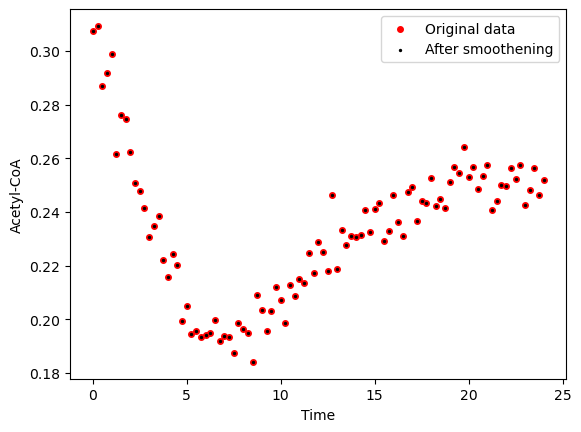

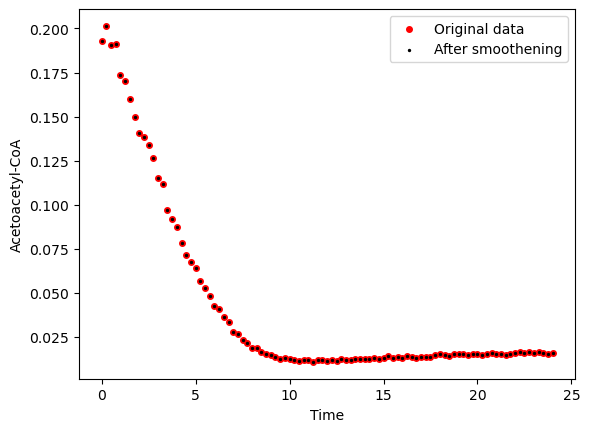

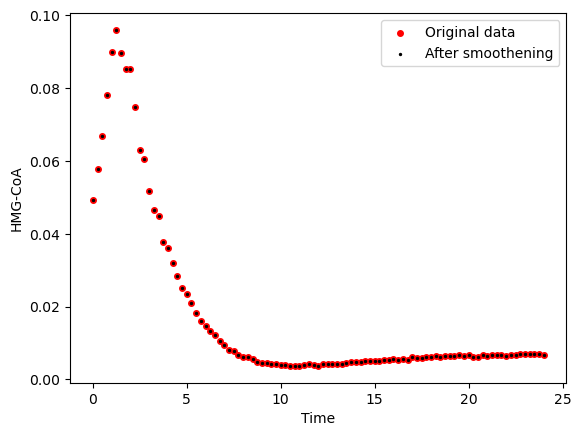

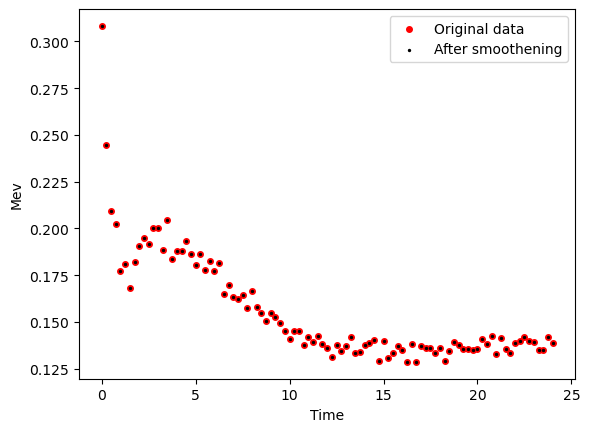

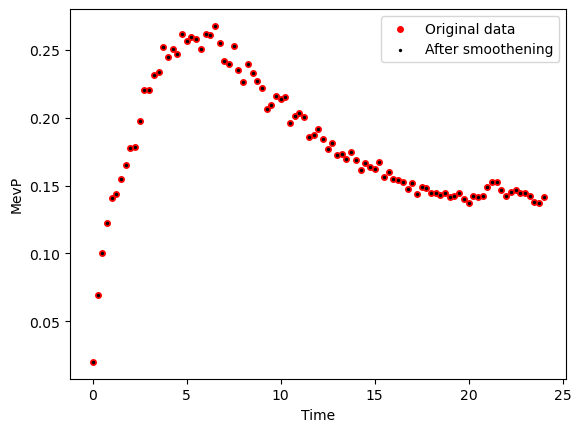

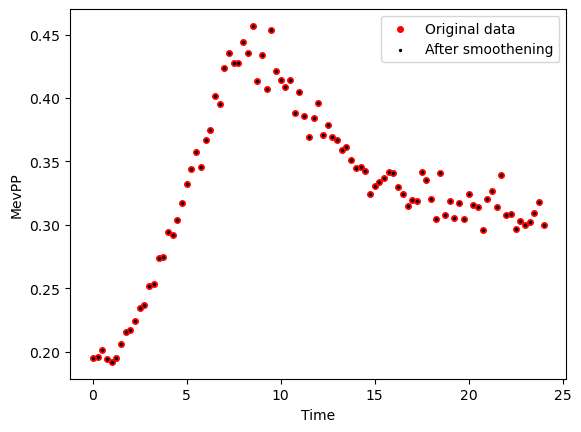

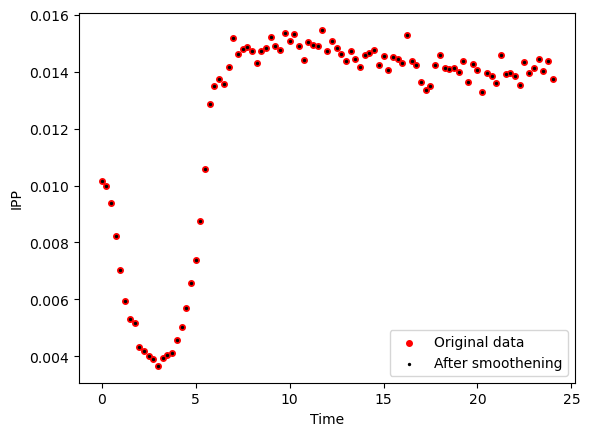

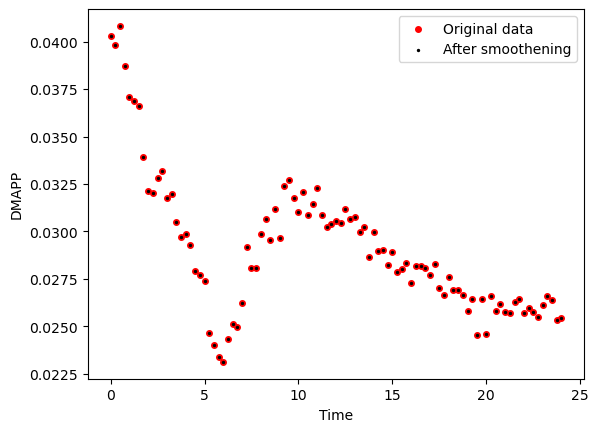

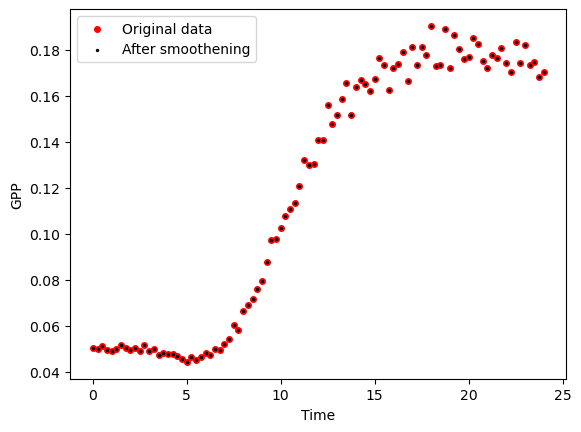

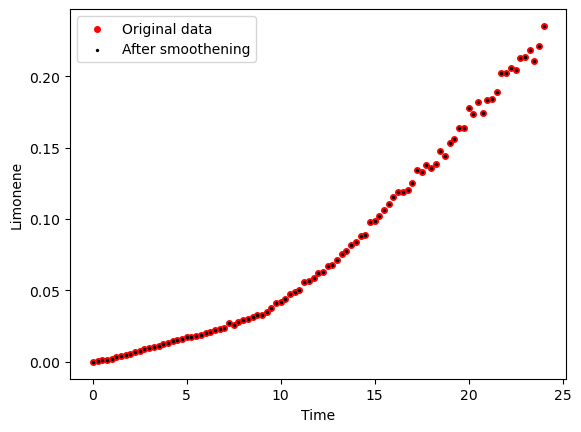

Strain Strain 2


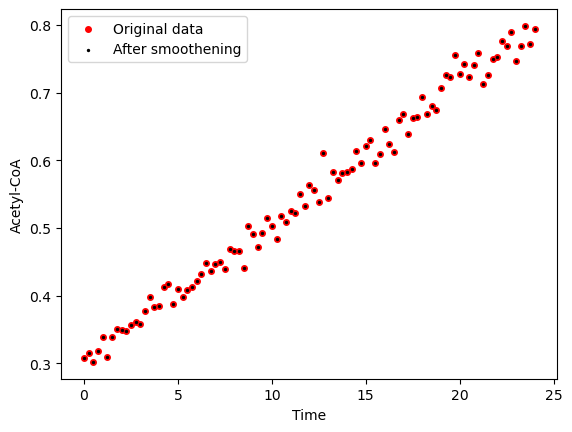

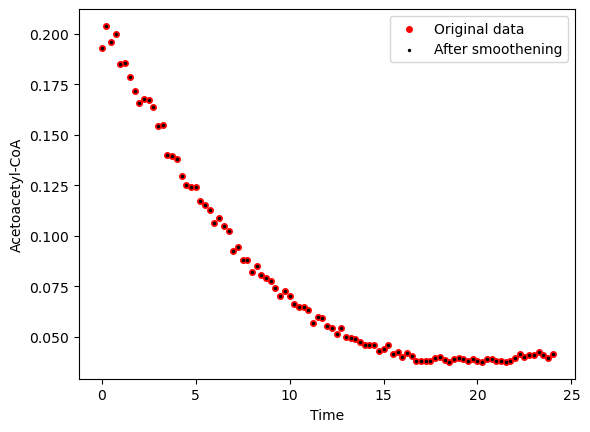

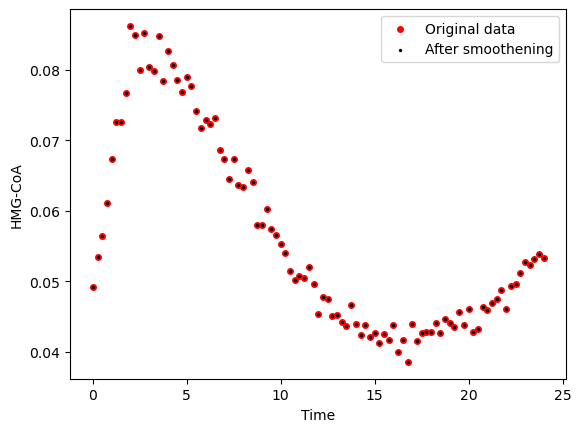

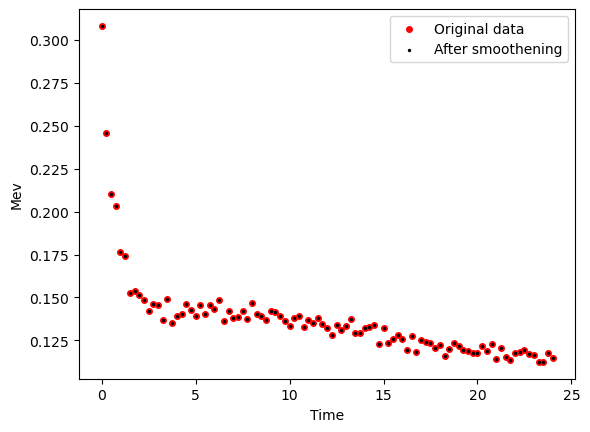

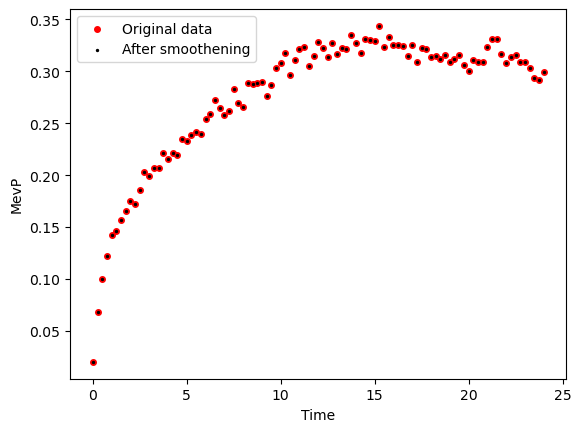

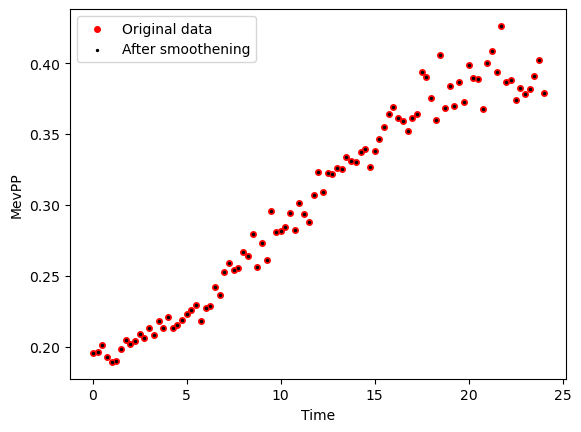

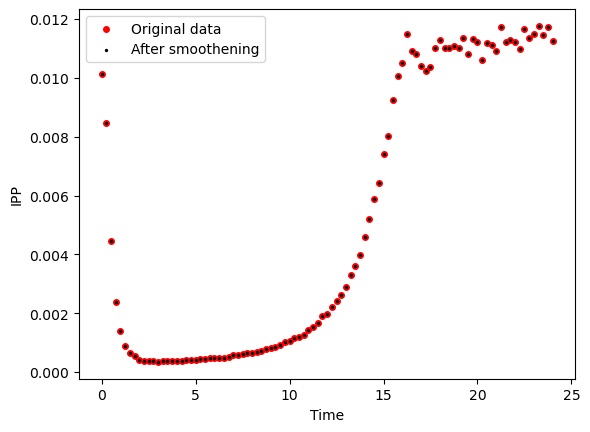

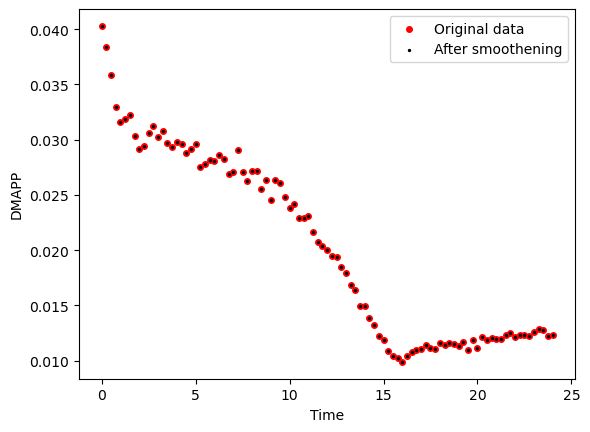

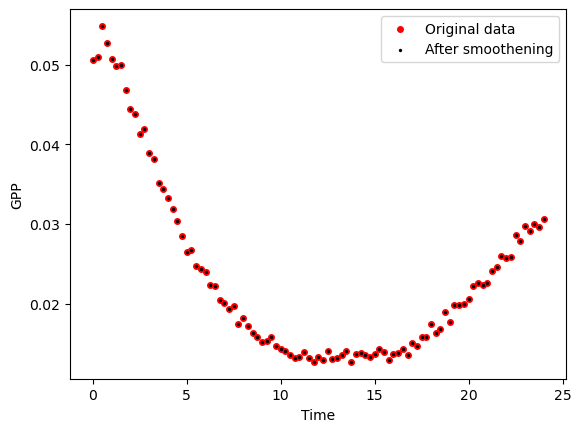

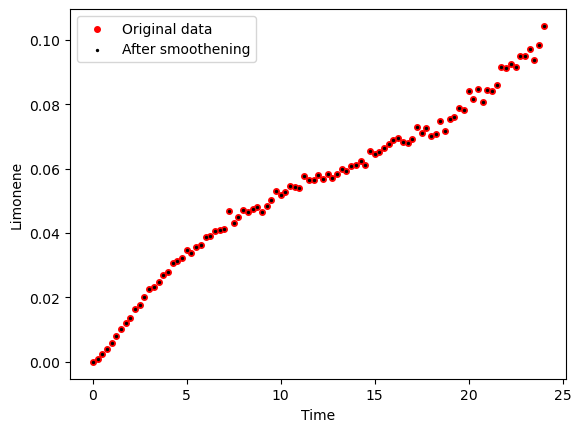

Strain Strain 3


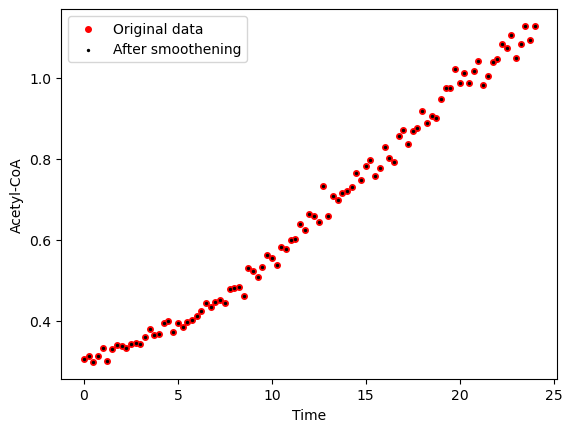

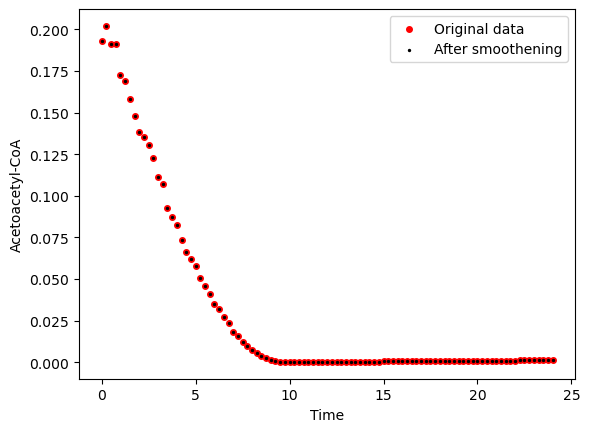

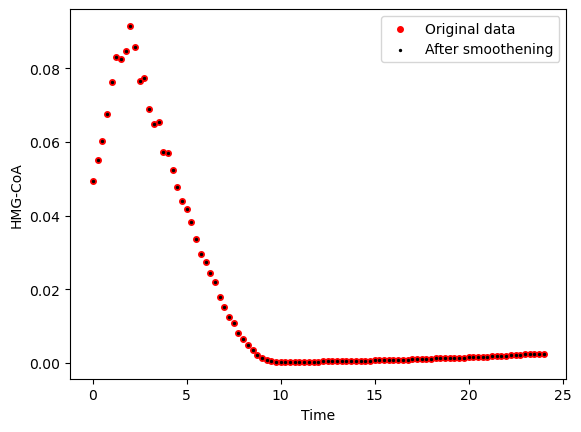

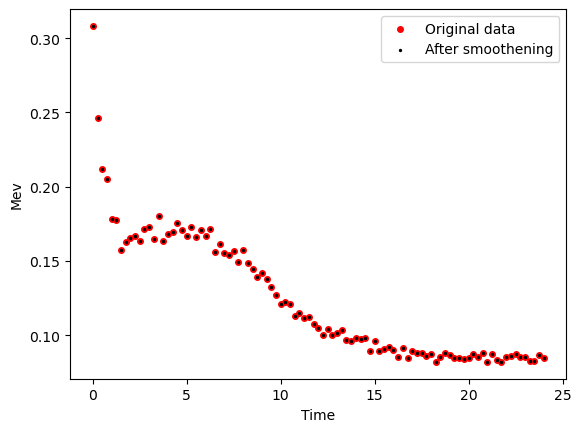

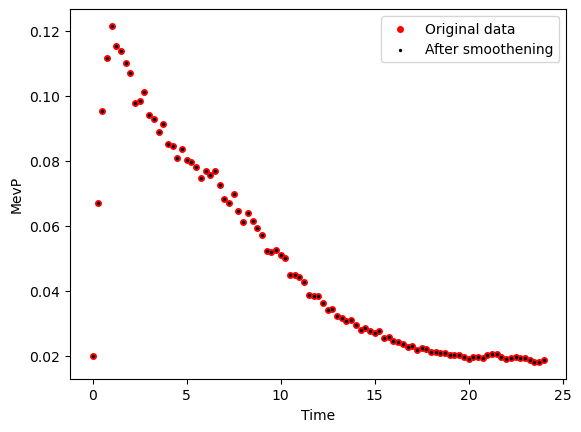

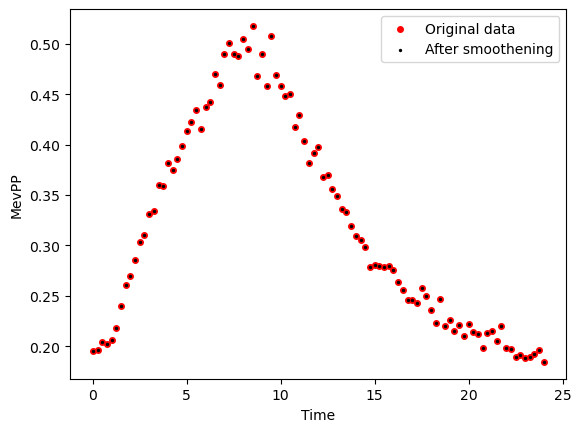

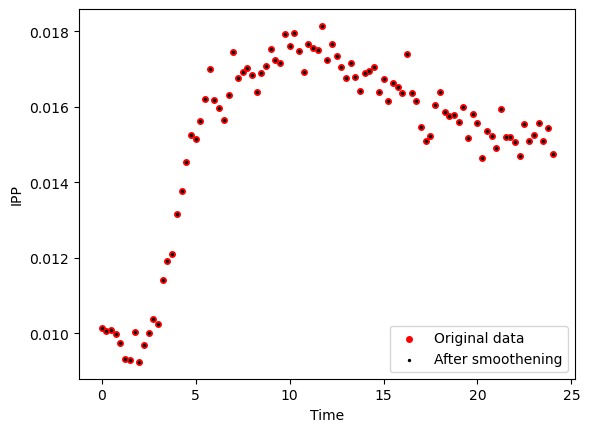

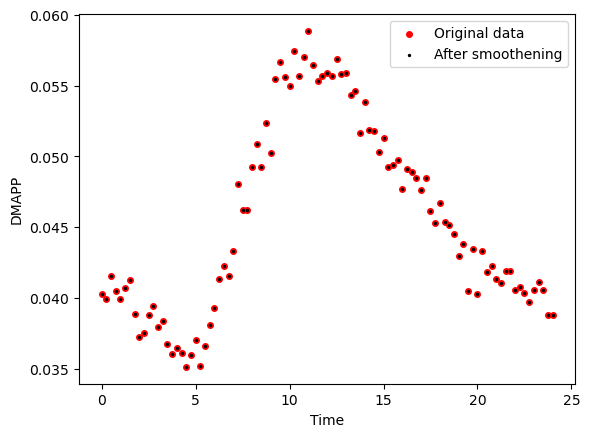

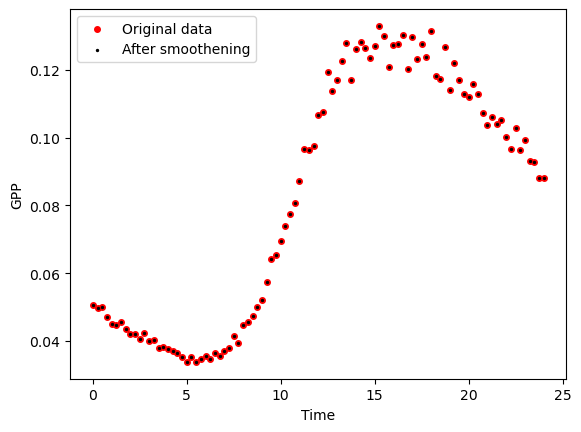

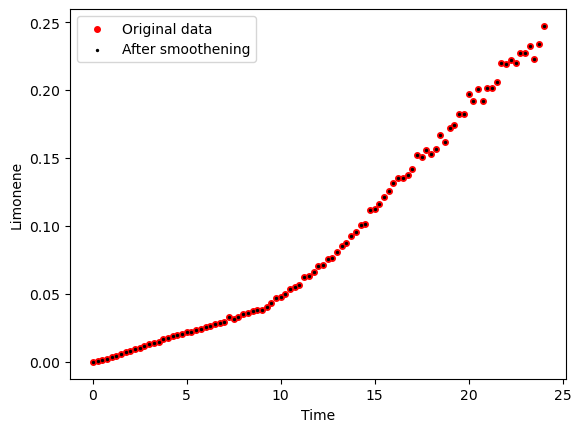

Strain WT


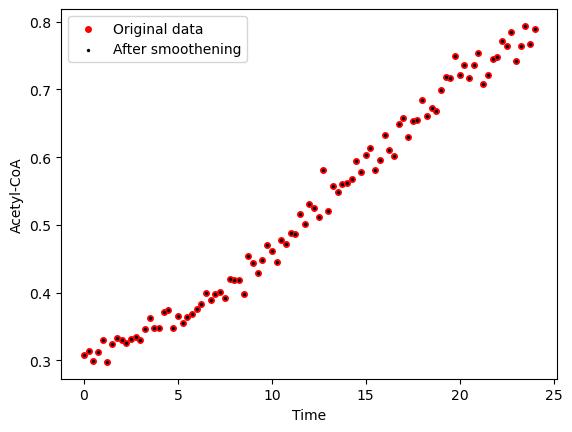

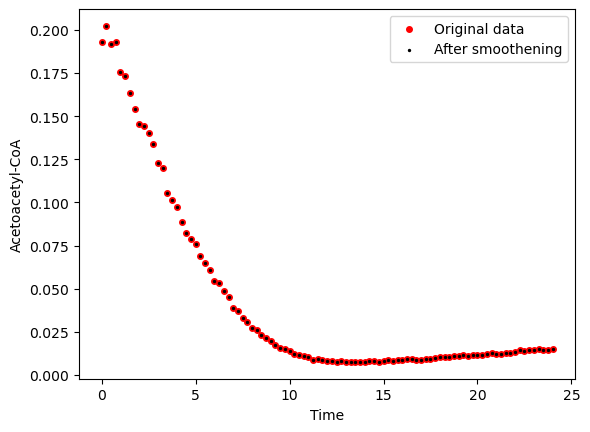

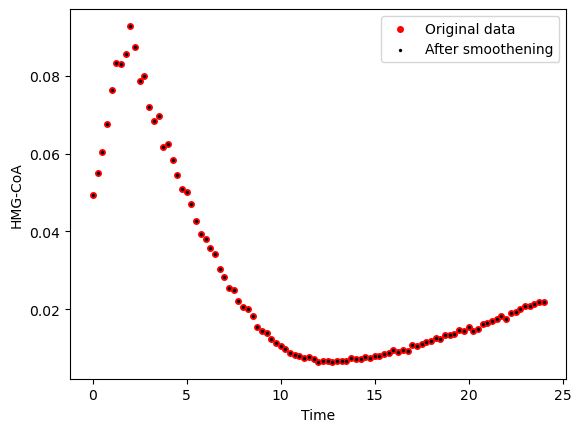

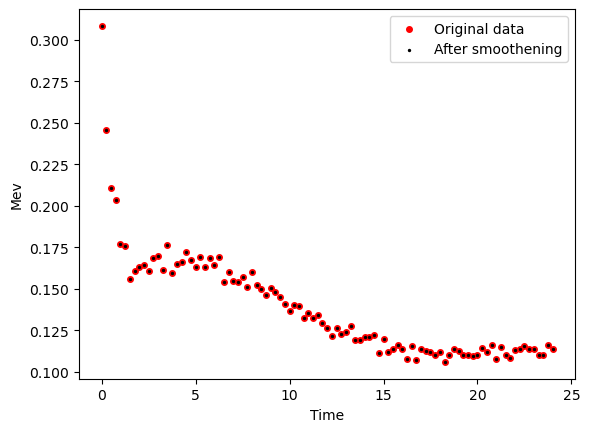

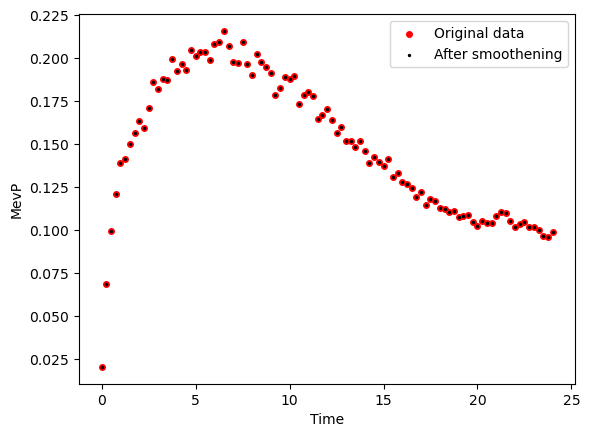

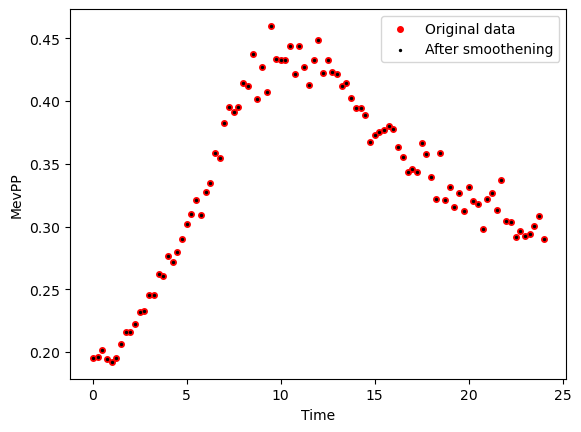

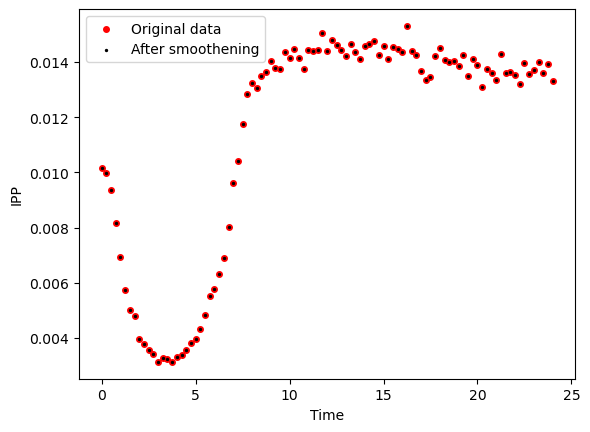

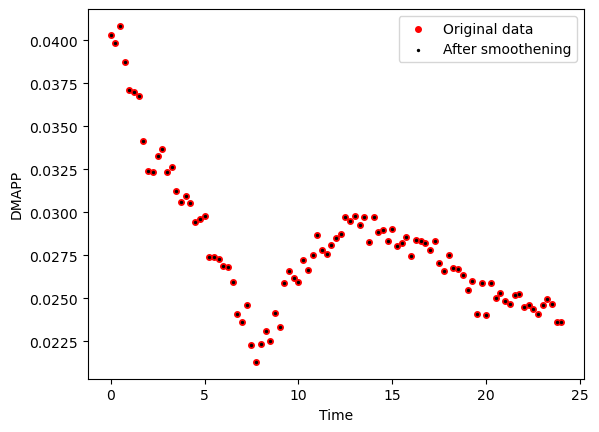

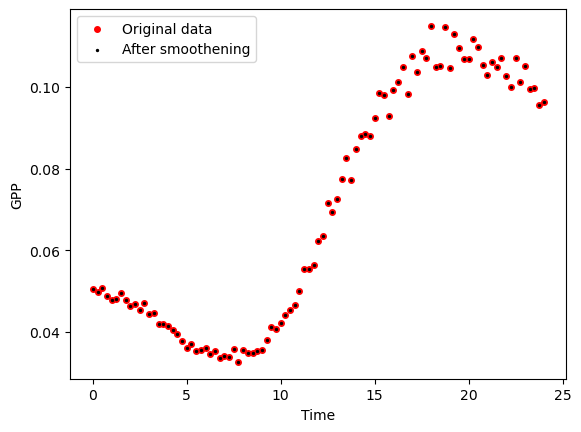

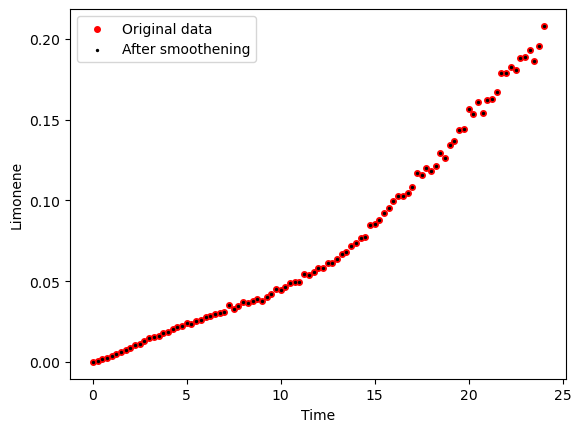

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


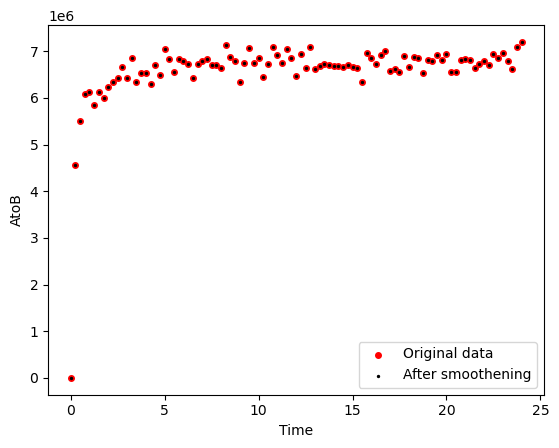

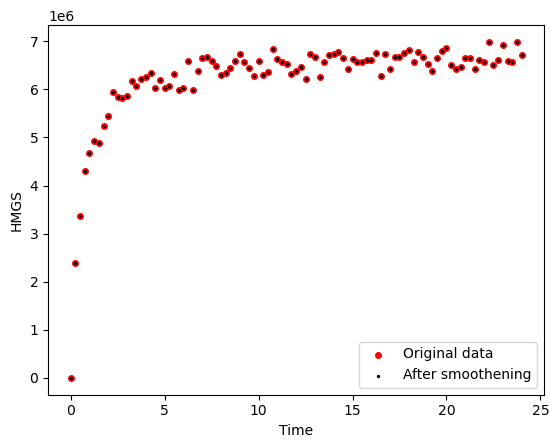

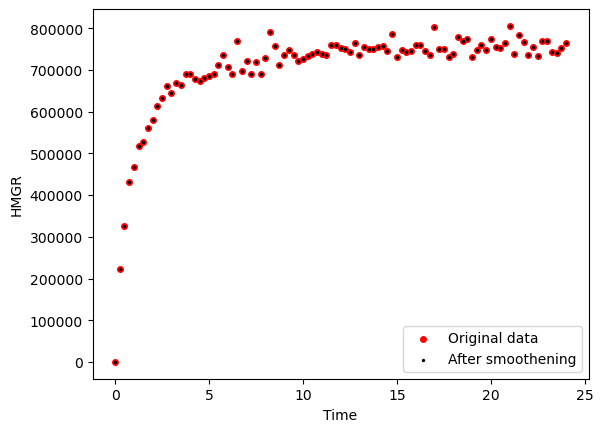

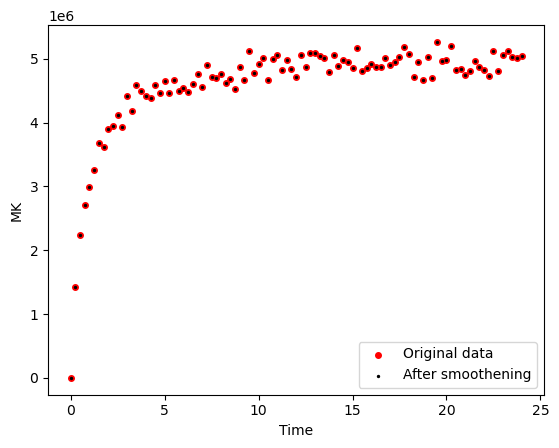

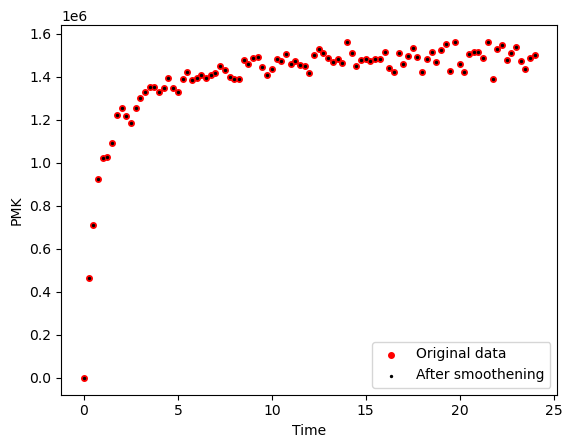

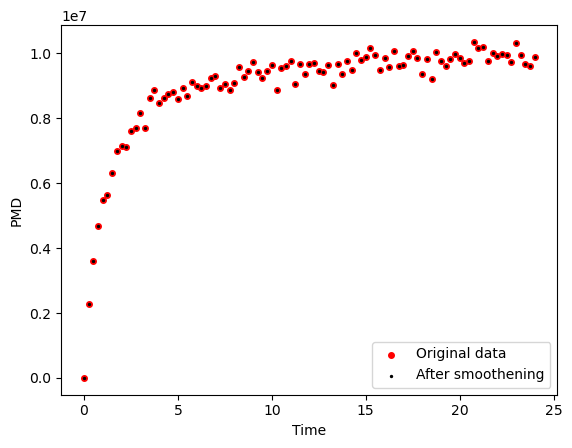

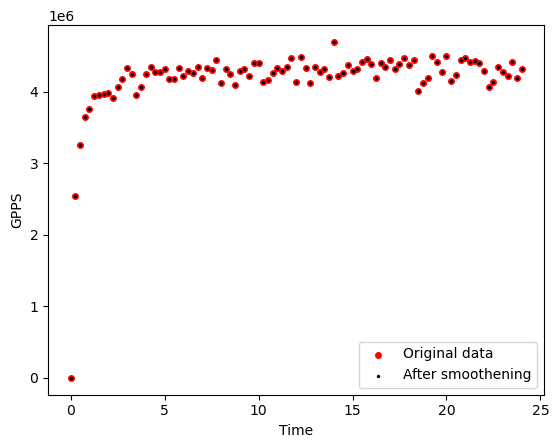

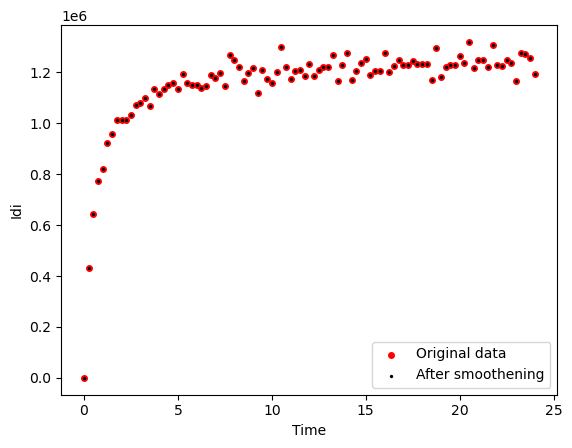

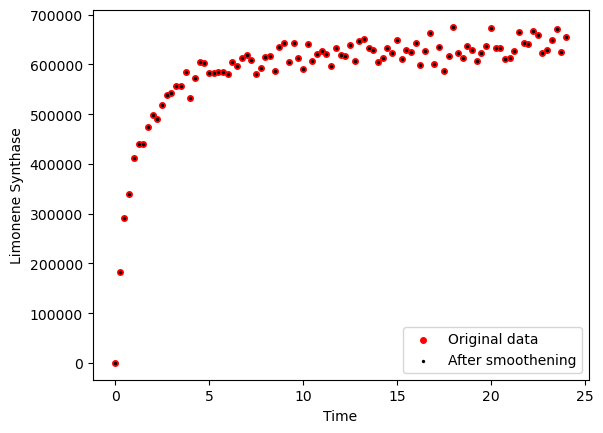

Strain Strain 2


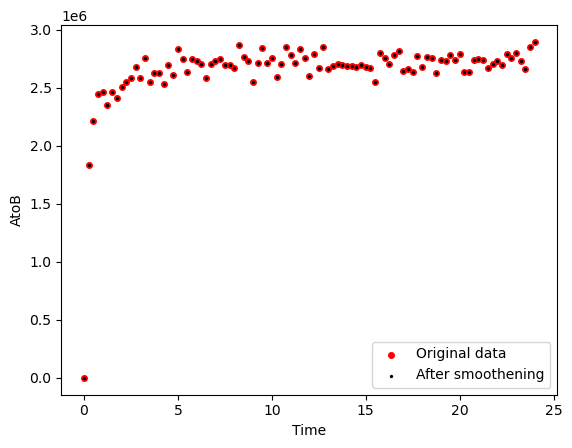

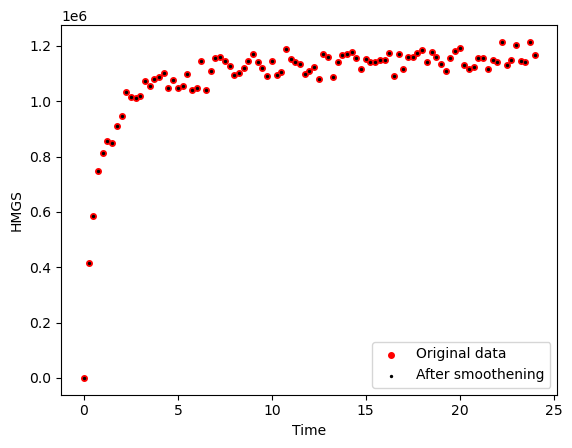

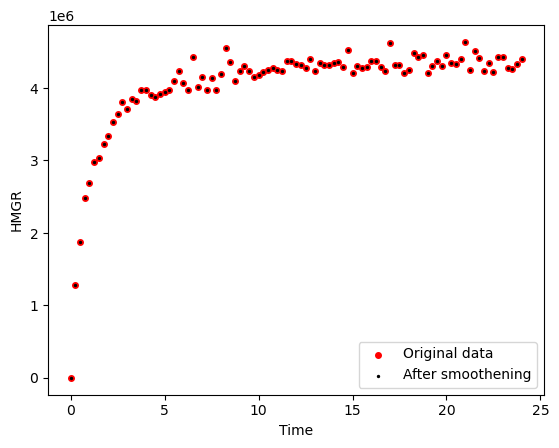

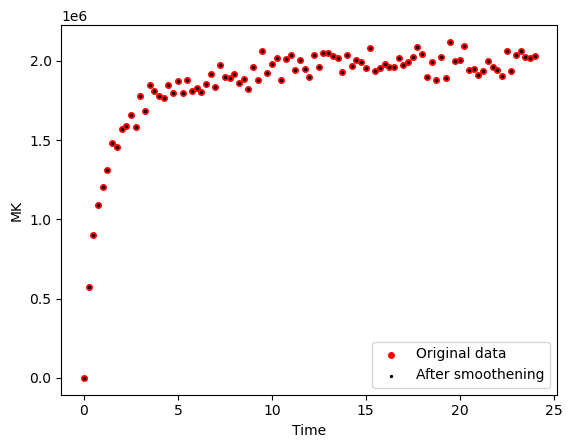

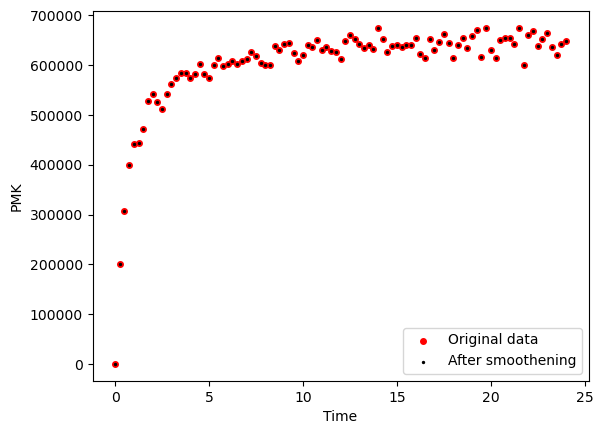

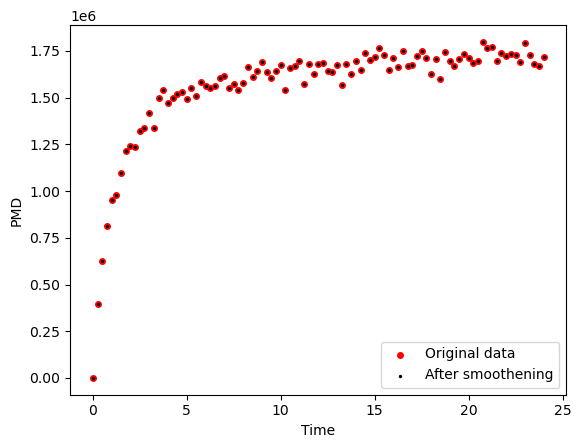

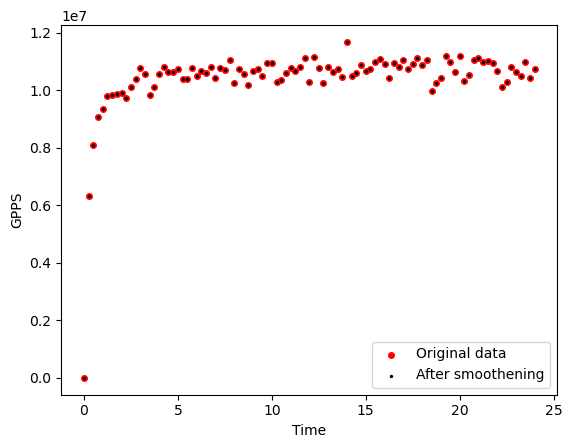

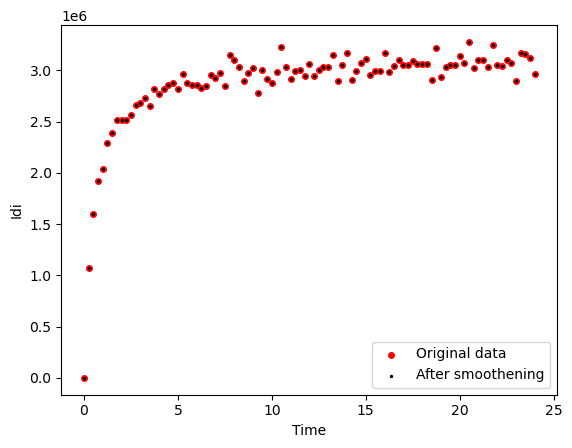

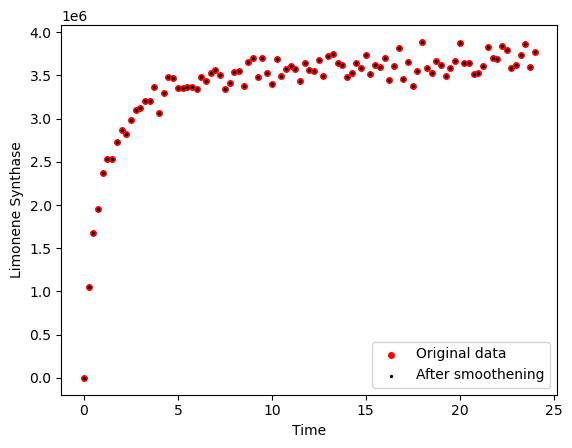

Strain Strain 3


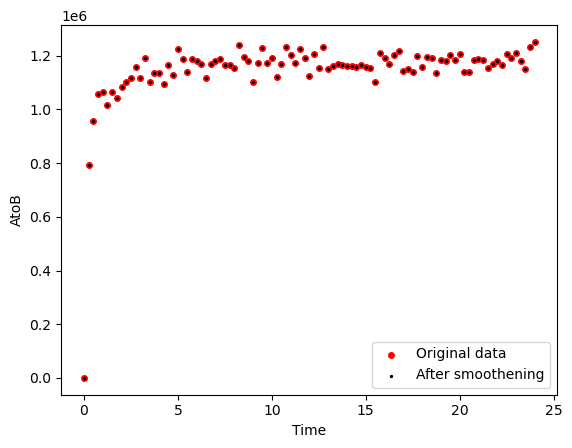

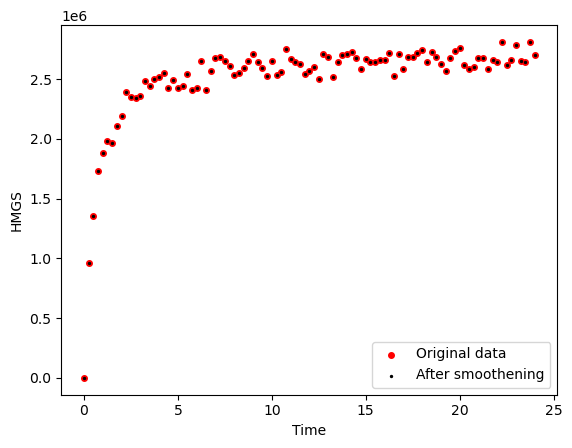

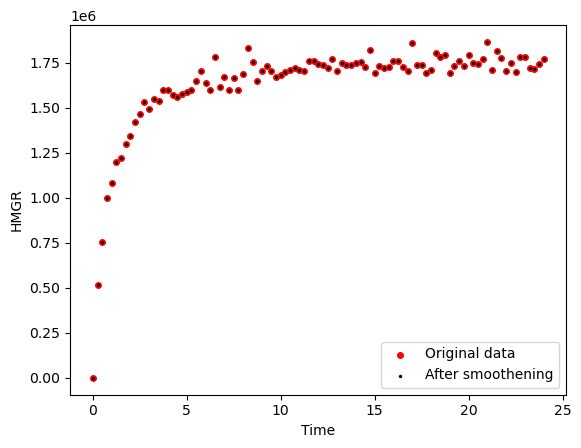

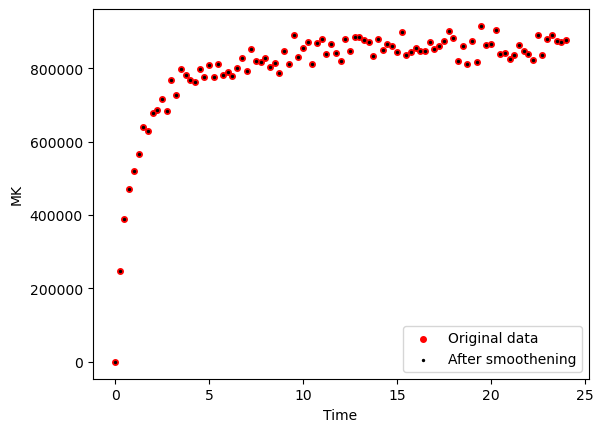

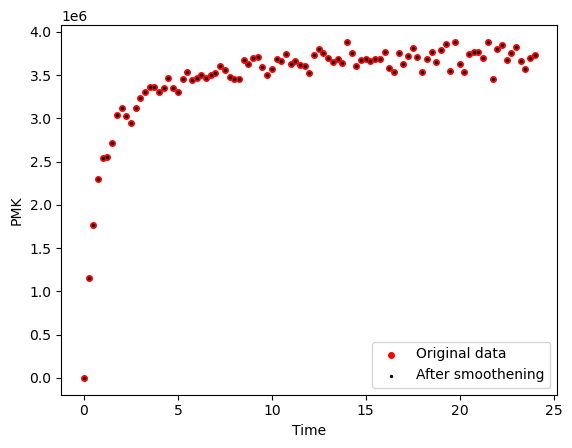

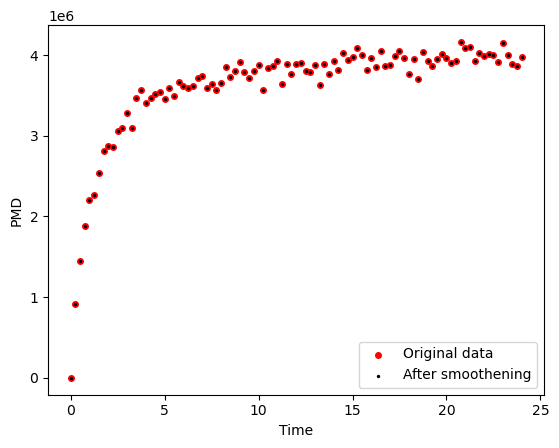

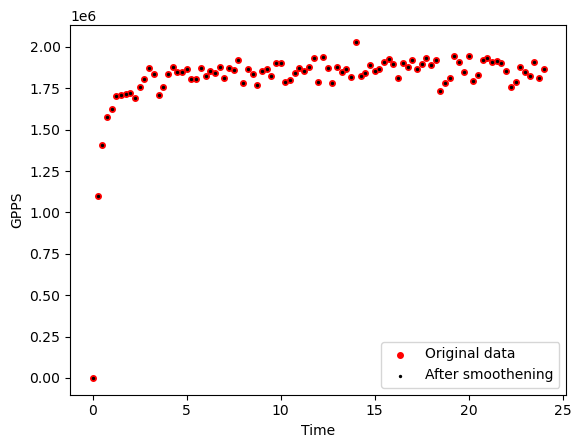

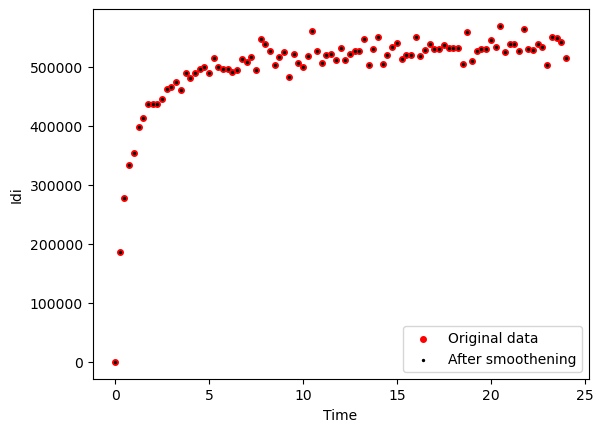

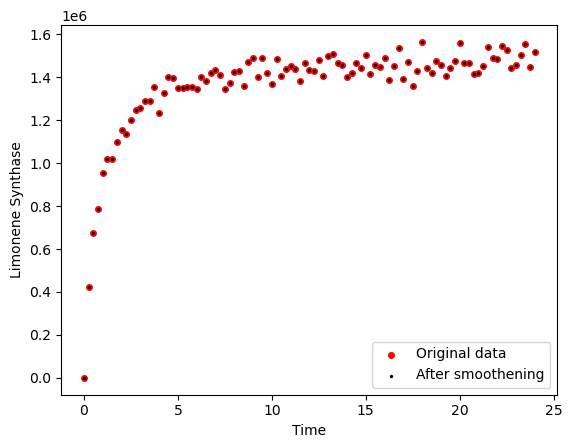

Strain WT


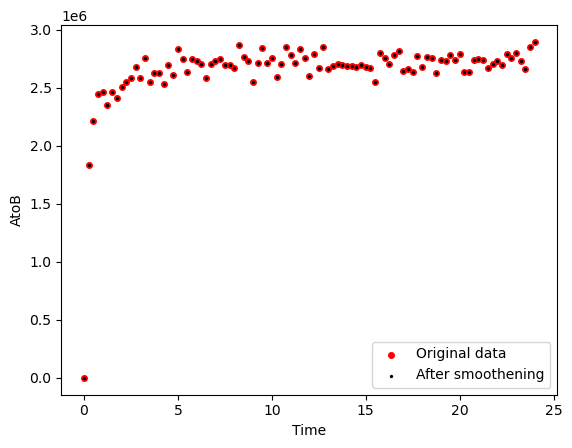

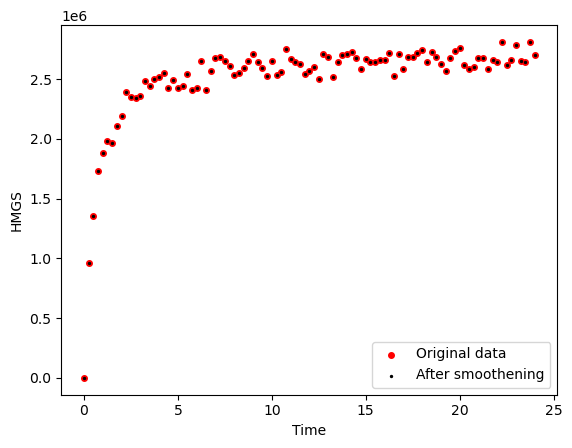

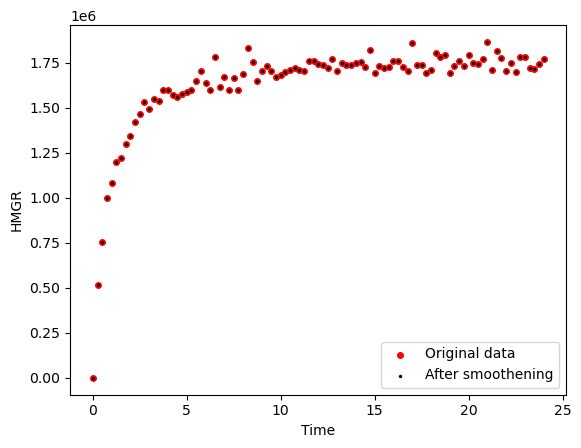

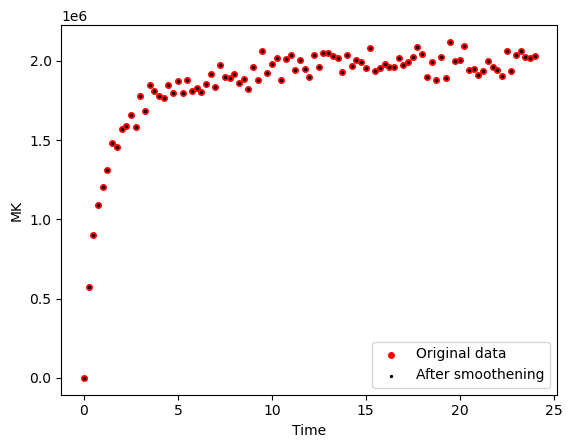

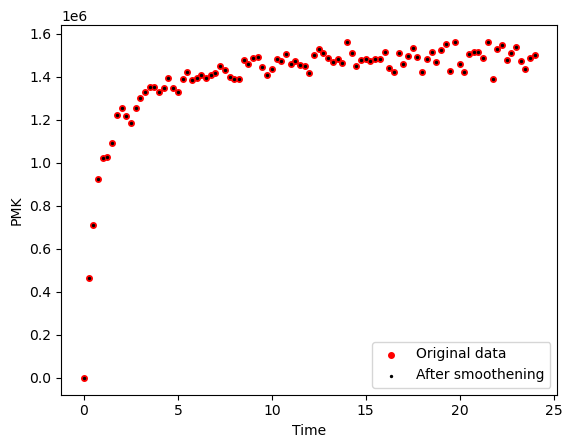

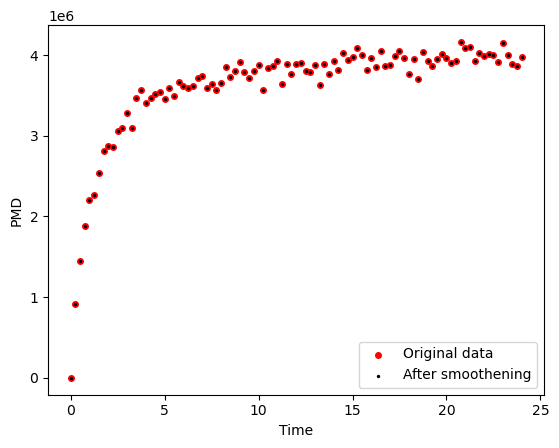

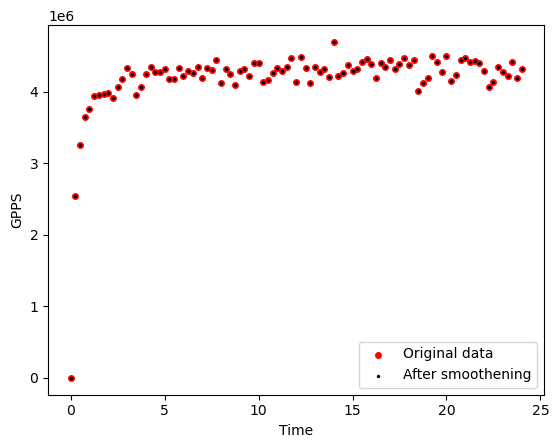

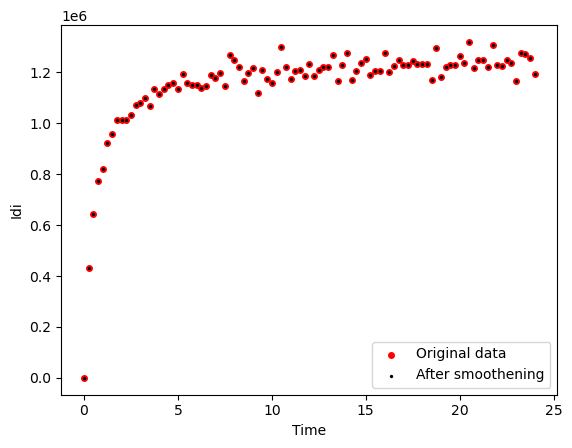

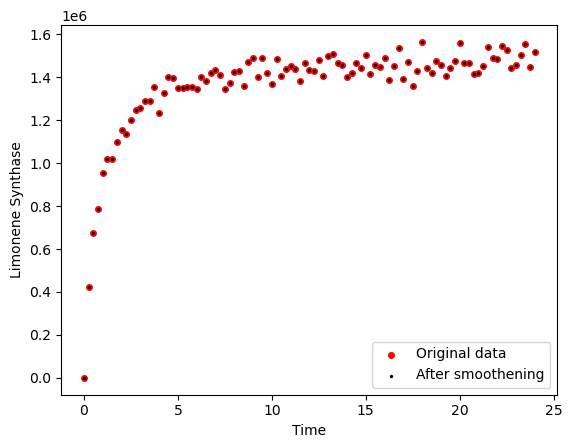

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.307507        0.192847  0.049264  0.308261  0.020131   
         0.25    0.309289        0.201424  0.057705  0.244626  0.069208   
         0.50    0.286885        0.190625  0.066920  0.209178  0.100499   
         0.75    0.291694        0.191152  0.078201  0.202394  0.122481   
         1.00    0.298805        0.173484  0.089942  0.177280  0.140925   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.742292        0.014403  0.020888  0.113564  0.101795   
         23.25   0.763702        0.015134  0.020904  0.110077  0.099836   
         23.50   0.793760        0.014674  0.021450  0.110256  0.096613   
         23.75   0.767065        0.014179  0.021926  0.115985  0.096005   
         24.00   0.788743        0.015025  0.021914  0.113500  0.098686   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.195401  0.010149  0.040297  0.050591  0.000000  ...   
         0.25   0.196183  0.009969  0.039843  0.050012  0.000366  ...   
         0.50   0.201384  0.009375  0.040831  0.051394  0.001017  ...   
         0.75   0.194301  0.008243  0.038721  0.049578  0.001638  ...   
         1.00   0.192049  0.007046  0.037078  0.048995  0.002393  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.292376  0.013727  0.024601  0.105096  0.188823  ...   
         23.25  0.294256  0.014004  0.024972  0.099510  0.193287  ...   
         23.50  0.300041  0.013601  0.024665  0.099754  0.186422  ...   
         23.75  0.308237  0.013921  0.023616  0.095538  0.195773  ...   
         24.00  0.289821  0.013301  0.023641  0.096211  0.207925  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.057280        0.027446  0.030836 -0.242483  0.198600   
         0.25    -0.035640        0.003924  0.035789 -0.182080  0.158272   
         0.50    -0.013999       -0.019599  0.040741 -0.121677  0.117944   
         0.75    -0.033430       -0.031879  0.039818 -0.063644  0.075700   
         1.00    -0.020555       -0.033002  0.025346 -0.041214  0.051745   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.015434        0.000957  0.002109 -0.005818 -0.006921   
         23.25    0.006862       -0.000021  0.001710  0.000498 -0.006766   
         23.50    0.038506        0.000116  0.001229  0.002311 -0.004019   
         23.75    0.006381        0.000226  0.001157  0.006628  0.002778   
         24.00   -0.025744        0.000336  0.001084  0.010945  0.009576   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.017539 -0.000234  0.003233  0.002212  0.001570  
         0.25   0.007052 -0.001704  0.000105  0.000381  0.001997  
         0.50  -0.003435 -0.003173 -0.003024 -0.001450  0.002423  
         0.75  -0.004780 -0.004159 -0.003858 -0.001099  0.002803  
         1.00   0.003966 -0.004187 -0.004091  0.000476  0.003101  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.005749 -0.000121  0.000588 -0.006573  0.006493  
         23.25  0.012220  0.000224 -0.000330 -0.006733  0.005205  
         23.50  0.003548 -0.000374 -0.001311 -0.008697  0.016276  
         23.75 -0.018269 -0.000987 -0.002130 -0.004092  0.034329  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

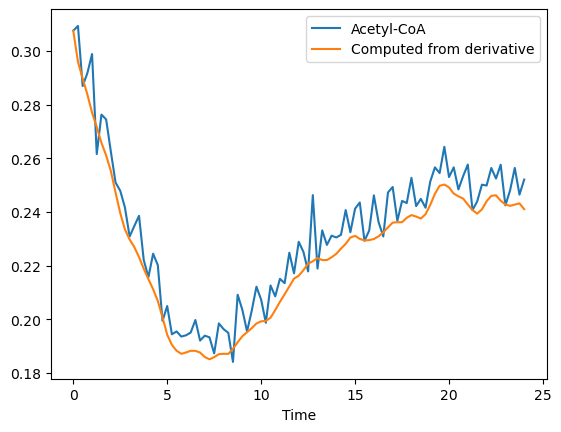

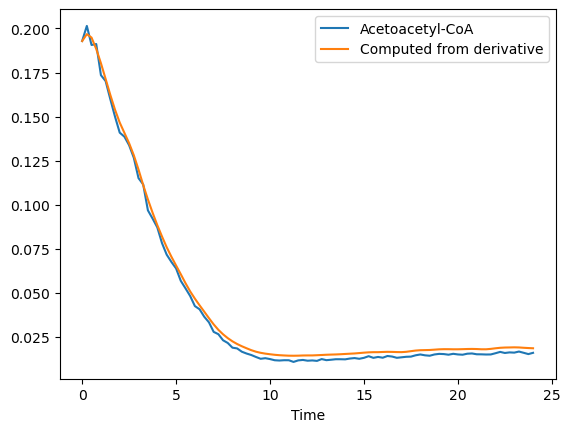

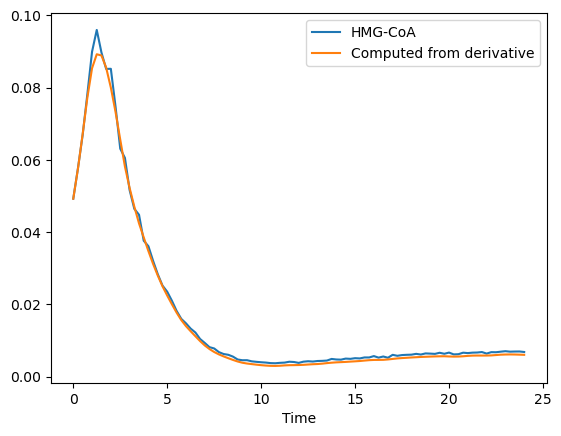

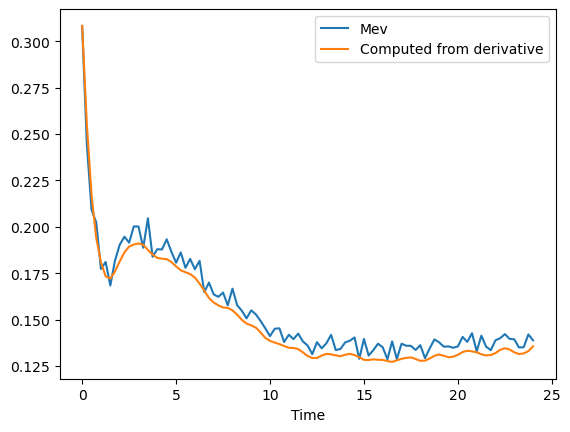

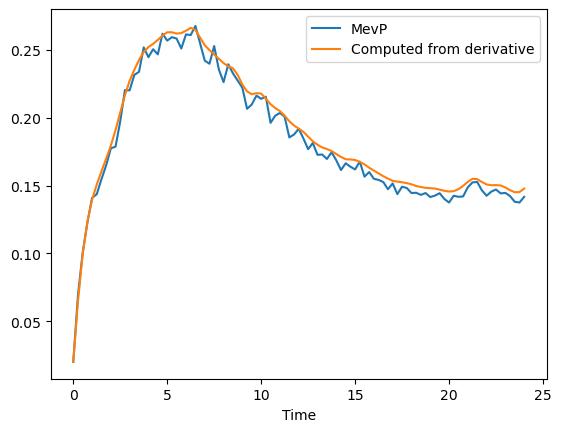

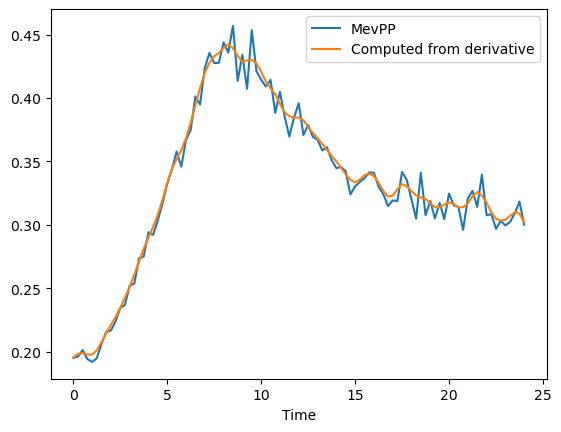

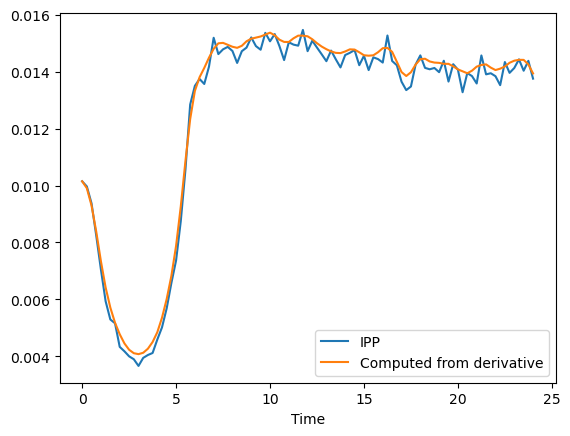

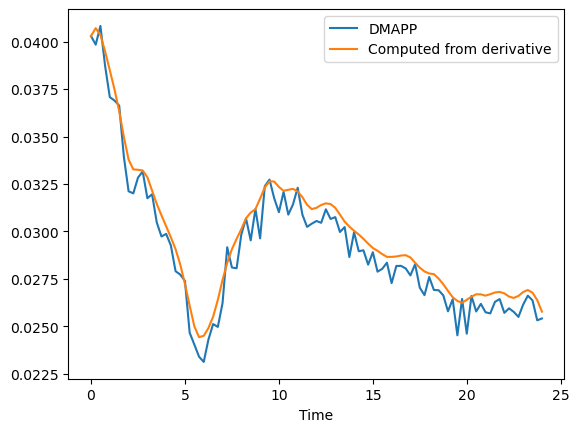

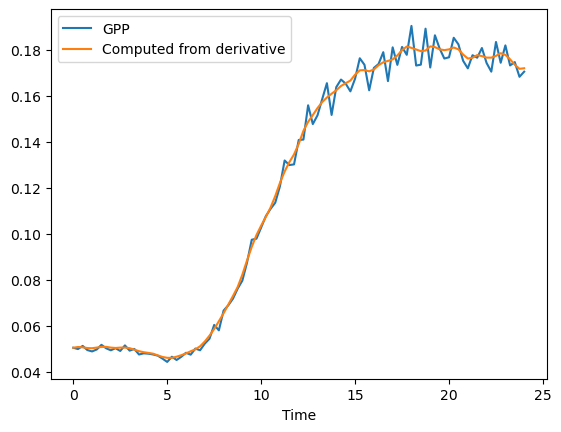

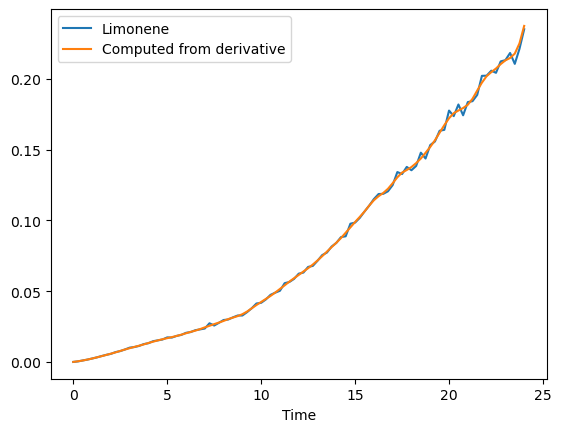

'Time profile from derivative vs. actual profile for Strain 2'

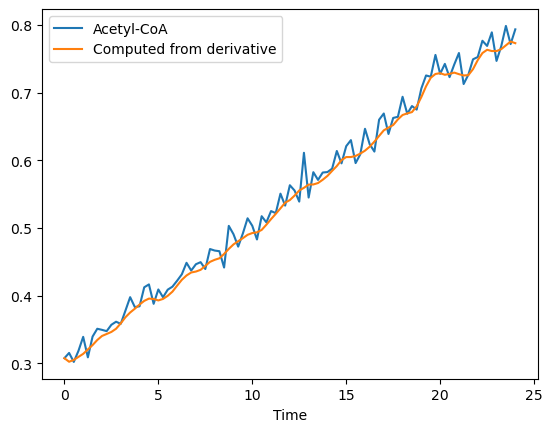

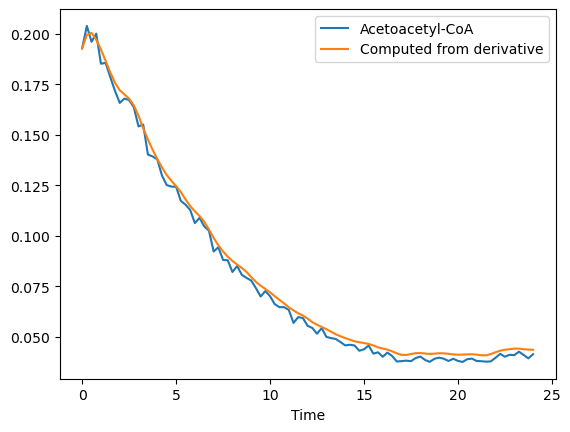

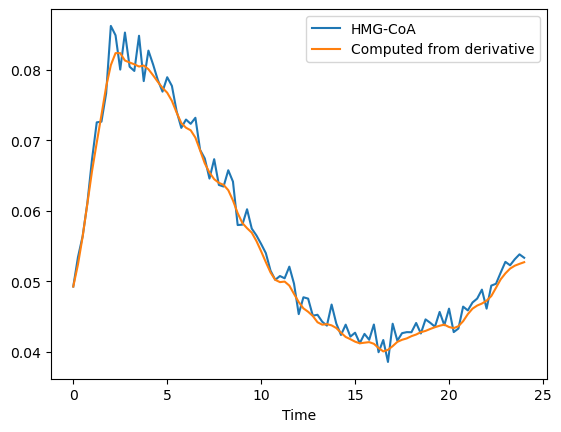

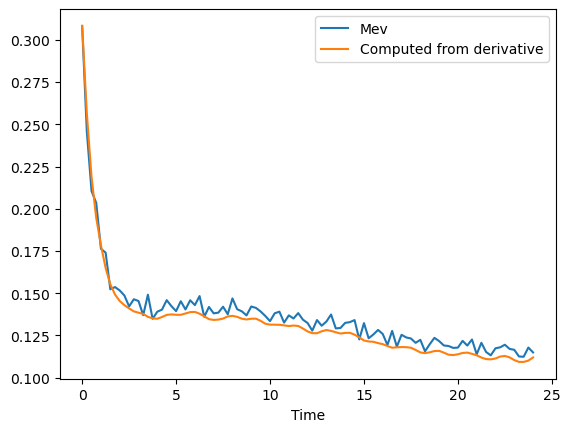

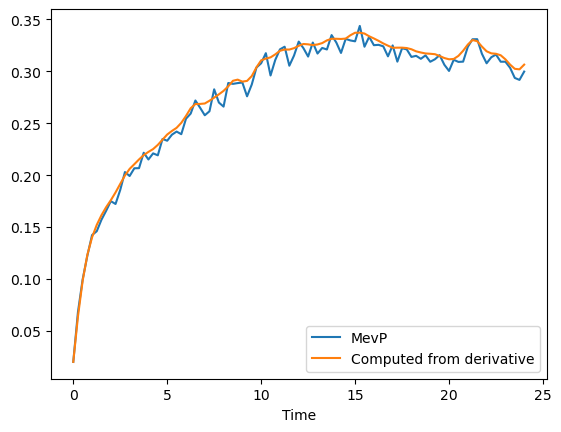

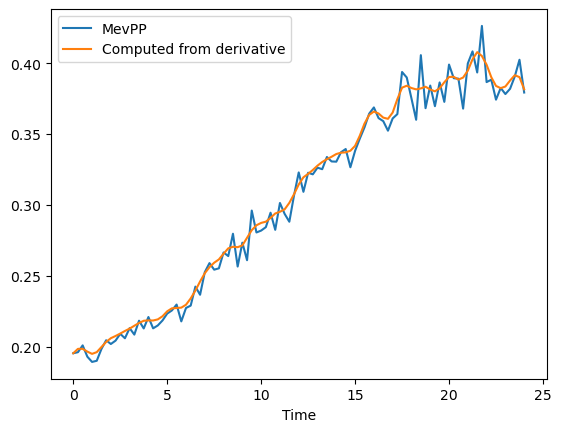

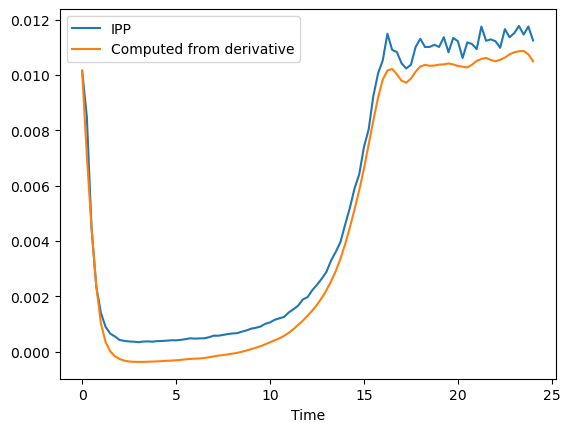

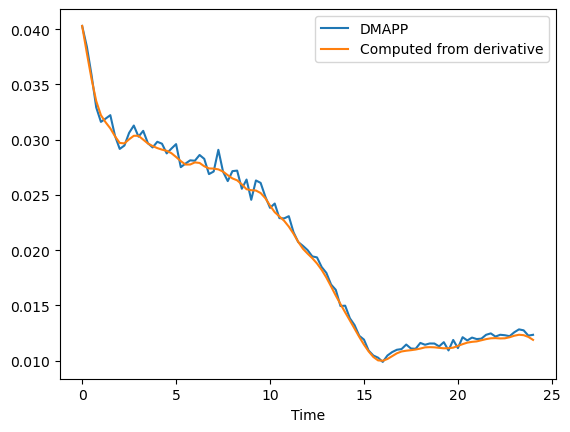

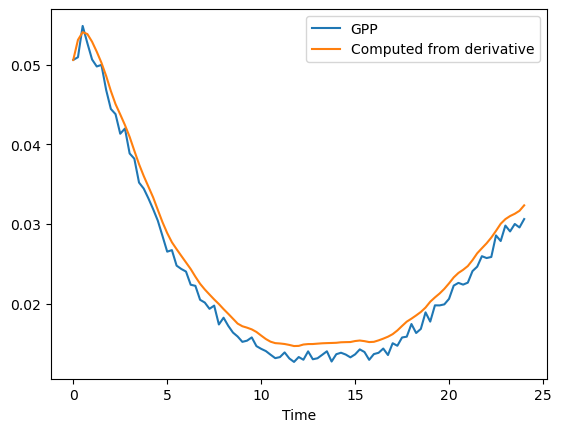

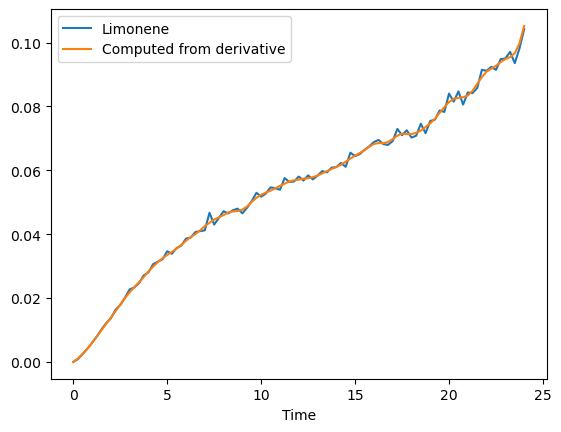

'Time profile from derivative vs. actual profile for Strain 3'

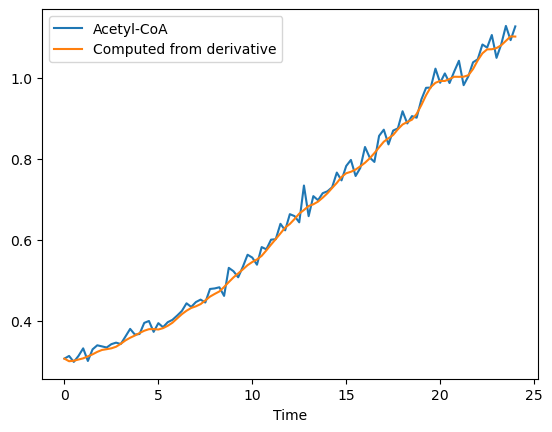

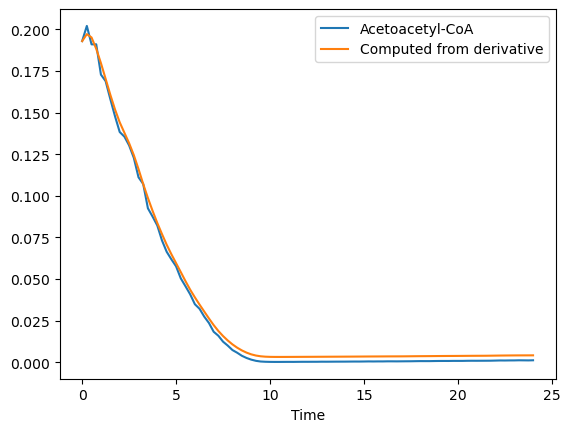

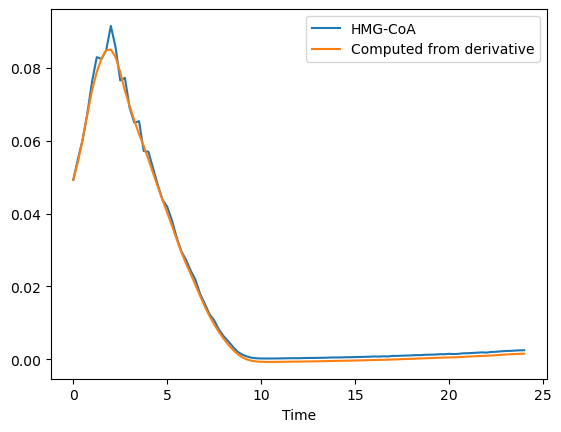

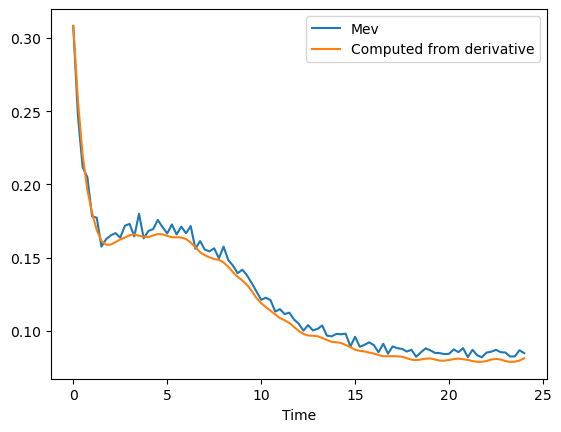

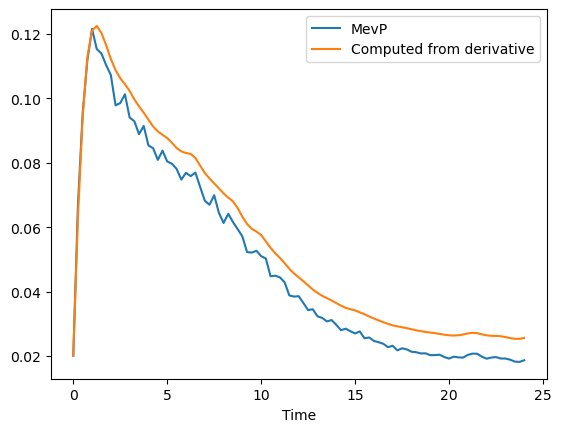

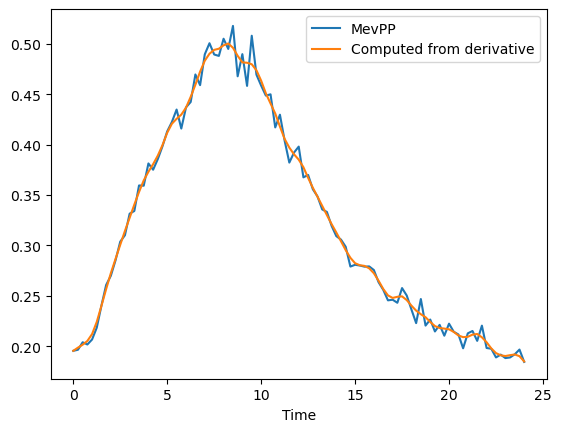

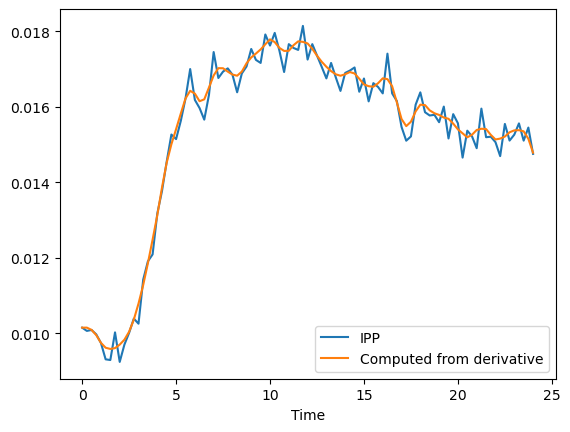

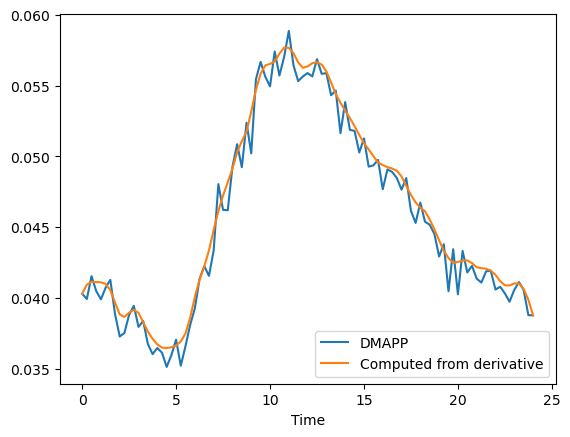

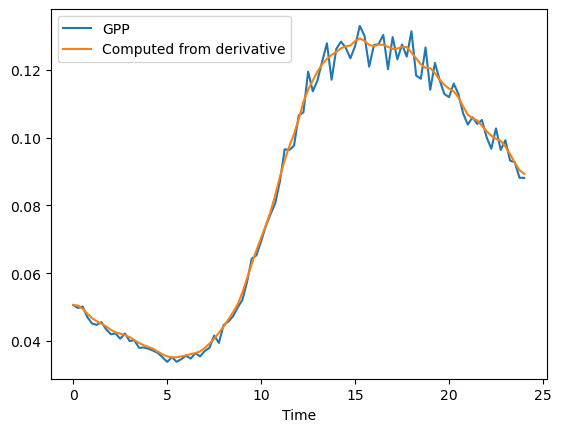

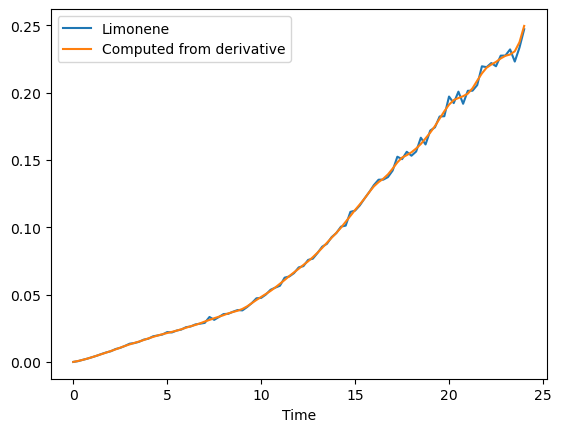

'Time profile from derivative vs. actual profile for WT'

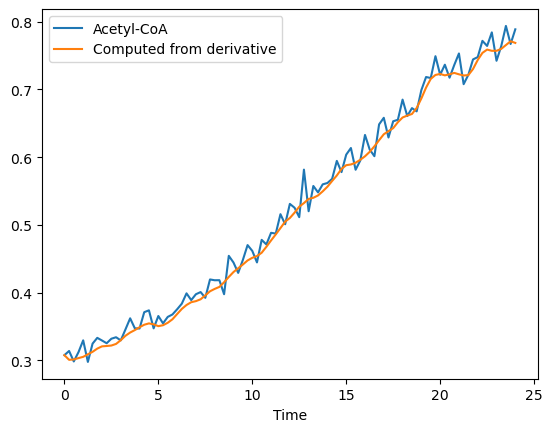

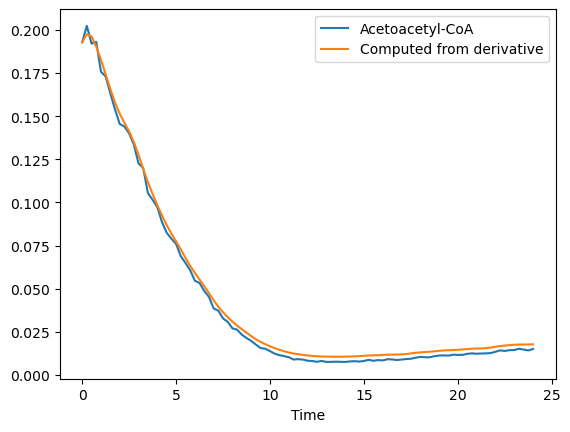

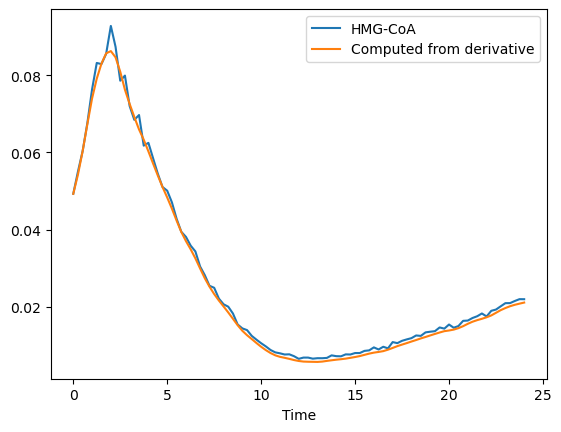

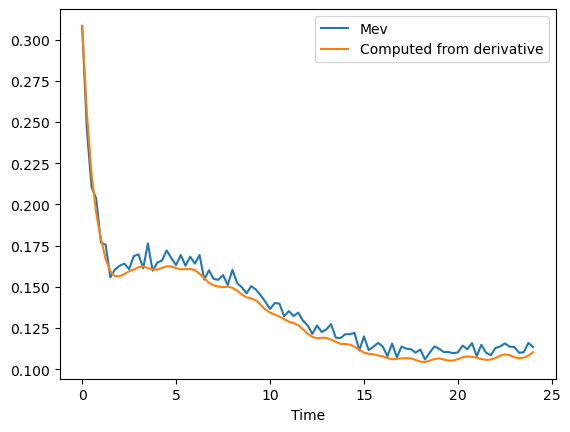

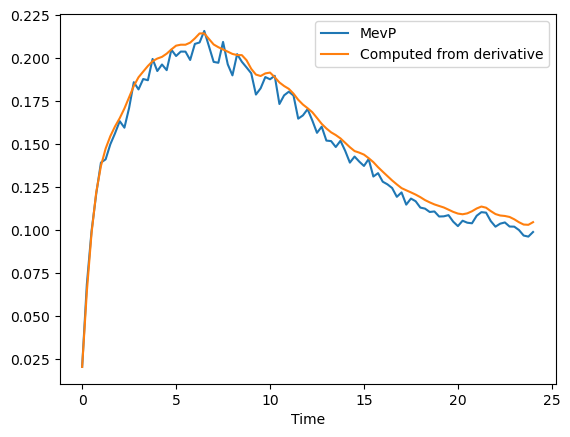

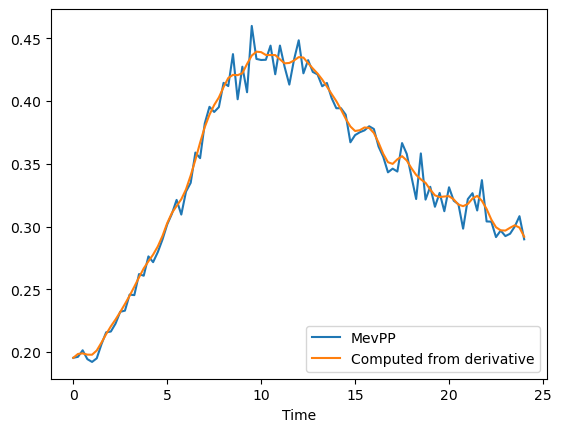

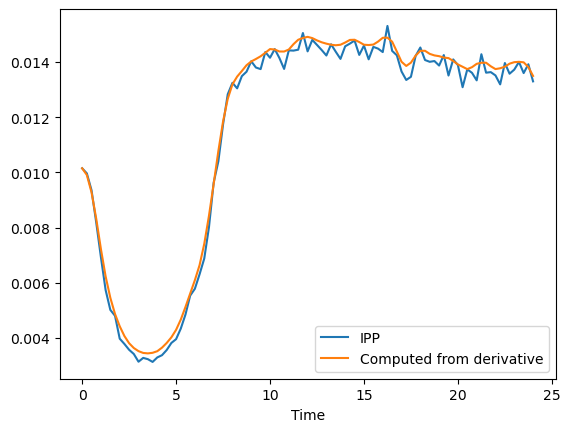

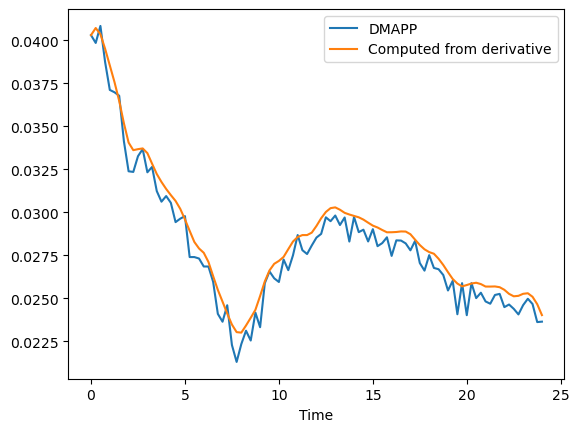

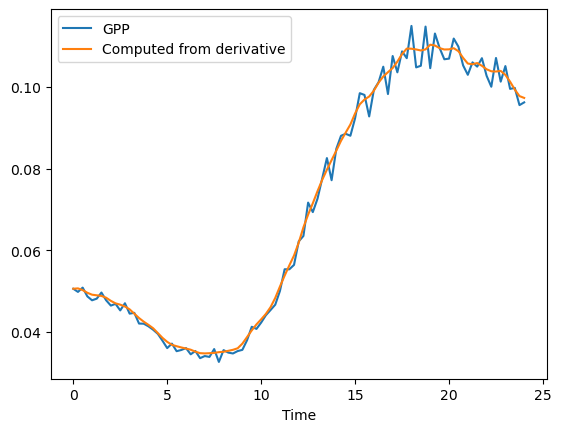

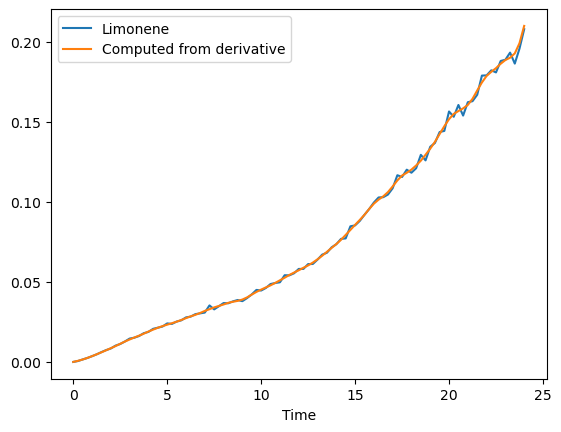

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.095775e+01  3.830916e+01  3.642460e+01  5.920951e+01   
         0.25   4.562280e+06  2.387218e+06  2.235850e+05  1.427086e+06   
         0.50   5.504432e+06  3.365541e+06  3.247253e+05  2.241663e+06   
         0.75   6.091505e+06  4.296528e+06  4.321469e+05  2.709233e+06   
         1.00   6.135963e+06  4.682593e+06  4.680041e+05  2.995600e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.798586e+06  2.781692e+06  1.783012e+06  2.035337e+06   
         23.25  2.728784e+06  2.650398e+06  1.720474e+06  2.059733e+06   
         23.50  2.660750e+06  2.644709e+06  1.715498e+06  2.021107e+06   
         23.75  2.849446e+06  2.810695e+06  1.740797e+06  2.018694e+06   
         24.00  2.896286e+06  2.699434e+06  1.767956e+06  2.029364e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.677443e+01  5.322851e+01  5.629791e+01  1.882676e+01   
         0.25   4.627639e+05  2.286100e+06  2.550127e+06  4.317176e+05   
         0.50   7.122424e+05  3.593802e+06  3.257557e+06  6.426762e+05   
         0.75   9.261810e+05  4.686807e+06  3.653431e+06  7.714662e+05   
         1.00   1.020998e+06  5.491013e+06  3.759702e+06  8.180992e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.536728e+06  4.151637e+06  4.284493e+06  1.165858e+06   
         23.25  1.471363e+06  3.997512e+06  4.218226e+06  1.274865e+06   
         23.50  1.436512e+06  3.889987e+06  4.419343e+06  1.271866e+06   
         23.75  1.486919e+06  3.867592e+06  4.201317e+06  1.255360e+06   
         24.00  1.501886e+06  3.974894e+06  4.319973e+06  1.191504e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.069984e+01   0.307507        0.192847  0.049264   
         0.25       1.833784e+05   0.309289        0.201424  0.057705   
         0.50       2.904854e+05   0.286885        0.190625  0.066920   
         0.75       3.394283e+05   0.291694        0.191152  0.078201   
         1.00       4.114768e+05   0.298805        0.173484  0.089942   
...                          ...        ...             ...       ...   
WT       23.00      1.457436e+06   0.742292        0.014403  0.020888   
         23.25      1.503237e+06   0.763702        0.015134  0.020904   
         23.50      1.553956e+06   0.793760        0.014674  0.021450   
         23.75      1.447999e+06   0.767065        0.014179  0.021926   
         24.00      1.515156e+06   0.788743        0.015025  0.021914   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.308261  0.020131  0.195401  0.010149  0.040297  0.050591   
         0.25   0.244626  0.069208  0.196183  0.009969  0.039843  0.050012   
         0.50   0.209178  0.100499  0.201384  0.009375  0.040831  0.051394   
         0.75   0.202394  0.122481  0.194301  0.008243  0.038721  0.049578   
         1.00   0.177280  0.140925  0.192049  0.007046  0.037078  0.048995   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.113564  0.101795  0.292376  0.013727  0.024601  0.105096   
         23.25  0.110077  0.099836  0.294256  0.014004  0.024972  0.099510   
         23.50  0.110256  0.096613  0.300041  0.013601  0.024665 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.057280        0.027446  0.030836 -0.242483  0.198600   
         0.25    -0.035640        0.003924  0.035789 -0.182080  0.158272   
         0.50    -0.013999       -0.019599  0.040741 -0.121677  0.117944   
         0.75    -0.033430       -0.031879  0.039818 -0.063644  0.075700   
         1.00    -0.020555       -0.033002  0.025346 -0.041214  0.051745   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.015434        0.000957  0.002109 -0.005818 -0.006921   
         23.25    0.006862       -0.000021  0.001710  0.000498 -0.006766   
         23.50    0.038506        0.000116  0.001229  0.002311 -0.004019   
         23.75    0.006381        0.000226  0.001157  0.006628  0.002778   
         24.00   -0.025744        0.000336  0.001084  0.010945  0.009576   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.017539 -0.000234  0.003233  0.002212  0.001570  
         0.25   0.007052 -0.001704  0.000105  0.000381  0.001997  
         0.50  -0.003435 -0.003173 -0.003024 -0.001450  0.002423  
         0.75  -0.004780 -0.004159 -0.003858 -0.001099  0.002803  
         1.00   0.003966 -0.004187 -0.004091  0.000476  0.003101  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.005749 -0.000121  0.000588 -0.006573  0.006493  
         23.25  0.012220  0.000224 -0.000330 -0.006733  0.005205  
         23.50  0.003548 -0.000374 -0.001311 -0.008697  0.016276  
         23.75 -0.018269 -0.000987 -0.002130 -0.004092  0.034329  
         24.00 -0.040087 -0.001601 -0.002950  0.000513  0.052382  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 | 6.538826E+205 |  4.065867E+82
     2 |      128 | 3.793444E+205 |  2.164174E+29
     3 |      192 | 3.793444E+205 |  4.578563E+15
     4 |      256 | 3.793444E+205 |  4.677036E+09
     5 |      320 | 3.793444E+205 |  5.002803E+04
     6 |      384 |  2.674027E+63 |  2.068699E+03
     7 |      448 |  1.333745E+49 |  6.929476E+01
     8 |      512 |  6.731417E+13 |  3.953273E+01
     9 |      576 |  1.735869E+04 |  3.447536E+01
    10 |      640 |  7.166143E+03 |  3.203009E+01
    11 |      704 |  1.252050E+03 |  3.188057E+01
    12 |      768 |  3.332266E+01 |  3.148778E+01
    13 |      832 |  3.210368E+01 |  3.144445E+01
    14 |      896 |  3.161388E+01 |  3.141004E+01
    15 |      960 |  3.147425E+01 |  3.128799E+01
    16 |     1024 |  3.138507E+01 |  3.107732E+01
    17 |     1088 |  3.123435E+01 |  3.101011E+01
    18 |     1152 |  3.113493E+01 |  3.092208E+01
    19 |     1216 |  3.10

   162 |    10368 |  2.382593E+01 |  2.381839E+01
   163 |    10432 |  2.382251E+01 |  2.381628E+01
   164 |    10496 |  2.381738E+01 |  2.381298E+01
   165 |    10560 |  2.381477E+01 |  2.381058E+01
   166 |    10624 |  2.381221E+01 |  2.381009E+01
   167 |    10688 |  2.381042E+01 |  2.380852E+01
   168 |    10752 |  2.380885E+01 |  2.380766E+01
   169 |    10816 |  2.380777E+01 |  2.380657E+01
   170 |    10880 |  2.380666E+01 |  2.380476E+01
   171 |    10944 |  2.380515E+01 |  2.380392E+01
   172 |    11008 |  2.380429E+01 |  2.380337E+01
   173 |    11072 |  2.380349E+01 |  2.380260E+01
   174 |    11136 |  2.380284E+01 |  2.380199E+01
   175 |    11200 |  2.380188E+01 |  2.380094E+01
   176 |    11264 |  2.380085E+01 |  2.379928E+01
   177 |    11328 |  2.379957E+01 |  2.379831E+01
   178 |    11392 |  2.379845E+01 |  2.379721E+01
   179 |    11456 |  2.379724E+01 |  2.379572E+01
   180 |    11520 |  2.379577E+01 |  2.379464E+01
   181 |    11584 |  2.379469E+01 |  2.379319E+01


   326 |    20864 |  2.341918E+01 |  2.341738E+01
   327 |    20928 |  2.341791E+01 |  2.341599E+01
   328 |    20992 |  2.341655E+01 |  2.341515E+01
   329 |    21056 |  2.341541E+01 |  2.341352E+01
   330 |    21120 |  2.341408E+01 |  2.341272E+01
   331 |    21184 |  2.341289E+01 |  2.341052E+01
   332 |    21248 |  2.341149E+01 |  2.340967E+01
   333 |    21312 |  2.340992E+01 |  2.340893E+01
   334 |    21376 |  2.340916E+01 |  2.340805E+01
   335 |    21440 |  2.340802E+01 |  2.340682E+01
   336 |    21504 |  2.340678E+01 |  2.340513E+01
   337 |    21568 |  2.340554E+01 |  2.340386E+01
   338 |    21632 |  2.340434E+01 |  2.340252E+01
   339 |    21696 |  2.340305E+01 |  2.340165E+01
   340 |    21760 |  2.340130E+01 |  2.339908E+01
   341 |    21824 |  2.339964E+01 |  2.339769E+01
   342 |    21888 |  2.339797E+01 |  2.339706E+01
   343 |    21952 |  2.339705E+01 |  2.339582E+01
   344 |    22016 |  2.339615E+01 |  2.339494E+01
   345 |    22080 |  2.339492E+01 |  2.339351E+01


   490 |    31360 |  2.307615E+01 |  2.307598E+01
   491 |    31424 |  2.307596E+01 |  2.307583E+01
   492 |    31488 |  2.307584E+01 |  2.307566E+01
   493 |    31552 |  2.307565E+01 |  2.307535E+01
   494 |    31616 |  2.307529E+01 |  2.307493E+01
   495 |    31680 |  2.307497E+01 |  2.307469E+01
   496 |    31744 |  2.307461E+01 |  2.307412E+01
   497 |    31808 |  2.307410E+01 |  2.307338E+01
   498 |    31872 |  2.307336E+01 |  2.307244E+01
   499 |    31936 |  2.307248E+01 |  2.307138E+01
   500 |    32000 |  2.307161E+01 |  2.307066E+01
   501 |    32064 |  2.307076E+01 |  2.306962E+01
   502 |    32128 |  2.306996E+01 |  2.306927E+01
   503 |    32192 |  2.306941E+01 |  2.306897E+01
   504 |    32256 |  2.306903E+01 |  2.306835E+01
   505 |    32320 |  2.306847E+01 |  2.306797E+01
   506 |    32384 |  2.306813E+01 |  2.306766E+01
   507 |    32448 |  2.306777E+01 |  2.306745E+01
   508 |    32512 |  2.306750E+01 |  2.306719E+01
   509 |    32576 |  2.306722E+01 |  2.306694E+01


   654 |    41856 |  2.263424E+01 |  2.263309E+01
   655 |    41920 |  2.263323E+01 |  2.263242E+01
   656 |    41984 |  2.263257E+01 |  2.263159E+01
   657 |    42048 |  2.263189E+01 |  2.263123E+01
   658 |    42112 |  2.263126E+01 |  2.263045E+01
   659 |    42176 |  2.263049E+01 |  2.262893E+01
   660 |    42240 |  2.262903E+01 |  2.262740E+01
   661 |    42304 |  2.262774E+01 |  2.262612E+01
   662 |    42368 |  2.262652E+01 |  2.262571E+01
   663 |    42432 |  2.262554E+01 |  2.262454E+01
   664 |    42496 |  2.262445E+01 |  2.262293E+01
   665 |    42560 |  2.262323E+01 |  2.262171E+01
   666 |    42624 |  2.262198E+01 |  2.262056E+01
   667 |    42688 |  2.262072E+01 |  2.261813E+01
   668 |    42752 |  2.261877E+01 |  2.261613E+01
   669 |    42816 |  2.261639E+01 |  2.261330E+01
   670 |    42880 |  2.261405E+01 |  2.261206E+01
   671 |    42944 |  2.261178E+01 |  2.260912E+01
   672 |    43008 |  2.260914E+01 |  2.260615E+01
   673 |    43072 |  2.260666E+01 |  2.260305E+01


   818 |    52352 |  2.202132E+01 |  2.201351E+01
   819 |    52416 |  2.201645E+01 |  2.201131E+01
   820 |    52480 |  2.201297E+01 |  2.201036E+01
   821 |    52544 |  2.201069E+01 |  2.200646E+01
   822 |    52608 |  2.200632E+01 |  2.200283E+01
   823 |    52672 |  2.200297E+01 |  2.199956E+01
   824 |    52736 |  2.200003E+01 |  2.199743E+01
   825 |    52800 |  2.199804E+01 |  2.199638E+01
   826 |    52864 |  2.199601E+01 |  2.199311E+01
   827 |    52928 |  2.199227E+01 |  2.198831E+01
   828 |    52992 |  2.198887E+01 |  2.198281E+01
   829 |    53056 |  2.198392E+01 |  2.197745E+01
   830 |    53120 |  2.197706E+01 |  2.196960E+01
   831 |    53184 |  2.196930E+01 |  2.195987E+01
   832 |    53248 |  2.196216E+01 |  2.195325E+01
   833 |    53312 |  2.195313E+01 |  2.194528E+01
   834 |    53376 |  2.194548E+01 |  2.193935E+01
   835 |    53440 |  2.194074E+01 |  2.193577E+01
   836 |    53504 |  2.193511E+01 |  2.192584E+01
   837 |    53568 |  2.192857E+01 |  2.192066E+01


   982 |    62848 |  2.153745E+01 |  2.153587E+01
   983 |    62912 |  2.153581E+01 |  2.153319E+01
   984 |    62976 |  2.153351E+01 |  2.153037E+01
   985 |    63040 |  2.153066E+01 |  2.152811E+01
   986 |    63104 |  2.152781E+01 |  2.152499E+01
   987 |    63168 |  2.152597E+01 |  2.152437E+01
   988 |    63232 |  2.152429E+01 |  2.152208E+01
   989 |    63296 |  2.152271E+01 |  2.151994E+01
   990 |    63360 |  2.152080E+01 |  2.151883E+01
   991 |    63424 |  2.151931E+01 |  2.151808E+01
   992 |    63488 |  2.151827E+01 |  2.151710E+01
   993 |    63552 |  2.151737E+01 |  2.151636E+01
   994 |    63616 |  2.151673E+01 |  2.151593E+01
   995 |    63680 |  2.151606E+01 |  2.151504E+01
   996 |    63744 |  2.151541E+01 |  2.151466E+01
   997 |    63808 |  2.151479E+01 |  2.151389E+01
   998 |    63872 |  2.151373E+01 |  2.151261E+01
   999 |    63936 |  2.151256E+01 |  2.151154E+01
  1000 |    64000 |  2.151117E+01 |  2.150850E+01
  1001 |    64064 |  2.150957E+01 |  2.150730E+01


  1146 |    73344 |  2.109453E+01 |  2.109126E+01
  1147 |    73408 |  2.109136E+01 |  2.108875E+01
  1148 |    73472 |  2.108943E+01 |  2.108697E+01
  1149 |    73536 |  2.108789E+01 |  2.108596E+01
  1150 |    73600 |  2.108640E+01 |  2.108396E+01
  1151 |    73664 |  2.108457E+01 |  2.108237E+01
  1152 |    73728 |  2.108262E+01 |  2.108093E+01
  1153 |    73792 |  2.108164E+01 |  2.108037E+01
  1154 |    73856 |  2.108042E+01 |  2.107854E+01
  1155 |    73920 |  2.107911E+01 |  2.107774E+01
  1156 |    73984 |  2.107815E+01 |  2.107732E+01
  1157 |    74048 |  2.107740E+01 |  2.107607E+01
  1158 |    74112 |  2.107631E+01 |  2.107531E+01
  1159 |    74176 |  2.107559E+01 |  2.107468E+01
  1160 |    74240 |  2.107473E+01 |  2.107379E+01
  1161 |    74304 |  2.107404E+01 |  2.107340E+01
  1162 |    74368 |  2.107357E+01 |  2.107300E+01
  1163 |    74432 |  2.107297E+01 |  2.107232E+01
  1164 |    74496 |  2.107233E+01 |  2.107149E+01
  1165 |    74560 |  2.107160E+01 |  2.107085E+01


  1310 |    83840 |  2.076581E+01 |  2.076376E+01
  1311 |    83904 |  2.076434E+01 |  2.076235E+01
  1312 |    83968 |  2.076289E+01 |  2.076169E+01
  1313 |    84032 |  2.076192E+01 |  2.076074E+01
  1314 |    84096 |  2.076107E+01 |  2.075995E+01
  1315 |    84160 |  2.076009E+01 |  2.075868E+01
  1316 |    84224 |  2.075889E+01 |  2.075739E+01
  1317 |    84288 |  2.075753E+01 |  2.075581E+01
  1318 |    84352 |  2.075582E+01 |  2.075289E+01
  1319 |    84416 |  2.075319E+01 |  2.075088E+01
  1320 |    84480 |  2.075041E+01 |  2.074786E+01
  1321 |    84544 |  2.074859E+01 |  2.074672E+01
  1322 |    84608 |  2.074712E+01 |  2.074489E+01
  1323 |    84672 |  2.074493E+01 |  2.074185E+01
  1324 |    84736 |  2.074224E+01 |  2.073916E+01
  1325 |    84800 |  2.073950E+01 |  2.073516E+01
  1326 |    84864 |  2.073542E+01 |  2.073081E+01
  1327 |    84928 |  2.073232E+01 |  2.072864E+01
  1328 |    84992 |  2.072743E+01 |  2.072215E+01
  1329 |    85056 |  2.072184E+01 |  2.071457E+01


  1474 |    94336 |  2.045543E+01 |  2.044754E+01
  1475 |    94400 |  2.044707E+01 |  2.043712E+01
  1476 |    94464 |  2.043897E+01 |  2.043396E+01
  1477 |    94528 |  2.043393E+01 |  2.042702E+01
  1478 |    94592 |  2.042813E+01 |  2.042063E+01
  1479 |    94656 |  2.042263E+01 |  2.041387E+01
  1480 |    94720 |  2.041562E+01 |  2.041078E+01
  1481 |    94784 |  2.041071E+01 |  2.040229E+01
  1482 |    94848 |  2.040361E+01 |  2.039438E+01
  1483 |    94912 |  2.039663E+01 |  2.038837E+01
  1484 |    94976 |  2.038971E+01 |  2.038214E+01
  1485 |    95040 |  2.038381E+01 |  2.037795E+01
  1486 |    95104 |  2.037798E+01 |  2.037071E+01
  1487 |    95168 |  2.037141E+01 |  2.036773E+01
  1488 |    95232 |  2.036695E+01 |  2.036244E+01
  1489 |    95296 |  2.036303E+01 |  2.035859E+01
  1490 |    95360 |  2.035963E+01 |  2.035579E+01
  1491 |    95424 |  2.035606E+01 |  2.035238E+01
  1492 |    95488 |  2.035336E+01 |  2.035110E+01
  1493 |    95552 |  2.035129E+01 |  2.034904E+01


  1638 |   104832 |  2.000912E+01 |  2.000582E+01
  1639 |   104896 |  2.000721E+01 |  2.000436E+01
  1640 |   104960 |  2.000497E+01 |  2.000129E+01
  1641 |   105024 |  2.000185E+01 |  1.999771E+01
  1642 |   105088 |  1.999867E+01 |  1.999571E+01
  1643 |   105152 |  1.999689E+01 |  1.999429E+01
  1644 |   105216 |  1.999476E+01 |  1.999302E+01
  1645 |   105280 |  1.999299E+01 |  1.999093E+01
  1646 |   105344 |  1.999099E+01 |  1.998721E+01
  1647 |   105408 |  1.998665E+01 |  1.998179E+01
  1648 |   105472 |  1.998340E+01 |  1.997952E+01
  1649 |   105536 |  1.997882E+01 |  1.997496E+01
  1650 |   105600 |  1.997535E+01 |  1.997008E+01
  1651 |   105664 |  1.997079E+01 |  1.996739E+01
  1652 |   105728 |  1.996833E+01 |  1.996564E+01
  1653 |   105792 |  1.996570E+01 |  1.996213E+01
  1654 |   105856 |  1.996277E+01 |  1.995894E+01
  1655 |   105920 |  1.995954E+01 |  1.995562E+01
  1656 |   105984 |  1.995627E+01 |  1.995266E+01
  1657 |   106048 |  1.995419E+01 |  1.995125E+01


  1802 |   115328 |  1.969539E+01 |  1.969484E+01
  1803 |   115392 |  1.969480E+01 |  1.969417E+01
  1804 |   115456 |  1.969415E+01 |  1.969328E+01
  1805 |   115520 |  1.969312E+01 |  1.969196E+01
  1806 |   115584 |  1.969211E+01 |  1.969074E+01
  1807 |   115648 |  1.969104E+01 |  1.968949E+01
  1808 |   115712 |  1.968959E+01 |  1.968780E+01
  1809 |   115776 |  1.968744E+01 |  1.968484E+01
  1810 |   115840 |  1.968482E+01 |  1.968178E+01
  1811 |   115904 |  1.968155E+01 |  1.967534E+01
  1812 |   115968 |  1.967673E+01 |  1.967140E+01
  1813 |   116032 |  1.966901E+01 |  1.966228E+01
  1814 |   116096 |  1.966303E+01 |  1.965734E+01
  1815 |   116160 |  1.965896E+01 |  1.965451E+01
  1816 |   116224 |  1.965571E+01 |  1.965251E+01
  1817 |   116288 |  1.965261E+01 |  1.964932E+01
  1818 |   116352 |  1.964978E+01 |  1.964689E+01
  1819 |   116416 |  1.964741E+01 |  1.964481E+01
  1820 |   116480 |  1.964512E+01 |  1.964133E+01
  1821 |   116544 |  1.964228E+01 |  1.963918E+01


  1966 |   125824 |  1.938023E+01 |  1.937674E+01
  1967 |   125888 |  1.937623E+01 |  1.937335E+01
  1968 |   125952 |  1.937396E+01 |  1.937203E+01
  1969 |   126016 |  1.937240E+01 |  1.937036E+01
  1970 |   126080 |  1.937058E+01 |  1.936940E+01
  1971 |   126144 |  1.936959E+01 |  1.936821E+01
  1972 |   126208 |  1.936836E+01 |  1.936680E+01
  1973 |   126272 |  1.936707E+01 |  1.936545E+01
  1974 |   126336 |  1.936575E+01 |  1.936459E+01
  1975 |   126400 |  1.936455E+01 |  1.936296E+01
  1976 |   126464 |  1.936350E+01 |  1.936152E+01
  1977 |   126528 |  1.936169E+01 |  1.935966E+01
  1978 |   126592 |  1.936034E+01 |  1.935830E+01
  1979 |   126656 |  1.935862E+01 |  1.935677E+01
  1980 |   126720 |  1.935681E+01 |  1.935454E+01
  1981 |   126784 |  1.935449E+01 |  1.935129E+01
  1982 |   126848 |  1.935184E+01 |  1.934810E+01
  1983 |   126912 |  1.934713E+01 |  1.934324E+01
  1984 |   126976 |  1.934269E+01 |  1.933765E+01
  1985 |   127040 |  1.933832E+01 |  1.933199E+01


  2130 |   136320 |  1.898135E+01 |  1.897984E+01
  2131 |   136384 |  1.897975E+01 |  1.897774E+01
  2132 |   136448 |  1.897839E+01 |  1.897619E+01
  2133 |   136512 |  1.897637E+01 |  1.897418E+01
  2134 |   136576 |  1.897455E+01 |  1.897205E+01
  2135 |   136640 |  1.897135E+01 |  1.896627E+01
  2136 |   136704 |  1.896753E+01 |  1.896308E+01
  2137 |   136768 |  1.896423E+01 |  1.896145E+01
  2138 |   136832 |  1.896142E+01 |  1.895928E+01
  2139 |   136896 |  1.895910E+01 |  1.895748E+01
  2140 |   136960 |  1.895690E+01 |  1.895474E+01
  2141 |   137024 |  1.895543E+01 |  1.895382E+01
  2142 |   137088 |  1.895416E+01 |  1.895265E+01
  2143 |   137152 |  1.895263E+01 |  1.895103E+01
  2144 |   137216 |  1.895129E+01 |  1.894984E+01
  2145 |   137280 |  1.895009E+01 |  1.894887E+01
  2146 |   137344 |  1.894901E+01 |  1.894744E+01
  2147 |   137408 |  1.894780E+01 |  1.894649E+01
  2148 |   137472 |  1.894684E+01 |  1.894548E+01
  2149 |   137536 |  1.894526E+01 |  1.894282E+01


  2294 |   146816 |  1.843936E+01 |  1.843854E+01
  2295 |   146880 |  1.843864E+01 |  1.843813E+01
  2296 |   146944 |  1.843818E+01 |  1.843770E+01
  2297 |   147008 |  1.843764E+01 |  1.843702E+01
  2298 |   147072 |  1.843690E+01 |  1.843602E+01
  2299 |   147136 |  1.843612E+01 |  1.843512E+01
  2300 |   147200 |  1.843524E+01 |  1.843392E+01
  2301 |   147264 |  1.843370E+01 |  1.843159E+01
  2302 |   147328 |  1.843150E+01 |  1.842977E+01
  2303 |   147392 |  1.842959E+01 |  1.842707E+01
  2304 |   147456 |  1.842651E+01 |  1.842434E+01
  2305 |   147520 |  1.842471E+01 |  1.842336E+01
  2306 |   147584 |  1.842351E+01 |  1.842204E+01
  2307 |   147648 |  1.842229E+01 |  1.842087E+01
  2308 |   147712 |  1.842099E+01 |  1.841978E+01
  2309 |   147776 |  1.841979E+01 |  1.841885E+01
  2310 |   147840 |  1.841915E+01 |  1.841804E+01
  2311 |   147904 |  1.841802E+01 |  1.841654E+01
  2312 |   147968 |  1.841676E+01 |  1.841570E+01
  2313 |   148032 |  1.841615E+01 |  1.841546E+01


  2458 |   157312 |  1.805385E+01 |  1.804938E+01
  2459 |   157376 |  1.805016E+01 |  1.804559E+01
  2460 |   157440 |  1.804659E+01 |  1.804222E+01
  2461 |   157504 |  1.804235E+01 |  1.803843E+01
  2462 |   157568 |  1.803887E+01 |  1.803427E+01
  2463 |   157632 |  1.803383E+01 |  1.802760E+01
  2464 |   157696 |  1.802801E+01 |  1.802198E+01
  2465 |   157760 |  1.802389E+01 |  1.801936E+01
  2466 |   157824 |  1.802105E+01 |  1.801688E+01
  2467 |   157888 |  1.801798E+01 |  1.801506E+01
  2468 |   157952 |  1.801430E+01 |  1.800939E+01
  2469 |   158016 |  1.801079E+01 |  1.800715E+01
  2470 |   158080 |  1.800765E+01 |  1.800287E+01
  2471 |   158144 |  1.800254E+01 |  1.799804E+01
  2472 |   158208 |  1.799789E+01 |  1.799341E+01
  2473 |   158272 |  1.799432E+01 |  1.799108E+01
  2474 |   158336 |  1.799168E+01 |  1.798910E+01
  2475 |   158400 |  1.798925E+01 |  1.798668E+01
  2476 |   158464 |  1.798735E+01 |  1.798405E+01
  2477 |   158528 |  1.798499E+01 |  1.798160E+01


  2622 |   167808 |  1.666428E+01 |  1.665802E+01
  2623 |   167872 |  1.665941E+01 |  1.665313E+01
  2624 |   167936 |  1.665601E+01 |  1.664919E+01
  2625 |   168000 |  1.664919E+01 |  1.664051E+01
  2626 |   168064 |  1.664076E+01 |  1.662738E+01
  2627 |   168128 |  1.662655E+01 |  1.660765E+01
  2628 |   168192 |  1.661287E+01 |  1.659696E+01
  2629 |   168256 |  1.659581E+01 |  1.657555E+01
  2630 |   168320 |  1.657782E+01 |  1.655966E+01
  2631 |   168384 |  1.656431E+01 |  1.654847E+01
  2632 |   168448 |  1.655352E+01 |  1.654136E+01
  2633 |   168512 |  1.654230E+01 |  1.653208E+01
  2634 |   168576 |  1.653462E+01 |  1.652288E+01
  2635 |   168640 |  1.652389E+01 |  1.650820E+01
  2636 |   168704 |  1.650811E+01 |  1.649578E+01
  2637 |   168768 |  1.649443E+01 |  1.648027E+01
  2638 |   168832 |  1.648282E+01 |  1.647212E+01
  2639 |   168896 |  1.647424E+01 |  1.646151E+01
  2640 |   168960 |  1.646443E+01 |  1.645687E+01
  2641 |   169024 |  1.645887E+01 |  1.645428E+01


  2786 |   178304 |  1.535430E+01 |  1.535176E+01
  2787 |   178368 |  1.535200E+01 |  1.534955E+01
  2788 |   178432 |  1.534982E+01 |  1.534715E+01
  2789 |   178496 |  1.534723E+01 |  1.534424E+01
  2790 |   178560 |  1.534477E+01 |  1.534238E+01
  2791 |   178624 |  1.534277E+01 |  1.534095E+01
  2792 |   178688 |  1.534113E+01 |  1.533920E+01
  2793 |   178752 |  1.533904E+01 |  1.533695E+01
  2794 |   178816 |  1.533714E+01 |  1.533544E+01
  2795 |   178880 |  1.533581E+01 |  1.533441E+01
  2796 |   178944 |  1.533465E+01 |  1.533352E+01
  2797 |   179008 |  1.533322E+01 |  1.533116E+01
  2798 |   179072 |  1.533156E+01 |  1.532933E+01
  2799 |   179136 |  1.532963E+01 |  1.532737E+01
  2800 |   179200 |  1.532800E+01 |  1.532489E+01
  2801 |   179264 |  1.532505E+01 |  1.532160E+01
  2802 |   179328 |  1.532215E+01 |  1.531913E+01
  2803 |   179392 |  1.531948E+01 |  1.531779E+01
  2804 |   179456 |  1.531749E+01 |  1.531488E+01
  2805 |   179520 |  1.531516E+01 |  1.531175E+01


  2950 |   188800 |  1.478985E+01 |  1.478783E+01
  2951 |   188864 |  1.478804E+01 |  1.478645E+01
  2952 |   188928 |  1.478645E+01 |  1.478530E+01
  2953 |   188992 |  1.478536E+01 |  1.478399E+01
  2954 |   189056 |  1.478410E+01 |  1.478268E+01
  2955 |   189120 |  1.478279E+01 |  1.478150E+01
  2956 |   189184 |  1.478148E+01 |  1.477893E+01
  2957 |   189248 |  1.477967E+01 |  1.477830E+01
  2958 |   189312 |  1.477827E+01 |  1.477656E+01
  2959 |   189376 |  1.477706E+01 |  1.477502E+01
  2960 |   189440 |  1.477557E+01 |  1.477414E+01
  2961 |   189504 |  1.477421E+01 |  1.477270E+01
  2962 |   189568 |  1.477314E+01 |  1.477161E+01
  2963 |   189632 |  1.477196E+01 |  1.477075E+01
  2964 |   189696 |  1.477078E+01 |  1.476958E+01
  2965 |   189760 |  1.476987E+01 |  1.476893E+01
  2966 |   189824 |  1.476909E+01 |  1.476844E+01
  2967 |   189888 |  1.476850E+01 |  1.476770E+01
  2968 |   189952 |  1.476767E+01 |  1.476664E+01
  2969 |   190016 |  1.476677E+01 |  1.476609E+01


  3114 |   199296 |  1.465728E+01 |  1.465641E+01
  3115 |   199360 |  1.465662E+01 |  1.465609E+01
  3116 |   199424 |  1.465618E+01 |  1.465575E+01
  3117 |   199488 |  1.465579E+01 |  1.465547E+01
  3118 |   199552 |  1.465550E+01 |  1.465511E+01
  3119 |   199616 |  1.465527E+01 |  1.465476E+01
  3120 |   199680 |  1.465490E+01 |  1.465441E+01
  3121 |   199744 |  1.465451E+01 |  1.465373E+01
  3122 |   199808 |  1.465382E+01 |  1.465307E+01
  3123 |   199872 |  1.465307E+01 |  1.465229E+01
  3124 |   199936 |  1.465235E+01 |  1.465151E+01
  3125 |   200000 |  1.465137E+01 |  1.465032E+01
  3126 |   200064 |  1.465036E+01 |  1.464961E+01
  3127 |   200128 |  1.464956E+01 |  1.464874E+01
  3128 |   200192 |  1.464908E+01 |  1.464838E+01
  3129 |   200256 |  1.464841E+01 |  1.464774E+01
  3130 |   200320 |  1.464796E+01 |  1.464727E+01
  3131 |   200384 |  1.464698E+01 |  1.464544E+01
  3132 |   200448 |  1.464528E+01 |  1.464305E+01
  3133 |   200512 |  1.464278E+01 |  1.464000E+01


  3278 |   209792 |  1.451299E+01 |  1.451230E+01
  3279 |   209856 |  1.451241E+01 |  1.451188E+01
  3280 |   209920 |  1.451186E+01 |  1.451104E+01
  3281 |   209984 |  1.451104E+01 |  1.451022E+01
  3282 |   210048 |  1.451030E+01 |  1.450970E+01
  3283 |   210112 |  1.450975E+01 |  1.450911E+01
  3284 |   210176 |  1.450915E+01 |  1.450869E+01
  3285 |   210240 |  1.450875E+01 |  1.450839E+01
  3286 |   210304 |  1.450843E+01 |  1.450817E+01
  3287 |   210368 |  1.450816E+01 |  1.450777E+01
  3288 |   210432 |  1.450786E+01 |  1.450749E+01
  3289 |   210496 |  1.450752E+01 |  1.450706E+01
  3290 |   210560 |  1.450709E+01 |  1.450647E+01
  3291 |   210624 |  1.450628E+01 |  1.450521E+01
  3292 |   210688 |  1.450543E+01 |  1.450461E+01
  3293 |   210752 |  1.450468E+01 |  1.450407E+01
  3294 |   210816 |  1.450422E+01 |  1.450359E+01
  3295 |   210880 |  1.450350E+01 |  1.450294E+01
  3296 |   210944 |  1.450304E+01 |  1.450257E+01
  3297 |   211008 |  1.450263E+01 |  1.450212E+01


  3442 |   220288 |  1.444488E+01 |  1.444430E+01
  3443 |   220352 |  1.444427E+01 |  1.444356E+01
  3444 |   220416 |  1.444341E+01 |  1.444163E+01
  3445 |   220480 |  1.444223E+01 |  1.444087E+01
  3446 |   220544 |  1.444139E+01 |  1.444044E+01
  3447 |   220608 |  1.444070E+01 |  1.444004E+01
  3448 |   220672 |  1.444023E+01 |  1.443980E+01
  3449 |   220736 |  1.443966E+01 |  1.443919E+01
  3450 |   220800 |  1.443941E+01 |  1.443907E+01
  3451 |   220864 |  1.443909E+01 |  1.443879E+01
  3452 |   220928 |  1.443881E+01 |  1.443855E+01
  3453 |   220992 |  1.443862E+01 |  1.443841E+01
  3454 |   221056 |  1.443839E+01 |  1.443796E+01
  3455 |   221120 |  1.443796E+01 |  1.443755E+01
  3456 |   221184 |  1.443762E+01 |  1.443736E+01
  3457 |   221248 |  1.443742E+01 |  1.443718E+01
  3458 |   221312 |  1.443722E+01 |  1.443693E+01
  3459 |   221376 |  1.443696E+01 |  1.443671E+01
  3460 |   221440 |  1.443675E+01 |  1.443642E+01
  3461 |   221504 |  1.443644E+01 |  1.443609E+01


  3606 |   230784 |  1.434928E+01 |  1.434873E+01
  3607 |   230848 |  1.434871E+01 |  1.434805E+01
  3608 |   230912 |  1.434798E+01 |  1.434723E+01
  3609 |   230976 |  1.434726E+01 |  1.434653E+01
  3610 |   231040 |  1.434666E+01 |  1.434614E+01
  3611 |   231104 |  1.434625E+01 |  1.434580E+01
  3612 |   231168 |  1.434588E+01 |  1.434554E+01
  3613 |   231232 |  1.434556E+01 |  1.434511E+01
  3614 |   231296 |  1.434523E+01 |  1.434488E+01
  3615 |   231360 |  1.434492E+01 |  1.434453E+01
  3616 |   231424 |  1.434461E+01 |  1.434417E+01
  3617 |   231488 |  1.434422E+01 |  1.434386E+01
  3618 |   231552 |  1.434389E+01 |  1.434346E+01
  3619 |   231616 |  1.434349E+01 |  1.434309E+01
  3620 |   231680 |  1.434306E+01 |  1.434244E+01
  3621 |   231744 |  1.434264E+01 |  1.434188E+01
  3622 |   231808 |  1.434196E+01 |  1.434114E+01
  3623 |   231872 |  1.434109E+01 |  1.434031E+01
  3624 |   231936 |  1.434052E+01 |  1.433979E+01
  3625 |   232000 |  1.433986E+01 |  1.433896E+01


  3770 |   241280 |  1.424992E+01 |  1.424948E+01
  3771 |   241344 |  1.424954E+01 |  1.424924E+01
  3772 |   241408 |  1.424926E+01 |  1.424890E+01
  3773 |   241472 |  1.424888E+01 |  1.424860E+01
  3774 |   241536 |  1.424873E+01 |  1.424853E+01
  3775 |   241600 |  1.424856E+01 |  1.424840E+01
  3776 |   241664 |  1.424841E+01 |  1.424826E+01
  3777 |   241728 |  1.424829E+01 |  1.424813E+01
  3778 |   241792 |  1.424817E+01 |  1.424798E+01
  3779 |   241856 |  1.424801E+01 |  1.424783E+01
  3780 |   241920 |  1.424784E+01 |  1.424768E+01
  3781 |   241984 |  1.424771E+01 |  1.424756E+01
  3782 |   242048 |  1.424759E+01 |  1.424749E+01
  3783 |   242112 |  1.424748E+01 |  1.424722E+01
  3784 |   242176 |  1.424720E+01 |  1.424685E+01
  3785 |   242240 |  1.424674E+01 |  1.424624E+01
  3786 |   242304 |  1.424624E+01 |  1.424569E+01
  3787 |   242368 |  1.424576E+01 |  1.424522E+01
  3788 |   242432 |  1.424525E+01 |  1.424463E+01
  3789 |   242496 |  1.424462E+01 |  1.424399E+01


  3934 |   251776 |  1.419860E+01 |  1.419831E+01
  3935 |   251840 |  1.419832E+01 |  1.419808E+01
  3936 |   251904 |  1.419812E+01 |  1.419783E+01
  3937 |   251968 |  1.419785E+01 |  1.419756E+01
  3938 |   252032 |  1.419759E+01 |  1.419723E+01
  3939 |   252096 |  1.419733E+01 |  1.419701E+01
  3940 |   252160 |  1.419702E+01 |  1.419676E+01
  3941 |   252224 |  1.419675E+01 |  1.419655E+01
  3942 |   252288 |  1.419655E+01 |  1.419642E+01
  3943 |   252352 |  1.419644E+01 |  1.419626E+01
  3944 |   252416 |  1.419618E+01 |  1.419572E+01
  3945 |   252480 |  1.419593E+01 |  1.419558E+01
  3946 |   252544 |  1.419565E+01 |  1.419535E+01
  3947 |   252608 |  1.419544E+01 |  1.419521E+01
  3948 |   252672 |  1.419524E+01 |  1.419505E+01
  3949 |   252736 |  1.419510E+01 |  1.419493E+01
  3950 |   252800 |  1.419497E+01 |  1.419486E+01
  3951 |   252864 |  1.419489E+01 |  1.419479E+01
  3952 |   252928 |  1.419480E+01 |  1.419471E+01
  3953 |   252992 |  1.419473E+01 |  1.419461E+01


  4098 |   262272 |  1.415058E+01 |  1.415023E+01
  4099 |   262336 |  1.415023E+01 |  1.414978E+01
  4100 |   262400 |  1.414983E+01 |  1.414934E+01
  4101 |   262464 |  1.414939E+01 |  1.414884E+01
  4102 |   262528 |  1.414859E+01 |  1.414789E+01
  4103 |   262592 |  1.414810E+01 |  1.414768E+01
  4104 |   262656 |  1.414779E+01 |  1.414756E+01
  4105 |   262720 |  1.414754E+01 |  1.414715E+01
  4106 |   262784 |  1.414719E+01 |  1.414667E+01
  4107 |   262848 |  1.414673E+01 |  1.414626E+01
  4108 |   262912 |  1.414628E+01 |  1.414575E+01
  4109 |   262976 |  1.414583E+01 |  1.414551E+01
  4110 |   263040 |  1.414551E+01 |  1.414509E+01
  4111 |   263104 |  1.414515E+01 |  1.414471E+01
  4112 |   263168 |  1.414479E+01 |  1.414423E+01
  4113 |   263232 |  1.414434E+01 |  1.414391E+01
  4114 |   263296 |  1.414400E+01 |  1.414367E+01
  4115 |   263360 |  1.414375E+01 |  1.414348E+01
  4116 |   263424 |  1.414346E+01 |  1.414311E+01
  4117 |   263488 |  1.414311E+01 |  1.414275E+01


  4262 |   272768 |  1.409256E+01 |  1.409212E+01
  4263 |   272832 |  1.409228E+01 |  1.409188E+01
  4264 |   272896 |  1.409198E+01 |  1.409171E+01
  4265 |   272960 |  1.409173E+01 |  1.409152E+01
  4266 |   273024 |  1.409157E+01 |  1.409141E+01
  4267 |   273088 |  1.409145E+01 |  1.409131E+01
  4268 |   273152 |  1.409130E+01 |  1.409115E+01
  4269 |   273216 |  1.409118E+01 |  1.409104E+01
  4270 |   273280 |  1.409105E+01 |  1.409085E+01
  4271 |   273344 |  1.409087E+01 |  1.409068E+01
  4272 |   273408 |  1.409069E+01 |  1.409048E+01
  4273 |   273472 |  1.409051E+01 |  1.409032E+01
  4274 |   273536 |  1.409026E+01 |  1.408999E+01
  4275 |   273600 |  1.409005E+01 |  1.408978E+01
  4276 |   273664 |  1.408980E+01 |  1.408957E+01
  4277 |   273728 |  1.408956E+01 |  1.408925E+01
  4278 |   273792 |  1.408924E+01 |  1.408880E+01
  4279 |   273856 |  1.408888E+01 |  1.408849E+01
  4280 |   273920 |  1.408855E+01 |  1.408791E+01
  4281 |   273984 |  1.408800E+01 |  1.408731E+01


  4426 |   283264 |  1.403371E+01 |  1.403353E+01
  4427 |   283328 |  1.403358E+01 |  1.403345E+01
  4428 |   283392 |  1.403344E+01 |  1.403328E+01
  4429 |   283456 |  1.403331E+01 |  1.403312E+01
  4430 |   283520 |  1.403303E+01 |  1.403261E+01
  4431 |   283584 |  1.403269E+01 |  1.403243E+01
  4432 |   283648 |  1.403243E+01 |  1.403211E+01
  4433 |   283712 |  1.403216E+01 |  1.403193E+01
  4434 |   283776 |  1.403194E+01 |  1.403173E+01
  4435 |   283840 |  1.403174E+01 |  1.403148E+01
  4436 |   283904 |  1.403155E+01 |  1.403140E+01
  4437 |   283968 |  1.403141E+01 |  1.403131E+01
  4438 |   284032 |  1.403134E+01 |  1.403123E+01
  4439 |   284096 |  1.403121E+01 |  1.403103E+01
  4440 |   284160 |  1.403103E+01 |  1.403078E+01
  4441 |   284224 |  1.403080E+01 |  1.403054E+01
  4442 |   284288 |  1.403056E+01 |  1.403038E+01
  4443 |   284352 |  1.403038E+01 |  1.403014E+01
  4444 |   284416 |  1.403013E+01 |  1.402984E+01
  4445 |   284480 |  1.402980E+01 |  1.402945E+01


  4590 |   293760 |  1.347807E+01 |  1.347743E+01
  4591 |   293824 |  1.347758E+01 |  1.347714E+01
  4592 |   293888 |  1.347721E+01 |  1.347679E+01
  4593 |   293952 |  1.347668E+01 |  1.347598E+01
  4594 |   294016 |  1.347611E+01 |  1.347540E+01
  4595 |   294080 |  1.347530E+01 |  1.347441E+01
  4596 |   294144 |  1.347464E+01 |  1.347387E+01
  4597 |   294208 |  1.347359E+01 |  1.347239E+01
  4598 |   294272 |  1.347247E+01 |  1.347081E+01
  4599 |   294336 |  1.347097E+01 |  1.346934E+01
  4600 |   294400 |  1.346910E+01 |  1.346758E+01
  4601 |   294464 |  1.346746E+01 |  1.346621E+01
  4602 |   294528 |  1.346631E+01 |  1.346490E+01
  4603 |   294592 |  1.346519E+01 |  1.346395E+01
  4604 |   294656 |  1.346399E+01 |  1.346194E+01
  4605 |   294720 |  1.346204E+01 |  1.346042E+01
  4606 |   294784 |  1.346086E+01 |  1.345893E+01
  4607 |   294848 |  1.345927E+01 |  1.345716E+01
  4608 |   294912 |  1.345747E+01 |  1.345527E+01
  4609 |   294976 |  1.345584E+01 |  1.345462E+01


  4754 |   304256 |  1.336375E+01 |  1.336348E+01
  4755 |   304320 |  1.336349E+01 |  1.336318E+01
  4756 |   304384 |  1.336326E+01 |  1.336298E+01
  4757 |   304448 |  1.336302E+01 |  1.336278E+01
  4758 |   304512 |  1.336278E+01 |  1.336254E+01
  4759 |   304576 |  1.336265E+01 |  1.336246E+01
  4760 |   304640 |  1.336245E+01 |  1.336220E+01
  4761 |   304704 |  1.336218E+01 |  1.336188E+01
  4762 |   304768 |  1.336193E+01 |  1.336156E+01
  4763 |   304832 |  1.336161E+01 |  1.336123E+01
  4764 |   304896 |  1.336114E+01 |  1.336055E+01
  4765 |   304960 |  1.336064E+01 |  1.336014E+01
  4766 |   305024 |  1.336023E+01 |  1.335991E+01
  4767 |   305088 |  1.336000E+01 |  1.335969E+01
  4768 |   305152 |  1.335975E+01 |  1.335933E+01
  4769 |   305216 |  1.335941E+01 |  1.335904E+01
  4770 |   305280 |  1.335906E+01 |  1.335860E+01
  4771 |   305344 |  1.335863E+01 |  1.335812E+01
  4772 |   305408 |  1.335811E+01 |  1.335758E+01
  4773 |   305472 |  1.335767E+01 |  1.335700E+01


  4918 |   314752 |  1.330756E+01 |  1.330748E+01
  4919 |   314816 |  1.330748E+01 |  1.330738E+01
  4920 |   314880 |  1.330740E+01 |  1.330732E+01
  4921 |   314944 |  1.330731E+01 |  1.330723E+01
  4922 |   315008 |  1.330723E+01 |  1.330713E+01
  4923 |   315072 |  1.330711E+01 |  1.330693E+01
  4924 |   315136 |  1.330697E+01 |  1.330683E+01
  4925 |   315200 |  1.330686E+01 |  1.330675E+01
  4926 |   315264 |  1.330672E+01 |  1.330659E+01
  4927 |   315328 |  1.330658E+01 |  1.330637E+01
  4928 |   315392 |  1.330638E+01 |  1.330620E+01
  4929 |   315456 |  1.330624E+01 |  1.330611E+01
  4930 |   315520 |  1.330609E+01 |  1.330597E+01
  4931 |   315584 |  1.330600E+01 |  1.330589E+01
  4932 |   315648 |  1.330587E+01 |  1.330571E+01
  4933 |   315712 |  1.330574E+01 |  1.330563E+01
  4934 |   315776 |  1.330566E+01 |  1.330552E+01
  4935 |   315840 |  1.330548E+01 |  1.330525E+01
  4936 |   315904 |  1.330531E+01 |  1.330511E+01
  4937 |   315968 |  1.330517E+01 |  1.330494E+01


  5082 |   325248 |  1.326451E+01 |  1.326414E+01
  5083 |   325312 |  1.326415E+01 |  1.326381E+01
  5084 |   325376 |  1.326376E+01 |  1.326326E+01
  5085 |   325440 |  1.326326E+01 |  1.326275E+01
  5086 |   325504 |  1.326292E+01 |  1.326237E+01
  5087 |   325568 |  1.326225E+01 |  1.326180E+01
  5088 |   325632 |  1.326184E+01 |  1.326156E+01
  5089 |   325696 |  1.326154E+01 |  1.326129E+01
  5090 |   325760 |  1.326133E+01 |  1.326113E+01
  5091 |   325824 |  1.326116E+01 |  1.326099E+01
  5092 |   325888 |  1.326099E+01 |  1.326078E+01
  5093 |   325952 |  1.326075E+01 |  1.326043E+01
  5094 |   326016 |  1.326041E+01 |  1.326016E+01
  5095 |   326080 |  1.326019E+01 |  1.325997E+01
  5096 |   326144 |  1.325995E+01 |  1.325973E+01
  5097 |   326208 |  1.325978E+01 |  1.325963E+01
  5098 |   326272 |  1.325957E+01 |  1.325933E+01
  5099 |   326336 |  1.325934E+01 |  1.325905E+01
  5100 |   326400 |  1.325902E+01 |  1.325875E+01
  5101 |   326464 |  1.325872E+01 |  1.325835E+01


  5246 |   335744 |  1.322002E+01 |  1.321984E+01
  5247 |   335808 |  1.321987E+01 |  1.321969E+01
  5248 |   335872 |  1.321971E+01 |  1.321953E+01
  5249 |   335936 |  1.321959E+01 |  1.321947E+01
  5250 |   336000 |  1.321949E+01 |  1.321942E+01
  5251 |   336064 |  1.321944E+01 |  1.321937E+01
  5252 |   336128 |  1.321938E+01 |  1.321933E+01
  5253 |   336192 |  1.321934E+01 |  1.321930E+01
  5254 |   336256 |  1.321930E+01 |  1.321927E+01
  5255 |   336320 |  1.321928E+01 |  1.321925E+01
  5256 |   336384 |  1.321925E+01 |  1.321921E+01
  5257 |   336448 |  1.321922E+01 |  1.321918E+01
  5258 |   336512 |  1.321918E+01 |  1.321911E+01
  5259 |   336576 |  1.321910E+01 |  1.321901E+01
  5260 |   336640 |  1.321902E+01 |  1.321893E+01
  5261 |   336704 |  1.321893E+01 |  1.321882E+01
  5262 |   336768 |  1.321880E+01 |  1.321862E+01
  5263 |   336832 |  1.321864E+01 |  1.321842E+01
  5264 |   336896 |  1.321844E+01 |  1.321821E+01
  5265 |   336960 |  1.321827E+01 |  1.321807E+01


  5410 |   346240 |  1.317718E+01 |  1.317677E+01
  5411 |   346304 |  1.317691E+01 |  1.317655E+01
  5412 |   346368 |  1.317666E+01 |  1.317639E+01
  5413 |   346432 |  1.317647E+01 |  1.317626E+01
  5414 |   346496 |  1.317632E+01 |  1.317614E+01
  5415 |   346560 |  1.317616E+01 |  1.317604E+01
  5416 |   346624 |  1.317607E+01 |  1.317595E+01
  5417 |   346688 |  1.317597E+01 |  1.317584E+01
  5418 |   346752 |  1.317587E+01 |  1.317576E+01
  5419 |   346816 |  1.317578E+01 |  1.317570E+01
  5420 |   346880 |  1.317572E+01 |  1.317564E+01
  5421 |   346944 |  1.317563E+01 |  1.317557E+01
  5422 |   347008 |  1.317558E+01 |  1.317553E+01
  5423 |   347072 |  1.317553E+01 |  1.317547E+01
  5424 |   347136 |  1.317547E+01 |  1.317540E+01
  5425 |   347200 |  1.317539E+01 |  1.317528E+01
  5426 |   347264 |  1.317530E+01 |  1.317517E+01
  5427 |   347328 |  1.317520E+01 |  1.317507E+01
  5428 |   347392 |  1.317505E+01 |  1.317485E+01
  5429 |   347456 |  1.317486E+01 |  1.317467E+01


  5574 |   356736 |  1.313277E+01 |  1.313269E+01
  5575 |   356800 |  1.313267E+01 |  1.313260E+01
  5576 |   356864 |  1.313261E+01 |  1.313255E+01
  5577 |   356928 |  1.313256E+01 |  1.313253E+01
  5578 |   356992 |  1.313253E+01 |  1.313250E+01
  5579 |   357056 |  1.313250E+01 |  1.313248E+01
  5580 |   357120 |  1.313248E+01 |  1.313244E+01
  5581 |   357184 |  1.313244E+01 |  1.313238E+01
  5582 |   357248 |  1.313240E+01 |  1.313235E+01
  5583 |   357312 |  1.313236E+01 |  1.313230E+01
  5584 |   357376 |  1.313230E+01 |  1.313223E+01
  5585 |   357440 |  1.313224E+01 |  1.313218E+01
  5586 |   357504 |  1.313218E+01 |  1.313213E+01
  5587 |   357568 |  1.313212E+01 |  1.313199E+01
  5588 |   357632 |  1.313201E+01 |  1.313189E+01
  5589 |   357696 |  1.313192E+01 |  1.313184E+01
  5590 |   357760 |  1.313183E+01 |  1.313174E+01
  5591 |   357824 |  1.313171E+01 |  1.313157E+01
  5592 |   357888 |  1.313155E+01 |  1.313134E+01
  5593 |   357952 |  1.313128E+01 |  1.313096E+01


  5738 |   367232 |  1.310823E+01 |  1.310805E+01
  5739 |   367296 |  1.310802E+01 |  1.310782E+01
  5740 |   367360 |  1.310780E+01 |  1.310746E+01
  5741 |   367424 |  1.310749E+01 |  1.310712E+01
  5742 |   367488 |  1.310716E+01 |  1.310678E+01
  5743 |   367552 |  1.310684E+01 |  1.310638E+01
  5744 |   367616 |  1.310629E+01 |  1.310579E+01
  5745 |   367680 |  1.310573E+01 |  1.310520E+01
  5746 |   367744 |  1.310530E+01 |  1.310465E+01
  5747 |   367808 |  1.310484E+01 |  1.310413E+01
  5748 |   367872 |  1.310421E+01 |  1.310381E+01
  5749 |   367936 |  1.310389E+01 |  1.310365E+01
  5750 |   368000 |  1.310365E+01 |  1.310338E+01
  5751 |   368064 |  1.310346E+01 |  1.310324E+01
  5752 |   368128 |  1.310324E+01 |  1.310306E+01
  5753 |   368192 |  1.310307E+01 |  1.310286E+01
  5754 |   368256 |  1.310290E+01 |  1.310266E+01
  5755 |   368320 |  1.310274E+01 |  1.310254E+01
  5756 |   368384 |  1.310258E+01 |  1.310236E+01
  5757 |   368448 |  1.310237E+01 |  1.310215E+01


  5902 |   377728 |  1.307701E+01 |  1.307694E+01
  5903 |   377792 |  1.307694E+01 |  1.307689E+01
  5904 |   377856 |  1.307690E+01 |  1.307682E+01
  5905 |   377920 |  1.307683E+01 |  1.307674E+01
  5906 |   377984 |  1.307675E+01 |  1.307664E+01
  5907 |   378048 |  1.307667E+01 |  1.307659E+01
  5908 |   378112 |  1.307659E+01 |  1.307650E+01
  5909 |   378176 |  1.307649E+01 |  1.307636E+01
  5910 |   378240 |  1.307635E+01 |  1.307617E+01
  5911 |   378304 |  1.307616E+01 |  1.307594E+01
  5912 |   378368 |  1.307599E+01 |  1.307581E+01
  5913 |   378432 |  1.307585E+01 |  1.307575E+01
  5914 |   378496 |  1.307573E+01 |  1.307555E+01
  5915 |   378560 |  1.307559E+01 |  1.307545E+01
  5916 |   378624 |  1.307543E+01 |  1.307529E+01
  5917 |   378688 |  1.307526E+01 |  1.307517E+01
  5918 |   378752 |  1.307519E+01 |  1.307510E+01
  5919 |   378816 |  1.307510E+01 |  1.307501E+01
  5920 |   378880 |  1.307504E+01 |  1.307498E+01
  5921 |   378944 |  1.307498E+01 |  1.307487E+01


  6066 |   388224 |  1.305162E+01 |  1.305153E+01
  6067 |   388288 |  1.305154E+01 |  1.305143E+01
  6068 |   388352 |  1.305145E+01 |  1.305134E+01
  6069 |   388416 |  1.305138E+01 |  1.305127E+01
  6070 |   388480 |  1.305127E+01 |  1.305114E+01
  6071 |   388544 |  1.305117E+01 |  1.305107E+01
  6072 |   388608 |  1.305107E+01 |  1.305102E+01
  6073 |   388672 |  1.305103E+01 |  1.305099E+01
  6074 |   388736 |  1.305099E+01 |  1.305092E+01
  6075 |   388800 |  1.305095E+01 |  1.305090E+01
  6076 |   388864 |  1.305091E+01 |  1.305087E+01
  6077 |   388928 |  1.305087E+01 |  1.305082E+01
  6078 |   388992 |  1.305082E+01 |  1.305077E+01
  6079 |   389056 |  1.305078E+01 |  1.305069E+01
  6080 |   389120 |  1.305070E+01 |  1.305063E+01
  6081 |   389184 |  1.305065E+01 |  1.305057E+01
  6082 |   389248 |  1.305055E+01 |  1.305043E+01
  6083 |   389312 |  1.305038E+01 |  1.305012E+01
  6084 |   389376 |  1.305020E+01 |  1.304993E+01
  6085 |   389440 |  1.304998E+01 |  1.304969E+01


  6230 |   398720 |  1.300905E+01 |  1.300880E+01
  6231 |   398784 |  1.300881E+01 |  1.300851E+01
  6232 |   398848 |  1.300853E+01 |  1.300827E+01
  6233 |   398912 |  1.300836E+01 |  1.300814E+01
  6234 |   398976 |  1.300817E+01 |  1.300801E+01
  6235 |   399040 |  1.300802E+01 |  1.300788E+01
  6236 |   399104 |  1.300793E+01 |  1.300783E+01
  6237 |   399168 |  1.300782E+01 |  1.300775E+01
  6238 |   399232 |  1.300777E+01 |  1.300770E+01
  6239 |   399296 |  1.300773E+01 |  1.300767E+01
  6240 |   399360 |  1.300764E+01 |  1.300752E+01
  6241 |   399424 |  1.300754E+01 |  1.300743E+01
  6242 |   399488 |  1.300745E+01 |  1.300734E+01
  6243 |   399552 |  1.300733E+01 |  1.300719E+01
  6244 |   399616 |  1.300721E+01 |  1.300707E+01
  6245 |   399680 |  1.300707E+01 |  1.300692E+01
  6246 |   399744 |  1.300695E+01 |  1.300677E+01
  6247 |   399808 |  1.300678E+01 |  1.300659E+01
  6248 |   399872 |  1.300666E+01 |  1.300654E+01
  6249 |   399936 |  1.300655E+01 |  1.300640E+01


  6394 |   409216 |  1.299783E+01 |  1.299783E+01
  6395 |   409280 |  1.299783E+01 |  1.299783E+01
  6396 |   409344 |  1.299783E+01 |  1.299783E+01
  6397 |   409408 |  1.299783E+01 |  1.299783E+01
  6398 |   409472 |  1.299783E+01 |  1.299782E+01
  6399 |   409536 |  1.299782E+01 |  1.299782E+01
  6400 |   409600 |  1.299782E+01 |  1.299782E+01
  6401 |   409664 |  1.299782E+01 |  1.299781E+01
  6402 |   409728 |  1.299782E+01 |  1.299781E+01
  6403 |   409792 |  1.299781E+01 |  1.299781E+01
  6404 |   409856 |  1.299781E+01 |  1.299781E+01
  6405 |   409920 |  1.299781E+01 |  1.299781E+01
  6406 |   409984 |  1.299777E+01 |  1.299730E+01
  6407 |   410048 |  1.299747E+01 |  1.299726E+01
  6408 |   410112 |  1.299734E+01 |  1.299725E+01
  6409 |   410176 |  1.299727E+01 |  1.299724E+01
  6410 |   410240 |  1.299724E+01 |  1.299723E+01
  6411 |   410304 |  1.299723E+01 |  1.299721E+01
  6412 |   410368 |  1.299721E+01 |  1.299719E+01
  6413 |   410432 |  1.299719E+01 |  1.299717E+01


  6558 |   419712 |  1.299420E+01 |  1.299418E+01
  6559 |   419776 |  1.299418E+01 |  1.299417E+01
  6560 |   419840 |  1.299417E+01 |  1.299416E+01
  6561 |   419904 |  1.299416E+01 |  1.299415E+01
  6562 |   419968 |  1.299415E+01 |  1.299414E+01
  6563 |   420032 |  1.299415E+01 |  1.299414E+01
  6564 |   420096 |  1.299414E+01 |  1.299413E+01
  6565 |   420160 |  1.299414E+01 |  1.299413E+01
  6566 |   420224 |  1.299413E+01 |  1.299413E+01
  6567 |   420288 |  1.299413E+01 |  1.299412E+01
  6568 |   420352 |  1.299412E+01 |  1.299412E+01
  6569 |   420416 |  1.299412E+01 |  1.299412E+01
  6570 |   420480 |  1.299412E+01 |  1.299411E+01
  6571 |   420544 |  1.299411E+01 |  1.299411E+01
  6572 |   420608 |  1.299411E+01 |  1.299411E+01
  6573 |   420672 |  1.299411E+01 |  1.299411E+01
  6574 |   420736 |  1.299411E+01 |  1.299411E+01
  6575 |   420800 |  1.299411E+01 |  1.299410E+01
  6576 |   420864 |  1.299410E+01 |  1.299410E+01
  6577 |   420928 |  1.299410E+01 |  1.299410E+01


  6722 |   430208 |  1.297873E+01 |  1.297872E+01
  6723 |   430272 |  1.297872E+01 |  1.297872E+01
  6724 |   430336 |  1.297872E+01 |  1.297871E+01
  6725 |   430400 |  1.297871E+01 |  1.297870E+01
  6726 |   430464 |  1.297870E+01 |  1.297869E+01
  6727 |   430528 |  1.297869E+01 |  1.297868E+01
  6728 |   430592 |  1.297868E+01 |  1.297867E+01
  6729 |   430656 |  1.297867E+01 |  1.297866E+01
  6730 |   430720 |  1.297866E+01 |  1.297865E+01
  6731 |   430784 |  1.297865E+01 |  1.297863E+01
  6732 |   430848 |  1.297863E+01 |  1.297861E+01
  6733 |   430912 |  1.297862E+01 |  1.297860E+01
  6734 |   430976 |  1.297861E+01 |  1.297860E+01
  6735 |   431040 |  1.297860E+01 |  1.297859E+01
  6736 |   431104 |  1.297859E+01 |  1.297859E+01
  6737 |   431168 |  1.297859E+01 |  1.297859E+01
  6738 |   431232 |  1.297859E+01 |  1.297858E+01
  6739 |   431296 |  1.297858E+01 |  1.297858E+01
  6740 |   431360 |  1.297858E+01 |  1.297858E+01
  6741 |   431424 |  1.297858E+01 |  1.297858E+01


  6886 |   440704 |  1.296445E+01 |  1.296432E+01
  6887 |   440768 |  1.296435E+01 |  1.296423E+01
  6888 |   440832 |  1.296425E+01 |  1.296412E+01
  6889 |   440896 |  1.296416E+01 |  1.296407E+01
  6890 |   440960 |  1.296408E+01 |  1.296395E+01
  6891 |   441024 |  1.296397E+01 |  1.296374E+01
  6892 |   441088 |  1.296377E+01 |  1.296356E+01
  6893 |   441152 |  1.296356E+01 |  1.296322E+01
  6894 |   441216 |  1.296324E+01 |  1.296283E+01
  6895 |   441280 |  1.296284E+01 |  1.296253E+01
  6896 |   441344 |  1.296264E+01 |  1.296231E+01
  6897 |   441408 |  1.296240E+01 |  1.296213E+01
  6898 |   441472 |  1.296215E+01 |  1.296191E+01
  6899 |   441536 |  1.296191E+01 |  1.296171E+01
  6900 |   441600 |  1.296175E+01 |  1.296157E+01
  6901 |   441664 |  1.296157E+01 |  1.296135E+01
  6902 |   441728 |  1.296126E+01 |  1.296101E+01
  6903 |   441792 |  1.296105E+01 |  1.296087E+01
  6904 |   441856 |  1.296091E+01 |  1.296077E+01
  6905 |   441920 |  1.296082E+01 |  1.296072E+01


  7050 |   451200 |  1.289321E+01 |  1.289054E+01
  7051 |   451264 |  1.289145E+01 |  1.288903E+01
  7052 |   451328 |  1.288939E+01 |  1.288766E+01
  7053 |   451392 |  1.288828E+01 |  1.288628E+01
  7054 |   451456 |  1.288686E+01 |  1.288540E+01
  7055 |   451520 |  1.288558E+01 |  1.288446E+01
  7056 |   451584 |  1.288453E+01 |  1.288326E+01
  7057 |   451648 |  1.288303E+01 |  1.288152E+01
  7058 |   451712 |  1.288185E+01 |  1.288062E+01
  7059 |   451776 |  1.288107E+01 |  1.288030E+01
  7060 |   451840 |  1.288051E+01 |  1.288007E+01
  7061 |   451904 |  1.288023E+01 |  1.287983E+01
  7062 |   451968 |  1.288003E+01 |  1.287974E+01
  7063 |   452032 |  1.287986E+01 |  1.287966E+01
  7064 |   452096 |  1.287980E+01 |  1.287961E+01
  7065 |   452160 |  1.287961E+01 |  1.287949E+01
  7066 |   452224 |  1.287953E+01 |  1.287941E+01
  7067 |   452288 |  1.287942E+01 |  1.287930E+01
  7068 |   452352 |  1.287930E+01 |  1.287919E+01
  7069 |   452416 |  1.287918E+01 |  1.287903E+01


  7214 |   461696 |  1.287460E+01 |  1.287453E+01
  7215 |   461760 |  1.287456E+01 |  1.287451E+01
  7216 |   461824 |  1.287451E+01 |  1.287449E+01
  7217 |   461888 |  1.287449E+01 |  1.287446E+01
  7218 |   461952 |  1.287446E+01 |  1.287443E+01
  7219 |   462016 |  1.287443E+01 |  1.287440E+01
  7220 |   462080 |  1.287440E+01 |  1.287436E+01
  7221 |   462144 |  1.287436E+01 |  1.287430E+01
  7222 |   462208 |  1.287431E+01 |  1.287424E+01
  7223 |   462272 |  1.287423E+01 |  1.287414E+01
  7224 |   462336 |  1.287415E+01 |  1.287405E+01
  7225 |   462400 |  1.287406E+01 |  1.287388E+01
  7226 |   462464 |  1.287386E+01 |  1.287370E+01
  7227 |   462528 |  1.287374E+01 |  1.287364E+01
  7228 |   462592 |  1.287365E+01 |  1.287356E+01
  7229 |   462656 |  1.287356E+01 |  1.287348E+01
  7230 |   462720 |  1.287349E+01 |  1.287340E+01
  7231 |   462784 |  1.287340E+01 |  1.287333E+01
  7232 |   462848 |  1.287334E+01 |  1.287329E+01
  7233 |   462912 |  1.287329E+01 |  1.287325E+01


  7378 |   472192 |  1.286659E+01 |  1.286659E+01
  7379 |   472256 |  1.286659E+01 |  1.286659E+01
  7380 |   472320 |  1.286659E+01 |  1.286659E+01
  7381 |   472384 |  1.286659E+01 |  1.286659E+01
  7382 |   472448 |  1.286659E+01 |  1.286659E+01
  7383 |   472512 |  1.286659E+01 |  1.286659E+01
  7384 |   472576 |  1.286659E+01 |  1.286659E+01
  7385 |   472640 |  1.286659E+01 |  1.286659E+01
  7386 |   472704 |  1.286659E+01 |  1.286659E+01
  7387 |   472768 |  1.286659E+01 |  1.286659E+01
  7388 |   472832 |  1.286659E+01 |  1.286659E+01
  7389 |   472896 |  1.286659E+01 |  1.286659E+01
  7390 |   472960 |  1.286659E+01 |  1.286659E+01
  7391 |   473024 |  1.286659E+01 |  1.286659E+01
  7392 |   473088 |  1.286659E+01 |  1.286659E+01
  7393 |   473152 |  1.286659E+01 |  1.286659E+01
  7394 |   473216 |  1.286659E+01 |  1.286659E+01
  7395 |   473280 |  1.286659E+01 |  1.286659E+01
  7396 |   473344 |  1.286659E+01 |  1.286659E+01
  7397 |   473408 |  1.286659E+01 |  1.286659E+01


  7542 |   482688 |  1.286531E+01 |  1.286491E+01
  7543 |   482752 |  1.286503E+01 |  1.286476E+01
  7544 |   482816 |  1.286486E+01 |  1.286474E+01
  7545 |   482880 |  1.286477E+01 |  1.286474E+01
  7546 |   482944 |  1.286476E+01 |  1.286474E+01
  7547 |   483008 |  1.286475E+01 |  1.286474E+01
  7548 |   483072 |  1.286474E+01 |  1.286473E+01
  7549 |   483136 |  1.286473E+01 |  1.286473E+01
  7550 |   483200 |  1.286473E+01 |  1.286473E+01
  7551 |   483264 |  1.286473E+01 |  1.286473E+01
  7552 |   483328 |  1.286473E+01 |  1.286472E+01
  7553 |   483392 |  1.286472E+01 |  1.286472E+01
  7554 |   483456 |  1.286472E+01 |  1.286471E+01
  7555 |   483520 |  1.286472E+01 |  1.286471E+01
  7556 |   483584 |  1.286471E+01 |  1.286471E+01
  7557 |   483648 |  1.286471E+01 |  1.286471E+01
  7558 |   483712 |  1.286471E+01 |  1.286471E+01
  7559 |   483776 |  1.286471E+01 |  1.286470E+01
  7560 |   483840 |  1.286470E+01 |  1.286470E+01
  7561 |   483904 |  1.286470E+01 |  1.286470E+01


  7706 |   493184 |  1.286422E+01 |  1.286422E+01
  7707 |   493248 |  1.286422E+01 |  1.286422E+01
  7708 |   493312 |  1.286422E+01 |  1.286422E+01
  7709 |   493376 |  1.286422E+01 |  1.286422E+01
  7710 |   493440 |  1.286422E+01 |  1.286422E+01
  7711 |   493504 |  1.286422E+01 |  1.286422E+01
  7712 |   493568 |  1.286422E+01 |  1.286421E+01
  7713 |   493632 |  1.286421E+01 |  1.286421E+01
  7714 |   493696 |  1.286421E+01 |  1.286421E+01
  7715 |   493760 |  1.286421E+01 |  1.286421E+01
  7716 |   493824 |  1.286421E+01 |  1.286421E+01
  7717 |   493888 |  1.286421E+01 |  1.286421E+01
  7718 |   493952 |  1.286421E+01 |  1.286421E+01
  7719 |   494016 |  1.286421E+01 |  1.286421E+01
  7720 |   494080 |  1.286421E+01 |  1.286421E+01
  7721 |   494144 |  1.286421E+01 |  1.286421E+01
  7722 |   494208 |  1.286421E+01 |  1.286421E+01
  7723 |   494272 |  1.286421E+01 |  1.286421E+01
  7724 |   494336 |  1.286421E+01 |  1.286421E+01
  7725 |   494400 |  1.286421E+01 |  1.286421E+01


  7870 |   503680 |  1.284744E+01 |  1.284744E+01
  7871 |   503744 |  1.284744E+01 |  1.284744E+01
  7872 |   503808 |  1.284744E+01 |  1.284744E+01
  7873 |   503872 |  1.284744E+01 |  1.284744E+01
  7874 |   503936 |  1.284744E+01 |  1.284744E+01
  7875 |   504000 |  1.284744E+01 |  1.284744E+01
  7876 |   504064 |  1.284744E+01 |  1.284744E+01
  7877 |   504128 |  1.284744E+01 |  1.284744E+01
  7878 |   504192 |  1.284744E+01 |  1.284744E+01
  7879 |   504256 |  1.284744E+01 |  1.284744E+01
  7880 |   504320 |  1.284744E+01 |  1.284744E+01
  7881 |   504384 |  1.284744E+01 |  1.284744E+01
  7882 |   504448 |  1.284744E+01 |  1.284744E+01
  7883 |   504512 |  1.284744E+01 |  1.284744E+01
  7884 |   504576 |  1.284744E+01 |  1.284744E+01
  7885 |   504640 |  1.284744E+01 |  1.284744E+01
  7886 |   504704 |  1.284744E+01 |  1.284744E+01
  7887 |   504768 |  1.284744E+01 |  1.284744E+01
  7888 |   504832 |  1.284744E+01 |  1.284744E+01
  7889 |   504896 |  1.284744E+01 |  1.284744E+01


  8034 |   514176 |  1.284677E+01 |  1.284675E+01
  8035 |   514240 |  1.284675E+01 |  1.284674E+01
  8036 |   514304 |  1.284674E+01 |  1.284672E+01
  8037 |   514368 |  1.284673E+01 |  1.284672E+01
  8038 |   514432 |  1.284672E+01 |  1.284671E+01
  8039 |   514496 |  1.284671E+01 |  1.284670E+01
  8040 |   514560 |  1.284669E+01 |  1.284666E+01
  8041 |   514624 |  1.284665E+01 |  1.284659E+01
  8042 |   514688 |  1.284660E+01 |  1.284653E+01
  8043 |   514752 |  1.284652E+01 |  1.284642E+01
  8044 |   514816 |  1.284642E+01 |  1.284633E+01
  8045 |   514880 |  1.284635E+01 |  1.284628E+01
  8046 |   514944 |  1.284628E+01 |  1.284620E+01
  8047 |   515008 |  1.284619E+01 |  1.284609E+01
  8048 |   515072 |  1.284612E+01 |  1.284603E+01
  8049 |   515136 |  1.284604E+01 |  1.284593E+01
  8050 |   515200 |  1.284595E+01 |  1.284587E+01
  8051 |   515264 |  1.284589E+01 |  1.284584E+01
  8052 |   515328 |  1.284586E+01 |  1.284583E+01
  8053 |   515392 |  1.284584E+01 |  1.284582E+01


  8198 |   524672 |  1.283517E+01 |  1.283516E+01
  8199 |   524736 |  1.283517E+01 |  1.283516E+01
  8200 |   524800 |  1.283516E+01 |  1.283516E+01
  8201 |   524864 |  1.283516E+01 |  1.283515E+01
  8202 |   524928 |  1.283515E+01 |  1.283515E+01
  8203 |   524992 |  1.283515E+01 |  1.283515E+01
  8204 |   525056 |  1.283515E+01 |  1.283515E+01
  8205 |   525120 |  1.283515E+01 |  1.283514E+01
  8206 |   525184 |  1.283121E+01 |  1.282256E+01
  8207 |   525248 |  1.282631E+01 |  1.282241E+01
  8208 |   525312 |  1.282272E+01 |  1.281978E+01
  8209 |   525376 |  1.282021E+01 |  1.281747E+01
  8210 |   525440 |  1.281805E+01 |  1.281588E+01
  8211 |   525504 |  1.281606E+01 |  1.281428E+01
  8212 |   525568 |  1.281489E+01 |  1.281359E+01
  8213 |   525632 |  1.281392E+01 |  1.281287E+01
  8214 |   525696 |  1.281324E+01 |  1.281262E+01
  8215 |   525760 |  1.281282E+01 |  1.281254E+01
  8216 |   525824 |  1.281261E+01 |  1.281248E+01
  8217 |   525888 |  1.281247E+01 |  1.281239E+01


  8362 |   535168 |  1.281183E+01 |  1.281183E+01
  8363 |   535232 |  1.281183E+01 |  1.281182E+01
  8364 |   535296 |  1.281182E+01 |  1.281182E+01
  8365 |   535360 |  1.281182E+01 |  1.281182E+01
  8366 |   535424 |  1.281182E+01 |  1.281182E+01
  8367 |   535488 |  1.281182E+01 |  1.281182E+01
  8368 |   535552 |  1.281182E+01 |  1.281182E+01
  8369 |   535616 |  1.281182E+01 |  1.281182E+01
  8370 |   535680 |  1.281182E+01 |  1.281182E+01
  8371 |   535744 |  1.281182E+01 |  1.281182E+01
  8372 |   535808 |  1.281182E+01 |  1.281181E+01
  8373 |   535872 |  1.281181E+01 |  1.281181E+01
  8374 |   535936 |  1.281181E+01 |  1.281181E+01
  8375 |   536000 |  1.281181E+01 |  1.281181E+01
  8376 |   536064 |  1.281181E+01 |  1.281181E+01
  8377 |   536128 |  1.281181E+01 |  1.281181E+01
  8378 |   536192 |  1.281181E+01 |  1.281181E+01
  8379 |   536256 |  1.281181E+01 |  1.281181E+01
  8380 |   536320 |  1.281181E+01 |  1.281181E+01
  8381 |   536384 |  1.281181E+01 |  1.281181E+01


  8526 |   545664 |  1.281155E+01 |  1.281155E+01
  8527 |   545728 |  1.281155E+01 |  1.281155E+01
  8528 |   545792 |  1.281155E+01 |  1.281155E+01
  8529 |   545856 |  1.281155E+01 |  1.281155E+01
  8530 |   545920 |  1.281155E+01 |  1.281155E+01
  8531 |   545984 |  1.281155E+01 |  1.281155E+01
  8532 |   546048 |  1.281155E+01 |  1.281154E+01
  8533 |   546112 |  1.281154E+01 |  1.281154E+01
  8534 |   546176 |  1.281154E+01 |  1.281154E+01
  8535 |   546240 |  1.281154E+01 |  1.281154E+01
  8536 |   546304 |  1.281154E+01 |  1.281154E+01
  8537 |   546368 |  1.281154E+01 |  1.281154E+01
  8538 |   546432 |  1.281154E+01 |  1.281154E+01
  8539 |   546496 |  1.281154E+01 |  1.281154E+01
  8540 |   546560 |  1.281154E+01 |  1.281154E+01
  8541 |   546624 |  1.281154E+01 |  1.281154E+01
  8542 |   546688 |  1.281154E+01 |  1.281154E+01
  8543 |   546752 |  1.281154E+01 |  1.281154E+01
  8544 |   546816 |  1.281154E+01 |  1.281154E+01
  8545 |   546880 |  1.281154E+01 |  1.281154E+01


  8690 |   556160 |  1.281053E+01 |  1.281053E+01
  8691 |   556224 |  1.281053E+01 |  1.281052E+01
  8692 |   556288 |  1.281052E+01 |  1.281052E+01
  8693 |   556352 |  1.281052E+01 |  1.281052E+01
  8694 |   556416 |  1.281052E+01 |  1.281052E+01
  8695 |   556480 |  1.281052E+01 |  1.281052E+01
  8696 |   556544 |  1.281052E+01 |  1.281052E+01
  8697 |   556608 |  1.281052E+01 |  1.281051E+01
  8698 |   556672 |  1.281051E+01 |  1.281051E+01
  8699 |   556736 |  1.281051E+01 |  1.281051E+01
  8700 |   556800 |  1.281051E+01 |  1.281051E+01
  8701 |   556864 |  1.281051E+01 |  1.281050E+01
  8702 |   556928 |  1.281051E+01 |  1.281050E+01
  8703 |   556992 |  1.281050E+01 |  1.281050E+01
  8704 |   557056 |  1.281050E+01 |  1.281050E+01
  8705 |   557120 |  1.281050E+01 |  1.281049E+01
  8706 |   557184 |  1.281049E+01 |  1.281049E+01
  8707 |   557248 |  1.281049E+01 |  1.281049E+01
  8708 |   557312 |  1.281049E+01 |  1.281049E+01
  8709 |   557376 |  1.281049E+01 |  1.281048E+01


  8854 |   566656 |  1.280777E+01 |  1.280767E+01
  8855 |   566720 |  1.280767E+01 |  1.280754E+01
  8856 |   566784 |  1.280752E+01 |  1.280741E+01
  8857 |   566848 |  1.280745E+01 |  1.280737E+01
  8858 |   566912 |  1.280737E+01 |  1.280727E+01
  8859 |   566976 |  1.280731E+01 |  1.280723E+01
  8860 |   567040 |  1.280724E+01 |  1.280717E+01
  8861 |   567104 |  1.280718E+01 |  1.280707E+01
  8862 |   567168 |  1.280709E+01 |  1.280696E+01
  8863 |   567232 |  1.280696E+01 |  1.280683E+01
  8864 |   567296 |  1.280686E+01 |  1.280675E+01
  8865 |   567360 |  1.280677E+01 |  1.280669E+01
  8866 |   567424 |  1.280669E+01 |  1.280662E+01
  8867 |   567488 |  1.280661E+01 |  1.280654E+01
  8868 |   567552 |  1.280656E+01 |  1.280647E+01
  8869 |   567616 |  1.280650E+01 |  1.280643E+01
  8870 |   567680 |  1.280643E+01 |  1.280635E+01
  8871 |   567744 |  1.280636E+01 |  1.280632E+01
  8872 |   567808 |  1.280632E+01 |  1.280628E+01
  8873 |   567872 |  1.280628E+01 |  1.280623E+01


  9018 |   577152 |  1.280023E+01 |  1.280022E+01
  9019 |   577216 |  1.280022E+01 |  1.280022E+01
  9020 |   577280 |  1.280022E+01 |  1.280022E+01
  9021 |   577344 |  1.280022E+01 |  1.280022E+01
  9022 |   577408 |  1.280022E+01 |  1.280021E+01
  9023 |   577472 |  1.280021E+01 |  1.280021E+01
  9024 |   577536 |  1.280021E+01 |  1.280021E+01
  9025 |   577600 |  1.280021E+01 |  1.280021E+01
  9026 |   577664 |  1.280021E+01 |  1.280021E+01
  9027 |   577728 |  1.280021E+01 |  1.280020E+01
  9028 |   577792 |  1.280020E+01 |  1.280020E+01
  9029 |   577856 |  1.280020E+01 |  1.280020E+01
  9030 |   577920 |  1.280020E+01 |  1.280020E+01
  9031 |   577984 |  1.280020E+01 |  1.280019E+01
  9032 |   578048 |  1.280019E+01 |  1.280019E+01
  9033 |   578112 |  1.280019E+01 |  1.280019E+01
  9034 |   578176 |  1.280019E+01 |  1.280019E+01
  9035 |   578240 |  1.280019E+01 |  1.280018E+01
  9036 |   578304 |  1.280018E+01 |  1.280018E+01
  9037 |   578368 |  1.280018E+01 |  1.280018E+01


  9182 |   587648 |  1.280017E+01 |  1.280017E+01
  9183 |   587712 |  1.280017E+01 |  1.280017E+01
  9184 |   587776 |  1.280017E+01 |  1.280017E+01
  9185 |   587840 |  1.280017E+01 |  1.280017E+01
  9186 |   587904 |  1.280017E+01 |  1.280017E+01
  9187 |   587968 |  1.280017E+01 |  1.280017E+01
  9188 |   588032 |  1.280017E+01 |  1.280017E+01
  9189 |   588096 |  1.280017E+01 |  1.280017E+01
  9190 |   588160 |  1.280017E+01 |  1.280017E+01
  9191 |   588224 |  1.280017E+01 |  1.280017E+01
  9192 |   588288 |  1.280017E+01 |  1.280017E+01
  9193 |   588352 |  1.280013E+01 |  1.280003E+01
  9194 |   588416 |  1.280007E+01 |  1.280003E+01
  9195 |   588480 |  1.280004E+01 |  1.280003E+01
  9196 |   588544 |  1.280003E+01 |  1.280003E+01
  9197 |   588608 |  1.280003E+01 |  1.280003E+01
  9198 |   588672 |  1.280003E+01 |  1.280003E+01
  9199 |   588736 |  1.280003E+01 |  1.280003E+01
  9200 |   588800 |  1.280003E+01 |  1.280003E+01
  9201 |   588864 |  1.280003E+01 |  1.280003E+01


  9346 |   598144 |  1.278154E+01 |  1.278129E+01
  9347 |   598208 |  1.278127E+01 |  1.278094E+01
  9348 |   598272 |  1.278103E+01 |  1.278076E+01
  9349 |   598336 |  1.278077E+01 |  1.278042E+01
  9350 |   598400 |  1.278050E+01 |  1.278021E+01
  9351 |   598464 |  1.278029E+01 |  1.278009E+01
  9352 |   598528 |  1.278015E+01 |  1.278003E+01
  9353 |   598592 |  1.278005E+01 |  1.277996E+01
  9354 |   598656 |  1.277998E+01 |  1.277990E+01
  9355 |   598720 |  1.277990E+01 |  1.277984E+01
  9356 |   598784 |  1.277984E+01 |  1.277981E+01
  9357 |   598848 |  1.277982E+01 |  1.277978E+01
  9358 |   598912 |  1.277979E+01 |  1.277977E+01
  9359 |   598976 |  1.277977E+01 |  1.277975E+01
  9360 |   599040 |  1.277975E+01 |  1.277974E+01
  9361 |   599104 |  1.277973E+01 |  1.277971E+01
  9362 |   599168 |  1.277971E+01 |  1.277967E+01
  9363 |   599232 |  1.277968E+01 |  1.277964E+01
  9364 |   599296 |  1.277964E+01 |  1.277960E+01
  9365 |   599360 |  1.277960E+01 |  1.277958E+01


  9510 |   608640 |  1.276300E+01 |  1.276298E+01
  9511 |   608704 |  1.276298E+01 |  1.276297E+01
  9512 |   608768 |  1.276297E+01 |  1.276296E+01
  9513 |   608832 |  1.276297E+01 |  1.276296E+01
  9514 |   608896 |  1.276296E+01 |  1.276295E+01
  9515 |   608960 |  1.276295E+01 |  1.276295E+01
  9516 |   609024 |  1.276295E+01 |  1.276294E+01
  9517 |   609088 |  1.276294E+01 |  1.276294E+01
  9518 |   609152 |  1.276294E+01 |  1.276293E+01
  9519 |   609216 |  1.276293E+01 |  1.276293E+01
  9520 |   609280 |  1.276293E+01 |  1.276292E+01
  9521 |   609344 |  1.276293E+01 |  1.276292E+01
  9522 |   609408 |  1.276292E+01 |  1.276292E+01
  9523 |   609472 |  1.276292E+01 |  1.276292E+01
  9524 |   609536 |  1.276292E+01 |  1.276292E+01
  9525 |   609600 |  1.276292E+01 |  1.276291E+01
  9526 |   609664 |  1.276291E+01 |  1.276291E+01
  9527 |   609728 |  1.276291E+01 |  1.276291E+01
  9528 |   609792 |  1.276291E+01 |  1.276291E+01
  9529 |   609856 |  1.276291E+01 |  1.276291E+01


  9674 |   619136 |  1.275932E+01 |  1.275932E+01
  9675 |   619200 |  1.275932E+01 |  1.275932E+01
  9676 |   619264 |  1.275932E+01 |  1.275931E+01
  9677 |   619328 |  1.275932E+01 |  1.275931E+01
  9678 |   619392 |  1.275931E+01 |  1.275931E+01
  9679 |   619456 |  1.275931E+01 |  1.275931E+01
  9680 |   619520 |  1.275931E+01 |  1.275930E+01
  9681 |   619584 |  1.275931E+01 |  1.275930E+01
  9682 |   619648 |  1.275930E+01 |  1.275930E+01
  9683 |   619712 |  1.275930E+01 |  1.275930E+01
  9684 |   619776 |  1.275930E+01 |  1.275930E+01
  9685 |   619840 |  1.275930E+01 |  1.275929E+01
  9686 |   619904 |  1.275929E+01 |  1.275929E+01
  9687 |   619968 |  1.275929E+01 |  1.275929E+01
  9688 |   620032 |  1.275929E+01 |  1.275929E+01
  9689 |   620096 |  1.275929E+01 |  1.275929E+01
  9690 |   620160 |  1.275928E+01 |  1.275928E+01
  9691 |   620224 |  1.275928E+01 |  1.275928E+01
  9692 |   620288 |  1.275928E+01 |  1.275928E+01
  9693 |   620352 |  1.275928E+01 |  1.275927E+01


  9838 |   629632 |  1.275874E+01 |  1.275874E+01
  9839 |   629696 |  1.275874E+01 |  1.275874E+01
  9840 |   629760 |  1.275874E+01 |  1.275874E+01
  9841 |   629824 |  1.275874E+01 |  1.275874E+01
  9842 |   629888 |  1.275874E+01 |  1.275874E+01
  9843 |   629952 |  1.275874E+01 |  1.275874E+01
  9844 |   630016 |  1.275874E+01 |  1.275874E+01
  9845 |   630080 |  1.275874E+01 |  1.275874E+01
  9846 |   630144 |  1.275874E+01 |  1.275874E+01
  9847 |   630208 |  1.275874E+01 |  1.275873E+01
  9848 |   630272 |  1.275873E+01 |  1.275873E+01
  9849 |   630336 |  1.275873E+01 |  1.275873E+01
  9850 |   630400 |  1.275873E+01 |  1.275873E+01
  9851 |   630464 |  1.275873E+01 |  1.275873E+01
  9852 |   630528 |  1.275873E+01 |  1.275873E+01
  9853 |   630592 |  1.275873E+01 |  1.275873E+01
  9854 |   630656 |  1.275873E+01 |  1.275873E+01
  9855 |   630720 |  1.275873E+01 |  1.275873E+01
  9856 |   630784 |  1.275873E+01 |  1.275873E+01
  9857 |   630848 |  1.275873E+01 |  1.275873E+01


 10002 |   640128 |  1.275608E+01 |  1.275608E+01
 10003 |   640192 |  1.275608E+01 |  1.275608E+01
 10004 |   640256 |  1.275608E+01 |  1.275608E+01
 10005 |   640320 |  1.275608E+01 |  1.275608E+01
 10006 |   640384 |  1.275608E+01 |  1.275607E+01
 10007 |   640448 |  1.275608E+01 |  1.275607E+01
 10008 |   640512 |  1.275607E+01 |  1.275607E+01
 10009 |   640576 |  1.275607E+01 |  1.275607E+01
 10010 |   640640 |  1.275607E+01 |  1.275607E+01
 10011 |   640704 |  1.275607E+01 |  1.275607E+01
 10012 |   640768 |  1.275607E+01 |  1.275607E+01
 10013 |   640832 |  1.275607E+01 |  1.275607E+01
 10014 |   640896 |  1.275607E+01 |  1.275607E+01
 10015 |   640960 |  1.275607E+01 |  1.275607E+01
 10016 |   641024 |  1.275607E+01 |  1.275607E+01
 10017 |   641088 |  1.275607E+01 |  1.275607E+01
 10018 |   641152 |  1.275607E+01 |  1.275607E+01
 10019 |   641216 |  1.275607E+01 |  1.275607E+01
 10020 |   641280 |  1.275607E+01 |  1.275607E+01
 10021 |   641344 |  1.275607E+01 |  1.275607E+01


 10166 |   650624 |  1.275605E+01 |  1.275605E+01
 10167 |   650688 |  1.275605E+01 |  1.275605E+01
 10168 |   650752 |  1.275605E+01 |  1.275605E+01
 10169 |   650816 |  1.275605E+01 |  1.275605E+01
 10170 |   650880 |  1.275605E+01 |  1.275605E+01
 10171 |   650944 |  1.275605E+01 |  1.275605E+01
 10172 |   651008 |  1.275605E+01 |  1.275605E+01
 10173 |   651072 |  1.275605E+01 |  1.275605E+01
 10174 |   651136 |  1.275605E+01 |  1.275605E+01
 10175 |   651200 |  1.275605E+01 |  1.275605E+01
 10176 |   651264 |  1.275605E+01 |  1.275605E+01
 10177 |   651328 |  1.275605E+01 |  1.275605E+01
 10178 |   651392 |  1.275605E+01 |  1.275605E+01
 10179 |   651456 |  1.275605E+01 |  1.275605E+01
 10180 |   651520 |  1.275605E+01 |  1.275605E+01
 10181 |   651584 |  1.275605E+01 |  1.275605E+01
 10182 |   651648 |  1.275605E+01 |  1.275605E+01
 10183 |   651712 |  1.275605E+01 |  1.275605E+01
 10184 |   651776 |  1.275605E+01 |  1.275605E+01
 10185 |   651840 |  1.275605E+01 |  1.275605E+01


 10330 |   661120 |  1.275586E+01 |  1.275586E+01
 10331 |   661184 |  1.275586E+01 |  1.275586E+01
 10332 |   661248 |  1.275586E+01 |  1.275586E+01
 10333 |   661312 |  1.275586E+01 |  1.275586E+01
 10334 |   661376 |  1.275586E+01 |  1.275586E+01
 10335 |   661440 |  1.275586E+01 |  1.275586E+01
 10336 |   661504 |  1.275586E+01 |  1.275586E+01
 10337 |   661568 |  1.275586E+01 |  1.275586E+01
 10338 |   661632 |  1.275586E+01 |  1.275586E+01
 10339 |   661696 |  1.275586E+01 |  1.275586E+01
 10340 |   661760 |  1.275586E+01 |  1.275586E+01
 10341 |   661824 |  1.275586E+01 |  1.275586E+01
 10342 |   661888 |  1.275586E+01 |  1.275586E+01
 10343 |   661952 |  1.275586E+01 |  1.275586E+01
 10344 |   662016 |  1.275586E+01 |  1.275586E+01
 10345 |   662080 |  1.275586E+01 |  1.275586E+01
 10346 |   662144 |  1.275586E+01 |  1.275586E+01
 10347 |   662208 |  1.275586E+01 |  1.275586E+01
 10348 |   662272 |  1.275586E+01 |  1.275586E+01
 10349 |   662336 |  1.275586E+01 |  1.275586E+01


 10494 |   671616 |  1.275182E+01 |  1.275180E+01
 10495 |   671680 |  1.275181E+01 |  1.275180E+01
 10496 |   671744 |  1.275180E+01 |  1.275179E+01
 10497 |   671808 |  1.275179E+01 |  1.275179E+01
 10498 |   671872 |  1.275179E+01 |  1.275178E+01
 10499 |   671936 |  1.275178E+01 |  1.275178E+01
 10500 |   672000 |  1.275178E+01 |  1.275177E+01
 10501 |   672064 |  1.275177E+01 |  1.275177E+01
 10502 |   672128 |  1.275177E+01 |  1.275176E+01
 10503 |   672192 |  1.275176E+01 |  1.275176E+01
 10504 |   672256 |  1.275176E+01 |  1.275176E+01
 10505 |   672320 |  1.275176E+01 |  1.275176E+01
 10506 |   672384 |  1.275176E+01 |  1.275176E+01
 10507 |   672448 |  1.275176E+01 |  1.275176E+01
 10508 |   672512 |  1.275176E+01 |  1.275175E+01
 10509 |   672576 |  1.275175E+01 |  1.275175E+01
 10510 |   672640 |  1.275175E+01 |  1.275175E+01
 10511 |   672704 |  1.275175E+01 |  1.275175E+01
 10512 |   672768 |  1.275175E+01 |  1.275175E+01
 10513 |   672832 |  1.275175E+01 |  1.275175E+01


 10658 |   682112 |  1.271531E+01 |  1.271480E+01
 10659 |   682176 |  1.271486E+01 |  1.271428E+01
 10660 |   682240 |  1.271416E+01 |  1.271357E+01
 10661 |   682304 |  1.271365E+01 |  1.271323E+01
 10662 |   682368 |  1.271331E+01 |  1.271279E+01
 10663 |   682432 |  1.271292E+01 |  1.271262E+01
 10664 |   682496 |  1.271277E+01 |  1.271254E+01
 10665 |   682560 |  1.271257E+01 |  1.271235E+01
 10666 |   682624 |  1.271239E+01 |  1.271209E+01
 10667 |   682688 |  1.271220E+01 |  1.271201E+01
 10668 |   682752 |  1.271203E+01 |  1.271183E+01
 10669 |   682816 |  1.271182E+01 |  1.271164E+01
 10670 |   682880 |  1.271169E+01 |  1.271153E+01
 10671 |   682944 |  1.271156E+01 |  1.271140E+01
 10672 |   683008 |  1.271143E+01 |  1.271126E+01
 10673 |   683072 |  1.271127E+01 |  1.271103E+01
 10674 |   683136 |  1.271110E+01 |  1.271094E+01
 10675 |   683200 |  1.271097E+01 |  1.271083E+01
 10676 |   683264 |  1.271081E+01 |  1.271063E+01
 10677 |   683328 |  1.271065E+01 |  1.271051E+01


 10822 |   692608 |  1.270582E+01 |  1.270582E+01
 10823 |   692672 |  1.270582E+01 |  1.270582E+01
 10824 |   692736 |  1.270582E+01 |  1.270582E+01
 10825 |   692800 |  1.270582E+01 |  1.270582E+01
 10826 |   692864 |  1.270582E+01 |  1.270582E+01
 10827 |   692928 |  1.270582E+01 |  1.270581E+01
 10828 |   692992 |  1.270581E+01 |  1.270581E+01
 10829 |   693056 |  1.270581E+01 |  1.270581E+01
 10830 |   693120 |  1.270581E+01 |  1.270581E+01
 10831 |   693184 |  1.270581E+01 |  1.270581E+01
 10832 |   693248 |  1.270581E+01 |  1.270581E+01
 10833 |   693312 |  1.270581E+01 |  1.270580E+01
 10834 |   693376 |  1.270581E+01 |  1.270580E+01
 10835 |   693440 |  1.270580E+01 |  1.270580E+01
 10836 |   693504 |  1.270580E+01 |  1.270580E+01
 10837 |   693568 |  1.270580E+01 |  1.270580E+01
 10838 |   693632 |  1.270580E+01 |  1.270580E+01
 10839 |   693696 |  1.270580E+01 |  1.270580E+01
 10840 |   693760 |  1.270580E+01 |  1.270580E+01
 10841 |   693824 |  1.270580E+01 |  1.270580E+01


 10986 |   703104 |  1.270438E+01 |  1.270430E+01
 10987 |   703168 |  1.270432E+01 |  1.270423E+01
 10988 |   703232 |  1.270423E+01 |  1.270412E+01
 10989 |   703296 |  1.270414E+01 |  1.270406E+01
 10990 |   703360 |  1.270408E+01 |  1.270400E+01
 10991 |   703424 |  1.270398E+01 |  1.270388E+01
 10992 |   703488 |  1.270385E+01 |  1.270374E+01
 10993 |   703552 |  1.270375E+01 |  1.270362E+01
 10994 |   703616 |  1.270362E+01 |  1.270348E+01
 10995 |   703680 |  1.270349E+01 |  1.270338E+01
 10996 |   703744 |  1.270338E+01 |  1.270317E+01
 10997 |   703808 |  1.270317E+01 |  1.270298E+01
 10998 |   703872 |  1.270295E+01 |  1.270261E+01
 10999 |   703936 |  1.270254E+01 |  1.270213E+01
 11000 |   704000 |  1.270219E+01 |  1.270159E+01
 11001 |   704064 |  1.270176E+01 |  1.270126E+01
 11002 |   704128 |  1.270110E+01 |  1.270043E+01
 11003 |   704192 |  1.270068E+01 |  1.270020E+01
 11004 |   704256 |  1.270030E+01 |  1.270003E+01
 11005 |   704320 |  1.270010E+01 |  1.269992E+01


 11150 |   713600 |  1.268243E+01 |  1.268243E+01
 11151 |   713664 |  1.268243E+01 |  1.268243E+01
 11152 |   713728 |  1.268243E+01 |  1.268242E+01
 11153 |   713792 |  1.268243E+01 |  1.268242E+01
 11154 |   713856 |  1.268242E+01 |  1.268242E+01
 11155 |   713920 |  1.268242E+01 |  1.268242E+01
 11156 |   713984 |  1.268242E+01 |  1.268241E+01
 11157 |   714048 |  1.268241E+01 |  1.268240E+01
 11158 |   714112 |  1.268241E+01 |  1.268240E+01
 11159 |   714176 |  1.268240E+01 |  1.268239E+01
 11160 |   714240 |  1.268231E+01 |  1.268223E+01
 11161 |   714304 |  1.268220E+01 |  1.268208E+01
 11162 |   714368 |  1.268211E+01 |  1.268204E+01
 11163 |   714432 |  1.268207E+01 |  1.268200E+01
 11164 |   714496 |  1.268199E+01 |  1.268193E+01
 11165 |   714560 |  1.268195E+01 |  1.268190E+01
 11166 |   714624 |  1.268191E+01 |  1.268185E+01
 11167 |   714688 |  1.268185E+01 |  1.268180E+01
 11168 |   714752 |  1.268181E+01 |  1.268176E+01
 11169 |   714816 |  1.268177E+01 |  1.268170E+01


 11314 |   724096 |  1.267594E+01 |  1.267593E+01
 11315 |   724160 |  1.267562E+01 |  1.267528E+01
 11316 |   724224 |  1.267543E+01 |  1.267515E+01
 11317 |   724288 |  1.267521E+01 |  1.267494E+01
 11318 |   724352 |  1.267500E+01 |  1.267477E+01
 11319 |   724416 |  1.267484E+01 |  1.267466E+01
 11320 |   724480 |  1.267469E+01 |  1.267453E+01
 11321 |   724544 |  1.267455E+01 |  1.267446E+01
 11322 |   724608 |  1.267448E+01 |  1.267444E+01
 11323 |   724672 |  1.267444E+01 |  1.267441E+01
 11324 |   724736 |  1.267441E+01 |  1.267438E+01
 11325 |   724800 |  1.267439E+01 |  1.267436E+01
 11326 |   724864 |  1.267437E+01 |  1.267434E+01
 11327 |   724928 |  1.267434E+01 |  1.267429E+01
 11328 |   724992 |  1.267430E+01 |  1.267424E+01
 11329 |   725056 |  1.267424E+01 |  1.267416E+01
 11330 |   725120 |  1.267418E+01 |  1.267413E+01
 11331 |   725184 |  1.267414E+01 |  1.267412E+01
 11332 |   725248 |  1.267413E+01 |  1.267410E+01
 11333 |   725312 |  1.267410E+01 |  1.267408E+01


 11478 |   734592 |  1.267349E+01 |  1.267349E+01
 11479 |   734656 |  1.267349E+01 |  1.267349E+01
 11480 |   734720 |  1.267349E+01 |  1.267349E+01
 11481 |   734784 |  1.267349E+01 |  1.267349E+01
 11482 |   734848 |  1.267349E+01 |  1.267349E+01
 11483 |   734912 |  1.267349E+01 |  1.267349E+01
 11484 |   734976 |  1.267349E+01 |  1.267349E+01
 11485 |   735040 |  1.267349E+01 |  1.267349E+01
 11486 |   735104 |  1.267349E+01 |  1.267349E+01
 11487 |   735168 |  1.267349E+01 |  1.267349E+01
 11488 |   735232 |  1.267349E+01 |  1.267349E+01
 11489 |   735296 |  1.267349E+01 |  1.267348E+01
 11490 |   735360 |  1.267348E+01 |  1.267348E+01
 11491 |   735424 |  1.267348E+01 |  1.267348E+01
 11492 |   735488 |  1.267322E+01 |  1.267288E+01
 11493 |   735552 |  1.267304E+01 |  1.267283E+01
 11494 |   735616 |  1.267288E+01 |  1.267271E+01
 11495 |   735680 |  1.267275E+01 |  1.267260E+01
 11496 |   735744 |  1.267262E+01 |  1.267251E+01
 11497 |   735808 |  1.267252E+01 |  1.267237E+01


 11642 |   745088 |  1.266381E+01 |  1.266381E+01
 11643 |   745152 |  1.266381E+01 |  1.266380E+01
 11644 |   745216 |  1.266380E+01 |  1.266380E+01
 11645 |   745280 |  1.266380E+01 |  1.266380E+01
 11646 |   745344 |  1.266380E+01 |  1.266379E+01
 11647 |   745408 |  1.266380E+01 |  1.266379E+01
 11648 |   745472 |  1.266379E+01 |  1.266379E+01
 11649 |   745536 |  1.266379E+01 |  1.266379E+01
 11650 |   745600 |  1.266379E+01 |  1.266379E+01
 11651 |   745664 |  1.266379E+01 |  1.266379E+01
 11652 |   745728 |  1.266372E+01 |  1.266324E+01
 11653 |   745792 |  1.266340E+01 |  1.266324E+01
 11654 |   745856 |  1.266330E+01 |  1.266322E+01
 11655 |   745920 |  1.266321E+01 |  1.266308E+01
 11656 |   745984 |  1.266306E+01 |  1.266288E+01
 11657 |   746048 |  1.266286E+01 |  1.266264E+01
 11658 |   746112 |  1.266265E+01 |  1.266243E+01
 11659 |   746176 |  1.266240E+01 |  1.266214E+01
 11660 |   746240 |  1.266219E+01 |  1.266198E+01
 11661 |   746304 |  1.266201E+01 |  1.266175E+01


 11806 |   755584 |  1.260795E+01 |  1.260794E+01
 11807 |   755648 |  1.260794E+01 |  1.260794E+01
 11808 |   755712 |  1.260794E+01 |  1.260793E+01
 11809 |   755776 |  1.260794E+01 |  1.260793E+01
 11810 |   755840 |  1.260793E+01 |  1.260792E+01
 11811 |   755904 |  1.260793E+01 |  1.260792E+01
 11812 |   755968 |  1.260792E+01 |  1.260792E+01
 11813 |   756032 |  1.260785E+01 |  1.260749E+01
 11814 |   756096 |  1.260764E+01 |  1.260747E+01
 11815 |   756160 |  1.260748E+01 |  1.260733E+01
 11816 |   756224 |  1.260733E+01 |  1.260724E+01
 11817 |   756288 |  1.260723E+01 |  1.260713E+01
 11818 |   756352 |  1.260714E+01 |  1.260701E+01
 11819 |   756416 |  1.260702E+01 |  1.260687E+01
 11820 |   756480 |  1.260689E+01 |  1.260678E+01
 11821 |   756544 |  1.260682E+01 |  1.260673E+01
 11822 |   756608 |  1.260673E+01 |  1.260666E+01
 11823 |   756672 |  1.260669E+01 |  1.260663E+01
 11824 |   756736 |  1.260664E+01 |  1.260658E+01
 11825 |   756800 |  1.260660E+01 |  1.260655E+01


 11970 |   766080 |  1.260123E+01 |  1.260123E+01
 11971 |   766144 |  1.260123E+01 |  1.260123E+01
 11972 |   766208 |  1.260123E+01 |  1.260123E+01
 11973 |   766272 |  1.260123E+01 |  1.260123E+01
 11974 |   766336 |  1.260123E+01 |  1.260123E+01
 11975 |   766400 |  1.260123E+01 |  1.260123E+01
 11976 |   766464 |  1.260122E+01 |  1.260081E+01
 11977 |   766528 |  1.260095E+01 |  1.260081E+01
 11978 |   766592 |  1.260087E+01 |  1.260081E+01
 11979 |   766656 |  1.260081E+01 |  1.260074E+01
 11980 |   766720 |  1.260076E+01 |  1.260070E+01
 11981 |   766784 |  1.260069E+01 |  1.260059E+01
 11982 |   766848 |  1.260058E+01 |  1.260048E+01
 11983 |   766912 |  1.260045E+01 |  1.260024E+01
 11984 |   766976 |  1.260029E+01 |  1.260011E+01
 11985 |   767040 |  1.260014E+01 |  1.259995E+01
 11986 |   767104 |  1.260001E+01 |  1.259980E+01
 11987 |   767168 |  1.259983E+01 |  1.259966E+01
 11988 |   767232 |  1.259971E+01 |  1.259959E+01
 11989 |   767296 |  1.259960E+01 |  1.259953E+01


 12134 |   776576 |  1.259606E+01 |  1.259606E+01
 12135 |   776640 |  1.259606E+01 |  1.259606E+01
 12136 |   776704 |  1.259606E+01 |  1.259606E+01
 12137 |   776768 |  1.259606E+01 |  1.259606E+01
 12138 |   776832 |  1.259606E+01 |  1.259606E+01
 12139 |   776896 |  1.259606E+01 |  1.259606E+01
 12140 |   776960 |  1.259606E+01 |  1.259606E+01
 12141 |   777024 |  1.259606E+01 |  1.259606E+01
 12142 |   777088 |  1.259606E+01 |  1.259606E+01
 12143 |   777152 |  1.259606E+01 |  1.259606E+01
 12144 |   777216 |  1.259606E+01 |  1.259606E+01
 12145 |   777280 |  1.259606E+01 |  1.259606E+01
 12146 |   777344 |  1.259606E+01 |  1.259606E+01
 12147 |   777408 |  1.259606E+01 |  1.259606E+01
 12148 |   777472 |  1.259606E+01 |  1.259606E+01
 12149 |   777536 |  1.259606E+01 |  1.259606E+01
 12150 |   777600 |  1.259606E+01 |  1.259606E+01
 12151 |   777664 |  1.259606E+01 |  1.259606E+01
 12152 |   777728 |  1.259606E+01 |  1.259606E+01
 12153 |   777792 |  1.259606E+01 |  1.259606E+01


 12298 |   787072 |  1.259577E+01 |  1.259577E+01
 12299 |   787136 |  1.259577E+01 |  1.259577E+01
 12300 |   787200 |  1.259577E+01 |  1.259577E+01
 12301 |   787264 |  1.259577E+01 |  1.259577E+01
 12302 |   787328 |  1.259577E+01 |  1.259577E+01
 12303 |   787392 |  1.259577E+01 |  1.259577E+01
 12304 |   787456 |  1.259577E+01 |  1.259577E+01
 12305 |   787520 |  1.259577E+01 |  1.259577E+01
 12306 |   787584 |  1.259577E+01 |  1.259577E+01
 12307 |   787648 |  1.259577E+01 |  1.259577E+01
 12308 |   787712 |  1.259577E+01 |  1.259577E+01
 12309 |   787776 |  1.259577E+01 |  1.259577E+01
 12310 |   787840 |  1.259577E+01 |  1.259577E+01
 12311 |   787904 |  1.259577E+01 |  1.259577E+01
 12312 |   787968 |  1.259577E+01 |  1.259577E+01
 12313 |   788032 |  1.259577E+01 |  1.259577E+01
 12314 |   788096 |  1.259577E+01 |  1.259576E+01
 12315 |   788160 |  1.259576E+01 |  1.259576E+01
 12316 |   788224 |  1.259576E+01 |  1.259576E+01
 12317 |   788288 |  1.259576E+01 |  1.259576E+01


 12462 |   797568 |  1.259475E+01 |  1.259475E+01
 12463 |   797632 |  1.259470E+01 |  1.259461E+01
 12464 |   797696 |  1.259464E+01 |  1.259461E+01
 12465 |   797760 |  1.259462E+01 |  1.259460E+01
 12466 |   797824 |  1.259460E+01 |  1.259457E+01
 12467 |   797888 |  1.259457E+01 |  1.259453E+01
 12468 |   797952 |  1.259453E+01 |  1.259448E+01
 12469 |   798016 |  1.259449E+01 |  1.259442E+01
 12470 |   798080 |  1.259442E+01 |  1.259434E+01
 12471 |   798144 |  1.259436E+01 |  1.259430E+01
 12472 |   798208 |  1.259432E+01 |  1.259428E+01
 12473 |   798272 |  1.259428E+01 |  1.259425E+01
 12474 |   798336 |  1.259426E+01 |  1.259422E+01
 12475 |   798400 |  1.259423E+01 |  1.259421E+01
 12476 |   798464 |  1.259421E+01 |  1.259420E+01
 12477 |   798528 |  1.259420E+01 |  1.259420E+01
 12478 |   798592 |  1.259420E+01 |  1.259419E+01
 12479 |   798656 |  1.259419E+01 |  1.259418E+01
 12480 |   798720 |  1.259418E+01 |  1.259418E+01
 12481 |   798784 |  1.259418E+01 |  1.259418E+01


 12626 |   808064 |  1.259272E+01 |  1.259272E+01
 12627 |   808128 |  1.259272E+01 |  1.259271E+01
 12628 |   808192 |  1.259272E+01 |  1.259271E+01
 12629 |   808256 |  1.259271E+01 |  1.259271E+01
 12630 |   808320 |  1.259271E+01 |  1.259271E+01
 12631 |   808384 |  1.259271E+01 |  1.259271E+01
 12632 |   808448 |  1.259271E+01 |  1.259271E+01
 12633 |   808512 |  1.259271E+01 |  1.259271E+01
 12634 |   808576 |  1.259271E+01 |  1.259271E+01
 12635 |   808640 |  1.259271E+01 |  1.259271E+01
 12636 |   808704 |  1.259271E+01 |  1.259271E+01
 12637 |   808768 |  1.259271E+01 |  1.259271E+01
 12638 |   808832 |  1.259271E+01 |  1.259271E+01
 12639 |   808896 |  1.259271E+01 |  1.259271E+01
 12640 |   808960 |  1.259271E+01 |  1.259271E+01
 12641 |   809024 |  1.259271E+01 |  1.259271E+01
 12642 |   809088 |  1.259271E+01 |  1.259271E+01
 12643 |   809152 |  1.259271E+01 |  1.259271E+01
 12644 |   809216 |  1.259271E+01 |  1.259271E+01
 12645 |   809280 |  1.259271E+01 |  1.259271E+01


 12790 |   818560 |  1.259213E+01 |  1.259213E+01
 12791 |   818624 |  1.259213E+01 |  1.259213E+01
 12792 |   818688 |  1.259213E+01 |  1.259213E+01
 12793 |   818752 |  1.259213E+01 |  1.259213E+01
 12794 |   818816 |  1.259213E+01 |  1.259213E+01
 12795 |   818880 |  1.259213E+01 |  1.259213E+01
 12796 |   818944 |  1.259213E+01 |  1.259213E+01
 12797 |   819008 |  1.259213E+01 |  1.259213E+01
 12798 |   819072 |  1.259213E+01 |  1.259213E+01
 12799 |   819136 |  1.259213E+01 |  1.259213E+01
 12800 |   819200 |  1.259213E+01 |  1.259213E+01
 12801 |   819264 |  1.259213E+01 |  1.259213E+01
 12802 |   819328 |  1.259213E+01 |  1.259213E+01
 12803 |   819392 |  1.259213E+01 |  1.259213E+01
 12804 |   819456 |  1.259213E+01 |  1.259213E+01
 12805 |   819520 |  1.259213E+01 |  1.259213E+01
 12806 |   819584 |  1.259213E+01 |  1.259213E+01
 12807 |   819648 |  1.259213E+01 |  1.259213E+01
 12808 |   819712 |  1.259213E+01 |  1.259213E+01
 12809 |   819776 |  1.259213E+01 |  1.259213E+01


 12954 |   829056 |  1.259194E+01 |  1.259194E+01
 12955 |   829120 |  1.259194E+01 |  1.259194E+01
 12956 |   829184 |  1.259194E+01 |  1.259194E+01
 12957 |   829248 |  1.259194E+01 |  1.259194E+01
 12958 |   829312 |  1.259194E+01 |  1.259194E+01
 12959 |   829376 |  1.259194E+01 |  1.259194E+01
 12960 |   829440 |  1.259194E+01 |  1.259194E+01
 12961 |   829504 |  1.259194E+01 |  1.259194E+01
 12962 |   829568 |  1.259194E+01 |  1.259194E+01
 12963 |   829632 |  1.259194E+01 |  1.259193E+01
 12964 |   829696 |  1.259193E+01 |  1.259193E+01
 12965 |   829760 |  1.259193E+01 |  1.259193E+01
 12966 |   829824 |  1.259193E+01 |  1.259193E+01
 12967 |   829888 |  1.259193E+01 |  1.259193E+01
 12968 |   829952 |  1.259193E+01 |  1.259193E+01
 12969 |   830016 |  1.259193E+01 |  1.259193E+01
 12970 |   830080 |  1.259193E+01 |  1.259193E+01
 12971 |   830144 |  1.259193E+01 |  1.259193E+01
 12972 |   830208 |  1.259193E+01 |  1.259193E+01
 12973 |   830272 |  1.259193E+01 |  1.259193E+01


 13118 |   839552 |  1.259183E+01 |  1.259183E+01
 13119 |   839616 |  1.259183E+01 |  1.259183E+01
 13120 |   839680 |  1.259183E+01 |  1.259183E+01
 13121 |   839744 |  1.259183E+01 |  1.259183E+01
 13122 |   839808 |  1.259183E+01 |  1.259183E+01
 13123 |   839872 |  1.259183E+01 |  1.259183E+01
 13124 |   839936 |  1.259183E+01 |  1.259183E+01
 13125 |   840000 |  1.259183E+01 |  1.259183E+01
 13126 |   840064 |  1.259183E+01 |  1.259183E+01
 13127 |   840128 |  1.259183E+01 |  1.259183E+01
 13128 |   840192 |  1.259183E+01 |  1.259183E+01
 13129 |   840256 |  1.259183E+01 |  1.259183E+01
 13130 |   840320 |  1.259183E+01 |  1.259183E+01
 13131 |   840384 |  1.259183E+01 |  1.259183E+01
 13132 |   840448 |  1.259183E+01 |  1.259183E+01
 13133 |   840512 |  1.259183E+01 |  1.259183E+01
 13134 |   840576 |  1.259183E+01 |  1.259183E+01
 13135 |   840640 |  1.259183E+01 |  1.259183E+01
 13136 |   840704 |  1.259183E+01 |  1.259183E+01
 13137 |   840768 |  1.259183E+01 |  1.259183E+01


 13282 |   850048 |  1.259122E+01 |  1.259122E+01
 13283 |   850112 |  1.259122E+01 |  1.259122E+01
 13284 |   850176 |  1.259122E+01 |  1.259122E+01
 13285 |   850240 |  1.259122E+01 |  1.259122E+01
 13286 |   850304 |  1.259122E+01 |  1.259122E+01
 13287 |   850368 |  1.259122E+01 |  1.259122E+01
 13288 |   850432 |  1.259122E+01 |  1.259122E+01
 13289 |   850496 |  1.259122E+01 |  1.259122E+01
 13290 |   850560 |  1.259122E+01 |  1.259122E+01
 13291 |   850624 |  1.259122E+01 |  1.259122E+01
 13292 |   850688 |  1.259122E+01 |  1.259122E+01
 13293 |   850752 |  1.259122E+01 |  1.259122E+01
 13294 |   850816 |  1.259122E+01 |  1.259122E+01
 13295 |   850880 |  1.259122E+01 |  1.259122E+01
 13296 |   850944 |  1.259122E+01 |  1.259122E+01
 13297 |   851008 |  1.259122E+01 |  1.259122E+01
 13298 |   851072 |  1.259122E+01 |  1.259122E+01
 13299 |   851136 |  1.259122E+01 |  1.259122E+01
 13300 |   851200 |  1.259122E+01 |  1.259122E+01
 13301 |   851264 |  1.259122E+01 |  1.259122E+01


 13446 |   860544 |  1.258974E+01 |  1.258974E+01
 13447 |   860608 |  1.258974E+01 |  1.258974E+01
 13448 |   860672 |  1.258974E+01 |  1.258974E+01
 13449 |   860736 |  1.258974E+01 |  1.258973E+01
 13450 |   860800 |  1.258973E+01 |  1.258973E+01
 13451 |   860864 |  1.258973E+01 |  1.258973E+01
 13452 |   860928 |  1.258973E+01 |  1.258973E+01
 13453 |   860992 |  1.258973E+01 |  1.258973E+01
 13454 |   861056 |  1.258973E+01 |  1.258973E+01
 13455 |   861120 |  1.258973E+01 |  1.258973E+01
 13456 |   861184 |  1.258973E+01 |  1.258973E+01
 13457 |   861248 |  1.258973E+01 |  1.258973E+01
 13458 |   861312 |  1.258973E+01 |  1.258973E+01
 13459 |   861376 |  1.258973E+01 |  1.258973E+01
 13460 |   861440 |  1.258973E+01 |  1.258973E+01
 13461 |   861504 |  1.258973E+01 |  1.258973E+01
 13462 |   861568 |  1.258973E+01 |  1.258973E+01
 13463 |   861632 |  1.258973E+01 |  1.258973E+01
 13464 |   861696 |  1.258973E+01 |  1.258973E+01
 13465 |   861760 |  1.258973E+01 |  1.258973E+01


 13610 |   871040 |  1.258749E+01 |  1.258748E+01
 13611 |   871104 |  1.258749E+01 |  1.258748E+01
 13612 |   871168 |  1.258748E+01 |  1.258748E+01
 13613 |   871232 |  1.258748E+01 |  1.258748E+01
 13614 |   871296 |  1.258748E+01 |  1.258748E+01
 13615 |   871360 |  1.258748E+01 |  1.258747E+01
 13616 |   871424 |  1.258747E+01 |  1.258747E+01
 13617 |   871488 |  1.258747E+01 |  1.258747E+01
 13618 |   871552 |  1.258747E+01 |  1.258747E+01
 13619 |   871616 |  1.258747E+01 |  1.258747E+01
 13620 |   871680 |  1.258747E+01 |  1.258746E+01
 13621 |   871744 |  1.258747E+01 |  1.258746E+01
 13622 |   871808 |  1.258746E+01 |  1.258746E+01
 13623 |   871872 |  1.258746E+01 |  1.258746E+01
 13624 |   871936 |  1.258746E+01 |  1.258746E+01
 13625 |   872000 |  1.258746E+01 |  1.258746E+01
 13626 |   872064 |  1.258746E+01 |  1.258746E+01
 13627 |   872128 |  1.258746E+01 |  1.258746E+01
 13628 |   872192 |  1.258746E+01 |  1.258746E+01
 13629 |   872256 |  1.258746E+01 |  1.258746E+01


 13774 |   881536 |  1.258735E+01 |  1.258735E+01
 13775 |   881600 |  1.258735E+01 |  1.258735E+01
 13776 |   881664 |  1.258735E+01 |  1.258735E+01
 13777 |   881728 |  1.258735E+01 |  1.258735E+01
 13778 |   881792 |  1.258735E+01 |  1.258735E+01
 13779 |   881856 |  1.258735E+01 |  1.258735E+01
 13780 |   881920 |  1.258735E+01 |  1.258735E+01
 13781 |   881984 |  1.258735E+01 |  1.258735E+01
 13782 |   882048 |  1.258735E+01 |  1.258735E+01
 13783 |   882112 |  1.258735E+01 |  1.258735E+01
 13784 |   882176 |  1.258735E+01 |  1.258735E+01
 13785 |   882240 |  1.258735E+01 |  1.258735E+01
 13786 |   882304 |  1.258735E+01 |  1.258735E+01
 13787 |   882368 |  1.258735E+01 |  1.258735E+01
 13788 |   882432 |  1.258735E+01 |  1.258735E+01
 13789 |   882496 |  1.258735E+01 |  1.258735E+01
 13790 |   882560 |  1.258735E+01 |  1.258735E+01
 13791 |   882624 |  1.258735E+01 |  1.258735E+01
 13792 |   882688 |  1.258735E+01 |  1.258735E+01
 13793 |   882752 |  1.258735E+01 |  1.258735E+01


 13938 |   892032 |  1.258647E+01 |  1.258647E+01
 13939 |   892096 |  1.258647E+01 |  1.258647E+01
 13940 |   892160 |  1.258647E+01 |  1.258647E+01
 13941 |   892224 |  1.258647E+01 |  1.258647E+01
 13942 |   892288 |  1.258647E+01 |  1.258647E+01
 13943 |   892352 |  1.258647E+01 |  1.258647E+01
 13944 |   892416 |  1.258647E+01 |  1.258647E+01
 13945 |   892480 |  1.258647E+01 |  1.258647E+01
 13946 |   892544 |  1.258647E+01 |  1.258647E+01
 13947 |   892608 |  1.258647E+01 |  1.258647E+01
 13948 |   892672 |  1.258647E+01 |  1.258647E+01
 13949 |   892736 |  1.258647E+01 |  1.258647E+01
 13950 |   892800 |  1.258647E+01 |  1.258647E+01
 13951 |   892864 |  1.258647E+01 |  1.258647E+01
 13952 |   892928 |  1.258647E+01 |  1.258647E+01
 13953 |   892992 |  1.258647E+01 |  1.258647E+01
 13954 |   893056 |  1.258647E+01 |  1.258647E+01
 13955 |   893120 |  1.258647E+01 |  1.258647E+01
 13956 |   893184 |  1.258647E+01 |  1.258647E+01
 13957 |   893248 |  1.258647E+01 |  1.258647E+01


 14102 |   902528 |  1.258536E+01 |  1.258535E+01
 14103 |   902592 |  1.258535E+01 |  1.258535E+01
 14104 |   902656 |  1.258535E+01 |  1.258535E+01
 14105 |   902720 |  1.258535E+01 |  1.258535E+01
 14106 |   902784 |  1.258535E+01 |  1.258535E+01
 14107 |   902848 |  1.258535E+01 |  1.258535E+01
 14108 |   902912 |  1.258535E+01 |  1.258535E+01
 14109 |   902976 |  1.258535E+01 |  1.258535E+01
 14110 |   903040 |  1.258535E+01 |  1.258535E+01
 14111 |   903104 |  1.258535E+01 |  1.258535E+01
 14112 |   903168 |  1.258535E+01 |  1.258535E+01
 14113 |   903232 |  1.258535E+01 |  1.258535E+01
 14114 |   903296 |  1.258535E+01 |  1.258535E+01
 14115 |   903360 |  1.258535E+01 |  1.258535E+01
 14116 |   903424 |  1.258535E+01 |  1.258535E+01
 14117 |   903488 |  1.258535E+01 |  1.258535E+01
 14118 |   903552 |  1.258535E+01 |  1.258535E+01
 14119 |   903616 |  1.258535E+01 |  1.258535E+01
 14120 |   903680 |  1.258535E+01 |  1.258535E+01
 14121 |   903744 |  1.258535E+01 |  1.258534E+01


 14266 |   913024 |  1.258359E+01 |  1.258354E+01
 14267 |   913088 |  1.258355E+01 |  1.258349E+01
 14268 |   913152 |  1.258350E+01 |  1.258344E+01
 14269 |   913216 |  1.258345E+01 |  1.258342E+01
 14270 |   913280 |  1.258343E+01 |  1.258338E+01
 14271 |   913344 |  1.258338E+01 |  1.258332E+01
 14272 |   913408 |  1.258332E+01 |  1.258326E+01
 14273 |   913472 |  1.258326E+01 |  1.258319E+01
 14274 |   913536 |  1.258320E+01 |  1.258312E+01
 14275 |   913600 |  1.258313E+01 |  1.258308E+01
 14276 |   913664 |  1.258309E+01 |  1.258303E+01
 14277 |   913728 |  1.258303E+01 |  1.258294E+01
 14278 |   913792 |  1.258295E+01 |  1.258285E+01
 14279 |   913856 |  1.258284E+01 |  1.258270E+01
 14280 |   913920 |  1.258271E+01 |  1.258257E+01
 14281 |   913984 |  1.258259E+01 |  1.258246E+01
 14282 |   914048 |  1.258248E+01 |  1.258238E+01
 14283 |   914112 |  1.258239E+01 |  1.258231E+01
 14284 |   914176 |  1.258232E+01 |  1.258228E+01
 14285 |   914240 |  1.258227E+01 |  1.258223E+01


 14430 |   923520 |  1.258127E+01 |  1.258127E+01
 14431 |   923584 |  1.258127E+01 |  1.258127E+01
 14432 |   923648 |  1.258127E+01 |  1.258127E+01
 14433 |   923712 |  1.258127E+01 |  1.258127E+01
 14434 |   923776 |  1.258127E+01 |  1.258127E+01
 14435 |   923840 |  1.258127E+01 |  1.258127E+01
 14436 |   923904 |  1.258127E+01 |  1.258127E+01
 14437 |   923968 |  1.258127E+01 |  1.258127E+01
 14438 |   924032 |  1.258127E+01 |  1.258127E+01
 14439 |   924096 |  1.258127E+01 |  1.258127E+01
 14440 |   924160 |  1.258127E+01 |  1.258127E+01
 14441 |   924224 |  1.258127E+01 |  1.258127E+01
 14442 |   924288 |  1.258127E+01 |  1.258127E+01
 14443 |   924352 |  1.258127E+01 |  1.258127E+01
 14444 |   924416 |  1.258127E+01 |  1.258127E+01
 14445 |   924480 |  1.258127E+01 |  1.258127E+01
 14446 |   924544 |  1.258127E+01 |  1.258127E+01
 14447 |   924608 |  1.258127E+01 |  1.258127E+01
 14448 |   924672 |  1.258127E+01 |  1.258127E+01
 14449 |   924736 |  1.258127E+01 |  1.258127E+01


 14594 |   934016 |  1.258122E+01 |  1.258122E+01
 14595 |   934080 |  1.258122E+01 |  1.258122E+01
 14596 |   934144 |  1.258122E+01 |  1.258122E+01
 14597 |   934208 |  1.258122E+01 |  1.258122E+01
 14598 |   934272 |  1.258122E+01 |  1.258122E+01
 14599 |   934336 |  1.258122E+01 |  1.258122E+01
 14600 |   934400 |  1.258122E+01 |  1.258122E+01
 14601 |   934464 |  1.258122E+01 |  1.258122E+01
 14602 |   934528 |  1.258122E+01 |  1.258122E+01
 14603 |   934592 |  1.258122E+01 |  1.258122E+01
 14604 |   934656 |  1.258122E+01 |  1.258122E+01
 14605 |   934720 |  1.258122E+01 |  1.258122E+01
 14606 |   934784 |  1.258122E+01 |  1.258122E+01
 14607 |   934848 |  1.258122E+01 |  1.258122E+01
 14608 |   934912 |  1.258122E+01 |  1.258122E+01
 14609 |   934976 |  1.258122E+01 |  1.258122E+01
 14610 |   935040 |  1.258122E+01 |  1.258122E+01
 14611 |   935104 |  1.258122E+01 |  1.258122E+01
 14612 |   935168 |  1.258122E+01 |  1.258122E+01
 14613 |   935232 |  1.258122E+01 |  1.258122E+01


 14758 |   944512 |  1.257926E+01 |  1.257926E+01
 14759 |   944576 |  1.257926E+01 |  1.257926E+01
 14760 |   944640 |  1.257926E+01 |  1.257926E+01
 14761 |   944704 |  1.257926E+01 |  1.257926E+01
 14762 |   944768 |  1.257926E+01 |  1.257926E+01
 14763 |   944832 |  1.257926E+01 |  1.257926E+01
 14764 |   944896 |  1.257926E+01 |  1.257926E+01
 14765 |   944960 |  1.257926E+01 |  1.257926E+01
 14766 |   945024 |  1.257926E+01 |  1.257926E+01
 14767 |   945088 |  1.257926E+01 |  1.257926E+01
 14768 |   945152 |  1.257926E+01 |  1.257926E+01
 14769 |   945216 |  1.257926E+01 |  1.257926E+01
 14770 |   945280 |  1.257926E+01 |  1.257926E+01
 14771 |   945344 |  1.257926E+01 |  1.257926E+01
 14772 |   945408 |  1.257926E+01 |  1.257926E+01
 14773 |   945472 |  1.257926E+01 |  1.257926E+01
 14774 |   945536 |  1.257926E+01 |  1.257926E+01
 14775 |   945600 |  1.257926E+01 |  1.257926E+01
 14776 |   945664 |  1.257926E+01 |  1.257926E+01
 14777 |   945728 |  1.257569E+01 |  1.256816E+01


 14922 |   955008 |  1.255092E+01 |  1.255092E+01
 14923 |   955072 |  1.255092E+01 |  1.255092E+01
 14924 |   955136 |  1.255092E+01 |  1.255091E+01
 14925 |   955200 |  1.255092E+01 |  1.255091E+01
 14926 |   955264 |  1.255091E+01 |  1.255091E+01
 14927 |   955328 |  1.255091E+01 |  1.255091E+01
 14928 |   955392 |  1.255091E+01 |  1.255091E+01
 14929 |   955456 |  1.255091E+01 |  1.255091E+01
 14930 |   955520 |  1.255091E+01 |  1.255091E+01
 14931 |   955584 |  1.255091E+01 |  1.255091E+01
 14932 |   955648 |  1.255091E+01 |  1.255091E+01
 14933 |   955712 |  1.255091E+01 |  1.255091E+01
 14934 |   955776 |  1.255091E+01 |  1.255091E+01
 14935 |   955840 |  1.255091E+01 |  1.255091E+01
 14936 |   955904 |  1.255091E+01 |  1.255090E+01
 14937 |   955968 |  1.255090E+01 |  1.255090E+01
 14938 |   956032 |  1.255090E+01 |  1.255090E+01
 14939 |   956096 |  1.255090E+01 |  1.255089E+01
 14940 |   956160 |  1.255089E+01 |  1.255089E+01
 14941 |   956224 |  1.255089E+01 |  1.255089E+01


 15086 |   965504 |  1.254986E+01 |  1.254986E+01
 15087 |   965568 |  1.254986E+01 |  1.254986E+01
 15088 |   965632 |  1.254986E+01 |  1.254986E+01
 15089 |   965696 |  1.254986E+01 |  1.254986E+01
 15090 |   965760 |  1.254986E+01 |  1.254986E+01
 15091 |   965824 |  1.254986E+01 |  1.254986E+01
 15092 |   965888 |  1.254986E+01 |  1.254986E+01
 15093 |   965952 |  1.254986E+01 |  1.254986E+01
 15094 |   966016 |  1.254986E+01 |  1.254986E+01
 15095 |   966080 |  1.254986E+01 |  1.254986E+01
 15096 |   966144 |  1.254986E+01 |  1.254986E+01
 15097 |   966208 |  1.254986E+01 |  1.254986E+01
 15098 |   966272 |  1.254986E+01 |  1.254986E+01
 15099 |   966336 |  1.254986E+01 |  1.254986E+01
 15100 |   966400 |  1.254986E+01 |  1.254986E+01
 15101 |   966464 |  1.254986E+01 |  1.254986E+01
 15102 |   966528 |  1.254986E+01 |  1.254986E+01
 15103 |   966592 |  1.254986E+01 |  1.254986E+01
 15104 |   966656 |  1.254986E+01 |  1.254986E+01
 15105 |   966720 |  1.254986E+01 |  1.254986E+01


 15250 |   976000 |  1.254861E+01 |  1.254861E+01
 15251 |   976064 |  1.254861E+01 |  1.254861E+01
 15252 |   976128 |  1.254861E+01 |  1.254861E+01
 15253 |   976192 |  1.254861E+01 |  1.254861E+01
 15254 |   976256 |  1.254861E+01 |  1.254861E+01
 15255 |   976320 |  1.254861E+01 |  1.254861E+01
 15256 |   976384 |  1.254861E+01 |  1.254861E+01
 15257 |   976448 |  1.254861E+01 |  1.254861E+01
 15258 |   976512 |  1.254861E+01 |  1.254861E+01
 15259 |   976576 |  1.254861E+01 |  1.254861E+01
 15260 |   976640 |  1.254861E+01 |  1.254861E+01
 15261 |   976704 |  1.254861E+01 |  1.254861E+01
 15262 |   976768 |  1.254861E+01 |  1.254861E+01
 15263 |   976832 |  1.254861E+01 |  1.254861E+01
 15264 |   976896 |  1.254861E+01 |  1.254861E+01
 15265 |   976960 |  1.254861E+01 |  1.254861E+01
 15266 |   977024 |  1.254861E+01 |  1.254861E+01
 15267 |   977088 |  1.254861E+01 |  1.254861E+01
 15268 |   977152 |  1.254861E+01 |  1.254861E+01
 15269 |   977216 |  1.254861E+01 |  1.254861E+01


 15414 |   986496 |  1.254750E+01 |  1.254750E+01
 15415 |   986560 |  1.254750E+01 |  1.254750E+01
 15416 |   986624 |  1.254750E+01 |  1.254750E+01
 15417 |   986688 |  1.254750E+01 |  1.254750E+01
 15418 |   986752 |  1.254750E+01 |  1.254750E+01
 15419 |   986816 |  1.254750E+01 |  1.254750E+01
 15420 |   986880 |  1.254750E+01 |  1.254750E+01
 15421 |   986944 |  1.254750E+01 |  1.254750E+01
 15422 |   987008 |  1.254750E+01 |  1.254750E+01
 15423 |   987072 |  1.254750E+01 |  1.254750E+01
 15424 |   987136 |  1.254750E+01 |  1.254750E+01
 15425 |   987200 |  1.254750E+01 |  1.254750E+01
 15426 |   987264 |  1.254750E+01 |  1.254750E+01
 15427 |   987328 |  1.254750E+01 |  1.254750E+01
 15428 |   987392 |  1.254750E+01 |  1.254750E+01
 15429 |   987456 |  1.254750E+01 |  1.254750E+01
 15430 |   987520 |  1.254750E+01 |  1.254750E+01
 15431 |   987584 |  1.254750E+01 |  1.254750E+01
 15432 |   987648 |  1.254750E+01 |  1.254750E+01
 15433 |   987712 |  1.254750E+01 |  1.254750E+01


 15578 |   996992 |  1.254728E+01 |  1.254728E+01
 15579 |   997056 |  1.254728E+01 |  1.254728E+01
 15580 |   997120 |  1.254728E+01 |  1.254728E+01
 15581 |   997184 |  1.254728E+01 |  1.254728E+01
 15582 |   997248 |  1.254728E+01 |  1.254728E+01
 15583 |   997312 |  1.254728E+01 |  1.254728E+01
 15584 |   997376 |  1.254728E+01 |  1.254728E+01
 15585 |   997440 |  1.254728E+01 |  1.254728E+01
 15586 |   997504 |  1.254728E+01 |  1.254728E+01
 15587 |   997568 |  1.254728E+01 |  1.254728E+01
 15588 |   997632 |  1.254728E+01 |  1.254728E+01
 15589 |   997696 |  1.254728E+01 |  1.254728E+01
 15590 |   997760 |  1.254728E+01 |  1.254728E+01
 15591 |   997824 |  1.254728E+01 |  1.254728E+01
 15592 |   997888 |  1.254728E+01 |  1.254728E+01
 15593 |   997952 |  1.254728E+01 |  1.254728E+01
 15594 |   998016 |  1.254728E+01 |  1.254728E+01
 15595 |   998080 |  1.254728E+01 |  1.254728E+01
 15596 |   998144 |  1.254728E+01 |  1.254728E+01
 15597 |   998208 |  1.254728E+01 |  1.254728E+01


 15742 |  1007488 |  1.254623E+01 |  1.254612E+01
 15743 |  1007552 |  1.254614E+01 |  1.254604E+01
 15744 |  1007616 |  1.254605E+01 |  1.254597E+01
 15745 |  1007680 |  1.254598E+01 |  1.254588E+01
 15746 |  1007744 |  1.254588E+01 |  1.254578E+01
 15747 |  1007808 |  1.254579E+01 |  1.254569E+01
 15748 |  1007872 |  1.254571E+01 |  1.254559E+01
 15749 |  1007936 |  1.254559E+01 |  1.254547E+01
 15750 |  1008000 |  1.254550E+01 |  1.254542E+01
 15751 |  1008064 |  1.254543E+01 |  1.254539E+01
 15752 |  1008128 |  1.254540E+01 |  1.254538E+01
 15753 |  1008192 |  1.254538E+01 |  1.254534E+01
 15754 |  1008256 |  1.254534E+01 |  1.254531E+01
 15755 |  1008320 |  1.254531E+01 |  1.254526E+01
 15756 |  1008384 |  1.254526E+01 |  1.254519E+01
 15757 |  1008448 |  1.254516E+01 |  1.254504E+01
 15758 |  1008512 |  1.254508E+01 |  1.254500E+01
 15759 |  1008576 |  1.254502E+01 |  1.254498E+01
 15760 |  1008640 |  1.254499E+01 |  1.254497E+01
 15761 |  1008704 |  1.254497E+01 |  1.254495E+01


 15906 |  1017984 |  1.254177E+01 |  1.254177E+01
 15907 |  1018048 |  1.254177E+01 |  1.254177E+01
 15908 |  1018112 |  1.254177E+01 |  1.254177E+01
 15909 |  1018176 |  1.254177E+01 |  1.254177E+01
 15910 |  1018240 |  1.254177E+01 |  1.254177E+01
 15911 |  1018304 |  1.254177E+01 |  1.254177E+01
 15912 |  1018368 |  1.254177E+01 |  1.254177E+01
 15913 |  1018432 |  1.254177E+01 |  1.254177E+01
 15914 |  1018496 |  1.254177E+01 |  1.254177E+01
 15915 |  1018560 |  1.254177E+01 |  1.254177E+01
 15916 |  1018624 |  1.254177E+01 |  1.254177E+01
 15917 |  1018688 |  1.254177E+01 |  1.254177E+01
 15918 |  1018752 |  1.254177E+01 |  1.254177E+01
 15919 |  1018816 |  1.254177E+01 |  1.254177E+01
 15920 |  1018880 |  1.254177E+01 |  1.254177E+01
 15921 |  1018944 |  1.254177E+01 |  1.254177E+01
 15922 |  1019008 |  1.254177E+01 |  1.254177E+01
 15923 |  1019072 |  1.254177E+01 |  1.254177E+01
 15924 |  1019136 |  1.254177E+01 |  1.254177E+01
 15925 |  1019200 |  1.254177E+01 |  1.254177E+01


 16070 |  1028480 |  1.254144E+01 |  1.254143E+01
 16071 |  1028544 |  1.254144E+01 |  1.254143E+01
 16072 |  1028608 |  1.254144E+01 |  1.254143E+01
 16073 |  1028672 |  1.254143E+01 |  1.254143E+01
 16074 |  1028736 |  1.254143E+01 |  1.254143E+01
 16075 |  1028800 |  1.254143E+01 |  1.254143E+01
 16076 |  1028864 |  1.254143E+01 |  1.254143E+01
 16077 |  1028928 |  1.254143E+01 |  1.254143E+01
 16078 |  1028992 |  1.254143E+01 |  1.254143E+01
 16079 |  1029056 |  1.254143E+01 |  1.254143E+01
 16080 |  1029120 |  1.254143E+01 |  1.254143E+01
 16081 |  1029184 |  1.254143E+01 |  1.254143E+01
 16082 |  1029248 |  1.254143E+01 |  1.254143E+01
 16083 |  1029312 |  1.254143E+01 |  1.254143E+01
 16084 |  1029376 |  1.254143E+01 |  1.254143E+01
 16085 |  1029440 |  1.254143E+01 |  1.254143E+01
 16086 |  1029504 |  1.254143E+01 |  1.254143E+01
 16087 |  1029568 |  1.254143E+01 |  1.254143E+01
 16088 |  1029632 |  1.254143E+01 |  1.254143E+01
 16089 |  1029696 |  1.254143E+01 |  1.254143E+01


 16234 |  1038976 |  1.254122E+01 |  1.254122E+01
 16235 |  1039040 |  1.254122E+01 |  1.254122E+01
 16236 |  1039104 |  1.254122E+01 |  1.254122E+01
 16237 |  1039168 |  1.254122E+01 |  1.254122E+01
 16238 |  1039232 |  1.254122E+01 |  1.254122E+01
 16239 |  1039296 |  1.254122E+01 |  1.254122E+01
 16240 |  1039360 |  1.254122E+01 |  1.254122E+01
 16241 |  1039424 |  1.254122E+01 |  1.254122E+01
 16242 |  1039488 |  1.254122E+01 |  1.254122E+01
 16243 |  1039552 |  1.254122E+01 |  1.254122E+01
 16244 |  1039616 |  1.254122E+01 |  1.254122E+01
 16245 |  1039680 |  1.254122E+01 |  1.254122E+01
 16246 |  1039744 |  1.254122E+01 |  1.254122E+01
 16247 |  1039808 |  1.254122E+01 |  1.254122E+01
 16248 |  1039872 |  1.254122E+01 |  1.254122E+01
 16249 |  1039936 |  1.254122E+01 |  1.254122E+01
 16250 |  1040000 |  1.254122E+01 |  1.254122E+01
 16251 |  1040064 |  1.254122E+01 |  1.254122E+01
 16252 |  1040128 |  1.254122E+01 |  1.254122E+01
 16253 |  1040192 |  1.254122E+01 |  1.254122E+01


 16398 |  1049472 |  1.254097E+01 |  1.254097E+01
 16399 |  1049536 |  1.254097E+01 |  1.254097E+01
 16400 |  1049600 |  1.254097E+01 |  1.254097E+01
 16401 |  1049664 |  1.254097E+01 |  1.254097E+01
 16402 |  1049728 |  1.254097E+01 |  1.254097E+01
 16403 |  1049792 |  1.254097E+01 |  1.254097E+01
 16404 |  1049856 |  1.254097E+01 |  1.254097E+01
 16405 |  1049920 |  1.254097E+01 |  1.254097E+01
 16406 |  1049984 |  1.254097E+01 |  1.254097E+01
 16407 |  1050048 |  1.254097E+01 |  1.254097E+01
 16408 |  1050112 |  1.254097E+01 |  1.254094E+01
 16409 |  1050176 |  1.254094E+01 |  1.254088E+01
 16410 |  1050240 |  1.254090E+01 |  1.254086E+01
 16411 |  1050304 |  1.254088E+01 |  1.254085E+01
 16412 |  1050368 |  1.254086E+01 |  1.254085E+01
 16413 |  1050432 |  1.254086E+01 |  1.254085E+01
 16414 |  1050496 |  1.254085E+01 |  1.254085E+01
 16415 |  1050560 |  1.254085E+01 |  1.254085E+01
 16416 |  1050624 |  1.254085E+01 |  1.254085E+01
 16417 |  1050688 |  1.254085E+01 |  1.254084E+01


 16562 |  1059968 |  1.254078E+01 |  1.254078E+01
 16563 |  1060032 |  1.254078E+01 |  1.254078E+01
 16564 |  1060096 |  1.254078E+01 |  1.254078E+01
 16565 |  1060160 |  1.254078E+01 |  1.254078E+01
 16566 |  1060224 |  1.254078E+01 |  1.254078E+01
 16567 |  1060288 |  1.254078E+01 |  1.254078E+01
 16568 |  1060352 |  1.254078E+01 |  1.254078E+01
 16569 |  1060416 |  1.254078E+01 |  1.254078E+01
 16570 |  1060480 |  1.254078E+01 |  1.254078E+01
 16571 |  1060544 |  1.254078E+01 |  1.254078E+01
 16572 |  1060608 |  1.254078E+01 |  1.254078E+01
 16573 |  1060672 |  1.254078E+01 |  1.254078E+01
 16574 |  1060736 |  1.254078E+01 |  1.254078E+01
 16575 |  1060800 |  1.254078E+01 |  1.254078E+01
 16576 |  1060864 |  1.254078E+01 |  1.254078E+01
 16577 |  1060928 |  1.254078E+01 |  1.254078E+01
 16578 |  1060992 |  1.254078E+01 |  1.254078E+01
 16579 |  1061056 |  1.254078E+01 |  1.254078E+01
 16580 |  1061120 |  1.254078E+01 |  1.254078E+01
 16581 |  1061184 |  1.254078E+01 |  1.254078E+01


 16726 |  1070464 |  1.253285E+01 |  1.253284E+01
 16727 |  1070528 |  1.253284E+01 |  1.253283E+01
 16728 |  1070592 |  1.253283E+01 |  1.253282E+01
 16729 |  1070656 |  1.253282E+01 |  1.253281E+01
 16730 |  1070720 |  1.253282E+01 |  1.253281E+01
 16731 |  1070784 |  1.253281E+01 |  1.253281E+01
 16732 |  1070848 |  1.253281E+01 |  1.253280E+01
 16733 |  1070912 |  1.253281E+01 |  1.253280E+01
 16734 |  1070976 |  1.253280E+01 |  1.253280E+01
 16735 |  1071040 |  1.253280E+01 |  1.253280E+01
 16736 |  1071104 |  1.253280E+01 |  1.253280E+01
 16737 |  1071168 |  1.253280E+01 |  1.253280E+01
 16738 |  1071232 |  1.253280E+01 |  1.253280E+01
 16739 |  1071296 |  1.253274E+01 |  1.253270E+01
 16740 |  1071360 |  1.253272E+01 |  1.253269E+01
 16741 |  1071424 |  1.253270E+01 |  1.253268E+01
 16742 |  1071488 |  1.253269E+01 |  1.253267E+01
 16743 |  1071552 |  1.253267E+01 |  1.253266E+01
 16744 |  1071616 |  1.253267E+01 |  1.253266E+01
 16745 |  1071680 |  1.253266E+01 |  1.253265E+01


 16890 |  1080960 |  1.253218E+01 |  1.253218E+01
 16891 |  1081024 |  1.253218E+01 |  1.253218E+01
 16892 |  1081088 |  1.253218E+01 |  1.253218E+01
 16893 |  1081152 |  1.253218E+01 |  1.253218E+01
 16894 |  1081216 |  1.253218E+01 |  1.253218E+01
 16895 |  1081280 |  1.253218E+01 |  1.253218E+01
 16896 |  1081344 |  1.253218E+01 |  1.253218E+01
 16897 |  1081408 |  1.253218E+01 |  1.253218E+01
 16898 |  1081472 |  1.253218E+01 |  1.253218E+01
 16899 |  1081536 |  1.253218E+01 |  1.253218E+01
 16900 |  1081600 |  1.253218E+01 |  1.253218E+01
 16901 |  1081664 |  1.253218E+01 |  1.253218E+01
 16902 |  1081728 |  1.253218E+01 |  1.253218E+01
 16903 |  1081792 |  1.253218E+01 |  1.253218E+01
 16904 |  1081856 |  1.253218E+01 |  1.253218E+01
 16905 |  1081920 |  1.253218E+01 |  1.253218E+01
 16906 |  1081984 |  1.253218E+01 |  1.253218E+01
 16907 |  1082048 |  1.253218E+01 |  1.253218E+01
 16908 |  1082112 |  1.253218E+01 |  1.253218E+01
 16909 |  1082176 |  1.253218E+01 |  1.253218E+01


 17054 |  1091456 |  1.253155E+01 |  1.253155E+01
 17055 |  1091520 |  1.253155E+01 |  1.253155E+01
 17056 |  1091584 |  1.253155E+01 |  1.253155E+01
 17057 |  1091648 |  1.253155E+01 |  1.253155E+01
 17058 |  1091712 |  1.253155E+01 |  1.253155E+01
 17059 |  1091776 |  1.253155E+01 |  1.253155E+01
 17060 |  1091840 |  1.253155E+01 |  1.253155E+01
 17061 |  1091904 |  1.253155E+01 |  1.253155E+01
 17062 |  1091968 |  1.253155E+01 |  1.253155E+01
 17063 |  1092032 |  1.253155E+01 |  1.253155E+01
 17064 |  1092096 |  1.253155E+01 |  1.253155E+01
 17065 |  1092160 |  1.253155E+01 |  1.253155E+01
 17066 |  1092224 |  1.253155E+01 |  1.253155E+01
 17067 |  1092288 |  1.253155E+01 |  1.253155E+01
 17068 |  1092352 |  1.253155E+01 |  1.253155E+01
 17069 |  1092416 |  1.253155E+01 |  1.253155E+01
 17070 |  1092480 |  1.253155E+01 |  1.253155E+01
 17071 |  1092544 |  1.253155E+01 |  1.253155E+01
 17072 |  1092608 |  1.253155E+01 |  1.253155E+01
 17073 |  1092672 |  1.253155E+01 |  1.253155E+01


 17218 |  1101952 |  1.253155E+01 |  1.253155E+01
 17219 |  1102016 |  1.253155E+01 |  1.253155E+01
 17220 |  1102080 |  1.253155E+01 |  1.253155E+01
 17221 |  1102144 |  1.253152E+01 |  1.253145E+01
 17222 |  1102208 |  1.253148E+01 |  1.253144E+01
 17223 |  1102272 |  1.253146E+01 |  1.253144E+01
 17224 |  1102336 |  1.253145E+01 |  1.253144E+01
 17225 |  1102400 |  1.253144E+01 |  1.253144E+01
 17226 |  1102464 |  1.253144E+01 |  1.253144E+01
 17227 |  1102528 |  1.253144E+01 |  1.253144E+01
 17228 |  1102592 |  1.253144E+01 |  1.253144E+01
 17229 |  1102656 |  1.253144E+01 |  1.253144E+01
 17230 |  1102720 |  1.253144E+01 |  1.253144E+01
 17231 |  1102784 |  1.253144E+01 |  1.253144E+01
 17232 |  1102848 |  1.253144E+01 |  1.253144E+01
 17233 |  1102912 |  1.253144E+01 |  1.253144E+01
 17234 |  1102976 |  1.253144E+01 |  1.253144E+01
 17235 |  1103040 |  1.253144E+01 |  1.253144E+01
 17236 |  1103104 |  1.253144E+01 |  1.253143E+01
 17237 |  1103168 |  1.253143E+01 |  1.253143E+01


 17382 |  1112448 |  1.253142E+01 |  1.253142E+01
 17383 |  1112512 |  1.253142E+01 |  1.253142E+01
 17384 |  1112576 |  1.253142E+01 |  1.253142E+01
 17385 |  1112640 |  1.253142E+01 |  1.253142E+01
 17386 |  1112704 |  1.253142E+01 |  1.253142E+01
 17387 |  1112768 |  1.253142E+01 |  1.253142E+01
 17388 |  1112832 |  1.253142E+01 |  1.253142E+01
 17389 |  1112896 |  1.253142E+01 |  1.253142E+01
 17390 |  1112960 |  1.253142E+01 |  1.253142E+01
 17391 |  1113024 |  1.253142E+01 |  1.253142E+01
 17392 |  1113088 |  1.253142E+01 |  1.253142E+01
 17393 |  1113152 |  1.253142E+01 |  1.253142E+01
 17394 |  1113216 |  1.253142E+01 |  1.253142E+01
 17395 |  1113280 |  1.253142E+01 |  1.253142E+01
 17396 |  1113344 |  1.253142E+01 |  1.253142E+01
 17397 |  1113408 |  1.253142E+01 |  1.253142E+01
 17398 |  1113472 |  1.253142E+01 |  1.253142E+01
 17399 |  1113536 |  1.253142E+01 |  1.253142E+01
 17400 |  1113600 |  1.253142E+01 |  1.253142E+01
 17401 |  1113664 |  1.253142E+01 |  1.253142E+01


 17546 |  1122944 |  1.253095E+01 |  1.253095E+01
 17547 |  1123008 |  1.253095E+01 |  1.253095E+01
 17548 |  1123072 |  1.253095E+01 |  1.253095E+01
 17549 |  1123136 |  1.253095E+01 |  1.253095E+01
 17550 |  1123200 |  1.253095E+01 |  1.253095E+01
 17551 |  1123264 |  1.253095E+01 |  1.253095E+01
 17552 |  1123328 |  1.253095E+01 |  1.253095E+01
 17553 |  1123392 |  1.253095E+01 |  1.253095E+01
 17554 |  1123456 |  1.253095E+01 |  1.253095E+01
 17555 |  1123520 |  1.253095E+01 |  1.253095E+01
 17556 |  1123584 |  1.253095E+01 |  1.253095E+01
 17557 |  1123648 |  1.253093E+01 |  1.253084E+01
 17558 |  1123712 |  1.253088E+01 |  1.253084E+01
 17559 |  1123776 |  1.253086E+01 |  1.253084E+01
 17560 |  1123840 |  1.253085E+01 |  1.253084E+01
 17561 |  1123904 |  1.253085E+01 |  1.253084E+01
 17562 |  1123968 |  1.253084E+01 |  1.253084E+01
 17563 |  1124032 |  1.253084E+01 |  1.253084E+01
 17564 |  1124096 |  1.253084E+01 |  1.253083E+01
 17565 |  1124160 |  1.253084E+01 |  1.253083E+01


 17710 |  1133440 |  1.252742E+01 |  1.252739E+01
 17711 |  1133504 |  1.252739E+01 |  1.252735E+01
 17712 |  1133568 |  1.252735E+01 |  1.252732E+01
 17713 |  1133632 |  1.252733E+01 |  1.252729E+01
 17714 |  1133696 |  1.252730E+01 |  1.252728E+01
 17715 |  1133760 |  1.252728E+01 |  1.252726E+01
 17716 |  1133824 |  1.252726E+01 |  1.252723E+01
 17717 |  1133888 |  1.252724E+01 |  1.252722E+01
 17718 |  1133952 |  1.252722E+01 |  1.252720E+01
 17719 |  1134016 |  1.252720E+01 |  1.252718E+01
 17720 |  1134080 |  1.252719E+01 |  1.252717E+01
 17721 |  1134144 |  1.252717E+01 |  1.252715E+01
 17722 |  1134208 |  1.252716E+01 |  1.252715E+01
 17723 |  1134272 |  1.252715E+01 |  1.252714E+01
 17724 |  1134336 |  1.252714E+01 |  1.252713E+01
 17725 |  1134400 |  1.252713E+01 |  1.252712E+01
 17726 |  1134464 |  1.252712E+01 |  1.252712E+01
 17727 |  1134528 |  1.252712E+01 |  1.252712E+01
 17728 |  1134592 |  1.252712E+01 |  1.252711E+01
 17729 |  1134656 |  1.252711E+01 |  1.252711E+01


 17874 |  1143936 |  1.252709E+01 |  1.252709E+01
 17875 |  1144000 |  1.252709E+01 |  1.252709E+01
 17876 |  1144064 |  1.252709E+01 |  1.252709E+01
 17877 |  1144128 |  1.252709E+01 |  1.252709E+01
 17878 |  1144192 |  1.252709E+01 |  1.252709E+01
 17879 |  1144256 |  1.252709E+01 |  1.252709E+01
 17880 |  1144320 |  1.252709E+01 |  1.252709E+01
 17881 |  1144384 |  1.252709E+01 |  1.252709E+01
 17882 |  1144448 |  1.252709E+01 |  1.252709E+01
 17883 |  1144512 |  1.252709E+01 |  1.252709E+01
 17884 |  1144576 |  1.252709E+01 |  1.252709E+01
 17885 |  1144640 |  1.252709E+01 |  1.252709E+01
 17886 |  1144704 |  1.252709E+01 |  1.252709E+01
 17887 |  1144768 |  1.252709E+01 |  1.252709E+01
 17888 |  1144832 |  1.252709E+01 |  1.252709E+01
 17889 |  1144896 |  1.252709E+01 |  1.252709E+01
 17890 |  1144960 |  1.252709E+01 |  1.252709E+01
 17891 |  1145024 |  1.252709E+01 |  1.252709E+01
 17892 |  1145088 |  1.252709E+01 |  1.252709E+01
 17893 |  1145152 |  1.252709E+01 |  1.252709E+01


 18038 |  1154432 |  1.252702E+01 |  1.252702E+01
 18039 |  1154496 |  1.252702E+01 |  1.252702E+01
 18040 |  1154560 |  1.252702E+01 |  1.252702E+01
 18041 |  1154624 |  1.252702E+01 |  1.252702E+01
 18042 |  1154688 |  1.252702E+01 |  1.252702E+01
 18043 |  1154752 |  1.252702E+01 |  1.252702E+01
 18044 |  1154816 |  1.252702E+01 |  1.252702E+01
 18045 |  1154880 |  1.252702E+01 |  1.252702E+01
 18046 |  1154944 |  1.252702E+01 |  1.252702E+01
 18047 |  1155008 |  1.252702E+01 |  1.252702E+01
 18048 |  1155072 |  1.252702E+01 |  1.252702E+01
 18049 |  1155136 |  1.252702E+01 |  1.252702E+01
 18050 |  1155200 |  1.252702E+01 |  1.252702E+01
 18051 |  1155264 |  1.252702E+01 |  1.252701E+01
 18052 |  1155328 |  1.252701E+01 |  1.252699E+01
 18053 |  1155392 |  1.252699E+01 |  1.252697E+01
 18054 |  1155456 |  1.252697E+01 |  1.252694E+01
 18055 |  1155520 |  1.252695E+01 |  1.252693E+01
 18056 |  1155584 |  1.252693E+01 |  1.252693E+01
 18057 |  1155648 |  1.252693E+01 |  1.252693E+01


 18202 |  1164928 |  1.252687E+01 |  1.252687E+01
 18203 |  1164992 |  1.252687E+01 |  1.252687E+01
 18204 |  1165056 |  1.252687E+01 |  1.252687E+01
 18205 |  1165120 |  1.252687E+01 |  1.252687E+01
 18206 |  1165184 |  1.252687E+01 |  1.252687E+01
 18207 |  1165248 |  1.252687E+01 |  1.252687E+01
 18208 |  1165312 |  1.252687E+01 |  1.252687E+01
 18209 |  1165376 |  1.252687E+01 |  1.252687E+01
 18210 |  1165440 |  1.252687E+01 |  1.252687E+01
 18211 |  1165504 |  1.252687E+01 |  1.252687E+01
 18212 |  1165568 |  1.252687E+01 |  1.252687E+01
 18213 |  1165632 |  1.252687E+01 |  1.252687E+01
 18214 |  1165696 |  1.252687E+01 |  1.252687E+01
 18215 |  1165760 |  1.252687E+01 |  1.252687E+01
 18216 |  1165824 |  1.252687E+01 |  1.252687E+01
 18217 |  1165888 |  1.252687E+01 |  1.252687E+01
 18218 |  1165952 |  1.252687E+01 |  1.252687E+01
 18219 |  1166016 |  1.252687E+01 |  1.252687E+01
 18220 |  1166080 |  1.252687E+01 |  1.252687E+01
 18221 |  1166144 |  1.252687E+01 |  1.252686E+01


 18366 |  1175424 |  1.252404E+01 |  1.252400E+01
 18367 |  1175488 |  1.252402E+01 |  1.252400E+01
 18368 |  1175552 |  1.252401E+01 |  1.252399E+01
 18369 |  1175616 |  1.252400E+01 |  1.252398E+01
 18370 |  1175680 |  1.252398E+01 |  1.252397E+01
 18371 |  1175744 |  1.252397E+01 |  1.252396E+01
 18372 |  1175808 |  1.252396E+01 |  1.252395E+01
 18373 |  1175872 |  1.252395E+01 |  1.252394E+01
 18374 |  1175936 |  1.252394E+01 |  1.252393E+01
 18375 |  1176000 |  1.252393E+01 |  1.252392E+01
 18376 |  1176064 |  1.252392E+01 |  1.252391E+01
 18377 |  1176128 |  1.252392E+01 |  1.252391E+01
 18378 |  1176192 |  1.252391E+01 |  1.252391E+01
 18379 |  1176256 |  1.252391E+01 |  1.252390E+01
 18380 |  1176320 |  1.252391E+01 |  1.252390E+01
 18381 |  1176384 |  1.252390E+01 |  1.252390E+01
 18382 |  1176448 |  1.252390E+01 |  1.252389E+01
 18383 |  1176512 |  1.252389E+01 |  1.252389E+01
 18384 |  1176576 |  1.252389E+01 |  1.252388E+01
 18385 |  1176640 |  1.252389E+01 |  1.252388E+01


 18530 |  1185920 |  1.252307E+01 |  1.252307E+01
 18531 |  1185984 |  1.252307E+01 |  1.252307E+01
 18532 |  1186048 |  1.252307E+01 |  1.252307E+01
 18533 |  1186112 |  1.252307E+01 |  1.252307E+01
 18534 |  1186176 |  1.252307E+01 |  1.252307E+01
 18535 |  1186240 |  1.252307E+01 |  1.252307E+01
 18536 |  1186304 |  1.252307E+01 |  1.252307E+01
 18537 |  1186368 |  1.252307E+01 |  1.252307E+01
 18538 |  1186432 |  1.252307E+01 |  1.252307E+01
 18539 |  1186496 |  1.252307E+01 |  1.252307E+01
 18540 |  1186560 |  1.252307E+01 |  1.252307E+01
 18541 |  1186624 |  1.252307E+01 |  1.252307E+01
 18542 |  1186688 |  1.252307E+01 |  1.252307E+01
 18543 |  1186752 |  1.252307E+01 |  1.252307E+01
 18544 |  1186816 |  1.252307E+01 |  1.252307E+01
 18545 |  1186880 |  1.252307E+01 |  1.252307E+01
 18546 |  1186944 |  1.252307E+01 |  1.252307E+01
 18547 |  1187008 |  1.252307E+01 |  1.252307E+01
 18548 |  1187072 |  1.252307E+01 |  1.252307E+01
 18549 |  1187136 |  1.252307E+01 |  1.252307E+01


 18694 |  1196416 |  1.252243E+01 |  1.252243E+01
 18695 |  1196480 |  1.252243E+01 |  1.252243E+01
 18696 |  1196544 |  1.252243E+01 |  1.252243E+01
 18697 |  1196608 |  1.252243E+01 |  1.252243E+01
 18698 |  1196672 |  1.252243E+01 |  1.252243E+01
 18699 |  1196736 |  1.252243E+01 |  1.252243E+01
 18700 |  1196800 |  1.252243E+01 |  1.252243E+01
 18701 |  1196864 |  1.252243E+01 |  1.252243E+01
 18702 |  1196928 |  1.252243E+01 |  1.252243E+01
 18703 |  1196992 |  1.252243E+01 |  1.252243E+01
 18704 |  1197056 |  1.252243E+01 |  1.252243E+01
 18705 |  1197120 |  1.252243E+01 |  1.252243E+01
 18706 |  1197184 |  1.252243E+01 |  1.252243E+01
 18707 |  1197248 |  1.252243E+01 |  1.252243E+01
 18708 |  1197312 |  1.252243E+01 |  1.252243E+01
 18709 |  1197376 |  1.252243E+01 |  1.252243E+01
 18710 |  1197440 |  1.252243E+01 |  1.252243E+01
 18711 |  1197504 |  1.252243E+01 |  1.252243E+01
 18712 |  1197568 |  1.252243E+01 |  1.252243E+01
 18713 |  1197632 |  1.252243E+01 |  1.252243E+01


 18858 |  1206912 |  1.252118E+01 |  1.252117E+01
 18859 |  1206976 |  1.252117E+01 |  1.252117E+01
 18860 |  1207040 |  1.252117E+01 |  1.252116E+01
 18861 |  1207104 |  1.252116E+01 |  1.252115E+01
 18862 |  1207168 |  1.252116E+01 |  1.252115E+01
 18863 |  1207232 |  1.252115E+01 |  1.252114E+01
 18864 |  1207296 |  1.252114E+01 |  1.252113E+01
 18865 |  1207360 |  1.252113E+01 |  1.252112E+01
 18866 |  1207424 |  1.252113E+01 |  1.252112E+01
 18867 |  1207488 |  1.252112E+01 |  1.252111E+01
 18868 |  1207552 |  1.252111E+01 |  1.252110E+01
 18869 |  1207616 |  1.252110E+01 |  1.252109E+01
 18870 |  1207680 |  1.252109E+01 |  1.252107E+01
 18871 |  1207744 |  1.252107E+01 |  1.252105E+01
 18872 |  1207808 |  1.252106E+01 |  1.252105E+01
 18873 |  1207872 |  1.252105E+01 |  1.252104E+01
 18874 |  1207936 |  1.252104E+01 |  1.252103E+01
 18875 |  1208000 |  1.252103E+01 |  1.252102E+01
 18876 |  1208064 |  1.252102E+01 |  1.252100E+01
 18877 |  1208128 |  1.252101E+01 |  1.252100E+01


 19022 |  1217408 |  1.241079E+01 |  1.241079E+01
 19023 |  1217472 |  1.241079E+01 |  1.241078E+01
 19024 |  1217536 |  1.241078E+01 |  1.241078E+01
 19025 |  1217600 |  1.241078E+01 |  1.241078E+01
 19026 |  1217664 |  1.241078E+01 |  1.241078E+01
 19027 |  1217728 |  1.241078E+01 |  1.241078E+01
 19028 |  1217792 |  1.241078E+01 |  1.241078E+01
 19029 |  1217856 |  1.241078E+01 |  1.241077E+01
 19030 |  1217920 |  1.241077E+01 |  1.241077E+01
 19031 |  1217984 |  1.241077E+01 |  1.241077E+01
 19032 |  1218048 |  1.241077E+01 |  1.241077E+01
 19033 |  1218112 |  1.241077E+01 |  1.241077E+01
 19034 |  1218176 |  1.241077E+01 |  1.241077E+01
 19035 |  1218240 |  1.241077E+01 |  1.241077E+01
 19036 |  1218304 |  1.241077E+01 |  1.241077E+01
 19037 |  1218368 |  1.241077E+01 |  1.241077E+01
 19038 |  1218432 |  1.241077E+01 |  1.241077E+01
 19039 |  1218496 |  1.241077E+01 |  1.241077E+01
 19040 |  1218560 |  1.241077E+01 |  1.241077E+01
 19041 |  1218624 |  1.241077E+01 |  1.241077E+01


 19186 |  1227904 |  1.241029E+01 |  1.241029E+01
 19187 |  1227968 |  1.241029E+01 |  1.241029E+01
 19188 |  1228032 |  1.241029E+01 |  1.241029E+01
 19189 |  1228096 |  1.241029E+01 |  1.241029E+01
 19190 |  1228160 |  1.241029E+01 |  1.241029E+01
 19191 |  1228224 |  1.241029E+01 |  1.241029E+01
 19192 |  1228288 |  1.241029E+01 |  1.241029E+01
 19193 |  1228352 |  1.241029E+01 |  1.241029E+01
 19194 |  1228416 |  1.241029E+01 |  1.241029E+01
 19195 |  1228480 |  1.241029E+01 |  1.241029E+01
 19196 |  1228544 |  1.241029E+01 |  1.241029E+01
 19197 |  1228608 |  1.241029E+01 |  1.241029E+01
 19198 |  1228672 |  1.241029E+01 |  1.241029E+01
 19199 |  1228736 |  1.241029E+01 |  1.241029E+01
 19200 |  1228800 |  1.241029E+01 |  1.241028E+01
 19201 |  1228864 |  1.241029E+01 |  1.241028E+01
 19202 |  1228928 |  1.241028E+01 |  1.241028E+01
 19203 |  1228992 |  1.241028E+01 |  1.241028E+01
 19204 |  1229056 |  1.241028E+01 |  1.241028E+01
 19205 |  1229120 |  1.241028E+01 |  1.241028E+01


 19350 |  1238400 |  1.240899E+01 |  1.240899E+01
 19351 |  1238464 |  1.240899E+01 |  1.240899E+01
 19352 |  1238528 |  1.240899E+01 |  1.240899E+01
 19353 |  1238592 |  1.240899E+01 |  1.240899E+01
 19354 |  1238656 |  1.240899E+01 |  1.240899E+01
 19355 |  1238720 |  1.240899E+01 |  1.240899E+01
 19356 |  1238784 |  1.240899E+01 |  1.240899E+01
 19357 |  1238848 |  1.240899E+01 |  1.240898E+01
 19358 |  1238912 |  1.240898E+01 |  1.240898E+01
 19359 |  1238976 |  1.240898E+01 |  1.240898E+01
 19360 |  1239040 |  1.240898E+01 |  1.240898E+01
 19361 |  1239104 |  1.240898E+01 |  1.240898E+01
 19362 |  1239168 |  1.240898E+01 |  1.240898E+01
 19363 |  1239232 |  1.240898E+01 |  1.240898E+01
 19364 |  1239296 |  1.240898E+01 |  1.240898E+01
 19365 |  1239360 |  1.240898E+01 |  1.240898E+01
 19366 |  1239424 |  1.240898E+01 |  1.240898E+01
 19367 |  1239488 |  1.240898E+01 |  1.240898E+01
 19368 |  1239552 |  1.240898E+01 |  1.240898E+01
 19369 |  1239616 |  1.240898E+01 |  1.240898E+01


 19514 |  1248896 |  1.240806E+01 |  1.240806E+01
 19515 |  1248960 |  1.240806E+01 |  1.240806E+01
 19516 |  1249024 |  1.240794E+01 |  1.240780E+01
 19517 |  1249088 |  1.240786E+01 |  1.240779E+01
 19518 |  1249152 |  1.240778E+01 |  1.240768E+01
 19519 |  1249216 |  1.240771E+01 |  1.240761E+01
 19520 |  1249280 |  1.240763E+01 |  1.240753E+01
 19521 |  1249344 |  1.240756E+01 |  1.240749E+01
 19522 |  1249408 |  1.240750E+01 |  1.240741E+01
 19523 |  1249472 |  1.240744E+01 |  1.240738E+01
 19524 |  1249536 |  1.240739E+01 |  1.240735E+01
 19525 |  1249600 |  1.240737E+01 |  1.240734E+01
 19526 |  1249664 |  1.240734E+01 |  1.240731E+01
 19527 |  1249728 |  1.240732E+01 |  1.240729E+01
 19528 |  1249792 |  1.240729E+01 |  1.240727E+01
 19529 |  1249856 |  1.240728E+01 |  1.240725E+01
 19530 |  1249920 |  1.240725E+01 |  1.240724E+01
 19531 |  1249984 |  1.240723E+01 |  1.240721E+01
 19532 |  1250048 |  1.240722E+01 |  1.240720E+01
 19533 |  1250112 |  1.240720E+01 |  1.240719E+01


 19678 |  1259392 |  1.240710E+01 |  1.240710E+01
 19679 |  1259456 |  1.240710E+01 |  1.240710E+01
 19680 |  1259520 |  1.240710E+01 |  1.240710E+01
 19681 |  1259584 |  1.240710E+01 |  1.240710E+01
 19682 |  1259648 |  1.240700E+01 |  1.240687E+01
 19683 |  1259712 |  1.240692E+01 |  1.240687E+01
 19684 |  1259776 |  1.240688E+01 |  1.240687E+01
 19685 |  1259840 |  1.240687E+01 |  1.240687E+01
 19686 |  1259904 |  1.240687E+01 |  1.240687E+01
 19687 |  1259968 |  1.240687E+01 |  1.240687E+01
 19688 |  1260032 |  1.240687E+01 |  1.240687E+01
 19689 |  1260096 |  1.240687E+01 |  1.240686E+01
 19690 |  1260160 |  1.240686E+01 |  1.240686E+01
 19691 |  1260224 |  1.240686E+01 |  1.240686E+01
 19692 |  1260288 |  1.240686E+01 |  1.240686E+01
 19693 |  1260352 |  1.240686E+01 |  1.240685E+01
 19694 |  1260416 |  1.240686E+01 |  1.240685E+01
 19695 |  1260480 |  1.240685E+01 |  1.240685E+01
 19696 |  1260544 |  1.240685E+01 |  1.240684E+01
 19697 |  1260608 |  1.240684E+01 |  1.240683E+01


 19842 |  1269888 |  1.240648E+01 |  1.240648E+01
 19843 |  1269952 |  1.240648E+01 |  1.240648E+01
 19844 |  1270016 |  1.240648E+01 |  1.240648E+01
 19845 |  1270080 |  1.240648E+01 |  1.240647E+01
 19846 |  1270144 |  1.240647E+01 |  1.240646E+01
 19847 |  1270208 |  1.240646E+01 |  1.240645E+01
 19848 |  1270272 |  1.240645E+01 |  1.240644E+01
 19849 |  1270336 |  1.240644E+01 |  1.240643E+01
 19850 |  1270400 |  1.240643E+01 |  1.240642E+01
 19851 |  1270464 |  1.240643E+01 |  1.240642E+01
 19852 |  1270528 |  1.240642E+01 |  1.240641E+01
 19853 |  1270592 |  1.240641E+01 |  1.240641E+01
 19854 |  1270656 |  1.240641E+01 |  1.240641E+01
 19855 |  1270720 |  1.240641E+01 |  1.240641E+01
 19856 |  1270784 |  1.240641E+01 |  1.240641E+01
 19857 |  1270848 |  1.240641E+01 |  1.240641E+01
 19858 |  1270912 |  1.240641E+01 |  1.240641E+01
 19859 |  1270976 |  1.240641E+01 |  1.240641E+01
 19860 |  1271040 |  1.240641E+01 |  1.240641E+01
 19861 |  1271104 |  1.240641E+01 |  1.240641E+01


 20006 |  1280384 |  1.240619E+01 |  1.240619E+01
 20007 |  1280448 |  1.240619E+01 |  1.240619E+01
 20008 |  1280512 |  1.240619E+01 |  1.240619E+01
 20009 |  1280576 |  1.240619E+01 |  1.240619E+01
 20010 |  1280640 |  1.240619E+01 |  1.240619E+01
 20011 |  1280704 |  1.240619E+01 |  1.240619E+01
 20012 |  1280768 |  1.240619E+01 |  1.240619E+01
 20013 |  1280832 |  1.240619E+01 |  1.240619E+01
 20014 |  1280896 |  1.240619E+01 |  1.240619E+01
 20015 |  1280960 |  1.240619E+01 |  1.240619E+01
 20016 |  1281024 |  1.240619E+01 |  1.240619E+01
 20017 |  1281088 |  1.240619E+01 |  1.240619E+01
 20018 |  1281152 |  1.240619E+01 |  1.240619E+01
 20019 |  1281216 |  1.240619E+01 |  1.240619E+01
 20020 |  1281280 |  1.240619E+01 |  1.240619E+01
 20021 |  1281344 |  1.240619E+01 |  1.240619E+01
 20022 |  1281408 |  1.240619E+01 |  1.240619E+01
 20023 |  1281472 |  1.240619E+01 |  1.240619E+01
 20024 |  1281536 |  1.240619E+01 |  1.240619E+01
 20025 |  1281600 |  1.240619E+01 |  1.240619E+01


 20170 |  1290880 |  1.239266E+01 |  1.239263E+01
 20171 |  1290944 |  1.239263E+01 |  1.239259E+01
 20172 |  1291008 |  1.239260E+01 |  1.239256E+01
 20173 |  1291072 |  1.239257E+01 |  1.239254E+01
 20174 |  1291136 |  1.239255E+01 |  1.239252E+01
 20175 |  1291200 |  1.239252E+01 |  1.239249E+01
 20176 |  1291264 |  1.239250E+01 |  1.239248E+01
 20177 |  1291328 |  1.239248E+01 |  1.239246E+01
 20178 |  1291392 |  1.239246E+01 |  1.239245E+01
 20179 |  1291456 |  1.239245E+01 |  1.239244E+01
 20180 |  1291520 |  1.239244E+01 |  1.239243E+01
 20181 |  1291584 |  1.239243E+01 |  1.239243E+01
 20182 |  1291648 |  1.239243E+01 |  1.239242E+01
 20183 |  1291712 |  1.239242E+01 |  1.239242E+01
 20184 |  1291776 |  1.239242E+01 |  1.239241E+01
 20185 |  1291840 |  1.239241E+01 |  1.239241E+01
 20186 |  1291904 |  1.239241E+01 |  1.239240E+01
 20187 |  1291968 |  1.239240E+01 |  1.239239E+01
 20188 |  1292032 |  1.239240E+01 |  1.239239E+01
 20189 |  1292096 |  1.239239E+01 |  1.239239E+01


 20334 |  1301376 |  1.239211E+01 |  1.239211E+01
 20335 |  1301440 |  1.239211E+01 |  1.239211E+01
 20336 |  1301504 |  1.239211E+01 |  1.239211E+01
 20337 |  1301568 |  1.239211E+01 |  1.239211E+01
 20338 |  1301632 |  1.239211E+01 |  1.239211E+01
 20339 |  1301696 |  1.239211E+01 |  1.239211E+01
 20340 |  1301760 |  1.239211E+01 |  1.239211E+01
 20341 |  1301824 |  1.239211E+01 |  1.239211E+01
 20342 |  1301888 |  1.239211E+01 |  1.239211E+01
 20343 |  1301952 |  1.239211E+01 |  1.239211E+01
 20344 |  1302016 |  1.239211E+01 |  1.239211E+01
 20345 |  1302080 |  1.239211E+01 |  1.239211E+01
 20346 |  1302144 |  1.239211E+01 |  1.239211E+01
 20347 |  1302208 |  1.239211E+01 |  1.239211E+01
 20348 |  1302272 |  1.239211E+01 |  1.239211E+01
 20349 |  1302336 |  1.239211E+01 |  1.239211E+01
 20350 |  1302400 |  1.239211E+01 |  1.239211E+01
 20351 |  1302464 |  1.239211E+01 |  1.239211E+01
 20352 |  1302528 |  1.239211E+01 |  1.239211E+01
 20353 |  1302592 |  1.239211E+01 |  1.239211E+01


 20498 |  1311872 |  1.239200E+01 |  1.239200E+01
 20499 |  1311936 |  1.239200E+01 |  1.239200E+01
 20500 |  1312000 |  1.239200E+01 |  1.239200E+01
 20501 |  1312064 |  1.239200E+01 |  1.239200E+01
 20502 |  1312128 |  1.239200E+01 |  1.239200E+01
 20503 |  1312192 |  1.239192E+01 |  1.239180E+01
 20504 |  1312256 |  1.239185E+01 |  1.239180E+01
 20505 |  1312320 |  1.239181E+01 |  1.239180E+01
 20506 |  1312384 |  1.239181E+01 |  1.239180E+01
 20507 |  1312448 |  1.239180E+01 |  1.239180E+01
 20508 |  1312512 |  1.239180E+01 |  1.239180E+01
 20509 |  1312576 |  1.239180E+01 |  1.239179E+01
 20510 |  1312640 |  1.239179E+01 |  1.239179E+01
 20511 |  1312704 |  1.239179E+01 |  1.239179E+01
 20512 |  1312768 |  1.239179E+01 |  1.239178E+01
 20513 |  1312832 |  1.239178E+01 |  1.239178E+01
 20514 |  1312896 |  1.239178E+01 |  1.239178E+01
 20515 |  1312960 |  1.239178E+01 |  1.239178E+01
 20516 |  1313024 |  1.239178E+01 |  1.239178E+01
 20517 |  1313088 |  1.239178E+01 |  1.239178E+01


 20662 |  1322368 |  1.238593E+01 |  1.238592E+01
 20663 |  1322432 |  1.238592E+01 |  1.238591E+01
 20664 |  1322496 |  1.238591E+01 |  1.238588E+01
 20665 |  1322560 |  1.238588E+01 |  1.238583E+01
 20666 |  1322624 |  1.238583E+01 |  1.238579E+01
 20667 |  1322688 |  1.238580E+01 |  1.238576E+01
 20668 |  1322752 |  1.238577E+01 |  1.238574E+01
 20669 |  1322816 |  1.238575E+01 |  1.238573E+01
 20670 |  1322880 |  1.238574E+01 |  1.238572E+01
 20671 |  1322944 |  1.238573E+01 |  1.238572E+01
 20672 |  1323008 |  1.238572E+01 |  1.238571E+01
 20673 |  1323072 |  1.238571E+01 |  1.238570E+01
 20674 |  1323136 |  1.238571E+01 |  1.238570E+01
 20675 |  1323200 |  1.238570E+01 |  1.238569E+01
 20676 |  1323264 |  1.238569E+01 |  1.238568E+01
 20677 |  1323328 |  1.238569E+01 |  1.238568E+01
 20678 |  1323392 |  1.238568E+01 |  1.238568E+01
 20679 |  1323456 |  1.238568E+01 |  1.238567E+01
 20680 |  1323520 |  1.238567E+01 |  1.238567E+01
 20681 |  1323584 |  1.238567E+01 |  1.238567E+01


 20826 |  1332864 |  1.235797E+01 |  1.235797E+01
 20827 |  1332928 |  1.235797E+01 |  1.235797E+01
 20828 |  1332992 |  1.235793E+01 |  1.235788E+01
 20829 |  1333056 |  1.235790E+01 |  1.235788E+01
 20830 |  1333120 |  1.235789E+01 |  1.235788E+01
 20831 |  1333184 |  1.235788E+01 |  1.235788E+01
 20832 |  1333248 |  1.235788E+01 |  1.235788E+01
 20833 |  1333312 |  1.235788E+01 |  1.235788E+01
 20834 |  1333376 |  1.235788E+01 |  1.235788E+01
 20835 |  1333440 |  1.235788E+01 |  1.235788E+01
 20836 |  1333504 |  1.235788E+01 |  1.235788E+01
 20837 |  1333568 |  1.235788E+01 |  1.235788E+01
 20838 |  1333632 |  1.235788E+01 |  1.235788E+01
 20839 |  1333696 |  1.235788E+01 |  1.235788E+01
 20840 |  1333760 |  1.235788E+01 |  1.235788E+01
 20841 |  1333824 |  1.235788E+01 |  1.235788E+01
 20842 |  1333888 |  1.235788E+01 |  1.235788E+01
 20843 |  1333952 |  1.235788E+01 |  1.235788E+01
 20844 |  1334016 |  1.235788E+01 |  1.235788E+01
 20845 |  1334080 |  1.235788E+01 |  1.235788E+01


 20990 |  1343360 |  1.235778E+01 |  1.235777E+01
 20991 |  1343424 |  1.235777E+01 |  1.235777E+01
 20992 |  1343488 |  1.235777E+01 |  1.235777E+01
 20993 |  1343552 |  1.235777E+01 |  1.235777E+01
 20994 |  1343616 |  1.235777E+01 |  1.235777E+01
 20995 |  1343680 |  1.235777E+01 |  1.235777E+01
 20996 |  1343744 |  1.235777E+01 |  1.235777E+01
 20997 |  1343808 |  1.235777E+01 |  1.235777E+01
 20998 |  1343872 |  1.235777E+01 |  1.235777E+01
 20999 |  1343936 |  1.235777E+01 |  1.235777E+01
 21000 |  1344000 |  1.235777E+01 |  1.235777E+01
 21001 |  1344064 |  1.235777E+01 |  1.235777E+01
 21002 |  1344128 |  1.235777E+01 |  1.235777E+01
 21003 |  1344192 |  1.235777E+01 |  1.235777E+01
 21004 |  1344256 |  1.235777E+01 |  1.235777E+01
 21005 |  1344320 |  1.235777E+01 |  1.235777E+01
 21006 |  1344384 |  1.235777E+01 |  1.235777E+01
 21007 |  1344448 |  1.235777E+01 |  1.235777E+01
 21008 |  1344512 |  1.235774E+01 |  1.235767E+01
 21009 |  1344576 |  1.235770E+01 |  1.235767E+01


 21154 |  1353856 |  1.235712E+01 |  1.235712E+01
 21155 |  1353920 |  1.235712E+01 |  1.235712E+01
 21156 |  1353984 |  1.235712E+01 |  1.235712E+01
 21157 |  1354048 |  1.235712E+01 |  1.235712E+01
 21158 |  1354112 |  1.235712E+01 |  1.235712E+01
 21159 |  1354176 |  1.235712E+01 |  1.235712E+01
 21160 |  1354240 |  1.235712E+01 |  1.235712E+01
 21161 |  1354304 |  1.235712E+01 |  1.235712E+01
 21162 |  1354368 |  1.235712E+01 |  1.235712E+01
 21163 |  1354432 |  1.235712E+01 |  1.235712E+01
 21164 |  1354496 |  1.235712E+01 |  1.235712E+01
 21165 |  1354560 |  1.235712E+01 |  1.235712E+01
 21166 |  1354624 |  1.235712E+01 |  1.235712E+01
 21167 |  1354688 |  1.235712E+01 |  1.235712E+01
 21168 |  1354752 |  1.235712E+01 |  1.235712E+01
 21169 |  1354816 |  1.235712E+01 |  1.235712E+01
 21170 |  1354880 |  1.235712E+01 |  1.235712E+01
 21171 |  1354944 |  1.235712E+01 |  1.235712E+01
 21172 |  1355008 |  1.235712E+01 |  1.235712E+01
 21173 |  1355072 |  1.235712E+01 |  1.235712E+01


 21318 |  1364352 |  1.235702E+01 |  1.235702E+01
 21319 |  1364416 |  1.235702E+01 |  1.235702E+01
 21320 |  1364480 |  1.235702E+01 |  1.235702E+01
 21321 |  1364544 |  1.235702E+01 |  1.235702E+01
 21322 |  1364608 |  1.235702E+01 |  1.235702E+01
 21323 |  1364672 |  1.235702E+01 |  1.235702E+01
 21324 |  1364736 |  1.235702E+01 |  1.235702E+01
 21325 |  1364800 |  1.235702E+01 |  1.235702E+01
 21326 |  1364864 |  1.235702E+01 |  1.235702E+01
 21327 |  1364928 |  1.235702E+01 |  1.235702E+01
 21328 |  1364992 |  1.235702E+01 |  1.235702E+01
 21329 |  1365056 |  1.235702E+01 |  1.235702E+01
 21330 |  1365120 |  1.235702E+01 |  1.235702E+01
 21331 |  1365184 |  1.235702E+01 |  1.235702E+01
 21332 |  1365248 |  1.235702E+01 |  1.235702E+01
 21333 |  1365312 |  1.235702E+01 |  1.235702E+01
 21334 |  1365376 |  1.235702E+01 |  1.235702E+01
 21335 |  1365440 |  1.235702E+01 |  1.235702E+01
 21336 |  1365504 |  1.235702E+01 |  1.235702E+01
 21337 |  1365568 |  1.235702E+01 |  1.235702E+01


 21482 |  1374848 |  1.235689E+01 |  1.235689E+01
 21483 |  1374912 |  1.235689E+01 |  1.235689E+01
 21484 |  1374976 |  1.235689E+01 |  1.235689E+01
 21485 |  1375040 |  1.235689E+01 |  1.235689E+01
 21486 |  1375104 |  1.235689E+01 |  1.235689E+01
 21487 |  1375168 |  1.235689E+01 |  1.235689E+01
 21488 |  1375232 |  1.235689E+01 |  1.235689E+01
 21489 |  1375296 |  1.235689E+01 |  1.235689E+01
 21490 |  1375360 |  1.235689E+01 |  1.235689E+01
 21491 |  1375424 |  1.235689E+01 |  1.235689E+01
 21492 |  1375488 |  1.235689E+01 |  1.235689E+01
 21493 |  1375552 |  1.235689E+01 |  1.235689E+01
 21494 |  1375616 |  1.235689E+01 |  1.235689E+01
 21495 |  1375680 |  1.235689E+01 |  1.235689E+01
 21496 |  1375744 |  1.235689E+01 |  1.235689E+01
 21497 |  1375808 |  1.235689E+01 |  1.235689E+01
 21498 |  1375872 |  1.235689E+01 |  1.235689E+01
 21499 |  1375936 |  1.235689E+01 |  1.235689E+01
 21500 |  1376000 |  1.235689E+01 |  1.235689E+01
 21501 |  1376064 |  1.235689E+01 |  1.235689E+01


 21646 |  1385344 |  1.235689E+01 |  1.235689E+01
 21647 |  1385408 |  1.235689E+01 |  1.235689E+01
 21648 |  1385472 |  1.235689E+01 |  1.235689E+01
 21649 |  1385536 |  1.235689E+01 |  1.235689E+01
 21650 |  1385600 |  1.235689E+01 |  1.235689E+01
 21651 |  1385664 |  1.235689E+01 |  1.235689E+01
 21652 |  1385728 |  1.235689E+01 |  1.235689E+01
 21653 |  1385792 |  1.235689E+01 |  1.235689E+01
 21654 |  1385856 |  1.235689E+01 |  1.235689E+01
 21655 |  1385920 |  1.235689E+01 |  1.235689E+01
 21656 |  1385984 |  1.235689E+01 |  1.235689E+01
 21657 |  1386048 |  1.235689E+01 |  1.235689E+01
 21658 |  1386112 |  1.235689E+01 |  1.235689E+01
 21659 |  1386176 |  1.235689E+01 |  1.235689E+01
 21660 |  1386240 |  1.235689E+01 |  1.235689E+01
 21661 |  1386304 |  1.235689E+01 |  1.235689E+01
 21662 |  1386368 |  1.235689E+01 |  1.235689E+01
 21663 |  1386432 |  1.235689E+01 |  1.235689E+01
 21664 |  1386496 |  1.235689E+01 |  1.235689E+01
 21665 |  1386560 |  1.235689E+01 |  1.235689E+01


 21810 |  1395840 |  1.231871E+01 |  1.231524E+01
 21811 |  1395904 |  1.231599E+01 |  1.231341E+01
 21812 |  1395968 |  1.231358E+01 |  1.231150E+01
 21813 |  1396032 |  1.231233E+01 |  1.231088E+01
 21814 |  1396096 |  1.231145E+01 |  1.231023E+01
 21815 |  1396160 |  1.231031E+01 |  1.230946E+01
 21816 |  1396224 |  1.230976E+01 |  1.230915E+01
 21817 |  1396288 |  1.230936E+01 |  1.230893E+01
 21818 |  1396352 |  1.230904E+01 |  1.230873E+01
 21819 |  1396416 |  1.230876E+01 |  1.230855E+01
 21820 |  1396480 |  1.230862E+01 |  1.230840E+01
 21821 |  1396544 |  1.230846E+01 |  1.230825E+01
 21822 |  1396608 |  1.230824E+01 |  1.230812E+01
 21823 |  1396672 |  1.230814E+01 |  1.230803E+01
 21824 |  1396736 |  1.230807E+01 |  1.230800E+01
 21825 |  1396800 |  1.230802E+01 |  1.230797E+01
 21826 |  1396864 |  1.230797E+01 |  1.230788E+01
 21827 |  1396928 |  1.230791E+01 |  1.230783E+01
 21828 |  1396992 |  1.230783E+01 |  1.230771E+01
 21829 |  1397056 |  1.230772E+01 |  1.230761E+01


 21974 |  1406336 |  1.230679E+01 |  1.230679E+01
 21975 |  1406400 |  1.230679E+01 |  1.230679E+01
 21976 |  1406464 |  1.230679E+01 |  1.230679E+01
 21977 |  1406528 |  1.230679E+01 |  1.230679E+01
 21978 |  1406592 |  1.230679E+01 |  1.230679E+01
 21979 |  1406656 |  1.230679E+01 |  1.230679E+01
 21980 |  1406720 |  1.230679E+01 |  1.230679E+01
 21981 |  1406784 |  1.230679E+01 |  1.230679E+01
 21982 |  1406848 |  1.230679E+01 |  1.230679E+01
 21983 |  1406912 |  1.230679E+01 |  1.230679E+01
 21984 |  1406976 |  1.230679E+01 |  1.230679E+01
 21985 |  1407040 |  1.230679E+01 |  1.230679E+01
 21986 |  1407104 |  1.230679E+01 |  1.230679E+01
 21987 |  1407168 |  1.230679E+01 |  1.230679E+01
 21988 |  1407232 |  1.230679E+01 |  1.230679E+01
 21989 |  1407296 |  1.230679E+01 |  1.230679E+01
 21990 |  1407360 |  1.230679E+01 |  1.230679E+01
 21991 |  1407424 |  1.230679E+01 |  1.230679E+01
 21992 |  1407488 |  1.230679E+01 |  1.230679E+01
 21993 |  1407552 |  1.230679E+01 |  1.230679E+01


 22138 |  1416832 |  1.230463E+01 |  1.230452E+01
 22139 |  1416896 |  1.230458E+01 |  1.230449E+01
 22140 |  1416960 |  1.230449E+01 |  1.230441E+01
 22141 |  1417024 |  1.230443E+01 |  1.230438E+01
 22142 |  1417088 |  1.230440E+01 |  1.230436E+01
 22143 |  1417152 |  1.230437E+01 |  1.230433E+01
 22144 |  1417216 |  1.230433E+01 |  1.230431E+01
 22145 |  1417280 |  1.230431E+01 |  1.230428E+01
 22146 |  1417344 |  1.230428E+01 |  1.230427E+01
 22147 |  1417408 |  1.230427E+01 |  1.230426E+01
 22148 |  1417472 |  1.230426E+01 |  1.230424E+01
 22149 |  1417536 |  1.230425E+01 |  1.230424E+01
 22150 |  1417600 |  1.230424E+01 |  1.230423E+01
 22151 |  1417664 |  1.230424E+01 |  1.230423E+01
 22152 |  1417728 |  1.230423E+01 |  1.230422E+01
 22153 |  1417792 |  1.230422E+01 |  1.230422E+01
 22154 |  1417856 |  1.230422E+01 |  1.230421E+01
 22155 |  1417920 |  1.230422E+01 |  1.230421E+01
 22156 |  1417984 |  1.230421E+01 |  1.230421E+01
 22157 |  1418048 |  1.230421E+01 |  1.230421E+01


 22302 |  1427328 |  1.230318E+01 |  1.230312E+01
 22303 |  1427392 |  1.230312E+01 |  1.230309E+01
 22304 |  1427456 |  1.230310E+01 |  1.230308E+01
 22305 |  1427520 |  1.230307E+01 |  1.230305E+01
 22306 |  1427584 |  1.230305E+01 |  1.230303E+01
 22307 |  1427648 |  1.230304E+01 |  1.230302E+01
 22308 |  1427712 |  1.230302E+01 |  1.230300E+01
 22309 |  1427776 |  1.230300E+01 |  1.230298E+01
 22310 |  1427840 |  1.230298E+01 |  1.230295E+01
 22311 |  1427904 |  1.230296E+01 |  1.230294E+01
 22312 |  1427968 |  1.230294E+01 |  1.230291E+01
 22313 |  1428032 |  1.230291E+01 |  1.230288E+01
 22314 |  1428096 |  1.230287E+01 |  1.230282E+01
 22315 |  1428160 |  1.230283E+01 |  1.230278E+01
 22316 |  1428224 |  1.230279E+01 |  1.230272E+01
 22317 |  1428288 |  1.230271E+01 |  1.230263E+01
 22318 |  1428352 |  1.230264E+01 |  1.230256E+01
 22319 |  1428416 |  1.230257E+01 |  1.230250E+01
 22320 |  1428480 |  1.230252E+01 |  1.230243E+01
 22321 |  1428544 |  1.230242E+01 |  1.230231E+01


 22466 |  1437824 |  1.229566E+01 |  1.229566E+01
 22467 |  1437888 |  1.229566E+01 |  1.229566E+01
 22468 |  1437952 |  1.229566E+01 |  1.229566E+01
 22469 |  1438016 |  1.229566E+01 |  1.229566E+01
 22470 |  1438080 |  1.229566E+01 |  1.229566E+01
 22471 |  1438144 |  1.229566E+01 |  1.229566E+01
 22472 |  1438208 |  1.229566E+01 |  1.229566E+01
 22473 |  1438272 |  1.229566E+01 |  1.229566E+01
 22474 |  1438336 |  1.229566E+01 |  1.229566E+01
 22475 |  1438400 |  1.229566E+01 |  1.229566E+01
 22476 |  1438464 |  1.229566E+01 |  1.229566E+01
 22477 |  1438528 |  1.229566E+01 |  1.229566E+01
 22478 |  1438592 |  1.229566E+01 |  1.229566E+01
 22479 |  1438656 |  1.229566E+01 |  1.229566E+01
 22480 |  1438720 |  1.229566E+01 |  1.229565E+01
 22481 |  1438784 |  1.229566E+01 |  1.229565E+01
 22482 |  1438848 |  1.229565E+01 |  1.229565E+01
 22483 |  1438912 |  1.229565E+01 |  1.229565E+01
 22484 |  1438976 |  1.229565E+01 |  1.229565E+01
 22485 |  1439040 |  1.229565E+01 |  1.229565E+01


 22630 |  1448320 |  1.229472E+01 |  1.229472E+01
 22631 |  1448384 |  1.229472E+01 |  1.229472E+01
 22632 |  1448448 |  1.229472E+01 |  1.229472E+01
 22633 |  1448512 |  1.229472E+01 |  1.229472E+01
 22634 |  1448576 |  1.229472E+01 |  1.229472E+01
 22635 |  1448640 |  1.229472E+01 |  1.229472E+01
 22636 |  1448704 |  1.229472E+01 |  1.229472E+01
 22637 |  1448768 |  1.229472E+01 |  1.229472E+01
 22638 |  1448832 |  1.229472E+01 |  1.229472E+01
 22639 |  1448896 |  1.229472E+01 |  1.229472E+01
 22640 |  1448960 |  1.229472E+01 |  1.229472E+01
 22641 |  1449024 |  1.229472E+01 |  1.229472E+01
 22642 |  1449088 |  1.229472E+01 |  1.229472E+01
 22643 |  1449152 |  1.229472E+01 |  1.229472E+01
 22644 |  1449216 |  1.229472E+01 |  1.229472E+01
 22645 |  1449280 |  1.229472E+01 |  1.229472E+01
 22646 |  1449344 |  1.229472E+01 |  1.229472E+01
 22647 |  1449408 |  1.229472E+01 |  1.229472E+01
 22648 |  1449472 |  1.229472E+01 |  1.229472E+01
 22649 |  1449536 |  1.229472E+01 |  1.229472E+01


 22794 |  1458816 |  1.229280E+01 |  1.229272E+01
 22795 |  1458880 |  1.229272E+01 |  1.229266E+01
 22796 |  1458944 |  1.229267E+01 |  1.229262E+01
 22797 |  1459008 |  1.229263E+01 |  1.229257E+01
 22798 |  1459072 |  1.229259E+01 |  1.229253E+01
 22799 |  1459136 |  1.229254E+01 |  1.229248E+01
 22800 |  1459200 |  1.229249E+01 |  1.229242E+01
 22801 |  1459264 |  1.229243E+01 |  1.229234E+01
 22802 |  1459328 |  1.229236E+01 |  1.229231E+01
 22803 |  1459392 |  1.229230E+01 |  1.229225E+01
 22804 |  1459456 |  1.229225E+01 |  1.229220E+01
 22805 |  1459520 |  1.229221E+01 |  1.229212E+01
 22806 |  1459584 |  1.229212E+01 |  1.229199E+01
 22807 |  1459648 |  1.229201E+01 |  1.229192E+01
 22808 |  1459712 |  1.229193E+01 |  1.229186E+01
 22809 |  1459776 |  1.229185E+01 |  1.229176E+01
 22810 |  1459840 |  1.229177E+01 |  1.229163E+01
 22811 |  1459904 |  1.229163E+01 |  1.229143E+01
 22812 |  1459968 |  1.229148E+01 |  1.229135E+01
 22813 |  1460032 |  1.229137E+01 |  1.229123E+01


 22958 |  1469312 |  1.227386E+01 |  1.227373E+01
 22959 |  1469376 |  1.227376E+01 |  1.227360E+01
 22960 |  1469440 |  1.227362E+01 |  1.227343E+01
 22961 |  1469504 |  1.227343E+01 |  1.227331E+01
 22962 |  1469568 |  1.227332E+01 |  1.227317E+01
 22963 |  1469632 |  1.227321E+01 |  1.227314E+01
 22964 |  1469696 |  1.227315E+01 |  1.227310E+01
 22965 |  1469760 |  1.227311E+01 |  1.227306E+01
 22966 |  1469824 |  1.227307E+01 |  1.227301E+01
 22967 |  1469888 |  1.227302E+01 |  1.227297E+01
 22968 |  1469952 |  1.227298E+01 |  1.227292E+01
 22969 |  1470016 |  1.227292E+01 |  1.227287E+01
 22970 |  1470080 |  1.227288E+01 |  1.227283E+01
 22971 |  1470144 |  1.227284E+01 |  1.227280E+01
 22972 |  1470208 |  1.227281E+01 |  1.227279E+01
 22973 |  1470272 |  1.227279E+01 |  1.227276E+01
 22974 |  1470336 |  1.227276E+01 |  1.227274E+01
 22975 |  1470400 |  1.227274E+01 |  1.227272E+01
 22976 |  1470464 |  1.227272E+01 |  1.227269E+01
 22977 |  1470528 |  1.227269E+01 |  1.227267E+01


 23122 |  1479808 |  1.227139E+01 |  1.227139E+01
 23123 |  1479872 |  1.227139E+01 |  1.227139E+01
 23124 |  1479936 |  1.227139E+01 |  1.227139E+01
 23125 |  1480000 |  1.227139E+01 |  1.227139E+01
 23126 |  1480064 |  1.227139E+01 |  1.227139E+01
 23127 |  1480128 |  1.227139E+01 |  1.227139E+01
 23128 |  1480192 |  1.227139E+01 |  1.227139E+01
 23129 |  1480256 |  1.227139E+01 |  1.227139E+01
 23130 |  1480320 |  1.227139E+01 |  1.227139E+01
 23131 |  1480384 |  1.227139E+01 |  1.227139E+01
 23132 |  1480448 |  1.227139E+01 |  1.227139E+01
 23133 |  1480512 |  1.227139E+01 |  1.227139E+01
 23134 |  1480576 |  1.227139E+01 |  1.227139E+01
 23135 |  1480640 |  1.227139E+01 |  1.227139E+01
 23136 |  1480704 |  1.227139E+01 |  1.227139E+01
 23137 |  1480768 |  1.227139E+01 |  1.227139E+01
 23138 |  1480832 |  1.227139E+01 |  1.227139E+01
 23139 |  1480896 |  1.227139E+01 |  1.227139E+01
 23140 |  1480960 |  1.227139E+01 |  1.227139E+01
 23141 |  1481024 |  1.227139E+01 |  1.227139E+01


 23286 |  1490304 |  1.227138E+01 |  1.227138E+01
 23287 |  1490368 |  1.227138E+01 |  1.227138E+01
 23288 |  1490432 |  1.227138E+01 |  1.227138E+01
 23289 |  1490496 |  1.227138E+01 |  1.227138E+01
 23290 |  1490560 |  1.227138E+01 |  1.227138E+01
 23291 |  1490624 |  1.227138E+01 |  1.227138E+01
 23292 |  1490688 |  1.227138E+01 |  1.227138E+01
 23293 |  1490752 |  1.227138E+01 |  1.227138E+01
 23294 |  1490816 |  1.227138E+01 |  1.227138E+01
 23295 |  1490880 |  1.227138E+01 |  1.227138E+01
 23296 |  1490944 |  1.227138E+01 |  1.227138E+01
 23297 |  1491008 |  1.227138E+01 |  1.227138E+01
 23298 |  1491072 |  1.227138E+01 |  1.227138E+01
 23299 |  1491136 |  1.227138E+01 |  1.227138E+01
 23300 |  1491200 |  1.227138E+01 |  1.227138E+01
 23301 |  1491264 |  1.227138E+01 |  1.227138E+01
 23302 |  1491328 |  1.227138E+01 |  1.227138E+01
 23303 |  1491392 |  1.227138E+01 |  1.227138E+01
 23304 |  1491456 |  1.227138E+01 |  1.227138E+01
 23305 |  1491520 |  1.227138E+01 |  1.227138E+01


 23450 |  1500800 |  1.227137E+01 |  1.227137E+01
 23451 |  1500864 |  1.227137E+01 |  1.227137E+01
 23452 |  1500928 |  1.227137E+01 |  1.227137E+01
 23453 |  1500992 |  1.227137E+01 |  1.227137E+01
 23454 |  1501056 |  1.227137E+01 |  1.227137E+01
 23455 |  1501120 |  1.227137E+01 |  1.227137E+01
 23456 |  1501184 |  1.227137E+01 |  1.227137E+01
 23457 |  1501248 |  1.227137E+01 |  1.227137E+01
 23458 |  1501312 |  1.227137E+01 |  1.227137E+01
 23459 |  1501376 |  1.227137E+01 |  1.227137E+01
 23460 |  1501440 |  1.227137E+01 |  1.227137E+01
 23461 |  1501504 |  1.227137E+01 |  1.227137E+01
 23462 |  1501568 |  1.227137E+01 |  1.227137E+01
 23463 |  1501632 |  1.227137E+01 |  1.227137E+01
 23464 |  1501696 |  1.227137E+01 |  1.227137E+01
 23465 |  1501760 |  1.227137E+01 |  1.227137E+01
 23466 |  1501824 |  1.227137E+01 |  1.227137E+01
 23467 |  1501888 |  1.227137E+01 |  1.227137E+01
 23468 |  1501952 |  1.227137E+01 |  1.227137E+01
 23469 |  1502016 |  1.227137E+01 |  1.227137E+01


 23614 |  1511296 |  1.227137E+01 |  1.227137E+01
 23615 |  1511360 |  1.227137E+01 |  1.227137E+01
 23616 |  1511424 |  1.227137E+01 |  1.227137E+01
 23617 |  1511488 |  1.227137E+01 |  1.227137E+01
 23618 |  1511552 |  1.227137E+01 |  1.227137E+01
 23619 |  1511616 |  1.227137E+01 |  1.227137E+01
 23620 |  1511680 |  1.227137E+01 |  1.227137E+01
 23621 |  1511744 |  1.227137E+01 |  1.227137E+01
 23622 |  1511808 |  1.227137E+01 |  1.227137E+01
 23623 |  1511872 |  1.227137E+01 |  1.227137E+01
 23624 |  1511936 |  1.227136E+01 |  1.227126E+01
 23625 |  1512000 |  1.227129E+01 |  1.227126E+01
 23626 |  1512064 |  1.227127E+01 |  1.227126E+01
 23627 |  1512128 |  1.227126E+01 |  1.227126E+01
 23628 |  1512192 |  1.227126E+01 |  1.227126E+01
 23629 |  1512256 |  1.227126E+01 |  1.227126E+01
 23630 |  1512320 |  1.227126E+01 |  1.227126E+01
 23631 |  1512384 |  1.227126E+01 |  1.227126E+01
 23632 |  1512448 |  1.227126E+01 |  1.227126E+01
 23633 |  1512512 |  1.227126E+01 |  1.227126E+01


 23778 |  1521792 |  1.227093E+01 |  1.227093E+01
 23779 |  1521856 |  1.227093E+01 |  1.227092E+01
 23780 |  1521920 |  1.227092E+01 |  1.227092E+01
 23781 |  1521984 |  1.227092E+01 |  1.227092E+01
 23782 |  1522048 |  1.227092E+01 |  1.227092E+01
 23783 |  1522112 |  1.227092E+01 |  1.227092E+01
 23784 |  1522176 |  1.227092E+01 |  1.227092E+01
 23785 |  1522240 |  1.227092E+01 |  1.227092E+01
 23786 |  1522304 |  1.227092E+01 |  1.227092E+01
 23787 |  1522368 |  1.227092E+01 |  1.227092E+01
 23788 |  1522432 |  1.227092E+01 |  1.227092E+01
 23789 |  1522496 |  1.227092E+01 |  1.227092E+01
 23790 |  1522560 |  1.227092E+01 |  1.227092E+01
 23791 |  1522624 |  1.227092E+01 |  1.227092E+01
 23792 |  1522688 |  1.227092E+01 |  1.227091E+01
 23793 |  1522752 |  1.227091E+01 |  1.227091E+01
 23794 |  1522816 |  1.227091E+01 |  1.227091E+01
 23795 |  1522880 |  1.227091E+01 |  1.227091E+01
 23796 |  1522944 |  1.227091E+01 |  1.227091E+01
 23797 |  1523008 |  1.227091E+01 |  1.227091E+01


 23942 |  1532288 |  1.211621E+01 |  1.211610E+01
 23943 |  1532352 |  1.211612E+01 |  1.211602E+01
 23944 |  1532416 |  1.211605E+01 |  1.211595E+01
 23945 |  1532480 |  1.211597E+01 |  1.211585E+01
 23946 |  1532544 |  1.211586E+01 |  1.211574E+01
 23947 |  1532608 |  1.211570E+01 |  1.211558E+01
 23948 |  1532672 |  1.211562E+01 |  1.211552E+01
 23949 |  1532736 |  1.211553E+01 |  1.211544E+01
 23950 |  1532800 |  1.211544E+01 |  1.211538E+01
 23951 |  1532864 |  1.211449E+01 |  1.211317E+01
 23952 |  1532928 |  1.211300E+01 |  1.211118E+01
 23953 |  1532992 |  1.211179E+01 |  1.211070E+01
 23954 |  1533056 |  1.211100E+01 |  1.211054E+01
 23955 |  1533120 |  1.211061E+01 |  1.211032E+01
 23956 |  1533184 |  1.211034E+01 |  1.211016E+01
 23957 |  1533248 |  1.211020E+01 |  1.211009E+01
 23958 |  1533312 |  1.211009E+01 |  1.210993E+01
 23959 |  1533376 |  1.210995E+01 |  1.210982E+01
 23960 |  1533440 |  1.210984E+01 |  1.210978E+01
 23961 |  1533504 |  1.210976E+01 |  1.210970E+01


 24106 |  1542784 |  1.207742E+01 |  1.207725E+01
 24107 |  1542848 |  1.207729E+01 |  1.207709E+01
 24108 |  1542912 |  1.207711E+01 |  1.207686E+01
 24109 |  1542976 |  1.207688E+01 |  1.207664E+01
 24110 |  1543040 |  1.207668E+01 |  1.207647E+01
 24111 |  1543104 |  1.207645E+01 |  1.207612E+01
 24112 |  1543168 |  1.207615E+01 |  1.207571E+01
 24113 |  1543232 |  1.207576E+01 |  1.207531E+01
 24114 |  1543296 |  1.207531E+01 |  1.207465E+01
 24115 |  1543360 |  1.207475E+01 |  1.207422E+01
 24116 |  1543424 |  1.207424E+01 |  1.207326E+01
 24117 |  1543488 |  1.207361E+01 |  1.207305E+01
 24118 |  1543552 |  1.207322E+01 |  1.207285E+01
 24119 |  1543616 |  1.207289E+01 |  1.207253E+01
 24120 |  1543680 |  1.207262E+01 |  1.207228E+01
 24121 |  1543744 |  1.207229E+01 |  1.207176E+01
 24122 |  1543808 |  1.207178E+01 |  1.207133E+01
 24123 |  1543872 |  1.207127E+01 |  1.207070E+01
 24124 |  1543936 |  1.207089E+01 |  1.207029E+01
 24125 |  1544000 |  1.207038E+01 |  1.206997E+01


 24270 |  1553280 |  1.200190E+01 |  1.200004E+01
 24271 |  1553344 |  1.200068E+01 |  1.199960E+01
 24272 |  1553408 |  1.199987E+01 |  1.199897E+01
 24273 |  1553472 |  1.199935E+01 |  1.199880E+01
 24274 |  1553536 |  1.199873E+01 |  1.199789E+01
 24275 |  1553600 |  1.199791E+01 |  1.199721E+01
 24276 |  1553664 |  1.199666E+01 |  1.199463E+01
 24277 |  1553728 |  1.199438E+01 |  1.199159E+01
 24278 |  1553792 |  1.199168E+01 |  1.198911E+01
 24279 |  1553856 |  1.198934E+01 |  1.198735E+01
 24280 |  1553920 |  1.198752E+01 |  1.198559E+01
 24281 |  1553984 |  1.198573E+01 |  1.198394E+01
 24282 |  1554048 |  1.198450E+01 |  1.198317E+01
 24283 |  1554112 |  1.198346E+01 |  1.198262E+01
 24284 |  1554176 |  1.198271E+01 |  1.198206E+01
 24285 |  1554240 |  1.198222E+01 |  1.198182E+01
 24286 |  1554304 |  1.198186E+01 |  1.198160E+01
 24287 |  1554368 |  1.198163E+01 |  1.198147E+01
 24288 |  1554432 |  1.198154E+01 |  1.198137E+01
 24289 |  1554496 |  1.198142E+01 |  1.198130E+01


 24434 |  1563776 |  1.186707E+01 |  1.186441E+01
 24435 |  1563840 |  1.186477E+01 |  1.186206E+01
 24436 |  1563904 |  1.186262E+01 |  1.185974E+01
 24437 |  1563968 |  1.185902E+01 |  1.185519E+01
 24438 |  1564032 |  1.185493E+01 |  1.184953E+01
 24439 |  1564096 |  1.185134E+01 |  1.184743E+01
 24440 |  1564160 |  1.184826E+01 |  1.184437E+01
 24441 |  1564224 |  1.184514E+01 |  1.184097E+01
 24442 |  1564288 |  1.184199E+01 |  1.183831E+01
 24443 |  1564352 |  1.183912E+01 |  1.183699E+01
 24444 |  1564416 |  1.183795E+01 |  1.183638E+01
 24445 |  1564480 |  1.183692E+01 |  1.183595E+01
 24446 |  1564544 |  1.183634E+01 |  1.183513E+01
 24447 |  1564608 |  1.183554E+01 |  1.183481E+01
 24448 |  1564672 |  1.183488E+01 |  1.183405E+01
 24449 |  1564736 |  1.183408E+01 |  1.183320E+01
 24450 |  1564800 |  1.183303E+01 |  1.183185E+01
 24451 |  1564864 |  1.183196E+01 |  1.183117E+01
 24452 |  1564928 |  1.183124E+01 |  1.183053E+01
 24453 |  1564992 |  1.183078E+01 |  1.183021E+01


 24598 |  1574272 |  1.165275E+01 |  1.165001E+01
 24599 |  1574336 |  1.165051E+01 |  1.164791E+01
 24600 |  1574400 |  1.164839E+01 |  1.164561E+01
 24601 |  1574464 |  1.164518E+01 |  1.164199E+01
 24602 |  1574528 |  1.164075E+01 |  1.163492E+01
 24603 |  1574592 |  1.163448E+01 |  1.162916E+01
 24604 |  1574656 |  1.162943E+01 |  1.162408E+01
 24605 |  1574720 |  1.162555E+01 |  1.162008E+01
 24606 |  1574784 |  1.162010E+01 |  1.161448E+01
 24607 |  1574848 |  1.161554E+01 |  1.161006E+01
 24608 |  1574912 |  1.161161E+01 |  1.160833E+01
 24609 |  1574976 |  1.160897E+01 |  1.160562E+01
 24610 |  1575040 |  1.160624E+01 |  1.160372E+01
 24611 |  1575104 |  1.160434E+01 |  1.160239E+01
 24612 |  1575168 |  1.160264E+01 |  1.160020E+01
 24613 |  1575232 |  1.160054E+01 |  1.159812E+01
 24614 |  1575296 |  1.159821E+01 |  1.159647E+01
 24615 |  1575360 |  1.159656E+01 |  1.159483E+01
 24616 |  1575424 |  1.159510E+01 |  1.159220E+01
 24617 |  1575488 |  1.159261E+01 |  1.158950E+01


 24762 |  1584768 |  1.111757E+01 |  1.110975E+01
 24763 |  1584832 |  1.111184E+01 |  1.110600E+01
 24764 |  1584896 |  1.110723E+01 |  1.110487E+01
 24765 |  1584960 |  1.110526E+01 |  1.110351E+01
 24766 |  1585024 |  1.110277E+01 |  1.110032E+01
 24767 |  1585088 |  1.110051E+01 |  1.109682E+01
 24768 |  1585152 |  1.109739E+01 |  1.109451E+01
 24769 |  1585216 |  1.109482E+01 |  1.109231E+01
 24770 |  1585280 |  1.109228E+01 |  1.108869E+01
 24771 |  1585344 |  1.108950E+01 |  1.108511E+01
 24772 |  1585408 |  1.108582E+01 |  1.108252E+01
 24773 |  1585472 |  1.108235E+01 |  1.107928E+01
 24774 |  1585536 |  1.107951E+01 |  1.107670E+01
 24775 |  1585600 |  1.107637E+01 |  1.107267E+01
 24776 |  1585664 |  1.107359E+01 |  1.106977E+01
 24777 |  1585728 |  1.107067E+01 |  1.106562E+01
 24778 |  1585792 |  1.106643E+01 |  1.106129E+01
 24779 |  1585856 |  1.106202E+01 |  1.105589E+01
 24780 |  1585920 |  1.105713E+01 |  1.105283E+01
 24781 |  1585984 |  1.105343E+01 |  1.104894E+01


 24926 |  1595264 |  1.037213E+01 |  1.037070E+01
 24927 |  1595328 |  1.037081E+01 |  1.036936E+01
 24928 |  1595392 |  1.036956E+01 |  1.036873E+01
 24929 |  1595456 |  1.036871E+01 |  1.036761E+01
 24930 |  1595520 |  1.036778E+01 |  1.036672E+01
 24931 |  1595584 |  1.036672E+01 |  1.036540E+01
 24932 |  1595648 |  1.036556E+01 |  1.036406E+01
 24933 |  1595712 |  1.036413E+01 |  1.036217E+01
 24934 |  1595776 |  1.036250E+01 |  1.036071E+01
 24935 |  1595840 |  1.036069E+01 |  1.035855E+01
 24936 |  1595904 |  1.035881E+01 |  1.035661E+01
 24937 |  1595968 |  1.035562E+01 |  1.035219E+01
 24938 |  1596032 |  1.035189E+01 |  1.034642E+01
 24939 |  1596096 |  1.034712E+01 |  1.034076E+01
 24940 |  1596160 |  1.034189E+01 |  1.033745E+01
 24941 |  1596224 |  1.033778E+01 |  1.033107E+01
 24942 |  1596288 |  1.033305E+01 |  1.032858E+01
 24943 |  1596352 |  1.032958E+01 |  1.032612E+01
 24944 |  1596416 |  1.032622E+01 |  1.032370E+01
 24945 |  1596480 |  1.032401E+01 |  1.032268E+01


 25090 |  1605760 |  1.011812E+01 |  1.011696E+01
 25091 |  1605824 |  1.011717E+01 |  1.011618E+01
 25092 |  1605888 |  1.011618E+01 |  1.011460E+01
 25093 |  1605952 |  1.011469E+01 |  1.011277E+01
 25094 |  1606016 |  1.011326E+01 |  1.011219E+01
 25095 |  1606080 |  1.011259E+01 |  1.011188E+01
 25096 |  1606144 |  1.011213E+01 |  1.011147E+01
 25097 |  1606208 |  1.011162E+01 |  1.011128E+01
 25098 |  1606272 |  1.011135E+01 |  1.011104E+01
 25099 |  1606336 |  1.011112E+01 |  1.011079E+01
 25100 |  1606400 |  1.011083E+01 |  1.011044E+01
 25101 |  1606464 |  1.011050E+01 |  1.011023E+01
 25102 |  1606528 |  1.011030E+01 |  1.010997E+01
 25103 |  1606592 |  1.011001E+01 |  1.010962E+01
 25104 |  1606656 |  1.010958E+01 |  1.010910E+01
 25105 |  1606720 |  1.010907E+01 |  1.010858E+01
 25106 |  1606784 |  1.010862E+01 |  1.010828E+01
 25107 |  1606848 |  1.010831E+01 |  1.010801E+01
 25108 |  1606912 |  1.010803E+01 |  1.010771E+01
 25109 |  1606976 |  1.010779E+01 |  1.010745E+01


 25254 |  1616256 |  1.001762E+01 |  1.001693E+01
 25255 |  1616320 |  1.001692E+01 |  1.001625E+01
 25256 |  1616384 |  1.001633E+01 |  1.001572E+01
 25257 |  1616448 |  1.001573E+01 |  1.001531E+01
 25258 |  1616512 |  1.001531E+01 |  1.001492E+01
 25259 |  1616576 |  1.001493E+01 |  1.001438E+01
 25260 |  1616640 |  1.001449E+01 |  1.001394E+01
 25261 |  1616704 |  1.001398E+01 |  1.001357E+01
 25262 |  1616768 |  1.001353E+01 |  1.001308E+01
 25263 |  1616832 |  1.001309E+01 |  1.001276E+01
 25264 |  1616896 |  1.001266E+01 |  1.001229E+01
 25265 |  1616960 |  1.001227E+01 |  1.001161E+01
 25266 |  1617024 |  1.001165E+01 |  1.001116E+01
 25267 |  1617088 |  1.001118E+01 |  1.001069E+01
 25268 |  1617152 |  1.001059E+01 |  1.000997E+01
 25269 |  1617216 |  1.001011E+01 |  1.000971E+01
 25270 |  1617280 |  1.000977E+01 |  1.000933E+01
 25271 |  1617344 |  1.000929E+01 |  1.000867E+01
 25272 |  1617408 |  1.000876E+01 |  1.000816E+01
 25273 |  1617472 |  1.000829E+01 |  1.000779E+01


 25418 |  1626752 |  9.9483624488 |  9.9476785945
 25419 |  1626816 |  9.9476493476 |  9.9470644588
 25420 |  1626880 |  9.9470723663 |  9.9464520560
 25421 |  1626944 |  9.9465091292 |  9.9461046030
 25422 |  1627008 |  9.9460382958 |  9.9455128075
 25423 |  1627072 |  9.9454987839 |  9.9449860748
 25424 |  1627136 |  9.9450516219 |  9.9446721310
 25425 |  1627200 |  9.9447950433 |  9.9443964102
 25426 |  1627264 |  9.9445200036 |  9.9442235479
 25427 |  1627328 |  9.9441884810 |  9.9438435588
 25428 |  1627392 |  9.9438907371 |  9.9434045428
 25429 |  1627456 |  9.9434872090 |  9.9430315491
 25430 |  1627520 |  9.9431354542 |  9.9428526104
 25431 |  1627584 |  9.9429177180 |  9.9426186316
 25432 |  1627648 |  9.9426568584 |  9.9424172537
 25433 |  1627712 |  9.9424625221 |  9.9422494452
 25434 |  1627776 |  9.9422974038 |  9.9420862447
 25435 |  1627840 |  9.9420980736 |  9.9418409487
 25436 |  1627904 |  9.9418849104 |  9.9416721139
 25437 |  1627968 |  9.9417574161 |  9.9415284159


 25582 |  1637248 |  9.8861096256 |  9.8856039821
 25583 |  1637312 |  9.8856278578 |  9.8851186316
 25584 |  1637376 |  9.8852140093 |  9.8847742320
 25585 |  1637440 |  9.8848409542 |  9.8843748966
 25586 |  1637504 |  9.8844754843 |  9.8841771164
 25587 |  1637568 |  9.8841073867 |  9.8836893104
 25588 |  1637632 |  9.8837407187 |  9.8833637242
 25589 |  1637696 |  9.8834279218 |  9.8830389601
 25590 |  1637760 |  9.8831041291 |  9.8827834834
 25591 |  1637824 |  9.8828636372 |  9.8825859577
 25592 |  1637888 |  9.8825456104 |  9.8820867758
 25593 |  1637952 |  9.8820632806 |  9.8815703073
 25594 |  1638016 |  9.8815210696 |  9.8809930864
 25595 |  1638080 |  9.8810351360 |  9.8806068101
 25596 |  1638144 |  9.8805808143 |  9.8801806308
 25597 |  1638208 |  9.8802656731 |  9.8799666725
 25598 |  1638272 |  9.8449888138 |  9.7718175649
 25599 |  1638336 |  9.7969430101 |  9.7651783092
 25600 |  1638400 |  9.7788886251 |  9.7595070281
 25601 |  1638464 |  9.7688602930 |  9.7583956234


 25746 |  1647744 |  9.7216652839 |  9.7215773884
 25747 |  1647808 |  9.7215685692 |  9.7214979575
 25748 |  1647872 |  9.7214977242 |  9.7213788980
 25749 |  1647936 |  9.7213960962 |  9.7212948750
 25750 |  1648000 |  9.7212923290 |  9.7211907211
 25751 |  1648064 |  9.7211813889 |  9.7210582635
 25752 |  1648128 |  9.7210742735 |  9.7209399214
 25753 |  1648192 |  9.7209631779 |  9.7208181185
 25754 |  1648256 |  9.7208073912 |  9.7206464188
 25755 |  1648320 |  9.7206679327 |  9.7204840341
 25756 |  1648384 |  9.7204758459 |  9.7203283961
 25757 |  1648448 |  9.7203024702 |  9.7201040171
 25758 |  1648512 |  9.7201294403 |  9.7199347284
 25759 |  1648576 |  9.7199377574 |  9.7197032472
 25760 |  1648640 |  9.7197402235 |  9.7195447556
 25761 |  1648704 |  9.7195263681 |  9.7192703208
 25762 |  1648768 |  9.7192919407 |  9.7190877195
 25763 |  1648832 |  9.7190829014 |  9.7188871563
 25764 |  1648896 |  9.7189285677 |  9.7187057887
 25765 |  1648960 |  9.7186460377 |  9.7182927231


 25910 |  1658240 |  9.6843657413 |  9.6843127501
 25911 |  1658304 |  9.6843297646 |  9.6842802858
 25912 |  1658368 |  9.6842614998 |  9.6841698580
 25913 |  1658432 |  9.6841596572 |  9.6840291548
 25914 |  1658496 |  9.6840344688 |  9.6838917088
 25915 |  1658560 |  9.6839205666 |  9.6837394926
 25916 |  1658624 |  9.6836896012 |  9.6833915220
 25917 |  1658688 |  9.6834382222 |  9.6830733887
 25918 |  1658752 |  9.6830670803 |  9.6826402478
 25919 |  1658816 |  9.6826611480 |  9.6821108004
 25920 |  1658880 |  9.6820919115 |  9.6813121342
 25921 |  1658944 |  9.6812586763 |  9.6801966998
 25922 |  1659008 |  9.6802069092 |  9.6791795972
 25923 |  1659072 |  9.6793064283 |  9.6784327822
 25924 |  1659136 |  9.6784176147 |  9.6776062470
 25925 |  1659200 |  9.6776703542 |  9.6768235968
 25926 |  1659264 |  9.6770871641 |  9.6764058472
 25927 |  1659328 |  9.6765688758 |  9.6759448406
 25928 |  1659392 |  9.6759107098 |  9.6753349208
 25929 |  1659456 |  9.6754861745 |  9.6750809736


 26074 |  1668736 |  9.6526112724 |  9.6516856783
 26075 |  1668800 |  9.6517563052 |  9.6510566944
 26076 |  1668864 |  9.6512246585 |  9.6505292164
 26077 |  1668928 |  9.6506434480 |  9.6500988900
 26078 |  1668992 |  9.6502977365 |  9.6498538673
 26079 |  1669056 |  9.6499080611 |  9.6496173894
 26080 |  1669120 |  9.6496789673 |  9.6493611669
 26081 |  1669184 |  9.6494204771 |  9.6490959705
 26082 |  1669248 |  9.6491040152 |  9.6487495636
 26083 |  1669312 |  9.6488347402 |  9.6485614710
 26084 |  1669376 |  9.6485837381 |  9.6483482509
 26085 |  1669440 |  9.6483992040 |  9.6482076470
 26086 |  1669504 |  9.6482352679 |  9.6480632502
 26087 |  1669568 |  9.6481009324 |  9.6479203420
 26088 |  1669632 |  9.6479029419 |  9.6477392520
 26089 |  1669696 |  9.6477329902 |  9.6475669584
 26090 |  1669760 |  9.6476133535 |  9.6474767258
 26091 |  1669824 |  9.6474397821 |  9.6472435502
 26092 |  1669888 |  9.6472558512 |  9.6471035325
 26093 |  1669952 |  9.6471316312 |  9.6470129308


 26238 |  1679232 |  9.6288657522 |  9.6284709948
 26239 |  1679296 |  9.6286608758 |  9.6282565877
 26240 |  1679360 |  9.6282392172 |  9.6277723849
 26241 |  1679424 |  9.6277601228 |  9.6272698285
 26242 |  1679488 |  9.6272853892 |  9.6269108547
 26243 |  1679552 |  9.6270017758 |  9.6267216116
 26244 |  1679616 |  9.6267768683 |  9.6265715610
 26245 |  1679680 |  9.6266274486 |  9.6264063263
 26246 |  1679744 |  9.6264853111 |  9.6262653333
 26247 |  1679808 |  9.6262765618 |  9.6260868067
 26248 |  1679872 |  9.6261637303 |  9.6260117165
 26249 |  1679936 |  9.6260452402 |  9.6259255231
 26250 |  1680000 |  9.6259319476 |  9.6258125433
 26251 |  1680064 |  9.6258325917 |  9.6257300004
 26252 |  1680128 |  9.6257402721 |  9.6256430638
 26253 |  1680192 |  9.6256828230 |  9.6255931674
 26254 |  1680256 |  9.6255673686 |  9.6254496725
 26255 |  1680320 |  9.6254603536 |  9.6253373821
 26256 |  1680384 |  9.6253487279 |  9.6252578484
 26257 |  1680448 |  9.6252662431 |  9.6251939537


 26402 |  1689728 |  9.6053304627 |  9.6053011734
 26403 |  1689792 |  9.6053043685 |  9.6052600207
 26404 |  1689856 |  9.6052694754 |  9.6052313386
 26405 |  1689920 |  9.6052372361 |  9.6052048199
 26406 |  1689984 |  9.6052055130 |  9.6051826883
 26407 |  1690048 |  9.6051880966 |  9.6051725169
 26408 |  1690112 |  9.6051758967 |  9.6051607116
 26409 |  1690176 |  9.6051652562 |  9.6051477890
 26410 |  1690240 |  9.6051452634 |  9.6051286124
 26411 |  1690304 |  9.6051298442 |  9.6051149298
 26412 |  1690368 |  9.6051175050 |  9.6051039605
 26413 |  1690432 |  9.6050978386 |  9.6050777772
 26414 |  1690496 |  9.6050795685 |  9.6050629963
 26415 |  1690560 |  9.6050614749 |  9.6050356941
 26416 |  1690624 |  9.6050394925 |  9.6050126402
 26417 |  1690688 |  9.6050131376 |  9.6049877159
 26418 |  1690752 |  9.6049940099 |  9.6049781321
 26419 |  1690816 |  9.6049809709 |  9.6049682247
 26420 |  1690880 |  9.6049705105 |  9.6049619617
 26421 |  1690944 |  9.6049619132 |  9.6049496527


 26566 |  1700224 |  9.5985279017 |  9.5984317496
 26567 |  1700288 |  9.5984614425 |  9.5983982704
 26568 |  1700352 |  9.5984088684 |  9.5983060451
 26569 |  1700416 |  9.5983383453 |  9.5982710417
 26570 |  1700480 |  9.5982750181 |  9.5981998752
 26571 |  1700544 |  9.5982005693 |  9.5981503789
 26572 |  1700608 |  9.5981747341 |  9.5981354889
 26573 |  1700672 |  9.5981322095 |  9.5980906532
 26574 |  1700736 |  9.5981000205 |  9.5980630631
 26575 |  1700800 |  9.5980722042 |  9.5980403044
 26576 |  1700864 |  9.5980459825 |  9.5980105247
 26577 |  1700928 |  9.5980031091 |  9.5979584661
 26578 |  1700992 |  9.5979544651 |  9.5979008423
 26579 |  1701056 |  9.5979158869 |  9.5978342327
 26580 |  1701120 |  9.5978355494 |  9.5977497501
 26581 |  1701184 |  9.5977470700 |  9.5976607940
 26582 |  1701248 |  9.5976755075 |  9.5975900367
 26583 |  1701312 |  9.5975896566 |  9.5975199850
 26584 |  1701376 |  9.5975186828 |  9.5974501234
 26585 |  1701440 |  9.5974434186 |  9.5973703499


 26730 |  1710720 |  9.5872470799 |  9.5872440816
 26731 |  1710784 |  9.5872446652 |  9.5872421172
 26732 |  1710848 |  9.5872431486 |  9.5872402746
 26733 |  1710912 |  9.5872407510 |  9.5872372637
 26734 |  1710976 |  9.5872381605 |  9.5872363732
 26735 |  1711040 |  9.5872370462 |  9.5872353482
 26736 |  1711104 |  9.5872360054 |  9.5872348827
 26737 |  1711168 |  9.5872348054 |  9.5872335202
 26738 |  1711232 |  9.5872337011 |  9.5872325964
 26739 |  1711296 |  9.5872327808 |  9.5872317589
 26740 |  1711360 |  9.5872321646 |  9.5872312469
 26741 |  1711424 |  9.5872315021 |  9.5872305778
 26742 |  1711488 |  9.5872306513 |  9.5872300286
 26743 |  1711552 |  9.5872301076 |  9.5872296406
 26744 |  1711616 |  9.5872296650 |  9.5872291570
 26745 |  1711680 |  9.5872292772 |  9.5872289716
 26746 |  1711744 |  9.5872290917 |  9.5872288699
 26747 |  1711808 |  9.5872289183 |  9.5872287969
 26748 |  1711872 |  9.5872288075 |  9.5872287141
 26749 |  1711936 |  9.5872287503 |  9.5872286799


 26894 |  1721216 |  9.5861766498 |  9.5861751185
 26895 |  1721280 |  9.5861755489 |  9.5861743946
 26896 |  1721344 |  9.5861744539 |  9.5861737552
 26897 |  1721408 |  9.5861738933 |  9.5861729293
 26898 |  1721472 |  9.5861732320 |  9.5861722834
 26899 |  1721536 |  9.5861724217 |  9.5861714064
 26900 |  1721600 |  9.5861714330 |  9.5861697718
 26901 |  1721664 |  9.5861701933 |  9.5861681733
 26902 |  1721728 |  9.5861689868 |  9.5861667497
 26903 |  1721792 |  9.5861673286 |  9.5861655063
 26904 |  1721856 |  9.5861661165 |  9.5861645920
 26905 |  1721920 |  9.5861648243 |  9.5861638245
 26906 |  1721984 |  9.5861639473 |  9.5861621870
 26907 |  1722048 |  9.5861625945 |  9.5861616706
 26908 |  1722112 |  9.5861617262 |  9.5861606997
 26909 |  1722176 |  9.5861609614 |  9.5861600243
 26910 |  1722240 |  9.5861602782 |  9.5861593535
 26911 |  1722304 |  9.5861594822 |  9.5861586762
 26912 |  1722368 |  9.5861586726 |  9.5861577507
 26913 |  1722432 |  9.5861580738 |  9.5861575305


 27058 |  1731712 |  9.5747227545 |  9.5746088095
 27059 |  1731776 |  9.5746075755 |  9.5745197611
 27060 |  1731840 |  9.5745031631 |  9.5743805767
 27061 |  1731904 |  9.5743962413 |  9.5742420634
 27062 |  1731968 |  9.5742173480 |  9.5740561444
 27063 |  1732032 |  9.5740734186 |  9.5738987641
 27064 |  1732096 |  9.5739090384 |  9.5736801673
 27065 |  1732160 |  9.5737174731 |  9.5734871491
 27066 |  1732224 |  9.5735122258 |  9.5732796591
 27067 |  1732288 |  9.5733169573 |  9.5731296048
 27068 |  1732352 |  9.5731093767 |  9.5728540333
 27069 |  1732416 |  9.5728736306 |  9.5726221639
 27070 |  1732480 |  9.5725685549 |  9.5722207370
 27071 |  1732544 |  9.5721936473 |  9.5718439234
 27072 |  1732608 |  9.5719089530 |  9.5716244413
 27073 |  1732672 |  9.5717179818 |  9.5715570891
 27074 |  1732736 |  9.5715658095 |  9.5714539526
 27075 |  1732800 |  9.5714493855 |  9.5712626143
 27076 |  1732864 |  9.5712864095 |  9.5711207769
 27077 |  1732928 |  9.5711673107 |  9.5710740101


 27222 |  1742208 |  9.5425010993 |  9.5424554681
 27223 |  1742272 |  9.5424496906 |  9.5423961219
 27224 |  1742336 |  9.5424023911 |  9.5423291430
 27225 |  1742400 |  9.5423428483 |  9.5422984866
 27226 |  1742464 |  9.5422785956 |  9.5421820361
 27227 |  1742528 |  9.5421996542 |  9.5421174877
 27228 |  1742592 |  9.5421188869 |  9.5420535094
 27229 |  1742656 |  9.5420737033 |  9.5420229131
 27230 |  1742720 |  9.5420228000 |  9.5419714462
 27231 |  1742784 |  9.5419769181 |  9.5419337521
 27232 |  1742848 |  9.5419199256 |  9.5418197995
 27233 |  1742912 |  9.5418316594 |  9.5417078412
 27234 |  1742976 |  9.5417072241 |  9.5415907992
 27235 |  1743040 |  9.5415854548 |  9.5414753467
 27236 |  1743104 |  9.5414667832 |  9.5413083411
 27237 |  1743168 |  9.5413237389 |  9.5411288606
 27238 |  1743232 |  9.5411696121 |  9.5409350716
 27239 |  1743296 |  9.5408878920 |  9.5405996025
 27240 |  1743360 |  9.5406547473 |  9.5403075837
 27241 |  1743424 |  9.5404056339 |  9.5400922262


 27386 |  1752704 |  9.5287975048 |  9.5287917696
 27387 |  1752768 |  9.5287918771 |  9.5287867425
 27388 |  1752832 |  9.5287880581 |  9.5287841507
 27389 |  1752896 |  9.5287849451 |  9.5287812827
 27390 |  1752960 |  9.5287816657 |  9.5287788723
 27391 |  1753024 |  9.5287792095 |  9.5287764658
 27392 |  1753088 |  9.5287765374 |  9.5287729045
 27393 |  1753152 |  9.5287741356 |  9.5287720704
 27394 |  1753216 |  9.5287722214 |  9.5287682511
 27395 |  1753280 |  9.5287557607 |  9.5287324179
 27396 |  1753344 |  9.5287215527 |  9.5286809651
 27397 |  1753408 |  9.5286940053 |  9.5286694937
 27398 |  1753472 |  9.5286754814 |  9.5286495903
 27399 |  1753536 |  9.5286539184 |  9.5286295822
 27400 |  1753600 |  9.5286352785 |  9.5286044740
 27401 |  1753664 |  9.5286109226 |  9.5285872008
 27402 |  1753728 |  9.5285848917 |  9.5285654909
 27403 |  1753792 |  9.5285571400 |  9.5285205906
 27404 |  1753856 |  9.5285241843 |  9.5284689120
 27405 |  1753920 |  9.5284760621 |  9.5284088981


 27550 |  1763200 |  9.5212186013 |  9.5212181872
 27551 |  1763264 |  9.5212182702 |  9.5212179684
 27552 |  1763328 |  9.5212180851 |  9.5212178727
 27553 |  1763392 |  9.5212179431 |  9.5212176632
 27554 |  1763456 |  9.5212177621 |  9.5212174971
 27555 |  1763520 |  9.5212175590 |  9.5212171741
 27556 |  1763584 |  9.5212172319 |  9.5212168627
 27557 |  1763648 |  9.5212169872 |  9.5212167009
 27558 |  1763712 |  9.5212167855 |  9.5212166167
 27559 |  1763776 |  9.5212166789 |  9.5212165664
 27560 |  1763840 |  9.5212165941 |  9.5212164923
 27561 |  1763904 |  9.5212165315 |  9.5212164558
 27562 |  1763968 |  9.5212164693 |  9.5212163975
 27563 |  1764032 |  9.5212164209 |  9.5212163527
 27564 |  1764096 |  9.5212163615 |  9.5212163025
 27565 |  1764160 |  9.5212163171 |  9.5212162497
 27566 |  1764224 |  9.5212162720 |  9.5212162081
 27567 |  1764288 |  9.5212162042 |  9.5212161268
 27568 |  1764352 |  9.5212161404 |  9.5212160811
 27569 |  1764416 |  9.5212160798 |  9.5212160286


 27714 |  1773696 |  9.5210585702 |  9.5210580709
 27715 |  1773760 |  9.5210581403 |  9.5210576751
 27716 |  1773824 |  9.5210576365 |  9.5210569475
 27717 |  1773888 |  9.5210566724 |  9.5210552473
 27718 |  1773952 |  9.5210556024 |  9.5210542109
 27719 |  1774016 |  9.5210545435 |  9.5210536820
 27720 |  1774080 |  9.5210537912 |  9.5210529456
 27721 |  1774144 |  9.5210530886 |  9.5210524710
 27722 |  1774208 |  9.5210525455 |  9.5210522456
 27723 |  1774272 |  9.5210522640 |  9.5210519542
 27724 |  1774336 |  9.5210519512 |  9.5210516106
 27725 |  1774400 |  9.5210515181 |  9.5210508017
 27726 |  1774464 |  9.5210510062 |  9.5210505396
 27727 |  1774528 |  9.5210506469 |  9.5210502033
 27728 |  1774592 |  9.5210503265 |  9.5210498248
 27729 |  1774656 |  9.5210499993 |  9.5210497048
 27730 |  1774720 |  9.5210497632 |  9.5210495805
 27731 |  1774784 |  9.5210496397 |  9.5210494903
 27732 |  1774848 |  9.5210495209 |  9.5210493496
 27733 |  1774912 |  9.5210493525 |  9.5210492041


 27878 |  1784192 |  9.5210393919 |  9.5210393228
 27879 |  1784256 |  9.5210393193 |  9.5210392356
 27880 |  1784320 |  9.5210392395 |  9.5210391434
 27881 |  1784384 |  9.5210391782 |  9.5210391199
 27882 |  1784448 |  9.5210391344 |  9.5210391037
 27883 |  1784512 |  9.5210391144 |  9.5210390968
 27884 |  1784576 |  9.5210391027 |  9.5210390895
 27885 |  1784640 |  9.5210390633 |  9.5210389898
 27886 |  1784704 |  9.5210390154 |  9.5210389614
 27887 |  1784768 |  9.5210389808 |  9.5210389412
 27888 |  1784832 |  9.5210389535 |  9.5210389237
 27889 |  1784896 |  9.5210389331 |  9.5210388988
 27890 |  1784960 |  9.5210389146 |  9.5210388811
 27891 |  1785024 |  9.5210388683 |  9.5210387890
 27892 |  1785088 |  9.5210388076 |  9.5210387397
 27893 |  1785152 |  9.5210387386 |  9.5210386390
 27894 |  1785216 |  9.5210386638 |  9.5210385856
 27895 |  1785280 |  9.5210386177 |  9.5210385357
 27896 |  1785344 |  9.5210385422 |  9.5210384666
 27897 |  1785408 |  9.5210384817 |  9.5210384290


 28042 |  1794688 |  9.5210169115 |  9.5210168408
 28043 |  1794752 |  9.5210168548 |  9.5210167919
 28044 |  1794816 |  9.5210168120 |  9.5210167391
 28045 |  1794880 |  9.5210167577 |  9.5210166668
 28046 |  1794944 |  9.5210166928 |  9.5210166326
 28047 |  1795008 |  9.5210166418 |  9.5210165827
 28048 |  1795072 |  9.5210165971 |  9.5210165292
 28049 |  1795136 |  9.5210165552 |  9.5210164963
 28050 |  1795200 |  9.5210165098 |  9.5210164290
 28051 |  1795264 |  9.5210164451 |  9.5210163514
 28052 |  1795328 |  9.5210163563 |  9.5210162595
 28053 |  1795392 |  9.5210162492 |  9.5210160456
 28054 |  1795456 |  9.5210160841 |  9.5210157991
 28055 |  1795520 |  9.5210158628 |  9.5210155457
 28056 |  1795584 |  9.5210155976 |  9.5210153191
 28057 |  1795648 |  9.5210153563 |  9.5210152275
 28058 |  1795712 |  9.5210152658 |  9.5210151629
 28059 |  1795776 |  9.5210151986 |  9.5210150452
 28060 |  1795840 |  9.5210150763 |  9.5210149096
 28061 |  1795904 |  9.5210149221 |  9.5210147636


 28206 |  1805184 |  9.5210127428 |  9.5210127428
 28207 |  1805248 |  9.5210127428 |  9.5210127428
 28208 |  1805312 |  9.5210127428 |  9.5210127428
 28209 |  1805376 |  9.5210127428 |  9.5210127428
 28210 |  1805440 |  9.5210127428 |  9.5210127428
 28211 |  1805504 |  9.5210127428 |  9.5210127428
 28212 |  1805568 |  9.5210127428 |  9.5210127427
 28213 |  1805632 |  9.5210127427 |  9.5210127427
 28214 |  1805696 |  9.5210127427 |  9.5210127427
 28215 |  1805760 |  9.5210127427 |  9.5210127427
 28216 |  1805824 |  9.5210127427 |  9.5210127427
 28217 |  1805888 |  9.5210127426 |  9.5210127426
 28218 |  1805952 |  9.5210127426 |  9.5210127426
 28219 |  1806016 |  9.5210127426 |  9.5210127426
 28220 |  1806080 |  9.5210127426 |  9.5210127426
 28221 |  1806144 |  9.5210127426 |  9.5210127425
 28222 |  1806208 |  9.5210127425 |  9.5210127425
 28223 |  1806272 |  9.5210127425 |  9.5210127425
 28224 |  1806336 |  9.5210127425 |  9.5210127425
 28225 |  1806400 |  9.5210127425 |  9.5210127425


 28370 |  1815680 |  9.5207108466 |  9.5206858889
 28371 |  1815744 |  9.5206908392 |  9.5206650762
 28372 |  1815808 |  9.5206693608 |  9.5206476975
 28373 |  1815872 |  9.5206531283 |  9.5206351657
 28374 |  1815936 |  9.5206354109 |  9.5206148170
 28375 |  1816000 |  9.5206196672 |  9.5206007392
 28376 |  1816064 |  9.5205961866 |  9.5205678700
 28377 |  1816128 |  9.5205671003 |  9.5205424492
 28378 |  1816192 |  9.5205389431 |  9.5205130604
 28379 |  1816256 |  9.5205168840 |  9.5204936111
 28380 |  1816320 |  9.5204984669 |  9.5204854823
 28381 |  1816384 |  9.5204911635 |  9.5204831609
 28382 |  1816448 |  9.5204862049 |  9.5204816950
 28383 |  1816512 |  9.5204809162 |  9.5204744266
 28384 |  1816576 |  9.5204733695 |  9.5204639028
 28385 |  1816640 |  9.5204544547 |  9.5204267204
 28386 |  1816704 |  9.5204139783 |  9.5203640425
 28387 |  1816768 |  9.5203708819 |  9.5203251263
 28388 |  1816832 |  9.5203355706 |  9.5202966074
 28389 |  1816896 |  9.5203095146 |  9.5202716510


 28534 |  1826176 |  9.5141287447 |  9.5141214692
 28535 |  1826240 |  9.5141235376 |  9.5141184332
 28536 |  1826304 |  9.5141188525 |  9.5141129950
 28537 |  1826368 |  9.5141144860 |  9.5141098318
 28538 |  1826432 |  9.5141109481 |  9.5141077819
 28539 |  1826496 |  9.5141082301 |  9.5141047061
 28540 |  1826560 |  9.5141052791 |  9.5141002901
 28541 |  1826624 |  9.5141004620 |  9.5140958884
 28542 |  1826688 |  9.5140981212 |  9.5140935881
 28543 |  1826752 |  9.5140948690 |  9.5140908631
 28544 |  1826816 |  9.5140923078 |  9.5140895251
 28545 |  1826880 |  9.5140904452 |  9.5140881321
 28546 |  1826944 |  9.5140888919 |  9.5140869344
 28547 |  1827008 |  9.5140871537 |  9.5140840990
 28548 |  1827072 |  9.5140834025 |  9.5140788136
 28549 |  1827136 |  9.5140793090 |  9.5140745235
 28550 |  1827200 |  9.5140762951 |  9.5140726183
 28551 |  1827264 |  9.5140726536 |  9.5140695557
 28552 |  1827328 |  9.5140706958 |  9.5140680110
 28553 |  1827392 |  9.5140683927 |  9.5140662504


 28698 |  1836672 |  9.5124965456 |  9.5124952418
 28699 |  1836736 |  9.5124955579 |  9.5124943969
 28700 |  1836800 |  9.5124946376 |  9.5124933548
 28701 |  1836864 |  9.5124934286 |  9.5124921420
 28702 |  1836928 |  9.5124923252 |  9.5124913917
 28703 |  1836992 |  9.5124917971 |  9.5124911708
 28704 |  1837056 |  9.5124913086 |  9.5124907241
 28705 |  1837120 |  9.5124908348 |  9.5124902375
 28706 |  1837184 |  9.5124902669 |  9.5124893630
 28707 |  1837248 |  9.5124894229 |  9.5124887075
 28708 |  1837312 |  9.5124889072 |  9.5124885427
 28709 |  1837376 |  9.5124885790 |  9.5124883769
 28710 |  1837440 |  9.5124884164 |  9.5124881731
 28711 |  1837504 |  9.5124881956 |  9.5124879176
 28712 |  1837568 |  9.5124880197 |  9.5124877053
 28713 |  1837632 |  9.5124877850 |  9.5124875748
 28714 |  1837696 |  9.5124876306 |  9.5124874805
 28715 |  1837760 |  9.5124875085 |  9.5124872929
 28716 |  1837824 |  9.5124873574 |  9.5124871773
 28717 |  1837888 |  9.5124872309 |  9.5124870233


 28862 |  1847168 |  9.5123646592 |  9.5123646588
 28863 |  1847232 |  9.5123646588 |  9.5123646585
 28864 |  1847296 |  9.5123646584 |  9.5123646578
 28865 |  1847360 |  9.5123646579 |  9.5123646573
 28866 |  1847424 |  9.5123646570 |  9.5123646562
 28867 |  1847488 |  9.5123646562 |  9.5123646555
 28868 |  1847552 |  9.5123646555 |  9.5123646547
 28869 |  1847616 |  9.5123646550 |  9.5123646542
 28870 |  1847680 |  9.5123646542 |  9.5123646536
 28871 |  1847744 |  9.5123646535 |  9.5123646528
 28872 |  1847808 |  9.5123646527 |  9.5123646517
 28873 |  1847872 |  9.5123646515 |  9.5123646499
 28874 |  1847936 |  9.5123646493 |  9.5123646450
 28875 |  1848000 |  9.5123646444 |  9.5123646381
 28876 |  1848064 |  9.5123646385 |  9.5123646290
 28877 |  1848128 |  9.5123646249 |  9.5123646073
 28878 |  1848192 |  9.5123646101 |  9.5123645909
 28879 |  1848256 |  9.5123645933 |  9.5123645759
 28880 |  1848320 |  9.5123645745 |  9.5123645479
 28881 |  1848384 |  9.5123645462 |  9.5123645091


 29026 |  1857664 |  9.5122167114 |  9.5122160007
 29027 |  1857728 |  9.5122160072 |  9.5122152604
 29028 |  1857792 |  9.5122153213 |  9.5122141314
 29029 |  1857856 |  9.5122141694 |  9.5122128182
 29030 |  1857920 |  9.5122129340 |  9.5122114218
 29031 |  1857984 |  9.5122113822 |  9.5122096011
 29032 |  1858048 |  9.5122096798 |  9.5122076166
 29033 |  1858112 |  9.5122079878 |  9.5122059844
 29034 |  1858176 |  9.5122062851 |  9.5122040835
 29035 |  1858240 |  9.5122046019 |  9.5122017372
 29036 |  1858304 |  9.5122024585 |  9.5122003112
 29037 |  1858368 |  9.5122007091 |  9.5121993269
 29038 |  1858432 |  9.5121993827 |  9.5121978585
 29039 |  1858496 |  9.5121979875 |  9.5121965652
 29040 |  1858560 |  9.5121969632 |  9.5121960438
 29041 |  1858624 |  9.5121960564 |  9.5121944200
 29042 |  1858688 |  9.5121951668 |  9.5121936199
 29043 |  1858752 |  9.5121941231 |  9.5121931029
 29044 |  1858816 |  9.5121934457 |  9.5121925988
 29045 |  1858880 |  9.5121928255 |  9.5121924542


 29190 |  1868160 |  9.5121466367 |  9.5121465999
 29191 |  1868224 |  9.5121466090 |  9.5121465714
 29192 |  1868288 |  9.5121465740 |  9.5121465300
 29193 |  1868352 |  9.5121465389 |  9.5121465068
 29194 |  1868416 |  9.5121465158 |  9.5121464866
 29195 |  1868480 |  9.5121464944 |  9.5121464689
 29196 |  1868544 |  9.5121464788 |  9.5121464593
 29197 |  1868608 |  9.5121464603 |  9.5121464452
 29198 |  1868672 |  9.5121464504 |  9.5121464413
 29199 |  1868736 |  9.5121464438 |  9.5121464351
 29200 |  1868800 |  9.5121464374 |  9.5121464250
 29201 |  1868864 |  9.5121464212 |  9.5121463960
 29202 |  1868928 |  9.5121463992 |  9.5121463662
 29203 |  1868992 |  9.5121463706 |  9.5121463406
 29204 |  1869056 |  9.5121463456 |  9.5121463163
 29205 |  1869120 |  9.5121463218 |  9.5121462995
 29206 |  1869184 |  9.5121463034 |  9.5121462732
 29207 |  1869248 |  9.5121462772 |  9.5121462509
 29208 |  1869312 |  9.5121462573 |  9.5121462472
 29209 |  1869376 |  9.5121462441 |  9.5121462284


 29354 |  1878656 |  9.5120253626 |  9.5120253187
 29355 |  1878720 |  9.5120253279 |  9.5120252805
 29356 |  1878784 |  9.5120252910 |  9.5120252413
 29357 |  1878848 |  9.5120252468 |  9.5120251895
 29358 |  1878912 |  9.5120251933 |  9.5120251340
 29359 |  1878976 |  9.5120251457 |  9.5120251036
 29360 |  1879040 |  9.5120251126 |  9.5120250659
 29361 |  1879104 |  9.5120250651 |  9.5120249984
 29362 |  1879168 |  9.5120250225 |  9.5120249718
 29363 |  1879232 |  9.5120249773 |  9.5120249216
 29364 |  1879296 |  9.5120249330 |  9.5120248663
 29365 |  1879360 |  9.5120248884 |  9.5120248278
 29366 |  1879424 |  9.5120248395 |  9.5120247768
 29367 |  1879488 |  9.5120247907 |  9.5120247320
 29368 |  1879552 |  9.5120247503 |  9.5120247109
 29369 |  1879616 |  9.5120247160 |  9.5120246792
 29370 |  1879680 |  9.5120246894 |  9.5120246602
 29371 |  1879744 |  9.5120246704 |  9.5120246543
 29372 |  1879808 |  9.5120246575 |  9.5120246435
 29373 |  1879872 |  9.5120246453 |  9.5120246319


 29518 |  1889152 |  9.5120235126 |  9.5120235109
 29519 |  1889216 |  9.5120235113 |  9.5120235095
 29520 |  1889280 |  9.5120235101 |  9.5120235088
 29521 |  1889344 |  9.5120235089 |  9.5120235080
 29522 |  1889408 |  9.5120235083 |  9.5120235077
 29523 |  1889472 |  9.5120235079 |  9.5120235072
 29524 |  1889536 |  9.5120235075 |  9.5120235069
 29525 |  1889600 |  9.5120235071 |  9.5120235067
 29526 |  1889664 |  9.5120235067 |  9.5120235063
 29527 |  1889728 |  9.5120235064 |  9.5120235061
 29528 |  1889792 |  9.5120235062 |  9.5120235060
 29529 |  1889856 |  9.5120235059 |  9.5120235056
 29530 |  1889920 |  9.5120235057 |  9.5120235054
 29531 |  1889984 |  9.5120235055 |  9.5120235052
 29532 |  1890048 |  9.5120235053 |  9.5120235050
 29533 |  1890112 |  9.5120235051 |  9.5120235049
 29534 |  1890176 |  9.5120235049 |  9.5120235048
 29535 |  1890240 |  9.5120235048 |  9.5120235047
 29536 |  1890304 |  9.5120235047 |  9.5120235046
 29537 |  1890368 |  9.5120235046 |  9.5120235045


 29682 |  1899648 |  9.5120234673 |  9.5120234657
 29683 |  1899712 |  9.5120234657 |  9.5120234639
 29684 |  1899776 |  9.5120234637 |  9.5120234612
 29685 |  1899840 |  9.5120234610 |  9.5120234580
 29686 |  1899904 |  9.5120234578 |  9.5120234550
 29687 |  1899968 |  9.5120234550 |  9.5120234523
 29688 |  1900032 |  9.5120198407 |  9.5120103046
 29689 |  1900096 |  9.5120126548 |  9.5120085028
 29690 |  1900160 |  9.5120107591 |  9.5120084769
 29691 |  1900224 |  9.5120090210 |  9.5120081766
 29692 |  1900288 |  9.5120086860 |  9.5120075789
 29693 |  1900352 |  9.5120076543 |  9.5120064558
 29694 |  1900416 |  9.5120067377 |  9.5120058618
 29695 |  1900480 |  9.5120057454 |  9.5120045865
 29696 |  1900544 |  9.5120050260 |  9.5120041443
 29697 |  1900608 |  9.5120043380 |  9.5120032779
 29698 |  1900672 |  9.5120036295 |  9.5120028120
 29699 |  1900736 |  9.5120030475 |  9.5120024506
 29700 |  1900800 |  9.5120023874 |  9.5120012893
 29701 |  1900864 |  9.5120013091 |  9.5120001197


 29846 |  1910144 |  9.5115821957 |  9.5115821794
 29847 |  1910208 |  9.5115821804 |  9.5115821610
 29848 |  1910272 |  9.5115821669 |  9.5115821514
 29849 |  1910336 |  9.5115821569 |  9.5115821459
 29850 |  1910400 |  9.5115821490 |  9.5115821384
 29851 |  1910464 |  9.5115821405 |  9.5115821292
 29852 |  1910528 |  9.5115821306 |  9.5115821194
 29853 |  1910592 |  9.5115821229 |  9.5115821129
 29854 |  1910656 |  9.5115821156 |  9.5115821065
 29855 |  1910720 |  9.5115821102 |  9.5115821009
 29856 |  1910784 |  9.5115821024 |  9.5115820952
 29857 |  1910848 |  9.5115820962 |  9.5115820891
 29858 |  1910912 |  9.5115820901 |  9.5115820847
 29859 |  1910976 |  9.5115820857 |  9.5115820799
 29860 |  1911040 |  9.5115820813 |  9.5115820775
 29861 |  1911104 |  9.5115820782 |  9.5115820747
 29862 |  1911168 |  9.5115805058 |  9.5115709761
 29863 |  1911232 |  9.5115719815 |  9.5115664455
 29864 |  1911296 |  9.5115687226 |  9.5115664370
 29865 |  1911360 |  9.5115677446 |  9.5115663223


 30010 |  1920640 |  9.5110585065 |  9.5110116219
 30011 |  1920704 |  9.5110267664 |  9.5109872279
 30012 |  1920768 |  9.5109949969 |  9.5109626874
 30013 |  1920832 |  9.5109701101 |  9.5109365423
 30014 |  1920896 |  9.5109366908 |  9.5109174077
 30015 |  1920960 |  9.5109205549 |  9.5109036680
 30016 |  1921024 |  9.5109081504 |  9.5108965921
 30017 |  1921088 |  9.5108969407 |  9.5108864109
 30018 |  1921152 |  9.5108859750 |  9.5108754559
 30019 |  1921216 |  9.5108770674 |  9.5108660908
 30020 |  1921280 |  9.5108682207 |  9.5108575147
 30021 |  1921344 |  9.5108579729 |  9.5108503815
 30022 |  1921408 |  9.5108516850 |  9.5108450139
 30023 |  1921472 |  9.5108460425 |  9.5108399179
 30024 |  1921536 |  9.5108415253 |  9.5108360032
 30025 |  1921600 |  9.5108365786 |  9.5108314405
 30026 |  1921664 |  9.5108319376 |  9.5108263238
 30027 |  1921728 |  9.5108280718 |  9.5108248108
 30028 |  1921792 |  9.5108254914 |  9.5108226879
 30029 |  1921856 |  9.5108235353 |  9.5108207044


 30174 |  1931136 |  9.5106069359 |  9.5106031198
 30175 |  1931200 |  9.5106034756 |  9.5106000467
 30176 |  1931264 |  9.5106009117 |  9.5105974053
 30177 |  1931328 |  9.5105975798 |  9.5105942261
 30178 |  1931392 |  9.5105946316 |  9.5105922256
 30179 |  1931456 |  9.5105923674 |  9.5105895136
 30180 |  1931520 |  9.5105833706 |  9.5105707595
 30181 |  1931584 |  9.5105728830 |  9.5105572154
 30182 |  1931648 |  9.5105611213 |  9.5105476072
 30183 |  1931712 |  9.5105434138 |  9.5105241701
 30184 |  1931776 |  9.5105285673 |  9.5105122179
 30185 |  1931840 |  9.5105170133 |  9.5105008686
 30186 |  1931904 |  9.5105001566 |  9.5104855271
 30187 |  1931968 |  9.5104895212 |  9.5104801788
 30188 |  1932032 |  9.5104821810 |  9.5104737636
 30189 |  1932096 |  9.5104748195 |  9.5104663334
 30190 |  1932160 |  9.5104651155 |  9.5104547025
 30191 |  1932224 |  9.5104576738 |  9.5104473481
 30192 |  1932288 |  9.5104501241 |  9.5104412215
 30193 |  1932352 |  9.5104421881 |  9.5104322725


 30338 |  1941632 |  9.5102828417 |  9.5102827997
 30339 |  1941696 |  9.5102828141 |  9.5102827822
 30340 |  1941760 |  9.5102827924 |  9.5102827622
 30341 |  1941824 |  9.5102827702 |  9.5102827441
 30342 |  1941888 |  9.5102827485 |  9.5102827272
 30343 |  1941952 |  9.5102827271 |  9.5102827053
 30344 |  1942016 |  9.5102827055 |  9.5102826786
 30345 |  1942080 |  9.5102826788 |  9.5102826460
 30346 |  1942144 |  9.5102826472 |  9.5102826146
 30347 |  1942208 |  9.5102826143 |  9.5102825781
 30348 |  1942272 |  9.5102825731 |  9.5102825338
 30349 |  1942336 |  9.5102825342 |  9.5102824931
 30350 |  1942400 |  9.5102825007 |  9.5102824627
 30351 |  1942464 |  9.5102824692 |  9.5102824431
 30352 |  1942528 |  9.5102824439 |  9.5102824074
 30353 |  1942592 |  9.5102824089 |  9.5102823790
 30354 |  1942656 |  9.5102823823 |  9.5102823528
 30355 |  1942720 |  9.5102823614 |  9.5102823347
 30356 |  1942784 |  9.5102823397 |  9.5102823248
 30357 |  1942848 |  9.5102823273 |  9.5102823112


 30502 |  1952128 |  9.5100180668 |  9.5100169162
 30503 |  1952192 |  9.5100169229 |  9.5100154795
 30504 |  1952256 |  9.5100158884 |  9.5100150607
 30505 |  1952320 |  9.5100153884 |  9.5100146983
 30506 |  1952384 |  9.5100147756 |  9.5100140256
 30507 |  1952448 |  9.5100142679 |  9.5100136324
 30508 |  1952512 |  9.5100138094 |  9.5100127697
 30509 |  1952576 |  9.5100127980 |  9.5100114516
 30510 |  1952640 |  9.5100119118 |  9.5100106974
 30511 |  1952704 |  9.5100111952 |  9.5100099833
 30512 |  1952768 |  9.5100102705 |  9.5100087747
 30513 |  1952832 |  9.5100093495 |  9.5100083237
 30514 |  1952896 |  9.5100086579 |  9.5100080324
 30515 |  1952960 |  9.5100081092 |  9.5100072484
 30516 |  1953024 |  9.5100072634 |  9.5100063724
 30517 |  1953088 |  9.5100065781 |  9.5100059344
 30518 |  1953152 |  9.5100061252 |  9.5100053761
 30519 |  1953216 |  9.5100055099 |  9.5100050202
 30520 |  1953280 |  9.5100051386 |  9.5100045968
 30521 |  1953344 |  9.5100047386 |  9.5100039852


 30666 |  1962624 |  9.5090894913 |  9.5090649948
 30667 |  1962688 |  9.5090680795 |  9.5090342991
 30668 |  1962752 |  9.5090380873 |  9.5090069031
 30669 |  1962816 |  9.5090140187 |  9.5089837994
 30670 |  1962880 |  9.5089882958 |  9.5089601020
 30671 |  1962944 |  9.5089669552 |  9.5089448105
 30672 |  1963008 |  9.5089471323 |  9.5089318010
 30673 |  1963072 |  9.5089362510 |  9.5089247006
 30674 |  1963136 |  9.5089273222 |  9.5089194623
 30675 |  1963200 |  9.5089202474 |  9.5089096860
 30676 |  1963264 |  9.5089116227 |  9.5089013243
 30677 |  1963328 |  9.5089028721 |  9.5088932546
 30678 |  1963392 |  9.5088932653 |  9.5088852979
 30679 |  1963456 |  9.5088717918 |  9.5088334038
 30680 |  1963520 |  9.5088346532 |  9.5087878918
 30681 |  1963584 |  9.5087873598 |  9.5087322473
 30682 |  1963648 |  9.5087430810 |  9.5086698734
 30683 |  1963712 |  9.5086837929 |  9.5086296425
 30684 |  1963776 |  9.5086340436 |  9.5086037220
 30685 |  1963840 |  9.5086100931 |  9.5085918090


 30830 |  1973120 |  9.5080331014 |  9.5080209327
 30831 |  1973184 |  9.5080216533 |  9.5080091138
 30832 |  1973248 |  9.5080062704 |  9.5079891563
 30833 |  1973312 |  9.5079902773 |  9.5079782704
 30834 |  1973376 |  9.5079817702 |  9.5079719238
 30835 |  1973440 |  9.5079742281 |  9.5079675119
 30836 |  1973504 |  9.5079679158 |  9.5079597785
 30837 |  1973568 |  9.5079612613 |  9.5079557218
 30838 |  1973632 |  9.5079566664 |  9.5079532998
 30839 |  1973696 |  9.5079533153 |  9.5079490184
 30840 |  1973760 |  9.5079497357 |  9.5079418902
 30841 |  1973824 |  9.5079434601 |  9.5079367009
 30842 |  1973888 |  9.5079377600 |  9.5079324394
 30843 |  1973952 |  9.5079329107 |  9.5079262623
 30844 |  1974016 |  9.5079282136 |  9.5079229303
 30845 |  1974080 |  9.5079240510 |  9.5079201710
 30846 |  1974144 |  9.5079212050 |  9.5079176948
 30847 |  1974208 |  9.5079180760 |  9.5079142568
 30848 |  1974272 |  9.5079154123 |  9.5079120823
 30849 |  1974336 |  9.5079117819 |  9.5079055699


 30994 |  1983616 |  9.5075862298 |  9.5075839631
 30995 |  1983680 |  9.5075839022 |  9.5075817529
 30996 |  1983744 |  9.5075824260 |  9.5075803601
 30997 |  1983808 |  9.5075811696 |  9.5075790904
 30998 |  1983872 |  9.5075795937 |  9.5075781067
 30999 |  1983936 |  9.5075785411 |  9.5075772384
 31000 |  1984000 |  9.5075775759 |  9.5075767976
 31001 |  1984064 |  9.5075767995 |  9.5075758988
 31002 |  1984128 |  9.5075758861 |  9.5075749673
 31003 |  1984192 |  9.5075750010 |  9.5075739164
 31004 |  1984256 |  9.5075736166 |  9.5075723369
 31005 |  1984320 |  9.5075723671 |  9.5075706010
 31006 |  1984384 |  9.5075705090 |  9.5075688926
 31007 |  1984448 |  9.5075693695 |  9.5075678013
 31008 |  1984512 |  9.5075681404 |  9.5075669122
 31009 |  1984576 |  9.5075668725 |  9.5075655946
 31010 |  1984640 |  9.5075656500 |  9.5075643495
 31011 |  1984704 |  9.5075646265 |  9.5075634487
 31012 |  1984768 |  9.5075636897 |  9.5075620558
 31013 |  1984832 |  9.5075623984 |  9.5075611521


 31158 |  1994112 |  9.5074524516 |  9.5074521988
 31159 |  1994176 |  9.5074522590 |  9.5074520123
 31160 |  1994240 |  9.5074519688 |  9.5074515712
 31161 |  1994304 |  9.5074516383 |  9.5074512443
 31162 |  1994368 |  9.5074513446 |  9.5074510532
 31163 |  1994432 |  9.5074510912 |  9.5074507084
 31164 |  1994496 |  9.5074507851 |  9.5074504665
 31165 |  1994560 |  9.5074506142 |  9.5074503287
 31166 |  1994624 |  9.5074503784 |  9.5074501009
 31167 |  1994688 |  9.5074501306 |  9.5074499051
 31168 |  1994752 |  9.5074499157 |  9.5074497117
 31169 |  1994816 |  9.5074497358 |  9.5074495346
 31170 |  1994880 |  9.5074495042 |  9.5074491324
 31171 |  1994944 |  9.5074490591 |  9.5074484784
 31172 |  1995008 |  9.5074485881 |  9.5074479453
 31173 |  1995072 |  9.5074479812 |  9.5074471991
 31174 |  1995136 |  9.5074473237 |  9.5074465937
 31175 |  1995200 |  9.5074467400 |  9.5074461346
 31176 |  1995264 |  9.5074461930 |  9.5074456385
 31177 |  1995328 |  9.5074457391 |  9.5074449787


 31322 |  2004608 |  9.5073321234 |  9.5073315031
 31323 |  2004672 |  9.5073317131 |  9.5073311168
 31324 |  2004736 |  9.5073311863 |  9.5073302920
 31325 |  2004800 |  9.5073305774 |  9.5073297705
 31326 |  2004864 |  9.5073300198 |  9.5073295279
 31327 |  2004928 |  9.5073296810 |  9.5073292399
 31328 |  2004992 |  9.5073293257 |  9.5073287150
 31329 |  2005056 |  9.5073288646 |  9.5073282011
 31330 |  2005120 |  9.5073283733 |  9.5073278673
 31331 |  2005184 |  9.5073278040 |  9.5073269541
 31332 |  2005248 |  9.5073270503 |  9.5073262896
 31333 |  2005312 |  9.5073260007 |  9.5073248209
 31334 |  2005376 |  9.5073248768 |  9.5073238764
 31335 |  2005440 |  9.5073242483 |  9.5073235495
 31336 |  2005504 |  9.5073237726 |  9.5073231566
 31337 |  2005568 |  9.5073232644 |  9.5073224965
 31338 |  2005632 |  9.5073227729 |  9.5073221055
 31339 |  2005696 |  9.5073223781 |  9.5073219460
 31340 |  2005760 |  9.5073217898 |  9.5073209999
 31341 |  2005824 |  9.5073212307 |  9.5073205613


 31486 |  2015104 |  9.5072503738 |  9.5072493493
 31487 |  2015168 |  9.5072495736 |  9.5072486014
 31488 |  2015232 |  9.5072487465 |  9.5072480527
 31489 |  2015296 |  9.5072481616 |  9.5072475426
 31490 |  2015360 |  9.5072475912 |  9.5072472179
 31491 |  2015424 |  9.5072472651 |  9.5072467257
 31492 |  2015488 |  9.5072468742 |  9.5072463773
 31493 |  2015552 |  9.5072464772 |  9.5072460498
 31494 |  2015616 |  9.5072461565 |  9.5072458955
 31495 |  2015680 |  9.5072459153 |  9.5072455808
 31496 |  2015744 |  9.5072455776 |  9.5072451555
 31497 |  2015808 |  9.5072452308 |  9.5072448098
 31498 |  2015872 |  9.5072448951 |  9.5072444927
 31499 |  2015936 |  9.5072444957 |  9.5072439272
 31500 |  2016000 |  9.5072439528 |  9.5072432493
 31501 |  2016064 |  9.5072432332 |  9.5072424474
 31502 |  2016128 |  9.5072425804 |  9.5072419781
 31503 |  2016192 |  9.5072421617 |  9.5072415472
 31504 |  2016256 |  9.5072415380 |  9.5072404083
 31505 |  2016320 |  9.5072408137 |  9.5072398589


 31650 |  2025600 |  9.5072317944 |  9.5072311976
 31651 |  2025664 |  9.5072311526 |  9.5072302364
 31652 |  2025728 |  9.5072303223 |  9.5072290649
 31653 |  2025792 |  9.5072292954 |  9.5072277923
 31654 |  2025856 |  9.5072281477 |  9.5072270003
 31655 |  2025920 |  9.5072272980 |  9.5072265869
 31656 |  2025984 |  9.5072265967 |  9.5072256063
 31657 |  2026048 |  9.5072258901 |  9.5072252041
 31658 |  2026112 |  9.5072252350 |  9.5072245764
 31659 |  2026176 |  9.5072247378 |  9.5072241517
 31660 |  2026240 |  9.5072241855 |  9.5072234992
 31661 |  2026304 |  9.5072237181 |  9.5072228986
 31662 |  2026368 |  9.5072231577 |  9.5072223267
 31663 |  2026432 |  9.5072225004 |  9.5072220000
 31664 |  2026496 |  9.5072221156 |  9.5072215976
 31665 |  2026560 |  9.5072216679 |  9.5072209333
 31666 |  2026624 |  9.5072212053 |  9.5072205581
 31667 |  2026688 |  9.5072207678 |  9.5072203334
 31668 |  2026752 |  9.5072204571 |  9.5072200257
 31669 |  2026816 |  9.5072201208 |  9.5072196713


 31814 |  2036096 |  9.5071054851 |  9.5071040498
 31815 |  2036160 |  9.5071043521 |  9.5071030130
 31816 |  2036224 |  9.5071031836 |  9.5071018749
 31817 |  2036288 |  9.5071018621 |  9.5071000258
 31818 |  2036352 |  9.5071004254 |  9.5070992146
 31819 |  2036416 |  9.5070993480 |  9.5070982205
 31820 |  2036480 |  9.5070981682 |  9.5070968188
 31821 |  2036544 |  9.5070972627 |  9.5070964393
 31822 |  2036608 |  9.5070965680 |  9.5070955821
 31823 |  2036672 |  9.5070955719 |  9.5070946883
 31824 |  2036736 |  9.5070947766 |  9.5070940327
 31825 |  2036800 |  9.5070940509 |  9.5070933426
 31826 |  2036864 |  9.5070933504 |  9.5070926377
 31827 |  2036928 |  9.5070927493 |  9.5070920135
 31828 |  2036992 |  9.5070916617 |  9.5070904152
 31829 |  2037056 |  9.5070907906 |  9.5070896970
 31830 |  2037120 |  9.5070899103 |  9.5070888658
 31831 |  2037184 |  9.5070889660 |  9.5070882140
 31832 |  2037248 |  9.5070883832 |  9.5070876940
 31833 |  2037312 |  9.5070878301 |  9.5070872757


 31978 |  2046592 |  9.5058099965 |  9.5057958725
 31979 |  2046656 |  9.5057962274 |  9.5057828926
 31980 |  2046720 |  9.5057859162 |  9.5057683500
 31981 |  2046784 |  9.5057734303 |  9.5057585693
 31982 |  2046848 |  9.5057616712 |  9.5057506524
 31983 |  2046912 |  9.5057521926 |  9.5057418596
 31984 |  2046976 |  9.5057404919 |  9.5057274420
 31985 |  2047040 |  9.5057287624 |  9.5057155855
 31986 |  2047104 |  9.5057183213 |  9.5057091412
 31987 |  2047168 |  9.5057112438 |  9.5057027020
 31988 |  2047232 |  9.5057032430 |  9.5056913683
 31989 |  2047296 |  9.5056922150 |  9.5056782260
 31990 |  2047360 |  9.5056807477 |  9.5056708772
 31991 |  2047424 |  9.5056756092 |  9.5056678895
 31992 |  2047488 |  9.5056666856 |  9.5056590713
 31993 |  2047552 |  9.5056602090 |  9.5056517376
 31994 |  2047616 |  9.5056536694 |  9.5056460514
 31995 |  2047680 |  9.5056482326 |  9.5056424840
 31996 |  2047744 |  9.5056443372 |  9.5056373068
 31997 |  2047808 |  9.5056405661 |  9.5056341610


 32142 |  2057088 |  9.5055889960 |  9.5055888675
 32143 |  2057152 |  9.5055888736 |  9.5055887399
 32144 |  2057216 |  9.5055887837 |  9.5055886666
 32145 |  2057280 |  9.5055886564 |  9.5055884837
 32146 |  2057344 |  9.5055884692 |  9.5055880919
 32147 |  2057408 |  9.5055880768 |  9.5055875177
 32148 |  2057472 |  9.5055875572 |  9.5055867870
 32149 |  2057536 |  9.5055868004 |  9.5055857579
 32150 |  2057600 |  9.5055859031 |  9.5055850182
 32151 |  2057664 |  9.5055851939 |  9.5055842006
 32152 |  2057728 |  9.5055844250 |  9.5055831624
 32153 |  2057792 |  9.5055833538 |  9.5055823486
 32154 |  2057856 |  9.5055825105 |  9.5055815992
 32155 |  2057920 |  9.5055818066 |  9.5055809890
 32156 |  2057984 |  9.5055809750 |  9.5055800747
 32157 |  2058048 |  9.5055798150 |  9.5055781725
 32158 |  2058112 |  9.5055782710 |  9.5055765744
 32159 |  2058176 |  9.5055768130 |  9.5055753189
 32160 |  2058240 |  9.5055760005 |  9.5055745873
 32161 |  2058304 |  9.5055751565 |  9.5055735375


 32306 |  2067584 |  9.5052959910 |  9.5052708371
 32307 |  2067648 |  9.5052760465 |  9.5052549970
 32308 |  2067712 |  9.5052542004 |  9.5052181563
 32309 |  2067776 |  9.5052189006 |  9.5051696178
 32310 |  2067840 |  9.5051810846 |  9.5051319382
 32311 |  2067904 |  9.5051355741 |  9.5050830942
 32312 |  2067968 |  9.5050890672 |  9.5050356827
 32313 |  2068032 |  9.5050494544 |  9.5050096099
 32314 |  2068096 |  9.5050195041 |  9.5049938595
 32315 |  2068160 |  9.5049957831 |  9.5049857341
 32316 |  2068224 |  9.5049869826 |  9.5049763112
 32317 |  2068288 |  9.5049802442 |  9.5049685745
 32318 |  2068352 |  9.5049694719 |  9.5049574142
 32319 |  2068416 |  9.5049564592 |  9.5049415727
 32320 |  2068480 |  9.5049455298 |  9.5049337326
 32321 |  2068544 |  9.5049348519 |  9.5049253694
 32322 |  2068608 |  9.5049266137 |  9.5049188058
 32323 |  2068672 |  9.5049198499 |  9.5049118547
 32324 |  2068736 |  9.5049141852 |  9.5049073735
 32325 |  2068800 |  9.5049077579 |  9.5048983878


 32470 |  2078080 |  9.5047288993 |  9.5047288038
 32471 |  2078144 |  9.5047288181 |  9.5047287421
 32472 |  2078208 |  9.5047287743 |  9.5047287237
 32473 |  2078272 |  9.5047287339 |  9.5047286426
 32474 |  2078336 |  9.5047286643 |  9.5047285548
 32475 |  2078400 |  9.5047285841 |  9.5047284687
 32476 |  2078464 |  9.5047285042 |  9.5047283815
 32477 |  2078528 |  9.5047283916 |  9.5047282613
 32478 |  2078592 |  9.5047282607 |  9.5047281118
 32479 |  2078656 |  9.5047281541 |  9.5047280674
 32480 |  2078720 |  9.5047280936 |  9.5047280231
 32481 |  2078784 |  9.5047280331 |  9.5047279573
 32482 |  2078848 |  9.5047279763 |  9.5047278804
 32483 |  2078912 |  9.5047279032 |  9.5047278287
 32484 |  2078976 |  9.5047278421 |  9.5047277958
 32485 |  2079040 |  9.5047278067 |  9.5047277589
 32486 |  2079104 |  9.5047277691 |  9.5047277456
 32487 |  2079168 |  9.5047277368 |  9.5047276833
 32488 |  2079232 |  9.5047276861 |  9.5047276250
 32489 |  2079296 |  9.5047276341 |  9.5047275658


 32634 |  2088576 |  9.5045470314 |  9.5045455512
 32635 |  2088640 |  9.5045451495 |  9.5045417157
 32636 |  2088704 |  9.5045417579 |  9.5045383782
 32637 |  2088768 |  9.5045388832 |  9.5045355327
 32638 |  2088832 |  9.5045352052 |  9.5045323222
 32639 |  2088896 |  9.5045333470 |  9.5045310699
 32640 |  2088960 |  9.5045317339 |  9.5045302404
 32641 |  2089024 |  9.5045306960 |  9.5045296092
 32642 |  2089088 |  9.5045297833 |  9.5045287311
 32643 |  2089152 |  9.5045288093 |  9.5045276573
 32644 |  2089216 |  9.5045280322 |  9.5045267340
 32645 |  2089280 |  9.5045268892 |  9.5045250388
 32646 |  2089344 |  9.5045257051 |  9.5045237007
 32647 |  2089408 |  9.5045235388 |  9.5045213604
 32648 |  2089472 |  9.5045211612 |  9.5045176257
 32649 |  2089536 |  9.5045185207 |  9.5045141413
 32650 |  2089600 |  9.5045140253 |  9.5045079904
 32651 |  2089664 |  9.5045085191 |  9.5045024733
 32652 |  2089728 |  9.5045035831 |  9.5044983904
 32653 |  2089792 |  9.5044990505 |  9.5044950771


 32798 |  2099072 |  9.5042790006 |  9.5042781206
 32799 |  2099136 |  9.5042782839 |  9.5042775864
 32800 |  2099200 |  9.5042776059 |  9.5042766760
 32801 |  2099264 |  9.5042768133 |  9.5042754572
 32802 |  2099328 |  9.5042757714 |  9.5042744584
 32803 |  2099392 |  9.5042746254 |  9.5042733989
 32804 |  2099456 |  9.5042734825 |  9.5042727070
 32805 |  2099520 |  9.5042725831 |  9.5042716374
 32806 |  2099584 |  9.5042720083 |  9.5042713508
 32807 |  2099648 |  9.5042713454 |  9.5042710067
 32808 |  2099712 |  9.5042711260 |  9.5042708897
 32809 |  2099776 |  9.5042708542 |  9.5042702285
 32810 |  2099840 |  9.5042703584 |  9.5042696274
 32811 |  2099904 |  9.5042696491 |  9.5042687304
 32812 |  2099968 |  9.5042685723 |  9.5042671933
 32813 |  2100032 |  9.5042676247 |  9.5042659627
 32814 |  2100096 |  9.5042652599 |  9.5042634680
 32815 |  2100160 |  9.5042638069 |  9.5042622702
 32816 |  2100224 |  9.5042624382 |  9.5042607722
 32817 |  2100288 |  9.5042612072 |  9.5042599319


 32962 |  2109568 |  9.5042356262 |  9.5042353030
 32963 |  2109632 |  9.5042352411 |  9.5042348120
 32964 |  2109696 |  9.5042349750 |  9.5042346868
 32965 |  2109760 |  9.5042346927 |  9.5042343003
 32966 |  2109824 |  9.5042343094 |  9.5042338303
 32967 |  2109888 |  9.5042339533 |  9.5042334001
 32968 |  2109952 |  9.5042335948 |  9.5042331481
 32969 |  2110016 |  9.5042332269 |  9.5042328174
 32970 |  2110080 |  9.5042328607 |  9.5042325356
 32971 |  2110144 |  9.5042326169 |  9.5042323837
 32972 |  2110208 |  9.5042324087 |  9.5042321355
 32973 |  2110272 |  9.5042322248 |  9.5042320265
 32974 |  2110336 |  9.5042320587 |  9.5042318515
 32975 |  2110400 |  9.5042318704 |  9.5042317549
 32976 |  2110464 |  9.5042317524 |  9.5042316002
 32977 |  2110528 |  9.5042316424 |  9.5042315103
 32978 |  2110592 |  9.5042315022 |  9.5042313687
 32979 |  2110656 |  9.5042313916 |  9.5042312497
 32980 |  2110720 |  9.5042312877 |  9.5042311644
 32981 |  2110784 |  9.5042312103 |  9.5042310877


 33126 |  2120064 |  9.5041966310 |  9.5041960038
 33127 |  2120128 |  9.5041961923 |  9.5041957936
 33128 |  2120192 |  9.5041959082 |  9.5041955487
 33129 |  2120256 |  9.5041956217 |  9.5041952673
 33130 |  2120320 |  9.5041953631 |  9.5041950639
 33131 |  2120384 |  9.5041951062 |  9.5041948752
 33132 |  2120448 |  9.5041948689 |  9.5041946949
 33133 |  2120512 |  9.5041947248 |  9.5041946162
 33134 |  2120576 |  9.5041946428 |  9.5041945184
 33135 |  2120640 |  9.5041945305 |  9.5041943880
 33136 |  2120704 |  9.5041944148 |  9.5041943057
 33137 |  2120768 |  9.5041943327 |  9.5041942172
 33138 |  2120832 |  9.5041942524 |  9.5041941284
 33139 |  2120896 |  9.5041941513 |  9.5041940348
 33140 |  2120960 |  9.5041940551 |  9.5041939268
 33141 |  2121024 |  9.5041939614 |  9.5041938623
 33142 |  2121088 |  9.5041938677 |  9.5041937520
 33143 |  2121152 |  9.5041937606 |  9.5041936531
 33144 |  2121216 |  9.5041936689 |  9.5041935843
 33145 |  2121280 |  9.5041935976 |  9.5041935150


 33290 |  2130560 |  9.5039168386 |  9.5039125682
 33291 |  2130624 |  9.5039138827 |  9.5039109066
 33292 |  2130688 |  9.5039115422 |  9.5039091992
 33293 |  2130752 |  9.5039097215 |  9.5039076246
 33294 |  2130816 |  9.5039081806 |  9.5039048560
 33295 |  2130880 |  9.5039056744 |  9.5039024854
 33296 |  2130944 |  9.5039032957 |  9.5039009407
 33297 |  2131008 |  9.5039016542 |  9.5038990844
 33298 |  2131072 |  9.5038989096 |  9.5038946639
 33299 |  2131136 |  9.5038956279 |  9.5038927070
 33300 |  2131200 |  9.5038924587 |  9.5038889964
 33301 |  2131264 |  9.5038895212 |  9.5038869458
 33302 |  2131328 |  9.5038871519 |  9.5038831492
 33303 |  2131392 |  9.5038846401 |  9.5038820443
 33304 |  2131456 |  9.5038620266 |  9.5037896656
 33305 |  2131520 |  9.5038247833 |  9.5037878016
 33306 |  2131584 |  9.5038019639 |  9.5037756206
 33307 |  2131648 |  9.5037791464 |  9.5037630021
 33308 |  2131712 |  9.5037512976 |  9.5037070188
 33309 |  2131776 |  9.5036972660 |  9.5036288215


 33454 |  2141056 |  9.5031215518 |  9.5031200546
 33455 |  2141120 |  9.5031202584 |  9.5031183390
 33456 |  2141184 |  9.5031179743 |  9.5031146239
 33457 |  2141248 |  9.5031140970 |  9.5031094095
 33458 |  2141312 |  9.5031098127 |  9.5031037380
 33459 |  2141376 |  9.5031049742 |  9.5031004569
 33460 |  2141440 |  9.5031020833 |  9.5030985824
 33461 |  2141504 |  9.5031001251 |  9.5030965134
 33462 |  2141568 |  9.5030972352 |  9.5030945053
 33463 |  2141632 |  9.5030951819 |  9.5030926577
 33464 |  2141696 |  9.5030933914 |  9.5030911098
 33465 |  2141760 |  9.5030915588 |  9.5030896763
 33466 |  2141824 |  9.5030901229 |  9.5030884466
 33467 |  2141888 |  9.5030890176 |  9.5030874426
 33468 |  2141952 |  9.5030878857 |  9.5030869154
 33469 |  2142016 |  9.5030870220 |  9.5030860215
 33470 |  2142080 |  9.5030863035 |  9.5030850928
 33471 |  2142144 |  9.5030851257 |  9.5030835910
 33472 |  2142208 |  9.5030842134 |  9.5030831357
 33473 |  2142272 |  9.5030593219 |  9.5030293812


 33618 |  2151552 |  9.5024595795 |  9.5024595528
 33619 |  2151616 |  9.5024595583 |  9.5024595292
 33620 |  2151680 |  9.5024595333 |  9.5024594998
 33621 |  2151744 |  9.5024595071 |  9.5024594791
 33622 |  2151808 |  9.5024594886 |  9.5024594715
 33623 |  2151872 |  9.5024594693 |  9.5024594477
 33624 |  2151936 |  9.5024594546 |  9.5024594328
 33625 |  2152000 |  9.5024594385 |  9.5024594081
 33626 |  2152064 |  9.5024594174 |  9.5024593941
 33627 |  2152128 |  9.5024594001 |  9.5024593743
 33628 |  2152192 |  9.5024593803 |  9.5024593666
 33629 |  2152256 |  9.5024593681 |  9.5024593472
 33630 |  2152320 |  9.5024593493 |  9.5024593284
 33631 |  2152384 |  9.5024593320 |  9.5024593158
 33632 |  2152448 |  9.5024593191 |  9.5024593068
 33633 |  2152512 |  9.5024593115 |  9.5024593021
 33634 |  2152576 |  9.5024593046 |  9.5024592935
 33635 |  2152640 |  9.5024592977 |  9.5024592885
 33636 |  2152704 |  9.5024592903 |  9.5024592804
 33637 |  2152768 |  9.5024592817 |  9.5024592697


 33782 |  2162048 |  9.5024100554 |  9.5024094908
 33783 |  2162112 |  9.5024094731 |  9.5024088512
 33784 |  2162176 |  9.5024090715 |  9.5024085531
 33785 |  2162240 |  9.5024086268 |  9.5024080887
 33786 |  2162304 |  9.5024082678 |  9.5024076210
 33787 |  2162368 |  9.5024078117 |  9.5024074689
 33788 |  2162432 |  9.5024076289 |  9.5024073227
 33789 |  2162496 |  9.5024074037 |  9.5024070407
 33790 |  2162560 |  9.5024071012 |  9.5024068092
 33791 |  2162624 |  9.5024068981 |  9.5024066313
 33792 |  2162688 |  9.5024067339 |  9.5024065056
 33793 |  2162752 |  9.5024065833 |  9.5024063877
 33794 |  2162816 |  9.5024064297 |  9.5024062498
 33795 |  2162880 |  9.5024062716 |  9.5024060419
 33796 |  2162944 |  9.5024061229 |  9.5024059341
 33797 |  2163008 |  9.5024059752 |  9.5024058740
 33798 |  2163072 |  9.5024058840 |  9.5024057573
 33799 |  2163136 |  9.5024057579 |  9.5024055599
 33800 |  2163200 |  9.5024056252 |  9.5024054096
 33801 |  2163264 |  9.5024054693 |  9.5024053333


 33946 |  2172544 |  9.4956848044 |  9.4956087996
 33947 |  2172608 |  9.4956413693 |  9.4955911008
 33948 |  2172672 |  9.4956056318 |  9.4955661252
 33949 |  2172736 |  9.4955753428 |  9.4955574739
 33950 |  2172800 |  9.4955602910 |  9.4955439244
 33951 |  2172864 |  9.4955420896 |  9.4955120263
 33952 |  2172928 |  9.4955133598 |  9.4954710757
 33953 |  2172992 |  9.4954668844 |  9.4954148488
 33954 |  2173056 |  9.4954318824 |  9.4953720748
 33955 |  2173120 |  9.4953731683 |  9.4952925449
 33956 |  2173184 |  9.4952902871 |  9.4951641592
 33957 |  2173248 |  9.4951877273 |  9.4950579750
 33958 |  2173312 |  9.4950444765 |  9.4948637789
 33959 |  2173376 |  9.4948903704 |  9.4946834284
 33960 |  2173440 |  9.4946919831 |  9.4945213496
 33961 |  2173504 |  9.4945381280 |  9.4942965253
 33962 |  2173568 |  9.4943119649 |  9.4940836811
 33963 |  2173632 |  9.4940999181 |  9.4938697533
 33964 |  2173696 |  9.4938760379 |  9.4935646131
 33965 |  2173760 |  9.4935791213 |  9.4933108029


 34110 |  2183040 |  9.4763299687 |  9.4761728824
 34111 |  2183104 |  9.4761726043 |  9.4759926952
 34112 |  2183168 |  9.4760212688 |  9.4758403618
 34113 |  2183232 |  9.4758690854 |  9.4756941941
 34114 |  2183296 |  9.4757271431 |  9.4755368229
 34115 |  2183360 |  9.4755475247 |  9.4753511678
 34116 |  2183424 |  9.4754016896 |  9.4752520045
 34117 |  2183488 |  9.4752793729 |  9.4751740816
 34118 |  2183552 |  9.4751696282 |  9.4750175330
 34119 |  2183616 |  9.4750283557 |  9.4749259419
 34120 |  2183680 |  9.4749146442 |  9.4747891531
 34121 |  2183744 |  9.4748045336 |  9.4747153465
 34122 |  2183808 |  9.4746937485 |  9.4745830409
 34123 |  2183872 |  9.4746178525 |  9.4745393936
 34124 |  2183936 |  9.4745417328 |  9.4744855659
 34125 |  2184000 |  9.4745032133 |  9.4744622014
 34126 |  2184064 |  9.4744556006 |  9.4744060461
 34127 |  2184128 |  9.4744145760 |  9.4743616473
 34128 |  2184192 |  9.4743695724 |  9.4743208568
 34129 |  2184256 |  9.4743291220 |  9.4742906528


 34274 |  2193536 |  9.4740148841 |  9.4740134744
 34275 |  2193600 |  9.4740136125 |  9.4740126268
 34276 |  2193664 |  9.4740129205 |  9.4740122226
 34277 |  2193728 |  9.4740120858 |  9.4740108797
 34278 |  2193792 |  9.4740111454 |  9.4740098550
 34279 |  2193856 |  9.4740101919 |  9.4740090854
 34280 |  2193920 |  9.4740090982 |  9.4740072898
 34281 |  2193984 |  9.4740079352 |  9.4740063826
 34282 |  2194048 |  9.4740062153 |  9.4740049501
 34283 |  2194112 |  9.4740052173 |  9.4740044671
 34284 |  2194176 |  9.4740046829 |  9.4740040561
 34285 |  2194240 |  9.4740042508 |  9.4740038019
 34286 |  2194304 |  9.4740038720 |  9.4740036721
 34287 |  2194368 |  9.4740037544 |  9.4740036047
 34288 |  2194432 |  9.4740036605 |  9.4740035573
 34289 |  2194496 |  9.4740036030 |  9.4740034860
 34290 |  2194560 |  9.4740035072 |  9.4740033068
 34291 |  2194624 |  9.4740033410 |  9.4740031448
 34292 |  2194688 |  9.4740032202 |  9.4740030326
 34293 |  2194752 |  9.4740030593 |  9.4740028770


 34438 |  2204032 |  9.3662691323 |  9.3662512632
 34439 |  2204096 |  9.3662544434 |  9.3662412065
 34440 |  2204160 |  9.3662418585 |  9.3662339664
 34441 |  2204224 |  9.3662366315 |  9.3662284527
 34442 |  2204288 |  9.3662282419 |  9.3662229361
 34443 |  2204352 |  9.3662240240 |  9.3662201014
 34444 |  2204416 |  9.3662203865 |  9.3662158156
 34445 |  2204480 |  9.3662156828 |  9.3662110345
 34446 |  2204544 |  9.3662124953 |  9.3662088088
 34447 |  2204608 |  9.3662100458 |  9.3662068470
 34448 |  2204672 |  9.3662075208 |  9.3662045149
 34449 |  2204736 |  9.3662057010 |  9.3662036115
 34450 |  2204800 |  9.3662041304 |  9.3662027151
 34451 |  2204864 |  9.3662031145 |  9.3662015168
 34452 |  2204928 |  9.3662011752 |  9.3661994411
 34453 |  2204992 |  9.3662001033 |  9.3661991689
 34454 |  2205056 |  9.3661995289 |  9.3661987402
 34455 |  2205120 |  9.3661989581 |  9.3661983324
 34456 |  2205184 |  9.3661984565 |  9.3661974525
 34457 |  2205248 |  9.3661976718 |  9.3661965289


 34602 |  2214528 |  9.3652581326 |  9.3652536393
 34603 |  2214592 |  9.3652543066 |  9.3652499381
 34604 |  2214656 |  9.3652513978 |  9.3652472786
 34605 |  2214720 |  9.3652492495 |  9.3652455018
 34606 |  2214784 |  9.3652455587 |  9.3652423873
 34607 |  2214848 |  9.3652431704 |  9.3652390654
 34608 |  2214912 |  9.3652391670 |  9.3652351554
 34609 |  2214976 |  9.3652369298 |  9.3652325939
 34610 |  2215040 |  9.3652331272 |  9.3652297501
 34611 |  2215104 |  9.3652302346 |  9.3652270958
 34612 |  2215168 |  9.3652275120 |  9.3652252800
 34613 |  2215232 |  9.3652262015 |  9.3652237247
 34614 |  2215296 |  9.3652242951 |  9.3652227808
 34615 |  2215360 |  9.3652231527 |  9.3652221556
 34616 |  2215424 |  9.3652223483 |  9.3652214391
 34617 |  2215488 |  9.3652215774 |  9.3652203878
 34618 |  2215552 |  9.3652204774 |  9.3652195080
 34619 |  2215616 |  9.3652198086 |  9.3652192851
 34620 |  2215680 |  9.3652194148 |  9.3652188519
 34621 |  2215744 |  9.3652190406 |  9.3652186059


 34766 |  2225024 |  9.3651449615 |  9.3651443201
 34767 |  2225088 |  9.3651443742 |  9.3651435149
 34768 |  2225152 |  9.3651436242 |  9.3651426358
 34769 |  2225216 |  9.3651429513 |  9.3651419090
 34770 |  2225280 |  9.3651421471 |  9.3651413505
 34771 |  2225344 |  9.3651414096 |  9.3651405542
 34772 |  2225408 |  9.3651405824 |  9.3651397077
 34773 |  2225472 |  9.3651399162 |  9.3651392343
 34774 |  2225536 |  9.3651392309 |  9.3651385417
 34775 |  2225600 |  9.3651386741 |  9.3651379993
 34776 |  2225664 |  9.3651380688 |  9.3651374970
 34777 |  2225728 |  9.3651375406 |  9.3651368813
 34778 |  2225792 |  9.3651369912 |  9.3651360421
 34779 |  2225856 |  9.3651363630 |  9.3651356790
 34780 |  2225920 |  9.3651358577 |  9.3651354111
 34781 |  2225984 |  9.3651354125 |  9.3651349902
 34782 |  2226048 |  9.3651350808 |  9.3651347170
 34783 |  2226112 |  9.3651345605 |  9.3651341130
 34784 |  2226176 |  9.3651341104 |  9.3651335208
 34785 |  2226240 |  9.3651335288 |  9.3651324022


 34930 |  2235520 |  9.3563866706 |  9.3563857602
 34931 |  2235584 |  9.3563861180 |  9.3563855681
 34932 |  2235648 |  9.3563856239 |  9.3563851757
 34933 |  2235712 |  9.3563852236 |  9.3563847096
 34934 |  2235776 |  9.3563848785 |  9.3563844556
 34935 |  2235840 |  9.3563845512 |  9.3563841987
 34936 |  2235904 |  9.3563842351 |  9.3563839741
 34937 |  2235968 |  9.3563840369 |  9.3563837857
 34938 |  2236032 |  9.3563838524 |  9.3563836641
 34939 |  2236096 |  9.3563837041 |  9.3563835080
 34940 |  2236160 |  9.3563835463 |  9.3563833527
 34941 |  2236224 |  9.3563833178 |  9.3563763677
 34942 |  2236288 |  9.3563790945 |  9.3563760396
 34943 |  2236352 |  9.3563764071 |  9.3563724520
 34944 |  2236416 |  9.3563725316 |  9.3563674068
 34945 |  2236480 |  9.3563684511 |  9.3563636606
 34946 |  2236544 |  9.3563640898 |  9.3563588411
 34947 |  2236608 |  9.3563589194 |  9.3563525767
 34948 |  2236672 |  9.3563535385 |  9.3563468753
 34949 |  2236736 |  9.3563477203 |  9.3563428156


 35094 |  2246016 |  9.3101797704 |  9.3100970302
 35095 |  2246080 |  9.3101272362 |  9.3100650862
 35096 |  2246144 |  9.3100668317 |  9.3100140419
 35097 |  2246208 |  9.3100284126 |  9.3099697649
 35098 |  2246272 |  9.3099818503 |  9.3099117923
 35099 |  2246336 |  9.3099294241 |  9.3098739005
 35100 |  2246400 |  9.3098885020 |  9.3098243891
 35101 |  2246464 |  9.3098272059 |  9.3097577771
 35102 |  2246528 |  9.3097739049 |  9.3097247110
 35103 |  2246592 |  9.3097335802 |  9.3097074411
 35104 |  2246656 |  9.3097083250 |  9.3096739330
 35105 |  2246720 |  9.3096751648 |  9.3096458635
 35106 |  2246784 |  9.3096339025 |  9.3095835941
 35107 |  2246848 |  9.3095773380 |  9.3095139831
 35108 |  2246912 |  9.3094905582 |  9.3093778524
 35109 |  2246976 |  9.3093959064 |  9.3092971743
 35110 |  2247040 |  9.3092978872 |  9.3091734126
 35111 |  2247104 |  9.3091978107 |  9.3090049018
 35112 |  2247168 |  9.3090803071 |  9.3088777978
 35113 |  2247232 |  9.3089038842 |  9.3086846423


 35258 |  2256512 |  9.3053285577 |  9.3053278457
 35259 |  2256576 |  9.3053279596 |  9.3053269986
 35260 |  2256640 |  9.3053272398 |  9.3053265661
 35261 |  2256704 |  9.3053186469 |  9.3052652222
 35262 |  2256768 |  9.3052833747 |  9.3052578763
 35263 |  2256832 |  9.3052612687 |  9.3052270888
 35264 |  2256896 |  9.3052179627 |  9.3051617936
 35265 |  2256960 |  9.3051822037 |  9.3051342909
 35266 |  2257024 |  9.3051443977 |  9.3050945157
 35267 |  2257088 |  9.3051002434 |  9.3050523472
 35268 |  2257152 |  9.3050575161 |  9.3050287053
 35269 |  2257216 |  9.3050354332 |  9.3050078435
 35270 |  2257280 |  9.3050102232 |  9.3049715996
 35271 |  2257344 |  9.3049746817 |  9.3049388157
 35272 |  2257408 |  9.3049432563 |  9.3049033739
 35273 |  2257472 |  9.3049120944 |  9.3048820920
 35274 |  2257536 |  9.3048905738 |  9.3048628850
 35275 |  2257600 |  9.3048642442 |  9.3048121623
 35276 |  2257664 |  9.3048168550 |  9.3047643261
 35277 |  2257728 |  9.3047721538 |  9.3047068504


 35422 |  2267008 |  9.2949188713 |  9.2948915363
 35423 |  2267072 |  9.2948913748 |  9.2948654245
 35424 |  2267136 |  9.2948762665 |  9.2948492218
 35425 |  2267200 |  9.2948513879 |  9.2948191481
 35426 |  2267264 |  9.2948203428 |  9.2947909191
 35427 |  2267328 |  9.2947905303 |  9.2947658644
 35428 |  2267392 |  9.2947687092 |  9.2947442597
 35429 |  2267456 |  9.2947534418 |  9.2947345229
 35430 |  2267520 |  9.2947385866 |  9.2947209516
 35431 |  2267584 |  9.2947200601 |  9.2946944381
 35432 |  2267648 |  9.2947033126 |  9.2946749579
 35433 |  2267712 |  9.2946801154 |  9.2946517258
 35434 |  2267776 |  9.2946575032 |  9.2946375353
 35435 |  2267840 |  9.2946388431 |  9.2946207591
 35436 |  2267904 |  9.2946259801 |  9.2946060911
 35437 |  2267968 |  9.2946059141 |  9.2945772381
 35438 |  2268032 |  9.2945823502 |  9.2945445101
 35439 |  2268096 |  9.2945321358 |  9.2944860742
 35440 |  2268160 |  9.2944953158 |  9.2944579968
 35441 |  2268224 |  9.2944719138 |  9.2944197126


 35586 |  2277504 |  9.2930677748 |  9.2930676363
 35587 |  2277568 |  9.2930676466 |  9.2930675300
 35588 |  2277632 |  9.2930675253 |  9.2930673888
 35589 |  2277696 |  9.2930673986 |  9.2930672881
 35590 |  2277760 |  9.2930672832 |  9.2930671470
 35591 |  2277824 |  9.2930671589 |  9.2930670384
 35592 |  2277888 |  9.2930670754 |  9.2930669496
 35593 |  2277952 |  9.2930572195 |  9.2930490003
 35594 |  2278016 |  9.2930523194 |  9.2930485373
 35595 |  2278080 |  9.2930493213 |  9.2930461271
 35596 |  2278144 |  9.2930446628 |  9.2930359645
 35597 |  2278208 |  9.2930360811 |  9.2930238347
 35598 |  2278272 |  9.2930237936 |  9.2930114646
 35599 |  2278336 |  9.2930158274 |  9.2930075149
 35600 |  2278400 |  9.2930100555 |  9.2930040559
 35601 |  2278464 |  9.2930060502 |  9.2930011576
 35602 |  2278528 |  9.2930016426 |  9.2929973830
 35603 |  2278592 |  9.2929986648 |  9.2929946518
 35604 |  2278656 |  9.2929956966 |  9.2929935199
 35605 |  2278720 |  9.2929941288 |  9.2929920961


 35750 |  2288000 |  9.2927958574 |  9.2927948945
 35751 |  2288064 |  9.2927951407 |  9.2927944936
 35752 |  2288128 |  9.2927947184 |  9.2927940774
 35753 |  2288192 |  9.2927942552 |  9.2927935952
 35754 |  2288256 |  9.2927937133 |  9.2927931902
 35755 |  2288320 |  9.2927933704 |  9.2927929869
 35756 |  2288384 |  9.2927930581 |  9.2927927614
 35757 |  2288448 |  9.2927928612 |  9.2927925583
 35758 |  2288512 |  9.2927925402 |  9.2927921954
 35759 |  2288576 |  9.2927922778 |  9.2927919333
 35760 |  2288640 |  9.2927920223 |  9.2927917610
 35761 |  2288704 |  9.2927917812 |  9.2927915457
 35762 |  2288768 |  9.2927916014 |  9.2927914268
 35763 |  2288832 |  9.2927915177 |  9.2927913474
 35764 |  2288896 |  9.2927913128 |  9.2927910632
 35765 |  2288960 |  9.2927911669 |  9.2927909435
 35766 |  2289024 |  9.2927909768 |  9.2927908751
 35767 |  2289088 |  9.2927908762 |  9.2927907321
 35768 |  2289152 |  9.2927907678 |  9.2927906641
 35769 |  2289216 |  9.2927906760 |  9.2927905810


 35914 |  2298496 |  9.2927384056 |  9.2927381318
 35915 |  2298560 |  9.2927381839 |  9.2927379821
 35916 |  2298624 |  9.2927379758 |  9.2927377278
 35917 |  2298688 |  9.2927377703 |  9.2927375397
 35918 |  2298752 |  9.2927375500 |  9.2927373208
 35919 |  2298816 |  9.2927373938 |  9.2927371806
 35920 |  2298880 |  9.2927372415 |  9.2927370833
 35921 |  2298944 |  9.2927371531 |  9.2927370166
 35922 |  2299008 |  9.2927370080 |  9.2927367766
 35923 |  2299072 |  9.2927368402 |  9.2927365548
 35924 |  2299136 |  9.2927364751 |  9.2927359251
 35925 |  2299200 |  9.2927361123 |  9.2927356446
 35926 |  2299264 |  9.2927356938 |  9.2927352131
 35927 |  2299328 |  9.2927353477 |  9.2927350460
 35928 |  2299392 |  9.2927349176 |  9.2927344126
 35929 |  2299456 |  9.2927344851 |  9.2927338302
 35930 |  2299520 |  9.2927339618 |  9.2927332964
 35931 |  2299584 |  9.2927333269 |  9.2927325709
 35932 |  2299648 |  9.2927326177 |  9.2927319309
 35933 |  2299712 |  9.2927319816 |  9.2927312663


 36078 |  2308992 |  9.2914860828 |  9.2914843974
 36079 |  2309056 |  9.2914845585 |  9.2914829070
 36080 |  2309120 |  9.2914829333 |  9.2914810028
 36081 |  2309184 |  9.2914809822 |  9.2914787329
 36082 |  2309248 |  9.2914785140 |  9.2914763537
 36083 |  2309312 |  9.2914765426 |  9.2914739372
 36084 |  2309376 |  9.2914735024 |  9.2914689339
 36085 |  2309440 |  9.2914684843 |  9.2914622076
 36086 |  2309504 |  9.2914622067 |  9.2914541804
 36087 |  2309568 |  9.2914552955 |  9.2914469270
 36088 |  2309632 |  9.2914476822 |  9.2914374759
 36089 |  2309696 |  9.2914392821 |  9.2914322775
 36090 |  2309760 |  9.2914321833 |  9.2914244696
 36091 |  2309824 |  9.2914252299 |  9.2914131615
 36092 |  2309888 |  9.2914114760 |  9.2913943727
 36093 |  2309952 |  9.2913929343 |  9.2913701979
 36094 |  2310016 |  9.2913725865 |  9.2913440874
 36095 |  2310080 |  9.2913479848 |  9.2913247241
 36096 |  2310144 |  9.2913331449 |  9.2913078577
 36097 |  2310208 |  9.2913082978 |  9.2912866342


 36242 |  2319488 |  9.2908877547 |  9.2908877354
 36243 |  2319552 |  9.2908877381 |  9.2908877252
 36244 |  2319616 |  9.2908877197 |  9.2908876989
 36245 |  2319680 |  9.2908877007 |  9.2908876842
 36246 |  2319744 |  9.2908876876 |  9.2908876724
 36247 |  2319808 |  9.2908876733 |  9.2908876547
 36248 |  2319872 |  9.2908876559 |  9.2908876403
 36249 |  2319936 |  9.2908876430 |  9.2908876296
 36250 |  2320000 |  9.2908876285 |  9.2908876138
 36251 |  2320064 |  9.2908876132 |  9.2908875905
 36252 |  2320128 |  9.2908875875 |  9.2908875510
 36253 |  2320192 |  9.2908875648 |  9.2908875265
 36254 |  2320256 |  9.2908746468 |  9.2908282166
 36255 |  2320320 |  9.2908369020 |  9.2908163173
 36256 |  2320384 |  9.2908241432 |  9.2908133581
 36257 |  2320448 |  9.2908180040 |  9.2908073245
 36258 |  2320512 |  9.2908058135 |  9.2907852905
 36259 |  2320576 |  9.2907872024 |  9.2907689638
 36260 |  2320640 |  9.2907663045 |  9.2907441416
 36261 |  2320704 |  9.2907390884 |  9.2907086189


 36406 |  2329984 |  9.2903362505 |  9.2903361478
 36407 |  2330048 |  9.2903360994 |  9.2903358658
 36408 |  2330112 |  9.2903358664 |  9.2903356037
 36409 |  2330176 |  9.2903356750 |  9.2903353714
 36410 |  2330240 |  9.2903353884 |  9.2903350235
 36411 |  2330304 |  9.2903349317 |  9.2903342663
 36412 |  2330368 |  9.2903341018 |  9.2903333034
 36413 |  2330432 |  9.2903333517 |  9.2903324925
 36414 |  2330496 |  9.2903319027 |  9.2903295138
 36415 |  2330560 |  9.2903296670 |  9.2903273012
 36416 |  2330624 |  9.2903267404 |  9.2903243270
 36417 |  2330688 |  9.2903241860 |  9.2903219301
 36418 |  2330752 |  9.2903224859 |  9.2903207748
 36419 |  2330816 |  9.2903212495 |  9.2903203411
 36420 |  2330880 |  9.2903206522 |  9.2903200977
 36421 |  2330944 |  9.2903202516 |  9.2903195624
 36422 |  2331008 |  9.2903198938 |  9.2903193591
 36423 |  2331072 |  9.2903195049 |  9.2903190810
 36424 |  2331136 |  9.2903191437 |  9.2903185257
 36425 |  2331200 |  9.2903187202 |  9.2903183288


 36570 |  2340480 |  9.2901883339 |  9.2901881811
 36571 |  2340544 |  9.2901882023 |  9.2901880540
 36572 |  2340608 |  9.2901880962 |  9.2901879719
 36573 |  2340672 |  9.2901879737 |  9.2901877886
 36574 |  2340736 |  9.2901878000 |  9.2901876075
 36575 |  2340800 |  9.2901876518 |  9.2901874727
 36576 |  2340864 |  9.2901875348 |  9.2901873454
 36577 |  2340928 |  9.2901873479 |  9.2901871924
 36578 |  2340992 |  9.2901871961 |  9.2901870005
 36579 |  2341056 |  9.2901870081 |  9.2901867744
 36580 |  2341120 |  9.2901868588 |  9.2901867186
 36581 |  2341184 |  9.2901867298 |  9.2901865834
 36582 |  2341248 |  9.2901866146 |  9.2901864858
 36583 |  2341312 |  9.2901865066 |  9.2901864111
 36584 |  2341376 |  9.2901864092 |  9.2901863163
 36585 |  2341440 |  9.2901863360 |  9.2901862488
 36586 |  2341504 |  9.2901862445 |  9.2901861378
 36587 |  2341568 |  9.2901861373 |  9.2901860388
 36588 |  2341632 |  9.2901860472 |  9.2901859128
 36589 |  2341696 |  9.2901859506 |  9.2901858398


 36734 |  2350976 |  9.2849788315 |  9.2849225376
 36735 |  2351040 |  9.2849230364 |  9.2848703382
 36736 |  2351104 |  9.2848623460 |  9.2848065902
 36737 |  2351168 |  9.2848076250 |  9.2847584642
 36738 |  2351232 |  9.2847661014 |  9.2847105290
 36739 |  2351296 |  9.2847307182 |  9.2846828372
 36740 |  2351360 |  9.2846679581 |  9.2845934919
 36741 |  2351424 |  9.2845962047 |  9.2844862437
 36742 |  2351488 |  9.2844913898 |  9.2843945715
 36743 |  2351552 |  9.2843983269 |  9.2842981209
 36744 |  2351616 |  9.2843005344 |  9.2841907532
 36745 |  2351680 |  9.2842204963 |  9.2841037277
 36746 |  2351744 |  9.2841337286 |  9.2840398156
 36747 |  2351808 |  9.2840632481 |  9.2839926505
 36748 |  2351872 |  9.2840075748 |  9.2839434261
 36749 |  2351936 |  9.2839570973 |  9.2838926806
 36750 |  2352000 |  9.2838985109 |  9.2838448094
 36751 |  2352064 |  9.2838397881 |  9.2837787436
 36752 |  2352128 |  9.2838012422 |  9.2837501223
 36753 |  2352192 |  9.2837572435 |  9.2837132732


 36898 |  2361472 |  9.2561201123 |  9.2561184629
 36899 |  2361536 |  9.2561191203 |  9.2561177278
 36900 |  2361600 |  9.2561182451 |  9.2561169738
 36901 |  2361664 |  9.2561171740 |  9.2561157855
 36902 |  2361728 |  9.2561160798 |  9.2561146891
 36903 |  2361792 |  9.2561148482 |  9.2561138230
 36904 |  2361856 |  9.2561139572 |  9.2561129725
 36905 |  2361920 |  9.2561134086 |  9.2561127467
 36906 |  2361984 |  9.2561128878 |  9.2561124180
 36907 |  2362048 |  9.2561125654 |  9.2561121013
 36908 |  2362112 |  9.2561122271 |  9.2561115906
 36909 |  2362176 |  9.2561117136 |  9.2561112461
 36910 |  2362240 |  9.2561111524 |  9.2561104613
 36911 |  2362304 |  9.2561107121 |  9.2561100718
 36912 |  2362368 |  9.2561102772 |  9.2561096070
 36913 |  2362432 |  9.2561098325 |  9.2561094171
 36914 |  2362496 |  9.2561095286 |  9.2561092899
 36915 |  2362560 |  9.2561093859 |  9.2561092473
 36916 |  2362624 |  9.2561092755 |  9.2561091575
 36917 |  2362688 |  9.2506986917 |  9.2426352535


 37062 |  2371968 |  9.2399827735 |  9.2399775688
 37063 |  2372032 |  9.2399789210 |  9.2399729252
 37064 |  2372096 |  9.2399739726 |  9.2399679005
 37065 |  2372160 |  9.2399697150 |  9.2399664770
 37066 |  2372224 |  9.2399666207 |  9.2399623399
 37067 |  2372288 |  9.2399628909 |  9.2399580861
 37068 |  2372352 |  9.2399593094 |  9.2399522037
 37069 |  2372416 |  9.2399525934 |  9.2399429993
 37070 |  2372480 |  9.2399466186 |  9.2399376837
 37071 |  2372544 |  9.2399400159 |  9.2399333038
 37072 |  2372608 |  9.2399341750 |  9.2399254914
 37073 |  2372672 |  9.2399287278 |  9.2399222853
 37074 |  2372736 |  9.2399226968 |  9.2399142039
 37075 |  2372800 |  9.2399161319 |  9.2399118427
 37076 |  2372864 |  9.2399126492 |  9.2399072908
 37077 |  2372928 |  9.2399092266 |  9.2399046252
 37078 |  2372992 |  9.2399052978 |  9.2399003338
 37079 |  2373056 |  9.2399021394 |  9.2398983335
 37080 |  2373120 |  9.2399001063 |  9.2398977915
 37081 |  2373184 |  9.2398982385 |  9.2398969168


 37226 |  2382464 |  9.2398077587 |  9.2398076929
 37227 |  2382528 |  9.2398077125 |  9.2398076412
 37228 |  2382592 |  9.2398076591 |  9.2398075922
 37229 |  2382656 |  9.2398076111 |  9.2398075501
 37230 |  2382720 |  9.2398075680 |  9.2398075135
 37231 |  2382784 |  9.2398075174 |  9.2398074707
 37232 |  2382848 |  9.2398074857 |  9.2398074398
 37233 |  2382912 |  9.2398074489 |  9.2398073974
 37234 |  2382976 |  9.2398074165 |  9.2398073723
 37235 |  2383040 |  9.2398073813 |  9.2398073398
 37236 |  2383104 |  9.2398073462 |  9.2398073078
 37237 |  2383168 |  9.2398073216 |  9.2398072935
 37238 |  2383232 |  9.2398073049 |  9.2398072600
 37239 |  2383296 |  9.2398072604 |  9.2398072183
 37240 |  2383360 |  9.2398072282 |  9.2398071870
 37241 |  2383424 |  9.2398071987 |  9.2398071628
 37242 |  2383488 |  9.2398071687 |  9.2398071206
 37243 |  2383552 |  9.2398071370 |  9.2398071008
 37244 |  2383616 |  9.2398071053 |  9.2398070763
 37245 |  2383680 |  9.2398070853 |  9.2398070439


 37390 |  2392960 |  9.2393814992 |  9.2393811959
 37391 |  2393024 |  9.2393811898 |  9.2393807315
 37392 |  2393088 |  9.2393807637 |  9.2393802164
 37393 |  2393152 |  9.2393802670 |  9.2393796759
 37394 |  2393216 |  9.2393797234 |  9.2393791025
 37395 |  2393280 |  9.2393788458 |  9.2393774738
 37396 |  2393344 |  9.2393775132 |  9.2393760770
 37397 |  2393408 |  9.2393761934 |  9.2393747628
 37398 |  2393472 |  9.2393743095 |  9.2393721506
 37399 |  2393536 |  9.2393725259 |  9.2393703415
 37400 |  2393600 |  9.2393710859 |  9.2393695265
 37401 |  2393664 |  9.2393700618 |  9.2393687813
 37402 |  2393728 |  9.2393688476 |  9.2393678053
 37403 |  2393792 |  9.2393681761 |  9.2393672276
 37404 |  2393856 |  9.2393671224 |  9.2393657097
 37405 |  2393920 |  9.2393660787 |  9.2393647929
 37406 |  2393984 |  9.2393652114 |  9.2393646007
 37407 |  2394048 |  9.2393646770 |  9.2393641202
 37408 |  2394112 |  9.2393642143 |  9.2393637163
 37409 |  2394176 |  9.2393637730 |  9.2393634265


 37554 |  2403456 |  9.2389546103 |  9.2389540975
 37555 |  2403520 |  9.2389541715 |  9.2389537414
 37556 |  2403584 |  9.2389537536 |  9.2389532457
 37557 |  2403648 |  9.2389533700 |  9.2389528447
 37558 |  2403712 |  9.2389529013 |  9.2389523846
 37559 |  2403776 |  9.2389524913 |  9.2389518912
 37560 |  2403840 |  9.2389520551 |  9.2389515906
 37561 |  2403904 |  9.2389516171 |  9.2389513227
 37562 |  2403968 |  9.2389513964 |  9.2389511647
 37563 |  2404032 |  9.2389511531 |  9.2389509859
 37564 |  2404096 |  9.2389510535 |  9.2389509463
 37565 |  2404160 |  9.2389509722 |  9.2389508816
 37566 |  2404224 |  9.2389508982 |  9.2389508274
 37567 |  2404288 |  9.2389508298 |  9.2389507105
 37568 |  2404352 |  9.2389507306 |  9.2389506218
 37569 |  2404416 |  9.2389506306 |  9.2389504690
 37570 |  2404480 |  9.2389504909 |  9.2389502740
 37571 |  2404544 |  9.2389502942 |  9.2389500623
 37572 |  2404608 |  9.2389500475 |  9.2389497339
 37573 |  2404672 |  9.2389498225 |  9.2389495321


 37718 |  2413952 |  9.2387382342 |  9.2387382000
 37719 |  2414016 |  9.2387382098 |  9.2387381766
 37720 |  2414080 |  9.2387381802 |  9.2387381542
 37721 |  2414144 |  9.2387381609 |  9.2387381354
 37722 |  2414208 |  9.2387381306 |  9.2387380849
 37723 |  2414272 |  9.2387380966 |  9.2387380649
 37724 |  2414336 |  9.2387380683 |  9.2387380366
 37725 |  2414400 |  9.2387380456 |  9.2387380206
 37726 |  2414464 |  9.2387380263 |  9.2387380118
 37727 |  2414528 |  9.2387380140 |  9.2387379995
 37728 |  2414592 |  9.2387380001 |  9.2387379887
 37729 |  2414656 |  9.2387379893 |  9.2387379751
 37730 |  2414720 |  9.2387379782 |  9.2387379669
 37731 |  2414784 |  9.2387379692 |  9.2387379571
 37732 |  2414848 |  9.2387379604 |  9.2387379513
 37733 |  2414912 |  9.2387379539 |  9.2387379458
 37734 |  2414976 |  9.2387379473 |  9.2387379380
 37735 |  2415040 |  9.2387379399 |  9.2387379296
 37736 |  2415104 |  9.2387379329 |  9.2387379230
 37737 |  2415168 |  9.2387379217 |  9.2387379044


 37882 |  2424448 |  9.2386436098 |  9.2386434084
 37883 |  2424512 |  9.2386434060 |  9.2386432223
 37884 |  2424576 |  9.2386432808 |  9.2386431755
 37885 |  2424640 |  9.2386432267 |  9.2386431210
 37886 |  2424704 |  9.2386431702 |  9.2386430746
 37887 |  2424768 |  9.2386431026 |  9.2386430184
 37888 |  2424832 |  9.2386430437 |  9.2386429360
 37889 |  2424896 |  9.2386429424 |  9.2386427865
 37890 |  2424960 |  9.2386428518 |  9.2386427084
 37891 |  2425024 |  9.2386427548 |  9.2386426686
 37892 |  2425088 |  9.2386427006 |  9.2386426368
 37893 |  2425152 |  9.2386426263 |  9.2386425284
 37894 |  2425216 |  9.2386425630 |  9.2386424750
 37895 |  2425280 |  9.2386424825 |  9.2386423526
 37896 |  2425344 |  9.2386423714 |  9.2386421779
 37897 |  2425408 |  9.2386421745 |  9.2386420040
 37898 |  2425472 |  9.2386420715 |  9.2386419252
 37899 |  2425536 |  9.2386419647 |  9.2386419027
 37900 |  2425600 |  9.2386419078 |  9.2386418470
 37901 |  2425664 |  9.2386418624 |  9.2386418105


 38046 |  2434944 |  9.2384569054 |  9.2384537804
 38047 |  2435008 |  9.2384532423 |  9.2384471281
 38048 |  2435072 |  9.2384468437 |  9.2384388505
 38049 |  2435136 |  9.2384412000 |  9.2384372014
 38050 |  2435200 |  9.2384379746 |  9.2384344973
 38051 |  2435264 |  9.2384357251 |  9.2384337001
 38052 |  2435328 |  9.2384340740 |  9.2384317888
 38053 |  2435392 |  9.2384327462 |  9.2384310581
 38054 |  2435456 |  9.2384312449 |  9.2384275364
 38055 |  2435520 |  9.2384289377 |  9.2384253795
 38056 |  2435584 |  9.2384256955 |  9.2384222234
 38057 |  2435648 |  9.2384234228 |  9.2384210860
 38058 |  2435712 |  9.2384219494 |  9.2384201709
 38059 |  2435776 |  9.2384203973 |  9.2384181511
 38060 |  2435840 |  9.2384186773 |  9.2384172354
 38061 |  2435904 |  9.2384176238 |  9.2384167736
 38062 |  2435968 |  9.2384168070 |  9.2384158241
 38063 |  2436032 |  9.2384161035 |  9.2384150864
 38064 |  2436096 |  9.2384153632 |  9.2384146260
 38065 |  2436160 |  9.2384146424 |  9.2384140072


 38210 |  2445440 |  9.2383986940 |  9.2383986935
 38211 |  2445504 |  9.2383986936 |  9.2383986928
 38212 |  2445568 |  9.2383986927 |  9.2383986916
 38213 |  2445632 |  9.2383986917 |  9.2383986901
 38214 |  2445696 |  9.2383986906 |  9.2383986894
 38215 |  2445760 |  9.2383986894 |  9.2383986868
 38216 |  2445824 |  9.2383986871 |  9.2383986843
 38217 |  2445888 |  9.2383986850 |  9.2383986829
 38218 |  2445952 |  9.2383986839 |  9.2383986823
 38219 |  2446016 |  9.2383986823 |  9.2383986809
 38220 |  2446080 |  9.2383986807 |  9.2383986779
 38221 |  2446144 |  9.2383986785 |  9.2383986760
 38222 |  2446208 |  9.2383986764 |  9.2383986751
 38223 |  2446272 |  9.2383986747 |  9.2383986728
 38224 |  2446336 |  9.2383986732 |  9.2383986716
 38225 |  2446400 |  9.2383986718 |  9.2383986701
 38226 |  2446464 |  9.2383986706 |  9.2383986692
 38227 |  2446528 |  9.2383986697 |  9.2383986686
 38228 |  2446592 |  9.2383986688 |  9.2383986676
 38229 |  2446656 |  9.2383986680 |  9.2383986671


 38374 |  2455936 |  9.2383986508 |  9.2383986508
 38375 |  2456000 |  9.2383986508 |  9.2383986508
 38376 |  2456064 |  9.2383986508 |  9.2383986508
 38377 |  2456128 |  9.2383986508 |  9.2383986508
 38378 |  2456192 |  9.2383986508 |  9.2383986508
 38379 |  2456256 |  9.2383986508 |  9.2383986508
 38380 |  2456320 |  9.2383986508 |  9.2383986508
 38381 |  2456384 |  9.2383986508 |  9.2383986508
 38382 |  2456448 |  9.2383986508 |  9.2383986508
 38383 |  2456512 |  9.2383986508 |  9.2383986508
 38384 |  2456576 |  9.2383986508 |  9.2383986508
 38385 |  2456640 |  9.2383986508 |  9.2383986508
 38386 |  2456704 |  9.2383986508 |  9.2383986508
 38387 |  2456768 |  9.2383986508 |  9.2383986508
 38388 |  2456832 |  9.2383986508 |  9.2383986508
 38389 |  2456896 |  9.2383986508 |  9.2383986507
 38390 |  2456960 |  9.2383986507 |  9.2383986507
 38391 |  2457024 |  9.2383986507 |  9.2383986507
 38392 |  2457088 |  9.2383986507 |  9.2383986506
 38393 |  2457152 |  9.2383986506 |  9.2383986506


 38538 |  2466432 |  9.2380520370 |  9.2380454152
 38539 |  2466496 |  9.2380473896 |  9.2380420389
 38540 |  2466560 |  9.2380426668 |  9.2380354228
 38541 |  2466624 |  9.2380380889 |  9.2380333580
 38542 |  2466688 |  9.2380342836 |  9.2380297616
 38543 |  2466752 |  9.2380310729 |  9.2380264396
 38544 |  2466816 |  9.2380272825 |  9.2380238306
 38545 |  2466880 |  9.2380250974 |  9.2380215558
 38546 |  2466944 |  9.2380225148 |  9.2380198305
 38547 |  2467008 |  9.2380200952 |  9.2380165527
 38548 |  2467072 |  9.2380171839 |  9.2380128959
 38549 |  2467136 |  9.2380142714 |  9.2380111961
 38550 |  2467200 |  9.2380121785 |  9.2380086893
 38551 |  2467264 |  9.2380100420 |  9.2380076426
 38552 |  2467328 |  9.2380084764 |  9.2380067567
 38553 |  2467392 |  9.2380069799 |  9.2380050676
 38554 |  2467456 |  9.2380054714 |  9.2380041059
 38555 |  2467520 |  9.2380036961 |  9.2380014874
 38556 |  2467584 |  9.2380021152 |  9.2380007273
 38557 |  2467648 |  9.2380008599 |  9.2379989410


 38702 |  2476928 |  9.2379662793 |  9.2379662793
 38703 |  2476992 |  9.2379662793 |  9.2379662793
 38704 |  2477056 |  9.2379662793 |  9.2379662793
 38705 |  2477120 |  9.2379662793 |  9.2379662792
 38706 |  2477184 |  9.2379662792 |  9.2379662792
 38707 |  2477248 |  9.2379662792 |  9.2379662792
 38708 |  2477312 |  9.2379662792 |  9.2379662792
 38709 |  2477376 |  9.2379662792 |  9.2379662792
 38710 |  2477440 |  9.2379662792 |  9.2379662792
 38711 |  2477504 |  9.2379662792 |  9.2379662792
 38712 |  2477568 |  9.2379662792 |  9.2379662792
 38713 |  2477632 |  9.2379662792 |  9.2379662791
 38714 |  2477696 |  9.2379662791 |  9.2379662791
 38715 |  2477760 |  9.2379662791 |  9.2379662791
 38716 |  2477824 |  9.2379662791 |  9.2379662791
 38717 |  2477888 |  9.2379662791 |  9.2379662790
 38718 |  2477952 |  9.2379662790 |  9.2379662790
 38719 |  2478016 |  9.2379662790 |  9.2379662789
 38720 |  2478080 |  9.2379662790 |  9.2379662789
 38721 |  2478144 |  9.2379662789 |  9.2379662789


 38866 |  2487424 |  9.2379281475 |  9.2379278491
 38867 |  2487488 |  9.2379279019 |  9.2379276695
 38868 |  2487552 |  9.2379277069 |  9.2379275437
 38869 |  2487616 |  9.2379275976 |  9.2379275092
 38870 |  2487680 |  9.2379275356 |  9.2379274798
 38871 |  2487744 |  9.2379274977 |  9.2379274593
 38872 |  2487808 |  9.2379274702 |  9.2379274331
 38873 |  2487872 |  9.2379274445 |  9.2379274143
 38874 |  2487936 |  9.2379274221 |  9.2379274011
 38875 |  2488000 |  9.2379274006 |  9.2379273775
 38876 |  2488064 |  9.2379273854 |  9.2379273626
 38877 |  2488128 |  9.2379273668 |  9.2379273469
 38878 |  2488192 |  9.2379273550 |  9.2379273337
 38879 |  2488256 |  9.2379273375 |  9.2379273176
 38880 |  2488320 |  9.2379273245 |  9.2379273037
 38881 |  2488384 |  9.2379273044 |  9.2379272706
 38882 |  2488448 |  9.2379272773 |  9.2379272248
 38883 |  2488512 |  9.2379272326 |  9.2379271894
 38884 |  2488576 |  9.2379271920 |  9.2379271202
 38885 |  2488640 |  9.2379271322 |  9.2379270553


 39030 |  2497920 |  9.2378871008 |  9.2378869972
 39031 |  2497984 |  9.2378870045 |  9.2378868664
 39032 |  2498048 |  9.2378869169 |  9.2378868281
 39033 |  2498112 |  9.2378868392 |  9.2378867107
 39034 |  2498176 |  9.2378867317 |  9.2378866394
 39035 |  2498240 |  9.2378866566 |  9.2378865553
 39036 |  2498304 |  9.2378865592 |  9.2378864633
 39037 |  2498368 |  9.2378864808 |  9.2378863641
 39038 |  2498432 |  9.2378863514 |  9.2378861788
 39039 |  2498496 |  9.2378862050 |  9.2378861111
 39040 |  2498560 |  9.2378861293 |  9.2378860287
 39041 |  2498624 |  9.2378860585 |  9.2378859784
 39042 |  2498688 |  9.2378859819 |  9.2378859237
 39043 |  2498752 |  9.2378859404 |  9.2378858901
 39044 |  2498816 |  9.2378859003 |  9.2378858436
 39045 |  2498880 |  9.2378858485 |  9.2378858015
 39046 |  2498944 |  9.2378857862 |  9.2378857082
 39047 |  2499008 |  9.2378857355 |  9.2378856928
 39048 |  2499072 |  9.2378857110 |  9.2378856494
 39049 |  2499136 |  9.2378856768 |  9.2378856263


 39194 |  2508416 |  9.2378497523 |  9.2378497072
 39195 |  2508480 |  9.2378497195 |  9.2378496847
 39196 |  2508544 |  9.2378496888 |  9.2378496519
 39197 |  2508608 |  9.2378496595 |  9.2378496317
 39198 |  2508672 |  9.2378496419 |  9.2378496090
 39199 |  2508736 |  9.2378496083 |  9.2378495597
 39200 |  2508800 |  9.2378495648 |  9.2378495169
 39201 |  2508864 |  9.2378495324 |  9.2378495017
 39202 |  2508928 |  9.2378495063 |  9.2378494800
 39203 |  2508992 |  9.2378494898 |  9.2378494675
 39204 |  2509056 |  9.2378494586 |  9.2378494086
 39205 |  2509120 |  9.2378494082 |  9.2378493543
 39206 |  2509184 |  9.2378493697 |  9.2378493229
 39207 |  2509248 |  9.2378493431 |  9.2378493060
 39208 |  2509312 |  9.2378493145 |  9.2378492709
 39209 |  2509376 |  9.2378492877 |  9.2378492531
 39210 |  2509440 |  9.2378492575 |  9.2378492265
 39211 |  2509504 |  9.2378492222 |  9.2378491696
 39212 |  2509568 |  9.2378491869 |  9.2378491501
 39213 |  2509632 |  9.2378491549 |  9.2378491198


 39358 |  2518912 |  9.2378486376 |  9.2378486208
 39359 |  2518976 |  9.2378486214 |  9.2378486015
 39360 |  2519040 |  9.2378486053 |  9.2378485835
 39361 |  2519104 |  9.2378485869 |  9.2378485665
 39362 |  2519168 |  9.2378485702 |  9.2378485547
 39363 |  2519232 |  9.2378485556 |  9.2378485364
 39364 |  2519296 |  9.2378485366 |  9.2378485246
 39365 |  2519360 |  9.2378485257 |  9.2378485104
 39366 |  2519424 |  9.2378485114 |  9.2378484902
 39367 |  2519488 |  9.2378484876 |  9.2378484666
 39368 |  2519552 |  9.2378484721 |  9.2378484535
 39369 |  2519616 |  9.2378484514 |  9.2378484205
 39370 |  2519680 |  9.2378484251 |  9.2378483896
 39371 |  2519744 |  9.2378483927 |  9.2378483607
 39372 |  2519808 |  9.2378483656 |  9.2378483377
 39373 |  2519872 |  9.2378483394 |  9.2378483131
 39374 |  2519936 |  9.2378483231 |  9.2378482896
 39375 |  2520000 |  9.2378482897 |  9.2378482452
 39376 |  2520064 |  9.2378482589 |  9.2378482164
 39377 |  2520128 |  9.2378482243 |  9.2378481513


 39522 |  2529408 |  9.2377571807 |  9.2377571802
 39523 |  2529472 |  9.2377571803 |  9.2377571800
 39524 |  2529536 |  9.2377571801 |  9.2377571798
 39525 |  2529600 |  9.2377571797 |  9.2377571794
 39526 |  2529664 |  9.2377571795 |  9.2377571793
 39527 |  2529728 |  9.2377571794 |  9.2377571791
 39528 |  2529792 |  9.2377571792 |  9.2377571789
 39529 |  2529856 |  9.2377571790 |  9.2377571787
 39530 |  2529920 |  9.2377571788 |  9.2377571785
 39531 |  2529984 |  9.2377571785 |  9.2377571780
 39532 |  2530048 |  9.2377571781 |  9.2377571774
 39533 |  2530112 |  9.2377571773 |  9.2377571763
 39534 |  2530176 |  9.2377571766 |  9.2377571759
 39535 |  2530240 |  9.2377571760 |  9.2377571755
 39536 |  2530304 |  9.2377571755 |  9.2377571749
 39537 |  2530368 |  9.2377571751 |  9.2377571746
 39538 |  2530432 |  9.2377571746 |  9.2377571741
 39539 |  2530496 |  9.2377571743 |  9.2377571736
 39540 |  2530560 |  9.2377571736 |  9.2377571729
 39541 |  2530624 |  9.2377571731 |  9.2377571724


 39686 |  2539904 |  9.2377567466 |  9.2377566765
 39687 |  2539968 |  9.2377566631 |  9.2377565261
 39688 |  2540032 |  9.2377564805 |  9.2377562267
 39689 |  2540096 |  9.2377562521 |  9.2377558657
 39690 |  2540160 |  9.2377557247 |  9.2377549215
 39691 |  2540224 |  9.2377548850 |  9.2377539139
 39692 |  2540288 |  9.2377539512 |  9.2377531733
 39693 |  2540352 |  9.2377532652 |  9.2377524594
 39694 |  2540416 |  9.2377525241 |  9.2377513480
 39695 |  2540480 |  9.2377516247 |  9.2377502316
 39696 |  2540544 |  9.2377504007 |  9.2377493010
 39697 |  2540608 |  9.2377497276 |  9.2377491937
 39698 |  2540672 |  9.2377493541 |  9.2377491066
 39699 |  2540736 |  9.2377491666 |  9.2377488544
 39700 |  2540800 |  9.2377486654 |  9.2377481683
 39701 |  2540864 |  9.2377481982 |  9.2377476190
 39702 |  2540928 |  9.2377476382 |  9.2377469692
 39703 |  2540992 |  9.2377471613 |  9.2377465978
 39704 |  2541056 |  9.2377465401 |  9.2377458763
 39705 |  2541120 |  9.2377459548 |  9.2377454255


 39850 |  2550400 |  9.2377005168 |  9.2377003470
 39851 |  2550464 |  9.2377004119 |  9.2377002139
 39852 |  2550528 |  9.2377002827 |  9.2377000194
 39853 |  2550592 |  9.2377000269 |  9.2376996620
 39854 |  2550656 |  9.2376998029 |  9.2376994381
 39855 |  2550720 |  9.2376994308 |  9.2376989842
 39856 |  2550784 |  9.2376990512 |  9.2376985182
 39857 |  2550848 |  9.2376986308 |  9.2376981490
 39858 |  2550912 |  9.2376982816 |  9.2376979526
 39859 |  2550976 |  9.2376979802 |  9.2376976667
 39860 |  2551040 |  9.2376977008 |  9.2376972225
 39861 |  2551104 |  9.2376972004 |  9.2376964064
 39862 |  2551168 |  9.2376968259 |  9.2376962340
 39863 |  2551232 |  9.2376964469 |  9.2376960784
 39864 |  2551296 |  9.2376960999 |  9.2376956895
 39865 |  2551360 |  9.2376957918 |  9.2376954521
 39866 |  2551424 |  9.2376956068 |  9.2376952718
 39867 |  2551488 |  9.2376953393 |  9.2376951318
 39868 |  2551552 |  9.2376952311 |  9.2376950836
 39869 |  2551616 |  9.2376951254 |  9.2376949963


 40014 |  2560896 |  9.2375378876 |  9.2375369680
 40015 |  2560960 |  9.2375372269 |  9.2375358895
 40016 |  2561024 |  9.2375357345 |  9.2375338829
 40017 |  2561088 |  9.2375337236 |  9.2375316699
 40018 |  2561152 |  9.2375316944 |  9.2375296031
 40019 |  2561216 |  9.2375303508 |  9.2375288597
 40020 |  2561280 |  9.2375293688 |  9.2375279833
 40021 |  2561344 |  9.2375279033 |  9.2375259877
 40022 |  2561408 |  9.2375266648 |  9.2375254623
 40023 |  2561472 |  9.2375259861 |  9.2375251331
 40024 |  2561536 |  9.2375254316 |  9.2375247082
 40025 |  2561600 |  9.2375248407 |  9.2375243040
 40026 |  2561664 |  9.2375242643 |  9.2375237391
 40027 |  2561728 |  9.2375238865 |  9.2375233209
 40028 |  2561792 |  9.2375233984 |  9.2375228702
 40029 |  2561856 |  9.2375230910 |  9.2375226061
 40030 |  2561920 |  9.2375226664 |  9.2375222062
 40031 |  2561984 |  9.2375222566 |  9.2375218831
 40032 |  2562048 |  9.2375219576 |  9.2375215778
 40033 |  2562112 |  9.2375216716 |  9.2375212155


 40178 |  2571392 |  9.2372542242 |  9.2372338424
 40179 |  2571456 |  9.2372346914 |  9.2372170434
 40180 |  2571520 |  9.2372204260 |  9.2372041176
 40181 |  2571584 |  9.2372080370 |  9.2371966491
 40182 |  2571648 |  9.2371992985 |  9.2371918787
 40183 |  2571712 |  9.2371921714 |  9.2371845721
 40184 |  2571776 |  9.2371850125 |  9.2371769723
 40185 |  2571840 |  9.2371786017 |  9.2371719431
 40186 |  2571904 |  9.2371747308 |  9.2371702160
 40187 |  2571968 |  9.2371713132 |  9.2371662885
 40188 |  2572032 |  9.2371668520 |  9.2371622123
 40189 |  2572096 |  9.2371623195 |  9.2371574095
 40190 |  2572160 |  9.2371581034 |  9.2371528951
 40191 |  2572224 |  9.2371538777 |  9.2371496349
 40192 |  2572288 |  9.2371510946 |  9.2371467308
 40193 |  2572352 |  9.2371475277 |  9.2371432908
 40194 |  2572416 |  9.2371436652 |  9.2371376697
 40195 |  2572480 |  9.2371384340 |  9.2371339451
 40196 |  2572544 |  9.2371347552 |  9.2371314631
 40197 |  2572608 |  9.2371324167 |  9.2371295245


 40342 |  2581888 |  9.2370288250 |  9.2370288103
 40343 |  2581952 |  9.2370288155 |  9.2370288016
 40344 |  2582016 |  9.2370288048 |  9.2370287972
 40345 |  2582080 |  9.2370287973 |  9.2370287849
 40346 |  2582144 |  9.2370287873 |  9.2370287777
 40347 |  2582208 |  9.2370287813 |  9.2370287714
 40348 |  2582272 |  9.2370287761 |  9.2370287662
 40349 |  2582336 |  9.2370287681 |  9.2370287615
 40350 |  2582400 |  9.2370287617 |  9.2370287534
 40351 |  2582464 |  9.2370287560 |  9.2370287490
 40352 |  2582528 |  9.2370287510 |  9.2370287453
 40353 |  2582592 |  9.2370287470 |  9.2370287409
 40354 |  2582656 |  9.2370287425 |  9.2370287380
 40355 |  2582720 |  9.2370287391 |  9.2370287369
 40356 |  2582784 |  9.2370287370 |  9.2370287345
 40357 |  2582848 |  9.2370287352 |  9.2370287324
 40358 |  2582912 |  9.2370287332 |  9.2370287309
 40359 |  2582976 |  9.2370287316 |  9.2370287297
 40360 |  2583040 |  9.2370287304 |  9.2370287291
 40361 |  2583104 |  9.2370287288 |  9.2370287273


 40506 |  2592384 |  9.2367219417 |  9.2367207573
 40507 |  2592448 |  9.2367211185 |  9.2367203052
 40508 |  2592512 |  9.2367203971 |  9.2367196735
 40509 |  2592576 |  9.2367198886 |  9.2367195165
 40510 |  2592640 |  9.2367195586 |  9.2367190529
 40511 |  2592704 |  9.2367191365 |  9.2367187311
 40512 |  2592768 |  9.2367188819 |  9.2367185807
 40513 |  2592832 |  9.2367186300 |  9.2367183608
 40514 |  2592896 |  9.2367183655 |  9.2367180410
 40515 |  2592960 |  9.2367180059 |  9.2367175903
 40516 |  2593024 |  9.2367176762 |  9.2367172692
 40517 |  2593088 |  9.2367172888 |  9.2367168683
 40518 |  2593152 |  9.2367169555 |  9.2367165134
 40519 |  2593216 |  9.2367166689 |  9.2367163447
 40520 |  2593280 |  9.2367163551 |  9.2367160719
 40521 |  2593344 |  9.2367160197 |  9.2367156936
 40522 |  2593408 |  9.2367156595 |  9.2367152091
 40523 |  2593472 |  9.2367150719 |  9.2367142841
 40524 |  2593536 |  9.2367141757 |  9.2367132449
 40525 |  2593600 |  9.2367130843 |  9.2367114921


 40670 |  2602880 |  9.2366258336 |  9.2366258184
 40671 |  2602944 |  9.2366258233 |  9.2366258091
 40672 |  2603008 |  9.2366258090 |  9.2366257883
 40673 |  2603072 |  9.2366257952 |  9.2366257747
 40674 |  2603136 |  9.2366257729 |  9.2366257448
 40675 |  2603200 |  9.2366257510 |  9.2366257151
 40676 |  2603264 |  9.2366257071 |  9.2366256528
 40677 |  2603328 |  9.2366256606 |  9.2366256066
 40678 |  2603392 |  9.2366255958 |  9.2366254558
 40679 |  2603456 |  9.2366254514 |  9.2366252768
 40680 |  2603520 |  9.2366252677 |  9.2366250129
 40681 |  2603584 |  9.2366249404 |  9.2366243682
 40682 |  2603648 |  9.2366244887 |  9.2366237926
 40683 |  2603712 |  9.2366240600 |  9.2366235289
 40684 |  2603776 |  9.2366236835 |  9.2366232772
 40685 |  2603840 |  9.2366232998 |  9.2366229338
 40686 |  2603904 |  9.2366230280 |  9.2366227968
 40687 |  2603968 |  9.2366228550 |  9.2366225995
 40688 |  2604032 |  9.2366226865 |  9.2366224350
 40689 |  2604096 |  9.2366225361 |  9.2366223436


 40834 |  2613376 |  9.2365055207 |  9.2365055091
 40835 |  2613440 |  9.2365055091 |  9.2365054980
 40836 |  2613504 |  9.2365055006 |  9.2365054929
 40837 |  2613568 |  9.2365054929 |  9.2365054845
 40838 |  2613632 |  9.2365054875 |  9.2365054803
 40839 |  2613696 |  9.2365054822 |  9.2365054773
 40840 |  2613760 |  9.2365054778 |  9.2365054730
 40841 |  2613824 |  9.2365054742 |  9.2365054714
 40842 |  2613888 |  9.2365054718 |  9.2365054684
 40843 |  2613952 |  9.2365054686 |  9.2365054666
 40844 |  2614016 |  9.2365054672 |  9.2365054647
 40845 |  2614080 |  9.2365054654 |  9.2365054640
 40846 |  2614144 |  9.2365054642 |  9.2365054622
 40847 |  2614208 |  9.2365054622 |  9.2365054597
 40848 |  2614272 |  9.2365054602 |  9.2365054576
 40849 |  2614336 |  9.2365054579 |  9.2365054559
 40850 |  2614400 |  9.2365054564 |  9.2365054540
 40851 |  2614464 |  9.2365054542 |  9.2365054508
 40852 |  2614528 |  9.2365054511 |  9.2365054468
 40853 |  2614592 |  9.2365054472 |  9.2365054426


 40998 |  2623872 |  9.2364300597 |  9.2364300419
 40999 |  2623936 |  9.2364300495 |  9.2364300293
 41000 |  2624000 |  9.2364300384 |  9.2364300236
 41001 |  2624064 |  9.2364300282 |  9.2364300167
 41002 |  2624128 |  9.2364300181 |  9.2364300073
 41003 |  2624192 |  9.2364300111 |  9.2364300047
 41004 |  2624256 |  9.2364300070 |  9.2364300027
 41005 |  2624320 |  9.2364300036 |  9.2364299997
 41006 |  2624384 |  9.2364300003 |  9.2364299976
 41007 |  2624448 |  9.2364299981 |  9.2364299952
 41008 |  2624512 |  9.2364299951 |  9.2364299902
 41009 |  2624576 |  9.2364299916 |  9.2364299869
 41010 |  2624640 |  9.2364299873 |  9.2364299824
 41011 |  2624704 |  9.2364299844 |  9.2364299791
 41012 |  2624768 |  9.2364299806 |  9.2364299745
 41013 |  2624832 |  9.2364299758 |  9.2364299703
 41014 |  2624896 |  9.2364299724 |  9.2364299669
 41015 |  2624960 |  9.2364299677 |  9.2364299628
 41016 |  2625024 |  9.2364299637 |  9.2364299559
 41017 |  2625088 |  9.2364299573 |  9.2364299468


 41162 |  2634368 |  9.2364297063 |  9.2364297061
 41163 |  2634432 |  9.2364297061 |  9.2364297060
 41164 |  2634496 |  9.2364297059 |  9.2364297057
 41165 |  2634560 |  9.2364297057 |  9.2364297054
 41166 |  2634624 |  9.2364297054 |  9.2364297052
 41167 |  2634688 |  9.2364297052 |  9.2364297048
 41168 |  2634752 |  9.2364297045 |  9.2364297034
 41169 |  2634816 |  9.2364297034 |  9.2364297021
 41170 |  2634880 |  9.2364297021 |  9.2364297005
 41171 |  2634944 |  9.2364296997 |  9.2364296973
 41172 |  2635008 |  9.2364296973 |  9.2364296950
 41173 |  2635072 |  9.2364296953 |  9.2364296918
 41174 |  2635136 |  9.2364296915 |  9.2364296827
 41175 |  2635200 |  9.2364296818 |  9.2364296707
 41176 |  2635264 |  9.2364296692 |  9.2364296545
 41177 |  2635328 |  9.2364296531 |  9.2364296379
 41178 |  2635392 |  9.2364296360 |  9.2364296194
 41179 |  2635456 |  9.2364296188 |  9.2364295981
 41180 |  2635520 |  9.2364295952 |  9.2364295617
 41181 |  2635584 |  9.2364295643 |  9.2364295268


 41326 |  2644864 |  9.2362956720 |  9.2362947713
 41327 |  2644928 |  9.2362946909 |  9.2362936925
 41328 |  2644992 |  9.2362937348 |  9.2362923171
 41329 |  2645056 |  9.2362928415 |  9.2362917586
 41330 |  2645120 |  9.2362919858 |  9.2362909850
 41331 |  2645184 |  9.2362912527 |  9.2362904210
 41332 |  2645248 |  9.2362906877 |  9.2362900666
 41333 |  2645312 |  9.2362902004 |  9.2362896829
 41334 |  2645376 |  9.2362897524 |  9.2362890745
 41335 |  2645440 |  9.2362892793 |  9.2362885476
 41336 |  2645504 |  9.2362888824 |  9.2362880828
 41337 |  2645568 |  9.2362883850 |  9.2362877092
 41338 |  2645632 |  9.2362879454 |  9.2362874915
 41339 |  2645696 |  9.2362875694 |  9.2362873401
 41340 |  2645760 |  9.2362873986 |  9.2362870674
 41341 |  2645824 |  9.2362871442 |  9.2362869149
 41342 |  2645888 |  9.2362869458 |  9.2362865453
 41343 |  2645952 |  9.2362865768 |  9.2362859252
 41344 |  2646016 |  9.2362861302 |  9.2362856315
 41345 |  2646080 |  9.2362857928 |  9.2362852966


 41490 |  2655360 |  9.2362675154 |  9.2362674930
 41491 |  2655424 |  9.2362674993 |  9.2362674785
 41492 |  2655488 |  9.2362674793 |  9.2362674494
 41493 |  2655552 |  9.2362674534 |  9.2362674163
 41494 |  2655616 |  9.2362674184 |  9.2362673865
 41495 |  2655680 |  9.2362673845 |  9.2362673509
 41496 |  2655744 |  9.2362673611 |  9.2362673404
 41497 |  2655808 |  9.2362673507 |  9.2362673345
 41498 |  2655872 |  9.2362673364 |  9.2362673092
 41499 |  2655936 |  9.2362673156 |  9.2362672918
 41500 |  2656000 |  9.2362673029 |  9.2362672808
 41501 |  2656064 |  9.2362672816 |  9.2362672652
 41502 |  2656128 |  9.2362672655 |  9.2362672450
 41503 |  2656192 |  9.2362672482 |  9.2362672323
 41504 |  2656256 |  9.2362672341 |  9.2362672143
 41505 |  2656320 |  9.2362672219 |  9.2362672108
 41506 |  2656384 |  9.2362672150 |  9.2362672086
 41507 |  2656448 |  9.2362672112 |  9.2362672008
 41508 |  2656512 |  9.2362672037 |  9.2362671951
 41509 |  2656576 |  9.2362671956 |  9.2362671863


 41654 |  2665856 |  9.2362295503 |  9.2362294791
 41655 |  2665920 |  9.2362294915 |  9.2362294170
 41656 |  2665984 |  9.2362294236 |  9.2362293311
 41657 |  2666048 |  9.2362293320 |  9.2362292201
 41658 |  2666112 |  9.2362292290 |  9.2362291107
 41659 |  2666176 |  9.2362291048 |  9.2362289458
 41660 |  2666240 |  9.2362289460 |  9.2362288118
 41661 |  2666304 |  9.2362288197 |  9.2362286989
 41662 |  2666368 |  9.2362287295 |  9.2362286250
 41663 |  2666432 |  9.2362286134 |  9.2362285136
 41664 |  2666496 |  9.2362285205 |  9.2362284494
 41665 |  2666560 |  9.2362284745 |  9.2362284370
 41666 |  2666624 |  9.2362284497 |  9.2362284155
 41667 |  2666688 |  9.2362284147 |  9.2362283648
 41668 |  2666752 |  9.2362283641 |  9.2362283093
 41669 |  2666816 |  9.2362282927 |  9.2362282087
 41670 |  2666880 |  9.2362282143 |  9.2362280892
 41671 |  2666944 |  9.2362281108 |  9.2362280039
 41672 |  2667008 |  9.2362279792 |  9.2362278592
 41673 |  2667072 |  9.2362278741 |  9.2362277778


 41818 |  2676352 |  9.2358555315 |  9.2358547451
 41819 |  2676416 |  9.2358548597 |  9.2358539864
 41820 |  2676480 |  9.2358541612 |  9.2358528691
 41821 |  2676544 |  9.2358533905 |  9.2358525847
 41822 |  2676608 |  9.2358528413 |  9.2358520191
 41823 |  2676672 |  9.2358520668 |  9.2358511259
 41824 |  2676736 |  9.2358513821 |  9.2358504008
 41825 |  2676800 |  9.2358504056 |  9.2358492032
 41826 |  2676864 |  9.2358494432 |  9.2358482448
 41827 |  2676928 |  9.2358483607 |  9.2358473885
 41828 |  2676992 |  9.2358470339 |  9.2358449971
 41829 |  2677056 |  9.2358453499 |  9.2358427458
 41830 |  2677120 |  9.2358435607 |  9.2358405747
 41831 |  2677184 |  9.2358413952 |  9.2358393809
 41832 |  2677248 |  9.2358394106 |  9.2358378081
 41833 |  2677312 |  9.2358381344 |  9.2358367708
 41834 |  2677376 |  9.2358371651 |  9.2358355125
 41835 |  2677440 |  9.2358361214 |  9.2358347961
 41836 |  2677504 |  9.2358349800 |  9.2358335042
 41837 |  2677568 |  9.2358340040 |  9.2358321923


 41982 |  2686848 |  9.2357446442 |  9.2357445722
 41983 |  2686912 |  9.2357445860 |  9.2357444991
 41984 |  2686976 |  9.2357445260 |  9.2357444657
 41985 |  2687040 |  9.2357444832 |  9.2357444282
 41986 |  2687104 |  9.2357444441 |  9.2357443934
 41987 |  2687168 |  9.2357444158 |  9.2357443739
 41988 |  2687232 |  9.2357443830 |  9.2357443308
 41989 |  2687296 |  9.2357443522 |  9.2357443039
 41990 |  2687360 |  9.2357443148 |  9.2357442826
 41991 |  2687424 |  9.2357442913 |  9.2357442531
 41992 |  2687488 |  9.2357442626 |  9.2357442237
 41993 |  2687552 |  9.2357442333 |  9.2357441972
 41994 |  2687616 |  9.2357441998 |  9.2357441693
 41995 |  2687680 |  9.2357441690 |  9.2357441302
 41996 |  2687744 |  9.2357441232 |  9.2357440709
 41997 |  2687808 |  9.2357440748 |  9.2357440299
 41998 |  2687872 |  9.2357440340 |  9.2357440020
 41999 |  2687936 |  9.2357440060 |  9.2357439780
 42000 |  2688000 |  9.2357439840 |  9.2357439542
 42001 |  2688064 |  9.2357439595 |  9.2357439359


 42146 |  2697344 |  9.2357374078 |  9.2357357015
 42147 |  2697408 |  9.2357361499 |  9.2357347016
 42148 |  2697472 |  9.2357349546 |  9.2357336390
 42149 |  2697536 |  9.2357343022 |  9.2357334501
 42150 |  2697600 |  9.2357335073 |  9.2357326439
 42151 |  2697664 |  9.2357329544 |  9.2357321767
 42152 |  2697728 |  9.2357324864 |  9.2357319335
 42153 |  2697792 |  9.2357322322 |  9.2357316386
 42154 |  2697856 |  9.2357318137 |  9.2357311774
 42155 |  2697920 |  9.2357313324 |  9.2357304931
 42156 |  2697984 |  9.2357306821 |  9.2357302846
 42157 |  2698048 |  9.2357303634 |  9.2357300394
 42158 |  2698112 |  9.2357298664 |  9.2357293315
 42159 |  2698176 |  9.2357294911 |  9.2357292141
 42160 |  2698240 |  9.2357292360 |  9.2357288926
 42161 |  2698304 |  9.2357289876 |  9.2357287187
 42162 |  2698368 |  9.2357287966 |  9.2357285318
 42163 |  2698432 |  9.2357285752 |  9.2357282672
 42164 |  2698496 |  9.2357282942 |  9.2357280139
 42165 |  2698560 |  9.2357280139 |  9.2357276972


 42310 |  2707840 |  9.2355918877 |  9.2355915322
 42311 |  2707904 |  9.2355916759 |  9.2355913920
 42312 |  2707968 |  9.2355914674 |  9.2355912782
 42313 |  2708032 |  9.2355913008 |  9.2355911118
 42314 |  2708096 |  9.2355911493 |  9.2355910005
 42315 |  2708160 |  9.2355910273 |  9.2355909046
 42316 |  2708224 |  9.2355909495 |  9.2355908330
 42317 |  2708288 |  9.2355908659 |  9.2355907905
 42318 |  2708352 |  9.2355908044 |  9.2355907587
 42319 |  2708416 |  9.2355907682 |  9.2355907217
 42320 |  2708480 |  9.2355907199 |  9.2355906717
 42321 |  2708544 |  9.2355906874 |  9.2355906434
 42322 |  2708608 |  9.2355906584 |  9.2355906275
 42323 |  2708672 |  9.2355906432 |  9.2355906152
 42324 |  2708736 |  9.2355906217 |  9.2355906052
 42325 |  2708800 |  9.2355906102 |  9.2355905980
 42326 |  2708864 |  9.2355906024 |  9.2355905875
 42327 |  2708928 |  9.2355905927 |  9.2355905814
 42328 |  2708992 |  9.2355905807 |  9.2355905632
 42329 |  2709056 |  9.2355905636 |  9.2355905418


 42474 |  2718336 |  9.2355430299 |  9.2355430208
 42475 |  2718400 |  9.2355430214 |  9.2355430128
 42476 |  2718464 |  9.2355430127 |  9.2355429996
 42477 |  2718528 |  9.2355430034 |  9.2355429882
 42478 |  2718592 |  9.2355429890 |  9.2355429738
 42479 |  2718656 |  9.2355429713 |  9.2355429511
 42480 |  2718720 |  9.2355429539 |  9.2355429340
 42481 |  2718784 |  9.2355429379 |  9.2355429050
 42482 |  2718848 |  9.2355429102 |  9.2355428780
 42483 |  2718912 |  9.2355428727 |  9.2355428204
 42484 |  2718976 |  9.2355428245 |  9.2355427702
 42485 |  2719040 |  9.2355427802 |  9.2355427370
 42486 |  2719104 |  9.2355427547 |  9.2355427262
 42487 |  2719168 |  9.2355427274 |  9.2355427003
 42488 |  2719232 |  9.2355426981 |  9.2355426721
 42489 |  2719296 |  9.2355426790 |  9.2355426434
 42490 |  2719360 |  9.2355426469 |  9.2355426119
 42491 |  2719424 |  9.2355426234 |  9.2355425941
 42492 |  2719488 |  9.2355425930 |  9.2355425606
 42493 |  2719552 |  9.2355425648 |  9.2355425168


 42638 |  2728832 |  9.2351999804 |  9.2351997298
 42639 |  2728896 |  9.2351996622 |  9.2351991100
 42640 |  2728960 |  9.2351990071 |  9.2351982550
 42641 |  2729024 |  9.2351985131 |  9.2351977556
 42642 |  2729088 |  9.2351978084 |  9.2351971024
 42643 |  2729152 |  9.2351970737 |  9.2351961022
 42644 |  2729216 |  9.2351962017 |  9.2351952464
 42645 |  2729280 |  9.2351953084 |  9.2351939783
 42646 |  2729344 |  9.2351941204 |  9.2351928890
 42647 |  2729408 |  9.2351930739 |  9.2351919351
 42648 |  2729472 |  9.2351914088 |  9.2351892700
 42649 |  2729536 |  9.2351888983 |  9.2351867869
 42650 |  2729600 |  9.2351868249 |  9.2351848054
 42651 |  2729664 |  9.2351852693 |  9.2351839685
 42652 |  2729728 |  9.2351843261 |  9.2351836674
 42653 |  2729792 |  9.2351838467 |  9.2351826560
 42654 |  2729856 |  9.2351824906 |  9.2351805948
 42655 |  2729920 |  9.2351809484 |  9.2351791538
 42656 |  2729984 |  9.2351794568 |  9.2351774902
 42657 |  2730048 |  9.2351780744 |  9.2351764272


 42802 |  2739328 |  9.2350246520 |  9.2350218816
 42803 |  2739392 |  9.2350227729 |  9.2350184979
 42804 |  2739456 |  9.2350187669 |  9.2350136625
 42805 |  2739520 |  9.2350148095 |  9.2350094877
 42806 |  2739584 |  9.2350098829 |  9.2350052172
 42807 |  2739648 |  9.2350066828 |  9.2350028046
 42808 |  2739712 |  9.2350042795 |  9.2350018050
 42809 |  2739776 |  9.2350023579 |  9.2350006007
 42810 |  2739840 |  9.2350010895 |  9.2349998223
 42811 |  2739904 |  9.2350002303 |  9.2349992316
 42812 |  2739968 |  9.2349993531 |  9.2349984234
 42813 |  2740032 |  9.2349985873 |  9.2349977729
 42814 |  2740096 |  9.2349979513 |  9.2349968251
 42815 |  2740160 |  9.2349970115 |  9.2349954362
 42816 |  2740224 |  9.2349956775 |  9.2349939111
 42817 |  2740288 |  9.2349938851 |  9.2349913355
 42818 |  2740352 |  9.2349919843 |  9.2349903910
 42819 |  2740416 |  9.2349905997 |  9.2349891110
 42820 |  2740480 |  9.2349889419 |  9.2349865547
 42821 |  2740544 |  9.2349864571 |  9.2349833375


 42966 |  2749824 |  9.2346850513 |  9.2346841818
 42967 |  2749888 |  9.2346845267 |  9.2346839199
 42968 |  2749952 |  9.2346841072 |  9.2346838195
 42969 |  2750016 |  9.2346838202 |  9.2346830542
 42970 |  2750080 |  9.2346833063 |  9.2346827595
 42971 |  2750144 |  9.2346826546 |  9.2346816052
 42972 |  2750208 |  9.2346817610 |  9.2346809286
 42973 |  2750272 |  9.2346812862 |  9.2346806123
 42974 |  2750336 |  9.2346807902 |  9.2346800376
 42975 |  2750400 |  9.2346557000 |  9.2346293415
 42976 |  2750464 |  9.2346374503 |  9.2346224575
 42977 |  2750528 |  9.2346205702 |  9.2345949003
 42978 |  2750592 |  9.2345954398 |  9.2345590505
 42979 |  2750656 |  9.2345597156 |  9.2345113361
 42980 |  2750720 |  9.2345221349 |  9.2344821989
 42981 |  2750784 |  9.2344830640 |  9.2344436181
 42982 |  2750848 |  9.2344454047 |  9.2344099008
 42983 |  2750912 |  9.2344138754 |  9.2343782341
 42984 |  2750976 |  9.2343836932 |  9.2343477434
 42985 |  2751040 |  9.2343570143 |  9.2343062894


 43130 |  2760320 |  9.2328416086 |  9.2328403573
 43131 |  2760384 |  9.2328405478 |  9.2328389999
 43132 |  2760448 |  9.2328390332 |  9.2328351524
 43133 |  2760512 |  9.2328347799 |  9.2328288836
 43134 |  2760576 |  9.2328293977 |  9.2328230822
 43135 |  2760640 |  9.2328225043 |  9.2328148434
 43136 |  2760704 |  9.2328172028 |  9.2328102426
 43137 |  2760768 |  9.2328123422 |  9.2328074629
 43138 |  2760832 |  9.2328088698 |  9.2328057498
 43139 |  2760896 |  9.2328068849 |  9.2328040268
 43140 |  2760960 |  9.2328047347 |  9.2328001947
 43141 |  2761024 |  9.2328013367 |  9.2327960297
 43142 |  2761088 |  9.2327967423 |  9.2327910467
 43143 |  2761152 |  9.2327928449 |  9.2327883785
 43144 |  2761216 |  9.2327883449 |  9.2327835930
 43145 |  2761280 |  9.2327836096 |  9.2327775198
 43146 |  2761344 |  9.2327783261 |  9.2327710552
 43147 |  2761408 |  9.2327736513 |  9.2327670910
 43148 |  2761472 |  9.2327672721 |  9.2327601229
 43149 |  2761536 |  9.2327608362 |  9.2327553189


 43294 |  2770816 |  9.2325534443 |  9.2325533957
 43295 |  2770880 |  9.2325533971 |  9.2325533508
 43296 |  2770944 |  9.2325533531 |  9.2325532989
 43297 |  2771008 |  9.2325533102 |  9.2325532805
 43298 |  2771072 |  9.2325532839 |  9.2325532701
 43299 |  2771136 |  9.2325532750 |  9.2325532642
 43300 |  2771200 |  9.2325532637 |  9.2325532528
 43301 |  2771264 |  9.2325532570 |  9.2325532478
 43302 |  2771328 |  9.2325532491 |  9.2325532408
 43303 |  2771392 |  9.2325532430 |  9.2325532370
 43304 |  2771456 |  9.2325532389 |  9.2325532355
 43305 |  2771520 |  9.2325532363 |  9.2325532333
 43306 |  2771584 |  9.2325532341 |  9.2325532311
 43307 |  2771648 |  9.2325532300 |  9.2325532237
 43308 |  2771712 |  9.2325532230 |  9.2325532133
 43309 |  2771776 |  9.2325532146 |  9.2325532062
 43310 |  2771840 |  9.2325532077 |  9.2325532007
 43311 |  2771904 |  9.2325532019 |  9.2325531944
 43312 |  2771968 |  9.2325531971 |  9.2325531913
 43313 |  2772032 |  9.2325531917 |  9.2325531839


 43458 |  2781312 |  9.2325530791 |  9.2325530791
 43459 |  2781376 |  9.2325530791 |  9.2325530791
 43460 |  2781440 |  9.2325530791 |  9.2325530791
 43461 |  2781504 |  9.2325530791 |  9.2325530791
 43462 |  2781568 |  9.2325530791 |  9.2325530791
 43463 |  2781632 |  9.2325530791 |  9.2325530791
 43464 |  2781696 |  9.2325530791 |  9.2325530791
 43465 |  2781760 |  9.2325530791 |  9.2325530791
 43466 |  2781824 |  9.2325530791 |  9.2325530791
 43467 |  2781888 |  9.2325530791 |  9.2325530791
 43468 |  2781952 |  9.2325530791 |  9.2325530791
 43469 |  2782016 |  9.2325530791 |  9.2325530791
 43470 |  2782080 |  9.2325530791 |  9.2325530791
 43471 |  2782144 |  9.2325530791 |  9.2325530791
 43472 |  2782208 |  9.2325530791 |  9.2325530791
 43473 |  2782272 |  9.2325530791 |  9.2325530791
 43474 |  2782336 |  9.2325530791 |  9.2325530791
 43475 |  2782400 |  9.2325530791 |  9.2325530791
 43476 |  2782464 |  9.2325530791 |  9.2325530791
 43477 |  2782528 |  9.2325530791 |  9.2325530791


 43622 |  2791808 |  9.2313510138 |  9.2313274323
 43623 |  2791872 |  9.2313322207 |  9.2313107949
 43624 |  2791936 |  9.2313165587 |  9.2312983302
 43625 |  2792000 |  9.2313004546 |  9.2312865080
 43626 |  2792064 |  9.2312861963 |  9.2312646357
 43627 |  2792128 |  9.2312662932 |  9.2312509698
 43628 |  2792192 |  9.2312552578 |  9.2312418554
 43629 |  2792256 |  9.2312436773 |  9.2312323001
 43630 |  2792320 |  9.2312349990 |  9.2312201779
 43631 |  2792384 |  9.2312195393 |  9.2311952739
 43632 |  2792448 |  9.2311946865 |  9.2311715321
 43633 |  2792512 |  9.2311721206 |  9.2311510712
 43634 |  2792576 |  9.2311516433 |  9.2311350840
 43635 |  2792640 |  9.2311431705 |  9.2311296720
 43636 |  2792704 |  9.2311332283 |  9.2311217670
 43637 |  2792768 |  9.2311189113 |  9.2311041498
 43638 |  2792832 |  9.2311028275 |  9.2310796703
 43639 |  2792896 |  9.2310855685 |  9.2310679937
 43640 |  2792960 |  9.2310723141 |  9.2310564606
 43641 |  2793024 |  9.2310498831 |  9.2310108986


 43786 |  2802304 |  9.2308222430 |  9.2308222114
 43787 |  2802368 |  9.2308222186 |  9.2308221843
 43788 |  2802432 |  9.2308221895 |  9.2308221540
 43789 |  2802496 |  9.2308221689 |  9.2308221462
 43790 |  2802560 |  9.2308221485 |  9.2308221231
 43791 |  2802624 |  9.2308221299 |  9.2308221116
 43792 |  2802688 |  9.2308221167 |  9.2308221016
 43793 |  2802752 |  9.2308221034 |  9.2308220918
 43794 |  2802816 |  9.2308220946 |  9.2308220869
 43795 |  2802880 |  9.2308220900 |  9.2308220841
 43796 |  2802944 |  9.2308220861 |  9.2308220817
 43797 |  2803008 |  9.2308220828 |  9.2308220788
 43798 |  2803072 |  9.2308220799 |  9.2308220767
 43799 |  2803136 |  9.2308220775 |  9.2308220755
 43800 |  2803200 |  9.2308220755 |  9.2308220719
 43801 |  2803264 |  9.2308220726 |  9.2308220682
 43802 |  2803328 |  9.2308220692 |  9.2308220648
 43803 |  2803392 |  9.2308220661 |  9.2308220612
 43804 |  2803456 |  9.2308220615 |  9.2308220561
 43805 |  2803520 |  9.2308220565 |  9.2308220514


 43950 |  2812800 |  9.2307845036 |  9.2307824216
 43951 |  2812864 |  9.2307831230 |  9.2307817559
 43952 |  2812928 |  9.2307820450 |  9.2307810428
 43953 |  2812992 |  9.2307815456 |  9.2307808857
 43954 |  2813056 |  9.2307810781 |  9.2307797094
 43955 |  2813120 |  9.2307795521 |  9.2307774989
 43956 |  2813184 |  9.2307774935 |  9.2307756657
 43957 |  2813248 |  9.2307761321 |  9.2307746237
 43958 |  2813312 |  9.2307752930 |  9.2307741132
 43959 |  2813376 |  9.2307742315 |  9.2307729100
 43960 |  2813440 |  9.2307728610 |  9.2307710246
 43961 |  2813504 |  9.2307712824 |  9.2307687909
 43962 |  2813568 |  9.2307688602 |  9.2307657307
 43963 |  2813632 |  9.2307666080 |  9.2307646064
 43964 |  2813696 |  9.2307651759 |  9.2307639665
 43965 |  2813760 |  9.2307642719 |  9.2307631340
 43966 |  2813824 |  9.2307632998 |  9.2307624004
 43967 |  2813888 |  9.2307624953 |  9.2307618032
 43968 |  2813952 |  9.2307620065 |  9.2307615079
 43969 |  2814016 |  9.2307615676 |  9.2307611439


 44114 |  2823296 |  9.2307402902 |  9.2307402194
 44115 |  2823360 |  9.2307402245 |  9.2307401735
 44116 |  2823424 |  9.2307401816 |  9.2307401391
 44117 |  2823488 |  9.2307401404 |  9.2307400884
 44118 |  2823552 |  9.2307400995 |  9.2307400672
 44119 |  2823616 |  9.2307400733 |  9.2307400486
 44120 |  2823680 |  9.2307400480 |  9.2307400138
 44121 |  2823744 |  9.2307400095 |  9.2307399664
 44122 |  2823808 |  9.2307399748 |  9.2307399496
 44123 |  2823872 |  9.2307399575 |  9.2307399353
 44124 |  2823936 |  9.2307399401 |  9.2307399147
 44125 |  2824000 |  9.2307399236 |  9.2307399057
 44126 |  2824064 |  9.2307399078 |  9.2307398945
 44127 |  2824128 |  9.2307398973 |  9.2307398857
 44128 |  2824192 |  9.2307398908 |  9.2307398809
 44129 |  2824256 |  9.2307398833 |  9.2307398719
 44130 |  2824320 |  9.2307398768 |  9.2307398640
 44131 |  2824384 |  9.2307398665 |  9.2307398517
 44132 |  2824448 |  9.2307398503 |  9.2307398314
 44133 |  2824512 |  9.2307398338 |  9.2307398067


 44278 |  2833792 |  9.2306460762 |  9.2306459472
 44279 |  2833856 |  9.2306459583 |  9.2306457562
 44280 |  2833920 |  9.2306457703 |  9.2306454971
 44281 |  2833984 |  9.2306455179 |  9.2306452174
 44282 |  2834048 |  9.2306451970 |  9.2306448410
 44283 |  2834112 |  9.2306448569 |  9.2306445067
 44284 |  2834176 |  9.2306445278 |  9.2306440870
 44285 |  2834240 |  9.2306441596 |  9.2306436031
 44286 |  2834304 |  9.2306436399 |  9.2306427925
 44287 |  2834368 |  9.2306430507 |  9.2306420729
 44288 |  2834432 |  9.2306422290 |  9.2306410884
 44289 |  2834496 |  9.2306411531 |  9.2306398130
 44290 |  2834560 |  9.2306400880 |  9.2306389048
 44291 |  2834624 |  9.2306392411 |  9.2306384164
 44292 |  2834688 |  9.2306384748 |  9.2306378183
 44293 |  2834752 |  9.2306379669 |  9.2306369101
 44294 |  2834816 |  9.2306369407 |  9.2306351608
 44295 |  2834880 |  9.2306356807 |  9.2306342404
 44296 |  2834944 |  9.2306346393 |  9.2306334132
 44297 |  2835008 |  9.2306335512 |  9.2306324902


 44442 |  2844288 |  9.2306170051 |  9.2306167042
 44443 |  2844352 |  9.2306167735 |  9.2306165582
 44444 |  2844416 |  9.2306165389 |  9.2306162349
 44445 |  2844480 |  9.2306163085 |  9.2306160856
 44446 |  2844544 |  9.2306161330 |  9.2306159212
 44447 |  2844608 |  9.2306159619 |  9.2306157705
 44448 |  2844672 |  9.2306157729 |  9.2306155498
 44449 |  2844736 |  9.2306155853 |  9.2306154271
 44450 |  2844800 |  9.2306154636 |  9.2306153024
 44451 |  2844864 |  9.2306153411 |  9.2306152230
 44452 |  2844928 |  9.2306152425 |  9.2306151515
 44453 |  2844992 |  9.2306151691 |  9.2306150842
 44454 |  2845056 |  9.2306151011 |  9.2306150361
 44455 |  2845120 |  9.2306150552 |  9.2306149941
 44456 |  2845184 |  9.2306149951 |  9.2306148971
 44457 |  2845248 |  9.2306149230 |  9.2306148314
 44458 |  2845312 |  9.2306148370 |  9.2306147296
 44459 |  2845376 |  9.2306147417 |  9.2306146169
 44460 |  2845440 |  9.2306146512 |  9.2306145142
 44461 |  2845504 |  9.2306145289 |  9.2306144267


 44606 |  2854784 |  9.2302462354 |  9.2302460438
 44607 |  2854848 |  9.2302461002 |  9.2302459347
 44608 |  2854912 |  9.2302460050 |  9.2302458517
 44609 |  2854976 |  9.2302458875 |  9.2302457112
 44610 |  2855040 |  9.2302457845 |  9.2302456575
 44611 |  2855104 |  9.2302456963 |  9.2302455537
 44612 |  2855168 |  9.2302456040 |  9.2302455036
 44613 |  2855232 |  9.2302455377 |  9.2302454568
 44614 |  2855296 |  9.2302454709 |  9.2302453614
 44615 |  2855360 |  9.2302453934 |  9.2302452949
 44616 |  2855424 |  9.2302453006 |  9.2302451935
 44617 |  2855488 |  9.2302452326 |  9.2302451551
 44618 |  2855552 |  9.2302451858 |  9.2302451203
 44619 |  2855616 |  9.2302451358 |  9.2302450871
 44620 |  2855680 |  9.2302451014 |  9.2302450710
 44621 |  2855744 |  9.2302450832 |  9.2302450589
 44622 |  2855808 |  9.2302450627 |  9.2302450301
 44623 |  2855872 |  9.2302450355 |  9.2302449976
 44624 |  2855936 |  9.2302450125 |  9.2302449837
 44625 |  2856000 |  9.2302449901 |  9.2302449574


 44770 |  2865280 |  9.2301871299 |  9.2301870476
 44771 |  2865344 |  9.2301870554 |  9.2301869306
 44772 |  2865408 |  9.2301869364 |  9.2301867704
 44773 |  2865472 |  9.2301867030 |  9.2301864491
 44774 |  2865536 |  9.2301865023 |  9.2301862003
 44775 |  2865600 |  9.2301861751 |  9.2301857597
 44776 |  2865664 |  9.2301858564 |  9.2301854741
 44777 |  2865728 |  9.2301854196 |  9.2301849003
 44778 |  2865792 |  9.2301848291 |  9.2301842870
 44779 |  2865856 |  9.2301843035 |  9.2301836346
 44780 |  2865920 |  9.2301837143 |  9.2301830126
 44781 |  2865984 |  9.2301827469 |  9.2301817765
 44782 |  2866048 |  9.2301816254 |  9.2301803240
 44783 |  2866112 |  9.2301805561 |  9.2301794905
 44784 |  2866176 |  9.2301798902 |  9.2301790532
 44785 |  2866240 |  9.2301794830 |  9.2301789979
 44786 |  2866304 |  9.2301792121 |  9.2301786766
 44787 |  2866368 |  9.2301788250 |  9.2301785273
 44788 |  2866432 |  9.2301786257 |  9.2301782981
 44789 |  2866496 |  9.2301783707 |  9.2301777888


 44934 |  2875776 |  9.2301391380 |  9.2301391374
 44935 |  2875840 |  9.2301391375 |  9.2301391371
 44936 |  2875904 |  9.2301391370 |  9.2301391366
 44937 |  2875968 |  9.2301391367 |  9.2301391364
 44938 |  2876032 |  9.2301391365 |  9.2301391362
 44939 |  2876096 |  9.2301391363 |  9.2301391360
 44940 |  2876160 |  9.2301391361 |  9.2301391358
 44941 |  2876224 |  9.2301391359 |  9.2301391356
 44942 |  2876288 |  9.2301391356 |  9.2301391354
 44943 |  2876352 |  9.2301391355 |  9.2301391353
 44944 |  2876416 |  9.2301391354 |  9.2301391352
 44945 |  2876480 |  9.2301391352 |  9.2301391351
 44946 |  2876544 |  9.2301391351 |  9.2301391350
 44947 |  2876608 |  9.2301391350 |  9.2301391348
 44948 |  2876672 |  9.2301391348 |  9.2301391346
 44949 |  2876736 |  9.2301391347 |  9.2301391345
 44950 |  2876800 |  9.2301391346 |  9.2301391344
 44951 |  2876864 |  9.2301391344 |  9.2301391342
 44952 |  2876928 |  9.2301391343 |  9.2301391341
 44953 |  2876992 |  9.2301391342 |  9.2301391340


 45098 |  2886272 |  9.2293013097 |  9.2292348967
 45099 |  2886336 |  9.2292446054 |  9.2291926603
 45100 |  2886400 |  9.2292010163 |  9.2291771519
 45101 |  2886464 |  9.2291760706 |  9.2291395486
 45102 |  2886528 |  9.2291324082 |  9.2290695097
 45103 |  2886592 |  9.2290784666 |  9.2290136133
 45104 |  2886656 |  9.2290301814 |  9.2289863130
 45105 |  2886720 |  9.2290020892 |  9.2289657070
 45106 |  2886784 |  9.2289776089 |  9.2289488541
 45107 |  2886848 |  9.2289553810 |  9.2289386802
 45108 |  2886912 |  9.2289438835 |  9.2289274207
 45109 |  2886976 |  9.2289309599 |  9.2289154998
 45110 |  2887040 |  9.2289206217 |  9.2289058228
 45111 |  2887104 |  9.2289106362 |  9.2288989054
 45112 |  2887168 |  9.2289035675 |  9.2288895554
 45113 |  2887232 |  9.2288929265 |  9.2288719824
 45114 |  2887296 |  9.2288773599 |  9.2288558500
 45115 |  2887360 |  9.2288644958 |  9.2288490329
 45116 |  2887424 |  9.2288485963 |  9.2288228337
 45117 |  2887488 |  9.2288306917 |  9.2288060770


 45262 |  2896768 |  9.2273556212 |  9.2273546618
 45263 |  2896832 |  9.2273547779 |  9.2273538459
 45264 |  2896896 |  9.2273538690 |  9.2273532181
 45265 |  2896960 |  9.2273534025 |  9.2273529616
 45266 |  2897024 |  9.2273530296 |  9.2273525491
 45267 |  2897088 |  9.2273526493 |  9.2273521267
 45268 |  2897152 |  9.2273520692 |  9.2273513437
 45269 |  2897216 |  9.2273514491 |  9.2273509867
 45270 |  2897280 |  9.2273511490 |  9.2273507953
 45271 |  2897344 |  9.2273508612 |  9.2273506250
 45272 |  2897408 |  9.2273507359 |  9.2273504895
 45273 |  2897472 |  9.2273505612 |  9.2273502425
 45274 |  2897536 |  9.2273501912 |  9.2273496194
 45275 |  2897600 |  9.2273494067 |  9.2273483374
 45276 |  2897664 |  9.2273485210 |  9.2273475896
 45277 |  2897728 |  9.2273479366 |  9.2273471121
 45278 |  2897792 |  9.2273470309 |  9.2273454504
 45279 |  2897856 |  9.2273451602 |  9.2273434835
 45280 |  2897920 |  9.2273431024 |  9.2273408543
 45281 |  2897984 |  9.2273411644 |  9.2273387985


 45426 |  2907264 |  9.2271813391 |  9.2271801941
 45427 |  2907328 |  9.2271801997 |  9.2271790198
 45428 |  2907392 |  9.2271794912 |  9.2271787249
 45429 |  2907456 |  9.2271789098 |  9.2271783767
 45430 |  2907520 |  9.2271784331 |  9.2271777708
 45431 |  2907584 |  9.2271779023 |  9.2271774329
 45432 |  2907648 |  9.2271775849 |  9.2271771986
 45433 |  2907712 |  9.2271772747 |  9.2271770204
 45434 |  2907776 |  9.2271770691 |  9.2271768582
 45435 |  2907840 |  9.2271769494 |  9.2271768035
 45436 |  2907904 |  9.2271768918 |  9.2271767580
 45437 |  2907968 |  9.2271767702 |  9.2271766413
 45438 |  2908032 |  9.2271766754 |  9.2271765421
 45439 |  2908096 |  9.2271765204 |  9.2271764126
 45440 |  2908160 |  9.2271764310 |  9.2271763098
 45441 |  2908224 |  9.2271763045 |  9.2271761753
 45442 |  2908288 |  9.2271762273 |  9.2271761238
 45443 |  2908352 |  9.2271761695 |  9.2271761014
 45444 |  2908416 |  9.2271761211 |  9.2271760771
 45445 |  2908480 |  9.2271760907 |  9.2271760677


 45590 |  2917760 |  9.2271128913 |  9.2271114697
 45591 |  2917824 |  9.2271117064 |  9.2271109800
 45592 |  2917888 |  9.2271112901 |  9.2271106058
 45593 |  2917952 |  9.2271106827 |  9.2271102042
 45594 |  2918016 |  9.2271102858 |  9.2271099052
 45595 |  2918080 |  9.2271099759 |  9.2271096559
 45596 |  2918144 |  9.2271096848 |  9.2271093968
 45597 |  2918208 |  9.2271094447 |  9.2271091902
 45598 |  2918272 |  9.2271091941 |  9.2271088234
 45599 |  2918336 |  9.2271087866 |  9.2271081326
 45600 |  2918400 |  9.2271080977 |  9.2271074600
 45601 |  2918464 |  9.2271074039 |  9.2271065569
 45602 |  2918528 |  9.2271065132 |  9.2271055231
 45603 |  2918592 |  9.2271055172 |  9.2271041888
 45604 |  2918656 |  9.2271045154 |  9.2271032779
 45605 |  2918720 |  9.2271034998 |  9.2271025821
 45606 |  2918784 |  9.2271028571 |  9.2271022326
 45607 |  2918848 |  9.2271022974 |  9.2271016236
 45608 |  2918912 |  9.2271017419 |  9.2271013605
 45609 |  2918976 |  9.2271013420 |  9.2271008721


 45754 |  2928256 |  9.2270454007 |  9.2270452851
 45755 |  2928320 |  9.2270452935 |  9.2270451825
 45756 |  2928384 |  9.2270452139 |  9.2270451188
 45757 |  2928448 |  9.2270451502 |  9.2270450754
 45758 |  2928512 |  9.2270451023 |  9.2270450223
 45759 |  2928576 |  9.2270450382 |  9.2270449407
 45760 |  2928640 |  9.2270449659 |  9.2270448678
 45761 |  2928704 |  9.2270448922 |  9.2270448167
 45762 |  2928768 |  9.2270448393 |  9.2270447784
 45763 |  2928832 |  9.2270447842 |  9.2270446705
 45764 |  2928896 |  9.2270446786 |  9.2270445504
 45765 |  2928960 |  9.2270445580 |  9.2270444410
 45766 |  2929024 |  9.2270444848 |  9.2270443788
 45767 |  2929088 |  9.2270443681 |  9.2270442851
 45768 |  2929152 |  9.2270443018 |  9.2270441856
 45769 |  2929216 |  9.2270442088 |  9.2270440971
 45770 |  2929280 |  9.2270441255 |  9.2270440382
 45771 |  2929344 |  9.2270440764 |  9.2270439952
 45772 |  2929408 |  9.2270439906 |  9.2270438803
 45773 |  2929472 |  9.2270438972 |  9.2270438341


 45918 |  2938752 |  9.2269633780 |  9.2269631436
 45919 |  2938816 |  9.2269631543 |  9.2269629737
 45920 |  2938880 |  9.2269630029 |  9.2269626797
 45921 |  2938944 |  9.2269628161 |  9.2269626071
 45922 |  2939008 |  9.2269626645 |  9.2269624383
 45923 |  2939072 |  9.2269624757 |  9.2269621924
 45924 |  2939136 |  9.2269622940 |  9.2269620419
 45925 |  2939200 |  9.2269621170 |  9.2269618030
 45926 |  2939264 |  9.2269618538 |  9.2269614321
 45927 |  2939328 |  9.2269614111 |  9.2269608121
 45928 |  2939392 |  9.2269608259 |  9.2269599471
 45929 |  2939456 |  9.2269600968 |  9.2269587648
 45930 |  2939520 |  9.2269588684 |  9.2269572651
 45931 |  2939584 |  9.2269572892 |  9.2269558767
 45932 |  2939648 |  9.2269556917 |  9.2269537223
 45933 |  2939712 |  9.2269542254 |  9.2269522373
 45934 |  2939776 |  9.2269521797 |  9.2269496580
 45935 |  2939840 |  9.2269491175 |  9.2269457961
 45936 |  2939904 |  9.2269457893 |  9.2269423739
 45937 |  2939968 |  9.2269418519 |  9.2269361928


 46082 |  2949248 |  9.2267712276 |  9.2267712202
 46083 |  2949312 |  9.2267712218 |  9.2267712137
 46084 |  2949376 |  9.2267712160 |  9.2267712110
 46085 |  2949440 |  9.2267712125 |  9.2267712068
 46086 |  2949504 |  9.2267712072 |  9.2267712019
 46087 |  2949568 |  9.2267712025 |  9.2267711960
 46088 |  2949632 |  9.2267711972 |  9.2267711915
 46089 |  2949696 |  9.2267711899 |  9.2267711799
 46090 |  2949760 |  9.2267711793 |  9.2267711662
 46091 |  2949824 |  9.2267711651 |  9.2267711448
 46092 |  2949888 |  9.2267711474 |  9.2267711331
 46093 |  2949952 |  9.2267711284 |  9.2267711022
 46094 |  2950016 |  9.2267710945 |  9.2267710472
 46095 |  2950080 |  9.2267710465 |  9.2267710064
 46096 |  2950144 |  9.2267710081 |  9.2267709540
 46097 |  2950208 |  9.2267709506 |  9.2267708890
 46098 |  2950272 |  9.2267708720 |  9.2267707977
 46099 |  2950336 |  9.2267707977 |  9.2267706710
 46100 |  2950400 |  9.2267706790 |  9.2267704960
 46101 |  2950464 |  9.2267705293 |  9.2267703237


 46246 |  2959744 |  9.2267469564 |  9.2267469563
 46247 |  2959808 |  9.2267469563 |  9.2267469563
 46248 |  2959872 |  9.2267469563 |  9.2267469562
 46249 |  2959936 |  9.2267469562 |  9.2267469561
 46250 |  2960000 |  9.2267469561 |  9.2267469560
 46251 |  2960064 |  9.2267469560 |  9.2267469558
 46252 |  2960128 |  9.2267469559 |  9.2267469558
 46253 |  2960192 |  9.2267469558 |  9.2267469556
 46254 |  2960256 |  9.2267469556 |  9.2267469554
 46255 |  2960320 |  9.2267469555 |  9.2267469553
 46256 |  2960384 |  9.2267469554 |  9.2267469552
 46257 |  2960448 |  9.2267469552 |  9.2267469551
 46258 |  2960512 |  9.2267158351 |  9.2266825320
 46259 |  2960576 |  9.2266976731 |  9.2266825319
 46260 |  2960640 |  9.2266865818 |  9.2266825317
 46261 |  2960704 |  9.2266835395 |  9.2266825312
 46262 |  2960768 |  9.2266825312 |  9.2266825305
 46263 |  2960832 |  9.2266825306 |  9.2266825299
 46264 |  2960896 |  9.2266825299 |  9.2266825291
 46265 |  2960960 |  9.2266723410 |  9.2266637589


 46410 |  2970240 |  9.2265225374 |  9.2265223237
 46411 |  2970304 |  9.2265223836 |  9.2265222678
 46412 |  2970368 |  9.2265223245 |  9.2265221756
 46413 |  2970432 |  9.2265222123 |  9.2265220272
 46414 |  2970496 |  9.2265220955 |  9.2265219330
 46415 |  2970560 |  9.2265219659 |  9.2265217964
 46416 |  2970624 |  9.2265218537 |  9.2265216622
 46417 |  2970688 |  9.2265217207 |  9.2265215506
 46418 |  2970752 |  9.2265216090 |  9.2265214262
 46419 |  2970816 |  9.2265214510 |  9.2265212564
 46420 |  2970880 |  9.2265213380 |  9.2265211808
 46421 |  2970944 |  9.2265212202 |  9.2265210685
 46422 |  2971008 |  9.2265210816 |  9.2265209332
 46423 |  2971072 |  9.2265208852 |  9.2265206590
 46424 |  2971136 |  9.2265207424 |  9.2265205957
 46425 |  2971200 |  9.2265206028 |  9.2265204912
 46426 |  2971264 |  9.2265205226 |  9.2265204050
 46427 |  2971328 |  9.2265204302 |  9.2265202850
 46428 |  2971392 |  9.2265203135 |  9.2265201696
 46429 |  2971456 |  9.2265202201 |  9.2265201269


 46574 |  2980736 |  9.2260306858 |  9.2260300185
 46575 |  2980800 |  9.2260302102 |  9.2260297101
 46576 |  2980864 |  9.2260298443 |  9.2260293991
 46577 |  2980928 |  9.2260294328 |  9.2260290493
 46578 |  2980992 |  9.2260292000 |  9.2260288787
 46579 |  2981056 |  9.2260289681 |  9.2260285873
 46580 |  2981120 |  9.2260286661 |  9.2260284265
 46581 |  2981184 |  9.2260284920 |  9.2260282369
 46582 |  2981248 |  9.2260283299 |  9.2260280083
 46583 |  2981312 |  9.2260278908 |  9.2260266021
 46584 |  2981376 |  9.2260268844 |  9.2260256339
 46585 |  2981440 |  9.2260259583 |  9.2260249122
 46586 |  2981504 |  9.2260251512 |  9.2260241433
 46587 |  2981568 |  9.2260244619 |  9.2260233123
 46588 |  2981632 |  9.2260234001 |  9.2260214519
 46589 |  2981696 |  9.2260215534 |  9.2260195627
 46590 |  2981760 |  9.2260202708 |  9.2260188653
 46591 |  2981824 |  9.2260194571 |  9.2260184395
 46592 |  2981888 |  9.2260183949 |  9.2260171150
 46593 |  2981952 |  9.2260175866 |  9.2260154885


 46738 |  2991232 |  9.2259951755 |  9.2259951742
 46739 |  2991296 |  9.2259951745 |  9.2259951736
 46740 |  2991360 |  9.2259951737 |  9.2259951731
 46741 |  2991424 |  9.2259951732 |  9.2259951728
 46742 |  2991488 |  9.2259951727 |  9.2259951717
 46743 |  2991552 |  9.2259951720 |  9.2259951709
 46744 |  2991616 |  9.2259951711 |  9.2259951701
 46745 |  2991680 |  9.2259951702 |  9.2259951693
 46746 |  2991744 |  9.2259951697 |  9.2259951690
 46747 |  2991808 |  9.2259951690 |  9.2259951685
 46748 |  2991872 |  9.2259951687 |  9.2259951683
 46749 |  2991936 |  9.2259951684 |  9.2259951678
 46750 |  2992000 |  9.2259951679 |  9.2259951675
 46751 |  2992064 |  9.2259951675 |  9.2259951671
 46752 |  2992128 |  9.2259951672 |  9.2259951668
 46753 |  2992192 |  9.2259951670 |  9.2259951667
 46754 |  2992256 |  9.2259951667 |  9.2259951665
 46755 |  2992320 |  9.2259951665 |  9.2259951663
 46756 |  2992384 |  9.2259951663 |  9.2259951661
 46757 |  2992448 |  9.2259951661 |  9.2259951659


 46902 |  3001728 |  9.2259550745 |  9.2259548869
 46903 |  3001792 |  9.2259548775 |  9.2259547041
 46904 |  3001856 |  9.2259547374 |  9.2259546147
 46905 |  3001920 |  9.2259546474 |  9.2259545223
 46906 |  3001984 |  9.2259545586 |  9.2259544594
 46907 |  3002048 |  9.2259544693 |  9.2259543970
 46908 |  3002112 |  9.2259543812 |  9.2259542228
 46909 |  3002176 |  9.2259542479 |  9.2259541206
 46910 |  3002240 |  9.2259541353 |  9.2259540114
 46911 |  3002304 |  9.2259540164 |  9.2259539041
 46912 |  3002368 |  9.2259539129 |  9.2259538343
 46913 |  3002432 |  9.2259538465 |  9.2259537845
 46914 |  3002496 |  9.2259537911 |  9.2259537060
 46915 |  3002560 |  9.2259537385 |  9.2259536698
 46916 |  3002624 |  9.2259536767 |  9.2259536011
 46917 |  3002688 |  9.2259536192 |  9.2259535090
 46918 |  3002752 |  9.2259535211 |  9.2259534175
 46919 |  3002816 |  9.2259534326 |  9.2259533480
 46920 |  3002880 |  9.2259533553 |  9.2259532693
 46921 |  3002944 |  9.2259532838 |  9.2259532275


 47066 |  3012224 |  9.2256523887 |  9.2256519045
 47067 |  3012288 |  9.2256520659 |  9.2256516380
 47068 |  3012352 |  9.2256517430 |  9.2256513959
 47069 |  3012416 |  9.2256514252 |  9.2256511012
 47070 |  3012480 |  9.2256511947 |  9.2256509899
 47071 |  3012544 |  9.2256509968 |  9.2256508301
 47072 |  3012608 |  9.2256508474 |  9.2256507098
 47073 |  3012672 |  9.2256507202 |  9.2256504512
 47074 |  3012736 |  9.2256505325 |  9.2256503163
 47075 |  3012800 |  9.2256503885 |  9.2256502035
 47076 |  3012864 |  9.2256502198 |  9.2256499660
 47077 |  3012928 |  9.2256500168 |  9.2256497930
 47078 |  3012992 |  9.2256498406 |  9.2256496837
 47079 |  3013056 |  9.2256496867 |  9.2256494860
 47080 |  3013120 |  9.2256494217 |  9.2256489901
 47081 |  3013184 |  9.2256490806 |  9.2256487334
 47082 |  3013248 |  9.2256486640 |  9.2256480161
 47083 |  3013312 |  9.2256478683 |  9.2256469982
 47084 |  3013376 |  9.2256472512 |  9.2256465368
 47085 |  3013440 |  9.2256467522 |  9.2256461487


 47230 |  3022720 |  9.2255922966 |  9.2255922376
 47231 |  3022784 |  9.2255922366 |  9.2255921702
 47232 |  3022848 |  9.2255921966 |  9.2255921258
 47233 |  3022912 |  9.2255921333 |  9.2255920606
 47234 |  3022976 |  9.2255920779 |  9.2255920318
 47235 |  3023040 |  9.2255920390 |  9.2255920130
 47236 |  3023104 |  9.2255920056 |  9.2255919569
 47237 |  3023168 |  9.2255919670 |  9.2255919144
 47238 |  3023232 |  9.2255919103 |  9.2255918534
 47239 |  3023296 |  9.2255918723 |  9.2255918106
 47240 |  3023360 |  9.2255918166 |  9.2255917670
 47241 |  3023424 |  9.2255917774 |  9.2255917519
 47242 |  3023488 |  9.2255917537 |  9.2255917367
 47243 |  3023552 |  9.2255917416 |  9.2255917271
 47244 |  3023616 |  9.2255917243 |  9.2255916794
 47245 |  3023680 |  9.2255916953 |  9.2255916402
 47246 |  3023744 |  9.2255916486 |  9.2255915837
 47247 |  3023808 |  9.2255915845 |  9.2255915139
 47248 |  3023872 |  9.2255915332 |  9.2255914801
 47249 |  3023936 |  9.2255914757 |  9.2255914070


 47394 |  3033216 |  9.2255133699 |  9.2255132051
 47395 |  3033280 |  9.2255132169 |  9.2255129475
 47396 |  3033344 |  9.2255129702 |  9.2255127488
 47397 |  3033408 |  9.2255127679 |  9.2255125630
 47398 |  3033472 |  9.2255125781 |  9.2255122559
 47399 |  3033536 |  9.2255123126 |  9.2255119557
 47400 |  3033600 |  9.2255120408 |  9.2255117196
 47401 |  3033664 |  9.2255117181 |  9.2255112739
 47402 |  3033728 |  9.2255113527 |  9.2255109339
 47403 |  3033792 |  9.2255109329 |  9.2255102983
 47404 |  3033856 |  9.2255104802 |  9.2255098726
 47405 |  3033920 |  9.2255097698 |  9.2255084837
 47406 |  3033984 |  9.2255085385 |  9.2255071368
 47407 |  3034048 |  9.2255070361 |  9.2255047452
 47408 |  3034112 |  9.2255044225 |  9.2255012152
 47409 |  3034176 |  9.2255018260 |  9.2254990984
 47410 |  3034240 |  9.2254988871 |  9.2254949969
 47411 |  3034304 |  9.2254961356 |  9.2254944886
 47412 |  3034368 |  9.2254949928 |  9.2254940348
 47413 |  3034432 |  9.2254937906 |  9.2254916608


 47558 |  3043712 |  9.2254374291 |  9.2254371738
 47559 |  3043776 |  9.2254371683 |  9.2254367484
 47560 |  3043840 |  9.2254368448 |  9.2254365682
 47561 |  3043904 |  9.2254366468 |  9.2254363858
 47562 |  3043968 |  9.2254364537 |  9.2254362418
 47563 |  3044032 |  9.2254362804 |  9.2254361374
 47564 |  3044096 |  9.2254361382 |  9.2254360087
 47565 |  3044160 |  9.2254360204 |  9.2254358760
 47566 |  3044224 |  9.2254359143 |  9.2254357847
 47567 |  3044288 |  9.2254358212 |  9.2254357180
 47568 |  3044352 |  9.2254357345 |  9.2254356196
 47569 |  3044416 |  9.2254356283 |  9.2254355211
 47570 |  3044480 |  9.2254355586 |  9.2254354863
 47571 |  3044544 |  9.2254354955 |  9.2254354076
 47572 |  3044608 |  9.2254354285 |  9.2254353523
 47573 |  3044672 |  9.2254353651 |  9.2254352940
 47574 |  3044736 |  9.2254353094 |  9.2254352532
 47575 |  3044800 |  9.2254352622 |  9.2254352180
 47576 |  3044864 |  9.2254352234 |  9.2254351775
 47577 |  3044928 |  9.2254351785 |  9.2254351283


 47722 |  3054208 |  9.2254334985 |  9.2254331093
 47723 |  3054272 |  9.2254330888 |  9.2254327608
 47724 |  3054336 |  9.2254326638 |  9.2254319845
 47725 |  3054400 |  9.2254319871 |  9.2254310967
 47726 |  3054464 |  9.2254309646 |  9.2254293789
 47727 |  3054528 |  9.2254289135 |  9.2254262274
 47728 |  3054592 |  9.2254253383 |  9.2254212666
 47729 |  3054656 |  9.2254226236 |  9.2254200583
 47730 |  3054720 |  9.2254212296 |  9.2254199421
 47731 |  3054784 |  9.2254202433 |  9.2254199188
 47732 |  3054848 |  9.2254201379 |  9.2254196363
 47733 |  3054912 |  9.2254197862 |  9.2254190825
 47734 |  3054976 |  9.2254191314 |  9.2254186310
 47735 |  3055040 |  9.2254186177 |  9.2254180669
 47736 |  3055104 |  9.2254180170 |  9.2254172858
 47737 |  3055168 |  9.2254175425 |  9.2254170241
 47738 |  3055232 |  9.2254171688 |  9.2254166277
 47739 |  3055296 |  9.2254167688 |  9.2254163501
 47740 |  3055360 |  9.2254163954 |  9.2254159720
 47741 |  3055424 |  9.2254161511 |  9.2254155952


 47886 |  3064704 |  9.2253616113 |  9.2253615824
 47887 |  3064768 |  9.2253615847 |  9.2253615501
 47888 |  3064832 |  9.2253615557 |  9.2253615170
 47889 |  3064896 |  9.2253615160 |  9.2253614606
 47890 |  3064960 |  9.2253614476 |  9.2253613590
 47891 |  3065024 |  9.2253613862 |  9.2253612935
 47892 |  3065088 |  9.2253612946 |  9.2253611758
 47893 |  3065152 |  9.2253611270 |  9.2253609489
 47894 |  3065216 |  9.2253609742 |  9.2253606978
 47895 |  3065280 |  9.2253606374 |  9.2253600756
 47896 |  3065344 |  9.2253598980 |  9.2253590714
 47897 |  3065408 |  9.2253589816 |  9.2253580062
 47898 |  3065472 |  9.2253580414 |  9.2253574193
 47899 |  3065536 |  9.2253577510 |  9.2253574066
 47900 |  3065600 |  9.2253575318 |  9.2253573595
 47901 |  3065664 |  9.2253574294 |  9.2253573039
 47902 |  3065728 |  9.2253573211 |  9.2253572441
 47903 |  3065792 |  9.2253572603 |  9.2253571753
 47904 |  3065856 |  9.2253571731 |  9.2253570455
 47905 |  3065920 |  9.2253570485 |  9.2253569216


 48050 |  3075200 |  9.2253340093 |  9.2253339930
 48051 |  3075264 |  9.2253339940 |  9.2253339650
 48052 |  3075328 |  9.2253339685 |  9.2253339314
 48053 |  3075392 |  9.2253339409 |  9.2253339055
 48054 |  3075456 |  9.2253339171 |  9.2253338902
 48055 |  3075520 |  9.2253338944 |  9.2253338692
 48056 |  3075584 |  9.2253338772 |  9.2253338515
 48057 |  3075648 |  9.2253338559 |  9.2253338327
 48058 |  3075712 |  9.2253338418 |  9.2253338144
 48059 |  3075776 |  9.2253338220 |  9.2253338012
 48060 |  3075840 |  9.2253338051 |  9.2253337840
 48061 |  3075904 |  9.2253337903 |  9.2253337693
 48062 |  3075968 |  9.2253337675 |  9.2253337371
 48063 |  3076032 |  9.2253337420 |  9.2253337235
 48064 |  3076096 |  9.2253337292 |  9.2253337135
 48065 |  3076160 |  9.2253337168 |  9.2253337039
 48066 |  3076224 |  9.2253337097 |  9.2253336994
 48067 |  3076288 |  9.2253337016 |  9.2253336912
 48068 |  3076352 |  9.2253336927 |  9.2253336804
 48069 |  3076416 |  9.2253336801 |  9.2253336640


 48214 |  3085696 |  9.2253298737 |  9.2253294384
 48215 |  3085760 |  9.2253294868 |  9.2253289475
 48216 |  3085824 |  9.2253288699 |  9.2253279164
 48217 |  3085888 |  9.2253280790 |  9.2253273694
 48218 |  3085952 |  9.2253273332 |  9.2253264608
 48219 |  3086016 |  9.2253264962 |  9.2253253308
 48220 |  3086080 |  9.2253251407 |  9.2253235636
 48221 |  3086144 |  9.2253236777 |  9.2253220372
 48222 |  3086208 |  9.2253224564 |  9.2253217299
 48223 |  3086272 |  9.2253218509 |  9.2253209576
 48224 |  3086336 |  9.2253209630 |  9.2253200152
 48225 |  3086400 |  9.2253203313 |  9.2253194860
 48226 |  3086464 |  9.2253196324 |  9.2253185822
 48227 |  3086528 |  9.2253187498 |  9.2253180012
 48228 |  3086592 |  9.2253182432 |  9.2253176020
 48229 |  3086656 |  9.2253175953 |  9.2253165449
 48230 |  3086720 |  9.2253169543 |  9.2253160812
 48231 |  3086784 |  9.2253161685 |  9.2253154262
 48232 |  3086848 |  9.2253157382 |  9.2253150769
 48233 |  3086912 |  9.2253153013 |  9.2253146731


 48378 |  3096192 |  9.2250955474 |  9.2250951166
 48379 |  3096256 |  9.2250951711 |  9.2250945827
 48380 |  3096320 |  9.2250947129 |  9.2250942832
 48381 |  3096384 |  9.2250944003 |  9.2250940699
 48382 |  3096448 |  9.2250941591 |  9.2250938931
 48383 |  3096512 |  9.2250939723 |  9.2250937507
 48384 |  3096576 |  9.2250937763 |  9.2250935989
 48385 |  3096640 |  9.2250936186 |  9.2250934591
 48386 |  3096704 |  9.2250934771 |  9.2250932861
 48387 |  3096768 |  9.2250932505 |  9.2250928883
 48388 |  3096832 |  9.2250928858 |  9.2250926287
 48389 |  3096896 |  9.2250926541 |  9.2250924625
 48390 |  3096960 |  9.2250925171 |  9.2250923974
 48391 |  3097024 |  9.2250924371 |  9.2250923063
 48392 |  3097088 |  9.2250923322 |  9.2250922188
 48393 |  3097152 |  9.2250922019 |  9.2250920751
 48394 |  3097216 |  9.2250921337 |  9.2250920510
 48395 |  3097280 |  9.2250920435 |  9.2250919149
 48396 |  3097344 |  9.2250919230 |  9.2250917569
 48397 |  3097408 |  9.2250917818 |  9.2250915456


 48542 |  3106688 |  9.2250543396 |  9.2250542478
 48543 |  3106752 |  9.2250542755 |  9.2250542031
 48544 |  3106816 |  9.2250542199 |  9.2250541533
 48545 |  3106880 |  9.2250541746 |  9.2250541108
 48546 |  3106944 |  9.2250541216 |  9.2250540859
 48547 |  3107008 |  9.2250540919 |  9.2250540613
 48548 |  3107072 |  9.2250540649 |  9.2250540316
 48549 |  3107136 |  9.2250540360 |  9.2250539931
 48550 |  3107200 |  9.2250540002 |  9.2250539632
 48551 |  3107264 |  9.2250539742 |  9.2250539249
 48552 |  3107328 |  9.2250539331 |  9.2250538795
 48553 |  3107392 |  9.2250538676 |  9.2250537792
 48554 |  3107456 |  9.2250537909 |  9.2250537139
 48555 |  3107520 |  9.2250537183 |  9.2250536209
 48556 |  3107584 |  9.2250536208 |  9.2250535043
 48557 |  3107648 |  9.2250534998 |  9.2250533241
 48558 |  3107712 |  9.2250532883 |  9.2250530237
 48559 |  3107776 |  9.2250530286 |  9.2250525805
 48560 |  3107840 |  9.2250526750 |  9.2250523197
 48561 |  3107904 |  9.2250520887 |  9.2250514141


 48706 |  3117184 |  9.2249703631 |  9.2249700855
 48707 |  3117248 |  9.2249701550 |  9.2249699646
 48708 |  3117312 |  9.2249700280 |  9.2249699139
 48709 |  3117376 |  9.2249699074 |  9.2249697678
 48710 |  3117440 |  9.2249697996 |  9.2249697102
 48711 |  3117504 |  9.2249697416 |  9.2249696499
 48712 |  3117568 |  9.2249696712 |  9.2249696091
 48713 |  3117632 |  9.2249696152 |  9.2249695330
 48714 |  3117696 |  9.2249695611 |  9.2249695017
 48715 |  3117760 |  9.2249695129 |  9.2249694525
 48716 |  3117824 |  9.2249694563 |  9.2249693822
 48717 |  3117888 |  9.2249693897 |  9.2249692709
 48718 |  3117952 |  9.2249692910 |  9.2249691994
 48719 |  3118016 |  9.2249692145 |  9.2249691329
 48720 |  3118080 |  9.2249691422 |  9.2249690667
 48721 |  3118144 |  9.2249690801 |  9.2249690232
 48722 |  3118208 |  9.2249690302 |  9.2249689597
 48723 |  3118272 |  9.2249689615 |  9.2249689148
 48724 |  3118336 |  9.2249689038 |  9.2249688402
 48725 |  3118400 |  9.2249688492 |  9.2249687938


 48870 |  3127680 |  9.2249682261 |  9.2249682261
 48871 |  3127744 |  9.2249682261 |  9.2249682261
 48872 |  3127808 |  9.2249682261 |  9.2249682261
 48873 |  3127872 |  9.2249682261 |  9.2249682261
 48874 |  3127936 |  9.2249682261 |  9.2249682261
 48875 |  3128000 |  9.2249682261 |  9.2249682261
 48876 |  3128064 |  9.2249682261 |  9.2249682261
 48877 |  3128128 |  9.2249682261 |  9.2249682261
 48878 |  3128192 |  9.2249682261 |  9.2249682261
 48879 |  3128256 |  9.2249682261 |  9.2249682261
 48880 |  3128320 |  9.2249682261 |  9.2249682261
 48881 |  3128384 |  9.2249682261 |  9.2249682261
 48882 |  3128448 |  9.2249682261 |  9.2249682261
 48883 |  3128512 |  9.2249682261 |  9.2249682261
 48884 |  3128576 |  9.2249682261 |  9.2249682261
 48885 |  3128640 |  9.2249682261 |  9.2249682261
 48886 |  3128704 |  9.2249682261 |  9.2249682261
 48887 |  3128768 |  9.2249682261 |  9.2249682261
 48888 |  3128832 |  9.2249682261 |  9.2249682261
 48889 |  3128896 |  9.2249682261 |  9.2249682261


 49034 |  3138176 |  9.2249592653 |  9.2249592653
 49035 |  3138240 |  9.2249592653 |  9.2249592653
 49036 |  3138304 |  9.2249592653 |  9.2249592653
 49037 |  3138368 |  9.2249592653 |  9.2249592653
 49038 |  3138432 |  9.2249592653 |  9.2249592653
 49039 |  3138496 |  9.2249592653 |  9.2249592653
 49040 |  3138560 |  9.2249592653 |  9.2249592653
 49041 |  3138624 |  9.2249592653 |  9.2249592653
 49042 |  3138688 |  9.2249592653 |  9.2249592653
 49043 |  3138752 |  9.2249592653 |  9.2249592653
 49044 |  3138816 |  9.2249592653 |  9.2249592653
 49045 |  3138880 |  9.2249592653 |  9.2249592653
 49046 |  3138944 |  9.2249592653 |  9.2249592653
 49047 |  3139008 |  9.2249592653 |  9.2249592653
 49048 |  3139072 |  9.2249592653 |  9.2249592653
 49049 |  3139136 |  9.2249592653 |  9.2249592653
 49050 |  3139200 |  9.2249592653 |  9.2249592653
 49051 |  3139264 |  9.2249592653 |  9.2249592653
 49052 |  3139328 |  9.2249592653 |  9.2249592653
 49053 |  3139392 |  9.2249592653 |  9.2249592653


 49198 |  3148672 |  9.2249417741 |  9.2249417741
 49199 |  3148736 |  9.2249417741 |  9.2249417741
 49200 |  3148800 |  9.2249417741 |  9.2249417741
 49201 |  3148864 |  9.2249417741 |  9.2249417741
 49202 |  3148928 |  9.2249417741 |  9.2249417741
 49203 |  3148992 |  9.2249417741 |  9.2249417741
 49204 |  3149056 |  9.2249417741 |  9.2249417741
 49205 |  3149120 |  9.2249417741 |  9.2249417741
 49206 |  3149184 |  9.2249417741 |  9.2249417741
 49207 |  3149248 |  9.2249417741 |  9.2249417741
 49208 |  3149312 |  9.2249417741 |  9.2249417741
 49209 |  3149376 |  9.2249417741 |  9.2249417741
 49210 |  3149440 |  9.2249417741 |  9.2249417741
 49211 |  3149504 |  9.2249417741 |  9.2249417741
 49212 |  3149568 |  9.2249417741 |  9.2249417741
 49213 |  3149632 |  9.2249417741 |  9.2249417741
 49214 |  3149696 |  9.2249417741 |  9.2249417741
 49215 |  3149760 |  9.2249417741 |  9.2249417741
 49216 |  3149824 |  9.2249417741 |  9.2249417741
 49217 |  3149888 |  9.2249417741 |  9.2249417741


 49362 |  3159168 |  9.2249417741 |  9.2249417741
 49363 |  3159232 |  9.2249417741 |  9.2249417741
 49364 |  3159296 |  9.2249417741 |  9.2249417741
 49365 |  3159360 |  9.2249417741 |  9.2249417741
 49366 |  3159424 |  9.2249417741 |  9.2249417741
 49367 |  3159488 |  9.2249417741 |  9.2249417741
 49368 |  3159552 |  9.2249417741 |  9.2249417741
 49369 |  3159616 |  9.2249417741 |  9.2249417741
 49370 |  3159680 |  9.2249417741 |  9.2249417741
 49371 |  3159744 |  9.2249417741 |  9.2249417741
 49372 |  3159808 |  9.2249417741 |  9.2249417741
 49373 |  3159872 |  9.2249417741 |  9.2249417741
 49374 |  3159936 |  9.2249417741 |  9.2249417741
 49375 |  3160000 |  9.2249417741 |  9.2249417741
 49376 |  3160064 |  9.2249417741 |  9.2249417741
 49377 |  3160128 |  9.2249417741 |  9.2249417741
 49378 |  3160192 |  9.2249417741 |  9.2249417741
 49379 |  3160256 |  9.2249417741 |  9.2249417741
 49380 |  3160320 |  9.2249417741 |  9.2249417741
 49381 |  3160384 |  9.2249417741 |  9.2249417741


 49526 |  3169664 |  9.2249366047 |  9.2249366047
 49527 |  3169728 |  9.2249366047 |  9.2249366047
 49528 |  3169792 |  9.2249366047 |  9.2249366047
 49529 |  3169856 |  9.2249366047 |  9.2249366047
 49530 |  3169920 |  9.2249366047 |  9.2249366047
 49531 |  3169984 |  9.2249366047 |  9.2249366047
 49532 |  3170048 |  9.2249366047 |  9.2249366047
 49533 |  3170112 |  9.2249366047 |  9.2249366047
 49534 |  3170176 |  9.2249366047 |  9.2249366047
 49535 |  3170240 |  9.2249366047 |  9.2249366047
 49536 |  3170304 |  9.2249366047 |  9.2249366047
 49537 |  3170368 |  9.2249366047 |  9.2249366047
 49538 |  3170432 |  9.2249366047 |  9.2249366047
 49539 |  3170496 |  9.2249366047 |  9.2249366047
 49540 |  3170560 |  9.2249366047 |  9.2249366047
 49541 |  3170624 |  9.2249366047 |  9.2249366047
 49542 |  3170688 |  9.2249366047 |  9.2249366047
 49543 |  3170752 |  9.2249366047 |  9.2249366047
 49544 |  3170816 |  9.2249366047 |  9.2249366047
 49545 |  3170880 |  9.2249366047 |  9.2249366047


 49690 |  3180160 |  9.2248446384 |  9.2248446384
 49691 |  3180224 |  9.2248446384 |  9.2248446384
 49692 |  3180288 |  9.2248446384 |  9.2248446384
 49693 |  3180352 |  9.2248446384 |  9.2248446384
 49694 |  3180416 |  9.2248446384 |  9.2248446384
 49695 |  3180480 |  9.2248446384 |  9.2248446384
 49696 |  3180544 |  9.2248446384 |  9.2248446384
 49697 |  3180608 |  9.2248446384 |  9.2248446384
 49698 |  3180672 |  9.2248446384 |  9.2248446384
 49699 |  3180736 |  9.2248446384 |  9.2248446384
 49700 |  3180800 |  9.2248446384 |  9.2248446384
 49701 |  3180864 |  9.2248446384 |  9.2248446384
 49702 |  3180928 |  9.2248446384 |  9.2248446384
 49703 |  3180992 |  9.2248446384 |  9.2248446384
 49704 |  3181056 |  9.2248446384 |  9.2248446384
 49705 |  3181120 |  9.2248446384 |  9.2248446384
 49706 |  3181184 |  9.2248446384 |  9.2248446384
 49707 |  3181248 |  9.2248446384 |  9.2248446384
 49708 |  3181312 |  9.2248446384 |  9.2248446384
 49709 |  3181376 |  9.2248446384 |  9.2248446384


 49854 |  3190656 |  9.2248446384 |  9.2248446384
 49855 |  3190720 |  9.2248446384 |  9.2248446384
 49856 |  3190784 |  9.2248446384 |  9.2248446384
 49857 |  3190848 |  9.2248446384 |  9.2248446384
 49858 |  3190912 |  9.2248446384 |  9.2248446384
 49859 |  3190976 |  9.2248446384 |  9.2248446384
 49860 |  3191040 |  9.2248446384 |  9.2248446384
 49861 |  3191104 |  9.2248446384 |  9.2248446384
 49862 |  3191168 |  9.2248446384 |  9.2248446384
 49863 |  3191232 |  9.2248446384 |  9.2248446384
 49864 |  3191296 |  9.2248446384 |  9.2248446384
 49865 |  3191360 |  9.2248446384 |  9.2248446384
 49866 |  3191424 |  9.2248446384 |  9.2248446384
 49867 |  3191488 |  9.2248446384 |  9.2248446384
 49868 |  3191552 |  9.2248446384 |  9.2248446384
 49869 |  3191616 |  9.2248446384 |  9.2248446384
 49870 |  3191680 |  9.2248446384 |  9.2248446384
 49871 |  3191744 |  9.2248446384 |  9.2248446384
 49872 |  3191808 |  9.2248446384 |  9.2248446384
 49873 |  3191872 |  9.2248446384 |  9.2248446384


 50018 |  3201152 |  9.2247132790 |  9.2247080784
 50019 |  3201216 |  9.2247090274 |  9.2247069450
 50020 |  3201280 |  9.2247077532 |  9.2247064894
 50021 |  3201344 |  9.2247065819 |  9.2247059442
 50022 |  3201408 |  9.2247062012 |  9.2247057473
 50023 |  3201472 |  9.2247057353 |  9.2247051915
 50024 |  3201536 |  9.2247049719 |  9.2247039018
 50025 |  3201600 |  9.2247042548 |  9.2247033077
 50026 |  3201664 |  9.2247032082 |  9.2247024298
 50027 |  3201728 |  9.2247022469 |  9.2247007284
 50028 |  3201792 |  9.2247005106 |  9.2246985556
 50029 |  3201856 |  9.2246985945 |  9.2246962036
 50030 |  3201920 |  9.2246965404 |  9.2246932600
 50031 |  3201984 |  9.2246942094 |  9.2246911404
 50032 |  3202048 |  9.2246914106 |  9.2246881168
 50033 |  3202112 |  9.2246889542 |  9.2246866822
 50034 |  3202176 |  9.2246870977 |  9.2246853256
 50035 |  3202240 |  9.2246857728 |  9.2246844453
 50036 |  3202304 |  9.2246848448 |  9.2246841128
 50037 |  3202368 |  9.2246843522 |  9.2246836627


 50182 |  3211648 |  9.2246239154 |  9.2246239033
 50183 |  3211712 |  9.2246239053 |  9.2246238971
 50184 |  3211776 |  9.2246238983 |  9.2246238885
 50185 |  3211840 |  9.2246238896 |  9.2246238777
 50186 |  3211904 |  9.2246238813 |  9.2246238731
 50187 |  3211968 |  9.2246238743 |  9.2246238676
 50188 |  3212032 |  9.2246238704 |  9.2246238659
 50189 |  3212096 |  9.2246238660 |  9.2246238623
 50190 |  3212160 |  9.2246238628 |  9.2246238596
 50191 |  3212224 |  9.2246238605 |  9.2246238578
 50192 |  3212288 |  9.2246238579 |  9.2246238555
 50193 |  3212352 |  9.2246238561 |  9.2246238541
 50194 |  3212416 |  9.2246238541 |  9.2246238508
 50195 |  3212480 |  9.2246238512 |  9.2246238478
 50196 |  3212544 |  9.2246238476 |  9.2246238444
 50197 |  3212608 |  9.2246238449 |  9.2246238409
 50198 |  3212672 |  9.2246238422 |  9.2246238396
 50199 |  3212736 |  9.2246238406 |  9.2246238386
 50200 |  3212800 |  9.2246238389 |  9.2246238376
 50201 |  3212864 |  9.2246238379 |  9.2246238367


 50346 |  3222144 |  9.2246238235 |  9.2246238234
 50347 |  3222208 |  9.2246238234 |  9.2246238234
 50348 |  3222272 |  9.2246238234 |  9.2246238234
 50349 |  3222336 |  9.2246238234 |  9.2246238234
 50350 |  3222400 |  9.2246238234 |  9.2246238234
 50351 |  3222464 |  9.2246238234 |  9.2246238234
 50352 |  3222528 |  9.2246238234 |  9.2246238234
 50353 |  3222592 |  9.2246238234 |  9.2246238234
 50354 |  3222656 |  9.2246238234 |  9.2246238234
 50355 |  3222720 |  9.2246238234 |  9.2246238234
 50356 |  3222784 |  9.2246238234 |  9.2246238234
 50357 |  3222848 |  9.2246238234 |  9.2246238234
 50358 |  3222912 |  9.2246238234 |  9.2246238234
 50359 |  3222976 |  9.2246238234 |  9.2246238234
 50360 |  3223040 |  9.2246238234 |  9.2246238234
 50361 |  3223104 |  9.2246238234 |  9.2246238234
 50362 |  3223168 |  9.2246238234 |  9.2246238234
 50363 |  3223232 |  9.2246238234 |  9.2246238234
 50364 |  3223296 |  9.2246238234 |  9.2246238234
 50365 |  3223360 |  9.2246238234 |  9.2246238234


 50510 |  3232640 |  9.2246238234 |  9.2246238234
 50511 |  3232704 |  9.2246238234 |  9.2246238234
 50512 |  3232768 |  9.2246238234 |  9.2246238234
 50513 |  3232832 |  9.2246238234 |  9.2246238234
 50514 |  3232896 |  9.2246238234 |  9.2246238234
 50515 |  3232960 |  9.2246238234 |  9.2246238234
 50516 |  3233024 |  9.2246238234 |  9.2246238234
 50517 |  3233088 |  9.2246238234 |  9.2246238234
 50518 |  3233152 |  9.2246238234 |  9.2246238234
 50519 |  3233216 |  9.2246238234 |  9.2246238234
 50520 |  3233280 |  9.2246238234 |  9.2246238234
 50521 |  3233344 |  9.2246238234 |  9.2246238234
 50522 |  3233408 |  9.2246238234 |  9.2246238234
 50523 |  3233472 |  9.2246238234 |  9.2246238234
 50524 |  3233536 |  9.2246238234 |  9.2246238234
 50525 |  3233600 |  9.2246238234 |  9.2246238234
 50526 |  3233664 |  9.2246238234 |  9.2246238234
 50527 |  3233728 |  9.2246238234 |  9.2246238234
 50528 |  3233792 |  9.2246238234 |  9.2246238234
 50529 |  3233856 |  9.2246238234 |  9.2246238234


 50674 |  3243136 |  9.2246103187 |  9.2246103187
 50675 |  3243200 |  9.2246103187 |  9.2246103187
 50676 |  3243264 |  9.2246103187 |  9.2246103187
 50677 |  3243328 |  9.2246103187 |  9.2246103187
 50678 |  3243392 |  9.2246103187 |  9.2246103187
 50679 |  3243456 |  9.2246103187 |  9.2246103187
 50680 |  3243520 |  9.2246103187 |  9.2246103187
 50681 |  3243584 |  9.2246103187 |  9.2246103187
 50682 |  3243648 |  9.2246103187 |  9.2246103187
 50683 |  3243712 |  9.2246103187 |  9.2246103187
 50684 |  3243776 |  9.2246103187 |  9.2246103187
 50685 |  3243840 |  9.2246103187 |  9.2246103187
 50686 |  3243904 |  9.2246103187 |  9.2246103187
 50687 |  3243968 |  9.2246103187 |  9.2246103187
 50688 |  3244032 |  9.2246103187 |  9.2246103187
 50689 |  3244096 |  9.2246103187 |  9.2246103187
 50690 |  3244160 |  9.2246103187 |  9.2246103187
 50691 |  3244224 |  9.2246103187 |  9.2246103187
 50692 |  3244288 |  9.2246103187 |  9.2246103187
 50693 |  3244352 |  9.2246103187 |  9.2246103187


 50838 |  3253632 |  9.2246103187 |  9.2246103187
 50839 |  3253696 |  9.2246103187 |  9.2246103187
 50840 |  3253760 |  9.2246103187 |  9.2246103187
 50841 |  3253824 |  9.2246103187 |  9.2246103187
 50842 |  3253888 |  9.2246103187 |  9.2246103187
 50843 |  3253952 |  9.2246103187 |  9.2246103187
 50844 |  3254016 |  9.2246103187 |  9.2246103187
 50845 |  3254080 |  9.2246103187 |  9.2246103187
 50846 |  3254144 |  9.2246103187 |  9.2246103187
 50847 |  3254208 |  9.2246103187 |  9.2246103187
 50848 |  3254272 |  9.2246103187 |  9.2246103187
 50849 |  3254336 |  9.2246103187 |  9.2246103187
 50850 |  3254400 |  9.2246103187 |  9.2246103187
 50851 |  3254464 |  9.2246103187 |  9.2246103187
 50852 |  3254528 |  9.2246103187 |  9.2246103187
 50853 |  3254592 |  9.2246103187 |  9.2246103187
 50854 |  3254656 |  9.2246103187 |  9.2246103187
 50855 |  3254720 |  9.2246103187 |  9.2246103187
 50856 |  3254784 |  9.2246103187 |  9.2246103187
 50857 |  3254848 |  9.2246103187 |  9.2246103187


 51002 |  3264128 |  9.2246103187 |  9.2246103187
 51003 |  3264192 |  9.2246103187 |  9.2246103187
 51004 |  3264256 |  9.2246103187 |  9.2246103187
 51005 |  3264320 |  9.2246103187 |  9.2246103187
 51006 |  3264384 |  9.2246103187 |  9.2246103187
 51007 |  3264448 |  9.2246103187 |  9.2246103187
 51008 |  3264512 |  9.2246103187 |  9.2246103187
 51009 |  3264576 |  9.2246103187 |  9.2246103187
 51010 |  3264640 |  9.2246103187 |  9.2246103187
 51011 |  3264704 |  9.2246103187 |  9.2246103187
 51012 |  3264768 |  9.2246103187 |  9.2246103187
 51013 |  3264832 |  9.2246103187 |  9.2246103187
 51014 |  3264896 |  9.2246103187 |  9.2246103187
 51015 |  3264960 |  9.2246103187 |  9.2246103187
 51016 |  3265024 |  9.2246103187 |  9.2246103187
 51017 |  3265088 |  9.2246103187 |  9.2246103187
 51018 |  3265152 |  9.2246103187 |  9.2246103187
 51019 |  3265216 |  9.2246103187 |  9.2246103187
 51020 |  3265280 |  9.2246103187 |  9.2246103187
 51021 |  3265344 |  9.2246103187 |  9.2246103187


 51166 |  3274624 |  9.2246053447 |  9.2246053447
 51167 |  3274688 |  9.2246053447 |  9.2246053447
 51168 |  3274752 |  9.2246053447 |  9.2246053447
 51169 |  3274816 |  9.2246053447 |  9.2246053447
 51170 |  3274880 |  9.2246053447 |  9.2246053447
 51171 |  3274944 |  9.2246053447 |  9.2246053447
 51172 |  3275008 |  9.2246053447 |  9.2246053447
 51173 |  3275072 |  9.2246053447 |  9.2246053447
 51174 |  3275136 |  9.2246053447 |  9.2246053447
 51175 |  3275200 |  9.2246053447 |  9.2246053447
 51176 |  3275264 |  9.2246053447 |  9.2246053447
 51177 |  3275328 |  9.2246053447 |  9.2246053447
 51178 |  3275392 |  9.2246053447 |  9.2246053447
 51179 |  3275456 |  9.2246053447 |  9.2246053447
 51180 |  3275520 |  9.2246053447 |  9.2246053447
 51181 |  3275584 |  9.2246053447 |  9.2246053447
 51182 |  3275648 |  9.2246053447 |  9.2246053447
 51183 |  3275712 |  9.2246053447 |  9.2246053447
 51184 |  3275776 |  9.2246053447 |  9.2246053447
 51185 |  3275840 |  9.2246053447 |  9.2246053447


 51330 |  3285120 |  9.2245947890 |  9.2245947890
 51331 |  3285184 |  9.2245947890 |  9.2245947890
 51332 |  3285248 |  9.2245947890 |  9.2245947890
 51333 |  3285312 |  9.2245947890 |  9.2245947890
 51334 |  3285376 |  9.2245947890 |  9.2245947890
 51335 |  3285440 |  9.2245947890 |  9.2245947890
 51336 |  3285504 |  9.2245947890 |  9.2245947890
 51337 |  3285568 |  9.2245947890 |  9.2245947890
 51338 |  3285632 |  9.2245947890 |  9.2245947890
 51339 |  3285696 |  9.2245947890 |  9.2245947890
 51340 |  3285760 |  9.2245947890 |  9.2245947890
 51341 |  3285824 |  9.2245947890 |  9.2245947890
 51342 |  3285888 |  9.2245947890 |  9.2245947890
 51343 |  3285952 |  9.2245947890 |  9.2245947890
 51344 |  3286016 |  9.2245947890 |  9.2245947890
 51345 |  3286080 |  9.2245947890 |  9.2245947890
 51346 |  3286144 |  9.2245947890 |  9.2245947890
 51347 |  3286208 |  9.2245947890 |  9.2245947890
 51348 |  3286272 |  9.2245947890 |  9.2245947890
 51349 |  3286336 |  9.2245947890 |  9.2245947890


 51494 |  3295616 |  9.2245881201 |  9.2245881201
 51495 |  3295680 |  9.2245881201 |  9.2245881201
 51496 |  3295744 |  9.2245881201 |  9.2245881201
 51497 |  3295808 |  9.2245881201 |  9.2245881201
 51498 |  3295872 |  9.2245881201 |  9.2245881201
 51499 |  3295936 |  9.2245881201 |  9.2245881201
 51500 |  3296000 |  9.2245881201 |  9.2245881201
 51501 |  3296064 |  9.2245881201 |  9.2245881201
 51502 |  3296128 |  9.2245881201 |  9.2245881201
 51503 |  3296192 |  9.2245881201 |  9.2245881201
 51504 |  3296256 |  9.2245881201 |  9.2245881201
 51505 |  3296320 |  9.2245881201 |  9.2245881201
 51506 |  3296384 |  9.2245881201 |  9.2245881201
 51507 |  3296448 |  9.2245881201 |  9.2245881201
 51508 |  3296512 |  9.2245881201 |  9.2245881201
 51509 |  3296576 |  9.2245881201 |  9.2245881201
 51510 |  3296640 |  9.2245881201 |  9.2245881201
 51511 |  3296704 |  9.2245881201 |  9.2245881201
 51512 |  3296768 |  9.2245881201 |  9.2245881201
 51513 |  3296832 |  9.2245881201 |  9.2245881201


 51658 |  3306112 |  9.2245881201 |  9.2245881201
 51659 |  3306176 |  9.2245881201 |  9.2245881201
 51660 |  3306240 |  9.2245881201 |  9.2245881201
 51661 |  3306304 |  9.2245881201 |  9.2245881201
 51662 |  3306368 |  9.2245881201 |  9.2245881201
 51663 |  3306432 |  9.2245881201 |  9.2245881201
 51664 |  3306496 |  9.2245881201 |  9.2245881201
 51665 |  3306560 |  9.2245881201 |  9.2245881201
 51666 |  3306624 |  9.2245881201 |  9.2245881201
 51667 |  3306688 |  9.2245881201 |  9.2245881201
 51668 |  3306752 |  9.2245881201 |  9.2245881201
 51669 |  3306816 |  9.2245881201 |  9.2245881201
 51670 |  3306880 |  9.2245881201 |  9.2245881201
 51671 |  3306944 |  9.2245881201 |  9.2245881201
 51672 |  3307008 |  9.2245881201 |  9.2245881201
 51673 |  3307072 |  9.2245881201 |  9.2245881201
 51674 |  3307136 |  9.2245881201 |  9.2245881201
 51675 |  3307200 |  9.2245881201 |  9.2245881201
 51676 |  3307264 |  9.2245881201 |  9.2245881201
 51677 |  3307328 |  9.2245881201 |  9.2245881201


 51822 |  3316608 |  9.2245660093 |  9.2245660093
 51823 |  3316672 |  9.2245660093 |  9.2245660093
 51824 |  3316736 |  9.2245660093 |  9.2245660093
 51825 |  3316800 |  9.2245660093 |  9.2245660093
 51826 |  3316864 |  9.2245660093 |  9.2245660093
 51827 |  3316928 |  9.2245660093 |  9.2245660093
 51828 |  3316992 |  9.2245660093 |  9.2245660093
 51829 |  3317056 |  9.2245660093 |  9.2245660093
 51830 |  3317120 |  9.2245660093 |  9.2245660093
 51831 |  3317184 |  9.2245660093 |  9.2245660093
 51832 |  3317248 |  9.2245660093 |  9.2245660093
 51833 |  3317312 |  9.2245660093 |  9.2245660093
 51834 |  3317376 |  9.2245660093 |  9.2245660093
 51835 |  3317440 |  9.2245660093 |  9.2245660093
 51836 |  3317504 |  9.2245660093 |  9.2245660093
 51837 |  3317568 |  9.2245660093 |  9.2245660093
 51838 |  3317632 |  9.2245660093 |  9.2245660093
 51839 |  3317696 |  9.2245660093 |  9.2245660093
 51840 |  3317760 |  9.2245660093 |  9.2245660093
 51841 |  3317824 |  9.2245660093 |  9.2245660093


 51986 |  3327104 |  9.2245660093 |  9.2245660093
 51987 |  3327168 |  9.2245660093 |  9.2245660093
 51988 |  3327232 |  9.2245660093 |  9.2245660093
 51989 |  3327296 |  9.2245660093 |  9.2245660093
 51990 |  3327360 |  9.2245660093 |  9.2245660093
 51991 |  3327424 |  9.2245660093 |  9.2245660093
 51992 |  3327488 |  9.2245660093 |  9.2245660093
 51993 |  3327552 |  9.2245660093 |  9.2245660093
 51994 |  3327616 |  9.2245660093 |  9.2245660093
 51995 |  3327680 |  9.2245660093 |  9.2245660093
 51996 |  3327744 |  9.2245660093 |  9.2245660093
 51997 |  3327808 |  9.2245660093 |  9.2245660093
 51998 |  3327872 |  9.2245660093 |  9.2245660093
 51999 |  3327936 |  9.2245660093 |  9.2245660093
 52000 |  3328000 |  9.2245660093 |  9.2245660093
 52001 |  3328064 |  9.2245660093 |  9.2245660093
 52002 |  3328128 |  9.2245660093 |  9.2245660093
 52003 |  3328192 |  9.2245660093 |  9.2245660093
 52004 |  3328256 |  9.2245660093 |  9.2245660093
 52005 |  3328320 |  9.2245660093 |  9.2245660093


 52150 |  3337600 |  9.2245660093 |  9.2245660093
 52151 |  3337664 |  9.2245660093 |  9.2245660093
 52152 |  3337728 |  9.2245660093 |  9.2245660093
 52153 |  3337792 |  9.2245660093 |  9.2245660093
 52154 |  3337856 |  9.2245660093 |  9.2245660093
 52155 |  3337920 |  9.2245660093 |  9.2245660093
 52156 |  3337984 |  9.2245660093 |  9.2245660093
 52157 |  3338048 |  9.2245660093 |  9.2245660093
 52158 |  3338112 |  9.2245660093 |  9.2245660093
 52159 |  3338176 |  9.2245660093 |  9.2245660093
 52160 |  3338240 |  9.2245660093 |  9.2245660093
 52161 |  3338304 |  9.2245660093 |  9.2245660093
 52162 |  3338368 |  9.2245660093 |  9.2245660093
 52163 |  3338432 |  9.2245660093 |  9.2245660093
 52164 |  3338496 |  9.2245660093 |  9.2245660093
 52165 |  3338560 |  9.2245588950 |  9.2245516655
 52166 |  3338624 |  9.2245545997 |  9.2245516655
 52167 |  3338688 |  9.2245525698 |  9.2245516655
 52168 |  3338752 |  9.2245518956 |  9.2245516655
 52169 |  3338816 |  9.2245516655 |  9.2245516655


 52314 |  3348096 |  9.2245516655 |  9.2245516655
 52315 |  3348160 |  9.2245516655 |  9.2245516655
 52316 |  3348224 |  9.2245516655 |  9.2245516655
 52317 |  3348288 |  9.2245516655 |  9.2245516655
 52318 |  3348352 |  9.2245516655 |  9.2245516655
 52319 |  3348416 |  9.2245516655 |  9.2245516655
 52320 |  3348480 |  9.2245516655 |  9.2245516655
 52321 |  3348544 |  9.2245516655 |  9.2245516655
 52322 |  3348608 |  9.2245516655 |  9.2245516655
 52323 |  3348672 |  9.2245516655 |  9.2245516655
 52324 |  3348736 |  9.2245516655 |  9.2245516655
 52325 |  3348800 |  9.2245516655 |  9.2245516655
 52326 |  3348864 |  9.2245516655 |  9.2245516655
 52327 |  3348928 |  9.2245516655 |  9.2245516655
 52328 |  3348992 |  9.2245516655 |  9.2245516655
 52329 |  3349056 |  9.2245516655 |  9.2245516655
 52330 |  3349120 |  9.2245516655 |  9.2245516655
 52331 |  3349184 |  9.2245516655 |  9.2245516655
 52332 |  3349248 |  9.2245516655 |  9.2245516655
 52333 |  3349312 |  9.2245516655 |  9.2245516655


 52478 |  3358592 |  9.2245516655 |  9.2245516655
 52479 |  3358656 |  9.2245516655 |  9.2245516655
 52480 |  3358720 |  9.2245516655 |  9.2245516655
 52481 |  3358784 |  9.2245516655 |  9.2245516655
 52482 |  3358848 |  9.2245516655 |  9.2245516655
 52483 |  3358912 |  9.2245516655 |  9.2245516655
 52484 |  3358976 |  9.2245516655 |  9.2245516655
 52485 |  3359040 |  9.2245516655 |  9.2245516655
 52486 |  3359104 |  9.2245516655 |  9.2245516655
 52487 |  3359168 |  9.2245516655 |  9.2245516655
 52488 |  3359232 |  9.2245516655 |  9.2245516655
 52489 |  3359296 |  9.2245516655 |  9.2245516655
 52490 |  3359360 |  9.2245516655 |  9.2245516655
 52491 |  3359424 |  9.2245516655 |  9.2245516655
 52492 |  3359488 |  9.2245516655 |  9.2245516655
 52493 |  3359552 |  9.2245516655 |  9.2245516655
 52494 |  3359616 |  9.2245516655 |  9.2245516655
 52495 |  3359680 |  9.2245516655 |  9.2245516655
 52496 |  3359744 |  9.2245516655 |  9.2245516655
 52497 |  3359808 |  9.2245516655 |  9.2245516655


 52642 |  3369088 |  9.2245516655 |  9.2245516655
 52643 |  3369152 |  9.2245516655 |  9.2245516655
 52644 |  3369216 |  9.2245516655 |  9.2245516655
 52645 |  3369280 |  9.2245516655 |  9.2245516655
 52646 |  3369344 |  9.2245516655 |  9.2245516655
 52647 |  3369408 |  9.2245516655 |  9.2245516655
 52648 |  3369472 |  9.2245516655 |  9.2245516655
 52649 |  3369536 |  9.2245516655 |  9.2245516655
 52650 |  3369600 |  9.2245516655 |  9.2245516655
 52651 |  3369664 |  9.2245516655 |  9.2245516655
 52652 |  3369728 |  9.2245516655 |  9.2245516655
 52653 |  3369792 |  9.2245516655 |  9.2245516655
 52654 |  3369856 |  9.2245516655 |  9.2245516655
 52655 |  3369920 |  9.2245516655 |  9.2245516655
 52656 |  3369984 |  9.2245516655 |  9.2245516655
 52657 |  3370048 |  9.2245516655 |  9.2245516655
 52658 |  3370112 |  9.2245516655 |  9.2245516655
 52659 |  3370176 |  9.2245516655 |  9.2245516655
 52660 |  3370240 |  9.2245516655 |  9.2245516655
 52661 |  3370304 |  9.2245516655 |  9.2245516655


 52806 |  3379584 |  9.2245516655 |  9.2245516655
 52807 |  3379648 |  9.2245516655 |  9.2245516655
 52808 |  3379712 |  9.2245516655 |  9.2245516655
 52809 |  3379776 |  9.2245516655 |  9.2245516655
 52810 |  3379840 |  9.2245516655 |  9.2245516655
 52811 |  3379904 |  9.2245516655 |  9.2245516655
 52812 |  3379968 |  9.2245516655 |  9.2245516655
 52813 |  3380032 |  9.2245516655 |  9.2245516655
 52814 |  3380096 |  9.2245516655 |  9.2245516655
 52815 |  3380160 |  9.2245516655 |  9.2245516655
 52816 |  3380224 |  9.2245516655 |  9.2245516655
 52817 |  3380288 |  9.2245516655 |  9.2245516655
 52818 |  3380352 |  9.2245516655 |  9.2245516655
 52819 |  3380416 |  9.2245516655 |  9.2245516655
 52820 |  3380480 |  9.2245516655 |  9.2245516655
 52821 |  3380544 |  9.2245516655 |  9.2245516655
 52822 |  3380608 |  9.2245516655 |  9.2245516655
 52823 |  3380672 |  9.2245516655 |  9.2245516655
 52824 |  3380736 |  9.2245516655 |  9.2245516655
 52825 |  3380800 |  9.2245516655 |  9.2245516655


 52970 |  3390080 |  9.2245516655 |  9.2245516655
 52971 |  3390144 |  9.2245516655 |  9.2245516655
 52972 |  3390208 |  9.2245516655 |  9.2245516655
 52973 |  3390272 |  9.2245516655 |  9.2245516655
 52974 |  3390336 |  9.2245516655 |  9.2245516655
 52975 |  3390400 |  9.2245516655 |  9.2245516655
 52976 |  3390464 |  9.2245516655 |  9.2245516655
 52977 |  3390528 |  9.2245516655 |  9.2245516655
 52978 |  3390592 |  9.2245516655 |  9.2245516655
 52979 |  3390656 |  9.2245516655 |  9.2245516655
 52980 |  3390720 |  9.2245516655 |  9.2245516655
 52981 |  3390784 |  9.2245516655 |  9.2245516655
 52982 |  3390848 |  9.2245516655 |  9.2245516655
 52983 |  3390912 |  9.2245516655 |  9.2245516655
 52984 |  3390976 |  9.2245516655 |  9.2245516655
 52985 |  3391040 |  9.2245516655 |  9.2245516655
 52986 |  3391104 |  9.2245516655 |  9.2245516655
 52987 |  3391168 |  9.2245516655 |  9.2245516655
 52988 |  3391232 |  9.2245516655 |  9.2245516655
 52989 |  3391296 |  9.2245516655 |  9.2245516655


 53134 |  3400576 |  9.2245508302 |  9.2245508302
 53135 |  3400640 |  9.2245508302 |  9.2245508302
 53136 |  3400704 |  9.2245508302 |  9.2245508302
 53137 |  3400768 |  9.2245508302 |  9.2245508302
 53138 |  3400832 |  9.2245508302 |  9.2245508302
 53139 |  3400896 |  9.2245508302 |  9.2245508302
 53140 |  3400960 |  9.2245508302 |  9.2245508302
 53141 |  3401024 |  9.2245508302 |  9.2245508302
 53142 |  3401088 |  9.2245508302 |  9.2245508302
 53143 |  3401152 |  9.2245508302 |  9.2245508302
 53144 |  3401216 |  9.2245508302 |  9.2245508302
 53145 |  3401280 |  9.2245508302 |  9.2245508302
 53146 |  3401344 |  9.2245508302 |  9.2245508302
 53147 |  3401408 |  9.2245508302 |  9.2245508302
 53148 |  3401472 |  9.2245508302 |  9.2245508302
 53149 |  3401536 |  9.2245508302 |  9.2245508302
 53150 |  3401600 |  9.2245508302 |  9.2245508302
 53151 |  3401664 |  9.2245508302 |  9.2245508302
 53152 |  3401728 |  9.2245508302 |  9.2245508302
 53153 |  3401792 |  9.2245508302 |  9.2245508302


 53298 |  3411072 |  9.2245508302 |  9.2245508302
 53299 |  3411136 |  9.2245508302 |  9.2245508302
 53300 |  3411200 |  9.2245508302 |  9.2245508302
 53301 |  3411264 |  9.2245508302 |  9.2245508302
 53302 |  3411328 |  9.2245508302 |  9.2245508302
 53303 |  3411392 |  9.2245508302 |  9.2245508302
 53304 |  3411456 |  9.2245508302 |  9.2245508302
 53305 |  3411520 |  9.2245508302 |  9.2245508302
 53306 |  3411584 |  9.2245508302 |  9.2245508302
 53307 |  3411648 |  9.2245508302 |  9.2245508302
 53308 |  3411712 |  9.2245508302 |  9.2245508302
 53309 |  3411776 |  9.2245508302 |  9.2245508302
 53310 |  3411840 |  9.2245508302 |  9.2245508302
 53311 |  3411904 |  9.2245508302 |  9.2245508302
 53312 |  3411968 |  9.2245508302 |  9.2245508302
 53313 |  3412032 |  9.2245508302 |  9.2245508302
 53314 |  3412096 |  9.2245508302 |  9.2245508302
 53315 |  3412160 |  9.2245508302 |  9.2245508302
 53316 |  3412224 |  9.2245508302 |  9.2245508302
 53317 |  3412288 |  9.2245508302 |  9.2245508302


 53462 |  3421568 |  9.2245508302 |  9.2245508302
 53463 |  3421632 |  9.2245508302 |  9.2245508302
 53464 |  3421696 |  9.2245508302 |  9.2245508302
 53465 |  3421760 |  9.2245508302 |  9.2245508302
 53466 |  3421824 |  9.2245508302 |  9.2245508302
 53467 |  3421888 |  9.2245508302 |  9.2245508302
 53468 |  3421952 |  9.2245508302 |  9.2245508302
 53469 |  3422016 |  9.2245508302 |  9.2245508302
 53470 |  3422080 |  9.2245508302 |  9.2245508302
 53471 |  3422144 |  9.2245508302 |  9.2245508302
 53472 |  3422208 |  9.2245508302 |  9.2245508302
 53473 |  3422272 |  9.2245508302 |  9.2245508302
 53474 |  3422336 |  9.2245508302 |  9.2245508302
 53475 |  3422400 |  9.2245508302 |  9.2245508302
 53476 |  3422464 |  9.2245508302 |  9.2245508302
 53477 |  3422528 |  9.2245508302 |  9.2245508302
 53478 |  3422592 |  9.2245508302 |  9.2245508302
 53479 |  3422656 |  9.2245508302 |  9.2245508302
 53480 |  3422720 |  9.2245508302 |  9.2245508302
 53481 |  3422784 |  9.2245508302 |  9.2245508302


 53626 |  3432064 |  9.2245211586 |  9.2245211586
 53627 |  3432128 |  9.2245211586 |  9.2245211586
 53628 |  3432192 |  9.2245211586 |  9.2245211586
 53629 |  3432256 |  9.2245211586 |  9.2245211586
 53630 |  3432320 |  9.2245211586 |  9.2245211586
 53631 |  3432384 |  9.2245211586 |  9.2245211586
 53632 |  3432448 |  9.2245211586 |  9.2245211586
 53633 |  3432512 |  9.2245211586 |  9.2245211586
 53634 |  3432576 |  9.2245211586 |  9.2245211586
 53635 |  3432640 |  9.2245211586 |  9.2245211586
 53636 |  3432704 |  9.2245211586 |  9.2245211586
 53637 |  3432768 |  9.2245211586 |  9.2245211586
 53638 |  3432832 |  9.2245211586 |  9.2245211586
 53639 |  3432896 |  9.2245211586 |  9.2245211586
 53640 |  3432960 |  9.2245211586 |  9.2245211586
 53641 |  3433024 |  9.2245211586 |  9.2245211586
 53642 |  3433088 |  9.2245211586 |  9.2245211586
 53643 |  3433152 |  9.2245211586 |  9.2245211586
 53644 |  3433216 |  9.2245211586 |  9.2245211586
 53645 |  3433280 |  9.2245211586 |  9.2245211586


 53790 |  3442560 |  9.2244091527 |  9.2244044289
 53791 |  3442624 |  9.2244054593 |  9.2243999812
 53792 |  3442688 |  9.2244019095 |  9.2243976650
 53793 |  3442752 |  9.2243991954 |  9.2243952741
 53794 |  3442816 |  9.2243960299 |  9.2243919103
 53795 |  3442880 |  9.2243924171 |  9.2243876668
 53796 |  3442944 |  9.2243890101 |  9.2243846398
 53797 |  3443008 |  9.2243852736 |  9.2243806707
 53798 |  3443072 |  9.2243809960 |  9.2243780110
 53799 |  3443136 |  9.2243785137 |  9.2243759869
 53800 |  3443200 |  9.2243765967 |  9.2243741060
 53801 |  3443264 |  9.2243740424 |  9.2243710923
 53802 |  3443328 |  9.2243714722 |  9.2243688327
 53803 |  3443392 |  9.2243692222 |  9.2243669354
 53804 |  3443456 |  9.2243674895 |  9.2243654651
 53805 |  3443520 |  9.2243658756 |  9.2243644798
 53806 |  3443584 |  9.2243640422 |  9.2243615672
 53807 |  3443648 |  9.2243622619 |  9.2243605593
 53808 |  3443712 |  9.2243611151 |  9.2243591797
 53809 |  3443776 |  9.2243598470 |  9.2243582091


 53954 |  3453056 |  9.2242995402 |  9.2242954551
 53955 |  3453120 |  9.2242967026 |  9.2242935648
 53956 |  3453184 |  9.2242937858 |  9.2242907267
 53957 |  3453248 |  9.2242912560 |  9.2242883473
 53958 |  3453312 |  9.2242892213 |  9.2242870322
 53959 |  3453376 |  9.2242872878 |  9.2242847294
 53960 |  3453440 |  9.2242851019 |  9.2242833048
 53961 |  3453504 |  9.2242835201 |  9.2242818921
 53962 |  3453568 |  9.2242822256 |  9.2242808777
 53963 |  3453632 |  9.2242813574 |  9.2242801991
 53964 |  3453696 |  9.2242806012 |  9.2242798911
 53965 |  3453760 |  9.2242799839 |  9.2242795705
 53966 |  3453824 |  9.2242796542 |  9.2242792591
 53967 |  3453888 |  9.2242794654 |  9.2242791814
 53968 |  3453952 |  9.2242792400 |  9.2242788081
 53969 |  3454016 |  9.2242788909 |  9.2242784434
 53970 |  3454080 |  9.2242785970 |  9.2242782843
 53971 |  3454144 |  9.2242783436 |  9.2242779289
 53972 |  3454208 |  9.2242780702 |  9.2242777686
 53973 |  3454272 |  9.2242778232 |  9.2242775516


 54118 |  3463552 |  9.2242635656 |  9.2242635584
 54119 |  3463616 |  9.2242635587 |  9.2242635505
 54120 |  3463680 |  9.2242635516 |  9.2242635444
 54121 |  3463744 |  9.2242635478 |  9.2242635433
 54122 |  3463808 |  9.2242635434 |  9.2242635401
 54123 |  3463872 |  9.2242635407 |  9.2242635364
 54124 |  3463936 |  9.2242635367 |  9.2242635309
 54125 |  3464000 |  9.2242635325 |  9.2242635286
 54126 |  3464064 |  9.2242635284 |  9.2242635230
 54127 |  3464128 |  9.2242635249 |  9.2242635214
 54128 |  3464192 |  9.2242635206 |  9.2242635139
 54129 |  3464256 |  9.2242635151 |  9.2242635089
 54130 |  3464320 |  9.2242635100 |  9.2242635025
 54131 |  3464384 |  9.2242635036 |  9.2242634953
 54132 |  3464448 |  9.2242634975 |  9.2242634892
 54133 |  3464512 |  9.2242634914 |  9.2242634827
 54134 |  3464576 |  9.2242634848 |  9.2242634720
 54135 |  3464640 |  9.2242634737 |  9.2242634628
 54136 |  3464704 |  9.2242634639 |  9.2242634492
 54137 |  3464768 |  9.2242634488 |  9.2242634339


 54282 |  3474048 |  9.2242145081 |  9.2242145077
 54283 |  3474112 |  9.2242145077 |  9.2242145072
 54284 |  3474176 |  9.2242145073 |  9.2242145067
 54285 |  3474240 |  9.2242145067 |  9.2242145061
 54286 |  3474304 |  9.2242145063 |  9.2242145056
 54287 |  3474368 |  9.2242145056 |  9.2242145048
 54288 |  3474432 |  9.2242145051 |  9.2242145045
 54289 |  3474496 |  9.2242145043 |  9.2242145033
 54290 |  3474560 |  9.2242145033 |  9.2242145022
 54291 |  3474624 |  9.2242145022 |  9.2242145007
 54292 |  3474688 |  9.2242145011 |  9.2242144999
 54293 |  3474752 |  9.2242145000 |  9.2242144989
 54294 |  3474816 |  9.2242144992 |  9.2242144982
 54295 |  3474880 |  9.2242144983 |  9.2242144972
 54296 |  3474944 |  9.2242144973 |  9.2242144961
 54297 |  3475008 |  9.2242144966 |  9.2242144959
 54298 |  3475072 |  9.2242144961 |  9.2242144954
 54299 |  3475136 |  9.2242144956 |  9.2242144951
 54300 |  3475200 |  9.2242144951 |  9.2242144946
 54301 |  3475264 |  9.2242144946 |  9.2242144940


 54446 |  3484544 |  9.2239631462 |  9.2239620349
 54447 |  3484608 |  9.2239622256 |  9.2239614880
 54448 |  3484672 |  9.2239616651 |  9.2239607393
 54449 |  3484736 |  9.2239609167 |  9.2239602557
 54450 |  3484800 |  9.2239604699 |  9.2239597026
 54451 |  3484864 |  9.2239598827 |  9.2239591936
 54452 |  3484928 |  9.2239593838 |  9.2239586237
 54453 |  3484992 |  9.2239588778 |  9.2239583306
 54454 |  3485056 |  9.2239584096 |  9.2239578024
 54455 |  3485120 |  9.2239579938 |  9.2239575039
 54456 |  3485184 |  9.2239576670 |  9.2239573543
 54457 |  3485248 |  9.2239574668 |  9.2239572298
 54458 |  3485312 |  9.2239572600 |  9.2239569308
 54459 |  3485376 |  9.2239570530 |  9.2239567817
 54460 |  3485440 |  9.2239568810 |  9.2239565761
 54461 |  3485504 |  9.2239565598 |  9.2239560519
 54462 |  3485568 |  9.2239559550 |  9.2239549748
 54463 |  3485632 |  9.2239553215 |  9.2239542884
 54464 |  3485696 |  9.2239546891 |  9.2239536973
 54465 |  3485760 |  9.2239541044 |  9.2239532498


 54610 |  3495040 |  9.2238839465 |  9.2238830214
 54611 |  3495104 |  9.2238833612 |  9.2238828027
 54612 |  3495168 |  9.2238829688 |  9.2238826274
 54613 |  3495232 |  9.2238826837 |  9.2238823227
 54614 |  3495296 |  9.2238788711 |  9.2238710800
 54615 |  3495360 |  9.2238719925 |  9.2238664183
 54616 |  3495424 |  9.2238676365 |  9.2238639159
 54617 |  3495488 |  9.2238657804 |  9.2238634846
 54618 |  3495552 |  9.2238636258 |  9.2238615803
 54619 |  3495616 |  9.2238623959 |  9.2238603641
 54620 |  3495680 |  9.2238604809 |  9.2238573671
 54621 |  3495744 |  9.2238576306 |  9.2238542198
 54622 |  3495808 |  9.2238549287 |  9.2238514200
 54623 |  3495872 |  9.2238515273 |  9.2238471674
 54624 |  3495936 |  9.2238479976 |  9.2238441245
 54625 |  3496000 |  9.2238441663 |  9.2238391649
 54626 |  3496064 |  9.2238406235 |  9.2238356213
 54627 |  3496128 |  9.2238373588 |  9.2238339632
 54628 |  3496192 |  9.2238346099 |  9.2238321176
 54629 |  3496256 |  9.2238329328 |  9.2238308396


 54774 |  3505536 |  9.2238057669 |  9.2238054982
 54775 |  3505600 |  9.2238056136 |  9.2238053977
 54776 |  3505664 |  9.2238054311 |  9.2238050757
 54777 |  3505728 |  9.2238051641 |  9.2238048943
 54778 |  3505792 |  9.2238049800 |  9.2238046985
 54779 |  3505856 |  9.2238047174 |  9.2238045066
 54780 |  3505920 |  9.2238045469 |  9.2238043157
 54781 |  3505984 |  9.2238044169 |  9.2238042386
 54782 |  3506048 |  9.2238042773 |  9.2238041259
 54783 |  3506112 |  9.2238041422 |  9.2238039260
 54784 |  3506176 |  9.2238039899 |  9.2238037768
 54785 |  3506240 |  9.2238038601 |  9.2238036887
 54786 |  3506304 |  9.2238037396 |  9.2238036072
 54787 |  3506368 |  9.2238036409 |  9.2238035461
 54788 |  3506432 |  9.2238035799 |  9.2238034953
 54789 |  3506496 |  9.2238035145 |  9.2238034274
 54790 |  3506560 |  9.2238034622 |  9.2238033955
 54791 |  3506624 |  9.2238034130 |  9.2238033780
 54792 |  3506688 |  9.2238033851 |  9.2238033583
 54793 |  3506752 |  9.2238033677 |  9.2238033465


 54938 |  3516032 |  9.2237656469 |  9.2237656387
 54939 |  3516096 |  9.2237656397 |  9.2237656305
 54940 |  3516160 |  9.2237656255 |  9.2237656093
 54941 |  3516224 |  9.2237656097 |  9.2237655871
 54942 |  3516288 |  9.2237655867 |  9.2237655650
 54943 |  3516352 |  9.2237655706 |  9.2237655501
 54944 |  3516416 |  9.2237655519 |  9.2237655285
 54945 |  3516480 |  9.2237655274 |  9.2237654836
 54946 |  3516544 |  9.2237654850 |  9.2237654342
 54947 |  3516608 |  9.2237654133 |  9.2237653126
 54948 |  3516672 |  9.2237653122 |  9.2237651875
 54949 |  3516736 |  9.2237651473 |  9.2237648481
 54950 |  3516800 |  9.2237648983 |  9.2237645624
 54951 |  3516864 |  9.2237642965 |  9.2237634888
 54952 |  3516928 |  9.2237633266 |  9.2237618042
 54953 |  3516992 |  9.2237611281 |  9.2237586081
 54954 |  3517056 |  9.2237584295 |  9.2237560742
 54955 |  3517120 |  9.2237561818 |  9.2237539066
 54956 |  3517184 |  9.2237550479 |  9.2237538931
 54957 |  3517248 |  9.2237543202 |  9.2237537265


 55102 |  3526528 |  9.2237217222 |  9.2237217187
 55103 |  3526592 |  9.2237217196 |  9.2237217159
 55104 |  3526656 |  9.2237217172 |  9.2237217149
 55105 |  3526720 |  9.2237217148 |  9.2237217127
 55106 |  3526784 |  9.2237217131 |  9.2237217108
 55107 |  3526848 |  9.2237217115 |  9.2237217104
 55108 |  3526912 |  9.2237217105 |  9.2237217096
 55109 |  3526976 |  9.2237217098 |  9.2237217086
 55110 |  3527040 |  9.2237217090 |  9.2237217080
 55111 |  3527104 |  9.2237217080 |  9.2237217068
 55112 |  3527168 |  9.2237217070 |  9.2237217057
 55113 |  3527232 |  9.2237200288 |  9.2237173381
 55114 |  3527296 |  9.2237182357 |  9.2237173374
 55115 |  3527360 |  9.2237176798 |  9.2237173341
 55116 |  3527424 |  9.2237174031 |  9.2237173278
 55117 |  3527488 |  9.2237173267 |  9.2237173025
 55118 |  3527552 |  9.2237173111 |  9.2237172790
 55119 |  3527616 |  9.2237172800 |  9.2237172420
 55120 |  3527680 |  9.2237172425 |  9.2237172000
 55121 |  3527744 |  9.2237172078 |  9.2237171568


 55266 |  3537024 |  9.2236225656 |  9.2236225141
 55267 |  3537088 |  9.2236225227 |  9.2236224832
 55268 |  3537152 |  9.2236224842 |  9.2236224377
 55269 |  3537216 |  9.2236224391 |  9.2236224079
 55270 |  3537280 |  9.2236224127 |  9.2236223886
 55271 |  3537344 |  9.2236223866 |  9.2236223624
 55272 |  3537408 |  9.2236223622 |  9.2236223375
 55273 |  3537472 |  9.2236223421 |  9.2236223237
 55274 |  3537536 |  9.2236223302 |  9.2236223165
 55275 |  3537600 |  9.2236223231 |  9.2236223103
 55276 |  3537664 |  9.2236223133 |  9.2236223014
 55277 |  3537728 |  9.2236223024 |  9.2236222885
 55278 |  3537792 |  9.2236222929 |  9.2236222832
 55279 |  3537856 |  9.2236222826 |  9.2236222702
 55280 |  3537920 |  9.2236222745 |  9.2236222674
 55281 |  3537984 |  9.2236222688 |  9.2236222629
 55282 |  3538048 |  9.2236222650 |  9.2236222606
 55283 |  3538112 |  9.2236222615 |  9.2236222588
 55284 |  3538176 |  9.2236222592 |  9.2236222576
 55285 |  3538240 |  9.2236222574 |  9.2236222554


 55430 |  3547520 |  9.2235988935 |  9.2235985182
 55431 |  3547584 |  9.2235986561 |  9.2235984534
 55432 |  3547648 |  9.2235985103 |  9.2235983410
 55433 |  3547712 |  9.2235983099 |  9.2235981653
 55434 |  3547776 |  9.2235981895 |  9.2235980331
 55435 |  3547840 |  9.2235980520 |  9.2235977815
 55436 |  3547904 |  9.2235978375 |  9.2235975723
 55437 |  3547968 |  9.2235976629 |  9.2235974757
 55438 |  3548032 |  9.2235975410 |  9.2235973829
 55439 |  3548096 |  9.2235974137 |  9.2235972527
 55440 |  3548160 |  9.2235972381 |  9.2235970545
 55441 |  3548224 |  9.2235970507 |  9.2235968902
 55442 |  3548288 |  9.2235969320 |  9.2235967766
 55443 |  3548352 |  9.2235968150 |  9.2235966974
 55444 |  3548416 |  9.2235967333 |  9.2235966816
 55445 |  3548480 |  9.2235966955 |  9.2235966620
 55446 |  3548544 |  9.2235966547 |  9.2235966017
 55447 |  3548608 |  9.2235966047 |  9.2235965549
 55448 |  3548672 |  9.2235965545 |  9.2235965160
 55449 |  3548736 |  9.2235965330 |  9.2235964976


 55594 |  3558016 |  9.2235888761 |  9.2235888585
 55595 |  3558080 |  9.2235888598 |  9.2235888438
 55596 |  3558144 |  9.2235888468 |  9.2235888322
 55597 |  3558208 |  9.2235888351 |  9.2235888239
 55598 |  3558272 |  9.2235888267 |  9.2235888090
 55599 |  3558336 |  9.2235888072 |  9.2235887742
 55600 |  3558400 |  9.2235887830 |  9.2235887434
 55601 |  3558464 |  9.2235887526 |  9.2235887363
 55602 |  3558528 |  9.2235887361 |  9.2235887130
 55603 |  3558592 |  9.2235887168 |  9.2235886974
 55604 |  3558656 |  9.2235886986 |  9.2235886780
 55605 |  3558720 |  9.2235886822 |  9.2235886631
 55606 |  3558784 |  9.2235886648 |  9.2235886475
 55607 |  3558848 |  9.2235886504 |  9.2235886384
 55608 |  3558912 |  9.2235886413 |  9.2235886294
 55609 |  3558976 |  9.2235886328 |  9.2235886230
 55610 |  3559040 |  9.2235886244 |  9.2235886117
 55611 |  3559104 |  9.2235886137 |  9.2235886029
 55612 |  3559168 |  9.2235886052 |  9.2235885972
 55613 |  3559232 |  9.2235885982 |  9.2235885893


 55758 |  3568512 |  9.2235819531 |  9.2235819024
 55759 |  3568576 |  9.2235819160 |  9.2235818613
 55760 |  3568640 |  9.2235818884 |  9.2235818478
 55761 |  3568704 |  9.2235818593 |  9.2235818086
 55762 |  3568768 |  9.2235818095 |  9.2235817279
 55763 |  3568832 |  9.2235817292 |  9.2235816467
 55764 |  3568896 |  9.2235816796 |  9.2235816220
 55765 |  3568960 |  9.2235816214 |  9.2235815662
 55766 |  3569024 |  9.2235815808 |  9.2235815254
 55767 |  3569088 |  9.2235815367 |  9.2235814863
 55768 |  3569152 |  9.2235814862 |  9.2235814161
 55769 |  3569216 |  9.2235814295 |  9.2235813683
 55770 |  3569280 |  9.2235813838 |  9.2235813388
 55771 |  3569344 |  9.2235813499 |  9.2235812897
 55772 |  3569408 |  9.2235812981 |  9.2235812731
 55773 |  3569472 |  9.2235812810 |  9.2235812655
 55774 |  3569536 |  9.2235812641 |  9.2235812515
 55775 |  3569600 |  9.2235812538 |  9.2235812461
 55776 |  3569664 |  9.2235812482 |  9.2235812399
 55777 |  3569728 |  9.2235812401 |  9.2235812280


 55922 |  3579008 |  9.2235611933 |  9.2235611659
 55923 |  3579072 |  9.2235611774 |  9.2235611441
 55924 |  3579136 |  9.2235611561 |  9.2235611246
 55925 |  3579200 |  9.2235604154 |  9.2235553709
 55926 |  3579264 |  9.2235566313 |  9.2235535757
 55927 |  3579328 |  9.2235545236 |  9.2235528004
 55928 |  3579392 |  9.2235533968 |  9.2235524100
 55929 |  3579456 |  9.2235526661 |  9.2235515763
 55930 |  3579520 |  9.2235520521 |  9.2235508025
 55931 |  3579584 |  9.2235509780 |  9.2235497948
 55932 |  3579648 |  9.2235503312 |  9.2235496194
 55933 |  3579712 |  9.2235496745 |  9.2235480893
 55934 |  3579776 |  9.2235483362 |  9.2235469477
 55935 |  3579840 |  9.2235472482 |  9.2235455082
 55936 |  3579904 |  9.2235459562 |  9.2235444621
 55937 |  3579968 |  9.2235450508 |  9.2235435254
 55938 |  3580032 |  9.2235438623 |  9.2235428729
 55939 |  3580096 |  9.2235431623 |  9.2235422942
 55940 |  3580160 |  9.2235426724 |  9.2235419117
 55941 |  3580224 |  9.2235420969 |  9.2235416085


 56086 |  3589504 |  9.2234890446 |  9.2234890444
 56087 |  3589568 |  9.2234890445 |  9.2234890443
 56088 |  3589632 |  9.2234890442 |  9.2234890436
 56089 |  3589696 |  9.2234890438 |  9.2234890431
 56090 |  3589760 |  9.2234890433 |  9.2234890420
 56091 |  3589824 |  9.2234890425 |  9.2234890416
 56092 |  3589888 |  9.2234890419 |  9.2234890410
 56093 |  3589952 |  9.2234890410 |  9.2234890399
 56094 |  3590016 |  9.2234890402 |  9.2234890394
 56095 |  3590080 |  9.2234890396 |  9.2234890386
 56096 |  3590144 |  9.2234890384 |  9.2234890372
 56097 |  3590208 |  9.2234890376 |  9.2234890367
 56098 |  3590272 |  9.2234890368 |  9.2234890359
 56099 |  3590336 |  9.2234890362 |  9.2234890355
 56100 |  3590400 |  9.2234890357 |  9.2234890351
 56101 |  3590464 |  9.2234890353 |  9.2234890349
 56102 |  3590528 |  9.2234890350 |  9.2234890346
 56103 |  3590592 |  9.2234890345 |  9.2234890339
 56104 |  3590656 |  9.2234890339 |  9.2234890333
 56105 |  3590720 |  9.2234890336 |  9.2234890331


 56250 |  3600000 |  9.2234306789 |  9.2234303359
 56251 |  3600064 |  9.2234304014 |  9.2234301048
 56252 |  3600128 |  9.2234301471 |  9.2234298224
 56253 |  3600192 |  9.2234299076 |  9.2234296685
 56254 |  3600256 |  9.2234297040 |  9.2234295121
 56255 |  3600320 |  9.2234295583 |  9.2234293708
 56256 |  3600384 |  9.2234294043 |  9.2234292155
 56257 |  3600448 |  9.2234292429 |  9.2234289748
 56258 |  3600512 |  9.2234290355 |  9.2234288280
 56259 |  3600576 |  9.2234288267 |  9.2234286097
 56260 |  3600640 |  9.2234286918 |  9.2234285381
 56261 |  3600704 |  9.2234285714 |  9.2234283882
 56262 |  3600768 |  9.2234283865 |  9.2234281759
 56263 |  3600832 |  9.2234282100 |  9.2234280534
 56264 |  3600896 |  9.2234280821 |  9.2234279176
 56265 |  3600960 |  9.2234279134 |  9.2234276660
 56266 |  3601024 |  9.2234277021 |  9.2234274426
 56267 |  3601088 |  9.2234274439 |  9.2234271515
 56268 |  3601152 |  9.2234271349 |  9.2234267980
 56269 |  3601216 |  9.2234268373 |  9.2234263808


 56414 |  3610496 |  9.2232930975 |  9.2232917373
 56415 |  3610560 |  9.2232917622 |  9.2232905482
 56416 |  3610624 |  9.2232909572 |  9.2232900481
 56417 |  3610688 |  9.2232901791 |  9.2232885832
 56418 |  3610752 |  9.2232888226 |  9.2232868438
 56419 |  3610816 |  9.2232874701 |  9.2232854911
 56420 |  3610880 |  9.2232863632 |  9.2232850657
 56421 |  3610944 |  9.2232856023 |  9.2232844302
 56422 |  3611008 |  9.2232849302 |  9.2232837463
 56423 |  3611072 |  9.2232836935 |  9.2232824659
 56424 |  3611136 |  9.2232828515 |  9.2232816691
 56425 |  3611200 |  9.2232819947 |  9.2232812224
 56426 |  3611264 |  9.2232813966 |  9.2232804323
 56427 |  3611328 |  9.2232806291 |  9.2232798223
 56428 |  3611392 |  9.2232800809 |  9.2232787747
 56429 |  3611456 |  9.2232791175 |  9.2232779634
 56430 |  3611520 |  9.2232780306 |  9.2232767578
 56431 |  3611584 |  9.2232771563 |  9.2232763060
 56432 |  3611648 |  9.2232766042 |  9.2232759288
 56433 |  3611712 |  9.2232759431 |  9.2232750896


 56578 |  3620992 |  9.2231436166 |  9.2231435226
 56579 |  3621056 |  9.2231435355 |  9.2231433717
 56580 |  3621120 |  9.2231434086 |  9.2231431843
 56581 |  3621184 |  9.2231432144 |  9.2231429281
 56582 |  3621248 |  9.2231430017 |  9.2231427419
 56583 |  3621312 |  9.2231426775 |  9.2231423690
 56584 |  3621376 |  9.2231423633 |  9.2231421147
 56585 |  3621440 |  9.2231421769 |  9.2231419246
 56586 |  3621504 |  9.2231419942 |  9.2231417936
 56587 |  3621568 |  9.2231418372 |  9.2231417215
 56588 |  3621632 |  9.2231417421 |  9.2231416875
 56589 |  3621696 |  9.2231417017 |  9.2231416368
 56590 |  3621760 |  9.2231416604 |  9.2231416004
 56591 |  3621824 |  9.2231416266 |  9.2231415811
 56592 |  3621888 |  9.2231415888 |  9.2231415607
 56593 |  3621952 |  9.2231415683 |  9.2231415483
 56594 |  3622016 |  9.2231415562 |  9.2231415410
 56595 |  3622080 |  9.2231415427 |  9.2231415267
 56596 |  3622144 |  9.2231415274 |  9.2231415090
 56597 |  3622208 |  9.2231415136 |  9.2231414910


 56742 |  3631488 |  9.2230624417 |  9.2230613182
 56743 |  3631552 |  9.2230617478 |  9.2230609540
 56744 |  3631616 |  9.2230608575 |  9.2230595181
 56745 |  3631680 |  9.2230598859 |  9.2230588632
 56746 |  3631744 |  9.2230589785 |  9.2230573208
 56747 |  3631808 |  9.2230576915 |  9.2230559014
 56748 |  3631872 |  9.2230554250 |  9.2230526220
 56749 |  3631936 |  9.2230531076 |  9.2230509656
 56750 |  3632000 |  9.2230513130 |  9.2230495490
 56751 |  3632064 |  9.2230501211 |  9.2230490809
 56752 |  3632128 |  9.2230494197 |  9.2230485134
 56753 |  3632192 |  9.2230486776 |  9.2230478096
 56754 |  3632256 |  9.2230481227 |  9.2230472938
 56755 |  3632320 |  9.2230476349 |  9.2230470397
 56756 |  3632384 |  9.2230471844 |  9.2230468479
 56757 |  3632448 |  9.2230469784 |  9.2230466212
 56758 |  3632512 |  9.2230466847 |  9.2230463042
 56759 |  3632576 |  9.2230463973 |  9.2230460852
 56760 |  3632640 |  9.2230461048 |  9.2230458340
 56761 |  3632704 |  9.2230459158 |  9.2230456348


 56906 |  3641984 |  9.2230053894 |  9.2230051668
 56907 |  3642048 |  9.2230052254 |  9.2230051148
 56908 |  3642112 |  9.2230051322 |  9.2230050668
 56909 |  3642176 |  9.2230050867 |  9.2230050409
 56910 |  3642240 |  9.2230050520 |  9.2230050081
 56911 |  3642304 |  9.2230050260 |  9.2230049846
 56912 |  3642368 |  9.2230049994 |  9.2230049724
 56913 |  3642432 |  9.2230049797 |  9.2230049522
 56914 |  3642496 |  9.2230049612 |  9.2230049361
 56915 |  3642560 |  9.2230049356 |  9.2230049063
 56916 |  3642624 |  9.2230049161 |  9.2230048955
 56917 |  3642688 |  9.2230049020 |  9.2230048860
 56918 |  3642752 |  9.2230048869 |  9.2230048573
 56919 |  3642816 |  9.2230048544 |  9.2230047571
 56920 |  3642880 |  9.2230047928 |  9.2230047324
 56921 |  3642944 |  9.2230047493 |  9.2230046887
 56922 |  3643008 |  9.2230046691 |  9.2230045589
 56923 |  3643072 |  9.2230045948 |  9.2230045048
 56924 |  3643136 |  9.2230045191 |  9.2230044451
 56925 |  3643200 |  9.2230044183 |  9.2230042897


 57070 |  3652480 |  9.2229904247 |  9.2229904184
 57071 |  3652544 |  9.2229904205 |  9.2229904123
 57072 |  3652608 |  9.2229904111 |  9.2229903969
 57073 |  3652672 |  9.2229903961 |  9.2229903630
 57074 |  3652736 |  9.2229903646 |  9.2229903268
 57075 |  3652800 |  9.2229903239 |  9.2229902682
 57076 |  3652864 |  9.2229877178 |  9.2229789010
 57077 |  3652928 |  9.2229804108 |  9.2229741423
 57078 |  3652992 |  9.2229769494 |  9.2229739721
 57079 |  3653056 |  9.2229751646 |  9.2229733843
 57080 |  3653120 |  9.2229738088 |  9.2229725478
 57081 |  3653184 |  9.2229727706 |  9.2229707023
 57082 |  3653248 |  9.2229709763 |  9.2229678412
 57083 |  3653312 |  9.2229684077 |  9.2229654384
 57084 |  3653376 |  9.2229662987 |  9.2229643930
 57085 |  3653440 |  9.2229646665 |  9.2229629063
 57086 |  3653504 |  9.2229633438 |  9.2229610502
 57087 |  3653568 |  9.2229618264 |  9.2229596645
 57088 |  3653632 |  9.2229601559 |  9.2229583572
 57089 |  3653696 |  9.2229588525 |  9.2229575390


 57234 |  3662976 |  9.2228619254 |  9.2228609499
 57235 |  3663040 |  9.2228610996 |  9.2228603476
 57236 |  3663104 |  9.2228604124 |  9.2228594246
 57237 |  3663168 |  9.2228595725 |  9.2228583732
 57238 |  3663232 |  9.2228587453 |  9.2228579719
 57239 |  3663296 |  9.2228582094 |  9.2228572930
 57240 |  3663360 |  9.2228576093 |  9.2228569163
 57241 |  3663424 |  9.2228569877 |  9.2228560376
 57242 |  3663488 |  9.2228560722 |  9.2228549259
 57243 |  3663552 |  9.2228552376 |  9.2228542086
 57244 |  3663616 |  9.2228543716 |  9.2228530408
 57245 |  3663680 |  9.2228533358 |  9.2228518742
 57246 |  3663744 |  9.2228522355 |  9.2228511652
 57247 |  3663808 |  9.2228511976 |  9.2228499798
 57248 |  3663872 |  9.2228502091 |  9.2228487314
 57249 |  3663936 |  9.2228491407 |  9.2228480725
 57250 |  3664000 |  9.2228480638 |  9.2228465045
 57251 |  3664064 |  9.2228470151 |  9.2228454839
 57252 |  3664128 |  9.2228455050 |  9.2228435685
 57253 |  3664192 |  9.2228439445 |  9.2228417772


 57398 |  3673472 |  9.2227786131 |  9.2227781014
 57399 |  3673536 |  9.2227781097 |  9.2227773059
 57400 |  3673600 |  9.2227776561 |  9.2227770363
 57401 |  3673664 |  9.2227770063 |  9.2227765568
 57402 |  3673728 |  9.2227765798 |  9.2227760025
 57403 |  3673792 |  9.2227761105 |  9.2227756320
 57404 |  3673856 |  9.2227757455 |  9.2227753279
 57405 |  3673920 |  9.2227754398 |  9.2227751308
 57406 |  3673984 |  9.2227752687 |  9.2227749321
 57407 |  3674048 |  9.2227750142 |  9.2227747227
 57408 |  3674112 |  9.2227747137 |  9.2227743424
 57409 |  3674176 |  9.2227744186 |  9.2227741666
 57410 |  3674240 |  9.2227741371 |  9.2227737646
 57411 |  3674304 |  9.2227738276 |  9.2227735968
 57412 |  3674368 |  9.2227736042 |  9.2227733726
 57413 |  3674432 |  9.2227734500 |  9.2227732472
 57414 |  3674496 |  9.2227732787 |  9.2227729764
 57415 |  3674560 |  9.2227730482 |  9.2227727734
 57416 |  3674624 |  9.2227728503 |  9.2227726608
 57417 |  3674688 |  9.2227727237 |  9.2227725582


 57562 |  3683968 |  9.2227649605 |  9.2227649132
 57563 |  3684032 |  9.2227649161 |  9.2227648381
 57564 |  3684096 |  9.2227648470 |  9.2227647628
 57565 |  3684160 |  9.2227647723 |  9.2227647102
 57566 |  3684224 |  9.2227647183 |  9.2227646548
 57567 |  3684288 |  9.2227646348 |  9.2227645139
 57568 |  3684352 |  9.2227645279 |  9.2227643900
 57569 |  3684416 |  9.2227644091 |  9.2227642853
 57570 |  3684480 |  9.2227642836 |  9.2227641311
 57571 |  3684544 |  9.2227641525 |  9.2227639937
 57572 |  3684608 |  9.2227639751 |  9.2227637668
 57573 |  3684672 |  9.2227637287 |  9.2227634790
 57574 |  3684736 |  9.2227634998 |  9.2227633218
 57575 |  3684800 |  9.2227632520 |  9.2227629874
 57576 |  3684864 |  9.2227630428 |  9.2227627314
 57577 |  3684928 |  9.2227626959 |  9.2227624211
 57578 |  3684992 |  9.2227622879 |  9.2227618121
 57579 |  3685056 |  9.2227618914 |  9.2227614105
 57580 |  3685120 |  9.2227614254 |  9.2227607625
 57581 |  3685184 |  9.2227607352 |  9.2227602090


 57726 |  3694464 |  9.2227417245 |  9.2227417052
 57727 |  3694528 |  9.2227417078 |  9.2227416861
 57728 |  3694592 |  9.2227416921 |  9.2227416791
 57729 |  3694656 |  9.2227416817 |  9.2227416702
 57730 |  3694720 |  9.2227416730 |  9.2227416652
 57731 |  3694784 |  9.2227416684 |  9.2227416615
 57732 |  3694848 |  9.2227416642 |  9.2227416602
 57733 |  3694912 |  9.2227416610 |  9.2227416566
 57734 |  3694976 |  9.2227416573 |  9.2227416526
 57735 |  3695040 |  9.2227416542 |  9.2227416512
 57736 |  3695104 |  9.2227416515 |  9.2227416480
 57737 |  3695168 |  9.2227416482 |  9.2227416436
 57738 |  3695232 |  9.2227416443 |  9.2227416402
 57739 |  3695296 |  9.2227416417 |  9.2227416377
 57740 |  3695360 |  9.2227416385 |  9.2227416346
 57741 |  3695424 |  9.2227416352 |  9.2227416309
 57742 |  3695488 |  9.2227416307 |  9.2227416243
 57743 |  3695552 |  9.2227416260 |  9.2227416194
 57744 |  3695616 |  9.2227416185 |  9.2227416089
 57745 |  3695680 |  9.2227416108 |  9.2227416019


 57890 |  3704960 |  9.2227179646 |  9.2227175001
 57891 |  3705024 |  9.2227175514 |  9.2227170336
 57892 |  3705088 |  9.2227168860 |  9.2227158804
 57893 |  3705152 |  9.2227162061 |  9.2227153965
 57894 |  3705216 |  9.2227154949 |  9.2227145384
 57895 |  3705280 |  9.2227147189 |  9.2227140199
 57896 |  3705344 |  9.2227141211 |  9.2227133866
 57897 |  3705408 |  9.2227136531 |  9.2227131439
 57898 |  3705472 |  9.2227132854 |  9.2227127926
 57899 |  3705536 |  9.2227129135 |  9.2227124561
 57900 |  3705600 |  9.2227125602 |  9.2227121881
 57901 |  3705664 |  9.2227121680 |  9.2227118109
 57902 |  3705728 |  9.2227119151 |  9.2227116614
 57903 |  3705792 |  9.2227116923 |  9.2227113746
 57904 |  3705856 |  9.2227114501 |  9.2227111177
 57905 |  3705920 |  9.2227112172 |  9.2227110539
 57906 |  3705984 |  9.2227111180 |  9.2227109955
 57907 |  3706048 |  9.2227110139 |  9.2227108717
 57908 |  3706112 |  9.2227109293 |  9.2227108086
 57909 |  3706176 |  9.2227108569 |  9.2227107450


 58054 |  3715456 |  9.2226415365 |  9.2226413719
 58055 |  3715520 |  9.2226414168 |  9.2226412219
 58056 |  3715584 |  9.2226412808 |  9.2226411410
 58057 |  3715648 |  9.2226411315 |  9.2226409379
 58058 |  3715712 |  9.2226409838 |  9.2226407477
 58059 |  3715776 |  9.2226407433 |  9.2226405184
 58060 |  3715840 |  9.2226405393 |  9.2226402737
 58061 |  3715904 |  9.2226403240 |  9.2226400872
 58062 |  3715968 |  9.2226401452 |  9.2226400053
 58063 |  3716032 |  9.2226400329 |  9.2226399607
 58064 |  3716096 |  9.2226399588 |  9.2226398947
 58065 |  3716160 |  9.2226398929 |  9.2226398256
 58066 |  3716224 |  9.2226398363 |  9.2226397568
 58067 |  3716288 |  9.2226397701 |  9.2226396785
 58068 |  3716352 |  9.2226396817 |  9.2226395657
 58069 |  3716416 |  9.2226395737 |  9.2226394333
 58070 |  3716480 |  9.2226394529 |  9.2226393270
 58071 |  3716544 |  9.2226393283 |  9.2226392264
 58072 |  3716608 |  9.2226392076 |  9.2226390015
 58073 |  3716672 |  9.2226389508 |  9.2226385936


 58218 |  3725952 |  9.2224556192 |  9.2224552682
 58219 |  3726016 |  9.2224553994 |  9.2224550898
 58220 |  3726080 |  9.2224551647 |  9.2224549297
 58221 |  3726144 |  9.2224549737 |  9.2224548016
 58222 |  3726208 |  9.2224548335 |  9.2224546453
 58223 |  3726272 |  9.2224546604 |  9.2224545276
 58224 |  3726336 |  9.2224545511 |  9.2224544466
 58225 |  3726400 |  9.2224544493 |  9.2224543558
 58226 |  3726464 |  9.2224543621 |  9.2224542373
 58227 |  3726528 |  9.2224542480 |  9.2224540831
 58228 |  3726592 |  9.2224541327 |  9.2224539933
 58229 |  3726656 |  9.2224540252 |  9.2224538948
 58230 |  3726720 |  9.2224539138 |  9.2224537622
 58231 |  3726784 |  9.2224538238 |  9.2224536986
 58232 |  3726848 |  9.2224537075 |  9.2224535896
 58233 |  3726912 |  9.2224536317 |  9.2224535314
 58234 |  3726976 |  9.2224535638 |  9.2224534798
 58235 |  3727040 |  9.2224534968 |  9.2224533848
 58236 |  3727104 |  9.2224533770 |  9.2224531613
 58237 |  3727168 |  9.2224532313 |  9.2224530266


 58382 |  3736448 |  9.2224376516 |  9.2224369817
 58383 |  3736512 |  9.2224368245 |  9.2224360226
 58384 |  3736576 |  9.2224361999 |  9.2224353855
 58385 |  3736640 |  9.2224355728 |  9.2224345291
 58386 |  3736704 |  9.2224347043 |  9.2224337852
 58387 |  3736768 |  9.2224338323 |  9.2224326417
 58388 |  3736832 |  9.2224329559 |  9.2224319002
 58389 |  3736896 |  9.2224321347 |  9.2224314977
 58390 |  3736960 |  9.2224317778 |  9.2224313027
 58391 |  3737024 |  9.2224314856 |  9.2224311855
 58392 |  3737088 |  9.2224313094 |  9.2224310470
 58393 |  3737152 |  9.2224311208 |  9.2224309042
 58394 |  3737216 |  9.2224309673 |  9.2224307683
 58395 |  3737280 |  9.2224307818 |  9.2224305695
 58396 |  3737344 |  9.2224306022 |  9.2224304084
 58397 |  3737408 |  9.2224304696 |  9.2224303233
 58398 |  3737472 |  9.2224303649 |  9.2224301718
 58399 |  3737536 |  9.2224302336 |  9.2224300411
 58400 |  3737600 |  9.2224300958 |  9.2224299214
 58401 |  3737664 |  9.2224299659 |  9.2224298493


 58546 |  3746944 |  9.2224011087 |  9.2224007940
 58547 |  3747008 |  9.2224007153 |  9.2224002672
 58548 |  3747072 |  9.2224003249 |  9.2223999066
 58549 |  3747136 |  9.2223999002 |  9.2223994603
 58550 |  3747200 |  9.2223994465 |  9.2223989920
 58551 |  3747264 |  9.2223990023 |  9.2223984935
 58552 |  3747328 |  9.2223984583 |  9.2223977602
 58553 |  3747392 |  9.2223979546 |  9.2223975592
 58554 |  3747456 |  9.2223976827 |  9.2223973621
 58555 |  3747520 |  9.2223973447 |  9.2223968629
 58556 |  3747584 |  9.2223969453 |  9.2223963056
 58557 |  3747648 |  9.2223965066 |  9.2223956931
 58558 |  3747712 |  9.2223960220 |  9.2223953566
 58559 |  3747776 |  9.2223954119 |  9.2223947693
 58560 |  3747840 |  9.2223948883 |  9.2223942569
 58561 |  3747904 |  9.2223941520 |  9.2223931514
 58562 |  3747968 |  9.2223932639 |  9.2223924794
 58563 |  3748032 |  9.2223925724 |  9.2223919677
 58564 |  3748096 |  9.2223921661 |  9.2223917694
 58565 |  3748160 |  9.2223918586 |  9.2223916097


 58710 |  3757440 |  9.2223643740 |  9.2223641211
 58711 |  3757504 |  9.2223641311 |  9.2223639524
 58712 |  3757568 |  9.2223639744 |  9.2223636917
 58713 |  3757632 |  9.2223637790 |  9.2223635430
 58714 |  3757696 |  9.2223635995 |  9.2223632921
 58715 |  3757760 |  9.2223634082 |  9.2223631812
 58716 |  3757824 |  9.2223632439 |  9.2223629756
 58717 |  3757888 |  9.2223630112 |  9.2223626494
 58718 |  3757952 |  9.2223626787 |  9.2223622502
 58719 |  3758016 |  9.2223623615 |  9.2223620482
 58720 |  3758080 |  9.2223621362 |  9.2223617720
 58721 |  3758144 |  9.2223618563 |  9.2223615923
 58722 |  3758208 |  9.2223616074 |  9.2223612884
 58723 |  3758272 |  9.2223612409 |  9.2223607112
 58724 |  3758336 |  9.2223607886 |  9.2223603074
 58725 |  3758400 |  9.2223603977 |  9.2223601347
 58726 |  3758464 |  9.2223568275 |  9.2223459943
 58727 |  3758528 |  9.2223498902 |  9.2223431853
 58728 |  3758592 |  9.2223443859 |  9.2223374946
 58729 |  3758656 |  9.2223398883 |  9.2223333207


 58874 |  3767936 |  9.2222028811 |  9.2222027762
 58875 |  3768000 |  9.2222027896 |  9.2222027156
 58876 |  3768064 |  9.2222027103 |  9.2222026063
 58877 |  3768128 |  9.2222026222 |  9.2222025293
 58878 |  3768192 |  9.2222025553 |  9.2222024846
 58879 |  3768256 |  9.2222025031 |  9.2222024607
 58880 |  3768320 |  9.2222024660 |  9.2222024352
 58881 |  3768384 |  9.2222024415 |  9.2222024275
 58882 |  3768448 |  9.2222024320 |  9.2222024167
 58883 |  3768512 |  9.2222024236 |  9.2222024128
 58884 |  3768576 |  9.2222024152 |  9.2222024083
 58885 |  3768640 |  9.2222024072 |  9.2222023956
 58886 |  3768704 |  9.2222023956 |  9.2222023792
 58887 |  3768768 |  9.2222023808 |  9.2222023627
 58888 |  3768832 |  9.2222023668 |  9.2222023508
 58889 |  3768896 |  9.2222023539 |  9.2222023330
 58890 |  3768960 |  9.2222023372 |  9.2222023192
 58891 |  3769024 |  9.2222023230 |  9.2222022971
 58892 |  3769088 |  9.2222022991 |  9.2222022761
 58893 |  3769152 |  9.2222022771 |  9.2222022477


 59038 |  3778432 |  9.2221874675 |  9.2221871234
 59039 |  3778496 |  9.2221870305 |  9.2221864679
 59040 |  3778560 |  9.2221862971 |  9.2221852197
 59041 |  3778624 |  9.2221851571 |  9.2221842923
 59042 |  3778688 |  9.2221844831 |  9.2221840405
 59043 |  3778752 |  9.2221841604 |  9.2221839920
 59044 |  3778816 |  9.2221840229 |  9.2221838905
 59045 |  3778880 |  9.2221838780 |  9.2221836703
 59046 |  3778944 |  9.2221837380 |  9.2221835976
 59047 |  3779008 |  9.2221836435 |  9.2221835308
 59048 |  3779072 |  9.2221835662 |  9.2221834420
 59049 |  3779136 |  9.2221834724 |  9.2221833026
 59050 |  3779200 |  9.2221833195 |  9.2221831434
 59051 |  3779264 |  9.2221831834 |  9.2221830690
 59052 |  3779328 |  9.2221830817 |  9.2221829592
 59053 |  3779392 |  9.2221829894 |  9.2221829069
 59054 |  3779456 |  9.2221829104 |  9.2221827801
 59055 |  3779520 |  9.2221827969 |  9.2221826378
 59056 |  3779584 |  9.2221826786 |  9.2221825759
 59057 |  3779648 |  9.2221826178 |  9.2221825327


 59202 |  3788928 |  9.2221813843 |  9.2221813843
 59203 |  3788992 |  9.2221813843 |  9.2221813843
 59204 |  3789056 |  9.2221813843 |  9.2221813843
 59205 |  3789120 |  9.2221813843 |  9.2221813843
 59206 |  3789184 |  9.2221813843 |  9.2221813843
 59207 |  3789248 |  9.2221813843 |  9.2221813843
 59208 |  3789312 |  9.2221813843 |  9.2221813843
 59209 |  3789376 |  9.2221813843 |  9.2221813843
 59210 |  3789440 |  9.2221813843 |  9.2221813843
 59211 |  3789504 |  9.2221813843 |  9.2221813843
 59212 |  3789568 |  9.2221813843 |  9.2221813843
 59213 |  3789632 |  9.2221813843 |  9.2221813843
 59214 |  3789696 |  9.2221813843 |  9.2221813843
 59215 |  3789760 |  9.2221813843 |  9.2221813843
 59216 |  3789824 |  9.2221813843 |  9.2221813843
 59217 |  3789888 |  9.2221813843 |  9.2221813843
 59218 |  3789952 |  9.2221813843 |  9.2221813843
 59219 |  3790016 |  9.2221813843 |  9.2221813843
 59220 |  3790080 |  9.2221813843 |  9.2221813843
 59221 |  3790144 |  9.2221813843 |  9.2221813843


 59366 |  3799424 |  9.2221813843 |  9.2221813843
 59367 |  3799488 |  9.2221813843 |  9.2221813843
 59368 |  3799552 |  9.2221813843 |  9.2221813843
 59369 |  3799616 |  9.2221813843 |  9.2221813843
 59370 |  3799680 |  9.2221813843 |  9.2221813843
 59371 |  3799744 |  9.2221813843 |  9.2221813843
 59372 |  3799808 |  9.2221813843 |  9.2221813843
 59373 |  3799872 |  9.2221813843 |  9.2221813843
 59374 |  3799936 |  9.2221813843 |  9.2221813843
 59375 |  3800000 |  9.2221813843 |  9.2221813843
 59376 |  3800064 |  9.2221813843 |  9.2221813843
 59377 |  3800128 |  9.2221813843 |  9.2221813843
 59378 |  3800192 |  9.2221813843 |  9.2221813843
 59379 |  3800256 |  9.2221813843 |  9.2221813843
 59380 |  3800320 |  9.2221813843 |  9.2221813843
 59381 |  3800384 |  9.2221813843 |  9.2221813843
 59382 |  3800448 |  9.2221813843 |  9.2221813843
 59383 |  3800512 |  9.2221813843 |  9.2221813843
 59384 |  3800576 |  9.2221813843 |  9.2221813843
 59385 |  3800640 |  9.2221813843 |  9.2221813843


 59530 |  3809920 |  9.2221793123 |  9.2221793123
 59531 |  3809984 |  9.2221793123 |  9.2221793123
 59532 |  3810048 |  9.2221793123 |  9.2221793123
 59533 |  3810112 |  9.2221793123 |  9.2221793123
 59534 |  3810176 |  9.2221793123 |  9.2221793123
 59535 |  3810240 |  9.2221793123 |  9.2221793123
 59536 |  3810304 |  9.2221793123 |  9.2221793123
 59537 |  3810368 |  9.2221793123 |  9.2221793123
 59538 |  3810432 |  9.2221793123 |  9.2221793123
 59539 |  3810496 |  9.2221793123 |  9.2221793123
 59540 |  3810560 |  9.2221793123 |  9.2221793123
 59541 |  3810624 |  9.2221793123 |  9.2221793123
 59542 |  3810688 |  9.2221793123 |  9.2221793123
 59543 |  3810752 |  9.2221793123 |  9.2221793123
 59544 |  3810816 |  9.2221793123 |  9.2221793123
 59545 |  3810880 |  9.2221793123 |  9.2221793123
 59546 |  3810944 |  9.2221793123 |  9.2221793123
 59547 |  3811008 |  9.2221793123 |  9.2221793123
 59548 |  3811072 |  9.2221793123 |  9.2221793123
 59549 |  3811136 |  9.2221793123 |  9.2221793123


 59694 |  3820416 |  9.2221793123 |  9.2221793123
 59695 |  3820480 |  9.2221793123 |  9.2221793123
 59696 |  3820544 |  9.2221793123 |  9.2221793123
 59697 |  3820608 |  9.2221793123 |  9.2221793123
 59698 |  3820672 |  9.2221793123 |  9.2221793123
 59699 |  3820736 |  9.2221793123 |  9.2221793123
 59700 |  3820800 |  9.2221793123 |  9.2221793123
 59701 |  3820864 |  9.2221793123 |  9.2221793123
 59702 |  3820928 |  9.2221793123 |  9.2221793123
 59703 |  3820992 |  9.2221793123 |  9.2221793123
 59704 |  3821056 |  9.2221793123 |  9.2221793123
 59705 |  3821120 |  9.2221793123 |  9.2221793123
 59706 |  3821184 |  9.2221793123 |  9.2221793123
 59707 |  3821248 |  9.2221793123 |  9.2221793123
 59708 |  3821312 |  9.2221793123 |  9.2221793123
 59709 |  3821376 |  9.2221793123 |  9.2221793123
 59710 |  3821440 |  9.2221793123 |  9.2221793123
 59711 |  3821504 |  9.2221793123 |  9.2221793123
 59712 |  3821568 |  9.2221793123 |  9.2221793123
 59713 |  3821632 |  9.2221793123 |  9.2221793123


 59858 |  3830912 |  9.2221793123 |  9.2221793123
 59859 |  3830976 |  9.2221793123 |  9.2221793123
 59860 |  3831040 |  9.2221793123 |  9.2221793123
 59861 |  3831104 |  9.2221793123 |  9.2221793123
 59862 |  3831168 |  9.2221793123 |  9.2221793123
 59863 |  3831232 |  9.2221793123 |  9.2221793123
 59864 |  3831296 |  9.2221793123 |  9.2221793123
 59865 |  3831360 |  9.2221793123 |  9.2221793123
 59866 |  3831424 |  9.2221793123 |  9.2221793123
 59867 |  3831488 |  9.2221793123 |  9.2221793123
 59868 |  3831552 |  9.2221793123 |  9.2221793123
 59869 |  3831616 |  9.2221793123 |  9.2221793123
 59870 |  3831680 |  9.2221793123 |  9.2221793123
 59871 |  3831744 |  9.2221530135 |  9.2221265764
 59872 |  3831808 |  9.2221340380 |  9.2221265757
 59873 |  3831872 |  9.2221307017 |  9.2221265676
 59874 |  3831936 |  9.2221282197 |  9.2221265264
 59875 |  3832000 |  9.2221272957 |  9.2221262957
 59876 |  3832064 |  9.2221269569 |  9.2221246862
 59877 |  3832128 |  9.2221255695 |  9.2221199252


 60022 |  3841408 |  9.2201140397 |  9.2201047139
 60023 |  3841472 |  9.2201068051 |  9.2200957599
 60024 |  3841536 |  9.2201002316 |  9.2200920299
 60025 |  3841600 |  9.2200928858 |  9.2200867337
 60026 |  3841664 |  9.2200884419 |  9.2200828977
 60027 |  3841728 |  9.2200848514 |  9.2200807599
 60028 |  3841792 |  9.2200816334 |  9.2200778262
 60029 |  3841856 |  9.2200774515 |  9.2200726600
 60030 |  3841920 |  9.2200740372 |  9.2200701835
 60031 |  3841984 |  9.2200713611 |  9.2200680079
 60032 |  3842048 |  9.2200679027 |  9.2200621808
 60033 |  3842112 |  9.2200646967 |  9.2200598422
 60034 |  3842176 |  9.2200616562 |  9.2200573689
 60035 |  3842240 |  9.2200586006 |  9.2200546756
 60036 |  3842304 |  9.2200559352 |  9.2200520005
 60037 |  3842368 |  9.2200536402 |  9.2200513819
 60038 |  3842432 |  9.2200519847 |  9.2200489795
 60039 |  3842496 |  9.2200502860 |  9.2200476374
 60040 |  3842560 |  9.2200479660 |  9.2200452219
 60041 |  3842624 |  9.2200460509 |  9.2200425761


 60186 |  3851904 |  9.2199976716 |  9.2199975816
 60187 |  3851968 |  9.2199975861 |  9.2199975070
 60188 |  3852032 |  9.2199975221 |  9.2199973861
 60189 |  3852096 |  9.2199973929 |  9.2199972235
 60190 |  3852160 |  9.2199972668 |  9.2199970993
 60191 |  3852224 |  9.2199971337 |  9.2199970105
 60192 |  3852288 |  9.2199970661 |  9.2199969678
 60193 |  3852352 |  9.2199970071 |  9.2199969239
 60194 |  3852416 |  9.2199969425 |  9.2199968497
 60195 |  3852480 |  9.2199968978 |  9.2199968133
 60196 |  3852544 |  9.2199967958 |  9.2199967169
 60197 |  3852608 |  9.2199967302 |  9.2199966404
 60198 |  3852672 |  9.2199966605 |  9.2199965787
 60199 |  3852736 |  9.2199965795 |  9.2199964292
 60200 |  3852800 |  9.2199964907 |  9.2199963371
 60201 |  3852864 |  9.2199963606 |  9.2199961807
 60202 |  3852928 |  9.2199962353 |  9.2199961187
 60203 |  3852992 |  9.2199961443 |  9.2199960596
 60204 |  3853056 |  9.2199960654 |  9.2199959961
 60205 |  3853120 |  9.2199960082 |  9.2199959280


 60350 |  3862400 |  9.2199784237 |  9.2199783316
 60351 |  3862464 |  9.2199782931 |  9.2199781275
 60352 |  3862528 |  9.2199781314 |  9.2199779214
 60353 |  3862592 |  9.2199779541 |  9.2199777689
 60354 |  3862656 |  9.2199776998 |  9.2199773526
 60355 |  3862720 |  9.2199773167 |  9.2199769427
 60356 |  3862784 |  9.2199769922 |  9.2199766501
 60357 |  3862848 |  9.2199766591 |  9.2199761494
 60358 |  3862912 |  9.2199762217 |  9.2199757963
 60359 |  3862976 |  9.2199758528 |  9.2199752940
 60360 |  3863040 |  9.2199751860 |  9.2199742837
 60361 |  3863104 |  9.2199742636 |  9.2199730641
 60362 |  3863168 |  9.2199734202 |  9.2199726214
 60363 |  3863232 |  9.2199728171 |  9.2199724959
 60364 |  3863296 |  9.2199725994 |  9.2199724110
 60365 |  3863360 |  9.2199724316 |  9.2199723210
 60366 |  3863424 |  9.2199723483 |  9.2199721903
 60367 |  3863488 |  9.2199722243 |  9.2199720615
 60368 |  3863552 |  9.2199720333 |  9.2199717079
 60369 |  3863616 |  9.2199717988 |  9.2199715455


 60514 |  3872896 |  9.2197929087 |  9.2197906430
 60515 |  3872960 |  9.2197911624 |  9.2197894973
 60516 |  3873024 |  9.2197900043 |  9.2197882356
 60517 |  3873088 |  9.2197888708 |  9.2197874282
 60518 |  3873152 |  9.2197874674 |  9.2197858769
 60519 |  3873216 |  9.2197859644 |  9.2197843094
 60520 |  3873280 |  9.2197847685 |  9.2197830498
 60521 |  3873344 |  9.2197834161 |  9.2197816360
 60522 |  3873408 |  9.2197821771 |  9.2197805757
 60523 |  3873472 |  9.2197808681 |  9.2197790403
 60524 |  3873536 |  9.2197792755 |  9.2197769279
 60525 |  3873600 |  9.2197768115 |  9.2197737150
 60526 |  3873664 |  9.2197744709 |  9.2197723404
 60527 |  3873728 |  9.2197730693 |  9.2197713778
 60528 |  3873792 |  9.2197714358 |  9.2197698808
 60529 |  3873856 |  9.2197702611 |  9.2197690182
 60530 |  3873920 |  9.2197621772 |  9.2197495263
 60531 |  3873984 |  9.2197543946 |  9.2197477263
 60532 |  3874048 |  9.2197486784 |  9.2197444281
 60533 |  3874112 |  9.2197455473 |  9.2197430818


 60678 |  3883392 |  9.2193516905 |  9.2193511312
 60679 |  3883456 |  9.2193511484 |  9.2193503325
 60680 |  3883520 |  9.2193503248 |  9.2193492748
 60681 |  3883584 |  9.2193492427 |  9.2193480577
 60682 |  3883648 |  9.2193479973 |  9.2193461887
 60683 |  3883712 |  9.2193462988 |  9.2193448851
 60684 |  3883776 |  9.2193451307 |  9.2193445346
 60685 |  3883840 |  9.2193447893 |  9.2193444124
 60686 |  3883904 |  9.2193445169 |  9.2193441910
 60687 |  3883968 |  9.2193442287 |  9.2193439637
 60688 |  3884032 |  9.2193440089 |  9.2193436940
 60689 |  3884096 |  9.2193436959 |  9.2193432059
 60690 |  3884160 |  9.2193433123 |  9.2193427763
 60691 |  3884224 |  9.2193427533 |  9.2193421051
 60692 |  3884288 |  9.2193423376 |  9.2193418867
 60693 |  3884352 |  9.2193419729 |  9.2193416739
 60694 |  3884416 |  9.2193417056 |  9.2193414019
 60695 |  3884480 |  9.2193415365 |  9.2193413521
 60696 |  3884544 |  9.2193414308 |  9.2193412199
 60697 |  3884608 |  9.2193411924 |  9.2193409894


 60842 |  3893888 |  9.2193014336 |  9.2193011221
 60843 |  3893952 |  9.2193012125 |  9.2193008524
 60844 |  3894016 |  9.2193009540 |  9.2193005991
 60845 |  3894080 |  9.2193006118 |  9.2192999352
 60846 |  3894144 |  9.2193001164 |  9.2192996517
 60847 |  3894208 |  9.2192997239 |  9.2192992423
 60848 |  3894272 |  9.2192993709 |  9.2192988386
 60849 |  3894336 |  9.2192987059 |  9.2192979934
 60850 |  3894400 |  9.2192981012 |  9.2192974926
 60851 |  3894464 |  9.2192975746 |  9.2192972112
 60852 |  3894528 |  9.2192972836 |  9.2192971171
 60853 |  3894592 |  9.2192971278 |  9.2192970116
 60854 |  3894656 |  9.2192970464 |  9.2192969203
 60855 |  3894720 |  9.2192969275 |  9.2192967968
 60856 |  3894784 |  9.2192968270 |  9.2192966822
 60857 |  3894848 |  9.2192967100 |  9.2192965198
 60858 |  3894912 |  9.2192965754 |  9.2192964493
 60859 |  3894976 |  9.2192964666 |  9.2192963266
 60860 |  3895040 |  9.2192963680 |  9.2192962271
 60861 |  3895104 |  9.2192962500 |  9.2192961458


 61006 |  3904384 |  9.2186851216 |  9.2186848321
 61007 |  3904448 |  9.2186849423 |  9.2186846887
 61008 |  3904512 |  9.2186847671 |  9.2186845044
 61009 |  3904576 |  9.2186845440 |  9.2186842773
 61010 |  3904640 |  9.2186843561 |  9.2186841712
 61011 |  3904704 |  9.2186842345 |  9.2186840287
 61012 |  3904768 |  9.2186840710 |  9.2186838865
 61013 |  3904832 |  9.2186839324 |  9.2186837865
 61014 |  3904896 |  9.2186838380 |  9.2186837300
 61015 |  3904960 |  9.2186837639 |  9.2186836565
 61016 |  3905024 |  9.2186836535 |  9.2186834803
 61017 |  3905088 |  9.2186835114 |  9.2186833526
 61018 |  3905152 |  9.2186833515 |  9.2186831812
 61019 |  3905216 |  9.2186832469 |  9.2186831239
 61020 |  3905280 |  9.2186831210 |  9.2186830419
 61021 |  3905344 |  9.2186830644 |  9.2186829884
 61022 |  3905408 |  9.2186830062 |  9.2186829417
 61023 |  3905472 |  9.2186829661 |  9.2186829050
 61024 |  3905536 |  9.2186829027 |  9.2186828355
 61025 |  3905600 |  9.2186828221 |  9.2186827136


 61170 |  3914880 |  9.2186799329 |  9.2186799312
 61171 |  3914944 |  9.2186799311 |  9.2186799289
 61172 |  3915008 |  9.2186799287 |  9.2186799259
 61173 |  3915072 |  9.2186799264 |  9.2186799224
 61174 |  3915136 |  9.2186799235 |  9.2186799199
 61175 |  3915200 |  9.2186799204 |  9.2186799148
 61176 |  3915264 |  9.2186799155 |  9.2186799101
 61177 |  3915328 |  9.2186799099 |  9.2186799040
 61178 |  3915392 |  9.2186799053 |  9.2186798987
 61179 |  3915456 |  9.2186798995 |  9.2186798918
 61180 |  3915520 |  9.2186798907 |  9.2186798797
 61181 |  3915584 |  9.2186798801 |  9.2186798629
 61182 |  3915648 |  9.2186798647 |  9.2186798495
 61183 |  3915712 |  9.2186798498 |  9.2186798325
 61184 |  3915776 |  9.2186798330 |  9.2186798123
 61185 |  3915840 |  9.2186798162 |  9.2186797971
 61186 |  3915904 |  9.2186798010 |  9.2186797880
 61187 |  3915968 |  9.2186797879 |  9.2186797748
 61188 |  3916032 |  9.2186797746 |  9.2186797544
 61189 |  3916096 |  9.2186797564 |  9.2186797268


 61334 |  3925376 |  9.2186126068 |  9.2186122126
 61335 |  3925440 |  9.2186123219 |  9.2186119000
 61336 |  3925504 |  9.2186118992 |  9.2186113698
 61337 |  3925568 |  9.2186115222 |  9.2186111417
 61338 |  3925632 |  9.2186112352 |  9.2186108505
 61339 |  3925696 |  9.2186108925 |  9.2186103306
 61340 |  3925760 |  9.2186103851 |  9.2186095836
 61341 |  3925824 |  9.2186096718 |  9.2186087297
 61342 |  3925888 |  9.2186090262 |  9.2186080564
 61343 |  3925952 |  9.2186079425 |  9.2186066726
 61344 |  3926016 |  9.2186070260 |  9.2186061906
 61345 |  3926080 |  9.2186063643 |  9.2186056623
 61346 |  3926144 |  9.2186057358 |  9.2186049694
 61347 |  3926208 |  9.2186051125 |  9.2186041847
 61348 |  3926272 |  9.2186044818 |  9.2186032729
 61349 |  3926336 |  9.2186035514 |  9.2186025980
 61350 |  3926400 |  9.2186026726 |  9.2186019827
 61351 |  3926464 |  9.2186020799 |  9.2186013458
 61352 |  3926528 |  9.2186015752 |  9.2186010572
 61353 |  3926592 |  9.2186011740 |  9.2186008144


 61498 |  3935872 |  9.2183519300 |  9.2183519300
 61499 |  3935936 |  9.2183519300 |  9.2183519300
 61500 |  3936000 |  9.2183519300 |  9.2183519300
 61501 |  3936064 |  9.2183519300 |  9.2183519300
 61502 |  3936128 |  9.2183519300 |  9.2183519300
 61503 |  3936192 |  9.2183519300 |  9.2183519300
 61504 |  3936256 |  9.2183519300 |  9.2183519300
 61505 |  3936320 |  9.2183519300 |  9.2183519300
 61506 |  3936384 |  9.2183519300 |  9.2183519300
 61507 |  3936448 |  9.2183519300 |  9.2183519300
 61508 |  3936512 |  9.2183519300 |  9.2183519300
 61509 |  3936576 |  9.2183519300 |  9.2183519300
 61510 |  3936640 |  9.2183519300 |  9.2183519300
 61511 |  3936704 |  9.2183519300 |  9.2183519300
 61512 |  3936768 |  9.2183519300 |  9.2183519300
 61513 |  3936832 |  9.2183519300 |  9.2183519300
 61514 |  3936896 |  9.2183519300 |  9.2183519300
 61515 |  3936960 |  9.2183519300 |  9.2183519300
 61516 |  3937024 |  9.2183519300 |  9.2183519300
 61517 |  3937088 |  9.2183519300 |  9.2183519300


 61662 |  3946368 |  9.2183425405 |  9.2183425405
 61663 |  3946432 |  9.2183425405 |  9.2183425405
 61664 |  3946496 |  9.2183425405 |  9.2183425405
 61665 |  3946560 |  9.2183425405 |  9.2183425405
 61666 |  3946624 |  9.2183425405 |  9.2183425405
 61667 |  3946688 |  9.2183425405 |  9.2183425405
 61668 |  3946752 |  9.2183425405 |  9.2183425405
 61669 |  3946816 |  9.2183425405 |  9.2183425405
 61670 |  3946880 |  9.2183425405 |  9.2183425405
 61671 |  3946944 |  9.2183425405 |  9.2183425405
 61672 |  3947008 |  9.2183425405 |  9.2183425405
 61673 |  3947072 |  9.2183425405 |  9.2183425405
 61674 |  3947136 |  9.2183425405 |  9.2183425405
 61675 |  3947200 |  9.2183425405 |  9.2183425405
 61676 |  3947264 |  9.2183425405 |  9.2183425405
 61677 |  3947328 |  9.2183425405 |  9.2183425405
 61678 |  3947392 |  9.2183425405 |  9.2183425405
 61679 |  3947456 |  9.2183425405 |  9.2183425405
 61680 |  3947520 |  9.2183425405 |  9.2183425405
 61681 |  3947584 |  9.2183425405 |  9.2183425405


 61826 |  3956864 |  9.2183291663 |  9.2183291663
 61827 |  3956928 |  9.2183291663 |  9.2183291663
 61828 |  3956992 |  9.2183291663 |  9.2183291663
 61829 |  3957056 |  9.2183291663 |  9.2183291663
 61830 |  3957120 |  9.2183291663 |  9.2183291663
 61831 |  3957184 |  9.2183291663 |  9.2183291663
 61832 |  3957248 |  9.2183291663 |  9.2183291663
 61833 |  3957312 |  9.2183291663 |  9.2183291663
 61834 |  3957376 |  9.2183291663 |  9.2183291663
 61835 |  3957440 |  9.2183291663 |  9.2183291663
 61836 |  3957504 |  9.2183291663 |  9.2183291663
 61837 |  3957568 |  9.2183291663 |  9.2183291663
 61838 |  3957632 |  9.2183291663 |  9.2183291663
 61839 |  3957696 |  9.2183291663 |  9.2183291663
 61840 |  3957760 |  9.2183291663 |  9.2183291663
 61841 |  3957824 |  9.2183291663 |  9.2183291663
 61842 |  3957888 |  9.2183291663 |  9.2183291663
 61843 |  3957952 |  9.2183291663 |  9.2183291663
 61844 |  3958016 |  9.2183291663 |  9.2183291663
 61845 |  3958080 |  9.2183291663 |  9.2183291663


 61990 |  3967360 |  9.2183291663 |  9.2183291663
 61991 |  3967424 |  9.2183291663 |  9.2183291663
 61992 |  3967488 |  9.2183291663 |  9.2183291663
 61993 |  3967552 |  9.2183291663 |  9.2183291663
 61994 |  3967616 |  9.2183291663 |  9.2183291663
 61995 |  3967680 |  9.2183291663 |  9.2183291663
 61996 |  3967744 |  9.2183291663 |  9.2183291663
 61997 |  3967808 |  9.2183291663 |  9.2183291663
 61998 |  3967872 |  9.2183291663 |  9.2183291663
 61999 |  3967936 |  9.2183291663 |  9.2183291663
 62000 |  3968000 |  9.2183291663 |  9.2183291663
 62001 |  3968064 |  9.2183291663 |  9.2183291663
 62002 |  3968128 |  9.2183291663 |  9.2183291663
 62003 |  3968192 |  9.2183291663 |  9.2183291663
 62004 |  3968256 |  9.2183291663 |  9.2183291663
 62005 |  3968320 |  9.2183291663 |  9.2183291663
 62006 |  3968384 |  9.2183291663 |  9.2183291663
 62007 |  3968448 |  9.2183291663 |  9.2183291663
 62008 |  3968512 |  9.2183291663 |  9.2183291663
 62009 |  3968576 |  9.2183291663 |  9.2183291663


 62154 |  3977856 |  9.2183291663 |  9.2183291663
 62155 |  3977920 |  9.2183291663 |  9.2183291663
 62156 |  3977984 |  9.2183291663 |  9.2183291663
 62157 |  3978048 |  9.2183291663 |  9.2183291663
 62158 |  3978112 |  9.2183291663 |  9.2183291663
 62159 |  3978176 |  9.2183291663 |  9.2183291663
 62160 |  3978240 |  9.2183291663 |  9.2183291663
 62161 |  3978304 |  9.2183291663 |  9.2183291663
 62162 |  3978368 |  9.2183291663 |  9.2183291663
 62163 |  3978432 |  9.2183291663 |  9.2183291663
 62164 |  3978496 |  9.2183291663 |  9.2183291663
 62165 |  3978560 |  9.2183291663 |  9.2183291663
 62166 |  3978624 |  9.2183291663 |  9.2183291663
 62167 |  3978688 |  9.2183291663 |  9.2183291663
 62168 |  3978752 |  9.2183291663 |  9.2183291663
 62169 |  3978816 |  9.2183291663 |  9.2183291663
 62170 |  3978880 |  9.2183291663 |  9.2183291663
 62171 |  3978944 |  9.2183291663 |  9.2183291663
 62172 |  3979008 |  9.2183291663 |  9.2183291663
 62173 |  3979072 |  9.2183291663 |  9.2183291663


 62318 |  3988352 |  9.2183255855 |  9.2183255855
 62319 |  3988416 |  9.2183255855 |  9.2183255855
 62320 |  3988480 |  9.2183255855 |  9.2183255855
 62321 |  3988544 |  9.2183255855 |  9.2183255855
 62322 |  3988608 |  9.2183255855 |  9.2183255855
 62323 |  3988672 |  9.2183255855 |  9.2183255855
 62324 |  3988736 |  9.2183255855 |  9.2183255855
 62325 |  3988800 |  9.2183255855 |  9.2183255855
 62326 |  3988864 |  9.2183255855 |  9.2183255855
 62327 |  3988928 |  9.2183255855 |  9.2183255855
 62328 |  3988992 |  9.2183255855 |  9.2183255855
 62329 |  3989056 |  9.2183255855 |  9.2183255855
 62330 |  3989120 |  9.2183255855 |  9.2183255855
 62331 |  3989184 |  9.2183255855 |  9.2183255855
 62332 |  3989248 |  9.2183255855 |  9.2183255855
 62333 |  3989312 |  9.2183255855 |  9.2183255855
 62334 |  3989376 |  9.2183255855 |  9.2183255855
 62335 |  3989440 |  9.2183255855 |  9.2183255855
 62336 |  3989504 |  9.2183255855 |  9.2183255855
 62337 |  3989568 |  9.2183255855 |  9.2183255855


 62482 |  3998848 |  9.2183255855 |  9.2183255855
 62483 |  3998912 |  9.2183255855 |  9.2183255855
 62484 |  3998976 |  9.2183255855 |  9.2183255855
 62485 |  3999040 |  9.2183255855 |  9.2183255855
 62486 |  3999104 |  9.2183255855 |  9.2183255855
 62487 |  3999168 |  9.2183255855 |  9.2183255855
 62488 |  3999232 |  9.2183255855 |  9.2183255855
 62489 |  3999296 |  9.2183255855 |  9.2183255855
 62490 |  3999360 |  9.2183255855 |  9.2183255855
 62491 |  3999424 |  9.2183255855 |  9.2183255855
 62492 |  3999488 |  9.2183255855 |  9.2183255855
 62493 |  3999552 |  9.2183255855 |  9.2183255855
 62494 |  3999616 |  9.2183255855 |  9.2183255855
 62495 |  3999680 |  9.2183255855 |  9.2183255855
 62496 |  3999744 |  9.2183255855 |  9.2183255855
 62497 |  3999808 |  9.2183255855 |  9.2183255855
 62498 |  3999872 |  9.2183255855 |  9.2183255855
 62499 |  3999936 |  9.2183255855 |  9.2183255855
 62500 |  4000000 |  9.2183255855 |  9.2183255855
 62501 |  4000064 |  9.2183255855 |  9.2183255855


 62646 |  4009344 |  9.2183255855 |  9.2183255855
 62647 |  4009408 |  9.2183255855 |  9.2183255855
 62648 |  4009472 |  9.2183255855 |  9.2183255855
 62649 |  4009536 |  9.2183255855 |  9.2183255855
 62650 |  4009600 |  9.2183255855 |  9.2183255855
 62651 |  4009664 |  9.2183255855 |  9.2183255855
 62652 |  4009728 |  9.2183255855 |  9.2183255855
 62653 |  4009792 |  9.2183255855 |  9.2183255855
 62654 |  4009856 |  9.2183255855 |  9.2183255855
 62655 |  4009920 |  9.2183255855 |  9.2183255855
 62656 |  4009984 |  9.2183255855 |  9.2183255855
 62657 |  4010048 |  9.2183255855 |  9.2183255855
 62658 |  4010112 |  9.2183255855 |  9.2183255855
 62659 |  4010176 |  9.2183255855 |  9.2183255855
 62660 |  4010240 |  9.2183255855 |  9.2183255855
 62661 |  4010304 |  9.2183255855 |  9.2183255855
 62662 |  4010368 |  9.2183255855 |  9.2183255855
 62663 |  4010432 |  9.2183255855 |  9.2183255855
 62664 |  4010496 |  9.2183255855 |  9.2183255855
 62665 |  4010560 |  9.2183255855 |  9.2183255855


 62810 |  4019840 |  9.2183255855 |  9.2183255855
 62811 |  4019904 |  9.2183255855 |  9.2183255855
 62812 |  4019968 |  9.2183255855 |  9.2183255855
 62813 |  4020032 |  9.2183255855 |  9.2183255855
 62814 |  4020096 |  9.2183255855 |  9.2183255855
 62815 |  4020160 |  9.2183255855 |  9.2183255855
 62816 |  4020224 |  9.2183255855 |  9.2183255855
 62817 |  4020288 |  9.2183255855 |  9.2183255855
 62818 |  4020352 |  9.2183255855 |  9.2183255855
 62819 |  4020416 |  9.2183255855 |  9.2183255855
 62820 |  4020480 |  9.2183255855 |  9.2183255855
 62821 |  4020544 |  9.2183255855 |  9.2183255855
 62822 |  4020608 |  9.2183255855 |  9.2183255855
 62823 |  4020672 |  9.2183255855 |  9.2183255855
 62824 |  4020736 |  9.2183255855 |  9.2183255855
 62825 |  4020800 |  9.2183255855 |  9.2183255855
 62826 |  4020864 |  9.2183255855 |  9.2183255855
 62827 |  4020928 |  9.2183255855 |  9.2183255855
 62828 |  4020992 |  9.2183255855 |  9.2183255855
 62829 |  4021056 |  9.2183255855 |  9.2183255855


 62974 |  4030336 |  9.2183180728 |  9.2183180728
 62975 |  4030400 |  9.2183180728 |  9.2183180728
 62976 |  4030464 |  9.2183180728 |  9.2183180728
 62977 |  4030528 |  9.2183180728 |  9.2183180728
 62978 |  4030592 |  9.2183180728 |  9.2183180728
 62979 |  4030656 |  9.2183180728 |  9.2183180728
 62980 |  4030720 |  9.2183180728 |  9.2183180728
 62981 |  4030784 |  9.2183180728 |  9.2183180728
 62982 |  4030848 |  9.2183180728 |  9.2183180728
 62983 |  4030912 |  9.2183180728 |  9.2183180728
 62984 |  4030976 |  9.2183180728 |  9.2183180728
 62985 |  4031040 |  9.2183180728 |  9.2183180728
 62986 |  4031104 |  9.2183180728 |  9.2183180728
 62987 |  4031168 |  9.2183180728 |  9.2183180728
 62988 |  4031232 |  9.2183180728 |  9.2183180728
 62989 |  4031296 |  9.2183180728 |  9.2183180728
 62990 |  4031360 |  9.2183180728 |  9.2183180728
 62991 |  4031424 |  9.2183180728 |  9.2183180728
 62992 |  4031488 |  9.2183180728 |  9.2183180728
 62993 |  4031552 |  9.2183180728 |  9.2183180728


 63138 |  4040832 |  9.2183180728 |  9.2183180728
 63139 |  4040896 |  9.2183180728 |  9.2183180728
 63140 |  4040960 |  9.2183180728 |  9.2183180728
 63141 |  4041024 |  9.2183180728 |  9.2183180728
 63142 |  4041088 |  9.2183180728 |  9.2183180728
 63143 |  4041152 |  9.2183180728 |  9.2183180728
 63144 |  4041216 |  9.2183180728 |  9.2183180728
 63145 |  4041280 |  9.2183180728 |  9.2183180728
 63146 |  4041344 |  9.2183180728 |  9.2183180728
 63147 |  4041408 |  9.2183180728 |  9.2183180728
 63148 |  4041472 |  9.2183180728 |  9.2183180728
 63149 |  4041536 |  9.2183180728 |  9.2183180728
 63150 |  4041600 |  9.2183180728 |  9.2183180728
 63151 |  4041664 |  9.2183180728 |  9.2183180728
 63152 |  4041728 |  9.2183180728 |  9.2183180728
 63153 |  4041792 |  9.2183180728 |  9.2183180728
 63154 |  4041856 |  9.2183180728 |  9.2183180728
 63155 |  4041920 |  9.2183180728 |  9.2183180728
 63156 |  4041984 |  9.2183180728 |  9.2183180728
 63157 |  4042048 |  9.2183180728 |  9.2183180728


 63302 |  4051328 |  9.2182682947 |  9.2182682947
 63303 |  4051392 |  9.2182682947 |  9.2182682947
 63304 |  4051456 |  9.2182682947 |  9.2182682947
 63305 |  4051520 |  9.2182682947 |  9.2182682947
 63306 |  4051584 |  9.2182682947 |  9.2182682947
 63307 |  4051648 |  9.2182682947 |  9.2182682947
 63308 |  4051712 |  9.2182682947 |  9.2182682947
 63309 |  4051776 |  9.2182682947 |  9.2182682947
 63310 |  4051840 |  9.2182682947 |  9.2182682947
 63311 |  4051904 |  9.2182682947 |  9.2182682947
 63312 |  4051968 |  9.2182682947 |  9.2182682947
 63313 |  4052032 |  9.2182682947 |  9.2182682947
 63314 |  4052096 |  9.2182682947 |  9.2182682947
 63315 |  4052160 |  9.2182682947 |  9.2182682947
 63316 |  4052224 |  9.2182682947 |  9.2182682947
 63317 |  4052288 |  9.2182682947 |  9.2182682947
 63318 |  4052352 |  9.2182682947 |  9.2182682947
 63319 |  4052416 |  9.2182682947 |  9.2182682947
 63320 |  4052480 |  9.2182682947 |  9.2182682947
 63321 |  4052544 |  9.2182682947 |  9.2182682947


 63466 |  4061824 |  9.2180434916 |  9.2180434324
 63467 |  4061888 |  9.2180434405 |  9.2180434032
 63468 |  4061952 |  9.2180433981 |  9.2180433736
 63469 |  4062016 |  9.2180433804 |  9.2180433546
 63470 |  4062080 |  9.2180433547 |  9.2180433139
 63471 |  4062144 |  9.2180433264 |  9.2180433010
 63472 |  4062208 |  9.2180433068 |  9.2180432913
 63473 |  4062272 |  9.2180432943 |  9.2180432795
 63474 |  4062336 |  9.2180432767 |  9.2180432575
 63475 |  4062400 |  9.2180432623 |  9.2180432410
 63476 |  4062464 |  9.2180432499 |  9.2180432384
 63477 |  4062528 |  9.2180432396 |  9.2180432276
 63478 |  4062592 |  9.2180432271 |  9.2180432117
 63479 |  4062656 |  9.2180432129 |  9.2180431944
 63480 |  4062720 |  9.2180431927 |  9.2180431775
 63481 |  4062784 |  9.2180431816 |  9.2180431740
 63482 |  4062848 |  9.2180431752 |  9.2180431686
 63483 |  4062912 |  9.2180431713 |  9.2180431661
 63484 |  4062976 |  9.2180431674 |  9.2180431651
 63485 |  4063040 |  9.2180431652 |  9.2180431602


 63630 |  4072320 |  9.2180139739 |  9.2180139719
 63631 |  4072384 |  9.2180139727 |  9.2180139708
 63632 |  4072448 |  9.2180139713 |  9.2180139696
 63633 |  4072512 |  9.2180139699 |  9.2180139685
 63634 |  4072576 |  9.2180139686 |  9.2180139671
 63635 |  4072640 |  9.2180139672 |  9.2180139662
 63636 |  4072704 |  9.2180139662 |  9.2180139641
 63637 |  4072768 |  9.2180139636 |  9.2180139604
 63638 |  4072832 |  9.2180139610 |  9.2180139572
 63639 |  4072896 |  9.2180139566 |  9.2180139515
 63640 |  4072960 |  9.2180139525 |  9.2180139481
 63641 |  4073024 |  9.2180139487 |  9.2180139441
 63642 |  4073088 |  9.2180139447 |  9.2180139421
 63643 |  4073152 |  9.2180139421 |  9.2180139385
 63644 |  4073216 |  9.2180139390 |  9.2180139361
 63645 |  4073280 |  9.2180139368 |  9.2180139348
 63646 |  4073344 |  9.2180139352 |  9.2180139337
 63647 |  4073408 |  9.2180139339 |  9.2180139325
 63648 |  4073472 |  9.2180139328 |  9.2180139315
 63649 |  4073536 |  9.2180139318 |  9.2180139308


 63794 |  4082816 |  9.2180138564 |  9.2180138371
 63795 |  4082880 |  9.2180138367 |  9.2180138049
 63796 |  4082944 |  9.2180138013 |  9.2180137576
 63797 |  4083008 |  9.2180137487 |  9.2180136717
 63798 |  4083072 |  9.2180136582 |  9.2180135946
 63799 |  4083136 |  9.2180135976 |  9.2180135152
 63800 |  4083200 |  9.2180135029 |  9.2180133803
 63801 |  4083264 |  9.2180133937 |  9.2180132117
 63802 |  4083328 |  9.2180131813 |  9.2180129251
 63803 |  4083392 |  9.2180129701 |  9.2180126419
 63804 |  4083456 |  9.2180126589 |  9.2180123234
 63805 |  4083520 |  9.2180122832 |  9.2180118587
 63806 |  4083584 |  9.2180118576 |  9.2180113860
 63807 |  4083648 |  9.2180113872 |  9.2180109681
 63808 |  4083712 |  9.2180110925 |  9.2180109334
 63809 |  4083776 |  9.2180108814 |  9.2180107257
 63810 |  4083840 |  9.2180107719 |  9.2180106272
 63811 |  4083904 |  9.2180106764 |  9.2180105673
 63812 |  4083968 |  9.2180105896 |  9.2180105010
 63813 |  4084032 |  9.2180104942 |  9.2180103794


 63958 |  4093312 |  9.2179691361 |  9.2179680841
 63959 |  4093376 |  9.2179682832 |  9.2179675470
 63960 |  4093440 |  9.2179677721 |  9.2179674146
 63961 |  4093504 |  9.2179675373 |  9.2179673675
 63962 |  4093568 |  9.2179674061 |  9.2179672591
 63963 |  4093632 |  9.2179673028 |  9.2179672005
 63964 |  4093696 |  9.2179672102 |  9.2179670506
 63965 |  4093760 |  9.2179670652 |  9.2179667918
 63966 |  4093824 |  9.2179668572 |  9.2179665026
 63967 |  4093888 |  9.2179665885 |  9.2179663245
 63968 |  4093952 |  9.2179663669 |  9.2179660101
 63969 |  4094016 |  9.2179660322 |  9.2179655104
 63970 |  4094080 |  9.2179655742 |  9.2179650402
 63971 |  4094144 |  9.2179651028 |  9.2179646543
 63972 |  4094208 |  9.2179647802 |  9.2179643485
 63973 |  4094272 |  9.2179644601 |  9.2179640886
 63974 |  4094336 |  9.2179642160 |  9.2179639910
 63975 |  4094400 |  9.2179639978 |  9.2179637362
 63976 |  4094464 |  9.2179637307 |  9.2179633255
 63977 |  4094528 |  9.2179635069 |  9.2179631990


 64122 |  4103808 |  9.2178943588 |  9.2178931558
 64123 |  4103872 |  9.2178935041 |  9.2178926651
 64124 |  4103936 |  9.2178926914 |  9.2178915964
 64125 |  4104000 |  9.2178917800 |  9.2178909111
 64126 |  4104064 |  9.2178909434 |  9.2178898758
 64127 |  4104128 |  9.2178901077 |  9.2178890290
 64128 |  4104192 |  9.2178894186 |  9.2178884395
 64129 |  4104256 |  9.2178884477 |  9.2178875033
 64130 |  4104320 |  9.2178875270 |  9.2178863299
 64131 |  4104384 |  9.2178863100 |  9.2178849049
 64132 |  4104448 |  9.2178850132 |  9.2178834482
 64133 |  4104512 |  9.2178836511 |  9.2178817863
 64134 |  4104576 |  9.2178822431 |  9.2178807693
 64135 |  4104640 |  9.2178811343 |  9.2178802997
 64136 |  4104704 |  9.2178801796 |  9.2178789296
 64137 |  4104768 |  9.2178791848 |  9.2178771519
 64138 |  4104832 |  9.2178775871 |  9.2178759089
 64139 |  4104896 |  9.2178764878 |  9.2178754750
 64140 |  4104960 |  9.2178755611 |  9.2178745866
 64141 |  4105024 |  9.2178746991 |  9.2178738094


 64286 |  4114304 |  9.2175207075 |  9.2175194201
 64287 |  4114368 |  9.2174920102 |  9.2174696427
 64288 |  4114432 |  9.2174748563 |  9.2174518710
 64289 |  4114496 |  9.2174500041 |  9.2174323083
 64290 |  4114560 |  9.2174351921 |  9.2174252775
 64291 |  4114624 |  9.2174264489 |  9.2174192337
 64292 |  4114688 |  9.2174183302 |  9.2174089180
 64293 |  4114752 |  9.2174097609 |  9.2173994675
 64294 |  4114816 |  9.2174005536 |  9.2173900917
 64295 |  4114880 |  9.2173911009 |  9.2173805526
 64296 |  4114944 |  9.2173832211 |  9.2173711846
 64297 |  4115008 |  9.2173727401 |  9.2173584319
 64298 |  4115072 |  9.2173580572 |  9.2173425184
 64299 |  4115136 |  9.2173440593 |  9.2173310040
 64300 |  4115200 |  9.2173349516 |  9.2173237712
 64301 |  4115264 |  9.2173252305 |  9.2173151858
 64302 |  4115328 |  9.2173152873 |  9.2173038109
 64303 |  4115392 |  9.2173070939 |  9.2172973886
 64304 |  4115456 |  9.2172959388 |  9.2172802308
 64305 |  4115520 |  9.2172829816 |  9.2172708120


 64450 |  4124800 |  9.2171502784 |  9.2171502777
 64451 |  4124864 |  9.2171502779 |  9.2171502774
 64452 |  4124928 |  9.2171502775 |  9.2171502772
 64453 |  4124992 |  9.2171502773 |  9.2171502770
 64454 |  4125056 |  9.2171502770 |  9.2171502768
 64455 |  4125120 |  9.2171502769 |  9.2171502768
 64456 |  4125184 |  9.2171502768 |  9.2171502767
 64457 |  4125248 |  9.2171502767 |  9.2171502766
 64458 |  4125312 |  9.2171502766 |  9.2171502765
 64459 |  4125376 |  9.2171502765 |  9.2171502764
 64460 |  4125440 |  9.2171502765 |  9.2171502764
 64461 |  4125504 |  9.2171502764 |  9.2171502763
 64462 |  4125568 |  9.2171502764 |  9.2171502763
 64463 |  4125632 |  9.2171502763 |  9.2171502762
 64464 |  4125696 |  9.2171502762 |  9.2171502761
 64465 |  4125760 |  9.2171502761 |  9.2171502760
 64466 |  4125824 |  9.2171502761 |  9.2171502759
 64467 |  4125888 |  9.2171502759 |  9.2171502758
 64468 |  4125952 |  9.2171502758 |  9.2171502757
 64469 |  4126016 |  9.2171502757 |  9.2171502756


 64614 |  4135296 |  9.2170981210 |  9.2170978793
 64615 |  4135360 |  9.2170978938 |  9.2170975946
 64616 |  4135424 |  9.2170976074 |  9.2170971673
 64617 |  4135488 |  9.2170972094 |  9.2170968012
 64618 |  4135552 |  9.2170968007 |  9.2170964498
 64619 |  4135616 |  9.2170965995 |  9.2170963477
 64620 |  4135680 |  9.2170963894 |  9.2170960327
 64621 |  4135744 |  9.2170961418 |  9.2170958586
 64622 |  4135808 |  9.2170959906 |  9.2170957847
 64623 |  4135872 |  9.2170958035 |  9.2170956358
 64624 |  4135936 |  9.2170956606 |  9.2170955098
 64625 |  4136000 |  9.2170955551 |  9.2170954696
 64626 |  4136064 |  9.2170954753 |  9.2170953972
 64627 |  4136128 |  9.2170954307 |  9.2170953582
 64628 |  4136192 |  9.2170953491 |  9.2170952193
 64629 |  4136256 |  9.2170952353 |  9.2170951199
 64630 |  4136320 |  9.2170951261 |  9.2170950111
 64631 |  4136384 |  9.2170950314 |  9.2170949488
 64632 |  4136448 |  9.2170949653 |  9.2170949137
 64633 |  4136512 |  9.2170949355 |  9.2170948881


 64778 |  4145792 |  9.2162738988 |  9.2162736452
 64779 |  4145856 |  9.2162737074 |  9.2162735402
 64780 |  4145920 |  9.2162735543 |  9.2162734080
 64781 |  4145984 |  9.2162734518 |  9.2162730318
 64782 |  4146048 |  9.2162731726 |  9.2162726426
 64783 |  4146112 |  9.2162728588 |  9.2162724037
 64784 |  4146176 |  9.2162725356 |  9.2162720201
 64785 |  4146240 |  9.2162719218 |  9.2162710498
 64786 |  4146304 |  9.2162710881 |  9.2162700686
 64787 |  4146368 |  9.2162703714 |  9.2162695320
 64788 |  4146432 |  9.2162697999 |  9.2162691639
 64789 |  4146496 |  9.2162691686 |  9.2162684641
 64790 |  4146560 |  9.2162686599 |  9.2162678068
 64791 |  4146624 |  9.2162681129 |  9.2162670322
 64792 |  4146688 |  9.2162672649 |  9.2162661436
 64793 |  4146752 |  9.2162663152 |  9.2162652741
 64794 |  4146816 |  9.2162656117 |  9.2162649040
 64795 |  4146880 |  9.2162651180 |  9.2162647082
 64796 |  4146944 |  9.2162649171 |  9.2162645674
 64797 |  4147008 |  9.2162647515 |  9.2162643352


 64942 |  4156288 |  9.2162336103 |  9.2162335406
 64943 |  4156352 |  9.2162335604 |  9.2162335077
 64944 |  4156416 |  9.2162335192 |  9.2162334820
 64945 |  4156480 |  9.2162334876 |  9.2162334647
 64946 |  4156544 |  9.2162334706 |  9.2162334560
 64947 |  4156608 |  9.2162334526 |  9.2162334344
 64948 |  4156672 |  9.2162334380 |  9.2162334265
 64949 |  4156736 |  9.2162334271 |  9.2162334173
 64950 |  4156800 |  9.2162334198 |  9.2162334100
 64951 |  4156864 |  9.2162334117 |  9.2162334038
 64952 |  4156928 |  9.2162334066 |  9.2162333976
 64953 |  4156992 |  9.2162333978 |  9.2162333910
 64954 |  4157056 |  9.2162333924 |  9.2162333876
 64955 |  4157120 |  9.2162333890 |  9.2162333855
 64956 |  4157184 |  9.2162333870 |  9.2162333842
 64957 |  4157248 |  9.2162333842 |  9.2162333809
 64958 |  4157312 |  9.2162333816 |  9.2162333785
 64959 |  4157376 |  9.2162333788 |  9.2162333747
 64960 |  4157440 |  9.2162333760 |  9.2162333730
 64961 |  4157504 |  9.2162333739 |  9.2162333714


 65106 |  4166784 |  9.2162251150 |  9.2162246014
 65107 |  4166848 |  9.2162247116 |  9.2162245578
 65108 |  4166912 |  9.2162245864 |  9.2162244777
 65109 |  4166976 |  9.2162245128 |  9.2162244193
 65110 |  4167040 |  9.2162244300 |  9.2162242788
 65111 |  4167104 |  9.2162243065 |  9.2162241483
 65112 |  4167168 |  9.2162241872 |  9.2162240664
 65113 |  4167232 |  9.2162240935 |  9.2162239827
 65114 |  4167296 |  9.2162240115 |  9.2162239346
 65115 |  4167360 |  9.2162239653 |  9.2162239065
 65116 |  4167424 |  9.2162239263 |  9.2162238856
 65117 |  4167488 |  9.2162238968 |  9.2162238619
 65118 |  4167552 |  9.2162238493 |  9.2162237960
 65119 |  4167616 |  9.2162238042 |  9.2162237456
 65120 |  4167680 |  9.2162237448 |  9.2162236809
 65121 |  4167744 |  9.2162236908 |  9.2162236078
 65122 |  4167808 |  9.2162236353 |  9.2162235383
 65123 |  4167872 |  9.2162235455 |  9.2162234378
 65124 |  4167936 |  9.2162234525 |  9.2162233616
 65125 |  4168000 |  9.2162233739 |  9.2162232786


 65270 |  4177280 |  9.2162215471 |  9.2162215471
 65271 |  4177344 |  9.2162215471 |  9.2162215471
 65272 |  4177408 |  9.2162215471 |  9.2162215470
 65273 |  4177472 |  9.2162215470 |  9.2162215470
 65274 |  4177536 |  9.2162215470 |  9.2162215470
 65275 |  4177600 |  9.2162215470 |  9.2162215470
 65276 |  4177664 |  9.2162215470 |  9.2162215470
 65277 |  4177728 |  9.2162215470 |  9.2162215470
 65278 |  4177792 |  9.2162215470 |  9.2162215470
 65279 |  4177856 |  9.2162215470 |  9.2162215470
 65280 |  4177920 |  9.2162215470 |  9.2162215470
 65281 |  4177984 |  9.2162215470 |  9.2162215470
 65282 |  4178048 |  9.2162215470 |  9.2162215470
 65283 |  4178112 |  9.2162215470 |  9.2162215470
 65284 |  4178176 |  9.2162215470 |  9.2162215470
 65285 |  4178240 |  9.2162215470 |  9.2162215470
 65286 |  4178304 |  9.2162215470 |  9.2162215470
 65287 |  4178368 |  9.2162215470 |  9.2162215470
 65288 |  4178432 |  9.2162215470 |  9.2162215470
 65289 |  4178496 |  9.2162215470 |  9.2162215470


 65434 |  4187776 |  9.2161806416 |  9.2161805059
 65435 |  4187840 |  9.2161805152 |  9.2161804096
 65436 |  4187904 |  9.2161804452 |  9.2161803762
 65437 |  4187968 |  9.2161803705 |  9.2161801831
 65438 |  4188032 |  9.2161802290 |  9.2161800393
 65439 |  4188096 |  9.2161800708 |  9.2161799400
 65440 |  4188160 |  9.2161799795 |  9.2161798599
 65441 |  4188224 |  9.2161798631 |  9.2161796186
 65442 |  4188288 |  9.2161796680 |  9.2161793692
 65443 |  4188352 |  9.2161794973 |  9.2161791643
 65444 |  4188416 |  9.2161793042 |  9.2161791003
 65445 |  4188480 |  9.2161791627 |  9.2161789349
 65446 |  4188544 |  9.2161789614 |  9.2161786337
 65447 |  4188608 |  9.2161786704 |  9.2161784063
 65448 |  4188672 |  9.2161784993 |  9.2161783796
 65449 |  4188736 |  9.2161784098 |  9.2161783145
 65450 |  4188800 |  9.2161783369 |  9.2161782405
 65451 |  4188864 |  9.2161782636 |  9.2161781678
 65452 |  4188928 |  9.2161781837 |  9.2161781004
 65453 |  4188992 |  9.2161781356 |  9.2161780330


 65598 |  4198272 |  9.2161684626 |  9.2161682772
 65599 |  4198336 |  9.2161683473 |  9.2161681840
 65600 |  4198400 |  9.2161682389 |  9.2161681466
 65601 |  4198464 |  9.2161681557 |  9.2161680033
 65602 |  4198528 |  9.2161680683 |  9.2161679507
 65603 |  4198592 |  9.2161679846 |  9.2161678826
 65604 |  4198656 |  9.2161679175 |  9.2161678274
 65605 |  4198720 |  9.2161678575 |  9.2161677937
 65606 |  4198784 |  9.2161678122 |  9.2161677410
 65607 |  4198848 |  9.2161677581 |  9.2161676892
 65608 |  4198912 |  9.2161677022 |  9.2161676563
 65609 |  4198976 |  9.2161676687 |  9.2161676403
 65610 |  4199040 |  9.2161676466 |  9.2161676279
 65611 |  4199104 |  9.2161676335 |  9.2161676230
 65612 |  4199168 |  9.2161676249 |  9.2161676153
 65613 |  4199232 |  9.2161676162 |  9.2161676044
 65614 |  4199296 |  9.2161676075 |  9.2161676005
 65615 |  4199360 |  9.2161676023 |  9.2161675957
 65616 |  4199424 |  9.2161675963 |  9.2161675902
 65617 |  4199488 |  9.2161675887 |  9.2161675798


 65762 |  4208768 |  9.2158181744 |  9.2158152616
 65763 |  4208832 |  9.2158158645 |  9.2158131203
 65764 |  4208896 |  9.2158139111 |  9.2158120935
 65765 |  4208960 |  9.2158128089 |  9.2158110903
 65766 |  4209024 |  9.2158114962 |  9.2158091970
 65767 |  4209088 |  9.2158097845 |  9.2158081214
 65768 |  4209152 |  9.2158083134 |  9.2158059990
 65769 |  4209216 |  9.2158063299 |  9.2158038809
 65770 |  4209280 |  9.2158047866 |  9.2158025656
 65771 |  4209344 |  9.2158032609 |  9.2158018189
 65772 |  4209408 |  9.2158023620 |  9.2158012720
 65773 |  4209472 |  9.2158013362 |  9.2157999546
 65774 |  4209536 |  9.2157997911 |  9.2157980143
 65775 |  4209600 |  9.2157985284 |  9.2157973700
 65776 |  4209664 |  9.2157975171 |  9.2157966113
 65777 |  4209728 |  9.2157969894 |  9.2157964979
 65778 |  4209792 |  9.2157966368 |  9.2157960818
 65779 |  4209856 |  9.2157961576 |  9.2157955842
 65780 |  4209920 |  9.2157956952 |  9.2157951920
 65781 |  4209984 |  9.2157953141 |  9.2157949988


 65926 |  4219264 |  9.2156255676 |  9.2156248286
 65927 |  4219328 |  9.2156250530 |  9.2156246207
 65928 |  4219392 |  9.2156246422 |  9.2156238967
 65929 |  4219456 |  9.2156240093 |  9.2156231607
 65930 |  4219520 |  9.2156233087 |  9.2156224227
 65931 |  4219584 |  9.2156225834 |  9.2156219129
 65932 |  4219648 |  9.2156221223 |  9.2156214026
 65933 |  4219712 |  9.2156216349 |  9.2156205683
 65934 |  4219776 |  9.2156208302 |  9.2156198328
 65935 |  4219840 |  9.2156200384 |  9.2156193399
 65936 |  4219904 |  9.2156191743 |  9.2156180134
 65937 |  4219968 |  9.2156183231 |  9.2156174391
 65938 |  4220032 |  9.2156176033 |  9.2156168092
 65939 |  4220096 |  9.2156169860 |  9.2156162516
 65940 |  4220160 |  9.2156164104 |  9.2156155547
 65941 |  4220224 |  9.2156157239 |  9.2156148872
 65942 |  4220288 |  9.2156151537 |  9.2156146570
 65943 |  4220352 |  9.2156148085 |  9.2156144773
 65944 |  4220416 |  9.2156145266 |  9.2156141908
 65945 |  4220480 |  9.2156142806 |  9.2156140484


 66090 |  4229760 |  9.2155948422 |  9.2155943686
 66091 |  4229824 |  9.2155943731 |  9.2155938544
 66092 |  4229888 |  9.2155936704 |  9.2155928562
 66093 |  4229952 |  9.2155925589 |  9.2155913837
 66094 |  4230016 |  9.2155913007 |  9.2155894288
 66095 |  4230080 |  9.2155898581 |  9.2155880285
 66096 |  4230144 |  9.2155884025 |  9.2155871724
 66097 |  4230208 |  9.2155876649 |  9.2155871501
 66098 |  4230272 |  9.2155873651 |  9.2155870707
 66099 |  4230336 |  9.2155871900 |  9.2155869540
 66100 |  4230400 |  9.2155869141 |  9.2155866387
 66101 |  4230464 |  9.2155866308 |  9.2155862181
 66102 |  4230528 |  9.2155863453 |  9.2155859978
 66103 |  4230592 |  9.2155861356 |  9.2155858789
 66104 |  4230656 |  9.2155859042 |  9.2155856982
 66105 |  4230720 |  9.2155856742 |  9.2155854244
 66106 |  4230784 |  9.2155800254 |  9.2155579925
 66107 |  4230848 |  9.2155651075 |  9.2155514019
 66108 |  4230912 |  9.2155554320 |  9.2155471400
 66109 |  4230976 |  9.2155477755 |  9.2155362065


 66254 |  4240256 |  9.2154770411 |  9.2154770408
 66255 |  4240320 |  9.2154770408 |  9.2154770403
 66256 |  4240384 |  9.2154770405 |  9.2154770400
 66257 |  4240448 |  9.2154770401 |  9.2154770393
 66258 |  4240512 |  9.2154770392 |  9.2154770379
 66259 |  4240576 |  9.2154770381 |  9.2154770367
 66260 |  4240640 |  9.2154770369 |  9.2154770355
 66261 |  4240704 |  9.2154770357 |  9.2154770338
 66262 |  4240768 |  9.2154770336 |  9.2154770311
 66263 |  4240832 |  9.2154770313 |  9.2154770277
 66264 |  4240896 |  9.2154770285 |  9.2154770236
 66265 |  4240960 |  9.2154770233 |  9.2154770139
 66266 |  4241024 |  9.2154770141 |  9.2154770017
 66267 |  4241088 |  9.2154770026 |  9.2154769827
 66268 |  4241152 |  9.2154769784 |  9.2154769435
 66269 |  4241216 |  9.2154769456 |  9.2154769085
 66270 |  4241280 |  9.2154769077 |  9.2154768678
 66271 |  4241344 |  9.2154768676 |  9.2154768039
 66272 |  4241408 |  9.2154767943 |  9.2154766813
 66273 |  4241472 |  9.2154766728 |  9.2154764921


 66418 |  4250752 |  9.2153628912 |  9.2153598711
 66419 |  4250816 |  9.2153605661 |  9.2153581280
 66420 |  4250880 |  9.2153582362 |  9.2153561218
 66421 |  4250944 |  9.2153564381 |  9.2153524400
 66422 |  4251008 |  9.2153532370 |  9.2153492892
 66423 |  4251072 |  9.2153507360 |  9.2153481839
 66424 |  4251136 |  9.2153488338 |  9.2153468724
 66425 |  4251200 |  9.2153476316 |  9.2153454270
 66426 |  4251264 |  9.2153457656 |  9.2153438719
 66427 |  4251328 |  9.2153439739 |  9.2153419176
 66428 |  4251392 |  9.2153421725 |  9.2153401817
 66429 |  4251456 |  9.2153404871 |  9.2153390655
 66430 |  4251520 |  9.2153393531 |  9.2153384264
 66431 |  4251584 |  9.2153387677 |  9.2153381486
 66432 |  4251648 |  9.2153382252 |  9.2153377235
 66433 |  4251712 |  9.2153378369 |  9.2153374533
 66434 |  4251776 |  9.2153375388 |  9.2153371843
 66435 |  4251840 |  9.2153372894 |  9.2153370551
 66436 |  4251904 |  9.2153371348 |  9.2153368811
 66437 |  4251968 |  9.2153369306 |  9.2153366045


 66582 |  4261248 |  9.2150188279 |  9.2150142463
 66583 |  4261312 |  9.2150138037 |  9.2150096621
 66584 |  4261376 |  9.2150110917 |  9.2150084798
 66585 |  4261440 |  9.2150092093 |  9.2150071127
 66586 |  4261504 |  9.2150073962 |  9.2150058376
 66587 |  4261568 |  9.2150063388 |  9.2150048504
 66588 |  4261632 |  9.2150051078 |  9.2150037492
 66589 |  4261696 |  9.2150040079 |  9.2150025894
 66590 |  4261760 |  9.2150030566 |  9.2150011332
 66591 |  4261824 |  9.2150015206 |  9.2149992711
 66592 |  4261888 |  9.2150002397 |  9.2149985400
 66593 |  4261952 |  9.2149989643 |  9.2149976889
 66594 |  4262016 |  9.2149978233 |  9.2149969192
 66595 |  4262080 |  9.2149971513 |  9.2149961385
 66596 |  4262144 |  9.2149963998 |  9.2149957619
 66597 |  4262208 |  9.2149958733 |  9.2149952449
 66598 |  4262272 |  9.2149953080 |  9.2149944165
 66599 |  4262336 |  9.2149946399 |  9.2149935274
 66600 |  4262400 |  9.2149938939 |  9.2149931681
 66601 |  4262464 |  9.2149933337 |  9.2149918689


 66746 |  4271744 |  9.2149468279 |  9.2149467880
 66747 |  4271808 |  9.2149467910 |  9.2149467557
 66748 |  4271872 |  9.2149467665 |  9.2149467338
 66749 |  4271936 |  9.2149467312 |  9.2149466670
 66750 |  4272000 |  9.2149466666 |  9.2149465919
 66751 |  4272064 |  9.2149466100 |  9.2149465171
 66752 |  4272128 |  9.2149465146 |  9.2149464235
 66753 |  4272192 |  9.2149464416 |  9.2149463715
 66754 |  4272256 |  9.2149463832 |  9.2149463159
 66755 |  4272320 |  9.2149463065 |  9.2149462256
 66756 |  4272384 |  9.2149462413 |  9.2149461768
 66757 |  4272448 |  9.2149461826 |  9.2149461395
 66758 |  4272512 |  9.2149461528 |  9.2149461303
 66759 |  4272576 |  9.2149461243 |  9.2149460741
 66760 |  4272640 |  9.2149460765 |  9.2149460060
 66761 |  4272704 |  9.2149460039 |  9.2149459284
 66762 |  4272768 |  9.2149459471 |  9.2149458645
 66763 |  4272832 |  9.2149458130 |  9.2149456469
 66764 |  4272896 |  9.2149456657 |  9.2149455445
 66765 |  4272960 |  9.2149455440 |  9.2149454166


 66910 |  4282240 |  9.2149272191 |  9.2149272108
 66911 |  4282304 |  9.2149272131 |  9.2149272080
 66912 |  4282368 |  9.2149272078 |  9.2149271996
 66913 |  4282432 |  9.2149272011 |  9.2149271918
 66914 |  4282496 |  9.2149271939 |  9.2149271835
 66915 |  4282560 |  9.2149271871 |  9.2149271798
 66916 |  4282624 |  9.2149271804 |  9.2149271741
 66917 |  4282688 |  9.2149271749 |  9.2149271681
 66918 |  4282752 |  9.2149271706 |  9.2149271651
 66919 |  4282816 |  9.2149271642 |  9.2149271559
 66920 |  4282880 |  9.2149271551 |  9.2149271476
 66921 |  4282944 |  9.2149271488 |  9.2149271417
 66922 |  4283008 |  9.2149271413 |  9.2149271338
 66923 |  4283072 |  9.2149271352 |  9.2149271306
 66924 |  4283136 |  9.2149271325 |  9.2149271285
 66925 |  4283200 |  9.2149271295 |  9.2149271254
 66926 |  4283264 |  9.2149271271 |  9.2149271238
 66927 |  4283328 |  9.2149271247 |  9.2149271225
 66928 |  4283392 |  9.2149271230 |  9.2149271212
 66929 |  4283456 |  9.2149271216 |  9.2149271184


 67074 |  4292736 |  9.2149014381 |  9.2148961992
 67075 |  4292800 |  9.2148979573 |  9.2148937969
 67076 |  4292864 |  9.2148923277 |  9.2148844806
 67077 |  4292928 |  9.2148862937 |  9.2148807859
 67078 |  4292992 |  9.2148824496 |  9.2148783728
 67079 |  4293056 |  9.2148788531 |  9.2148742183
 67080 |  4293120 |  9.2148755859 |  9.2148717818
 67081 |  4293184 |  9.2148722340 |  9.2148679843
 67082 |  4293248 |  9.2148689906 |  9.2148655200
 67083 |  4293312 |  9.2148653401 |  9.2148620748
 67084 |  4293376 |  9.2148633165 |  9.2148610645
 67085 |  4293440 |  9.2148615207 |  9.2148592057
 67086 |  4293504 |  9.2148595489 |  9.2148569547
 67087 |  4293568 |  9.2148575303 |  9.2148557037
 67088 |  4293632 |  9.2148564281 |  9.2148547747
 67089 |  4293696 |  9.2148550454 |  9.2148537156
 67090 |  4293760 |  9.2148540186 |  9.2148525975
 67091 |  4293824 |  9.2148530859 |  9.2148519106
 67092 |  4293888 |  9.2148520556 |  9.2148506280
 67093 |  4293952 |  9.2148509498 |  9.2148489800


 67238 |  4303232 |  9.2147623999 |  9.2147623513
 67239 |  4303296 |  9.2147623539 |  9.2147623155
 67240 |  4303360 |  9.2147623215 |  9.2147622823
 67241 |  4303424 |  9.2147622854 |  9.2147622469
 67242 |  4303488 |  9.2147622460 |  9.2147621871
 67243 |  4303552 |  9.2147621980 |  9.2147621363
 67244 |  4303616 |  9.2147621370 |  9.2147620848
 67245 |  4303680 |  9.2147620990 |  9.2147620574
 67246 |  4303744 |  9.2147620682 |  9.2147620482
 67247 |  4303808 |  9.2147620533 |  9.2147620294
 67248 |  4303872 |  9.2147620338 |  9.2147619989
 67249 |  4303936 |  9.2147620085 |  9.2147619831
 67250 |  4304000 |  9.2147619854 |  9.2147619442
 67251 |  4304064 |  9.2147619394 |  9.2147618732
 67252 |  4304128 |  9.2147618715 |  9.2147617556
 67253 |  4304192 |  9.2147617658 |  9.2147616240
 67254 |  4304256 |  9.2147616088 |  9.2147613601
 67255 |  4304320 |  9.2147613531 |  9.2147609895
 67256 |  4304384 |  9.2147610983 |  9.2147608235
 67257 |  4304448 |  9.2147605633 |  9.2147597894


 67402 |  4313728 |  9.2147426501 |  9.2147426495
 67403 |  4313792 |  9.2147426496 |  9.2147426488
 67404 |  4313856 |  9.2147426489 |  9.2147426477
 67405 |  4313920 |  9.2147426479 |  9.2147426461
 67406 |  4313984 |  9.2147426469 |  9.2147426457
 67407 |  4314048 |  9.2147426460 |  9.2147426448
 67408 |  4314112 |  9.2147426448 |  9.2147426434
 67409 |  4314176 |  9.2147426437 |  9.2147426422
 67410 |  4314240 |  9.2147426425 |  9.2147426410
 67411 |  4314304 |  9.2147426410 |  9.2147426393
 67412 |  4314368 |  9.2147426395 |  9.2147426377
 67413 |  4314432 |  9.2147426380 |  9.2147426362
 67414 |  4314496 |  9.2147347490 |  9.2147000696
 67415 |  4314560 |  9.2147095703 |  9.2146948719
 67416 |  4314624 |  9.2146997276 |  9.2146948635
 67417 |  4314688 |  9.2146973443 |  9.2146948372
 67418 |  4314752 |  9.2146948263 |  9.2146946446
 67419 |  4314816 |  9.2146945499 |  9.2146940166
 67420 |  4314880 |  9.2146938404 |  9.2146930432
 67421 |  4314944 |  9.2146931252 |  9.2146920013


 67566 |  4324224 |  9.2144100087 |  9.2144100023
 67567 |  4324288 |  9.2144100033 |  9.2144099992
 67568 |  4324352 |  9.2144100006 |  9.2144099972
 67569 |  4324416 |  9.2144099985 |  9.2144099954
 67570 |  4324480 |  9.2144099967 |  9.2144099941
 67571 |  4324544 |  9.2144099948 |  9.2144099922
 67572 |  4324608 |  9.2144099933 |  9.2144099915
 67573 |  4324672 |  9.2144099919 |  9.2144099905
 67574 |  4324736 |  9.2144099908 |  9.2144099898
 67575 |  4324800 |  9.2144099904 |  9.2144099895
 67576 |  4324864 |  9.2144099897 |  9.2144099886
 67577 |  4324928 |  9.2144099891 |  9.2144099873
 67578 |  4324992 |  9.2144099875 |  9.2144099856
 67579 |  4325056 |  9.2144099863 |  9.2144099845
 67580 |  4325120 |  9.2144099850 |  9.2144099837
 67581 |  4325184 |  9.2144099841 |  9.2144099830
 67582 |  4325248 |  9.2144099835 |  9.2144099825
 67583 |  4325312 |  9.2144099829 |  9.2144099822
 67584 |  4325376 |  9.2144099824 |  9.2144099815
 67585 |  4325440 |  9.2144099816 |  9.2144099809


 67730 |  4334720 |  9.2140501268 |  9.2140474646
 67731 |  4334784 |  9.2140475599 |  9.2140437701
 67732 |  4334848 |  9.2140440576 |  9.2140416268
 67733 |  4334912 |  9.2140418168 |  9.2140380682
 67734 |  4334976 |  9.2140395769 |  9.2140378155
 67735 |  4335040 |  9.2140381729 |  9.2140361231
 67736 |  4335104 |  9.2140365735 |  9.2140343744
 67737 |  4335168 |  9.2140348668 |  9.2140332212
 67738 |  4335232 |  9.2140335448 |  9.2140322240
 67739 |  4335296 |  9.2140326751 |  9.2140314912
 67740 |  4335360 |  9.2140319354 |  9.2140309519
 67741 |  4335424 |  9.2140313736 |  9.2140306329
 67742 |  4335488 |  9.2140308608 |  9.2140302920
 67743 |  4335552 |  9.2140303116 |  9.2140296380
 67744 |  4335616 |  9.2140296560 |  9.2140287694
 67745 |  4335680 |  9.2140289252 |  9.2140276478
 67746 |  4335744 |  9.2140275038 |  9.2140265440
 67747 |  4335808 |  9.2140262657 |  9.2140246546
 67748 |  4335872 |  9.2140247109 |  9.2140229209
 67749 |  4335936 |  9.2140235724 |  9.2140225836


 67894 |  4345216 |  9.2140107964 |  9.2140107889
 67895 |  4345280 |  9.2140107916 |  9.2140107841
 67896 |  4345344 |  9.2140107861 |  9.2140107788
 67897 |  4345408 |  9.2140107797 |  9.2140107726
 67898 |  4345472 |  9.2140107710 |  9.2140107554
 67899 |  4345536 |  9.2140107592 |  9.2140107415
 67900 |  4345600 |  9.2140107477 |  9.2140107220
 67901 |  4345664 |  9.2140107270 |  9.2140107078
 67902 |  4345728 |  9.2140107084 |  9.2140106807
 67903 |  4345792 |  9.2140106782 |  9.2140106464
 67904 |  4345856 |  9.2140106508 |  9.2140106249
 67905 |  4345920 |  9.2140106325 |  9.2140106074
 67906 |  4345984 |  9.2140106060 |  9.2140105808
 67907 |  4346048 |  9.2140105881 |  9.2140105724
 67908 |  4346112 |  9.2140105729 |  9.2140105543
 67909 |  4346176 |  9.2140105585 |  9.2140105498
 67910 |  4346240 |  9.2140105506 |  9.2140105445
 67911 |  4346304 |  9.2140105439 |  9.2140105361
 67912 |  4346368 |  9.2140105370 |  9.2140105306
 67913 |  4346432 |  9.2140105306 |  9.2140105221


 68058 |  4355712 |  9.2139894018 |  9.2139893661
 68059 |  4355776 |  9.2139893749 |  9.2139893390
 68060 |  4355840 |  9.2139893471 |  9.2139893156
 68061 |  4355904 |  9.2139893075 |  9.2139892615
 68062 |  4355968 |  9.2139892709 |  9.2139892500
 68063 |  4356032 |  9.2139892533 |  9.2139892398
 68064 |  4356096 |  9.2139892433 |  9.2139892335
 68065 |  4356160 |  9.2139892380 |  9.2139892293
 68066 |  4356224 |  9.2139892285 |  9.2139892181
 68067 |  4356288 |  9.2139892209 |  9.2139892128
 68068 |  4356352 |  9.2139892144 |  9.2139892089
 68069 |  4356416 |  9.2139892099 |  9.2139892067
 68070 |  4356480 |  9.2139892076 |  9.2139892057
 68071 |  4356544 |  9.2139892061 |  9.2139892049
 68072 |  4356608 |  9.2139892054 |  9.2139892041
 68073 |  4356672 |  9.2139892043 |  9.2139892036
 68074 |  4356736 |  9.2139892037 |  9.2139892030
 68075 |  4356800 |  9.2139892032 |  9.2139892025
 68076 |  4356864 |  9.2139892027 |  9.2139892023
 68077 |  4356928 |  9.2139892024 |  9.2139892021


 68222 |  4366208 |  9.2138750075 |  9.2138750003
 68223 |  4366272 |  9.2138750025 |  9.2138749961
 68224 |  4366336 |  9.2138749970 |  9.2138749884
 68225 |  4366400 |  9.2138749873 |  9.2138749761
 68226 |  4366464 |  9.2138749695 |  9.2138749440
 68227 |  4366528 |  9.2138749457 |  9.2138749018
 68228 |  4366592 |  9.2138749024 |  9.2138748471
 68229 |  4366656 |  9.2138748462 |  9.2138747584
 68230 |  4366720 |  9.2138747274 |  9.2138745357
 68231 |  4366784 |  9.2138745561 |  9.2138744020
 68232 |  4366848 |  9.2138744369 |  9.2138742893
 68233 |  4366912 |  9.2138742968 |  9.2138741672
 68234 |  4366976 |  9.2138741511 |  9.2138740016
 68235 |  4367040 |  9.2138740266 |  9.2138738226
 68236 |  4367104 |  9.2138738948 |  9.2138736978
 68237 |  4367168 |  9.2138737279 |  9.2138735060
 68238 |  4367232 |  9.2138735454 |  9.2138734126
 68239 |  4367296 |  9.2138734152 |  9.2138732611
 68240 |  4367360 |  9.2138732456 |  9.2138730453
 68241 |  4367424 |  9.2138729702 |  9.2138724709


 68386 |  4376704 |  9.2138408992 |  9.2138408988
 68387 |  4376768 |  9.2138408988 |  9.2138408985
 68388 |  4376832 |  9.2138408986 |  9.2138408982
 68389 |  4376896 |  9.2138408984 |  9.2138408981
 68390 |  4376960 |  9.2138408982 |  9.2138408979
 68391 |  4377024 |  9.2138408980 |  9.2138408978
 68392 |  4377088 |  9.2138408979 |  9.2138408977
 68393 |  4377152 |  9.2138408977 |  9.2138408975
 68394 |  4377216 |  9.2138408975 |  9.2138408973
 68395 |  4377280 |  9.2138408972 |  9.2138408968
 68396 |  4377344 |  9.2138408969 |  9.2138408965
 68397 |  4377408 |  9.2138408966 |  9.2138408963
 68398 |  4377472 |  9.2138408964 |  9.2138408961
 68399 |  4377536 |  9.2138408960 |  9.2138408957
 68400 |  4377600 |  9.2138408958 |  9.2138408955
 68401 |  4377664 |  9.2138408955 |  9.2138408951
 68402 |  4377728 |  9.2138408951 |  9.2138408946
 68403 |  4377792 |  9.2138408945 |  9.2138408937
 68404 |  4377856 |  9.2138408938 |  9.2138408929
 68405 |  4377920 |  9.2138408929 |  9.2138408918


 68550 |  4387200 |  9.2137134045 |  9.2137118699
 68551 |  4387264 |  9.2137118208 |  9.2137096441
 68552 |  4387328 |  9.2137103577 |  9.2137088233
 68553 |  4387392 |  9.2137093384 |  9.2137085017
 68554 |  4387456 |  9.2137086716 |  9.2137083940
 68555 |  4387520 |  9.2137084158 |  9.2137080680
 68556 |  4387584 |  9.2137081643 |  9.2137077484
 68557 |  4387648 |  9.2137079164 |  9.2137075913
 68558 |  4387712 |  9.2137076486 |  9.2137073442
 68559 |  4387776 |  9.2137074336 |  9.2137070890
 68560 |  4387840 |  9.2137071103 |  9.2137067430
 68561 |  4387904 |  9.2137067781 |  9.2137063507
 68562 |  4387968 |  9.2137063401 |  9.2137059136
 68563 |  4388032 |  9.2137060028 |  9.2137056478
 68564 |  4388096 |  9.2137057922 |  9.2137055431
 68565 |  4388160 |  9.2137056345 |  9.2137053351
 68566 |  4388224 |  9.2137054277 |  9.2137051592
 68567 |  4388288 |  9.2137052084 |  9.2137049459
 68568 |  4388352 |  9.2137050008 |  9.2137048052
 68569 |  4388416 |  9.2137048416 |  9.2137046862


 68714 |  4397696 |  9.2136649298 |  9.2136645179
 68715 |  4397760 |  9.2136645082 |  9.2136640222
 68716 |  4397824 |  9.2136641638 |  9.2136636992
 68717 |  4397888 |  9.2136637660 |  9.2136635561
 68718 |  4397952 |  9.2136635216 |  9.2136633405
 68719 |  4398016 |  9.2136633839 |  9.2136631932
 68720 |  4398080 |  9.2136632613 |  9.2136630660
 68721 |  4398144 |  9.2136631325 |  9.2136629935
 68722 |  4398208 |  9.2136630271 |  9.2136629074
 68723 |  4398272 |  9.2136629112 |  9.2136625975
 68724 |  4398336 |  9.2136626160 |  9.2136623302
 68725 |  4398400 |  9.2136624166 |  9.2136620236
 68726 |  4398464 |  9.2136621501 |  9.2136617606
 68727 |  4398528 |  9.2136618716 |  9.2136614366
 68728 |  4398592 |  9.2136615625 |  9.2136610373
 68729 |  4398656 |  9.2136611812 |  9.2136608192
 68730 |  4398720 |  9.2136608415 |  9.2136602399
 68731 |  4398784 |  9.2136604361 |  9.2136599900
 68732 |  4398848 |  9.2136601349 |  9.2136598486
 68733 |  4398912 |  9.2136599558 |  9.2136597575


 68878 |  4408192 |  9.2131939925 |  9.2131932181
 68879 |  4408256 |  9.2131934417 |  9.2131926621
 68880 |  4408320 |  9.2131928421 |  9.2131922397
 68881 |  4408384 |  9.2131923876 |  9.2131918328
 68882 |  4408448 |  9.2131879689 |  9.2131508272
 68883 |  4408512 |  9.2131577079 |  9.2131339255
 68884 |  4408576 |  9.2131333233 |  9.2131148299
 68885 |  4408640 |  9.2131169563 |  9.2130944325
 68886 |  4408704 |  9.2130953839 |  9.2130741216
 68887 |  4408768 |  9.2130782000 |  9.2130602473
 68888 |  4408832 |  9.2130639583 |  9.2130458640
 68889 |  4408896 |  9.2130492310 |  9.2130374866
 68890 |  4408960 |  9.2130367834 |  9.2130259846
 68891 |  4409024 |  9.2130292814 |  9.2130224143
 68892 |  4409088 |  9.2130223311 |  9.2130158534
 68893 |  4409152 |  9.2130168768 |  9.2130113974
 68894 |  4409216 |  9.2130124036 |  9.2130085028
 68895 |  4409280 |  9.2130096134 |  9.2130056967
 68896 |  4409344 |  9.2130068542 |  9.2130038584
 68897 |  4409408 |  9.2130044446 |  9.2130027581


 69042 |  4418688 |  9.2128195631 |  9.2128195354
 69043 |  4418752 |  9.2128195288 |  9.2128194808
 69044 |  4418816 |  9.2128194837 |  9.2128194468
 69045 |  4418880 |  9.2128194468 |  9.2128194138
 69046 |  4418944 |  9.2128194216 |  9.2128193873
 69047 |  4419008 |  9.2128193920 |  9.2128193595
 69048 |  4419072 |  9.2128193719 |  9.2128193506
 69049 |  4419136 |  9.2128193542 |  9.2128193320
 69050 |  4419200 |  9.2128193372 |  9.2128193158
 69051 |  4419264 |  9.2128193143 |  9.2128192834
 69052 |  4419328 |  9.2128192857 |  9.2128192499
 69053 |  4419392 |  9.2128192593 |  9.2128192319
 69054 |  4419456 |  9.2128192374 |  9.2128192040
 69055 |  4419520 |  9.2128192118 |  9.2128191841
 69056 |  4419584 |  9.2128191795 |  9.2128191273
 69057 |  4419648 |  9.2128191359 |  9.2128190838
 69058 |  4419712 |  9.2128190944 |  9.2128190523
 69059 |  4419776 |  9.2128190680 |  9.2128190206
 69060 |  4419840 |  9.2128190303 |  9.2128189916
 69061 |  4419904 |  9.2128190065 |  9.2128189664


 69206 |  4429184 |  9.2126821194 |  9.2126820708
 69207 |  4429248 |  9.2126820696 |  9.2126820103
 69208 |  4429312 |  9.2126820169 |  9.2126819267
 69209 |  4429376 |  9.2126819424 |  9.2126818722
 69210 |  4429440 |  9.2126818700 |  9.2126818065
 69211 |  4429504 |  9.2126818096 |  9.2126817775
 69212 |  4429568 |  9.2126817810 |  9.2126817372
 69213 |  4429632 |  9.2126817502 |  9.2126817140
 69214 |  4429696 |  9.2126817183 |  9.2126816862
 69215 |  4429760 |  9.2126816914 |  9.2126816640
 69216 |  4429824 |  9.2126816697 |  9.2126816416
 69217 |  4429888 |  9.2126816450 |  9.2126816254
 69218 |  4429952 |  9.2126816264 |  9.2126816021
 69219 |  4430016 |  9.2126816054 |  9.2126815809
 69220 |  4430080 |  9.2126815858 |  9.2126815723
 69221 |  4430144 |  9.2126815733 |  9.2126815611
 69222 |  4430208 |  9.2126815655 |  9.2126815581
 69223 |  4430272 |  9.2126815577 |  9.2126815501
 69224 |  4430336 |  9.2126815507 |  9.2126815428
 69225 |  4430400 |  9.2126815425 |  9.2126815337


 69370 |  4439680 |  9.2120804937 |  9.2120595082
 69371 |  4439744 |  9.2120651483 |  9.2120495523
 69372 |  4439808 |  9.2120492046 |  9.2120376874
 69373 |  4439872 |  9.2120381295 |  9.2120278280
 69374 |  4439936 |  9.2120291259 |  9.2120226327
 69375 |  4440000 |  9.2120225181 |  9.2120137354
 69376 |  4440064 |  9.2120143131 |  9.2120049222
 69377 |  4440128 |  9.2120053724 |  9.2119918303
 69378 |  4440192 |  9.2119942233 |  9.2119822943
 69379 |  4440256 |  9.2119841097 |  9.2119704871
 69380 |  4440320 |  9.2119739905 |  9.2119625497
 69381 |  4440384 |  9.2119657466 |  9.2119550009
 69382 |  4440448 |  9.2119589510 |  9.2119505217
 69383 |  4440512 |  9.2119488972 |  9.2119341786
 69384 |  4440576 |  9.2119341377 |  9.2119190221
 69385 |  4440640 |  9.2119211524 |  9.2119113013
 69386 |  4440704 |  9.2119145622 |  9.2119074855
 69387 |  4440768 |  9.2119094941 |  9.2119028964
 69388 |  4440832 |  9.2119044043 |  9.2118994849
 69389 |  4440896 |  9.2119012022 |  9.2118982292


 69534 |  4450176 |  9.2118617174 |  9.2118605309
 69535 |  4450240 |  9.2118603357 |  9.2118588819
 69536 |  4450304 |  9.2118594959 |  9.2118587691
 69537 |  4450368 |  9.2118591852 |  9.2118587191
 69538 |  4450432 |  9.2118587567 |  9.2118585910
 69539 |  4450496 |  9.2118586386 |  9.2118584849
 69540 |  4450560 |  9.2118585095 |  9.2118583208
 69541 |  4450624 |  9.2118583749 |  9.2118581613
 69542 |  4450688 |  9.2118581594 |  9.2118579604
 69543 |  4450752 |  9.2118579863 |  9.2118578343
 69544 |  4450816 |  9.2118578771 |  9.2118577566
 69545 |  4450880 |  9.2118578019 |  9.2118576880
 69546 |  4450944 |  9.2118577114 |  9.2118576115
 69547 |  4451008 |  9.2118576338 |  9.2118575400
 69548 |  4451072 |  9.2118575427 |  9.2118574502
 69549 |  4451136 |  9.2118574620 |  9.2118573559
 69550 |  4451200 |  9.2118573687 |  9.2118572808
 69551 |  4451264 |  9.2118572929 |  9.2118571753
 69552 |  4451328 |  9.2118571959 |  9.2118570925
 69553 |  4451392 |  9.2118571138 |  9.2118570082


 69698 |  4460672 |  9.2118357872 |  9.2118357865
 69699 |  4460736 |  9.2118357866 |  9.2118357861
 69700 |  4460800 |  9.2118357862 |  9.2118357857
 69701 |  4460864 |  9.2118357858 |  9.2118357855
 69702 |  4460928 |  9.2118357855 |  9.2118357852
 69703 |  4460992 |  9.2118357853 |  9.2118357851
 69704 |  4461056 |  9.2118357851 |  9.2118357849
 69705 |  4461120 |  9.2118357850 |  9.2118357847
 69706 |  4461184 |  9.2118357848 |  9.2118357846
 69707 |  4461248 |  9.2118357846 |  9.2118357843
 69708 |  4461312 |  9.2118357844 |  9.2118357842
 69709 |  4461376 |  9.2118357843 |  9.2118357841
 69710 |  4461440 |  9.2118357841 |  9.2118357840
 69711 |  4461504 |  9.2118357840 |  9.2118357839
 69712 |  4461568 |  9.2118357839 |  9.2118357838
 69713 |  4461632 |  9.2118357838 |  9.2118357836
 69714 |  4461696 |  9.2118357837 |  9.2118357835
 69715 |  4461760 |  9.2118357835 |  9.2118357833
 69716 |  4461824 |  9.2118357834 |  9.2118357832
 69717 |  4461888 |  9.2118357833 |  9.2118357830


 69862 |  4471168 |  9.2118043377 |  9.2118040120
 69863 |  4471232 |  9.2118040719 |  9.2118037623
 69864 |  4471296 |  9.2118038231 |  9.2118035661
 69865 |  4471360 |  9.2118036001 |  9.2118032720
 69866 |  4471424 |  9.2118031900 |  9.2118025303
 69867 |  4471488 |  9.2118027951 |  9.2118021247
 69868 |  4471552 |  9.2118022368 |  9.2118018082
 69869 |  4471616 |  9.2118018881 |  9.2118012355
 69870 |  4471680 |  9.2118014713 |  9.2118009592
 69871 |  4471744 |  9.2118011071 |  9.2118008148
 69872 |  4471808 |  9.2118009300 |  9.2118005582
 69873 |  4471872 |  9.2118006685 |  9.2118001536
 69874 |  4471936 |  9.2118002244 |  9.2117996656
 69875 |  4472000 |  9.2117997934 |  9.2117992596
 69876 |  4472064 |  9.2117994314 |  9.2117989988
 69877 |  4472128 |  9.2117991293 |  9.2117987180
 69878 |  4472192 |  9.2117988908 |  9.2117985485
 69879 |  4472256 |  9.2117985981 |  9.2117980532
 69880 |  4472320 |  9.2117981478 |  9.2117976967
 69881 |  4472384 |  9.2117976370 |  9.2117970402


 70026 |  4481664 |  9.2117717032 |  9.2117717026
 70027 |  4481728 |  9.2117717028 |  9.2117717023
 70028 |  4481792 |  9.2117717024 |  9.2117717019
 70029 |  4481856 |  9.2117717019 |  9.2117717013
 70030 |  4481920 |  9.2117717014 |  9.2117717006
 70031 |  4481984 |  9.2117717007 |  9.2117717000
 70032 |  4482048 |  9.2117717001 |  9.2117716996
 70033 |  4482112 |  9.2117716997 |  9.2117716994
 70034 |  4482176 |  9.2117716994 |  9.2117716992
 70035 |  4482240 |  9.2117716992 |  9.2117716988
 70036 |  4482304 |  9.2117716989 |  9.2117716986
 70037 |  4482368 |  9.2117716987 |  9.2117716985
 70038 |  4482432 |  9.2117716984 |  9.2117716981
 70039 |  4482496 |  9.2117716981 |  9.2117716978
 70040 |  4482560 |  9.2117716979 |  9.2117716976
 70041 |  4482624 |  9.2117716976 |  9.2117716973
 70042 |  4482688 |  9.2117716971 |  9.2117716966
 70043 |  4482752 |  9.2117716967 |  9.2117716962
 70044 |  4482816 |  9.2117716965 |  9.2117716961
 70045 |  4482880 |  9.2117716961 |  9.2117716955


 70190 |  4492160 |  9.2115475993 |  9.2115450089
 70191 |  4492224 |  9.2115459324 |  9.2115439495
 70192 |  4492288 |  9.2115435094 |  9.2115397315
 70193 |  4492352 |  9.2115408431 |  9.2115376234
 70194 |  4492416 |  9.2115387563 |  9.2115354359
 70195 |  4492480 |  9.2115363980 |  9.2115330851
 70196 |  4492544 |  9.2115346317 |  9.2115324459
 70197 |  4492608 |  9.2115328799 |  9.2115318565
 70198 |  4492672 |  9.2115319557 |  9.2115296396
 70199 |  4492736 |  9.2115299401 |  9.2115272533
 70200 |  4492800 |  9.2115276459 |  9.2115253741
 70201 |  4492864 |  9.2115256325 |  9.2115235466
 70202 |  4492928 |  9.2115245907 |  9.2115233155
 70203 |  4492992 |  9.2115235421 |  9.2115223614
 70204 |  4493056 |  9.2115224909 |  9.2115214639
 70205 |  4493120 |  9.2115216556 |  9.2115209618
 70206 |  4493184 |  9.2115211706 |  9.2115204805
 70207 |  4493248 |  9.2115205843 |  9.2115201255
 70208 |  4493312 |  9.2115202583 |  9.2115199268
 70209 |  4493376 |  9.2115199741 |  9.2115195330


 70354 |  4502656 |  9.2115162673 |  9.2115162673
 70355 |  4502720 |  9.2115162673 |  9.2115162673
 70356 |  4502784 |  9.2115162673 |  9.2115162673
 70357 |  4502848 |  9.2115162673 |  9.2115162673
 70358 |  4502912 |  9.2115162673 |  9.2115162673
 70359 |  4502976 |  9.2115162673 |  9.2115162673
 70360 |  4503040 |  9.2115162673 |  9.2115162673
 70361 |  4503104 |  9.2115162673 |  9.2115162673
 70362 |  4503168 |  9.2115162673 |  9.2115162673
 70363 |  4503232 |  9.2115162673 |  9.2115162673
 70364 |  4503296 |  9.2115162673 |  9.2115162673
 70365 |  4503360 |  9.2115162673 |  9.2115162673
 70366 |  4503424 |  9.2115162673 |  9.2115162673
 70367 |  4503488 |  9.2115162673 |  9.2115162673
 70368 |  4503552 |  9.2115162673 |  9.2115162673
 70369 |  4503616 |  9.2115162673 |  9.2115162673
 70370 |  4503680 |  9.2115162673 |  9.2115162673
 70371 |  4503744 |  9.2115162673 |  9.2115162673
 70372 |  4503808 |  9.2115162673 |  9.2115162673
 70373 |  4503872 |  9.2115162673 |  9.2115162673


 70518 |  4513152 |  9.2115025038 |  9.2115024911
 70519 |  4513216 |  9.2115024910 |  9.2115024719
 70520 |  4513280 |  9.2115024769 |  9.2115024600
 70521 |  4513344 |  9.2115024636 |  9.2115024415
 70522 |  4513408 |  9.2115024416 |  9.2115024225
 70523 |  4513472 |  9.2115024241 |  9.2115024007
 70524 |  4513536 |  9.2115024087 |  9.2115023912
 70525 |  4513600 |  9.2115023860 |  9.2115023618
 70526 |  4513664 |  9.2115023633 |  9.2115023281
 70527 |  4513728 |  9.2115023302 |  9.2115022932
 70528 |  4513792 |  9.2115023045 |  9.2115022789
 70529 |  4513856 |  9.2115022842 |  9.2115022683
 70530 |  4513920 |  9.2115022709 |  9.2115022481
 70531 |  4513984 |  9.2115022550 |  9.2115022352
 70532 |  4514048 |  9.2115022306 |  9.2115022134
 70533 |  4514112 |  9.2115022169 |  9.2115022006
 70534 |  4514176 |  9.2115021964 |  9.2115021763
 70535 |  4514240 |  9.2115021845 |  9.2115021701
 70536 |  4514304 |  9.2115021697 |  9.2115021473
 70537 |  4514368 |  9.2115021558 |  9.2115021403


 70682 |  4523648 |  9.2114383665 |  9.2114382327
 70683 |  4523712 |  9.2114382699 |  9.2114381481
 70684 |  4523776 |  9.2114381824 |  9.2114380541
 70685 |  4523840 |  9.2114380936 |  9.2114379670
 70686 |  4523904 |  9.2114379830 |  9.2114378403
 70687 |  4523968 |  9.2114378654 |  9.2114377268
 70688 |  4524032 |  9.2114377121 |  9.2114375532
 70689 |  4524096 |  9.2114375905 |  9.2114374397
 70690 |  4524160 |  9.2114374206 |  9.2114371968
 70691 |  4524224 |  9.2114372058 |  9.2114369303
 70692 |  4524288 |  9.2114369844 |  9.2114367812
 70693 |  4524352 |  9.2114367875 |  9.2114366080
 70694 |  4524416 |  9.2114366165 |  9.2114363591
 70695 |  4524480 |  9.2114364126 |  9.2114362678
 70696 |  4524544 |  9.2114362872 |  9.2114361564
 70697 |  4524608 |  9.2114361773 |  9.2114360168
 70698 |  4524672 |  9.2114360476 |  9.2114358759
 70699 |  4524736 |  9.2114359112 |  9.2114357429
 70700 |  4524800 |  9.2114357070 |  9.2114354823
 70701 |  4524864 |  9.2114355279 |  9.2114353155


 70846 |  4534144 |  9.2114139781 |  9.2114137258
 70847 |  4534208 |  9.2114137675 |  9.2114134903
 70848 |  4534272 |  9.2114136037 |  9.2114133511
 70849 |  4534336 |  9.2114134072 |  9.2114131988
 70850 |  4534400 |  9.2114132546 |  9.2114131347
 70851 |  4534464 |  9.2114131602 |  9.2114130170
 70852 |  4534528 |  9.2114130529 |  9.2114129823
 70853 |  4534592 |  9.2114129992 |  9.2114129449
 70854 |  4534656 |  9.2114129632 |  9.2114129023
 70855 |  4534720 |  9.2114129155 |  9.2114128629
 70856 |  4534784 |  9.2114128692 |  9.2114127992
 70857 |  4534848 |  9.2114128300 |  9.2114127633
 70858 |  4534912 |  9.2114127768 |  9.2114127192
 70859 |  4534976 |  9.2114127273 |  9.2114126572
 70860 |  4535040 |  9.2114126805 |  9.2114126195
 70861 |  4535104 |  9.2114126386 |  9.2114125929
 70862 |  4535168 |  9.2114126145 |  9.2114125832
 70863 |  4535232 |  9.2114125922 |  9.2114125710
 70864 |  4535296 |  9.2114125764 |  9.2114125609
 70865 |  4535360 |  9.2114125659 |  9.2114125524


 71010 |  4544640 |  9.2113831862 |  9.2113826926
 71011 |  4544704 |  9.2113825947 |  9.2113820736
 71012 |  4544768 |  9.2113821711 |  9.2113817513
 71013 |  4544832 |  9.2113817739 |  9.2113813422
 71014 |  4544896 |  9.2113813530 |  9.2113808807
 71015 |  4544960 |  9.2113808699 |  9.2113802825
 71016 |  4545024 |  9.2113801615 |  9.2113793930
 71017 |  4545088 |  9.2113794415 |  9.2113784559
 71018 |  4545152 |  9.2113781593 |  9.2113766329
 71019 |  4545216 |  9.2113768468 |  9.2113754086
 71020 |  4545280 |  9.2113755090 |  9.2113734040
 71021 |  4545344 |  9.2113741579 |  9.2113731439
 71022 |  4545408 |  9.2113735796 |  9.2113730796
 71023 |  4545472 |  9.2113733735 |  9.2113725747
 71024 |  4545536 |  9.2113726139 |  9.2113713795
 71025 |  4545600 |  9.2113716766 |  9.2113704362
 71026 |  4545664 |  9.2113700401 |  9.2113665724
 71027 |  4545728 |  9.2113669715 |  9.2113632811
 71028 |  4545792 |  9.2113636678 |  9.2113595002
 71029 |  4545856 |  9.2113603234 |  9.2113577270


 71174 |  4555136 |  9.2111947482 |  9.2111945350
 71175 |  4555200 |  9.2111946174 |  9.2111944480
 71176 |  4555264 |  9.2111944958 |  9.2111943545
 71177 |  4555328 |  9.2111944174 |  9.2111942998
 71178 |  4555392 |  9.2111943449 |  9.2111942264
 71179 |  4555456 |  9.2111942303 |  9.2111940718
 71180 |  4555520 |  9.2111940832 |  9.2111939146
 71181 |  4555584 |  9.2111939344 |  9.2111936940
 71182 |  4555648 |  9.2111937592 |  9.2111936028
 71183 |  4555712 |  9.2111936232 |  9.2111934438
 71184 |  4555776 |  9.2111934458 |  9.2111931429
 71185 |  4555840 |  9.2111931572 |  9.2111927840
 71186 |  4555904 |  9.2111928494 |  9.2111925568
 71187 |  4555968 |  9.2111925538 |  9.2111921444
 71188 |  4556032 |  9.2111922550 |  9.2111919035
 71189 |  4556096 |  9.2111919608 |  9.2111917882
 71190 |  4556160 |  9.2111918021 |  9.2111916559
 71191 |  4556224 |  9.2111916846 |  9.2111915956
 71192 |  4556288 |  9.2111916142 |  9.2111915416
 71193 |  4556352 |  9.2111915161 |  9.2111913247


 71338 |  4565632 |  9.2111326529 |  9.2111325621
 71339 |  4565696 |  9.2111325665 |  9.2111325077
 71340 |  4565760 |  9.2111325252 |  9.2111324854
 71341 |  4565824 |  9.2111324910 |  9.2111324271
 71342 |  4565888 |  9.2111324456 |  9.2111323942
 71343 |  4565952 |  9.2111324088 |  9.2111323499
 71344 |  4566016 |  9.2111323629 |  9.2111322878
 71345 |  4566080 |  9.2111323063 |  9.2111322407
 71346 |  4566144 |  9.2111322610 |  9.2111322249
 71347 |  4566208 |  9.2111322365 |  9.2111322125
 71348 |  4566272 |  9.2111322194 |  9.2111321934
 71349 |  4566336 |  9.2111322022 |  9.2111321815
 71350 |  4566400 |  9.2111321876 |  9.2111321655
 71351 |  4566464 |  9.2111321695 |  9.2111321419
 71352 |  4566528 |  9.2111321473 |  9.2111321169
 71353 |  4566592 |  9.2111321235 |  9.2111321044
 71354 |  4566656 |  9.2111321099 |  9.2111320969
 71355 |  4566720 |  9.2111321010 |  9.2111320947
 71356 |  4566784 |  9.2111320969 |  9.2111320906
 71357 |  4566848 |  9.2111320921 |  9.2111320841


 71502 |  4576128 |  9.2110708116 |  9.2110702043
 71503 |  4576192 |  9.2110703787 |  9.2110698531
 71504 |  4576256 |  9.2110699672 |  9.2110696255
 71505 |  4576320 |  9.2110697290 |  9.2110695142
 71506 |  4576384 |  9.2110695339 |  9.2110693142
 71507 |  4576448 |  9.2110693549 |  9.2110691412
 71508 |  4576512 |  9.2110691892 |  9.2110690247
 71509 |  4576576 |  9.2110690828 |  9.2110689629
 71510 |  4576640 |  9.2110689934 |  9.2110689358
 71511 |  4576704 |  9.2110689543 |  9.2110689182
 71512 |  4576768 |  9.2110689257 |  9.2110688806
 71513 |  4576832 |  9.2110688883 |  9.2110688652
 71514 |  4576896 |  9.2110688672 |  9.2110688498
 71515 |  4576960 |  9.2110688527 |  9.2110688320
 71516 |  4577024 |  9.2110688371 |  9.2110688167
 71517 |  4577088 |  9.2110688197 |  9.2110688010
 71518 |  4577152 |  9.2110688060 |  9.2110687880
 71519 |  4577216 |  9.2110687936 |  9.2110687811
 71520 |  4577280 |  9.2110687800 |  9.2110687640
 71521 |  4577344 |  9.2110687620 |  9.2110687418


 71666 |  4586624 |  9.2109505544 |  9.2109501655
 71667 |  4586688 |  9.2109502217 |  9.2109499245
 71668 |  4586752 |  9.2109499278 |  9.2109496570
 71669 |  4586816 |  9.2109497041 |  9.2109494518
 71670 |  4586880 |  9.2109495186 |  9.2109493434
 71671 |  4586944 |  9.2109474463 |  9.2109428962
 71672 |  4587008 |  9.2109443934 |  9.2109423502
 71673 |  4587072 |  9.2109429557 |  9.2109415035
 71674 |  4587136 |  9.2109418759 |  9.2109407978
 71675 |  4587200 |  9.2109400554 |  9.2109367544
 71676 |  4587264 |  9.2109375692 |  9.2109351994
 71677 |  4587328 |  9.2109356377 |  9.2109326839
 71678 |  4587392 |  9.2109330789 |  9.2109300555
 71679 |  4587456 |  9.2109310089 |  9.2109278948
 71680 |  4587520 |  9.2109286888 |  9.2109263904
 71681 |  4587584 |  9.2109269523 |  9.2109249377
 71682 |  4587648 |  9.2109249989 |  9.2109219192
 71683 |  4587712 |  9.2109226509 |  9.2109204281
 71684 |  4587776 |  9.2109207783 |  9.2109190999
 71685 |  4587840 |  9.2109191188 |  9.2109175080


 71830 |  4597120 |  9.2109016301 |  9.2109010882
 71831 |  4597184 |  9.2109012691 |  9.2109008749
 71832 |  4597248 |  9.2109009832 |  9.2109008730
 71833 |  4597312 |  9.2109008949 |  9.2109008431
 71834 |  4597376 |  9.2109008677 |  9.2109007767
 71835 |  4597440 |  9.2109007976 |  9.2109007477
 71836 |  4597504 |  9.2109007454 |  9.2109006699
 71837 |  4597568 |  9.2109006817 |  9.2109006265
 71838 |  4597632 |  9.2109006276 |  9.2109005577
 71839 |  4597696 |  9.2109005684 |  9.2109004784
 71840 |  4597760 |  9.2109004914 |  9.2109003805
 71841 |  4597824 |  9.2109004262 |  9.2109003123
 71842 |  4597888 |  9.2109003396 |  9.2109002226
 71843 |  4597952 |  9.2109002444 |  9.2109001474
 71844 |  4598016 |  9.2109001590 |  9.2109000534
 71845 |  4598080 |  9.2109000831 |  9.2108999852
 71846 |  4598144 |  9.2109000060 |  9.2108999096
 71847 |  4598208 |  9.2108999022 |  9.2108997879
 71848 |  4598272 |  9.2108998150 |  9.2108996921
 71849 |  4598336 |  9.2108997249 |  9.2108995940


 71994 |  4607616 |  9.1977810163 |  9.1977615068
 71995 |  4607680 |  9.1977660733 |  9.1977480879
 71996 |  4607744 |  9.1977548971 |  9.1977414748
 71997 |  4607808 |  9.1977439743 |  9.1977349799
 71998 |  4607872 |  9.1977376786 |  9.1977285710
 71999 |  4607936 |  9.1977296740 |  9.1977228199
 72000 |  4608000 |  9.1977246706 |  9.1977211204
 72001 |  4608064 |  9.1977221140 |  9.1977190679
 72002 |  4608128 |  9.1977197650 |  9.1977155868
 72003 |  4608192 |  9.1977097482 |  9.1976896777
 72004 |  4608256 |  9.1976905739 |  9.1976666288
 72005 |  4608320 |  9.1976606627 |  9.1976232422
 72006 |  4608384 |  9.1976178337 |  9.1975888865
 72007 |  4608448 |  9.1975926253 |  9.1975661681
 72008 |  4608512 |  9.1975738320 |  9.1975487084
 72009 |  4608576 |  9.1975552179 |  9.1975373245
 72010 |  4608640 |  9.1975443207 |  9.1975286888
 72011 |  4608704 |  9.1975333671 |  9.1975209033
 72012 |  4608768 |  9.1975219232 |  9.1975082523
 72013 |  4608832 |  9.1975094014 |  9.1974992645


 72158 |  4618112 |  9.1974117260 |  9.1974115895
 72159 |  4618176 |  9.1974116416 |  9.1974114952
 72160 |  4618240 |  9.1974115220 |  9.1974113902
 72161 |  4618304 |  9.1974114306 |  9.1974113284
 72162 |  4618368 |  9.1974113154 |  9.1974111285
 72163 |  4618432 |  9.1974111231 |  9.1974109212
 72164 |  4618496 |  9.1974109368 |  9.1974106634
 72165 |  4618560 |  9.1974107123 |  9.1974103999
 72166 |  4618624 |  9.1974103618 |  9.1974097935
 72167 |  4618688 |  9.1974099118 |  9.1974093967
 72168 |  4618752 |  9.1974094357 |  9.1974088924
 72169 |  4618816 |  9.1974089377 |  9.1974084777
 72170 |  4618880 |  9.1974086771 |  9.1974083314
 72171 |  4618944 |  9.1974083565 |  9.1974079611
 72172 |  4619008 |  9.1974080999 |  9.1974078413
 72173 |  4619072 |  9.1974078945 |  9.1974077264
 72174 |  4619136 |  9.1974077751 |  9.1974076697
 72175 |  4619200 |  9.1974077104 |  9.1974076422
 72176 |  4619264 |  9.1974076563 |  9.1974076042
 72177 |  4619328 |  9.1974076204 |  9.1974075770


 72322 |  4628608 |  9.1973791648 |  9.1973791602
 72323 |  4628672 |  9.1973791615 |  9.1973791566
 72324 |  4628736 |  9.1973791578 |  9.1973791540
 72325 |  4628800 |  9.1973791552 |  9.1973791522
 72326 |  4628864 |  9.1973791529 |  9.1973791503
 72327 |  4628928 |  9.1973791512 |  9.1973791491
 72328 |  4628992 |  9.1973791495 |  9.1973791477
 72329 |  4629056 |  9.1973791479 |  9.1973791464
 72330 |  4629120 |  9.1973791468 |  9.1973791457
 72331 |  4629184 |  9.1973791445 |  9.1973791400
 72332 |  4629248 |  9.1973791410 |  9.1973791354
 72333 |  4629312 |  9.1973791380 |  9.1973791342
 72334 |  4629376 |  9.1973791354 |  9.1973791302
 72335 |  4629440 |  9.1973791319 |  9.1973791278
 72336 |  4629504 |  9.1973791287 |  9.1973791246
 72337 |  4629568 |  9.1973791263 |  9.1973791233
 72338 |  4629632 |  9.1973791235 |  9.1973791178
 72339 |  4629696 |  9.1973791198 |  9.1973791145
 72340 |  4629760 |  9.1973791166 |  9.1973791125
 72341 |  4629824 |  9.1973791136 |  9.1973791091


 72486 |  4639104 |  9.1973249377 |  9.1973247952
 72487 |  4639168 |  9.1973247770 |  9.1973245934
 72488 |  4639232 |  9.1973246551 |  9.1973244974
 72489 |  4639296 |  9.1973245715 |  9.1973244494
 72490 |  4639360 |  9.1973244847 |  9.1973243835
 72491 |  4639424 |  9.1973244147 |  9.1973243637
 72492 |  4639488 |  9.1973243814 |  9.1973243289
 72493 |  4639552 |  9.1973243416 |  9.1973242794
 72494 |  4639616 |  9.1973242988 |  9.1973242420
 72495 |  4639680 |  9.1973242594 |  9.1973242205
 72496 |  4639744 |  9.1973242268 |  9.1973241911
 72497 |  4639808 |  9.1973242029 |  9.1973241766
 72498 |  4639872 |  9.1973241786 |  9.1973241622
 72499 |  4639936 |  9.1973241688 |  9.1973241579
 72500 |  4640000 |  9.1973241625 |  9.1973241549
 72501 |  4640064 |  9.1973241553 |  9.1973241459
 72502 |  4640128 |  9.1973241490 |  9.1973241411
 72503 |  4640192 |  9.1973241440 |  9.1973241372
 72504 |  4640256 |  9.1973241373 |  9.1973241278
 72505 |  4640320 |  9.1973241294 |  9.1973241202


 72650 |  4649600 |  9.1972336514 |  9.1972325265
 72651 |  4649664 |  9.1972329893 |  9.1972322515
 72652 |  4649728 |  9.1972323509 |  9.1972317350
 72653 |  4649792 |  9.1972317680 |  9.1972309345
 72654 |  4649856 |  9.1972311817 |  9.1972306305
 72655 |  4649920 |  9.1972308017 |  9.1972302373
 72656 |  4649984 |  9.1972303059 |  9.1972298713
 72657 |  4650048 |  9.1972300048 |  9.1972296027
 72658 |  4650112 |  9.1972298069 |  9.1972294973
 72659 |  4650176 |  9.1972296222 |  9.1972293693
 72660 |  4650240 |  9.1972293922 |  9.1972291413
 72661 |  4650304 |  9.1972291826 |  9.1972290424
 72662 |  4650368 |  9.1972290681 |  9.1972289374
 72663 |  4650432 |  9.1972289725 |  9.1972288882
 72664 |  4650496 |  9.1972289025 |  9.1972288309
 72665 |  4650560 |  9.1972288497 |  9.1972287414
 72666 |  4650624 |  9.1972287440 |  9.1972285963
 72667 |  4650688 |  9.1972286344 |  9.1972285545
 72668 |  4650752 |  9.1972285635 |  9.1972284849
 72669 |  4650816 |  9.1972284602 |  9.1972283064


 72814 |  4660096 |  9.1972026921 |  9.1972021879
 72815 |  4660160 |  9.1972022769 |  9.1972018407
 72816 |  4660224 |  9.1972018755 |  9.1972013833
 72817 |  4660288 |  9.1972015440 |  9.1972010468
 72818 |  4660352 |  9.1972012204 |  9.1972008047
 72819 |  4660416 |  9.1972008971 |  9.1972006175
 72820 |  4660480 |  9.1972007113 |  9.1972005025
 72821 |  4660544 |  9.1972005586 |  9.1972003365
 72822 |  4660608 |  9.1972003585 |  9.1972001731
 72823 |  4660672 |  9.1972002139 |  9.1971999890
 72824 |  4660736 |  9.1972000358 |  9.1971998659
 72825 |  4660800 |  9.1971999041 |  9.1971998026
 72826 |  4660864 |  9.1971998256 |  9.1971997508
 72827 |  4660928 |  9.1971997750 |  9.1971996811
 72828 |  4660992 |  9.1971997144 |  9.1971996232
 72829 |  4661056 |  9.1971996314 |  9.1971994909
 72830 |  4661120 |  9.1971995075 |  9.1971993646
 72831 |  4661184 |  9.1971994081 |  9.1971992814
 72832 |  4661248 |  9.1971993385 |  9.1971992467
 72833 |  4661312 |  9.1971992632 |  9.1971992026


 72978 |  4670592 |  9.1971569193 |  9.1971566539
 72979 |  4670656 |  9.1971566491 |  9.1971563760
 72980 |  4670720 |  9.1971563868 |  9.1971561234
 72981 |  4670784 |  9.1971561100 |  9.1971557431
 72982 |  4670848 |  9.1971558532 |  9.1971555351
 72983 |  4670912 |  9.1971555939 |  9.1971554187
 72984 |  4670976 |  9.1971554902 |  9.1971553496
 72985 |  4671040 |  9.1971553850 |  9.1971552448
 72986 |  4671104 |  9.1971552697 |  9.1971551412
 72987 |  4671168 |  9.1971551502 |  9.1971549912
 72988 |  4671232 |  9.1971550349 |  9.1971549140
 72989 |  4671296 |  9.1971549500 |  9.1971548181
 72990 |  4671360 |  9.1971548497 |  9.1971546496
 72991 |  4671424 |  9.1971547280 |  9.1971545507
 72992 |  4671488 |  9.1971545873 |  9.1971543924
 72993 |  4671552 |  9.1971544388 |  9.1971542708
 72994 |  4671616 |  9.1971543119 |  9.1971541848
 72995 |  4671680 |  9.1971542109 |  9.1971541274
 72996 |  4671744 |  9.1971541514 |  9.1971540883
 72997 |  4671808 |  9.1971541032 |  9.1971540691


 73142 |  4681088 |  9.1971539741 |  9.1971539739
 73143 |  4681152 |  9.1971539739 |  9.1971539736
 73144 |  4681216 |  9.1971539737 |  9.1971539735
 73145 |  4681280 |  9.1971539735 |  9.1971539733
 73146 |  4681344 |  9.1971539734 |  9.1971539732
 73147 |  4681408 |  9.1971539733 |  9.1971539731
 73148 |  4681472 |  9.1971539731 |  9.1971539730
 73149 |  4681536 |  9.1971539730 |  9.1971539730
 73150 |  4681600 |  9.1971539730 |  9.1971539729
 73151 |  4681664 |  9.1971539729 |  9.1971539728
 73152 |  4681728 |  9.1971539728 |  9.1971539728
 73153 |  4681792 |  9.1971539728 |  9.1971539727
 73154 |  4681856 |  9.1971539727 |  9.1971539727
 73155 |  4681920 |  9.1971539727 |  9.1971539726
 73156 |  4681984 |  9.1971539726 |  9.1971539726
 73157 |  4682048 |  9.1971539726 |  9.1971539725
 73158 |  4682112 |  9.1971539725 |  9.1971539724
 73159 |  4682176 |  9.1971539724 |  9.1971539723
 73160 |  4682240 |  9.1971539723 |  9.1971539722
 73161 |  4682304 |  9.1971539722 |  9.1971539721


 73306 |  4691584 |  9.1967901217 |  9.1967729462
 73307 |  4691648 |  9.1967739899 |  9.1967610476
 73308 |  4691712 |  9.1967646683 |  9.1967549846
 73309 |  4691776 |  9.1967596363 |  9.1967522862
 73310 |  4691840 |  9.1967540684 |  9.1967486106
 73311 |  4691904 |  9.1967492042 |  9.1967463160
 73312 |  4691968 |  9.1967475746 |  9.1967448482
 73313 |  4692032 |  9.1967457322 |  9.1967435942
 73314 |  4692096 |  9.1967438078 |  9.1967412622
 73315 |  4692160 |  9.1967415086 |  9.1967386342
 73316 |  4692224 |  9.1967395303 |  9.1967358755
 73317 |  4692288 |  9.1967369993 |  9.1967344998
 73318 |  4692352 |  9.1967349933 |  9.1967325697
 73319 |  4692416 |  9.1967329840 |  9.1967302594
 73320 |  4692480 |  9.1967306607 |  9.1967275320
 73321 |  4692544 |  9.1967281315 |  9.1967251643
 73322 |  4692608 |  9.1967264767 |  9.1967241043
 73323 |  4692672 |  9.1967250871 |  9.1967238001
 73324 |  4692736 |  9.1967241868 |  9.1967224150
 73325 |  4692800 |  9.1967229913 |  9.1967217919


 73470 |  4702080 |  9.1966423557 |  9.1966422505
 73471 |  4702144 |  9.1966422882 |  9.1966422370
 73472 |  4702208 |  9.1966422495 |  9.1966421974
 73473 |  4702272 |  9.1966422136 |  9.1966421797
 73474 |  4702336 |  9.1966421799 |  9.1966421298
 73475 |  4702400 |  9.1966421377 |  9.1966420817
 73476 |  4702464 |  9.1966420972 |  9.1966420548
 73477 |  4702528 |  9.1966420716 |  9.1966420406
 73478 |  4702592 |  9.1966420526 |  9.1966420313
 73479 |  4702656 |  9.1966420368 |  9.1966420161
 73480 |  4702720 |  9.1966420178 |  9.1966420017
 73481 |  4702784 |  9.1966420050 |  9.1966419821
 73482 |  4702848 |  9.1966419872 |  9.1966419678
 73483 |  4702912 |  9.1966419685 |  9.1966419499
 73484 |  4702976 |  9.1966419555 |  9.1966419359
 73485 |  4703040 |  9.1966419330 |  9.1966419025
 73486 |  4703104 |  9.1966419125 |  9.1966418874
 73487 |  4703168 |  9.1966418907 |  9.1966418666
 73488 |  4703232 |  9.1966418747 |  9.1966418566
 73489 |  4703296 |  9.1966418610 |  9.1966418465


 73634 |  4712576 |  9.1966415110 |  9.1966414873
 73635 |  4712640 |  9.1966414761 |  9.1966414307
 73636 |  4712704 |  9.1966414035 |  9.1966413286
 73637 |  4712768 |  9.1966413389 |  9.1966412555
 73638 |  4712832 |  9.1966412534 |  9.1966411488
 73639 |  4712896 |  9.1966411330 |  9.1966409970
 73640 |  4712960 |  9.1966410420 |  9.1966409237
 73641 |  4713024 |  9.1966408711 |  9.1966405455
 73642 |  4713088 |  9.1966403985 |  9.1966399080
 73643 |  4713152 |  9.1966399875 |  9.1966393444
 73644 |  4713216 |  9.1966392552 |  9.1966384394
 73645 |  4713280 |  9.1966384242 |  9.1966372216
 73646 |  4713344 |  9.1966373225 |  9.1966361501
 73647 |  4713408 |  9.1966361323 |  9.1966351839
 73648 |  4713472 |  9.1966351647 |  9.1966338524
 73649 |  4713536 |  9.1966338510 |  9.1966328175
 73650 |  4713600 |  9.1966332494 |  9.1966327005
 73651 |  4713664 |  9.1966329556 |  9.1966326584
 73652 |  4713728 |  9.1966327469 |  9.1966325253
 73653 |  4713792 |  9.1966325182 |  9.1966323022


 73798 |  4723072 |  9.1965329021 |  9.1965325475
 73799 |  4723136 |  9.1965326698 |  9.1965322144
 73800 |  4723200 |  9.1965323809 |  9.1965320292
 73801 |  4723264 |  9.1965321524 |  9.1965318852
 73802 |  4723328 |  9.1965319510 |  9.1965316844
 73803 |  4723392 |  9.1965317225 |  9.1965314934
 73804 |  4723456 |  9.1965315322 |  9.1965313349
 73805 |  4723520 |  9.1965313607 |  9.1965312098
 73806 |  4723584 |  9.1965312633 |  9.1965310771
 73807 |  4723648 |  9.1965311410 |  9.1965309397
 73808 |  4723712 |  9.1965310095 |  9.1965308529
 73809 |  4723776 |  9.1965308992 |  9.1965307939
 73810 |  4723840 |  9.1965308150 |  9.1965307267
 73811 |  4723904 |  9.1965307339 |  9.1965306852
 73812 |  4723968 |  9.1965306999 |  9.1965306675
 73813 |  4724032 |  9.1965306800 |  9.1965306594
 73814 |  4724096 |  9.1965306622 |  9.1965306334
 73815 |  4724160 |  9.1965306389 |  9.1965306075
 73816 |  4724224 |  9.1965306106 |  9.1965305776
 73817 |  4724288 |  9.1965305845 |  9.1965305475


 73962 |  4733568 |  9.1964464927 |  9.1964448653
 73963 |  4733632 |  9.1964452155 |  9.1964440608
 73964 |  4733696 |  9.1964443305 |  9.1964432421
 73965 |  4733760 |  9.1964436603 |  9.1964429910
 73966 |  4733824 |  9.1964431987 |  9.1964426734
 73967 |  4733888 |  9.1964427124 |  9.1964423391
 73968 |  4733952 |  9.1964422654 |  9.1964413899
 73969 |  4734016 |  9.1964417370 |  9.1964410565
 73970 |  4734080 |  9.1964411859 |  9.1964405876
 73971 |  4734144 |  9.1964408431 |  9.1964403490
 73972 |  4734208 |  9.1964404507 |  9.1964400200
 73973 |  4734272 |  9.1964400665 |  9.1964396015
 73974 |  4734336 |  9.1964397446 |  9.1964394234
 73975 |  4734400 |  9.1964395117 |  9.1964393470
 73976 |  4734464 |  9.1964393978 |  9.1964392451
 73977 |  4734528 |  9.1964393178 |  9.1964391077
 73978 |  4734592 |  9.1964391363 |  9.1964388768
 73979 |  4734656 |  9.1964389286 |  9.1964386635
 73980 |  4734720 |  9.1964386953 |  9.1964384491
 73981 |  4734784 |  9.1964385378 |  9.1964382754


 74126 |  4744064 |  9.1963171152 |  9.1963168243
 74127 |  4744128 |  9.1963168974 |  9.1963164645
 74128 |  4744192 |  9.1963162840 |  9.1963156311
 74129 |  4744256 |  9.1963156735 |  9.1963146828
 74130 |  4744320 |  9.1963148579 |  9.1963140478
 74131 |  4744384 |  9.1963139225 |  9.1963129353
 74132 |  4744448 |  9.1963131563 |  9.1963124946
 74133 |  4744512 |  9.1963126318 |  9.1963120417
 74134 |  4744576 |  9.1963120496 |  9.1963112564
 74135 |  4744640 |  9.1963112060 |  9.1963103566
 74136 |  4744704 |  9.1963105411 |  9.1963099838
 74137 |  4744768 |  9.1963100696 |  9.1963096076
 74138 |  4744832 |  9.1963096257 |  9.1963092091
 74139 |  4744896 |  9.1963093057 |  9.1963089700
 74140 |  4744960 |  9.1963090449 |  9.1963086681
 74141 |  4745024 |  9.1963087052 |  9.1963083010
 74142 |  4745088 |  9.1963083725 |  9.1963080374
 74143 |  4745152 |  9.1963080775 |  9.1963076978
 74144 |  4745216 |  9.1963077284 |  9.1963073424
 74145 |  4745280 |  9.1963074558 |  9.1963072254


 74290 |  4754560 |  9.1932614177 |  9.1932478324
 74291 |  4754624 |  9.1932494983 |  9.1932341110
 74292 |  4754688 |  9.1932392463 |  9.1932267735
 74293 |  4754752 |  9.1932291553 |  9.1932202225
 74294 |  4754816 |  9.1932225774 |  9.1932157241
 74295 |  4754880 |  9.1932166911 |  9.1932097876
 74296 |  4754944 |  9.1932093694 |  9.1932047567
 74297 |  4755008 |  9.1932063774 |  9.1932015822
 74298 |  4755072 |  9.1932020558 |  9.1931954874
 74299 |  4755136 |  9.1931959751 |  9.1931888228
 74300 |  4755200 |  9.1931899795 |  9.1931822998
 74301 |  4755264 |  9.1931842510 |  9.1931778424
 74302 |  4755328 |  9.1931798897 |  9.1931760134
 74303 |  4755392 |  9.1931764772 |  9.1931739683
 74304 |  4755456 |  9.1931739283 |  9.1931714204
 74305 |  4755520 |  9.1931720164 |  9.1931693329
 74306 |  4755584 |  9.1931698935 |  9.1931677659
 74307 |  4755648 |  9.1931682315 |  9.1931660602
 74308 |  4755712 |  9.1931668607 |  9.1931650635
 74309 |  4755776 |  9.1931657507 |  9.1931643125


 74454 |  4765056 |  9.1931452412 |  9.1931452396
 74455 |  4765120 |  9.1931452399 |  9.1931452386
 74456 |  4765184 |  9.1931452390 |  9.1931452380
 74457 |  4765248 |  9.1931452381 |  9.1931452368
 74458 |  4765312 |  9.1931452368 |  9.1931452356
 74459 |  4765376 |  9.1931452358 |  9.1931452339
 74460 |  4765440 |  9.1931452343 |  9.1931452317
 74461 |  4765504 |  9.1931452317 |  9.1931452279
 74462 |  4765568 |  9.1931452273 |  9.1931452227
 74463 |  4765632 |  9.1931452215 |  9.1931452159
 74464 |  4765696 |  9.1931452165 |  9.1931452105
 74465 |  4765760 |  9.1931452113 |  9.1931452029
 74466 |  4765824 |  9.1931452035 |  9.1931451928
 74467 |  4765888 |  9.1931451931 |  9.1931451806
 74468 |  4765952 |  9.1931451809 |  9.1931451666
 74469 |  4766016 |  9.1931451643 |  9.1931451477
 74470 |  4766080 |  9.1931451496 |  9.1931451382
 74471 |  4766144 |  9.1931451401 |  9.1931451232
 74472 |  4766208 |  9.1931451279 |  9.1931451114
 74473 |  4766272 |  9.1931451133 |  9.1931451007


 74618 |  4775552 |  9.1931335110 |  9.1931335082
 74619 |  4775616 |  9.1931335081 |  9.1931335053
 74620 |  4775680 |  9.1931335057 |  9.1931335023
 74621 |  4775744 |  9.1931335018 |  9.1931334971
 74622 |  4775808 |  9.1931334948 |  9.1931334858
 74623 |  4775872 |  9.1931334861 |  9.1931334720
 74624 |  4775936 |  9.1931334763 |  9.1931334582
 74625 |  4776000 |  9.1931334623 |  9.1931334460
 74626 |  4776064 |  9.1931334516 |  9.1931334365
 74627 |  4776128 |  9.1931334385 |  9.1931334211
 74628 |  4776192 |  9.1931334237 |  9.1931334007
 74629 |  4776256 |  9.1931334067 |  9.1931333877
 74630 |  4776320 |  9.1931333905 |  9.1931333590
 74631 |  4776384 |  9.1931333691 |  9.1931333392
 74632 |  4776448 |  9.1931333501 |  9.1931333289
 74633 |  4776512 |  9.1931333315 |  9.1931333051
 74634 |  4776576 |  9.1931333119 |  9.1931332732
 74635 |  4776640 |  9.1931332852 |  9.1931332529
 74636 |  4776704 |  9.1931332561 |  9.1931332273
 74637 |  4776768 |  9.1931332377 |  9.1931332208


 74782 |  4786048 |  9.1930956417 |  9.1930955737
 74783 |  4786112 |  9.1930955873 |  9.1930955281
 74784 |  4786176 |  9.1930955450 |  9.1930955091
 74785 |  4786240 |  9.1930955236 |  9.1930954809
 74786 |  4786304 |  9.1930954823 |  9.1930954458
 74787 |  4786368 |  9.1930954556 |  9.1930954204
 74788 |  4786432 |  9.1930954266 |  9.1930953880
 74789 |  4786496 |  9.1930953994 |  9.1930953709
 74790 |  4786560 |  9.1930953730 |  9.1930953140
 74791 |  4786624 |  9.1930953365 |  9.1930952768
 74792 |  4786688 |  9.1930952635 |  9.1930951618
 74793 |  4786752 |  9.1930951908 |  9.1930950592
 74794 |  4786816 |  9.1930950957 |  9.1930949359
 74795 |  4786880 |  9.1930949252 |  9.1930946859
 74796 |  4786944 |  9.1930947066 |  9.1930943587
 74797 |  4787008 |  9.1930944413 |  9.1930940882
 74798 |  4787072 |  9.1930941844 |  9.1930938958
 74799 |  4787136 |  9.1930939538 |  9.1930936796
 74800 |  4787200 |  9.1930936986 |  9.1930934127
 74801 |  4787264 |  9.1930934100 |  9.1930930395


 74946 |  4796544 |  9.1930892996 |  9.1930892982
 74947 |  4796608 |  9.1930892982 |  9.1930892965
 74948 |  4796672 |  9.1930892958 |  9.1930892924
 74949 |  4796736 |  9.1930892913 |  9.1930892835
 74950 |  4796800 |  9.1930892828 |  9.1930892726
 74951 |  4796864 |  9.1930892740 |  9.1930892633
 74952 |  4796928 |  9.1930892635 |  9.1930892517
 74953 |  4796992 |  9.1930892524 |  9.1930892360
 74954 |  4797056 |  9.1930892350 |  9.1930892144
 74955 |  4797120 |  9.1930892143 |  9.1930891830
 74956 |  4797184 |  9.1930891764 |  9.1930891318
 74957 |  4797248 |  9.1930891201 |  9.1930890406
 74958 |  4797312 |  9.1930890299 |  9.1930888655
 74959 |  4797376 |  9.1930888482 |  9.1930885421
 74960 |  4797440 |  9.1930884900 |  9.1930879969
 74961 |  4797504 |  9.1930879873 |  9.1930869754
 74962 |  4797568 |  9.1930868251 |  9.1930856419
 74963 |  4797632 |  9.1930855070 |  9.1930840972
 74964 |  4797696 |  9.1930844278 |  9.1930827465
 74965 |  4797760 |  9.1930830506 |  9.1930823446


 75110 |  4807040 |  9.1930572368 |  9.1930570989
 75111 |  4807104 |  9.1930571403 |  9.1930569827
 75112 |  4807168 |  9.1930570289 |  9.1930568842
 75113 |  4807232 |  9.1930569272 |  9.1930567802
 75114 |  4807296 |  9.1930568298 |  9.1930566384
 75115 |  4807360 |  9.1930566615 |  9.1930563636
 75116 |  4807424 |  9.1930564728 |  9.1930562080
 75117 |  4807488 |  9.1930562866 |  9.1930560217
 75118 |  4807552 |  9.1930561148 |  9.1930559056
 75119 |  4807616 |  9.1930559722 |  9.1930557974
 75120 |  4807680 |  9.1930558493 |  9.1930557619
 75121 |  4807744 |  9.1930557925 |  9.1930557361
 75122 |  4807808 |  9.1930557588 |  9.1930557106
 75123 |  4807872 |  9.1930557140 |  9.1930556699
 75124 |  4807936 |  9.1930556729 |  9.1930556380
 75125 |  4808000 |  9.1930556480 |  9.1930556153
 75126 |  4808064 |  9.1930556246 |  9.1930555923
 75127 |  4808128 |  9.1930555994 |  9.1930555697
 75128 |  4808192 |  9.1930555760 |  9.1930555451
 75129 |  4808256 |  9.1930555415 |  9.1930554949


 75274 |  4817536 |  9.1930005012 |  9.1929992441
 75275 |  4817600 |  9.1929995783 |  9.1929984987
 75276 |  4817664 |  9.1929986693 |  9.1929977486
 75277 |  4817728 |  9.1929979207 |  9.1929969123
 75278 |  4817792 |  9.1929971717 |  9.1929961592
 75279 |  4817856 |  9.1929965851 |  9.1929959139
 75280 |  4817920 |  9.1929959581 |  9.1929947499
 75281 |  4817984 |  9.1929951350 |  9.1929943906
 75282 |  4818048 |  9.1929946442 |  9.1929939463
 75283 |  4818112 |  9.1929941392 |  9.1929935663
 75284 |  4818176 |  9.1929937698 |  9.1929931317
 75285 |  4818240 |  9.1929932815 |  9.1929926576
 75286 |  4818304 |  9.1929928833 |  9.1929924818
 75287 |  4818368 |  9.1929924360 |  9.1929919202
 75288 |  4818432 |  9.1929920605 |  9.1929916242
 75289 |  4818496 |  9.1929917229 |  9.1929913695
 75290 |  4818560 |  9.1929915015 |  9.1929911409
 75291 |  4818624 |  9.1929912506 |  9.1929909490
 75292 |  4818688 |  9.1929909973 |  9.1929906843
 75293 |  4818752 |  9.1929908189 |  9.1929905458


 75438 |  4828032 |  9.1928721903 |  9.1928708300
 75439 |  4828096 |  9.1928705768 |  9.1928683580
 75440 |  4828160 |  9.1928690939 |  9.1928678076
 75441 |  4828224 |  9.1928681195 |  9.1928667950
 75442 |  4828288 |  9.1928671770 |  9.1928661661
 75443 |  4828352 |  9.1928664308 |  9.1928656304
 75444 |  4828416 |  9.1928657423 |  9.1928650188
 75445 |  4828480 |  9.1928651591 |  9.1928645088
 75446 |  4828544 |  9.1928646653 |  9.1928639850
 75447 |  4828608 |  9.1928642568 |  9.1928636676
 75448 |  4828672 |  9.1928637797 |  9.1928632075
 75449 |  4828736 |  9.1928633342 |  9.1928627219
 75450 |  4828800 |  9.1928627199 |  9.1928621136
 75451 |  4828864 |  9.1928621833 |  9.1928616434
 75452 |  4828928 |  9.1928617363 |  9.1928611709
 75453 |  4828992 |  9.1928612524 |  9.1928607492
 75454 |  4829056 |  9.1928609445 |  9.1928603791
 75455 |  4829120 |  9.1928604325 |  9.1928598276
 75456 |  4829184 |  9.1928599901 |  9.1928595996
 75457 |  4829248 |  9.1928597005 |  9.1928594154


 75602 |  4838528 |  9.1927311174 |  9.1927295304
 75603 |  4838592 |  9.1927298334 |  9.1927284560
 75604 |  4838656 |  9.1927289767 |  9.1927277907
 75605 |  4838720 |  9.1927277089 |  9.1927263246
 75606 |  4838784 |  9.1927267314 |  9.1927257768
 75607 |  4838848 |  9.1927259940 |  9.1927252552
 75608 |  4838912 |  9.1927253065 |  9.1927241957
 75609 |  4838976 |  9.1927246132 |  9.1927236864
 75610 |  4839040 |  9.1927239595 |  9.1927233165
 75611 |  4839104 |  9.1927233396 |  9.1927227063
 75612 |  4839168 |  9.1927228672 |  9.1927220964
 75613 |  4839232 |  9.1927222691 |  9.1927217237
 75614 |  4839296 |  9.1927219417 |  9.1927214157
 75615 |  4839360 |  9.1927216113 |  9.1927212410
 75616 |  4839424 |  9.1927212607 |  9.1927206274
 75617 |  4839488 |  9.1927207293 |  9.1927198452
 75618 |  4839552 |  9.1927201308 |  9.1927194977
 75619 |  4839616 |  9.1927196067 |  9.1927187189
 75620 |  4839680 |  9.1927188776 |  9.1927180303
 75621 |  4839744 |  9.1927178741 |  9.1927169678


 75766 |  4849024 |  9.1926821458 |  9.1926820104
 75767 |  4849088 |  9.1926820552 |  9.1926819080
 75768 |  4849152 |  9.1926819446 |  9.1926818350
 75769 |  4849216 |  9.1926818652 |  9.1926817857
 75770 |  4849280 |  9.1926817957 |  9.1926817408
 75771 |  4849344 |  9.1926817552 |  9.1926817028
 75772 |  4849408 |  9.1926817150 |  9.1926816654
 75773 |  4849472 |  9.1926816681 |  9.1926816155
 75774 |  4849536 |  9.1926816259 |  9.1926815663
 75775 |  4849600 |  9.1926815827 |  9.1926815327
 75776 |  4849664 |  9.1926815495 |  9.1926815127
 75777 |  4849728 |  9.1926815160 |  9.1926814826
 75778 |  4849792 |  9.1926814892 |  9.1926814322
 75779 |  4849856 |  9.1926814427 |  9.1926813930
 75780 |  4849920 |  9.1926813987 |  9.1926813210
 75781 |  4849984 |  9.1926813313 |  9.1926812477
 75782 |  4850048 |  9.1926812425 |  9.1926811334
 75783 |  4850112 |  9.1926811450 |  9.1926810011
 75784 |  4850176 |  9.1926809962 |  9.1926807828
 75785 |  4850240 |  9.1926808455 |  9.1926806405


 75930 |  4859520 |  9.1926563426 |  9.1926563377
 75931 |  4859584 |  9.1926563392 |  9.1926563350
 75932 |  4859648 |  9.1926563360 |  9.1926563324
 75933 |  4859712 |  9.1926563330 |  9.1926563289
 75934 |  4859776 |  9.1926563293 |  9.1926563255
 75935 |  4859840 |  9.1926563258 |  9.1926563220
 75936 |  4859904 |  9.1926563228 |  9.1926563189
 75937 |  4859968 |  9.1926563205 |  9.1926563170
 75938 |  4860032 |  9.1926563168 |  9.1926563097
 75939 |  4860096 |  9.1926563108 |  9.1926563029
 75940 |  4860160 |  9.1926563043 |  9.1926562994
 75941 |  4860224 |  9.1926563013 |  9.1926562979
 75942 |  4860288 |  9.1926562983 |  9.1926562953
 75943 |  4860352 |  9.1926562961 |  9.1926562926
 75944 |  4860416 |  9.1926562935 |  9.1926562910
 75945 |  4860480 |  9.1926562920 |  9.1926562897
 75946 |  4860544 |  9.1926562896 |  9.1926562863
 75947 |  4860608 |  9.1926562874 |  9.1926562845
 75948 |  4860672 |  9.1926562850 |  9.1926562820
 75949 |  4860736 |  9.1926562828 |  9.1926562794


 76094 |  4870016 |  9.1926311568 |  9.1926310019
 76095 |  4870080 |  9.1926309829 |  9.1926308298
 76096 |  4870144 |  9.1926308640 |  9.1926307548
 76097 |  4870208 |  9.1926307654 |  9.1926306856
 76098 |  4870272 |  9.1926306583 |  9.1926304992
 76099 |  4870336 |  9.1926304498 |  9.1926301458
 76100 |  4870400 |  9.1926301427 |  9.1926298487
 76101 |  4870464 |  9.1926299343 |  9.1926297266
 76102 |  4870528 |  9.1926298152 |  9.1926295923
 76103 |  4870592 |  9.1926296452 |  9.1926294236
 76104 |  4870656 |  9.1926294698 |  9.1926293199
 76105 |  4870720 |  9.1926293574 |  9.1926292582
 76106 |  4870784 |  9.1926292904 |  9.1926292033
 76107 |  4870848 |  9.1926292207 |  9.1926291512
 76108 |  4870912 |  9.1926291603 |  9.1926291164
 76109 |  4870976 |  9.1926291127 |  9.1926290440
 76110 |  4871040 |  9.1926290632 |  9.1926289870
 76111 |  4871104 |  9.1926289918 |  9.1926288777
 76112 |  4871168 |  9.1926288989 |  9.1926287478
 76113 |  4871232 |  9.1926287701 |  9.1926285814


 76258 |  4880512 |  9.1925780716 |  9.1925780084
 76259 |  4880576 |  9.1925780252 |  9.1925779813
 76260 |  4880640 |  9.1925779962 |  9.1925779462
 76261 |  4880704 |  9.1925779549 |  9.1925779117
 76262 |  4880768 |  9.1925779229 |  9.1925778847
 76263 |  4880832 |  9.1925778849 |  9.1925778386
 76264 |  4880896 |  9.1925778537 |  9.1925778278
 76265 |  4880960 |  9.1925778232 |  9.1925777923
 76266 |  4881024 |  9.1925777899 |  9.1925777563
 76267 |  4881088 |  9.1925777571 |  9.1925777187
 76268 |  4881152 |  9.1925777263 |  9.1925776941
 76269 |  4881216 |  9.1925777015 |  9.1925776747
 76270 |  4881280 |  9.1925776827 |  9.1925776668
 76271 |  4881344 |  9.1925776669 |  9.1925776506
 76272 |  4881408 |  9.1925776555 |  9.1925776454
 76273 |  4881472 |  9.1925776494 |  9.1925776392
 76274 |  4881536 |  9.1925776412 |  9.1925776361
 76275 |  4881600 |  9.1925776366 |  9.1925776304
 76276 |  4881664 |  9.1925776314 |  9.1925776251
 76277 |  4881728 |  9.1925776259 |  9.1925776186


 76422 |  4891008 |  9.1925602477 |  9.1925602446
 76423 |  4891072 |  9.1925602454 |  9.1925602431
 76424 |  4891136 |  9.1925602435 |  9.1925602410
 76425 |  4891200 |  9.1925602416 |  9.1925602394
 76426 |  4891264 |  9.1925602400 |  9.1925602389
 76427 |  4891328 |  9.1925602391 |  9.1925602383
 76428 |  4891392 |  9.1925602383 |  9.1925602374
 76429 |  4891456 |  9.1925602375 |  9.1925602367
 76430 |  4891520 |  9.1925602365 |  9.1925602336
 76431 |  4891584 |  9.1925602346 |  9.1925602325
 76432 |  4891648 |  9.1925602333 |  9.1925602314
 76433 |  4891712 |  9.1925602318 |  9.1925602291
 76434 |  4891776 |  9.1925602298 |  9.1925602275
 76435 |  4891840 |  9.1925602281 |  9.1925602263
 76436 |  4891904 |  9.1925602265 |  9.1925602247
 76437 |  4891968 |  9.1925602253 |  9.1925602237
 76438 |  4892032 |  9.1925602239 |  9.1925602225
 76439 |  4892096 |  9.1925602229 |  9.1925602215
 76440 |  4892160 |  9.1925602220 |  9.1925602204
 76441 |  4892224 |  9.1925602204 |  9.1925602175


 76586 |  4901504 |  9.1907454582 |  9.1907160508
 76587 |  4901568 |  9.1907221839 |  9.1906977013
 76588 |  4901632 |  9.1907054134 |  9.1906863292
 76589 |  4901696 |  9.1906907378 |  9.1906715072
 76590 |  4901760 |  9.1906780976 |  9.1906661221
 76591 |  4901824 |  9.1906678455 |  9.1906551775
 76592 |  4901888 |  9.1906576901 |  9.1906481459
 76593 |  4901952 |  9.1906498656 |  9.1906438054
 76594 |  4902016 |  9.1906456500 |  9.1906414992
 76595 |  4902080 |  9.1906420073 |  9.1906389879
 76596 |  4902144 |  9.1906384526 |  9.1906329143
 76597 |  4902208 |  9.1906338906 |  9.1906283825
 76598 |  4902272 |  9.1906298486 |  9.1906245638
 76599 |  4902336 |  9.1906256863 |  9.1906216903
 76600 |  4902400 |  9.1906213572 |  9.1906160190
 76601 |  4902464 |  9.1906171617 |  9.1906136314
 76602 |  4902528 |  9.1906134856 |  9.1906085409
 76603 |  4902592 |  9.1906104086 |  9.1906056633
 76604 |  4902656 |  9.1906063847 |  9.1906030317
 76605 |  4902720 |  9.1906035613 |  9.1906006200


 76750 |  4912000 |  9.1903807364 |  9.1903805811
 76751 |  4912064 |  9.1903806357 |  9.1903805267
 76752 |  4912128 |  9.1903805425 |  9.1903804362
 76753 |  4912192 |  9.1903804721 |  9.1903803937
 76754 |  4912256 |  9.1903803926 |  9.1903802243
 76755 |  4912320 |  9.1903802620 |  9.1903801262
 76756 |  4912384 |  9.1903801478 |  9.1903800343
 76757 |  4912448 |  9.1903800558 |  9.1903799363
 76758 |  4912512 |  9.1903799493 |  9.1903798711
 76759 |  4912576 |  9.1903798845 |  9.1903798275
 76760 |  4912640 |  9.1903798342 |  9.1903797839
 76761 |  4912704 |  9.1903797896 |  9.1903797451
 76762 |  4912768 |  9.1903797555 |  9.1903797241
 76763 |  4912832 |  9.1903797268 |  9.1903796985
 76764 |  4912896 |  9.1903796981 |  9.1903796517
 76765 |  4912960 |  9.1903796563 |  9.1903795929
 76766 |  4913024 |  9.1903796018 |  9.1903795464
 76767 |  4913088 |  9.1903795626 |  9.1903795307
 76768 |  4913152 |  9.1903795404 |  9.1903795229
 76769 |  4913216 |  9.1903795073 |  9.1903794603


 76914 |  4922496 |  9.1903780749 |  9.1903780749
 76915 |  4922560 |  9.1903780749 |  9.1903780749
 76916 |  4922624 |  9.1903780749 |  9.1903780749
 76917 |  4922688 |  9.1903780749 |  9.1903780749
 76918 |  4922752 |  9.1903780749 |  9.1903780749
 76919 |  4922816 |  9.1903780749 |  9.1903780749
 76920 |  4922880 |  9.1903780749 |  9.1903780749
 76921 |  4922944 |  9.1903780749 |  9.1903780749
 76922 |  4923008 |  9.1903780749 |  9.1903780749
 76923 |  4923072 |  9.1903780749 |  9.1903780749
 76924 |  4923136 |  9.1903780749 |  9.1903780749
 76925 |  4923200 |  9.1903780749 |  9.1903780749
 76926 |  4923264 |  9.1903780749 |  9.1903780749
 76927 |  4923328 |  9.1903780749 |  9.1903780749
 76928 |  4923392 |  9.1903780749 |  9.1903780749
 76929 |  4923456 |  9.1903780749 |  9.1903780749
 76930 |  4923520 |  9.1903780749 |  9.1903780749
 76931 |  4923584 |  9.1903780749 |  9.1903780749
 76932 |  4923648 |  9.1903780749 |  9.1903780749
 76933 |  4923712 |  9.1903780749 |  9.1903780749


 77078 |  4932992 |  9.1903751592 |  9.1903751592
 77079 |  4933056 |  9.1903751592 |  9.1903751592
 77080 |  4933120 |  9.1903751592 |  9.1903751592
 77081 |  4933184 |  9.1903751592 |  9.1903751592
 77082 |  4933248 |  9.1903751592 |  9.1903751592
 77083 |  4933312 |  9.1903751592 |  9.1903751592
 77084 |  4933376 |  9.1903751592 |  9.1903751592
 77085 |  4933440 |  9.1903751592 |  9.1903751592
 77086 |  4933504 |  9.1903751592 |  9.1903751592
 77087 |  4933568 |  9.1903751592 |  9.1903751592
 77088 |  4933632 |  9.1903751592 |  9.1903751592
 77089 |  4933696 |  9.1903751592 |  9.1903751592
 77090 |  4933760 |  9.1903751592 |  9.1903751592
 77091 |  4933824 |  9.1903751592 |  9.1903751592
 77092 |  4933888 |  9.1903751592 |  9.1903751592
 77093 |  4933952 |  9.1903751592 |  9.1903751592
 77094 |  4934016 |  9.1903751592 |  9.1903751592
 77095 |  4934080 |  9.1903751592 |  9.1903751592
 77096 |  4934144 |  9.1903751592 |  9.1903751592
 77097 |  4934208 |  9.1903751592 |  9.1903751592


 77242 |  4943488 |  9.1903307956 |  9.1903307956
 77243 |  4943552 |  9.1903307956 |  9.1903307956
 77244 |  4943616 |  9.1903307956 |  9.1903307956
 77245 |  4943680 |  9.1903307956 |  9.1903307956
 77246 |  4943744 |  9.1903307956 |  9.1903307956
 77247 |  4943808 |  9.1903307956 |  9.1903307956
 77248 |  4943872 |  9.1903307956 |  9.1903307956
 77249 |  4943936 |  9.1903307956 |  9.1903307956
 77250 |  4944000 |  9.1903307956 |  9.1903307956
 77251 |  4944064 |  9.1903307956 |  9.1903307956
 77252 |  4944128 |  9.1903307956 |  9.1903307956
 77253 |  4944192 |  9.1903307956 |  9.1903307956
 77254 |  4944256 |  9.1903307956 |  9.1903307956
 77255 |  4944320 |  9.1903307956 |  9.1903307956
 77256 |  4944384 |  9.1903307956 |  9.1903307956
 77257 |  4944448 |  9.1903307956 |  9.1903307956
 77258 |  4944512 |  9.1903307956 |  9.1903307956
 77259 |  4944576 |  9.1903307956 |  9.1903307956
 77260 |  4944640 |  9.1903307956 |  9.1903307956
 77261 |  4944704 |  9.1903307956 |  9.1903307956


 77406 |  4953984 |  9.1903307956 |  9.1903307956
 77407 |  4954048 |  9.1903307956 |  9.1903307956
 77408 |  4954112 |  9.1903307956 |  9.1903307956
 77409 |  4954176 |  9.1903307956 |  9.1903307956
 77410 |  4954240 |  9.1903307956 |  9.1903307956
 77411 |  4954304 |  9.1903307956 |  9.1903307956
 77412 |  4954368 |  9.1903307956 |  9.1903307956
 77413 |  4954432 |  9.1903307956 |  9.1903307956
 77414 |  4954496 |  9.1903307956 |  9.1903307956
 77415 |  4954560 |  9.1903307956 |  9.1903307956
 77416 |  4954624 |  9.1903307956 |  9.1903307956
 77417 |  4954688 |  9.1903307956 |  9.1903307956
 77418 |  4954752 |  9.1903307956 |  9.1903307956
 77419 |  4954816 |  9.1903307956 |  9.1903307956
 77420 |  4954880 |  9.1903307956 |  9.1903307956
 77421 |  4954944 |  9.1903307956 |  9.1903307956
 77422 |  4955008 |  9.1903307956 |  9.1903307956
 77423 |  4955072 |  9.1903307956 |  9.1903307956
 77424 |  4955136 |  9.1903307956 |  9.1903307956
 77425 |  4955200 |  9.1903307956 |  9.1903307956


 77570 |  4964480 |  9.1901469493 |  9.1901468976
 77571 |  4964544 |  9.1901469229 |  9.1901468804
 77572 |  4964608 |  9.1901468841 |  9.1901468330
 77573 |  4964672 |  9.1901468481 |  9.1901468093
 77574 |  4964736 |  9.1901468177 |  9.1901467872
 77575 |  4964800 |  9.1901467956 |  9.1901467691
 77576 |  4964864 |  9.1901467736 |  9.1901467540
 77577 |  4964928 |  9.1901467561 |  9.1901467326
 77578 |  4964992 |  9.1901467389 |  9.1901467187
 77579 |  4965056 |  9.1901467228 |  9.1901467087
 77580 |  4965120 |  9.1901467132 |  9.1901467027
 77581 |  4965184 |  9.1901467049 |  9.1901466935
 77582 |  4965248 |  9.1901466931 |  9.1901466789
 77583 |  4965312 |  9.1901466816 |  9.1901466627
 77584 |  4965376 |  9.1901466702 |  9.1901466528
 77585 |  4965440 |  9.1901466551 |  9.1901466328
 77586 |  4965504 |  9.1901466336 |  9.1901466059
 77587 |  4965568 |  9.1901466098 |  9.1901465726
 77588 |  4965632 |  9.1901465776 |  9.1901465508
 77589 |  4965696 |  9.1901465551 |  9.1901465424


 77734 |  4974976 |  9.1901184093 |  9.1901183948
 77735 |  4975040 |  9.1901183992 |  9.1901183870
 77736 |  4975104 |  9.1901183910 |  9.1901183841
 77737 |  4975168 |  9.1901183849 |  9.1901183748
 77738 |  4975232 |  9.1901183781 |  9.1901183709
 77739 |  4975296 |  9.1901183704 |  9.1901183625
 77740 |  4975360 |  9.1901183643 |  9.1901183553
 77741 |  4975424 |  9.1901183575 |  9.1901183472
 77742 |  4975488 |  9.1901183484 |  9.1901183379
 77743 |  4975552 |  9.1901183400 |  9.1901183329
 77744 |  4975616 |  9.1901183337 |  9.1901183274
 77745 |  4975680 |  9.1901183290 |  9.1901183220
 77746 |  4975744 |  9.1901183219 |  9.1901183160
 77747 |  4975808 |  9.1901183163 |  9.1901183085
 77748 |  4975872 |  9.1901183107 |  9.1901183035
 77749 |  4975936 |  9.1901183054 |  9.1901182992
 77750 |  4976000 |  9.1901183016 |  9.1901182950
 77751 |  4976064 |  9.1901182965 |  9.1901182908
 77752 |  4976128 |  9.1901182919 |  9.1901182867
 77753 |  4976192 |  9.1901182872 |  9.1901182831


 77898 |  4985472 |  9.1898499650 |  9.1898498131
 77899 |  4985536 |  9.1898498348 |  9.1898497439
 77900 |  4985600 |  9.1898497636 |  9.1898496799
 77901 |  4985664 |  9.1898497132 |  9.1898496495
 77902 |  4985728 |  9.1898496656 |  9.1898496234
 77903 |  4985792 |  9.1898496351 |  9.1898495937
 77904 |  4985856 |  9.1898495953 |  9.1898495432
 77905 |  4985920 |  9.1898495566 |  9.1898495188
 77906 |  4985984 |  9.1898495206 |  9.1898494793
 77907 |  4986048 |  9.1898494773 |  9.1898494156
 77908 |  4986112 |  9.1898494129 |  9.1898493513
 77909 |  4986176 |  9.1898493645 |  9.1898493157
 77910 |  4986240 |  9.1898493292 |  9.1898492873
 77911 |  4986304 |  9.1898492781 |  9.1898491812
 77912 |  4986368 |  9.1898491998 |  9.1898490867
 77913 |  4986432 |  9.1898490838 |  9.1898489626
 77914 |  4986496 |  9.1898489831 |  9.1898488628
 77915 |  4986560 |  9.1898488406 |  9.1898486420
 77916 |  4986624 |  9.1898486141 |  9.1898484023
 77917 |  4986688 |  9.1898483651 |  9.1898479624


 78062 |  4995968 |  9.1898288358 |  9.1898288279
 78063 |  4996032 |  9.1898288307 |  9.1898288249
 78064 |  4996096 |  9.1898288273 |  9.1898288219
 78065 |  4996160 |  9.1898288234 |  9.1898288204
 78066 |  4996224 |  9.1898288209 |  9.1898288173
 78067 |  4996288 |  9.1898288185 |  9.1898288161
 78068 |  4996352 |  9.1898288162 |  9.1898288115
 78069 |  4996416 |  9.1898288105 |  9.1898288012
 78070 |  4996480 |  9.1898288034 |  9.1898287974
 78071 |  4996544 |  9.1898287984 |  9.1898287948
 78072 |  4996608 |  9.1898287959 |  9.1898287929
 78073 |  4996672 |  9.1898287940 |  9.1898287918
 78074 |  4996736 |  9.1898287922 |  9.1898287905
 78075 |  4996800 |  9.1898287903 |  9.1898287879
 78076 |  4996864 |  9.1898287882 |  9.1898287858
 78077 |  4996928 |  9.1898287862 |  9.1898287845
 78078 |  4996992 |  9.1898287851 |  9.1898287840
 78079 |  4997056 |  9.1898287840 |  9.1898287827
 78080 |  4997120 |  9.1898287829 |  9.1898287817
 78081 |  4997184 |  9.1898287819 |  9.1898287806


 78226 |  5006464 |  9.1895571212 |  9.1895086812
 78227 |  5006528 |  9.1895206322 |  9.1894853120
 78228 |  5006592 |  9.1894964262 |  9.1894700727
 78229 |  5006656 |  9.1894727462 |  9.1894425810
 78230 |  5006720 |  9.1894485342 |  9.1894126073
 78231 |  5006784 |  9.1894198708 |  9.1893912158
 78232 |  5006848 |  9.1893974193 |  9.1893823116
 78233 |  5006912 |  9.1893803855 |  9.1893575598
 78234 |  5006976 |  9.1893655219 |  9.1893451735
 78235 |  5007040 |  9.1893508211 |  9.1893291585
 78236 |  5007104 |  9.1893352749 |  9.1893199354
 78237 |  5007168 |  9.1893162001 |  9.1892877613
 78238 |  5007232 |  9.1892944371 |  9.1892677329
 78239 |  5007296 |  9.1892772055 |  9.1892586143
 78240 |  5007360 |  9.1892651250 |  9.1892497847
 78241 |  5007424 |  9.1892488604 |  9.1892355762
 78242 |  5007488 |  9.1892380018 |  9.1892308456
 78243 |  5007552 |  9.1892323915 |  9.1892284657
 78244 |  5007616 |  9.1892292709 |  9.1892236147
 78245 |  5007680 |  9.1892259162 |  9.1892222687


 78390 |  5016960 |  9.1890573414 |  9.1890571279
 78391 |  5017024 |  9.1890571287 |  9.1890569244
 78392 |  5017088 |  9.1890569503 |  9.1890566747
 78393 |  5017152 |  9.1890567717 |  9.1890566046
 78394 |  5017216 |  9.1890564475 |  9.1890558677
 78395 |  5017280 |  9.1890560344 |  9.1890556881
 78396 |  5017344 |  9.1890558293 |  9.1890555952
 78397 |  5017408 |  9.1890556687 |  9.1890553429
 78398 |  5017472 |  9.1890554226 |  9.1890551250
 78399 |  5017536 |  9.1890551022 |  9.1890547665
 78400 |  5017600 |  9.1890548570 |  9.1890544990
 78401 |  5017664 |  9.1890546110 |  9.1890543138
 78402 |  5017728 |  9.1890544111 |  9.1890541837
 78403 |  5017792 |  9.1890542276 |  9.1890539779
 78404 |  5017856 |  9.1890539285 |  9.1890535987
 78405 |  5017920 |  9.1890536708 |  9.1890533913
 78406 |  5017984 |  9.1890534170 |  9.1890528025
 78407 |  5018048 |  9.1890529895 |  9.1890525467
 78408 |  5018112 |  9.1890526972 |  9.1890523756
 78409 |  5018176 |  9.1890524441 |  9.1890521840


 78554 |  5027456 |  9.1890472774 |  9.1890472772
 78555 |  5027520 |  9.1890472772 |  9.1890472770
 78556 |  5027584 |  9.1890472771 |  9.1890472770
 78557 |  5027648 |  9.1890472770 |  9.1890472769
 78558 |  5027712 |  9.1890472769 |  9.1890472767
 78559 |  5027776 |  9.1890472768 |  9.1890472766
 78560 |  5027840 |  9.1890472766 |  9.1890472763
 78561 |  5027904 |  9.1890472763 |  9.1890472760
 78562 |  5027968 |  9.1890472760 |  9.1890472757
 78563 |  5028032 |  9.1890472758 |  9.1890472756
 78564 |  5028096 |  9.1890472755 |  9.1890472752
 78565 |  5028160 |  9.1890472751 |  9.1890472744
 78566 |  5028224 |  9.1890472742 |  9.1890472733
 78567 |  5028288 |  9.1890472735 |  9.1890472728
 78568 |  5028352 |  9.1890472729 |  9.1890472721
 78569 |  5028416 |  9.1890472720 |  9.1890472708
 78570 |  5028480 |  9.1890472709 |  9.1890472693
 78571 |  5028544 |  9.1890472691 |  9.1890472666
 78572 |  5028608 |  9.1890472655 |  9.1890472624
 78573 |  5028672 |  9.1890472623 |  9.1890472576


 78718 |  5037952 |  9.1889802419 |  9.1889795339
 78719 |  5038016 |  9.1889796946 |  9.1889791201
 78720 |  5038080 |  9.1889792731 |  9.1889786051
 78721 |  5038144 |  9.1889787424 |  9.1889782623
 78722 |  5038208 |  9.1889782838 |  9.1889776508
 78723 |  5038272 |  9.1889777175 |  9.1889771214
 78724 |  5038336 |  9.1889772565 |  9.1889764799
 78725 |  5038400 |  9.1889766489 |  9.1889759779
 78726 |  5038464 |  9.1889759861 |  9.1889751764
 78727 |  5038528 |  9.1889753628 |  9.1889747295
 78728 |  5038592 |  9.1889748724 |  9.1889743862
 78729 |  5038656 |  9.1889744612 |  9.1889741087
 78730 |  5038720 |  9.1889741471 |  9.1889738537
 78731 |  5038784 |  9.1889737954 |  9.1889734458
 78732 |  5038848 |  9.1889735098 |  9.1889731894
 78733 |  5038912 |  9.1889732215 |  9.1889726805
 78734 |  5038976 |  9.1889725280 |  9.1889712971
 78735 |  5039040 |  9.1889712176 |  9.1889697608
 78736 |  5039104 |  9.1889700161 |  9.1889686065
 78737 |  5039168 |  9.1889685755 |  9.1889664692


 78882 |  5048448 |  9.1889498776 |  9.1889498741
 78883 |  5048512 |  9.1889498743 |  9.1889498713
 78884 |  5048576 |  9.1889498719 |  9.1889498696
 78885 |  5048640 |  9.1889498704 |  9.1889498689
 78886 |  5048704 |  9.1889498693 |  9.1889498679
 78887 |  5048768 |  9.1889498683 |  9.1889498670
 78888 |  5048832 |  9.1889498675 |  9.1889498663
 78889 |  5048896 |  9.1889498668 |  9.1889498659
 78890 |  5048960 |  9.1889498659 |  9.1889498653
 78891 |  5049024 |  9.1889498653 |  9.1889498644
 78892 |  5049088 |  9.1889498644 |  9.1889498636
 78893 |  5049152 |  9.1889498638 |  9.1889498630
 78894 |  5049216 |  9.1889498631 |  9.1889498624
 78895 |  5049280 |  9.1889498618 |  9.1889498597
 78896 |  5049344 |  9.1889498602 |  9.1889498587
 78897 |  5049408 |  9.1889498593 |  9.1889498578
 78898 |  5049472 |  9.1889498582 |  9.1889498574
 78899 |  5049536 |  9.1889498577 |  9.1889498572
 78900 |  5049600 |  9.1889498573 |  9.1889498570
 78901 |  5049664 |  9.1889498570 |  9.1889498568


 79046 |  5058944 |  9.1888856577 |  9.1888856045
 79047 |  5059008 |  9.1888856142 |  9.1888855691
 79048 |  5059072 |  9.1888855725 |  9.1888855238
 79049 |  5059136 |  9.1888855267 |  9.1888854686
 79050 |  5059200 |  9.1888854733 |  9.1888853816
 79051 |  5059264 |  9.1888854068 |  9.1888853275
 79052 |  5059328 |  9.1888853385 |  9.1888852830
 79053 |  5059392 |  9.1888852890 |  9.1888852158
 79054 |  5059456 |  9.1888852387 |  9.1888851699
 79055 |  5059520 |  9.1888851933 |  9.1888851428
 79056 |  5059584 |  9.1888851612 |  9.1888851316
 79057 |  5059648 |  9.1888851358 |  9.1888851124
 79058 |  5059712 |  9.1888851212 |  9.1888851048
 79059 |  5059776 |  9.1888851121 |  9.1888850993
 79060 |  5059840 |  9.1888851018 |  9.1888850926
 79061 |  5059904 |  9.1888850953 |  9.1888850866
 79062 |  5059968 |  9.1888850878 |  9.1888850790
 79063 |  5060032 |  9.1888850799 |  9.1888850715
 79064 |  5060096 |  9.1888850750 |  9.1888850682
 79065 |  5060160 |  9.1888850695 |  9.1888850628


 79210 |  5069440 |  9.1884974434 |  9.1884965128
 79211 |  5069504 |  9.1884965097 |  9.1884949712
 79212 |  5069568 |  9.1884944234 |  9.1884913923
 79213 |  5069632 |  9.1884915526 |  9.1884866133
 79214 |  5069696 |  9.1884870970 |  9.1884815775
 79215 |  5069760 |  9.1884825102 |  9.1884788041
 79216 |  5069824 |  9.1884794652 |  9.1884759024
 79217 |  5069888 |  9.1884770605 |  9.1884746076
 79218 |  5069952 |  9.1884753937 |  9.1884738745
 79219 |  5070016 |  9.1884742646 |  9.1884728148
 79220 |  5070080 |  9.1884732367 |  9.1884722598
 79221 |  5070144 |  9.1884725173 |  9.1884713135
 79222 |  5070208 |  9.1884716613 |  9.1884705050
 79223 |  5070272 |  9.1884707415 |  9.1884692040
 79224 |  5070336 |  9.1884694755 |  9.1884677788
 79225 |  5070400 |  9.1884680065 |  9.1884662277
 79226 |  5070464 |  9.1884670313 |  9.1884659677
 79227 |  5070528 |  9.1884663851 |  9.1884655380
 79228 |  5070592 |  9.1884657483 |  9.1884649419
 79229 |  5070656 |  9.1884653442 |  9.1884647453


 79374 |  5079936 |  9.1884474875 |  9.1884473942
 79375 |  5080000 |  9.1884474211 |  9.1884473209
 79376 |  5080064 |  9.1884473361 |  9.1884472006
 79377 |  5080128 |  9.1884472297 |  9.1884471054
 79378 |  5080192 |  9.1884471270 |  9.1884470386
 79379 |  5080256 |  9.1884470624 |  9.1884470078
 79380 |  5080320 |  9.1884470207 |  9.1884469773
 79381 |  5080384 |  9.1884469872 |  9.1884469272
 79382 |  5080448 |  9.1884469478 |  9.1884468936
 79383 |  5080512 |  9.1884469070 |  9.1884468463
 79384 |  5080576 |  9.1884468591 |  9.1884468054
 79385 |  5080640 |  9.1884468140 |  9.1884467709
 79386 |  5080704 |  9.1884467328 |  9.1884438140
 79387 |  5080768 |  9.1884444324 |  9.1884421574
 79388 |  5080832 |  9.1884429834 |  9.1884420818
 79389 |  5080896 |  9.1884424950 |  9.1884415242
 79390 |  5080960 |  9.1884388037 |  9.1884275307
 79391 |  5081024 |  9.1884303728 |  9.1884203730
 79392 |  5081088 |  9.1884187441 |  9.1884080351
 79393 |  5081152 |  9.1884115811 |  9.1884016738


 79538 |  5090432 |  9.1883652964 |  9.1883652762
 79539 |  5090496 |  9.1883652825 |  9.1883652622
 79540 |  5090560 |  9.1883652665 |  9.1883652486
 79541 |  5090624 |  9.1883652541 |  9.1883652354
 79542 |  5090688 |  9.1883652362 |  9.1883652103
 79543 |  5090752 |  9.1883652174 |  9.1883652036
 79544 |  5090816 |  9.1883652063 |  9.1883651971
 79545 |  5090880 |  9.1883651996 |  9.1883651889
 79546 |  5090944 |  9.1883651918 |  9.1883651836
 79547 |  5091008 |  9.1883651844 |  9.1883651735
 79548 |  5091072 |  9.1883651752 |  9.1883651634
 79549 |  5091136 |  9.1883651632 |  9.1883651498
 79550 |  5091200 |  9.1883651518 |  9.1883651370
 79551 |  5091264 |  9.1883651427 |  9.1883651338
 79552 |  5091328 |  9.1883651351 |  9.1883651225
 79553 |  5091392 |  9.1883651243 |  9.1883651111
 79554 |  5091456 |  9.1883651133 |  9.1883651046
 79555 |  5091520 |  9.1883651063 |  9.1883650986
 79556 |  5091584 |  9.1883650989 |  9.1883650901
 79557 |  5091648 |  9.1883650919 |  9.1883650830


 79702 |  5100928 |  9.1883276944 |  9.1883276938
 79703 |  5100992 |  9.1883276939 |  9.1883276934
 79704 |  5101056 |  9.1883276935 |  9.1883276927
 79705 |  5101120 |  9.1883276929 |  9.1883276920
 79706 |  5101184 |  9.1883276923 |  9.1883276912
 79707 |  5101248 |  9.1883276913 |  9.1883276902
 79708 |  5101312 |  9.1883276904 |  9.1883276891
 79709 |  5101376 |  9.1883276894 |  9.1883276883
 79710 |  5101440 |  9.1883276886 |  9.1883276879
 79711 |  5101504 |  9.1883276880 |  9.1883276875
 79712 |  5101568 |  9.1883276876 |  9.1883276872
 79713 |  5101632 |  9.1883276873 |  9.1883276870
 79714 |  5101696 |  9.1883276870 |  9.1883276863
 79715 |  5101760 |  9.1883276862 |  9.1883276854
 79716 |  5101824 |  9.1883276853 |  9.1883276844
 79717 |  5101888 |  9.1883276844 |  9.1883276832
 79718 |  5101952 |  9.1883276832 |  9.1883276821
 79719 |  5102016 |  9.1883276820 |  9.1883276802
 79720 |  5102080 |  9.1883276802 |  9.1883276782
 79721 |  5102144 |  9.1883276787 |  9.1883276771


 79866 |  5111424 |  9.1882810511 |  9.1882805347
 79867 |  5111488 |  9.1882806798 |  9.1882804084
 79868 |  5111552 |  9.1882804100 |  9.1882802136
 79869 |  5111616 |  9.1882802694 |  9.1882800252
 79870 |  5111680 |  9.1882800993 |  9.1882799156
 79871 |  5111744 |  9.1882793221 |  9.1882404565
 79872 |  5111808 |  9.1882494911 |  9.1882253868
 79873 |  5111872 |  9.1882324270 |  9.1882243541
 79874 |  5111936 |  9.1882241193 |  9.1882162627
 79875 |  5112000 |  9.1882174174 |  9.1882109793
 79876 |  5112064 |  9.1882125227 |  9.1882051660
 79877 |  5112128 |  9.1882059767 |  9.1881996777
 79878 |  5112192 |  9.1881999476 |  9.1881908926
 79879 |  5112256 |  9.1881930755 |  9.1881828394
 79880 |  5112320 |  9.1881850234 |  9.1881788974
 79881 |  5112384 |  9.1881800341 |  9.1881753245
 79882 |  5112448 |  9.1881764532 |  9.1881718508
 79883 |  5112512 |  9.1881723863 |  9.1881688338
 79884 |  5112576 |  9.1881688595 |  9.1881645100
 79885 |  5112640 |  9.1881662583 |  9.1881627825


 80030 |  5121920 |  9.1880881528 |  9.1880877279
 80031 |  5121984 |  9.1880877788 |  9.1880875026
 80032 |  5122048 |  9.1880875320 |  9.1880873388
 80033 |  5122112 |  9.1880873359 |  9.1880871010
 80034 |  5122176 |  9.1880870239 |  9.1880865743
 80035 |  5122240 |  9.1880865171 |  9.1880859835
 80036 |  5122304 |  9.1880860578 |  9.1880854646
 80037 |  5122368 |  9.1880855353 |  9.1880850979
 80038 |  5122432 |  9.1880851417 |  9.1880847735
 80039 |  5122496 |  9.1880849025 |  9.1880846526
 80040 |  5122560 |  9.1880847128 |  9.1880845875
 80041 |  5122624 |  9.1880846582 |  9.1880845773
 80042 |  5122688 |  9.1880846132 |  9.1880845589
 80043 |  5122752 |  9.1880845707 |  9.1880845336
 80044 |  5122816 |  9.1880845318 |  9.1880844796
 80045 |  5122880 |  9.1880844808 |  9.1880843855
 80046 |  5122944 |  9.1880843752 |  9.1880842568
 80047 |  5123008 |  9.1880842649 |  9.1880841037
 80048 |  5123072 |  9.1880841506 |  9.1880840202
 80049 |  5123136 |  9.1880840645 |  9.1880839670


 80194 |  5132416 |  9.1880755341 |  9.1880755338
 80195 |  5132480 |  9.1880755339 |  9.1880755336
 80196 |  5132544 |  9.1880755337 |  9.1880755333
 80197 |  5132608 |  9.1880755333 |  9.1880755328
 80198 |  5132672 |  9.1880755328 |  9.1880755323
 80199 |  5132736 |  9.1880755323 |  9.1880755318
 80200 |  5132800 |  9.1880755319 |  9.1880755316
 80201 |  5132864 |  9.1880755316 |  9.1880755309
 80202 |  5132928 |  9.1880755310 |  9.1880755304
 80203 |  5132992 |  9.1880755302 |  9.1880755294
 80204 |  5133056 |  9.1880755293 |  9.1880755282
 80205 |  5133120 |  9.1880755283 |  9.1880755276
 80206 |  5133184 |  9.1880755278 |  9.1880755271
 80207 |  5133248 |  9.1880755274 |  9.1880755268
 80208 |  5133312 |  9.1880755269 |  9.1880755264
 80209 |  5133376 |  9.1880755266 |  9.1880755263
 80210 |  5133440 |  9.1880755263 |  9.1880755261
 80211 |  5133504 |  9.1880755261 |  9.1880755260
 80212 |  5133568 |  9.1880755260 |  9.1880755259
 80213 |  5133632 |  9.1880755260 |  9.1880755259


 80358 |  5142912 |  9.1880700149 |  9.1880699465
 80359 |  5142976 |  9.1880699602 |  9.1880699222
 80360 |  5143040 |  9.1880699264 |  9.1880698802
 80361 |  5143104 |  9.1880698760 |  9.1880698010
 80362 |  5143168 |  9.1880698184 |  9.1880697510
 80363 |  5143232 |  9.1880697510 |  9.1880696776
 80364 |  5143296 |  9.1880696808 |  9.1880695804
 80365 |  5143360 |  9.1880696143 |  9.1880695263
 80366 |  5143424 |  9.1880695309 |  9.1880693760
 80367 |  5143488 |  9.1880693956 |  9.1880692388
 80368 |  5143552 |  9.1880692665 |  9.1880691312
 80369 |  5143616 |  9.1880691256 |  9.1880690022
 80370 |  5143680 |  9.1880690457 |  9.1880689353
 80371 |  5143744 |  9.1880689308 |  9.1880687941
 80372 |  5143808 |  9.1880688350 |  9.1880687062
 80373 |  5143872 |  9.1880687200 |  9.1880685394
 80374 |  5143936 |  9.1880685298 |  9.1880683366
 80375 |  5144000 |  9.1880683267 |  9.1880679371
 80376 |  5144064 |  9.1880679570 |  9.1880675127
 80377 |  5144128 |  9.1880676456 |  9.1880671437


 80522 |  5153408 |  9.1880569884 |  9.1880569861
 80523 |  5153472 |  9.1880569869 |  9.1880569842
 80524 |  5153536 |  9.1880569853 |  9.1880569839
 80525 |  5153600 |  9.1880569838 |  9.1880569828
 80526 |  5153664 |  9.1880569832 |  9.1880569823
 80527 |  5153728 |  9.1880569825 |  9.1880569818
 80528 |  5153792 |  9.1880569819 |  9.1880569810
 80529 |  5153856 |  9.1880569809 |  9.1880569798
 80530 |  5153920 |  9.1880569801 |  9.1880569792
 80531 |  5153984 |  9.1880569793 |  9.1880569784
 80532 |  5154048 |  9.1880569786 |  9.1880569776
 80533 |  5154112 |  9.1880569773 |  9.1880569750
 80534 |  5154176 |  9.1880569751 |  9.1880569721
 80535 |  5154240 |  9.1880569725 |  9.1880569700
 80536 |  5154304 |  9.1880569706 |  9.1880569689
 80537 |  5154368 |  9.1880569697 |  9.1880569683
 80538 |  5154432 |  9.1880569671 |  9.1880569631
 80539 |  5154496 |  9.1880569643 |  9.1880569604
 80540 |  5154560 |  9.1880569614 |  9.1880569581
 80541 |  5154624 |  9.1880569577 |  9.1880569545


 80686 |  5163904 |  9.1880361280 |  9.1880359896
 80687 |  5163968 |  9.1880359913 |  9.1880357422
 80688 |  5164032 |  9.1880358022 |  9.1880356026
 80689 |  5164096 |  9.1880356849 |  9.1880355294
 80690 |  5164160 |  9.1880355823 |  9.1880354702
 80691 |  5164224 |  9.1880355021 |  9.1880354345
 80692 |  5164288 |  9.1880354444 |  9.1880353746
 80693 |  5164352 |  9.1880353930 |  9.1880353114
 80694 |  5164416 |  9.1880353347 |  9.1880352450
 80695 |  5164480 |  9.1880352848 |  9.1880352137
 80696 |  5164544 |  9.1880352392 |  9.1880351723
 80697 |  5164608 |  9.1880351987 |  9.1880351474
 80698 |  5164672 |  9.1880351680 |  9.1880351183
 80699 |  5164736 |  9.1880351370 |  9.1880350872
 80700 |  5164800 |  9.1880351008 |  9.1880350504
 80701 |  5164864 |  9.1880350595 |  9.1880350003
 80702 |  5164928 |  9.1880350177 |  9.1880349715
 80703 |  5164992 |  9.1880349752 |  9.1880349046
 80704 |  5165056 |  9.1880349263 |  9.1880348454
 80705 |  5165120 |  9.1880348796 |  9.1880348142


 80850 |  5174400 |  9.1815762154 |  9.1815761868
 80851 |  5174464 |  9.1815761955 |  9.1815761733
 80852 |  5174528 |  9.1815761725 |  9.1815761406
 80853 |  5174592 |  9.1815761521 |  9.1815761292
 80854 |  5174656 |  9.1815761318 |  9.1815760983
 80855 |  5174720 |  9.1815761005 |  9.1815760633
 80856 |  5174784 |  9.1815760738 |  9.1815760481
 80857 |  5174848 |  9.1815760522 |  9.1815760269
 80858 |  5174912 |  9.1815760349 |  9.1815760126
 80859 |  5174976 |  9.1815760197 |  9.1815760041
 80860 |  5175040 |  9.1815760107 |  9.1815760001
 80861 |  5175104 |  9.1815759996 |  9.1815759869
 80862 |  5175168 |  9.1815759910 |  9.1815759800
 80863 |  5175232 |  9.1815759818 |  9.1815759687
 80864 |  5175296 |  9.1815759736 |  9.1815759625
 80865 |  5175360 |  9.1815759646 |  9.1815759532
 80866 |  5175424 |  9.1815759571 |  9.1815759506
 80867 |  5175488 |  9.1815759520 |  9.1815759478
 80868 |  5175552 |  9.1815759487 |  9.1815759415
 80869 |  5175616 |  9.1815759425 |  9.1815759382


 81014 |  5184896 |  9.1814765508 |  9.1814765226
 81015 |  5184960 |  9.1814765182 |  9.1814764827
 81016 |  5185024 |  9.1814764850 |  9.1814764484
 81017 |  5185088 |  9.1814764380 |  9.1814763728
 81018 |  5185152 |  9.1814763976 |  9.1814763349
 81019 |  5185216 |  9.1814763625 |  9.1814763031
 81020 |  5185280 |  9.1814763215 |  9.1814762563
 81021 |  5185344 |  9.1814762690 |  9.1814761747
 81022 |  5185408 |  9.1814762059 |  9.1814761193
 81023 |  5185472 |  9.1814761428 |  9.1814760748
 81024 |  5185536 |  9.1814761032 |  9.1814760520
 81025 |  5185600 |  9.1814760612 |  9.1814760122
 81026 |  5185664 |  9.1814760288 |  9.1814759893
 81027 |  5185728 |  9.1814759948 |  9.1814759508
 81028 |  5185792 |  9.1814759723 |  9.1814759395
 81029 |  5185856 |  9.1814759473 |  9.1814759032
 81030 |  5185920 |  9.1814759134 |  9.1814758750
 81031 |  5185984 |  9.1814758740 |  9.1814758222
 81032 |  5186048 |  9.1814758187 |  9.1814756993
 81033 |  5186112 |  9.1814757023 |  9.1814755571


 81178 |  5195392 |  9.1810581105 |  9.1810576928
 81179 |  5195456 |  9.1810576155 |  9.1810569294
 81180 |  5195520 |  9.1810568645 |  9.1810557809
 81181 |  5195584 |  9.1810561452 |  9.1810550687
 81182 |  5195648 |  9.1810551441 |  9.1810541498
 81183 |  5195712 |  9.1810543142 |  9.1810532068
 81184 |  5195776 |  9.1810534641 |  9.1810527710
 81185 |  5195840 |  9.1810530382 |  9.1810524176
 81186 |  5195904 |  9.1810527160 |  9.1810520994
 81187 |  5195968 |  9.1810522555 |  9.1810515489
 81188 |  5196032 |  9.1810517611 |  9.1810511836
 81189 |  5196096 |  9.1810513059 |  9.1810506958
 81190 |  5196160 |  9.1810506793 |  9.1810500729
 81191 |  5196224 |  9.1810502418 |  9.1810496648
 81192 |  5196288 |  9.1810497725 |  9.1810494229
 81193 |  5196352 |  9.1810495708 |  9.1810492919
 81194 |  5196416 |  9.1810493668 |  9.1810489338
 81195 |  5196480 |  9.1810490647 |  9.1810486037
 81196 |  5196544 |  9.1810485572 |  9.1810480664
 81197 |  5196608 |  9.1810481579 |  9.1810478142


 81342 |  5205888 |  9.1809628284 |  9.1809627821
 81343 |  5205952 |  9.1809628017 |  9.1809627529
 81344 |  5206016 |  9.1809627451 |  9.1809626891
 81345 |  5206080 |  9.1809627057 |  9.1809626725
 81346 |  5206144 |  9.1809626714 |  9.1809626201
 81347 |  5206208 |  9.1809626361 |  9.1809625860
 81348 |  5206272 |  9.1809625922 |  9.1809625496
 81349 |  5206336 |  9.1809625478 |  9.1809624695
 81350 |  5206400 |  9.1809624681 |  9.1809623678
 81351 |  5206464 |  9.1809623529 |  9.1809622363
 81352 |  5206528 |  9.1809622712 |  9.1809621562
 81353 |  5206592 |  9.1809621309 |  9.1809619762
 81354 |  5206656 |  9.1809620389 |  9.1809619152
 81355 |  5206720 |  9.1809618876 |  9.1809616888
 81356 |  5206784 |  9.1809616855 |  9.1809614240
 81357 |  5206848 |  9.1809614199 |  9.1809610893
 81358 |  5206912 |  9.1809611243 |  9.1809607699
 81359 |  5206976 |  9.1809607752 |  9.1809603171
 81360 |  5207040 |  9.1809603216 |  9.1809597768
 81361 |  5207104 |  9.1809599235 |  9.1809595967


 81506 |  5216384 |  9.1809470087 |  9.1809469953
 81507 |  5216448 |  9.1809470006 |  9.1809469892
 81508 |  5216512 |  9.1809469915 |  9.1809469839
 81509 |  5216576 |  9.1809469846 |  9.1809469759
 81510 |  5216640 |  9.1809469774 |  9.1809469722
 81511 |  5216704 |  9.1809469674 |  9.1809469528
 81512 |  5216768 |  9.1809469544 |  9.1809469377
 81513 |  5216832 |  9.1809469402 |  9.1809469255
 81514 |  5216896 |  9.1809469243 |  9.1809469102
 81515 |  5216960 |  9.1809469138 |  9.1809468993
 81516 |  5217024 |  9.1809469015 |  9.1809468889
 81517 |  5217088 |  9.1809468795 |  9.1809468569
 81518 |  5217152 |  9.1809468623 |  9.1809468402
 81519 |  5217216 |  9.1809468369 |  9.1809468028
 81520 |  5217280 |  9.1809468066 |  9.1809467802
 81521 |  5217344 |  9.1809467822 |  9.1809467624
 81522 |  5217408 |  9.1809467666 |  9.1809467461
 81523 |  5217472 |  9.1809467519 |  9.1809467373
 81524 |  5217536 |  9.1809467363 |  9.1809467105
 81525 |  5217600 |  9.1809467082 |  9.1809466668


 81670 |  5226880 |  9.1808980291 |  9.1808971398
 81671 |  5226944 |  9.1808971001 |  9.1808962211
 81672 |  5227008 |  9.1808963214 |  9.1808951380
 81673 |  5227072 |  9.1808953878 |  9.1808940778
 81674 |  5227136 |  9.1808937928 |  9.1808919506
 81675 |  5227200 |  9.1808921235 |  9.1808907573
 81676 |  5227264 |  9.1808913281 |  9.1808901622
 81677 |  5227328 |  9.1808904258 |  9.1808896380
 81678 |  5227392 |  9.1808898997 |  9.1808886484
 81679 |  5227456 |  9.1808891240 |  9.1808879217
 81680 |  5227520 |  9.1808881616 |  9.1808871388
 81681 |  5227584 |  9.1808873550 |  9.1808867100
 81682 |  5227648 |  9.1808867875 |  9.1808862717
 81683 |  5227712 |  9.1808863191 |  9.1808858139
 81684 |  5227776 |  9.1808859069 |  9.1808853096
 81685 |  5227840 |  9.1808854920 |  9.1808848131
 81686 |  5227904 |  9.1808851434 |  9.1808846529
 81687 |  5227968 |  9.1808847407 |  9.1808842002
 81688 |  5228032 |  9.1808842354 |  9.1808833455
 81689 |  5228096 |  9.1808835040 |  9.1808826555


 81834 |  5237376 |  9.1802005711 |  9.1802005568
 81835 |  5237440 |  9.1802005594 |  9.1802005479
 81836 |  5237504 |  9.1802005509 |  9.1802005386
 81837 |  5237568 |  9.1802005385 |  9.1802005247
 81838 |  5237632 |  9.1802005262 |  9.1802005156
 81839 |  5237696 |  9.1802005162 |  9.1802005035
 81840 |  5237760 |  9.1802004994 |  9.1802004793
 81841 |  5237824 |  9.1802004805 |  9.1802004604
 81842 |  5237888 |  9.1802004615 |  9.1802004443
 81843 |  5237952 |  9.1802004460 |  9.1802004164
 81844 |  5238016 |  9.1802004137 |  9.1802003607
 81845 |  5238080 |  9.1802003602 |  9.1802003106
 81846 |  5238144 |  9.1802003194 |  9.1802002807
 81847 |  5238208 |  9.1802002859 |  9.1802002624
 81848 |  5238272 |  9.1802002661 |  9.1802002410
 81849 |  5238336 |  9.1802002514 |  9.1802002345
 81850 |  5238400 |  9.1802002268 |  9.1802002011
 81851 |  5238464 |  9.1802002017 |  9.1802001692
 81852 |  5238528 |  9.1802001762 |  9.1802001429
 81853 |  5238592 |  9.1802001528 |  9.1802001239


 81998 |  5247872 |  9.1799308180 |  9.1799292551
 81999 |  5247936 |  9.1799293395 |  9.1799271577
 82000 |  5248000 |  9.1799272723 |  9.1799249603
 82001 |  5248064 |  9.1799246480 |  9.1799207471
 82002 |  5248128 |  9.1799219827 |  9.1799196300
 82003 |  5248192 |  9.1799203110 |  9.1799161752
 82004 |  5248256 |  9.1799165806 |  9.1799122488
 82005 |  5248320 |  9.1799125698 |  9.1799081029
 82006 |  5248384 |  9.1799097669 |  9.1799066918
 82007 |  5248448 |  9.1799073489 |  9.1799045705
 82008 |  5248512 |  9.1799053241 |  9.1799018818
 82009 |  5248576 |  9.1799016041 |  9.1798957549
 82010 |  5248640 |  9.1798976784 |  9.1798931612
 82011 |  5248704 |  9.1798938203 |  9.1798893297
 82012 |  5248768 |  9.1798908006 |  9.1798876820
 82013 |  5248832 |  9.1798884706 |  9.1798857282
 82014 |  5248896 |  9.1798861929 |  9.1798840237
 82015 |  5248960 |  9.1798848610 |  9.1798830052
 82016 |  5249024 |  9.1798836565 |  9.1798815615
 82017 |  5249088 |  9.1798820210 |  9.1798805690


 82162 |  5258368 |  9.1798492397 |  9.1798490206
 82163 |  5258432 |  9.1798490940 |  9.1798489139
 82164 |  5258496 |  9.1798489537 |  9.1798487136
 82165 |  5258560 |  9.1798487527 |  9.1798484757
 82166 |  5258624 |  9.1798485188 |  9.1798481532
 82167 |  5258688 |  9.1798482598 |  9.1798479319
 82168 |  5258752 |  9.1798479997 |  9.1798476350
 82169 |  5258816 |  9.1798477436 |  9.1798474033
 82170 |  5258880 |  9.1798474812 |  9.1798470788
 82171 |  5258944 |  9.1798471357 |  9.1798465529
 82172 |  5259008 |  9.1798467164 |  9.1798461448
 82173 |  5259072 |  9.1798462152 |  9.1798455608
 82174 |  5259136 |  9.1798455018 |  9.1798448723
 82175 |  5259200 |  9.1798449166 |  9.1798443208
 82176 |  5259264 |  9.1798444556 |  9.1798441134
 82177 |  5259328 |  9.1798441601 |  9.1798439421
 82178 |  5259392 |  9.1798440011 |  9.1798437477
 82179 |  5259456 |  9.1798437945 |  9.1798435532
 82180 |  5259520 |  9.1798436196 |  9.1798434482
 82181 |  5259584 |  9.1798434124 |  9.1798431506


 82326 |  5268864 |  9.1797113421 |  9.1797108561
 82327 |  5268928 |  9.1797109372 |  9.1797104969
 82328 |  5268992 |  9.1797105026 |  9.1797098006
 82329 |  5269056 |  9.1797099947 |  9.1797092616
 82330 |  5269120 |  9.1797093322 |  9.1797084264
 82331 |  5269184 |  9.1797084811 |  9.1797074312
 82332 |  5269248 |  9.1797078005 |  9.1797072159
 82333 |  5269312 |  9.1797073193 |  9.1797066372
 82334 |  5269376 |  9.1797066329 |  9.1797057525
 82335 |  5269440 |  9.1797057408 |  9.1797045435
 82336 |  5269504 |  9.1797046747 |  9.1797034166
 82337 |  5269568 |  9.1797036379 |  9.1797023764
 82338 |  5269632 |  9.1797026615 |  9.1797014152
 82339 |  5269696 |  9.1797013960 |  9.1796998375
 82340 |  5269760 |  9.1797001819 |  9.1796988147
 82341 |  5269824 |  9.1796991817 |  9.1796978237
 82342 |  5269888 |  9.1796981410 |  9.1796970807
 82343 |  5269952 |  9.1796972195 |  9.1796963682
 82344 |  5270016 |  9.1796963848 |  9.1796955370
 82345 |  5270080 |  9.1796955333 |  9.1796941160


 82490 |  5279360 |  9.1795536220 |  9.1795534062
 82491 |  5279424 |  9.1795534595 |  9.1795533388
 82492 |  5279488 |  9.1795533542 |  9.1795532936
 82493 |  5279552 |  9.1795533113 |  9.1795532506
 82494 |  5279616 |  9.1795532635 |  9.1795532092
 82495 |  5279680 |  9.1795532233 |  9.1795531723
 82496 |  5279744 |  9.1795531817 |  9.1795531294
 82497 |  5279808 |  9.1795531399 |  9.1795530886
 82498 |  5279872 |  9.1795531062 |  9.1795530561
 82499 |  5279936 |  9.1795530640 |  9.1795530060
 82500 |  5280000 |  9.1795530156 |  9.1795529507
 82501 |  5280064 |  9.1795529592 |  9.1795528954
 82502 |  5280128 |  9.1795529088 |  9.1795528615
 82503 |  5280192 |  9.1795528811 |  9.1795528385
 82504 |  5280256 |  9.1795528501 |  9.1795528242
 82505 |  5280320 |  9.1795528286 |  9.1795527949
 82506 |  5280384 |  9.1795527993 |  9.1795527595
 82507 |  5280448 |  9.1795527745 |  9.1795527338
 82508 |  5280512 |  9.1795527445 |  9.1795526994
 82509 |  5280576 |  9.1795527134 |  9.1795526638


 82654 |  5289856 |  9.1794752204 |  9.1794742888
 82655 |  5289920 |  9.1794743690 |  9.1794735942
 82656 |  5289984 |  9.1794738927 |  9.1794731064
 82657 |  5290048 |  9.1794732840 |  9.1794723847
 82658 |  5290112 |  9.1794724396 |  9.1794716060
 82659 |  5290176 |  9.1794719310 |  9.1794710859
 82660 |  5290240 |  9.1794710933 |  9.1794701223
 82661 |  5290304 |  9.1794704101 |  9.1794692766
 82662 |  5290368 |  9.1794697614 |  9.1794689456
 82663 |  5290432 |  9.1794691852 |  9.1794685085
 82664 |  5290496 |  9.1794686549 |  9.1794678901
 82665 |  5290560 |  9.1794680375 |  9.1794671292
 82666 |  5290624 |  9.1794673974 |  9.1794669715
 82667 |  5290688 |  9.1794671367 |  9.1794667568
 82668 |  5290752 |  9.1794668858 |  9.1794665721
 82669 |  5290816 |  9.1794666804 |  9.1794664797
 82670 |  5290880 |  9.1794665654 |  9.1794663878
 82671 |  5290944 |  9.1794663830 |  9.1794662410
 82672 |  5291008 |  9.1794662513 |  9.1794660663
 82673 |  5291072 |  9.1794660974 |  9.1794658752


 82818 |  5300352 |  9.1794536123 |  9.1794536073
 82819 |  5300416 |  9.1794536089 |  9.1794536059
 82820 |  5300480 |  9.1794536064 |  9.1794536017
 82821 |  5300544 |  9.1794536029 |  9.1794535992
 82822 |  5300608 |  9.1794535996 |  9.1794535958
 82823 |  5300672 |  9.1794535962 |  9.1794535911
 82824 |  5300736 |  9.1794535916 |  9.1794535854
 82825 |  5300800 |  9.1794535863 |  9.1794535812
 82826 |  5300864 |  9.1794535823 |  9.1794535777
 82827 |  5300928 |  9.1794535786 |  9.1794535740
 82828 |  5300992 |  9.1794535740 |  9.1794535698
 82829 |  5301056 |  9.1794535707 |  9.1794535664
 82830 |  5301120 |  9.1794535671 |  9.1794535604
 82831 |  5301184 |  9.1794535601 |  9.1794535544
 82832 |  5301248 |  9.1794535562 |  9.1794535510
 82833 |  5301312 |  9.1794535519 |  9.1794535460
 82834 |  5301376 |  9.1794535466 |  9.1794535413
 82835 |  5301440 |  9.1794535433 |  9.1794535392
 82836 |  5301504 |  9.1794535393 |  9.1794535336
 82837 |  5301568 |  9.1794535358 |  9.1794535311


 82982 |  5310848 |  9.1682767568 |  9.1682767467
 82983 |  5310912 |  9.1682767508 |  9.1682767428
 82984 |  5310976 |  9.1682767426 |  9.1682767283
 82985 |  5311040 |  9.1682767303 |  9.1682767145
 82986 |  5311104 |  9.1682767175 |  9.1682767041
 82987 |  5311168 |  9.1682767082 |  9.1682766948
 82988 |  5311232 |  9.1682766966 |  9.1682766855
 82989 |  5311296 |  9.1682766892 |  9.1682766804
 82990 |  5311360 |  9.1682766814 |  9.1682766747
 82991 |  5311424 |  9.1682766763 |  9.1682766692
 82992 |  5311488 |  9.1682766711 |  9.1682766658
 82993 |  5311552 |  9.1682766672 |  9.1682766643
 82994 |  5311616 |  9.1682766645 |  9.1682766612
 82995 |  5311680 |  9.1682766623 |  9.1682766597
 82996 |  5311744 |  9.1682766606 |  9.1682766585
 82997 |  5311808 |  9.1682766587 |  9.1682766573
 82998 |  5311872 |  9.1682766574 |  9.1682766554
 82999 |  5311936 |  9.1682766557 |  9.1682766529
 83000 |  5312000 |  9.1682766534 |  9.1682766505
 83001 |  5312064 |  9.1682766506 |  9.1682766475


 83146 |  5321344 |  9.1682763648 |  9.1682763646
 83147 |  5321408 |  9.1682763647 |  9.1682763645
 83148 |  5321472 |  9.1682763645 |  9.1682763643
 83149 |  5321536 |  9.1682763644 |  9.1682763643
 83150 |  5321600 |  9.1682763643 |  9.1682763643
 83151 |  5321664 |  9.1682763643 |  9.1682763642
 83152 |  5321728 |  9.1682763642 |  9.1682763642
 83153 |  5321792 |  9.1682763642 |  9.1682763641
 83154 |  5321856 |  9.1682763641 |  9.1682763641
 83155 |  5321920 |  9.1682763641 |  9.1682763640
 83156 |  5321984 |  9.1682763640 |  9.1682763640
 83157 |  5322048 |  9.1682763640 |  9.1682763639
 83158 |  5322112 |  9.1682763639 |  9.1682763639
 83159 |  5322176 |  9.1682763639 |  9.1682763638
 83160 |  5322240 |  9.1682763638 |  9.1682763637
 83161 |  5322304 |  9.1682763637 |  9.1682763637
 83162 |  5322368 |  9.1682763637 |  9.1682763636
 83163 |  5322432 |  9.1682763636 |  9.1682763635
 83164 |  5322496 |  9.1682763635 |  9.1682763634
 83165 |  5322560 |  9.1682763634 |  9.1682763633


 83310 |  5331840 |  9.1682607579 |  9.1682606984
 83311 |  5331904 |  9.1682607109 |  9.1682606480
 83312 |  5331968 |  9.1682606425 |  9.1682605252
 83313 |  5332032 |  9.1682605312 |  9.1682603832
 83314 |  5332096 |  9.1682604111 |  9.1682602794
 83315 |  5332160 |  9.1682603037 |  9.1682601741
 83316 |  5332224 |  9.1682602048 |  9.1682600669
 83317 |  5332288 |  9.1682601070 |  9.1682599977
 83318 |  5332352 |  9.1682600058 |  9.1682598740
 83319 |  5332416 |  9.1682599051 |  9.1682597849
 83320 |  5332480 |  9.1682598219 |  9.1682596964
 83321 |  5332544 |  9.1682597398 |  9.1682596268
 83322 |  5332608 |  9.1682596457 |  9.1682595577
 83323 |  5332672 |  9.1682595825 |  9.1682595054
 83324 |  5332736 |  9.1682595315 |  9.1682594618
 83325 |  5332800 |  9.1682594673 |  9.1682594111
 83326 |  5332864 |  9.1682594129 |  9.1682593668
 83327 |  5332928 |  9.1682593369 |  9.1682592427
 83328 |  5332992 |  9.1682592433 |  9.1682591423
 83329 |  5333056 |  9.1682591369 |  9.1682589883


 83474 |  5342336 |  9.1678514347 |  9.1678506635
 83475 |  5342400 |  9.1678508422 |  9.1678498665
 83476 |  5342464 |  9.1678496621 |  9.1678482757
 83477 |  5342528 |  9.1678486148 |  9.1678477372
 83478 |  5342592 |  9.1678477154 |  9.1678467688
 83479 |  5342656 |  9.1678467660 |  9.1678459490
 83480 |  5342720 |  9.1678463050 |  9.1678457096
 83481 |  5342784 |  9.1678459413 |  9.1678453739
 83482 |  5342848 |  9.1678456287 |  9.1678451020
 83483 |  5342912 |  9.1678451071 |  9.1678445287
 83484 |  5342976 |  9.1678446135 |  9.1678438374
 83485 |  5343040 |  9.1678439710 |  9.1678431491
 83486 |  5343104 |  9.1678432395 |  9.1678425028
 83487 |  5343168 |  9.1678426763 |  9.1678419876
 83488 |  5343232 |  9.1678421445 |  9.1678416259
 83489 |  5343296 |  9.1678417235 |  9.1678411740
 83490 |  5343360 |  9.1678413264 |  9.1678408925
 83491 |  5343424 |  9.1678409536 |  9.1678407004
 83492 |  5343488 |  9.1678407664 |  9.1678405649
 83493 |  5343552 |  9.1678405678 |  9.1678403576


 83638 |  5352832 |  9.1678150885 |  9.1678138998
 83639 |  5352896 |  9.1678133573 |  9.1678112888
 83640 |  5352960 |  9.1678112716 |  9.1678086007
 83641 |  5353024 |  9.1678092593 |  9.1678063611
 83642 |  5353088 |  9.1678064032 |  9.1678020917
 83643 |  5353152 |  9.1678019886 |  9.1677981142
 83644 |  5353216 |  9.1677993229 |  9.1677978515
 83645 |  5353280 |  9.1677984603 |  9.1677975731
 83646 |  5353344 |  9.1677980024 |  9.1677973889
 83647 |  5353408 |  9.1677973873 |  9.1677968841
 83648 |  5353472 |  9.1677970028 |  9.1677961272
 83649 |  5353536 |  9.1677963449 |  9.1677953651
 83650 |  5353600 |  9.1677953403 |  9.1677938723
 83651 |  5353664 |  9.1677943227 |  9.1677933918
 83652 |  5353728 |  9.1677936860 |  9.1677927079
 83653 |  5353792 |  9.1677930389 |  9.1677924976
 83654 |  5353856 |  9.1677925307 |  9.1677921058
 83655 |  5353920 |  9.1677922683 |  9.1677920033
 83656 |  5353984 |  9.1677919880 |  9.1677916914
 83657 |  5354048 |  9.1677917517 |  9.1677915417


 83802 |  5363328 |  9.1677905660 |  9.1677905660
 83803 |  5363392 |  9.1677905660 |  9.1677905660
 83804 |  5363456 |  9.1677905660 |  9.1677905660
 83805 |  5363520 |  9.1677905660 |  9.1677905660
 83806 |  5363584 |  9.1677905660 |  9.1677905660
 83807 |  5363648 |  9.1677905660 |  9.1677905660
 83808 |  5363712 |  9.1677905660 |  9.1677905660
 83809 |  5363776 |  9.1677905660 |  9.1677905660
 83810 |  5363840 |  9.1677905660 |  9.1677905660
 83811 |  5363904 |  9.1677905660 |  9.1677905660
 83812 |  5363968 |  9.1677905660 |  9.1677905660
 83813 |  5364032 |  9.1677905660 |  9.1677905660
 83814 |  5364096 |  9.1677905660 |  9.1677905660
 83815 |  5364160 |  9.1677905660 |  9.1677905660
 83816 |  5364224 |  9.1677905660 |  9.1677905660
 83817 |  5364288 |  9.1677905660 |  9.1677905660
 83818 |  5364352 |  9.1677905660 |  9.1677905660
 83819 |  5364416 |  9.1677905660 |  9.1677905660
 83820 |  5364480 |  9.1677905660 |  9.1677905660
 83821 |  5364544 |  9.1677905660 |  9.1677905660


 83966 |  5373824 |  9.1677905660 |  9.1677905660
 83967 |  5373888 |  9.1677905660 |  9.1677905660
 83968 |  5373952 |  9.1677905660 |  9.1677905660
 83969 |  5374016 |  9.1677905660 |  9.1677905660
 83970 |  5374080 |  9.1677905660 |  9.1677905660
 83971 |  5374144 |  9.1677905660 |  9.1677905660
 83972 |  5374208 |  9.1677905660 |  9.1677905660
 83973 |  5374272 |  9.1677905660 |  9.1677905660
 83974 |  5374336 |  9.1677905660 |  9.1677905660
 83975 |  5374400 |  9.1677905660 |  9.1677905660
 83976 |  5374464 |  9.1677905660 |  9.1677905660
 83977 |  5374528 |  9.1677905660 |  9.1677905660
 83978 |  5374592 |  9.1677905660 |  9.1677905660
 83979 |  5374656 |  9.1677905660 |  9.1677905660
 83980 |  5374720 |  9.1677905660 |  9.1677905660
 83981 |  5374784 |  9.1677905660 |  9.1677905660
 83982 |  5374848 |  9.1677905660 |  9.1677905660
 83983 |  5374912 |  9.1677905660 |  9.1677905660
 83984 |  5374976 |  9.1677905660 |  9.1677905660
 83985 |  5375040 |  9.1677905660 |  9.1677905660


 84130 |  5384320 |  9.1677905660 |  9.1677905660
 84131 |  5384384 |  9.1677905660 |  9.1677905660
 84132 |  5384448 |  9.1677905660 |  9.1677905660
 84133 |  5384512 |  9.1677905660 |  9.1677905660
 84134 |  5384576 |  9.1677905660 |  9.1677905660
 84135 |  5384640 |  9.1677905660 |  9.1677905660
 84136 |  5384704 |  9.1677905660 |  9.1677905660
 84137 |  5384768 |  9.1677905660 |  9.1677905660
 84138 |  5384832 |  9.1677905660 |  9.1677905660
 84139 |  5384896 |  9.1677905660 |  9.1677905660
 84140 |  5384960 |  9.1677905660 |  9.1677905660
 84141 |  5385024 |  9.1677905660 |  9.1677905660
 84142 |  5385088 |  9.1677905660 |  9.1677905660
 84143 |  5385152 |  9.1677905660 |  9.1677905660
 84144 |  5385216 |  9.1677905660 |  9.1677905660
 84145 |  5385280 |  9.1677905660 |  9.1677905660
 84146 |  5385344 |  9.1677905660 |  9.1677905660
 84147 |  5385408 |  9.1677905660 |  9.1677905660
 84148 |  5385472 |  9.1677905660 |  9.1677905660
 84149 |  5385536 |  9.1677905660 |  9.1677905660


 84294 |  5394816 |  9.1677454161 |  9.1677452772
 84295 |  5394880 |  9.1677452918 |  9.1677451364
 84296 |  5394944 |  9.1677451083 |  9.1677448647
 84297 |  5395008 |  9.1677448448 |  9.1677445699
 84298 |  5395072 |  9.1677446088 |  9.1677442962
 84299 |  5395136 |  9.1677443996 |  9.1677441442
 84300 |  5395200 |  9.1677441774 |  9.1677439812
 84301 |  5395264 |  9.1677440248 |  9.1677438361
 84302 |  5395328 |  9.1677438241 |  9.1677436750
 84303 |  5395392 |  9.1677436645 |  9.1677434903
 84304 |  5395456 |  9.1677435410 |  9.1677433891
 84305 |  5395520 |  9.1677434382 |  9.1677433308
 84306 |  5395584 |  9.1677433203 |  9.1677431321
 84307 |  5395648 |  9.1677431049 |  9.1677427919
 84308 |  5395712 |  9.1677427633 |  9.1677423897
 84309 |  5395776 |  9.1677424127 |  9.1677417878
 84310 |  5395840 |  9.1677416837 |  9.1677408637
 84311 |  5395904 |  9.1677409687 |  9.1677401243
 84312 |  5395968 |  9.1677401412 |  9.1677392765
 84313 |  5396032 |  9.1677394494 |  9.1677389691


 84458 |  5405312 |  9.1677002871 |  9.1676977268
 84459 |  5405376 |  9.1676975608 |  9.1676952203
 84460 |  5405440 |  9.1676952809 |  9.1676925044
 84461 |  5405504 |  9.1676923610 |  9.1676893159
 84462 |  5405568 |  9.1676896259 |  9.1676863820
 84463 |  5405632 |  9.1676869614 |  9.1676838581
 84464 |  5405696 |  9.1676840300 |  9.1676810948
 84465 |  5405760 |  9.1676814963 |  9.1676777262
 84466 |  5405824 |  9.1676788099 |  9.1676743986
 84467 |  5405888 |  9.1676757386 |  9.1676723494
 84468 |  5405952 |  9.1676738217 |  9.1676714761
 84469 |  5406016 |  9.1676715267 |  9.1676700225
 84470 |  5406080 |  9.1676694430 |  9.1676670816
 84471 |  5406144 |  9.1676679989 |  9.1676657296
 84472 |  5406208 |  9.1676653399 |  9.1676625271
 84473 |  5406272 |  9.1676627916 |  9.1676584269
 84474 |  5406336 |  9.1676596631 |  9.1676554895
 84475 |  5406400 |  9.1676552300 |  9.1676499266
 84476 |  5406464 |  9.1676497364 |  9.1676446173
 84477 |  5406528 |  9.1676464918 |  9.1676394223


 84622 |  5415808 |  9.1673094167 |  9.1673068627
 84623 |  5415872 |  9.1673073642 |  9.1673043908
 84624 |  5415936 |  9.1673047019 |  9.1673018449
 84625 |  5416000 |  9.1673027284 |  9.1673001265
 84626 |  5416064 |  9.1673009988 |  9.1672987950
 84627 |  5416128 |  9.1672986967 |  9.1672948803
 84628 |  5416192 |  9.1672947012 |  9.1672908863
 84629 |  5416256 |  9.1672920171 |  9.1672889932
 84630 |  5416320 |  9.1672894271 |  9.1672860641
 84631 |  5416384 |  9.1672867187 |  9.1672851229
 84632 |  5416448 |  9.1672853772 |  9.1672835456
 84633 |  5416512 |  9.1672840537 |  9.1672828692
 84634 |  5416576 |  9.1672831074 |  9.1672815604
 84635 |  5416640 |  9.1672818829 |  9.1672796734
 84636 |  5416704 |  9.1672800161 |  9.1672779912
 84637 |  5416768 |  9.1672784427 |  9.1672770558
 84638 |  5416832 |  9.1672776274 |  9.1672767579
 84639 |  5416896 |  9.1672770126 |  9.1672762860
 84640 |  5416960 |  9.1672764575 |  9.1672758443
 84641 |  5417024 |  9.1672759700 |  9.1672752707


 84786 |  5426304 |  9.1672620181 |  9.1672620180
 84787 |  5426368 |  9.1672620180 |  9.1672620179
 84788 |  5426432 |  9.1672620179 |  9.1672620178
 84789 |  5426496 |  9.1672620178 |  9.1672620178
 84790 |  5426560 |  9.1672620178 |  9.1672620177
 84791 |  5426624 |  9.1672620177 |  9.1672620176
 84792 |  5426688 |  9.1672620176 |  9.1672620175
 84793 |  5426752 |  9.1672620176 |  9.1672620175
 84794 |  5426816 |  9.1672620175 |  9.1672620173
 84795 |  5426880 |  9.1672620174 |  9.1672620172
 84796 |  5426944 |  9.1672620173 |  9.1672620172
 84797 |  5427008 |  9.1672620172 |  9.1672620170
 84798 |  5427072 |  9.1672620171 |  9.1672620169
 84799 |  5427136 |  9.1672620170 |  9.1672620169
 84800 |  5427200 |  9.1672620169 |  9.1672620168
 84801 |  5427264 |  9.1672620168 |  9.1672620167
 84802 |  5427328 |  9.1672620167 |  9.1672620166
 84803 |  5427392 |  9.1672620167 |  9.1672620165
 84804 |  5427456 |  9.1672620165 |  9.1672620164
 84805 |  5427520 |  9.1672620165 |  9.1672620164


 84950 |  5436800 |  9.1672414859 |  9.1672413476
 84951 |  5436864 |  9.1672413589 |  9.1672411776
 84952 |  5436928 |  9.1672412157 |  9.1672410478
 84953 |  5436992 |  9.1672410739 |  9.1672409482
 84954 |  5437056 |  9.1672409853 |  9.1672408765
 84955 |  5437120 |  9.1672409172 |  9.1672408191
 84956 |  5437184 |  9.1672408264 |  9.1672406940
 84957 |  5437248 |  9.1672407246 |  9.1672406519
 84958 |  5437312 |  9.1672406567 |  9.1672405619
 84959 |  5437376 |  9.1672405866 |  9.1672405216
 84960 |  5437440 |  9.1672405270 |  9.1672404662
 84961 |  5437504 |  9.1672404848 |  9.1672404099
 84962 |  5437568 |  9.1672404193 |  9.1672403327
 84963 |  5437632 |  9.1672403384 |  9.1672402717
 84964 |  5437696 |  9.1672402954 |  9.1672402193
 84965 |  5437760 |  9.1672402456 |  9.1672401569
 84966 |  5437824 |  9.1672401697 |  9.1672400363
 84967 |  5437888 |  9.1672400685 |  9.1672399559
 84968 |  5437952 |  9.1672399783 |  9.1672398810
 84969 |  5438016 |  9.1672398981 |  9.1672398220


 85114 |  5447296 |  9.1672383858 |  9.1672383858
 85115 |  5447360 |  9.1672383858 |  9.1672383858
 85116 |  5447424 |  9.1672383858 |  9.1672383858
 85117 |  5447488 |  9.1672383858 |  9.1672383858
 85118 |  5447552 |  9.1672383858 |  9.1672383857
 85119 |  5447616 |  9.1672383857 |  9.1672383857
 85120 |  5447680 |  9.1672383857 |  9.1672383857
 85121 |  5447744 |  9.1672383857 |  9.1672383857
 85122 |  5447808 |  9.1672383857 |  9.1672383856
 85123 |  5447872 |  9.1672383857 |  9.1672383856
 85124 |  5447936 |  9.1672383856 |  9.1672383856
 85125 |  5448000 |  9.1672383856 |  9.1672383856
 85126 |  5448064 |  9.1672383856 |  9.1672383856
 85127 |  5448128 |  9.1672383856 |  9.1672383856
 85128 |  5448192 |  9.1672383856 |  9.1672383856
 85129 |  5448256 |  9.1672383856 |  9.1672383856
 85130 |  5448320 |  9.1672383856 |  9.1672383855
 85131 |  5448384 |  9.1672383855 |  9.1672383855
 85132 |  5448448 |  9.1672383855 |  9.1672383855
 85133 |  5448512 |  9.1672383855 |  9.1672383855


 85278 |  5457792 |  9.1670835739 |  9.1670832026
 85279 |  5457856 |  9.1670832324 |  9.1670828733
 85280 |  5457920 |  9.1670827847 |  9.1670821944
 85281 |  5457984 |  9.1670823614 |  9.1670818893
 85282 |  5458048 |  9.1670820292 |  9.1670817055
 85283 |  5458112 |  9.1670817421 |  9.1670813813
 85284 |  5458176 |  9.1670814032 |  9.1670809136
 85285 |  5458240 |  9.1670810528 |  9.1670806927
 85286 |  5458304 |  9.1670807284 |  9.1670803983
 85287 |  5458368 |  9.1670804290 |  9.1670801623
 85288 |  5458432 |  9.1670802173 |  9.1670799362
 85289 |  5458496 |  9.1670800628 |  9.1670798295
 85290 |  5458560 |  9.1670798157 |  9.1670795237
 85291 |  5458624 |  9.1670796077 |  9.1670793625
 85292 |  5458688 |  9.1670793986 |  9.1670791888
 85293 |  5458752 |  9.1670792287 |  9.1670790244
 85294 |  5458816 |  9.1670790581 |  9.1670788292
 85295 |  5458880 |  9.1670788499 |  9.1670786290
 85296 |  5458944 |  9.1670786777 |  9.1670784631
 85297 |  5459008 |  9.1670785032 |  9.1670783536


 85442 |  5468288 |  9.1670754305 |  9.1670752952
 85443 |  5468352 |  9.1670752683 |  9.1670750692
 85444 |  5468416 |  9.1670750672 |  9.1670746853
 85445 |  5468480 |  9.1670746015 |  9.1670740508
 85446 |  5468544 |  9.1670740602 |  9.1670735377
 85447 |  5468608 |  9.1670735699 |  9.1670731136
 85448 |  5468672 |  9.1670730498 |  9.1670721856
 85449 |  5468736 |  9.1670722712 |  9.1670714603
 85450 |  5468800 |  9.1670714969 |  9.1670700001
 85451 |  5468864 |  9.1670699306 |  9.1670678639
 85452 |  5468928 |  9.1670684421 |  9.1670665892
 85453 |  5468992 |  9.1670664227 |  9.1670646548
 85454 |  5469056 |  9.1670649337 |  9.1670628955
 85455 |  5469120 |  9.1670632359 |  9.1670613207
 85456 |  5469184 |  9.1670615591 |  9.1670600874
 85457 |  5469248 |  9.1670604900 |  9.1670595762
 85458 |  5469312 |  9.1670592897 |  9.1670582727
 85459 |  5469376 |  9.1670584484 |  9.1670575426
 85460 |  5469440 |  9.1670579180 |  9.1670571501
 85461 |  5469504 |  9.1670571316 |  9.1670559294


 85606 |  5478784 |  9.1670327060 |  9.1670326465
 85607 |  5478848 |  9.1670326372 |  9.1670325558
 85608 |  5478912 |  9.1670325835 |  9.1670325188
 85609 |  5478976 |  9.1670325292 |  9.1670324422
 85610 |  5479040 |  9.1670324670 |  9.1670323655
 85611 |  5479104 |  9.1670323951 |  9.1670322643
 85612 |  5479168 |  9.1670323182 |  9.1670322100
 85613 |  5479232 |  9.1670322382 |  9.1670321561
 85614 |  5479296 |  9.1670321831 |  9.1670321329
 85615 |  5479360 |  9.1670321495 |  9.1670320810
 85616 |  5479424 |  9.1670320872 |  9.1670320128
 85617 |  5479488 |  9.1670320190 |  9.1670319529
 85618 |  5479552 |  9.1670319731 |  9.1670318981
 85619 |  5479616 |  9.1670319171 |  9.1670318227
 85620 |  5479680 |  9.1670318381 |  9.1670317485
 85621 |  5479744 |  9.1670317638 |  9.1670316816
 85622 |  5479808 |  9.1670316914 |  9.1670316117
 85623 |  5479872 |  9.1670316275 |  9.1670315536
 85624 |  5479936 |  9.1670315753 |  9.1670315102
 85625 |  5480000 |  9.1670315159 |  9.1670314596


 85770 |  5489280 |  9.1670162817 |  9.1670162616
 85771 |  5489344 |  9.1670162661 |  9.1670162460
 85772 |  5489408 |  9.1670162474 |  9.1670162287
 85773 |  5489472 |  9.1670162328 |  9.1670162125
 85774 |  5489536 |  9.1670162191 |  9.1670162051
 85775 |  5489600 |  9.1670162095 |  9.1670161945
 85776 |  5489664 |  9.1670161966 |  9.1670161783
 85777 |  5489728 |  9.1670161841 |  9.1670161671
 85778 |  5489792 |  9.1670161714 |  9.1670161568
 85779 |  5489856 |  9.1670161593 |  9.1670161476
 85780 |  5489920 |  9.1670161507 |  9.1670161436
 85781 |  5489984 |  9.1670161448 |  9.1670161382
 85782 |  5490048 |  9.1670161399 |  9.1670161311
 85783 |  5490112 |  9.1670161337 |  9.1670161237
 85784 |  5490176 |  9.1670161274 |  9.1670161183
 85785 |  5490240 |  9.1670161196 |  9.1670161123
 85786 |  5490304 |  9.1670161148 |  9.1670161059
 85787 |  5490368 |  9.1670161083 |  9.1670160983
 85788 |  5490432 |  9.1670161001 |  9.1670160926
 85789 |  5490496 |  9.1670160933 |  9.1670160853


 85934 |  5499776 |  9.1670039421 |  9.1670032800
 85935 |  5499840 |  9.1670031730 |  9.1670023159
 85936 |  5499904 |  9.1670025077 |  9.1670015082
 85937 |  5499968 |  9.1670015566 |  9.1670006863
 85938 |  5500032 |  9.1670006305 |  9.1669989738
 85939 |  5500096 |  9.1669990686 |  9.1669977164
 85940 |  5500160 |  9.1669975597 |  9.1669959814
 85941 |  5500224 |  9.1669963721 |  9.1669951396
 85942 |  5500288 |  9.1669955628 |  9.1669945944
 85943 |  5500352 |  9.1669948822 |  9.1669942810
 85944 |  5500416 |  9.1669944914 |  9.1669939475
 85945 |  5500480 |  9.1669939033 |  9.1669933972
 85946 |  5500544 |  9.1669936434 |  9.1669932047
 85947 |  5500608 |  9.1669933095 |  9.1669930024
 85948 |  5500672 |  9.1669930473 |  9.1669926674
 85949 |  5500736 |  9.1669927493 |  9.1669923876
 85950 |  5500800 |  9.1669924027 |  9.1669919479
 85951 |  5500864 |  9.1669919660 |  9.1669913878
 85952 |  5500928 |  9.1669914760 |  9.1669908102
 85953 |  5500992 |  9.1669906822 |  9.1669897371


 86098 |  5510272 |  9.1669773149 |  9.1669773148
 86099 |  5510336 |  9.1669773148 |  9.1669773147
 86100 |  5510400 |  9.1669773148 |  9.1669773147
 86101 |  5510464 |  9.1669773147 |  9.1669773147
 86102 |  5510528 |  9.1669773147 |  9.1669773146
 86103 |  5510592 |  9.1669773147 |  9.1669773146
 86104 |  5510656 |  9.1669773146 |  9.1669773146
 86105 |  5510720 |  9.1669773146 |  9.1669773146
 86106 |  5510784 |  9.1669773146 |  9.1669773146
 86107 |  5510848 |  9.1669773146 |  9.1669773146
 86108 |  5510912 |  9.1669773146 |  9.1669773146
 86109 |  5510976 |  9.1669773146 |  9.1669773146
 86110 |  5511040 |  9.1669773146 |  9.1669773146
 86111 |  5511104 |  9.1669773146 |  9.1669773146
 86112 |  5511168 |  9.1669773146 |  9.1669773146
 86113 |  5511232 |  9.1669773146 |  9.1669773145
 86114 |  5511296 |  9.1669773145 |  9.1669773145
 86115 |  5511360 |  9.1669773145 |  9.1669773145
 86116 |  5511424 |  9.1669773145 |  9.1669773145
 86117 |  5511488 |  9.1669773145 |  9.1669773145


 86262 |  5520768 |  9.1669217468 |  9.1669215738
 86263 |  5520832 |  9.1669216272 |  9.1669214824
 86264 |  5520896 |  9.1669214642 |  9.1669213090
 86265 |  5520960 |  9.1669213682 |  9.1669212429
 86266 |  5521024 |  9.1669212663 |  9.1669211159
 86267 |  5521088 |  9.1669211211 |  9.1669208499
 86268 |  5521152 |  9.1669208406 |  9.1669205604
 86269 |  5521216 |  9.1669205769 |  9.1669202306
 86270 |  5521280 |  9.1669203395 |  9.1669201082
 86271 |  5521344 |  9.1669201455 |  9.1669200012
 86272 |  5521408 |  9.1669200695 |  9.1669198923
 86273 |  5521472 |  9.1669199063 |  9.1669197254
 86274 |  5521536 |  9.1669197241 |  9.1669195496
 86275 |  5521600 |  9.1669195578 |  9.1669194047
 86276 |  5521664 |  9.1669194039 |  9.1669192487
 86277 |  5521728 |  9.1669192822 |  9.1669191694
 86278 |  5521792 |  9.1669191523 |  9.1669189726
 86279 |  5521856 |  9.1669190311 |  9.1669189122
 86280 |  5521920 |  9.1669189470 |  9.1669188518
 86281 |  5521984 |  9.1669188687 |  9.1669187827


 86426 |  5531264 |  9.1668263184 |  9.1668263134
 86427 |  5531328 |  9.1668263153 |  9.1668263120
 86428 |  5531392 |  9.1668263130 |  9.1668263103
 86429 |  5531456 |  9.1668263115 |  9.1668263081
 86430 |  5531520 |  9.1668263089 |  9.1668263058
 86431 |  5531584 |  9.1668263066 |  9.1668263044
 86432 |  5531648 |  9.1668263048 |  9.1668263035
 86433 |  5531712 |  9.1668263041 |  9.1668263028
 86434 |  5531776 |  9.1668263032 |  9.1668263023
 86435 |  5531840 |  9.1668263025 |  9.1668263014
 86436 |  5531904 |  9.1668263018 |  9.1668263011
 86437 |  5531968 |  9.1668263012 |  9.1668263006
 86438 |  5532032 |  9.1668263006 |  9.1668262999
 86439 |  5532096 |  9.1668263000 |  9.1668262993
 86440 |  5532160 |  9.1668262992 |  9.1668262956
 86441 |  5532224 |  9.1668262952 |  9.1668262896
 86442 |  5532288 |  9.1668262894 |  9.1668262844
 86443 |  5532352 |  9.1668262849 |  9.1668262800
 86444 |  5532416 |  9.1668262807 |  9.1668262770
 86445 |  5532480 |  9.1668262784 |  9.1668262766


 86590 |  5541760 |  9.1668262215 |  9.1668262215
 86591 |  5541824 |  9.1668262215 |  9.1668262215
 86592 |  5541888 |  9.1668262215 |  9.1668262215
 86593 |  5541952 |  9.1668262215 |  9.1668262215
 86594 |  5542016 |  9.1668262215 |  9.1668262215
 86595 |  5542080 |  9.1668262215 |  9.1668262215
 86596 |  5542144 |  9.1668262215 |  9.1668262215
 86597 |  5542208 |  9.1668262215 |  9.1668262215
 86598 |  5542272 |  9.1668262215 |  9.1668262215
 86599 |  5542336 |  9.1668262215 |  9.1668262215
 86600 |  5542400 |  9.1668262215 |  9.1668262215
 86601 |  5542464 |  9.1668262215 |  9.1668262215
 86602 |  5542528 |  9.1668262215 |  9.1668262215
 86603 |  5542592 |  9.1668262215 |  9.1668262215
 86604 |  5542656 |  9.1668262215 |  9.1668262215
 86605 |  5542720 |  9.1668262215 |  9.1668262215
 86606 |  5542784 |  9.1668262215 |  9.1668262215
 86607 |  5542848 |  9.1668262215 |  9.1668262215
 86608 |  5542912 |  9.1668262215 |  9.1668262215
 86609 |  5542976 |  9.1668262215 |  9.1668262215


 86754 |  5552256 |  9.1668134815 |  9.1668134815
 86755 |  5552320 |  9.1668134815 |  9.1668134815
 86756 |  5552384 |  9.1668134815 |  9.1668134815
 86757 |  5552448 |  9.1668134815 |  9.1668134815
 86758 |  5552512 |  9.1668134815 |  9.1668134815
 86759 |  5552576 |  9.1668134815 |  9.1668134815
 86760 |  5552640 |  9.1668134815 |  9.1668134815
 86761 |  5552704 |  9.1668134815 |  9.1668134815
 86762 |  5552768 |  9.1668134815 |  9.1668134815
 86763 |  5552832 |  9.1668134815 |  9.1668134815
 86764 |  5552896 |  9.1668134815 |  9.1668134815
 86765 |  5552960 |  9.1668134815 |  9.1668134815
 86766 |  5553024 |  9.1668134815 |  9.1668134815
 86767 |  5553088 |  9.1668134815 |  9.1668134815
 86768 |  5553152 |  9.1668134815 |  9.1668134815
 86769 |  5553216 |  9.1668134815 |  9.1668134815
 86770 |  5553280 |  9.1668134815 |  9.1668134815
 86771 |  5553344 |  9.1668134815 |  9.1668134815
 86772 |  5553408 |  9.1668134815 |  9.1668134815
 86773 |  5553472 |  9.1668134815 |  9.1668134815


 86918 |  5562752 |  9.1667299297 |  9.1667283749
 86919 |  5562816 |  9.1667285095 |  9.1667252065
 86920 |  5562880 |  9.1667251809 |  9.1667208880
 86921 |  5562944 |  9.1667220164 |  9.1667181131
 86922 |  5563008 |  9.1667189082 |  9.1667144192
 86923 |  5563072 |  9.1667156875 |  9.1667113857
 86924 |  5563136 |  9.1667118775 |  9.1667089848
 86925 |  5563200 |  9.1667096402 |  9.1667075606
 86926 |  5563264 |  9.1667080681 |  9.1667062383
 86927 |  5563328 |  9.1667066951 |  9.1667050081
 86928 |  5563392 |  9.1667055597 |  9.1667038069
 86929 |  5563456 |  9.1667041140 |  9.1667020055
 86930 |  5563520 |  9.1667025550 |  9.1667009914
 86931 |  5563584 |  9.1667010407 |  9.1666998499
 86932 |  5563648 |  9.1666998319 |  9.1666982524
 86933 |  5563712 |  9.1666983992 |  9.1666969735
 86934 |  5563776 |  9.1666974061 |  9.1666965773
 86935 |  5563840 |  9.1666966623 |  9.1666959715
 86936 |  5563904 |  9.1666959800 |  9.1666950377
 86937 |  5563968 |  9.1666950327 |  9.1666937895


 87082 |  5573248 |  9.1649114947 |  9.1648991773
 87083 |  5573312 |  9.1649041058 |  9.1648945269
 87084 |  5573376 |  9.1648966981 |  9.1648906137
 87085 |  5573440 |  9.1648928090 |  9.1648878431
 87086 |  5573504 |  9.1648889329 |  9.1648857347
 87087 |  5573568 |  9.1648867479 |  9.1648845992
 87088 |  5573632 |  9.1648856748 |  9.1648836306
 87089 |  5573696 |  9.1648844363 |  9.1648824790
 87090 |  5573760 |  9.1648825698 |  9.1648806252
 87091 |  5573824 |  9.1648811535 |  9.1648797914
 87092 |  5573888 |  9.1648796278 |  9.1648777596
 87093 |  5573952 |  9.1648782351 |  9.1648770574
 87094 |  5574016 |  9.1648771218 |  9.1648758954
 87095 |  5574080 |  9.1648762566 |  9.1648755583
 87096 |  5574144 |  9.1648758930 |  9.1648751222
 87097 |  5574208 |  9.1648751645 |  9.1648743749
 87098 |  5574272 |  9.1648746118 |  9.1648738235
 87099 |  5574336 |  9.1648741421 |  9.1648729953
 87100 |  5574400 |  9.1648730383 |  9.1648712690
 87101 |  5574464 |  9.1648720225 |  9.1648704654


 87246 |  5583744 |  9.1648293949 |  9.1648293552
 87247 |  5583808 |  9.1648293421 |  9.1648292839
 87248 |  5583872 |  9.1648292863 |  9.1648292324
 87249 |  5583936 |  9.1648292349 |  9.1648291591
 87250 |  5584000 |  9.1648291440 |  9.1648290147
 87251 |  5584064 |  9.1648289901 |  9.1648287348
 87252 |  5584128 |  9.1648286023 |  9.1648281061
 87253 |  5584192 |  9.1648280845 |  9.1648274229
 87254 |  5584256 |  9.1648274719 |  9.1648267370
 87255 |  5584320 |  9.1648270013 |  9.1648262800
 87256 |  5584384 |  9.1648264038 |  9.1648259704
 87257 |  5584448 |  9.1648261123 |  9.1648257329
 87258 |  5584512 |  9.1648258968 |  9.1648255269
 87259 |  5584576 |  9.1648256142 |  9.1648253171
 87260 |  5584640 |  9.1648253780 |  9.1648251587
 87261 |  5584704 |  9.1648252108 |  9.1648250721
 87262 |  5584768 |  9.1648251032 |  9.1648249811
 87263 |  5584832 |  9.1648249820 |  9.1648248589
 87264 |  5584896 |  9.1648248083 |  9.1648246108
 87265 |  5584960 |  9.1648246844 |  9.1648245534


 87410 |  5594240 |  9.1648220192 |  9.1648220172
 87411 |  5594304 |  9.1648220171 |  9.1648220141
 87412 |  5594368 |  9.1648220137 |  9.1648220094
 87413 |  5594432 |  9.1648220093 |  9.1648220050
 87414 |  5594496 |  9.1648220057 |  9.1648220024
 87415 |  5594560 |  9.1648220012 |  9.1648219927
 87416 |  5594624 |  9.1648219928 |  9.1648219810
 87417 |  5594688 |  9.1648219827 |  9.1648219704
 87418 |  5594752 |  9.1648219683 |  9.1648219521
 87419 |  5594816 |  9.1648219475 |  9.1648219164
 87420 |  5594880 |  9.1648219162 |  9.1648218779
 87421 |  5594944 |  9.1648218778 |  9.1648218255
 87422 |  5595008 |  9.1648218298 |  9.1648217529
 87423 |  5595072 |  9.1648217566 |  9.1648216701
 87424 |  5595136 |  9.1648216610 |  9.1648215325
 87425 |  5595200 |  9.1648215259 |  9.1648213400
 87426 |  5595264 |  9.1648213182 |  9.1648210558
 87427 |  5595328 |  9.1648209177 |  9.1648202928
 87428 |  5595392 |  9.1648203201 |  9.1648194354
 87429 |  5595456 |  9.1648196024 |  9.1648188452


 87574 |  5604736 |  9.1647947655 |  9.1647943951
 87575 |  5604800 |  9.1647943447 |  9.1647938857
 87576 |  5604864 |  9.1647938734 |  9.1647930917
 87577 |  5604928 |  9.1647930098 |  9.1647918157
 87578 |  5604992 |  9.1647921555 |  9.1647913101
 87579 |  5605056 |  9.1647912064 |  9.1647901185
 87580 |  5605120 |  9.1647902563 |  9.1647894908
 87581 |  5605184 |  9.1647896331 |  9.1647888486
 87582 |  5605248 |  9.1647890022 |  9.1647884516
 87583 |  5605312 |  9.1647886094 |  9.1647882179
 87584 |  5605376 |  9.1647881993 |  9.1647874823
 87585 |  5605440 |  9.1647875532 |  9.1647869821
 87586 |  5605504 |  9.1647871443 |  9.1647866083
 87587 |  5605568 |  9.1647867514 |  9.1647863439
 87588 |  5605632 |  9.1647864901 |  9.1647859765
 87589 |  5605696 |  9.1647859135 |  9.1647850396
 87590 |  5605760 |  9.1647849165 |  9.1647838547
 87591 |  5605824 |  9.1647841450 |  9.1647831926
 87592 |  5605888 |  9.1647830923 |  9.1647815467
 87593 |  5605952 |  9.1647816880 |  9.1647801600


 87738 |  5615232 |  9.1647304869 |  9.1647303406
 87739 |  5615296 |  9.1647303647 |  9.1647301854
 87740 |  5615360 |  9.1647302202 |  9.1647300761
 87741 |  5615424 |  9.1647300782 |  9.1647298716
 87742 |  5615488 |  9.1647298726 |  9.1647296519
 87743 |  5615552 |  9.1647296556 |  9.1647294752
 87744 |  5615616 |  9.1647295085 |  9.1647293235
 87745 |  5615680 |  9.1647293642 |  9.1647291334
 87746 |  5615744 |  9.1647291620 |  9.1647290015
 87747 |  5615808 |  9.1647290457 |  9.1647289414
 87748 |  5615872 |  9.1647289564 |  9.1647287671
 87749 |  5615936 |  9.1647287538 |  9.1647285388
 87750 |  5616000 |  9.1647285698 |  9.1647283665
 87751 |  5616064 |  9.1647283858 |  9.1647280619
 87752 |  5616128 |  9.1647281124 |  9.1647278565
 87753 |  5616192 |  9.1647279114 |  9.1647276380
 87754 |  5616256 |  9.1647277087 |  9.1647275139
 87755 |  5616320 |  9.1647275292 |  9.1647273493
 87756 |  5616384 |  9.1647273730 |  9.1647270976
 87757 |  5616448 |  9.1647270388 |  9.1647265521


 87902 |  5625728 |  9.1646700079 |  9.1646700070
 87903 |  5625792 |  9.1646700074 |  9.1646700066
 87904 |  5625856 |  9.1646700068 |  9.1646700059
 87905 |  5625920 |  9.1646700060 |  9.1646700043
 87906 |  5625984 |  9.1646700046 |  9.1646700025
 87907 |  5626048 |  9.1646700032 |  9.1646700016
 87908 |  5626112 |  9.1646700023 |  9.1646700014
 87909 |  5626176 |  9.1646700015 |  9.1646700004
 87910 |  5626240 |  9.1646700003 |  9.1646699990
 87911 |  5626304 |  9.1646699995 |  9.1646699980
 87912 |  5626368 |  9.1646699984 |  9.1646699972
 87913 |  5626432 |  9.1646699972 |  9.1646699958
 87914 |  5626496 |  9.1646699963 |  9.1646699952
 87915 |  5626560 |  9.1646699952 |  9.1646699940
 87916 |  5626624 |  9.1646699942 |  9.1646699927
 87917 |  5626688 |  9.1646699928 |  9.1646699912
 87918 |  5626752 |  9.1646699913 |  9.1646699893
 87919 |  5626816 |  9.1646699893 |  9.1646699869
 87920 |  5626880 |  9.1646699873 |  9.1646699856
 87921 |  5626944 |  9.1646699850 |  9.1646699821


 88066 |  5636224 |  9.1646394887 |  9.1646390970
 88067 |  5636288 |  9.1646390875 |  9.1646386054
 88068 |  5636352 |  9.1646387923 |  9.1646383601
 88069 |  5636416 |  9.1646384239 |  9.1646381642
 88070 |  5636480 |  9.1646382160 |  9.1646380833
 88071 |  5636544 |  9.1646381152 |  9.1646379663
 88072 |  5636608 |  9.1646380045 |  9.1646379350
 88073 |  5636672 |  9.1646379501 |  9.1646379178
 88074 |  5636736 |  9.1646379289 |  9.1646378762
 88075 |  5636800 |  9.1646378924 |  9.1646378489
 88076 |  5636864 |  9.1646378584 |  9.1646378268
 88077 |  5636928 |  9.1646378268 |  9.1646377913
 88078 |  5636992 |  9.1646378007 |  9.1646377680
 88079 |  5637056 |  9.1646377703 |  9.1646377437
 88080 |  5637120 |  9.1646377337 |  9.1646376829
 88081 |  5637184 |  9.1646376955 |  9.1646376595
 88082 |  5637248 |  9.1646376660 |  9.1646376296
 88083 |  5637312 |  9.1646376251 |  9.1646375694
 88084 |  5637376 |  9.1646375840 |  9.1646375285
 88085 |  5637440 |  9.1646375397 |  9.1646374986


 88230 |  5646720 |  9.1645941339 |  9.1645929682
 88231 |  5646784 |  9.1645930910 |  9.1645919427
 88232 |  5646848 |  9.1645920150 |  9.1645908105
 88233 |  5646912 |  9.1645907520 |  9.1645892740
 88234 |  5646976 |  9.1645894052 |  9.1645879968
 88235 |  5647040 |  9.1645882417 |  9.1645869964
 88236 |  5647104 |  9.1645874179 |  9.1645863918
 88237 |  5647168 |  9.1645865278 |  9.1645855610
 88238 |  5647232 |  9.1645858676 |  9.1645849891
 88239 |  5647296 |  9.1645852470 |  9.1645847624
 88240 |  5647360 |  9.1645849596 |  9.1645845132
 88241 |  5647424 |  9.1645846059 |  9.1645843675
 88242 |  5647488 |  9.1645844221 |  9.1645842330
 88243 |  5647552 |  9.1645842483 |  9.1645840330
 88244 |  5647616 |  9.1645840753 |  9.1645839329
 88245 |  5647680 |  9.1645839885 |  9.1645838351
 88246 |  5647744 |  9.1645838544 |  9.1645837301
 88247 |  5647808 |  9.1645836798 |  9.1645834761
 88248 |  5647872 |  9.1645835589 |  9.1645833803
 88249 |  5647936 |  9.1645834267 |  9.1645832831


 88394 |  5657216 |  9.1645436440 |  9.1645436108
 88395 |  5657280 |  9.1645436116 |  9.1645435721
 88396 |  5657344 |  9.1645435872 |  9.1645435547
 88397 |  5657408 |  9.1645435654 |  9.1645435309
 88398 |  5657472 |  9.1645435389 |  9.1645435134
 88399 |  5657536 |  9.1645435203 |  9.1645434844
 88400 |  5657600 |  9.1645434961 |  9.1645434606
 88401 |  5657664 |  9.1645434708 |  9.1645434469
 88402 |  5657728 |  9.1645434446 |  9.1645434145
 88403 |  5657792 |  9.1645434173 |  9.1645433846
 88404 |  5657856 |  9.1645433946 |  9.1645433653
 88405 |  5657920 |  9.1645433668 |  9.1645433361
 88406 |  5657984 |  9.1645433318 |  9.1645432931
 88407 |  5658048 |  9.1645433079 |  9.1645432702
 88408 |  5658112 |  9.1645432813 |  9.1645432485
 88409 |  5658176 |  9.1645432486 |  9.1645432128
 88410 |  5658240 |  9.1645432115 |  9.1645431801
 88411 |  5658304 |  9.1645431839 |  9.1645431627
 88412 |  5658368 |  9.1645431624 |  9.1645431434
 88413 |  5658432 |  9.1645431492 |  9.1645431333


 88558 |  5667712 |  9.1645209497 |  9.1645207475
 88559 |  5667776 |  9.1645207674 |  9.1645206866
 88560 |  5667840 |  9.1645206474 |  9.1645204493
 88561 |  5667904 |  9.1645204886 |  9.1645203270
 88562 |  5667968 |  9.1645203735 |  9.1645201887
 88563 |  5668032 |  9.1645202452 |  9.1645200844
 88564 |  5668096 |  9.1645200872 |  9.1645199149
 88565 |  5668160 |  9.1645199397 |  9.1645197497
 88566 |  5668224 |  9.1645197910 |  9.1645196391
 88567 |  5668288 |  9.1645196791 |  9.1645195300
 88568 |  5668352 |  9.1645195630 |  9.1645194734
 88569 |  5668416 |  9.1645194932 |  9.1645194055
 88570 |  5668480 |  9.1645194329 |  9.1645193478
 88571 |  5668544 |  9.1645193644 |  9.1645192968
 88572 |  5668608 |  9.1645193121 |  9.1645192293
 88573 |  5668672 |  9.1645192437 |  9.1645191718
 88574 |  5668736 |  9.1645191822 |  9.1645191391
 88575 |  5668800 |  9.1645191475 |  9.1645190936
 88576 |  5668864 |  9.1645191109 |  9.1645190534
 88577 |  5668928 |  9.1645190586 |  9.1645189571


 88722 |  5678208 |  9.1645112904 |  9.1645111485
 88723 |  5678272 |  9.1645111835 |  9.1645110398
 88724 |  5678336 |  9.1645110778 |  9.1645109857
 88725 |  5678400 |  9.1645109947 |  9.1645108643
 88726 |  5678464 |  9.1645108989 |  9.1645108253
 88727 |  5678528 |  9.1645108425 |  9.1645107958
 88728 |  5678592 |  9.1645108116 |  9.1645107630
 88729 |  5678656 |  9.1645107588 |  9.1645107117
 88730 |  5678720 |  9.1645107253 |  9.1645106976
 88731 |  5678784 |  9.1645107026 |  9.1645106781
 88732 |  5678848 |  9.1645106873 |  9.1645106660
 88733 |  5678912 |  9.1645106707 |  9.1645106509
 88734 |  5678976 |  9.1645106549 |  9.1645106410
 88735 |  5679040 |  9.1645106448 |  9.1645106335
 88736 |  5679104 |  9.1645106363 |  9.1645106309
 88737 |  5679168 |  9.1645106311 |  9.1645106229
 88738 |  5679232 |  9.1645106242 |  9.1645106154
 88739 |  5679296 |  9.1645106171 |  9.1645106117
 88740 |  5679360 |  9.1645106133 |  9.1645106090
 88741 |  5679424 |  9.1645106098 |  9.1645106069


 88886 |  5688704 |  9.1642518133 |  9.1642483238
 88887 |  5688768 |  9.1642484527 |  9.1642427903
 88888 |  5688832 |  9.1642440139 |  9.1642383902
 88889 |  5688896 |  9.1642391921 |  9.1642333283
 88890 |  5688960 |  9.1642350550 |  9.1642314519
 88891 |  5689024 |  9.1642324191 |  9.1642297448
 88892 |  5689088 |  9.1642304513 |  9.1642277457
 88893 |  5689152 |  9.1642282893 |  9.1642246722
 88894 |  5689216 |  9.1642255774 |  9.1642217018
 88895 |  5689280 |  9.1642231836 |  9.1642199852
 88896 |  5689344 |  9.1642204743 |  9.1642164665
 88897 |  5689408 |  9.1642168077 |  9.1642133852
 88898 |  5689472 |  9.1642139731 |  9.1642109991
 88899 |  5689536 |  9.1642114562 |  9.1642087365
 88900 |  5689600 |  9.1642090433 |  9.1642061619
 88901 |  5689664 |  9.1642070932 |  9.1642048600
 88902 |  5689728 |  9.1642048099 |  9.1642025212
 88903 |  5689792 |  9.1642029909 |  9.1642009353
 88904 |  5689856 |  9.1642007292 |  9.1641987492
 88905 |  5689920 |  9.1641989709 |  9.1641967256


 89050 |  5699200 |  9.1638549593 |  9.1638536559
 89051 |  5699264 |  9.1638540792 |  9.1638528647
 89052 |  5699328 |  9.1638531165 |  9.1638516797
 89053 |  5699392 |  9.1638521416 |  9.1638512470
 89054 |  5699456 |  9.1638511217 |  9.1638499572
 89055 |  5699520 |  9.1638502051 |  9.1638493707
 89056 |  5699584 |  9.1638495155 |  9.1638489551
 89057 |  5699648 |  9.1638490456 |  9.1638483414
 89058 |  5699712 |  9.1638485485 |  9.1638478413
 89059 |  5699776 |  9.1638479686 |  9.1638475596
 89060 |  5699840 |  9.1638476793 |  9.1638471730
 89061 |  5699904 |  9.1638463396 |  9.1638442517
 89062 |  5699968 |  9.1638432232 |  9.1638300946
 89063 |  5700032 |  9.1638345235 |  9.1638263729
 89064 |  5700096 |  9.1638265510 |  9.1638172931
 89065 |  5700160 |  9.1638183731 |  9.1638080124
 89066 |  5700224 |  9.1638116071 |  9.1638012398
 89067 |  5700288 |  9.1638038007 |  9.1637919682
 89068 |  5700352 |  9.1637942160 |  9.1637829787
 89069 |  5700416 |  9.1637840491 |  9.1637733238


 89214 |  5709696 |  9.1636507396 |  9.1636507232
 89215 |  5709760 |  9.1636507286 |  9.1636507165
 89216 |  5709824 |  9.1636507175 |  9.1636507022
 89217 |  5709888 |  9.1636507086 |  9.1636506957
 89218 |  5709952 |  9.1636506990 |  9.1636506907
 89219 |  5710016 |  9.1636506907 |  9.1636506825
 89220 |  5710080 |  9.1636506856 |  9.1636506807
 89221 |  5710144 |  9.1636506826 |  9.1636506789
 89222 |  5710208 |  9.1636506793 |  9.1636506742
 89223 |  5710272 |  9.1636506753 |  9.1636506702
 89224 |  5710336 |  9.1636506715 |  9.1636506633
 89225 |  5710400 |  9.1636506639 |  9.1636506551
 89226 |  5710464 |  9.1636506571 |  9.1636506481
 89227 |  5710528 |  9.1636506507 |  9.1636506431
 89228 |  5710592 |  9.1636506428 |  9.1636506329
 89229 |  5710656 |  9.1636506356 |  9.1636506279
 89230 |  5710720 |  9.1636506294 |  9.1636506222
 89231 |  5710784 |  9.1636506245 |  9.1636506186
 89232 |  5710848 |  9.1636506205 |  9.1636506132
 89233 |  5710912 |  9.1636506170 |  9.1636506096


 89378 |  5720192 |  9.1636502980 |  9.1636447546
 89379 |  5720256 |  9.1636234233 |  9.1635927041
 89380 |  5720320 |  9.1636045055 |  9.1635908681
 89381 |  5720384 |  9.1635890643 |  9.1635612201
 89382 |  5720448 |  9.1635594419 |  9.1635131940
 89383 |  5720512 |  9.1635190659 |  9.1634895010
 89384 |  5720576 |  9.1634945844 |  9.1634706083
 89385 |  5720640 |  9.1634725304 |  9.1634527899
 89386 |  5720704 |  9.1634530043 |  9.1634376342
 89387 |  5720768 |  9.1634419137 |  9.1634282481
 89388 |  5720832 |  9.1634325291 |  9.1634216554
 89389 |  5720896 |  9.1634241594 |  9.1634188869
 89390 |  5720960 |  9.1634184717 |  9.1634130613
 89391 |  5721024 |  9.1634145157 |  9.1634100818
 89392 |  5721088 |  9.1634098429 |  9.1634041546
 89393 |  5721152 |  9.1634051841 |  9.1634002935
 89394 |  5721216 |  9.1634019154 |  9.1633983313
 89395 |  5721280 |  9.1633984799 |  9.1633957523
 89396 |  5721344 |  9.1633966394 |  9.1633945070
 89397 |  5721408 |  9.1633949674 |  9.1633932921


 89542 |  5730688 |  9.1604126938 |  9.1604126344
 89543 |  5730752 |  9.1604126428 |  9.1604125838
 89544 |  5730816 |  9.1604125976 |  9.1604125364
 89545 |  5730880 |  9.1604125411 |  9.1604124669
 89546 |  5730944 |  9.1604124947 |  9.1604124482
 89547 |  5731008 |  9.1604124468 |  9.1604123647
 89548 |  5731072 |  9.1604123589 |  9.1604122260
 89549 |  5731136 |  9.1604122685 |  9.1604121497
 89550 |  5731200 |  9.1604121210 |  9.1604118966
 89551 |  5731264 |  9.1604119604 |  9.1604118102
 89552 |  5731328 |  9.1604118118 |  9.1604116132
 89553 |  5731392 |  9.1604116446 |  9.1604114065
 89554 |  5731456 |  9.1604114262 |  9.1604111078
 89555 |  5731520 |  9.1604111556 |  9.1604107274
 89556 |  5731584 |  9.1604108648 |  9.1604105212
 89557 |  5731648 |  9.1604106373 |  9.1604104041
 89558 |  5731712 |  9.1604103681 |  9.1604102107
 89559 |  5731776 |  9.1604102625 |  9.1604101090
 89560 |  5731840 |  9.1604101674 |  9.1604100331
 89561 |  5731904 |  9.1604100587 |  9.1604098540


 89706 |  5741184 |  9.1603163216 |  9.1603158104
 89707 |  5741248 |  9.1603159708 |  9.1603155401
 89708 |  5741312 |  9.1603155716 |  9.1603149357
 89709 |  5741376 |  9.1603150352 |  9.1603144670
 89710 |  5741440 |  9.1603147031 |  9.1603142790
 89711 |  5741504 |  9.1603144489 |  9.1603141264
 89712 |  5741568 |  9.1603142140 |  9.1603140297
 89713 |  5741632 |  9.1603140476 |  9.1603138463
 89714 |  5741696 |  9.1603139283 |  9.1603137870
 89715 |  5741760 |  9.1603138151 |  9.1603137233
 89716 |  5741824 |  9.1603137506 |  9.1603136719
 89717 |  5741888 |  9.1603133902 |  9.1603071196
 89718 |  5741952 |  9.1603085861 |  9.1603028766
 89719 |  5742016 |  9.1603048333 |  9.1603024611
 89720 |  5742080 |  9.1603034050 |  9.1603022865
 89721 |  5742144 |  9.1603027558 |  9.1603020712
 89722 |  5742208 |  9.1603022348 |  9.1603014356
 89723 |  5742272 |  9.1603015450 |  9.1603001825
 89724 |  5742336 |  9.1603007130 |  9.1602992426
 89725 |  5742400 |  9.1602994307 |  9.1602979527


 89870 |  5751680 |  9.1602556535 |  9.1602556451
 89871 |  5751744 |  9.1602556470 |  9.1602556382
 89872 |  5751808 |  9.1602556399 |  9.1602556330
 89873 |  5751872 |  9.1602556353 |  9.1602556283
 89874 |  5751936 |  9.1602556306 |  9.1602556244
 89875 |  5752000 |  9.1602556241 |  9.1602556158
 89876 |  5752064 |  9.1602556178 |  9.1602556136
 89877 |  5752128 |  9.1602556151 |  9.1602556112
 89878 |  5752192 |  9.1602556124 |  9.1602556094
 89879 |  5752256 |  9.1602556097 |  9.1602556073
 89880 |  5752320 |  9.1602556080 |  9.1602556056
 89881 |  5752384 |  9.1602556047 |  9.1602556006
 89882 |  5752448 |  9.1602556017 |  9.1602555971
 89883 |  5752512 |  9.1602555980 |  9.1602555959
 89884 |  5752576 |  9.1602555961 |  9.1602555939
 89885 |  5752640 |  9.1602555933 |  9.1602555889
 89886 |  5752704 |  9.1602555893 |  9.1602555845
 89887 |  5752768 |  9.1602555851 |  9.1602555794
 89888 |  5752832 |  9.1602555812 |  9.1602555772
 89889 |  5752896 |  9.1602555781 |  9.1602555762


 90034 |  5762176 |  9.1602555616 |  9.1602555616
 90035 |  5762240 |  9.1602555616 |  9.1602555616
 90036 |  5762304 |  9.1602555616 |  9.1602555616
 90037 |  5762368 |  9.1602555616 |  9.1602555616
 90038 |  5762432 |  9.1602555616 |  9.1602555616
 90039 |  5762496 |  9.1602555616 |  9.1602555616
 90040 |  5762560 |  9.1602555616 |  9.1602555616
 90041 |  5762624 |  9.1602555616 |  9.1602555616
 90042 |  5762688 |  9.1602555616 |  9.1602555616
 90043 |  5762752 |  9.1602555616 |  9.1602555616
 90044 |  5762816 |  9.1602555616 |  9.1602555616
 90045 |  5762880 |  9.1602555616 |  9.1602555616
 90046 |  5762944 |  9.1602555616 |  9.1602555616
 90047 |  5763008 |  9.1602555616 |  9.1602555615
 90048 |  5763072 |  9.1602555615 |  9.1602555615
 90049 |  5763136 |  9.1602555615 |  9.1602555615
 90050 |  5763200 |  9.1602555615 |  9.1602555615
 90051 |  5763264 |  9.1602555615 |  9.1602555614
 90052 |  5763328 |  9.1602555615 |  9.1602555614
 90053 |  5763392 |  9.1602555614 |  9.1602555613


 90198 |  5772672 |  9.1600227013 |  9.1600226632
 90199 |  5772736 |  9.1600226611 |  9.1600226156
 90200 |  5772800 |  9.1600226226 |  9.1600225854
 90201 |  5772864 |  9.1600225863 |  9.1600225279
 90202 |  5772928 |  9.1600225345 |  9.1600224879
 90203 |  5772992 |  9.1600224954 |  9.1600224573
 90204 |  5773056 |  9.1600224658 |  9.1600224413
 90205 |  5773120 |  9.1600224417 |  9.1600224180
 90206 |  5773184 |  9.1600224240 |  9.1600223975
 90207 |  5773248 |  9.1600224043 |  9.1600223848
 90208 |  5773312 |  9.1600223879 |  9.1600223706
 90209 |  5773376 |  9.1600223729 |  9.1600223518
 90210 |  5773440 |  9.1600223515 |  9.1600223316
 90211 |  5773504 |  9.1600223347 |  9.1600223076
 90212 |  5773568 |  9.1600223103 |  9.1600222720
 90213 |  5773632 |  9.1600222755 |  9.1600222377
 90214 |  5773696 |  9.1600222423 |  9.1600222060
 90215 |  5773760 |  9.1600222054 |  9.1600221603
 90216 |  5773824 |  9.1600221683 |  9.1600221364
 90217 |  5773888 |  9.1600221361 |  9.1600221004


 90362 |  5783168 |  9.1600111932 |  9.1600109824
 90363 |  5783232 |  9.1600110434 |  9.1600108387
 90364 |  5783296 |  9.1600108655 |  9.1600107194
 90365 |  5783360 |  9.1600107203 |  9.1600105511
 90366 |  5783424 |  9.1600105891 |  9.1600104388
 90367 |  5783488 |  9.1600104796 |  9.1600103021
 90368 |  5783552 |  9.1600103701 |  9.1600102076
 90369 |  5783616 |  9.1600102279 |  9.1600100925
 90370 |  5783680 |  9.1600101158 |  9.1600100000
 90371 |  5783744 |  9.1600100139 |  9.1600098891
 90372 |  5783808 |  9.1600098812 |  9.1600097372
 90373 |  5783872 |  9.1600096763 |  9.1600094692
 90374 |  5783936 |  9.1600094401 |  9.1600090910
 90375 |  5784000 |  9.1600091710 |  9.1600088338
 90376 |  5784064 |  9.1600088128 |  9.1600084381
 90377 |  5784128 |  9.1600084440 |  9.1600078067
 90378 |  5784192 |  9.1600079569 |  9.1600073931
 90379 |  5784256 |  9.1600072186 |  9.1600066086
 90380 |  5784320 |  9.1600067132 |  9.1600061225
 90381 |  5784384 |  9.1600061336 |  9.1600055063


 90526 |  5793664 |  9.1599828849 |  9.1599828820
 90527 |  5793728 |  9.1599828832 |  9.1599828816
 90528 |  5793792 |  9.1599828814 |  9.1599828789
 90529 |  5793856 |  9.1599828798 |  9.1599828778
 90530 |  5793920 |  9.1599828785 |  9.1599828770
 90531 |  5793984 |  9.1599828770 |  9.1599828754
 90532 |  5794048 |  9.1599828758 |  9.1599828745
 90533 |  5794112 |  9.1599828748 |  9.1599828739
 90534 |  5794176 |  9.1599828741 |  9.1599828731
 90535 |  5794240 |  9.1599828735 |  9.1599828727
 90536 |  5794304 |  9.1599828728 |  9.1599828721
 90537 |  5794368 |  9.1599828724 |  9.1599828719
 90538 |  5794432 |  9.1599828719 |  9.1599828714
 90539 |  5794496 |  9.1599828715 |  9.1599828711
 90540 |  5794560 |  9.1599828713 |  9.1599828710
 90541 |  5794624 |  9.1599828711 |  9.1599828709
 90542 |  5794688 |  9.1599828709 |  9.1599828708
 90543 |  5794752 |  9.1599828707 |  9.1599828705
 90544 |  5794816 |  9.1599828705 |  9.1599828702
 90545 |  5794880 |  9.1599828703 |  9.1599828699


 90690 |  5804160 |  9.1597174686 |  9.1597172423
 90691 |  5804224 |  9.1597172065 |  9.1597168978
 90692 |  5804288 |  9.1597169856 |  9.1597166675
 90693 |  5804352 |  9.1597167576 |  9.1597164514
 90694 |  5804416 |  9.1597164335 |  9.1597160349
 90695 |  5804480 |  9.1597160727 |  9.1597155220
 90696 |  5804544 |  9.1597157050 |  9.1597151978
 90697 |  5804608 |  9.1597154193 |  9.1597150364
 90698 |  5804672 |  9.1597151380 |  9.1597147834
 90699 |  5804736 |  9.1597149347 |  9.1597146652
 90700 |  5804800 |  9.1597147227 |  9.1597145049
 90701 |  5804864 |  9.1597145474 |  9.1597143332
 90702 |  5804928 |  9.1597143901 |  9.1597142554
 90703 |  5804992 |  9.1597142893 |  9.1597142158
 90704 |  5805056 |  9.1597142346 |  9.1597141453
 90705 |  5805120 |  9.1597141500 |  9.1597140526
 90706 |  5805184 |  9.1597140570 |  9.1597139356
 90707 |  5805248 |  9.1597139705 |  9.1597138500
 90708 |  5805312 |  9.1597138827 |  9.1597137911
 90709 |  5805376 |  9.1597137659 |  9.1597135927


 90854 |  5814656 |  9.1596869731 |  9.1596869297
 90855 |  5814720 |  9.1596869416 |  9.1596869080
 90856 |  5814784 |  9.1596869158 |  9.1596868943
 90857 |  5814848 |  9.1596868989 |  9.1596868832
 90858 |  5814912 |  9.1596868884 |  9.1596868725
 90859 |  5814976 |  9.1596868776 |  9.1596868631
 90860 |  5815040 |  9.1596868634 |  9.1596868510
 90861 |  5815104 |  9.1596868550 |  9.1596868426
 90862 |  5815168 |  9.1596868461 |  9.1596868336
 90863 |  5815232 |  9.1596868361 |  9.1596868287
 90864 |  5815296 |  9.1596868303 |  9.1596868205
 90865 |  5815360 |  9.1596868239 |  9.1596868194
 90866 |  5815424 |  9.1596868207 |  9.1596868156
 90867 |  5815488 |  9.1596868172 |  9.1596868136
 90868 |  5815552 |  9.1596868148 |  9.1596868116
 90869 |  5815616 |  9.1596868128 |  9.1596868107
 90870 |  5815680 |  9.1596868116 |  9.1596868099
 90871 |  5815744 |  9.1596868106 |  9.1596868098
 90872 |  5815808 |  9.1596868098 |  9.1596868091
 90873 |  5815872 |  9.1596868091 |  9.1596868081


 91018 |  5825152 |  9.1596351984 |  9.1596335428
 91019 |  5825216 |  9.1596338038 |  9.1596326228
 91020 |  5825280 |  9.1596325687 |  9.1596310434
 91021 |  5825344 |  9.1596309755 |  9.1596288740
 91022 |  5825408 |  9.1596290747 |  9.1596270339
 91023 |  5825472 |  9.1596273911 |  9.1596256721
 91024 |  5825536 |  9.1596262540 |  9.1596252461
 91025 |  5825600 |  9.1596257139 |  9.1596250922
 91026 |  5825664 |  9.1596251908 |  9.1596244453
 91027 |  5825728 |  9.1596247110 |  9.1596239549
 91028 |  5825792 |  9.1596242312 |  9.1596235920
 91029 |  5825856 |  9.1596238260 |  9.1596232566
 91030 |  5825920 |  9.1596227435 |  9.1596215146
 91031 |  5825984 |  9.1596219405 |  9.1596211727
 91032 |  5826048 |  9.1596212979 |  9.1596206522
 91033 |  5826112 |  9.1596208248 |  9.1596203051
 91034 |  5826176 |  9.1596203251 |  9.1596198084
 91035 |  5826240 |  9.1596199287 |  9.1596193652
 91036 |  5826304 |  9.1596193696 |  9.1596186274
 91037 |  5826368 |  9.1596186992 |  9.1596181519


 91182 |  5835648 |  9.1595729878 |  9.1595722103
 91183 |  5835712 |  9.1595724427 |  9.1595718758
 91184 |  5835776 |  9.1595719958 |  9.1595716216
 91185 |  5835840 |  9.1595717393 |  9.1595714915
 91186 |  5835904 |  9.1595715514 |  9.1595711352
 91187 |  5835968 |  9.1595711065 |  9.1595703591
 91188 |  5836032 |  9.1595706463 |  9.1595701065
 91189 |  5836096 |  9.1595702471 |  9.1595699365
 91190 |  5836160 |  9.1595700070 |  9.1595696542
 91191 |  5836224 |  9.1595697867 |  9.1595693804
 91192 |  5836288 |  9.1595695151 |  9.1595691572
 91193 |  5836352 |  9.1595691265 |  9.1595685496
 91194 |  5836416 |  9.1595687594 |  9.1595681720
 91195 |  5836480 |  9.1595681881 |  9.1595674414
 91196 |  5836544 |  9.1595675497 |  9.1595667844
 91197 |  5836608 |  9.1595665824 |  9.1595652312
 91198 |  5836672 |  9.1595653734 |  9.1595638862
 91199 |  5836736 |  9.1595641049 |  9.1595627790
 91200 |  5836800 |  9.1595632515 |  9.1595622280
 91201 |  5836864 |  9.1595624097 |  9.1595617068


 91346 |  5846144 |  9.1593786607 |  9.1593782914
 91347 |  5846208 |  9.1593781871 |  9.1593772237
 91348 |  5846272 |  9.1593773512 |  9.1593765291
 91349 |  5846336 |  9.1593767550 |  9.1593760733
 91350 |  5846400 |  9.1593762111 |  9.1593756514
 91351 |  5846464 |  9.1593757783 |  9.1593752001
 91352 |  5846528 |  9.1593752865 |  9.1593745865
 91353 |  5846592 |  9.1593747755 |  9.1593740898
 91354 |  5846656 |  9.1593740960 |  9.1593728045
 91355 |  5846720 |  9.1593730448 |  9.1593718225
 91356 |  5846784 |  9.1593721017 |  9.1593711151
 91357 |  5846848 |  9.1593714378 |  9.1593705532
 91358 |  5846912 |  9.1593706447 |  9.1593699096
 91359 |  5846976 |  9.1593700384 |  9.1593694111
 91360 |  5847040 |  9.1593694855 |  9.1593689647
 91361 |  5847104 |  9.1593690660 |  9.1593686553
 91362 |  5847168 |  9.1593687378 |  9.1593683485
 91363 |  5847232 |  9.1593683713 |  9.1593680958
 91364 |  5847296 |  9.1593681699 |  9.1593679591
 91365 |  5847360 |  9.1593679941 |  9.1593676965


 91510 |  5856640 |  9.1593534330 |  9.1593534254
 91511 |  5856704 |  9.1593534277 |  9.1593534238
 91512 |  5856768 |  9.1593534245 |  9.1593534186
 91513 |  5856832 |  9.1593534204 |  9.1593534160
 91514 |  5856896 |  9.1593534172 |  9.1593534143
 91515 |  5856960 |  9.1593534144 |  9.1593534122
 91516 |  5857024 |  9.1593534127 |  9.1593534105
 91517 |  5857088 |  9.1593534111 |  9.1593534093
 91518 |  5857152 |  9.1593534099 |  9.1593534083
 91519 |  5857216 |  9.1593534090 |  9.1593534076
 91520 |  5857280 |  9.1593534078 |  9.1593534069
 91521 |  5857344 |  9.1593534072 |  9.1593534063
 91522 |  5857408 |  9.1593534066 |  9.1593534057
 91523 |  5857472 |  9.1593534057 |  9.1593534046
 91524 |  5857536 |  9.1593534048 |  9.1593534035
 91525 |  5857600 |  9.1593534041 |  9.1593534030
 91526 |  5857664 |  9.1593534031 |  9.1593534021
 91527 |  5857728 |  9.1593534018 |  9.1593534000
 91528 |  5857792 |  9.1593534004 |  9.1593533986
 91529 |  5857856 |  9.1593533980 |  9.1593533957


 91674 |  5867136 |  9.1593428880 |  9.1593426827
 91675 |  5867200 |  9.1593427032 |  9.1593425433
 91676 |  5867264 |  9.1593425445 |  9.1593423040
 91677 |  5867328 |  9.1593423616 |  9.1593422109
 91678 |  5867392 |  9.1593422242 |  9.1593420895
 91679 |  5867456 |  9.1593421332 |  9.1593420228
 91680 |  5867520 |  9.1593420640 |  9.1593419439
 91681 |  5867584 |  9.1593419083 |  9.1593417200
 91682 |  5867648 |  9.1593417392 |  9.1593415637
 91683 |  5867712 |  9.1593416313 |  9.1593415020
 91684 |  5867776 |  9.1593415417 |  9.1593414232
 91685 |  5867840 |  9.1593414479 |  9.1593413620
 91686 |  5867904 |  9.1593413858 |  9.1593413175
 91687 |  5867968 |  9.1593413339 |  9.1593412934
 91688 |  5868032 |  9.1593413114 |  9.1593412898
 91689 |  5868096 |  9.1593412772 |  9.1593412346
 91690 |  5868160 |  9.1593412509 |  9.1593411980
 91691 |  5868224 |  9.1593412199 |  9.1593411761
 91692 |  5868288 |  9.1593411776 |  9.1593411064
 91693 |  5868352 |  9.1593411350 |  9.1593410867


 91838 |  5877632 |  9.1593073066 |  9.1593049501
 91839 |  5877696 |  9.1593051338 |  9.1593028436
 91840 |  5877760 |  9.1593029117 |  9.1592999667
 91841 |  5877824 |  9.1593004028 |  9.1592975654
 91842 |  5877888 |  9.1592976269 |  9.1592927294
 91843 |  5877952 |  9.1592940124 |  9.1592910646
 91844 |  5878016 |  9.1592916205 |  9.1592909507
 91845 |  5878080 |  9.1592913148 |  9.1592908830
 91846 |  5878144 |  9.1592910077 |  9.1592906101
 91847 |  5878208 |  9.1592905579 |  9.1592899680
 91848 |  5878272 |  9.1592899455 |  9.1592892568
 91849 |  5878336 |  9.1592894060 |  9.1592889004
 91850 |  5878400 |  9.1592888668 |  9.1592883504
 91851 |  5878464 |  9.1592885201 |  9.1592880919
 91852 |  5878528 |  9.1592882171 |  9.1592876454
 91853 |  5878592 |  9.1592877569 |  9.1592871643
 91854 |  5878656 |  9.1592869519 |  9.1592857156
 91855 |  5878720 |  9.1592859005 |  9.1592847239
 91856 |  5878784 |  9.1592850887 |  9.1592841737
 91857 |  5878848 |  9.1592845023 |  9.1592834855


 92002 |  5888128 |  9.1591680484 |  9.1591680484
 92003 |  5888192 |  9.1591680484 |  9.1591680483
 92004 |  5888256 |  9.1591680483 |  9.1591680483
 92005 |  5888320 |  9.1591680483 |  9.1591680483
 92006 |  5888384 |  9.1591680483 |  9.1591680482
 92007 |  5888448 |  9.1591680482 |  9.1591680482
 92008 |  5888512 |  9.1591680482 |  9.1591680481
 92009 |  5888576 |  9.1591680481 |  9.1591680481
 92010 |  5888640 |  9.1591680481 |  9.1591680479
 92011 |  5888704 |  9.1591680478 |  9.1591680474
 92012 |  5888768 |  9.1591680472 |  9.1591680464
 92013 |  5888832 |  9.1591680462 |  9.1591680453
 92014 |  5888896 |  9.1591680446 |  9.1591680420
 92015 |  5888960 |  9.1591680420 |  9.1591680389
 92016 |  5889024 |  9.1591680386 |  9.1591680350
 92017 |  5889088 |  9.1591680357 |  9.1591680321
 92018 |  5889152 |  9.1591680326 |  9.1591680297
 92019 |  5889216 |  9.1591680290 |  9.1591680245
 92020 |  5889280 |  9.1591680234 |  9.1591680141
 92021 |  5889344 |  9.1591680134 |  9.1591679983


 92166 |  5898624 |  9.1591586087 |  9.1591585474
 92167 |  5898688 |  9.1591585707 |  9.1591585338
 92168 |  5898752 |  9.1591585390 |  9.1591584979
 92169 |  5898816 |  9.1591585074 |  9.1591584456
 92170 |  5898880 |  9.1591584472 |  9.1591583624
 92171 |  5898944 |  9.1591583875 |  9.1591583191
 92172 |  5899008 |  9.1591583272 |  9.1591582626
 92173 |  5899072 |  9.1591582734 |  9.1591581984
 92174 |  5899136 |  9.1591582169 |  9.1591581569
 92175 |  5899200 |  9.1591581633 |  9.1591580816
 92176 |  5899264 |  9.1591581044 |  9.1591580326
 92177 |  5899328 |  9.1591580488 |  9.1591579809
 92178 |  5899392 |  9.1591579927 |  9.1591579407
 92179 |  5899456 |  9.1591579565 |  9.1591578991
 92180 |  5899520 |  9.1591579091 |  9.1591578653
 92181 |  5899584 |  9.1591578718 |  9.1591578228
 92182 |  5899648 |  9.1591578408 |  9.1591577904
 92183 |  5899712 |  9.1591578011 |  9.1591577443
 92184 |  5899776 |  9.1591577540 |  9.1591576819
 92185 |  5899840 |  9.1591576771 |  9.1591575685


 92330 |  5909120 |  9.1591357116 |  9.1591356987
 92331 |  5909184 |  9.1591357026 |  9.1591356936
 92332 |  5909248 |  9.1591356956 |  9.1591356870
 92333 |  5909312 |  9.1591356891 |  9.1591356793
 92334 |  5909376 |  9.1591356818 |  9.1591356720
 92335 |  5909440 |  9.1591356736 |  9.1591356648
 92336 |  5909504 |  9.1591356675 |  9.1591356605
 92337 |  5909568 |  9.1591356598 |  9.1591356458
 92338 |  5909632 |  9.1591348695 |  9.1591322344
 92339 |  5909696 |  9.1591322435 |  9.1591295052
 92340 |  5909760 |  9.1591298279 |  9.1591270334
 92341 |  5909824 |  9.1591278588 |  9.1591254020
 92342 |  5909888 |  9.1591258633 |  9.1591234826
 92343 |  5909952 |  9.1591244696 |  9.1591233559
 92344 |  5910016 |  9.1591237810 |  9.1591233284
 92345 |  5910080 |  9.1591234187 |  9.1591226307
 92346 |  5910144 |  9.1591227868 |  9.1591217203
 92347 |  5910208 |  9.1591219584 |  9.1591211575
 92348 |  5910272 |  9.1591213476 |  9.1591201978
 92349 |  5910336 |  9.1591205318 |  9.1591193574


 92494 |  5919616 |  9.1589649109 |  9.1589647473
 92495 |  5919680 |  9.1589647678 |  9.1589646815
 92496 |  5919744 |  9.1589647180 |  9.1589646283
 92497 |  5919808 |  9.1589646266 |  9.1589644680
 92498 |  5919872 |  9.1589644434 |  9.1589640845
 92499 |  5919936 |  9.1589642021 |  9.1589639259
 92500 |  5920000 |  9.1589639969 |  9.1589636061
 92501 |  5920064 |  9.1589637685 |  9.1589632470
 92502 |  5920128 |  9.1589631948 |  9.1589624939
 92503 |  5920192 |  9.1589626410 |  9.1589618200
 92504 |  5920256 |  9.1589619883 |  9.1589613047
 92505 |  5920320 |  9.1589615179 |  9.1589608287
 92506 |  5920384 |  9.1589608793 |  9.1589602074
 92507 |  5920448 |  9.1589604593 |  9.1589600020
 92508 |  5920512 |  9.1589600219 |  9.1589594737
 92509 |  5920576 |  9.1589595753 |  9.1589592173
 92510 |  5920640 |  9.1589593347 |  9.1589590609
 92511 |  5920704 |  9.1589591502 |  9.1589588394
 92512 |  5920768 |  9.1589589691 |  9.1589587759
 92513 |  5920832 |  9.1589588000 |  9.1589586155


 92658 |  5930112 |  9.1588110833 |  9.1588110143
 92659 |  5930176 |  9.1588110422 |  9.1588109876
 92660 |  5930240 |  9.1588109994 |  9.1588109490
 92661 |  5930304 |  9.1588109629 |  9.1588109199
 92662 |  5930368 |  9.1588109254 |  9.1588108760
 92663 |  5930432 |  9.1588108935 |  9.1588108676
 92664 |  5930496 |  9.1588108718 |  9.1588108443
 92665 |  5930560 |  9.1588108399 |  9.1588108071
 92666 |  5930624 |  9.1588108098 |  9.1588107933
 92667 |  5930688 |  9.1588107972 |  9.1588107887
 92668 |  5930752 |  9.1588107886 |  9.1588107786
 92669 |  5930816 |  9.1588107794 |  9.1588107694
 92670 |  5930880 |  9.1588107705 |  9.1588107621
 92671 |  5930944 |  9.1588107647 |  9.1588107565
 92672 |  5931008 |  9.1588107594 |  9.1588107485
 92673 |  5931072 |  9.1588107507 |  9.1588107398
 92674 |  5931136 |  9.1588107418 |  9.1588107286
 92675 |  5931200 |  9.1588107328 |  9.1588107214
 92676 |  5931264 |  9.1588107158 |  9.1588106927
 92677 |  5931328 |  9.1588106972 |  9.1588106779


 92822 |  5940608 |  9.1587929996 |  9.1587922418
 92823 |  5940672 |  9.1587925554 |  9.1587920460
 92824 |  5940736 |  9.1587921286 |  9.1587919001
 92825 |  5940800 |  9.1587919725 |  9.1587918538
 92826 |  5940864 |  9.1587918897 |  9.1587918116
 92827 |  5940928 |  9.1587918341 |  9.1587918034
 92828 |  5940992 |  9.1587918102 |  9.1587917785
 92829 |  5941056 |  9.1587917909 |  9.1587917632
 92830 |  5941120 |  9.1587917629 |  9.1587917102
 92831 |  5941184 |  9.1587917100 |  9.1587916265
 92832 |  5941248 |  9.1587916594 |  9.1587915954
 92833 |  5941312 |  9.1587916214 |  9.1587915818
 92834 |  5941376 |  9.1587915934 |  9.1587915502
 92835 |  5941440 |  9.1587915334 |  9.1587914494
 92836 |  5941504 |  9.1587914780 |  9.1587914125
 92837 |  5941568 |  9.1587914384 |  9.1587913705
 92838 |  5941632 |  9.1587913872 |  9.1587913229
 92839 |  5941696 |  9.1587913231 |  9.1587912258
 92840 |  5941760 |  9.1587912352 |  9.1587910935
 92841 |  5941824 |  9.1587911053 |  9.1587910018


 92986 |  5951104 |  9.1587869381 |  9.1587863111
 92987 |  5951168 |  9.1587862749 |  9.1587856248
 92988 |  5951232 |  9.1587856460 |  9.1587851754
 92989 |  5951296 |  9.1587852735 |  9.1587848706
 92990 |  5951360 |  9.1587849088 |  9.1587842462
 92991 |  5951424 |  9.1587844377 |  9.1587840470
 92992 |  5951488 |  9.1587841463 |  9.1587840224
 92993 |  5951552 |  9.1587840694 |  9.1587839439
 92994 |  5951616 |  9.1587840004 |  9.1587838261
 92995 |  5951680 |  9.1587838561 |  9.1587836783
 92996 |  5951744 |  9.1587837303 |  9.1587835593
 92997 |  5951808 |  9.1587836243 |  9.1587834887
 92998 |  5951872 |  9.1587835221 |  9.1587834232
 92999 |  5951936 |  9.1587834476 |  9.1587833324
 93000 |  5952000 |  9.1587833515 |  9.1587832084
 93001 |  5952064 |  9.1587832679 |  9.1587830965
 93002 |  5952128 |  9.1587831290 |  9.1587829534
 93003 |  5952192 |  9.1587829573 |  9.1587827018
 93004 |  5952256 |  9.1587827991 |  9.1587825381
 93005 |  5952320 |  9.1587824889 |  9.1587820525


 93150 |  5961600 |  9.1586550508 |  9.1586542338
 93151 |  5961664 |  9.1586544247 |  9.1586537733
 93152 |  5961728 |  9.1586538833 |  9.1586533145
 93153 |  5961792 |  9.1586535022 |  9.1586531412
 93154 |  5961856 |  9.1586532197 |  9.1586529120
 93155 |  5961920 |  9.1586530038 |  9.1586527103
 93156 |  5961984 |  9.1586527265 |  9.1586523303
 93157 |  5962048 |  9.1586523311 |  9.1586519343
 93158 |  5962112 |  9.1586520755 |  9.1586516755
 93159 |  5962176 |  9.1586517138 |  9.1586514714
 93160 |  5962240 |  9.1586515124 |  9.1586511441
 93161 |  5962304 |  9.1586512619 |  9.1586509758
 93162 |  5962368 |  9.1586510300 |  9.1586507285
 93163 |  5962432 |  9.1586472853 |  9.1586354566
 93164 |  5962496 |  9.1586404552 |  9.1586340689
 93165 |  5962560 |  9.1586342616 |  9.1586257859
 93166 |  5962624 |  9.1586257664 |  9.1586184029
 93167 |  5962688 |  9.1586200682 |  9.1586107047
 93168 |  5962752 |  9.1586105619 |  9.1585996566
 93169 |  5962816 |  9.1586023106 |  9.1585941813


 93314 |  5972096 |  9.1584967372 |  9.1584967207
 93315 |  5972160 |  9.1584967188 |  9.1584966872
 93316 |  5972224 |  9.1584966857 |  9.1584966450
 93317 |  5972288 |  9.1584966461 |  9.1584966102
 93318 |  5972352 |  9.1584966158 |  9.1584965847
 93319 |  5972416 |  9.1584965837 |  9.1584965361
 93320 |  5972480 |  9.1584965357 |  9.1584964827
 93321 |  5972544 |  9.1584964869 |  9.1584964340
 93322 |  5972608 |  9.1584964120 |  9.1584962945
 93323 |  5972672 |  9.1584963020 |  9.1584961598
 93324 |  5972736 |  9.1584961320 |  9.1584959044
 93325 |  5972800 |  9.1584959111 |  9.1584956503
 93326 |  5972864 |  9.1584956366 |  9.1584953024
 93327 |  5972928 |  9.1584953173 |  9.1584949315
 93328 |  5972992 |  9.1584949261 |  9.1584944906
 93329 |  5973056 |  9.1584943179 |  9.1584934917
 93330 |  5973120 |  9.1584933030 |  9.1584912988
 93331 |  5973184 |  9.1584911666 |  9.1584894152
 93332 |  5973248 |  9.1584889982 |  9.1584862881
 93333 |  5973312 |  9.1584854080 |  9.1584817802


 93478 |  5982592 |  9.1584114780 |  9.1584114715
 93479 |  5982656 |  9.1584114729 |  9.1584114660
 93480 |  5982720 |  9.1584114667 |  9.1584114595
 93481 |  5982784 |  9.1584114619 |  9.1584114574
 93482 |  5982848 |  9.1584114574 |  9.1584114540
 93483 |  5982912 |  9.1584114552 |  9.1584114523
 93484 |  5982976 |  9.1584114520 |  9.1584114466
 93485 |  5983040 |  9.1584114483 |  9.1584114446
 93486 |  5983104 |  9.1584114455 |  9.1584114416
 93487 |  5983168 |  9.1584114429 |  9.1584114399
 93488 |  5983232 |  9.1584114407 |  9.1584114375
 93489 |  5983296 |  9.1584114381 |  9.1584114345
 93490 |  5983360 |  9.1584114357 |  9.1584114319
 93491 |  5983424 |  9.1584114327 |  9.1584114301
 93492 |  5983488 |  9.1584114302 |  9.1584114261
 93493 |  5983552 |  9.1584114260 |  9.1584114202
 93494 |  5983616 |  9.1584114217 |  9.1584114163
 93495 |  5983680 |  9.1584114178 |  9.1584114136
 93496 |  5983744 |  9.1584114146 |  9.1584114093
 93497 |  5983808 |  9.1584114093 |  9.1584114024


 93642 |  5993088 |  9.1583170821 |  9.1583168613
 93643 |  5993152 |  9.1583168430 |  9.1583165128
 93644 |  5993216 |  9.1583164139 |  9.1583160007
 93645 |  5993280 |  9.1583160176 |  9.1583157111
 93646 |  5993344 |  9.1583156877 |  9.1583152402
 93647 |  5993408 |  9.1583152519 |  9.1583147675
 93648 |  5993472 |  9.1583148540 |  9.1583143037
 93649 |  5993536 |  9.1583144654 |  9.1583141341
 93650 |  5993600 |  9.1583141625 |  9.1583138811
 93651 |  5993664 |  9.1583139766 |  9.1583137114
 93652 |  5993728 |  9.1583137924 |  9.1583135780
 93653 |  5993792 |  9.1583136166 |  9.1583134598
 93654 |  5993856 |  9.1583134691 |  9.1583133500
 93655 |  5993920 |  9.1583133860 |  9.1583133048
 93656 |  5993984 |  9.1583133219 |  9.1583132596
 93657 |  5994048 |  9.1583132806 |  9.1583132138
 93658 |  5994112 |  9.1583132308 |  9.1583131606
 93659 |  5994176 |  9.1583131615 |  9.1583130278
 93660 |  5994240 |  9.1583130391 |  9.1583129268
 93661 |  5994304 |  9.1583129413 |  9.1583128700


 93806 |  6003584 |  9.1582943475 |  9.1582943191
 93807 |  6003648 |  9.1582943277 |  9.1582942962
 93808 |  6003712 |  9.1582942994 |  9.1582942637
 93809 |  6003776 |  9.1582942687 |  9.1582942371
 93810 |  6003840 |  9.1582942466 |  9.1582942181
 93811 |  6003904 |  9.1582942025 |  9.1582941457
 93812 |  6003968 |  9.1582941641 |  9.1582941205
 93813 |  6004032 |  9.1582941265 |  9.1582940735
 93814 |  6004096 |  9.1582940895 |  9.1582940447
 93815 |  6004160 |  9.1582940613 |  9.1582940251
 93816 |  6004224 |  9.1582940348 |  9.1582939634
 93817 |  6004288 |  9.1582939771 |  9.1582939008
 93818 |  6004352 |  9.1582938948 |  9.1582938041
 93819 |  6004416 |  9.1582938222 |  9.1582937655
 93820 |  6004480 |  9.1582937808 |  9.1582937548
 93821 |  6004544 |  9.1582937579 |  9.1582937312
 93822 |  6004608 |  9.1582937347 |  9.1582937115
 93823 |  6004672 |  9.1582937171 |  9.1582936956
 93824 |  6004736 |  9.1582936941 |  9.1582936672
 93825 |  6004800 |  9.1582936744 |  9.1582936540


 93970 |  6014080 |  9.1582721780 |  9.1582721724
 93971 |  6014144 |  9.1582721735 |  9.1582721690
 93972 |  6014208 |  9.1582721698 |  9.1582721666
 93973 |  6014272 |  9.1582721678 |  9.1582721655
 93974 |  6014336 |  9.1582721660 |  9.1582721641
 93975 |  6014400 |  9.1582721639 |  9.1582721604
 93976 |  6014464 |  9.1582721609 |  9.1582721570
 93977 |  6014528 |  9.1582721579 |  9.1582721546
 93978 |  6014592 |  9.1582721540 |  9.1582721506
 93979 |  6014656 |  9.1582721511 |  9.1582721481
 93980 |  6014720 |  9.1582721486 |  9.1582721461
 93981 |  6014784 |  9.1582721462 |  9.1582721441
 93982 |  6014848 |  9.1582721446 |  9.1582721428
 93983 |  6014912 |  9.1582721427 |  9.1582721408
 93984 |  6014976 |  9.1582721413 |  9.1582721395
 93985 |  6015040 |  9.1582721397 |  9.1582721376
 93986 |  6015104 |  9.1582721383 |  9.1582721369
 93987 |  6015168 |  9.1582721371 |  9.1582721359
 93988 |  6015232 |  9.1582721362 |  9.1582721353
 93989 |  6015296 |  9.1582721355 |  9.1582721344


 94134 |  6024576 |  9.1582642649 |  9.1582642611
 94135 |  6024640 |  9.1582642621 |  9.1582642575
 94136 |  6024704 |  9.1582642573 |  9.1582642505
 94137 |  6024768 |  9.1582642520 |  9.1582642447
 94138 |  6024832 |  9.1582642467 |  9.1582642406
 94139 |  6024896 |  9.1582642415 |  9.1582642373
 94140 |  6024960 |  9.1582642375 |  9.1582642338
 94141 |  6025024 |  9.1582642355 |  9.1582642328
 94142 |  6025088 |  9.1582642336 |  9.1582642314
 94143 |  6025152 |  9.1582642319 |  9.1582642301
 94144 |  6025216 |  9.1582642309 |  9.1582642295
 94145 |  6025280 |  9.1582642300 |  9.1582642291
 94146 |  6025344 |  9.1582642292 |  9.1582642285
 94147 |  6025408 |  9.1582642287 |  9.1582642281
 94148 |  6025472 |  9.1582642281 |  9.1582642276
 94149 |  6025536 |  9.1582642278 |  9.1582642273
 94150 |  6025600 |  9.1582642274 |  9.1582642271
 94151 |  6025664 |  9.1582642272 |  9.1582642269
 94152 |  6025728 |  9.1582642269 |  9.1582642266
 94153 |  6025792 |  9.1582642267 |  9.1582642264


 94298 |  6035072 |  9.1582552638 |  9.1582550536
 94299 |  6035136 |  9.1582551473 |  9.1582549901
 94300 |  6035200 |  9.1582550490 |  9.1582549350
 94301 |  6035264 |  9.1582549587 |  9.1582549120
 94302 |  6035328 |  9.1582549279 |  9.1582548889
 94303 |  6035392 |  9.1582548998 |  9.1582548762
 94304 |  6035456 |  9.1582548753 |  9.1582548492
 94305 |  6035520 |  9.1582548549 |  9.1582548312
 94306 |  6035584 |  9.1582548382 |  9.1582548162
 94307 |  6035648 |  9.1582548199 |  9.1582548046
 94308 |  6035712 |  9.1582548082 |  9.1582547914
 94309 |  6035776 |  9.1582547940 |  9.1582547728
 94310 |  6035840 |  9.1582547731 |  9.1582547429
 94311 |  6035904 |  9.1582547464 |  9.1582547058
 94312 |  6035968 |  9.1582547186 |  9.1582546726
 94313 |  6036032 |  9.1582546851 |  9.1582546548
 94314 |  6036096 |  9.1582546619 |  9.1582546442
 94315 |  6036160 |  9.1578785534 |  9.1550105928
 94316 |  6036224 |  9.1561799815 |  9.1549571035
 94317 |  6036288 |  9.1553858062 |  9.1549568228


 94462 |  6045568 |  9.1543692819 |  9.1543692710
 94463 |  6045632 |  9.1543692722 |  9.1543692642
 94464 |  6045696 |  9.1543692674 |  9.1543692611
 94465 |  6045760 |  9.1543692612 |  9.1543692534
 94466 |  6045824 |  9.1543692558 |  9.1543692498
 94467 |  6045888 |  9.1543692498 |  9.1543692411
 94468 |  6045952 |  9.1543692421 |  9.1543692315
 94469 |  6046016 |  9.1543692320 |  9.1543692213
 94470 |  6046080 |  9.1543692242 |  9.1543692143
 94471 |  6046144 |  9.1543692169 |  9.1543692040
 94472 |  6046208 |  9.1543692051 |  9.1543691873
 94473 |  6046272 |  9.1543691897 |  9.1543691725
 94474 |  6046336 |  9.1543691762 |  9.1543691609
 94475 |  6046400 |  9.1543691611 |  9.1543691340
 94476 |  6046464 |  9.1543691324 |  9.1543691115
 94477 |  6046528 |  9.1543691162 |  9.1543691059
 94478 |  6046592 |  9.1543691089 |  9.1543691007
 94479 |  6046656 |  9.1543691018 |  9.1543690934
 94480 |  6046720 |  9.1543690951 |  9.1543690857
 94481 |  6046784 |  9.1543690886 |  9.1543690801


 94626 |  6056064 |  9.1543388456 |  9.1543385653
 94627 |  6056128 |  9.1543386469 |  9.1543384479
 94628 |  6056192 |  9.1543384929 |  9.1543382935
 94629 |  6056256 |  9.1543383124 |  9.1543380532
 94630 |  6056320 |  9.1543380860 |  9.1543377522
 94631 |  6056384 |  9.1543378140 |  9.1543375074
 94632 |  6056448 |  9.1543374895 |  9.1543371818
 94633 |  6056512 |  9.1543372485 |  9.1543369809
 94634 |  6056576 |  9.1543370616 |  9.1543368563
 94635 |  6056640 |  9.1543369464 |  9.1543367810
 94636 |  6056704 |  9.1543368326 |  9.1543367372
 94637 |  6056768 |  9.1543367814 |  9.1543366969
 94638 |  6056832 |  9.1543367177 |  9.1543366385
 94639 |  6056896 |  9.1543366620 |  9.1543365760
 94640 |  6056960 |  9.1543366164 |  9.1543365348
 94641 |  6057024 |  9.1543365494 |  9.1543364857
 94642 |  6057088 |  9.1543365188 |  9.1543364593
 94643 |  6057152 |  9.1543364570 |  9.1543363903
 94644 |  6057216 |  9.1543364102 |  9.1543363374
 94645 |  6057280 |  9.1543363436 |  9.1543362566


 94790 |  6066560 |  9.1524041385 |  9.1522700729
 94791 |  6066624 |  9.1522755152 |  9.1521536839
 94792 |  6066688 |  9.1521891746 |  9.1521145313
 94793 |  6066752 |  9.1521316510 |  9.1520767558
 94794 |  6066816 |  9.1520899567 |  9.1520478281
 94795 |  6066880 |  9.1520593288 |  9.1520297135
 94796 |  6066944 |  9.1520246311 |  9.1519865717
 94797 |  6067008 |  9.1519946170 |  9.1519503445
 94798 |  6067072 |  9.1519569136 |  9.1519219410
 94799 |  6067136 |  9.1519205443 |  9.1518711893
 94800 |  6067200 |  9.1518704757 |  9.1518136832
 94801 |  6067264 |  9.1518114692 |  9.1517296482
 94802 |  6067328 |  9.1517529950 |  9.1516891420
 94803 |  6067392 |  9.1517148059 |  9.1516522402
 94804 |  6067456 |  9.1516665809 |  9.1516187549
 94805 |  6067520 |  9.1516276626 |  9.1515887455
 94806 |  6067584 |  9.1515960031 |  9.1515581434
 94807 |  6067648 |  9.1515682148 |  9.1515175244
 94808 |  6067712 |  9.1515276541 |  9.1514873644
 94809 |  6067776 |  9.1514879298 |  9.1514429439


 94954 |  6077056 |  9.1468330188 |  9.1468326232
 94955 |  6077120 |  9.1468327422 |  9.1468322092
 94956 |  6077184 |  9.1468322666 |  9.1468315243
 94957 |  6077248 |  9.1468317423 |  9.1468310951
 94958 |  6077312 |  9.1468312899 |  9.1468306863
 94959 |  6077376 |  9.1468308041 |  9.1468300806
 94960 |  6077440 |  9.1468300048 |  9.1468291852
 94961 |  6077504 |  9.1468295347 |  9.1468290653
 94962 |  6077568 |  9.1468291463 |  9.1468288093
 94963 |  6077632 |  9.1468289111 |  9.1468285921
 94964 |  6077696 |  9.1468286615 |  9.1468283477
 94965 |  6077760 |  9.1468284233 |  9.1468281667
 94966 |  6077824 |  9.1468281855 |  9.1468279296
 94967 |  6077888 |  9.1468279341 |  9.1468275471
 94968 |  6077952 |  9.1468275535 |  9.1468269963
 94969 |  6078016 |  9.1468271846 |  9.1468265770
 94970 |  6078080 |  9.1468267564 |  9.1468262577
 94971 |  6078144 |  9.1468263826 |  9.1468260451
 94972 |  6078208 |  9.1468261126 |  9.1468257548
 94973 |  6078272 |  9.1468258335 |  9.1468255341


 95118 |  6087552 |  9.1468081946 |  9.1468081839
 95119 |  6087616 |  9.1467861058 |  9.1467625033
 95120 |  6087680 |  9.1467725233 |  9.1467624704
 95121 |  6087744 |  9.1467682013 |  9.1467624644
 95122 |  6087808 |  9.1467631880 |  9.1467624454
 95123 |  6087872 |  9.1467624276 |  9.1467623341
 95124 |  6087936 |  9.1467623614 |  9.1467622269
 95125 |  6088000 |  9.1467620939 |  9.1467616196
 95126 |  6088064 |  9.1467617327 |  9.1467613496
 95127 |  6088128 |  9.1467614209 |  9.1467610788
 95128 |  6088192 |  9.1467611653 |  9.1467607586
 95129 |  6088256 |  9.1467607638 |  9.1467600852
 95130 |  6088320 |  9.1467601238 |  9.1467594462
 95131 |  6088384 |  9.1467594333 |  9.1467587135
 95132 |  6088448 |  9.1467585489 |  9.1467574580
 95133 |  6088512 |  9.1467577259 |  9.1467569702
 95134 |  6088576 |  9.1467569315 |  9.1467558766
 95135 |  6088640 |  9.1467559770 |  9.1467543580
 95136 |  6088704 |  9.1467545965 |  9.1467530897
 95137 |  6088768 |  9.1467532216 |  9.1467520747


 95282 |  6098048 |  9.1466890979 |  9.1466882327
 95283 |  6098112 |  9.1466885461 |  9.1466876175
 95284 |  6098176 |  9.1466878576 |  9.1466870792
 95285 |  6098240 |  9.1466871542 |  9.1466867547
 95286 |  6098304 |  9.1466868189 |  9.1466862926
 95287 |  6098368 |  9.1466863097 |  9.1466859171
 95288 |  6098432 |  9.1466859619 |  9.1466855249
 95289 |  6098496 |  9.1466855661 |  9.1466851250
 95290 |  6098560 |  9.1466852619 |  9.1466849134
 95291 |  6098624 |  9.1466850132 |  9.1466845307
 95292 |  6098688 |  9.1466845809 |  9.1466840476
 95293 |  6098752 |  9.1466841484 |  9.1466834212
 95294 |  6098816 |  9.1466834864 |  9.1466830594
 95295 |  6098880 |  9.1466831383 |  9.1466825286
 95296 |  6098944 |  9.1466826507 |  9.1466820488
 95297 |  6099008 |  9.1466822320 |  9.1466816782
 95298 |  6099072 |  9.1466818240 |  9.1466814614
 95299 |  6099136 |  9.1466814972 |  9.1466810047
 95300 |  6099200 |  9.1466810500 |  9.1466806981
 95301 |  6099264 |  9.1466807699 |  9.1466804123


 95446 |  6108544 |  9.1465765564 |  9.1465763871
 95447 |  6108608 |  9.1465764304 |  9.1465762821
 95448 |  6108672 |  9.1465763163 |  9.1465761525
 95449 |  6108736 |  9.1465762087 |  9.1465760706
 95450 |  6108800 |  9.1465760987 |  9.1465759966
 95451 |  6108864 |  9.1465760300 |  9.1465759397
 95452 |  6108928 |  9.1465759857 |  9.1465759202
 95453 |  6108992 |  9.1465759131 |  9.1465757979
 95454 |  6109056 |  9.1465758248 |  9.1465757203
 95455 |  6109120 |  9.1465757173 |  9.1465755586
 95456 |  6109184 |  9.1465755871 |  9.1465754257
 95457 |  6109248 |  9.1465754321 |  9.1465752478
 95458 |  6109312 |  9.1465752454 |  9.1465750370
 95459 |  6109376 |  9.1465750803 |  9.1465748585
 95460 |  6109440 |  9.1465748789 |  9.1465746947
 95461 |  6109504 |  9.1465747019 |  9.1465745526
 95462 |  6109568 |  9.1465745868 |  9.1465744580
 95463 |  6109632 |  9.1465744609 |  9.1465743062
 95464 |  6109696 |  9.1465743274 |  9.1465741819
 95465 |  6109760 |  9.1465741807 |  9.1465740049


 95610 |  6119040 |  9.1465004497 |  9.1464999705
 95611 |  6119104 |  9.1464999990 |  9.1464992421
 95612 |  6119168 |  9.1464994402 |  9.1464987164
 95613 |  6119232 |  9.1464988776 |  9.1464981349
 95614 |  6119296 |  9.1464982824 |  9.1464975726
 95615 |  6119360 |  9.1464977385 |  9.1464970629
 95616 |  6119424 |  9.1464973310 |  9.1464969820
 95617 |  6119488 |  9.1464970920 |  9.1464968511
 95618 |  6119552 |  9.1464969073 |  9.1464966091
 95619 |  6119616 |  9.1464966726 |  9.1464963896
 95620 |  6119680 |  9.1464964288 |  9.1464962434
 95621 |  6119744 |  9.1464962727 |  9.1464961774
 95622 |  6119808 |  9.1464961846 |  9.1464960833
 95623 |  6119872 |  9.1464961022 |  9.1464960338
 95624 |  6119936 |  9.1464960463 |  9.1464960044
 95625 |  6120000 |  9.1464960100 |  9.1464959699
 95626 |  6120064 |  9.1464959777 |  9.1464959519
 95627 |  6120128 |  9.1464959545 |  9.1464959350
 95628 |  6120192 |  9.1464959419 |  9.1464959297
 95629 |  6120256 |  9.1464959322 |  9.1464959232


 95774 |  6129536 |  9.1464231385 |  9.1464211333
 95775 |  6129600 |  9.1464213289 |  9.1464197796
 95776 |  6129664 |  9.1464201183 |  9.1464187160
 95777 |  6129728 |  9.1464190202 |  9.1464173837
 95778 |  6129792 |  9.1464178760 |  9.1464165019
 95779 |  6129856 |  9.1464169204 |  9.1464156406
 95780 |  6129920 |  9.1464161307 |  9.1464152147
 95781 |  6129984 |  9.1464152814 |  9.1464144374
 95782 |  6130048 |  9.1464147131 |  9.1464140427
 95783 |  6130112 |  9.1464142627 |  9.1464137453
 95784 |  6130176 |  9.1464137387 |  9.1464133569
 95785 |  6130240 |  9.1464134445 |  9.1464131579
 95786 |  6130304 |  9.1464132682 |  9.1464130502
 95787 |  6130368 |  9.1464130466 |  9.1464128520
 95788 |  6130432 |  9.1464129530 |  9.1464127564
 95789 |  6130496 |  9.1464127981 |  9.1464126877
 95790 |  6130560 |  9.1464126864 |  9.1464125802
 95791 |  6130624 |  9.1464125837 |  9.1464124646
 95792 |  6130688 |  9.1464124760 |  9.1464123398
 95793 |  6130752 |  9.1464123786 |  9.1464122700


 95938 |  6140032 |  9.1462012146 |  9.1461981402
 95939 |  6140096 |  9.1461987763 |  9.1461955013
 95940 |  6140160 |  9.1461964151 |  9.1461940258
 95941 |  6140224 |  9.1461947951 |  9.1461923339
 95942 |  6140288 |  9.1461925154 |  9.1461893884
 95943 |  6140352 |  9.1461901607 |  9.1461877490
 95944 |  6140416 |  9.1461884750 |  9.1461865704
 95945 |  6140480 |  9.1461869317 |  9.1461850339
 95946 |  6140544 |  9.1461856840 |  9.1461841293
 95947 |  6140608 |  9.1461844788 |  9.1461829847
 95948 |  6140672 |  9.1461834237 |  9.1461824878
 95949 |  6140736 |  9.1461826277 |  9.1461821776
 95950 |  6140800 |  9.1461822210 |  9.1461817865
 95951 |  6140864 |  9.1461818811 |  9.1461815868
 95952 |  6140928 |  9.1461816180 |  9.1461812847
 95953 |  6140992 |  9.1461813925 |  9.1461810010
 95954 |  6141056 |  9.1461811630 |  9.1461808550
 95955 |  6141120 |  9.1461809422 |  9.1461806739
 95956 |  6141184 |  9.1461806970 |  9.1461803729
 95957 |  6141248 |  9.1461804509 |  9.1461801661


 96102 |  6150528 |  9.1461770243 |  9.1461770243
 96103 |  6150592 |  9.1461770243 |  9.1461770242
 96104 |  6150656 |  9.1461770242 |  9.1461770242
 96105 |  6150720 |  9.1461770242 |  9.1461770241
 96106 |  6150784 |  9.1461770241 |  9.1461770241
 96107 |  6150848 |  9.1461770241 |  9.1461770240
 96108 |  6150912 |  9.1461770240 |  9.1461770240
 96109 |  6150976 |  9.1461770240 |  9.1461770240
 96110 |  6151040 |  9.1461770240 |  9.1461770239
 96111 |  6151104 |  9.1461770239 |  9.1461770238
 96112 |  6151168 |  9.1461770237 |  9.1461770235
 96113 |  6151232 |  9.1461770235 |  9.1461770233
 96114 |  6151296 |  9.1461770232 |  9.1461770226
 96115 |  6151360 |  9.1461770227 |  9.1461770217
 96116 |  6151424 |  9.1461770216 |  9.1461770202
 96117 |  6151488 |  9.1461770201 |  9.1461770169
 96118 |  6151552 |  9.1461770171 |  9.1461770138
 96119 |  6151616 |  9.1461770137 |  9.1461770104
 96120 |  6151680 |  9.1461770105 |  9.1461770068
 96121 |  6151744 |  9.1461770076 |  9.1461770043


 96266 |  6161024 |  9.1461460728 |  9.1461458943
 96267 |  6161088 |  9.1461458684 |  9.1461456708
 96268 |  6161152 |  9.1461456973 |  9.1461454936
 96269 |  6161216 |  9.1461455575 |  9.1461454129
 96270 |  6161280 |  9.1461454343 |  9.1461452801
 96271 |  6161344 |  9.1461453326 |  9.1461452202
 96272 |  6161408 |  9.1461452458 |  9.1461451648
 96273 |  6161472 |  9.1461451832 |  9.1461451034
 96274 |  6161536 |  9.1461451075 |  9.1461450171
 96275 |  6161600 |  9.1461449971 |  9.1461448372
 96276 |  6161664 |  9.1461448647 |  9.1461447548
 96277 |  6161728 |  9.1461447750 |  9.1461446984
 96278 |  6161792 |  9.1461447068 |  9.1461446265
 96279 |  6161856 |  9.1461446314 |  9.1461445721
 96280 |  6161920 |  9.1461445730 |  9.1461445113
 96281 |  6161984 |  9.1461445186 |  9.1461444574
 96282 |  6162048 |  9.1461444775 |  9.1461444267
 96283 |  6162112 |  9.1461444341 |  9.1461443990
 96284 |  6162176 |  9.1461444118 |  9.1461443830
 96285 |  6162240 |  9.1461443860 |  9.1461443534


 96430 |  6171520 |  9.1460868740 |  9.1460868738
 96431 |  6171584 |  9.1460868738 |  9.1460868735
 96432 |  6171648 |  9.1460868736 |  9.1460868733
 96433 |  6171712 |  9.1460868734 |  9.1460868732
 96434 |  6171776 |  9.1460868733 |  9.1460868731
 96435 |  6171840 |  9.1460868731 |  9.1460868730
 96436 |  6171904 |  9.1460868730 |  9.1460868728
 96437 |  6171968 |  9.1460868729 |  9.1460868728
 96438 |  6172032 |  9.1460868728 |  9.1460868726
 96439 |  6172096 |  9.1460868726 |  9.1460868724
 96440 |  6172160 |  9.1460868724 |  9.1460868722
 96441 |  6172224 |  9.1460868723 |  9.1460868721
 96442 |  6172288 |  9.1460868722 |  9.1460868719
 96443 |  6172352 |  9.1460868720 |  9.1460868718
 96444 |  6172416 |  9.1460868718 |  9.1460868716
 96445 |  6172480 |  9.1460868717 |  9.1460868715
 96446 |  6172544 |  9.1460868716 |  9.1460868714
 96447 |  6172608 |  9.1460868715 |  9.1460868713
 96448 |  6172672 |  9.1460868713 |  9.1460868712
 96449 |  6172736 |  9.1460868712 |  9.1460868710


 96594 |  6182016 |  9.1460862581 |  9.1460862581
 96595 |  6182080 |  9.1460862581 |  9.1460862581
 96596 |  6182144 |  9.1460862581 |  9.1460862581
 96597 |  6182208 |  9.1460862581 |  9.1460862581
 96598 |  6182272 |  9.1460862581 |  9.1460862581
 96599 |  6182336 |  9.1460862581 |  9.1460862581
 96600 |  6182400 |  9.1460862581 |  9.1460862581
 96601 |  6182464 |  9.1460862581 |  9.1460862580
 96602 |  6182528 |  9.1460862581 |  9.1460862580
 96603 |  6182592 |  9.1460862580 |  9.1460862580
 96604 |  6182656 |  9.1460862580 |  9.1460862580
 96605 |  6182720 |  9.1460862580 |  9.1460862580
 96606 |  6182784 |  9.1460862580 |  9.1460862580
 96607 |  6182848 |  9.1460862580 |  9.1460862580
 96608 |  6182912 |  9.1460862580 |  9.1460862580
 96609 |  6182976 |  9.1460862580 |  9.1460862580
 96610 |  6183040 |  9.1460862580 |  9.1460862580
 96611 |  6183104 |  9.1460862580 |  9.1460862580
 96612 |  6183168 |  9.1460862580 |  9.1460862580
 96613 |  6183232 |  9.1460862580 |  9.1460862580


 96758 |  6192512 |  9.1460696688 |  9.1460694067
 96759 |  6192576 |  9.1460694483 |  9.1460690513
 96760 |  6192640 |  9.1460690694 |  9.1460687520
 96761 |  6192704 |  9.1460688378 |  9.1460686352
 96762 |  6192768 |  9.1460686508 |  9.1460684509
 96763 |  6192832 |  9.1460685200 |  9.1460683419
 96764 |  6192896 |  9.1460683921 |  9.1460682340
 96765 |  6192960 |  9.1460682776 |  9.1460681517
 96766 |  6193024 |  9.1460681233 |  9.1460679441
 96767 |  6193088 |  9.1460680207 |  9.1460678597
 96768 |  6193152 |  9.1460678905 |  9.1460677012
 96769 |  6193216 |  9.1460677451 |  9.1460675497
 96770 |  6193280 |  9.1460676236 |  9.1460674752
 96771 |  6193344 |  9.1460675188 |  9.1460673521
 96772 |  6193408 |  9.1460673808 |  9.1460672239
 96773 |  6193472 |  9.1460672964 |  9.1460671688
 96774 |  6193536 |  9.1460672112 |  9.1460671339
 96775 |  6193600 |  9.1460671843 |  9.1460671180
 96776 |  6193664 |  9.1460671269 |  9.1460670172
 96777 |  6193728 |  9.1460670281 |  9.1460669364


 96922 |  6203008 |  9.1460566683 |  9.1460566505
 96923 |  6203072 |  9.1460566543 |  9.1460566365
 96924 |  6203136 |  9.1460566427 |  9.1460566257
 96925 |  6203200 |  9.1460566264 |  9.1460566059
 96926 |  6203264 |  9.1460566095 |  9.1460565917
 96927 |  6203328 |  9.1460565948 |  9.1460565813
 96928 |  6203392 |  9.1460565861 |  9.1460565741
 96929 |  6203456 |  9.1460565767 |  9.1460565660
 96930 |  6203520 |  9.1460565695 |  9.1460565604
 96931 |  6203584 |  9.1460565629 |  9.1460565527
 96932 |  6203648 |  9.1460565565 |  9.1460565503
 96933 |  6203712 |  9.1460565516 |  9.1460565476
 96934 |  6203776 |  9.1460565488 |  9.1460565457
 96935 |  6203840 |  9.1460565472 |  9.1460565432
 96936 |  6203904 |  9.1460565440 |  9.1460565368
 96937 |  6203968 |  9.1460565375 |  9.1460565292
 96938 |  6204032 |  9.1460565304 |  9.1460565234
 96939 |  6204096 |  9.1460565255 |  9.1460565204
 96940 |  6204160 |  9.1460565222 |  9.1460565175
 96941 |  6204224 |  9.1460565162 |  9.1460565096


 97086 |  6213504 |  9.1460563750 |  9.1460563749
 97087 |  6213568 |  9.1460563750 |  9.1460563749
 97088 |  6213632 |  9.1460563749 |  9.1460563749
 97089 |  6213696 |  9.1460563749 |  9.1460563749
 97090 |  6213760 |  9.1460563749 |  9.1460563749
 97091 |  6213824 |  9.1460563749 |  9.1460563749
 97092 |  6213888 |  9.1460563749 |  9.1460563749
 97093 |  6213952 |  9.1460563749 |  9.1460563749
 97094 |  6214016 |  9.1460563749 |  9.1460563749
 97095 |  6214080 |  9.1460563749 |  9.1460563749
 97096 |  6214144 |  9.1460563749 |  9.1460563749
 97097 |  6214208 |  9.1460563749 |  9.1460563748
 97098 |  6214272 |  9.1460563748 |  9.1460563748
 97099 |  6214336 |  9.1460563748 |  9.1460563748
 97100 |  6214400 |  9.1460563748 |  9.1460563748
 97101 |  6214464 |  9.1460563748 |  9.1460563748
 97102 |  6214528 |  9.1460563748 |  9.1460563748
 97103 |  6214592 |  9.1460563748 |  9.1460563748
 97104 |  6214656 |  9.1460563748 |  9.1460563748
 97105 |  6214720 |  9.1460563748 |  9.1460563748


 97250 |  6224000 |  9.1460563748 |  9.1460563748
 97251 |  6224064 |  9.1460563748 |  9.1460563748
 97252 |  6224128 |  9.1460563748 |  9.1460563748
 97253 |  6224192 |  9.1460563748 |  9.1460563748
 97254 |  6224256 |  9.1460563748 |  9.1460563748
 97255 |  6224320 |  9.1460563748 |  9.1460563748
 97256 |  6224384 |  9.1460563748 |  9.1460563748
 97257 |  6224448 |  9.1460563748 |  9.1460563748
 97258 |  6224512 |  9.1460563748 |  9.1460563748
 97259 |  6224576 |  9.1460563748 |  9.1460563748
 97260 |  6224640 |  9.1460563748 |  9.1460563748
 97261 |  6224704 |  9.1460563748 |  9.1460563748
 97262 |  6224768 |  9.1460563748 |  9.1460563748
 97263 |  6224832 |  9.1460563748 |  9.1460563748
 97264 |  6224896 |  9.1460563748 |  9.1460563748
 97265 |  6224960 |  9.1460563748 |  9.1460563748
 97266 |  6225024 |  9.1460563748 |  9.1460563748
 97267 |  6225088 |  9.1460563748 |  9.1460563748
 97268 |  6225152 |  9.1460563748 |  9.1460563748
 97269 |  6225216 |  9.1460563748 |  9.1460563748


 97414 |  6234496 |  9.1460563748 |  9.1460563748
 97415 |  6234560 |  9.1460563748 |  9.1460563748
 97416 |  6234624 |  9.1460563748 |  9.1460563748
 97417 |  6234688 |  9.1460563748 |  9.1460563748
 97418 |  6234752 |  9.1460563748 |  9.1460563748
 97419 |  6234816 |  9.1460563748 |  9.1460563748
 97420 |  6234880 |  9.1460563748 |  9.1460563748
 97421 |  6234944 |  9.1460563748 |  9.1460563748
 97422 |  6235008 |  9.1460563748 |  9.1460563748
 97423 |  6235072 |  9.1460563748 |  9.1460563748
 97424 |  6235136 |  9.1460563748 |  9.1460563748
 97425 |  6235200 |  9.1460563748 |  9.1460563748
 97426 |  6235264 |  9.1460563748 |  9.1460563748
 97427 |  6235328 |  9.1460563748 |  9.1460563748
 97428 |  6235392 |  9.1460563748 |  9.1460563748
 97429 |  6235456 |  9.1460563748 |  9.1460563748
 97430 |  6235520 |  9.1460563748 |  9.1460563748
 97431 |  6235584 |  9.1460563748 |  9.1460563748
 97432 |  6235648 |  9.1460563748 |  9.1460563748
 97433 |  6235712 |  9.1460563748 |  9.1460563748


 97578 |  6244992 |  9.1460563748 |  9.1460563748
 97579 |  6245056 |  9.1460563748 |  9.1460563748
 97580 |  6245120 |  9.1460563748 |  9.1460563748
 97581 |  6245184 |  9.1460563748 |  9.1460563748
 97582 |  6245248 |  9.1460563748 |  9.1460563748
 97583 |  6245312 |  9.1460563748 |  9.1460563748
 97584 |  6245376 |  9.1460563748 |  9.1460563748
 97585 |  6245440 |  9.1460563748 |  9.1460563748
 97586 |  6245504 |  9.1460563748 |  9.1460563748
 97587 |  6245568 |  9.1460563748 |  9.1460563748
 97588 |  6245632 |  9.1460563748 |  9.1460563748
 97589 |  6245696 |  9.1460563748 |  9.1460563748
 97590 |  6245760 |  9.1460563748 |  9.1460563748
 97591 |  6245824 |  9.1460563748 |  9.1460563748
 97592 |  6245888 |  9.1460563748 |  9.1460563748
 97593 |  6245952 |  9.1460563748 |  9.1460563748
 97594 |  6246016 |  9.1460563748 |  9.1460563748
 97595 |  6246080 |  9.1460563748 |  9.1460563748
 97596 |  6246144 |  9.1460563748 |  9.1460563748
 97597 |  6246208 |  9.1460563748 |  9.1460563748


 97742 |  6255488 |  9.1460563748 |  9.1460563748
 97743 |  6255552 |  9.1460563748 |  9.1460563748
 97744 |  6255616 |  9.1460563748 |  9.1460563748
 97745 |  6255680 |  9.1460563748 |  9.1460563748
 97746 |  6255744 |  9.1460563748 |  9.1460563748
 97747 |  6255808 |  9.1460563748 |  9.1460563748
 97748 |  6255872 |  9.1460563748 |  9.1460563748
 97749 |  6255936 |  9.1460563748 |  9.1460563748
 97750 |  6256000 |  9.1460563748 |  9.1460563748
 97751 |  6256064 |  9.1460563748 |  9.1460563748
 97752 |  6256128 |  9.1460563748 |  9.1460563748
 97753 |  6256192 |  9.1460563748 |  9.1460563748
 97754 |  6256256 |  9.1460563748 |  9.1460563748
 97755 |  6256320 |  9.1460563748 |  9.1460563748
 97756 |  6256384 |  9.1460563748 |  9.1460563748
 97757 |  6256448 |  9.1460563748 |  9.1460563748
 97758 |  6256512 |  9.1460563748 |  9.1460563748
 97759 |  6256576 |  9.1460563748 |  9.1460563748
 97760 |  6256640 |  9.1460563748 |  9.1460563748
 97761 |  6256704 |  9.1460563748 |  9.1460563748


 97906 |  6265984 |  9.1460563748 |  9.1460563748
 97907 |  6266048 |  9.1460563748 |  9.1460563748
 97908 |  6266112 |  9.1460563748 |  9.1460563748
 97909 |  6266176 |  9.1460563748 |  9.1460563748
 97910 |  6266240 |  9.1460563748 |  9.1460563748
 97911 |  6266304 |  9.1460563748 |  9.1460563748
 97912 |  6266368 |  9.1460563748 |  9.1460563748
 97913 |  6266432 |  9.1460563748 |  9.1460563748
 97914 |  6266496 |  9.1460563748 |  9.1460563748
 97915 |  6266560 |  9.1460563748 |  9.1460563748
 97916 |  6266624 |  9.1460563748 |  9.1460563748
 97917 |  6266688 |  9.1460563748 |  9.1460563748
 97918 |  6266752 |  9.1460563748 |  9.1460563748
 97919 |  6266816 |  9.1460563748 |  9.1460563748
 97920 |  6266880 |  9.1460563748 |  9.1460563748
 97921 |  6266944 |  9.1460563748 |  9.1460563748
 97922 |  6267008 |  9.1460563748 |  9.1460563748
 97923 |  6267072 |  9.1460563748 |  9.1460563748
 97924 |  6267136 |  9.1460563748 |  9.1460563748
 97925 |  6267200 |  9.1460563748 |  9.1460563748


 98070 |  6276480 |  9.1460563748 |  9.1460563748
 98071 |  6276544 |  9.1460563748 |  9.1460563748
 98072 |  6276608 |  9.1460563748 |  9.1460563748
 98073 |  6276672 |  9.1460563748 |  9.1460563748
 98074 |  6276736 |  9.1460563748 |  9.1460563748
 98075 |  6276800 |  9.1460563748 |  9.1460563748
 98076 |  6276864 |  9.1460563748 |  9.1460563748
 98077 |  6276928 |  9.1460563748 |  9.1460563748
 98078 |  6276992 |  9.1460563748 |  9.1460563748
 98079 |  6277056 |  9.1460563748 |  9.1460563748
 98080 |  6277120 |  9.1460563748 |  9.1460563748
 98081 |  6277184 |  9.1460563748 |  9.1460563748
 98082 |  6277248 |  9.1460563748 |  9.1460563748
 98083 |  6277312 |  9.1460563748 |  9.1460563748
 98084 |  6277376 |  9.1460563748 |  9.1460563748
 98085 |  6277440 |  9.1460563748 |  9.1460563748
 98086 |  6277504 |  9.1460563748 |  9.1460563748
 98087 |  6277568 |  9.1460563748 |  9.1460563748
 98088 |  6277632 |  9.1460563748 |  9.1460563748
 98089 |  6277696 |  9.1460563748 |  9.1460563748


 98234 |  6286976 |  9.1460551869 |  9.1460551869
 98235 |  6287040 |  9.1460551869 |  9.1460551869
 98236 |  6287104 |  9.1460551869 |  9.1460551869
 98237 |  6287168 |  9.1460551869 |  9.1460551869
 98238 |  6287232 |  9.1460551869 |  9.1460551869
 98239 |  6287296 |  9.1460551869 |  9.1460551869
 98240 |  6287360 |  9.1460551869 |  9.1460551869
 98241 |  6287424 |  9.1460551869 |  9.1460551869
 98242 |  6287488 |  9.1460551869 |  9.1460551869
 98243 |  6287552 |  9.1460551869 |  9.1460551869
 98244 |  6287616 |  9.1460551869 |  9.1460551869
 98245 |  6287680 |  9.1460551869 |  9.1460551869
 98246 |  6287744 |  9.1460551869 |  9.1460551869
 98247 |  6287808 |  9.1460551869 |  9.1460551869
 98248 |  6287872 |  9.1460551869 |  9.1460551869
 98249 |  6287936 |  9.1460551869 |  9.1460551869
 98250 |  6288000 |  9.1460551869 |  9.1460551869
 98251 |  6288064 |  9.1460551869 |  9.1460551869
 98252 |  6288128 |  9.1460551869 |  9.1460551869
 98253 |  6288192 |  9.1460551869 |  9.1460551869


 98398 |  6297472 |  9.1460368731 |  9.1460365928
 98399 |  6297536 |  9.1460366587 |  9.1460364694
 98400 |  6297600 |  9.1460365316 |  9.1460364047
 98401 |  6297664 |  9.1460364520 |  9.1460363106
 98402 |  6297728 |  9.1460363387 |  9.1460362301
 98403 |  6297792 |  9.1460362731 |  9.1460361805
 98404 |  6297856 |  9.1460361787 |  9.1460359656
 98405 |  6297920 |  9.1460360009 |  9.1460357326
 98406 |  6297984 |  9.1460358126 |  9.1460355906
 98407 |  6298048 |  9.1460356716 |  9.1460354758
 98408 |  6298112 |  9.1460355365 |  9.1460353474
 98409 |  6298176 |  9.1460350334 |  9.1460330300
 98410 |  6298240 |  9.1460337932 |  9.1460327575
 98411 |  6298304 |  9.1460329334 |  9.1460315925
 98412 |  6298368 |  9.1460317519 |  9.1460303692
 98413 |  6298432 |  9.1460308853 |  9.1460291009
 98414 |  6298496 |  9.1460294493 |  9.1460276869
 98415 |  6298560 |  9.1460279444 |  9.1460255038
 98416 |  6298624 |  9.1460262152 |  9.1460243476
 98417 |  6298688 |  9.1460249979 |  9.1460237416


 98562 |  6307968 |  9.1459780506 |  9.1459779007
 98563 |  6308032 |  9.1459779521 |  9.1459778220
 98564 |  6308096 |  9.1459778576 |  9.1459777138
 98565 |  6308160 |  9.1459777481 |  9.1459775012
 98566 |  6308224 |  9.1459775769 |  9.1459774461
 98567 |  6308288 |  9.1459775015 |  9.1459773595
 98568 |  6308352 |  9.1459774002 |  9.1459772706
 98569 |  6308416 |  9.1459773005 |  9.1459771945
 98570 |  6308480 |  9.1459772391 |  9.1459771666
 98571 |  6308544 |  9.1459771688 |  9.1459770832
 98572 |  6308608 |  9.1459770991 |  9.1459769878
 98573 |  6308672 |  9.1459770347 |  9.1459769659
 98574 |  6308736 |  9.1459769734 |  9.1459768779
 98575 |  6308800 |  9.1459769012 |  9.1459768096
 98576 |  6308864 |  9.1459768488 |  9.1459768012
 98577 |  6308928 |  9.1459768089 |  9.1459767653
 98578 |  6308992 |  9.1459767676 |  9.1459767216
 98579 |  6309056 |  9.1459767349 |  9.1459766959
 98580 |  6309120 |  9.1459767029 |  9.1459766763
 98581 |  6309184 |  9.1459766881 |  9.1459766718


 98726 |  6318464 |  9.1459606217 |  9.1459606131
 98727 |  6318528 |  9.1459606120 |  9.1459605932
 98728 |  6318592 |  9.1459605964 |  9.1459605775
 98729 |  6318656 |  9.1459605809 |  9.1459605678
 98730 |  6318720 |  9.1459605711 |  9.1459605536
 98731 |  6318784 |  9.1459605570 |  9.1459605402
 98732 |  6318848 |  9.1459605478 |  9.1459605358
 98733 |  6318912 |  9.1459605372 |  9.1459605199
 98734 |  6318976 |  9.1459605254 |  9.1459605114
 98735 |  6319040 |  9.1459605136 |  9.1459604981
 98736 |  6319104 |  9.1459604968 |  9.1459604797
 98737 |  6319168 |  9.1459604826 |  9.1459604622
 98738 |  6319232 |  9.1459604587 |  9.1459604307
 98739 |  6319296 |  9.1459604433 |  9.1459604196
 98740 |  6319360 |  9.1459604216 |  9.1459604006
 98741 |  6319424 |  9.1459604045 |  9.1459603943
 98742 |  6319488 |  9.1459603928 |  9.1459603808
 98743 |  6319552 |  9.1459603834 |  9.1459603730
 98744 |  6319616 |  9.1459603734 |  9.1459603561
 98745 |  6319680 |  9.1459603641 |  9.1459603497


 98890 |  6328960 |  9.1459356537 |  9.1459356525
 98891 |  6329024 |  9.1459356527 |  9.1459356514
 98892 |  6329088 |  9.1459356516 |  9.1459356502
 98893 |  6329152 |  9.1459356506 |  9.1459356491
 98894 |  6329216 |  9.1459356492 |  9.1459356476
 98895 |  6329280 |  9.1459356481 |  9.1459356463
 98896 |  6329344 |  9.1459356466 |  9.1459356448
 98897 |  6329408 |  9.1459356447 |  9.1459356423
 98898 |  6329472 |  9.1459356424 |  9.1459356406
 98899 |  6329536 |  9.1459356410 |  9.1459356392
 98900 |  6329600 |  9.1459356394 |  9.1459356368
 98901 |  6329664 |  9.1459356371 |  9.1459356344
 98902 |  6329728 |  9.1459356342 |  9.1459356298
 98903 |  6329792 |  9.1459356302 |  9.1459356243
 98904 |  6329856 |  9.1459356262 |  9.1459356204
 98905 |  6329920 |  9.1459356217 |  9.1459356170
 98906 |  6329984 |  9.1459356165 |  9.1459356109
 98907 |  6330048 |  9.1459356116 |  9.1459356046
 98908 |  6330112 |  9.1459356052 |  9.1459355960
 98909 |  6330176 |  9.1459355984 |  9.1459355940


 99054 |  6339456 |  9.1459316016 |  9.1459315741
 99055 |  6339520 |  9.1459315814 |  9.1459315462
 99056 |  6339584 |  9.1459315605 |  9.1459315352
 99057 |  6339648 |  9.1459315445 |  9.1459315208
 99058 |  6339712 |  9.1459315247 |  9.1459314816
 99059 |  6339776 |  9.1459314861 |  9.1459314307
 99060 |  6339840 |  9.1459314376 |  9.1459313571
 99061 |  6339904 |  9.1459313758 |  9.1459313194
 99062 |  6339968 |  9.1459313321 |  9.1459312554
 99063 |  6340032 |  9.1459312655 |  9.1459311754
 99064 |  6340096 |  9.1459311773 |  9.1459310311
 99065 |  6340160 |  9.1459301981 |  9.1459280146
 99066 |  6340224 |  9.1459288127 |  9.1459276941
 99067 |  6340288 |  9.1459277132 |  9.1459259334
 99068 |  6340352 |  9.1459265724 |  9.1459244863
 99069 |  6340416 |  9.1459247444 |  9.1459214517
 99070 |  6340480 |  9.1459218250 |  9.1459176525
 99071 |  6340544 |  9.1459192256 |  9.1459154481
 99072 |  6340608 |  9.1459160287 |  9.1459121048
 99073 |  6340672 |  9.1459132998 |  9.1459094183


 99218 |  6349952 |  9.1456806750 |  9.1456806279
 99219 |  6350016 |  9.1456806180 |  9.1456805445
 99220 |  6350080 |  9.1456805752 |  9.1456805048
 99221 |  6350144 |  9.1456805187 |  9.1456804402
 99222 |  6350208 |  9.1456804594 |  9.1456804126
 99223 |  6350272 |  9.1456804140 |  9.1456803517
 99224 |  6350336 |  9.1456803546 |  9.1456802470
 99225 |  6350400 |  9.1456802787 |  9.1456802013
 99226 |  6350464 |  9.1456802130 |  9.1456801440
 99227 |  6350528 |  9.1456801564 |  9.1456801028
 99228 |  6350592 |  9.1456801150 |  9.1456800673
 99229 |  6350656 |  9.1456800733 |  9.1456800382
 99230 |  6350720 |  9.1456800431 |  9.1456800100
 99231 |  6350784 |  9.1456800120 |  9.1456799825
 99232 |  6350848 |  9.1456799816 |  9.1456799508
 99233 |  6350912 |  9.1456799553 |  9.1456799108
 99234 |  6350976 |  9.1456799147 |  9.1456798744
 99235 |  6351040 |  9.1456798800 |  9.1456798583
 99236 |  6351104 |  9.1456798579 |  9.1456798173
 99237 |  6351168 |  9.1456798234 |  9.1456797753


 99382 |  6360448 |  9.1456159600 |  9.1456143331
 99383 |  6360512 |  9.1456148014 |  9.1456135698
 99384 |  6360576 |  9.1456137827 |  9.1456127934
 99385 |  6360640 |  9.1456129092 |  9.1456119908
 99386 |  6360704 |  9.1456119469 |  9.1456107419
 99387 |  6360768 |  9.1456110259 |  9.1456102956
 99388 |  6360832 |  9.1456102515 |  9.1456092560
 99389 |  6360896 |  9.1456093795 |  9.1456085075
 99390 |  6360960 |  9.1456085029 |  9.1456072862
 99391 |  6361024 |  9.1456076165 |  9.1456062981
 99392 |  6361088 |  9.1456067134 |  9.1456053111
 99393 |  6361152 |  9.1456057015 |  9.1456046084
 99394 |  6361216 |  9.1456049349 |  9.1456038369
 99395 |  6361280 |  9.1456040753 |  9.1456034114
 99396 |  6361344 |  9.1456036144 |  9.1456030805
 99397 |  6361408 |  9.1456032527 |  9.1456025642
 99398 |  6361472 |  9.1456024883 |  9.1456015721
 99399 |  6361536 |  9.1456017207 |  9.1456011034
 99400 |  6361600 |  9.1456012950 |  9.1456008035
 99401 |  6361664 |  9.1456008734 |  9.1456003223


 99546 |  6370944 |  9.1455958724 |  9.1455958723
 99547 |  6371008 |  9.1455958724 |  9.1455958723
 99548 |  6371072 |  9.1455958723 |  9.1455958723
 99549 |  6371136 |  9.1455958723 |  9.1455958723
 99550 |  6371200 |  9.1455958723 |  9.1455958723
 99551 |  6371264 |  9.1455958723 |  9.1455958723
 99552 |  6371328 |  9.1455958723 |  9.1455958723
 99553 |  6371392 |  9.1455958723 |  9.1455958723
 99554 |  6371456 |  9.1455958723 |  9.1455958723
 99555 |  6371520 |  9.1455958723 |  9.1455958723
 99556 |  6371584 |  9.1455958723 |  9.1455958723
 99557 |  6371648 |  9.1455958723 |  9.1455958723
 99558 |  6371712 |  9.1455958723 |  9.1455958723
 99559 |  6371776 |  9.1455937808 |  9.1455831426
 99560 |  6371840 |  9.1455879063 |  9.1455829492
 99561 |  6371904 |  9.1455849826 |  9.1455829492
 99562 |  6371968 |  9.1455835555 |  9.1455829492
 99563 |  6372032 |  9.1455829493 |  9.1455829491
 99564 |  6372096 |  9.1455829486 |  9.1455829433
 99565 |  6372160 |  9.1455829444 |  9.1455829363


 99710 |  6381440 |  9.1451546804 |  9.1451475304
 99711 |  6381504 |  9.1451503650 |  9.1451469482
 99712 |  6381568 |  9.1451472197 |  9.1451449770
 99713 |  6381632 |  9.1451447554 |  9.1451400649
 99714 |  6381696 |  9.1451409394 |  9.1451370009
 99715 |  6381760 |  9.1451377331 |  9.1451346835
 99716 |  6381824 |  9.1451359692 |  9.1451336025
 99717 |  6381888 |  9.1451334943 |  9.1451304113
 99718 |  6381952 |  9.1451303752 |  9.1451253639
 99719 |  6382016 |  9.1451273215 |  9.1451230684
 99720 |  6382080 |  9.1451246926 |  9.1451216651
 99721 |  6382144 |  9.1451221119 |  9.1451184672
 99722 |  6382208 |  9.1451187144 |  9.1451125290
 99723 |  6382272 |  9.1451130708 |  9.1451074146
 99724 |  6382336 |  9.1451088247 |  9.1451034675
 99725 |  6382400 |  9.1451046730 |  9.1451006560
 99726 |  6382464 |  9.1451012830 |  9.1450982502
 99727 |  6382528 |  9.1450992787 |  9.1450954617
 99728 |  6382592 |  9.1450959884 |  9.1450924680
 99729 |  6382656 |  9.1450936728 |  9.1450908903


 99874 |  6391936 |  9.1450060884 |  9.1450059571
 99875 |  6392000 |  9.1450059923 |  9.1450058660
 99876 |  6392064 |  9.1450059212 |  9.1450058453
 99877 |  6392128 |  9.1450058308 |  9.1450057201
 99878 |  6392192 |  9.1450057536 |  9.1450056822
 99879 |  6392256 |  9.1450056910 |  9.1450056144
 99880 |  6392320 |  9.1450056174 |  9.1450055348
 99881 |  6392384 |  9.1450055430 |  9.1450054562
 99882 |  6392448 |  9.1450054686 |  9.1450053806
 99883 |  6392512 |  9.1450053640 |  9.1450052968
 99884 |  6392576 |  9.1450052911 |  9.1450052106
 99885 |  6392640 |  9.1450052017 |  9.1450050888
 99886 |  6392704 |  9.1450050684 |  9.1450049341
 99887 |  6392768 |  9.1450049319 |  9.1450046565
 99888 |  6392832 |  9.1450046752 |  9.1450043748
 99889 |  6392896 |  9.1450044546 |  9.1450042348
 99890 |  6392960 |  9.1450042758 |  9.1450040679
 99891 |  6393024 |  9.1450041151 |  9.1450039065
 99892 |  6393088 |  9.1450039368 |  9.1450037763
 99893 |  6393152 |  9.1450037856 |  9.1450036099


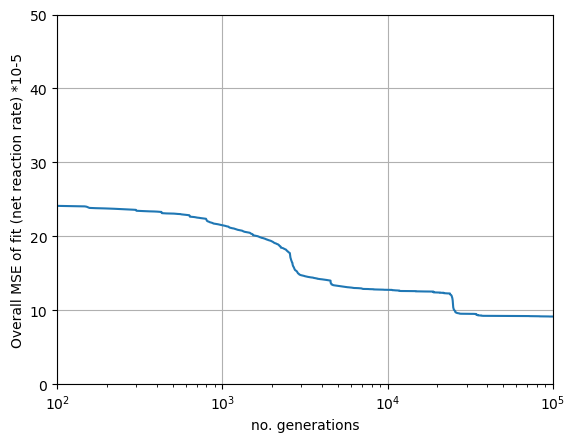

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-8.598495303859316
1.0621777535384114
0.49088882137969414
-4.128918011602818
0.470926267262057
9.070584696008224e-08
0.39540708144693915
-5.600655107516728
0.4496590718713433
5.365656903391654
3.8627521259626856
4.094307875179007
0.5096737239855376
0.04693746081550051
3.203788536081761
0.01799474020052336
0.5078056993885228
-11.189231157468392
1.7464243254974747
1.4776227304548812
-10.789628258732698
1.076128959284212
3.7337093236431955
0.10972290668978929
3.9115373102149427
5.892604620836817
0.560925497703211
6.267765661252259
-9.169096493644211
4.306696580655717
6.471713497220068
4.518376109987518
-8.382449091286173
1.3043791319472797
1.6031868161633802
-1.3010299986341034


In [37]:
res.X

array([-8.59849530e+00,  1.06217775e+00,  4.90888821e-01, -4.12891801e+00,
        4.70926267e-01,  9.07058470e-08,  3.95407081e-01, -5.60065511e+00,
        4.49659072e-01,  5.36565690e+00,  3.86275213e+00,  4.09430788e+00,
        5.09673724e-01,  4.69374608e-02,  3.20378854e+00,  1.79947402e-02,
        5.07805699e-01, -1.11892312e+01,  1.74642433e+00,  1.47762273e+00,
       -1.07896283e+01,  1.07612896e+00,  3.73370932e+00,  1.09722907e-01,
        3.91153731e+00,  5.89260462e+00,  5.60925498e-01,  6.26776566e+00,
       -9.16909649e+00,  4.30669658e+00,  6.47171350e+00,  4.51837611e+00,
       -8.38244909e+00,  1.30437913e+00,  1.60318682e+00, -1.30103000e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -8.598495303859316
1.6: 1.0621777535384114
0.9: 0.49088882137969414
-4.3: -4.128918011602818
0.5: 0.470926267262057
0.003: 9.070584696008224e-08
0.4: 0.39540708144693915
-7.9: -5.600655107516728
0.7: 0.4496590718713433
7.2: 5.365656903391654
5.7: 3.8627521259626856
5.7: 4.094307875179007
0.8: 0.5096737239855376
0.03: 0.04693746081550051
3.1: 3.203788536081761
6.000000000000001e-09: 0.01799474020052336
0.1: 0.5078056993885228
-12.0: -11.189231157468392
1.9: 1.7464243254974747
1.6: 1.4776227304548812
-11.6: -10.789628258732698
1.2: 1.076128959284212
4.0: 3.7337093236431955
0.01: 0.10972290668978929
4.2: 3.9115373102149427
5.4: 5.892604620836817
2.2: 0.560925497703211
11.8: 6.267765661252259
-12.0: -9.169096493644211
3.3: 4.306696580655717
1.8: 6.471713497220068
4.2: 4.518376109987518
-4.0: -8.382449091286173
0.5: 1.3043791319472797
1.0: 1.6031868161633802
coeff fit: 0.8912638856079029
r: 0.9440677335911354
